## TOC:
* [EDA](#Loading)
* [Cross-Validation dataset](#cross-validation)
* [Fit a RNN](#fit-RNN)
* [Summary](#Summary)

*Week 9 Assignment*

**EDA and GLOVE/RNN on tweets
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training a RNN


In [23]:
# Imports
import os
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import timeit 
import cv2
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from scikeras.wrappers import KerasClassifier

from yellowbrick.classifier import ROCAUC

from tqdm import tqdm


import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from IPython import display
from base64 import b64decode

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant

stop=set(stopwords.words('english'))


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramundson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ramundson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## EDA <a class="anchor" id="Loading"></a>

In [68]:
# Set some options to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


tweetDf = pd.read_csv('tweets/train.csv')

tweetTestDf = pd.read_csv('tweets/test.csv')

print("There are {} missing rows in the data".format(sum(tweetDf.isna().sum())))

tweetDf = tweetDf.dropna(subset=['text', 'target'])

print("There are {} features in the data".format(len(tweetDf.columns)))

tweetDf.columns

There are 2594 missing rows in the data
There are 5 features in the data


Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [69]:
tweetDf.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [61]:
tweetDf.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [62]:
tweetDf.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0, 0.5, 'samples')

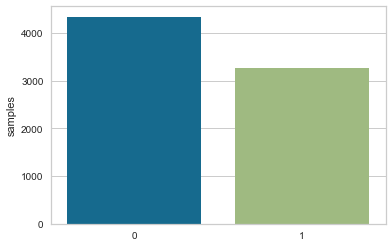

In [63]:
y = tweetDf.target.value_counts()
sns.barplot(x=y.index, y=y)
plt.gca().set_ylabel('samples')

In [64]:
def top20_tweet_trigrams(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

<AxesSubplot:>

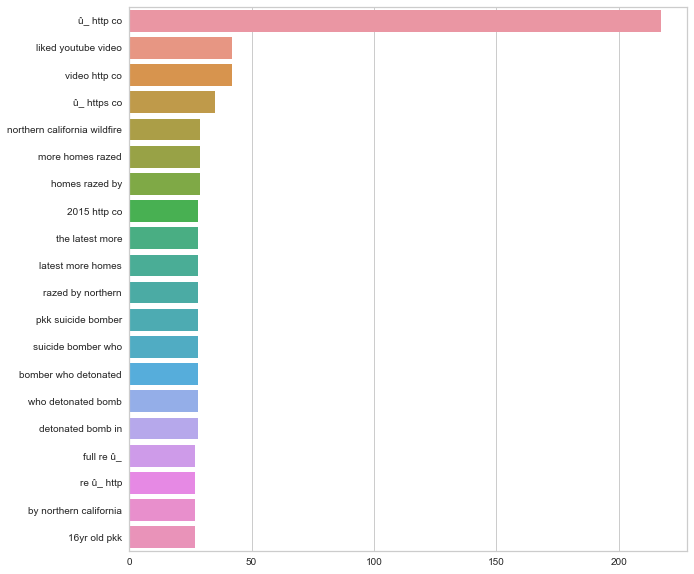

In [65]:
plt.figure(figsize=(10,10))

top_tweet_trigrams = top20_tweet_trigrams(tweetDf['text'])[:20]
x, y=map(list, zip(*top_tweet_trigrams))

sns.barplot(x=y,y=x)

In [66]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

tweetDf['text']=tweetDf['text'].apply(lambda x : remove_URL(x))
tweetTestDf['text']=tweetTestDf['text'].apply(lambda x : remove_URL(x))

In [140]:
def create_corpus(df):
    
    corpus=[]
    for tweet in tqdm(df['text']):
        
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        
        corpus.append(words)
        
    return corpus

corpus=create_corpus(pd.concat([tweetDf, tweetTestDf]))

#corpusTest=create_corpus(tweetTestDf)

corpus[4]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10876/10876 [00:00<00:00, 12643.57it/s]


['just',
 'got',
 'sent',
 'photo',
 'ruby',
 'alaska',
 'smoke',
 'wildfires',
 'pours',
 'school']

In [141]:
MAX_LEN=50

tokenizer_obj=Tokenizer()

tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

tweet_pad[4]

array([ 136,   27, 1359,  224, 5320, 1922,  206, 1222, 7720,  137,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [126]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 18735


In [127]:
# https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.100d.txt

embedding_dict={}
with open('./archive/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
        
f.close()

In [128]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18735/18735 [00:00<00:00, 730551.26it/s]


## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [158]:
train=tweet_pad[:tweetDf.shape[0]]
test=tweet_pad[tweetDf.shape[0]:]

train[4]

array([ 136,   27, 1359,  224, 5320, 1922,  206, 1222, 7720,  137,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [159]:
test[0]

array([ 136,  677, 1364,   67,   34,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [119]:
tweetDf.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [120]:
tweetTestDf.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [132]:
tweet_pad[4]

array([ 136,   27, 1359,  224, 5320, 1922,  206, 1222, 7720,  137,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [138]:
list(embedding_dict.items())[136]

('war',
 array([-0.39505  ,  1.0285   , -0.21556  ,  0.36596  , -0.34455  ,
        -0.23504  , -0.18961  , -0.81103  ,  0.17359  , -0.017903 ,
         0.059981 , -0.35961  ,  0.16133  ,  0.40454  ,  0.24142  ,
        -0.19124  ,  0.69767  , -0.91375  , -0.85926  , -0.44406  ,
         0.89111  , -0.18274  ,  0.67546  , -0.16622  ,  0.36994  ,
        -0.057873 , -0.70059  , -0.16782  ,  0.88317  , -0.40334  ,
         0.31702  , -0.51506  , -0.22962  , -0.24648  , -0.097251 ,
         0.020845 ,  0.25491  , -0.36664  ,  0.13173  , -0.23379  ,
        -0.7412   ,  0.10375  ,  0.29233  , -0.37992  ,  0.73483  ,
        -0.54725  ,  0.84773  , -0.61281  , -0.1322   , -0.63366  ,
         0.26397  ,  0.21946  ,  0.319    ,  1.7453   ,  0.13056  ,
        -2.1285   ,  0.36317  , -0.56862  ,  1.7781   ,  0.60787  ,
         0.16995  ,  1.3091   , -0.053037 , -0.63826  ,  1.0207   ,
        -0.0066656, -0.11157  ,  0.52914  , -0.38402  ,  0.83575  ,
         0.83537  , -0.71898  , -0.77896

In [162]:
# Now let's create a test/training set
# Let's get a stratfied split this time, so we are not missing categories

X, X_test, y, y_test = train_test_split(train, 
                                        tweetDf.target, 
                                        test_size=0.1, 
                                        random_state=42)

print('Shape of train', X.shape)

print("Shape of Validation ", X_test.shape)

Shape of train (6851, 50)
Shape of Validation  (762, 50)


## RNN Tuning <a class="anchor" id="fit-RNN"></a>

Grid search fit time: 0.0
{'classifier__batch_size': 250, 'classifier__epochs': 6, 'classifier__learning_rate': 0.0015, 'classifier__nodes': 64, 'classifier__opt': 'adam', 'classifier__num_output': 1, 'classifier__validation_split': 0.1}
Epoch 1/6
25/25 [==============================] - 88s 3s/step - loss: 0.6381 - binary_accuracy: 0.6298 - val_loss: 0.5656 - val_binary_accuracy: 0.7362
Epoch 2/6
25/25 [==============================] - 86s 3s/step - loss: 0.5413 - binary_accuracy: 0.7629 - val_loss: 0.5272 - val_binary_accuracy: 0.7682
Epoch 3/6
25/25 [==============================] - 87s 3s/step - loss: 0.5305 - binary_accuracy: 0.7690 - val_loss: 0.5343 - val_binary_accuracy: 0.7609
Epoch 4/6
25/25 [==============================] - 87s 3s/step - loss: 0.5153 - binary_accuracy: 0.7740 - val_loss: 0.5132 - val_binary_accuracy: 0.7638
Epoch 5/6
25/25 [==============================] - 87s 3s/step - loss: 0.5118 - binary_accuracy: 0.7752 - val_loss: 0.4930 - val_binary_accuracy: 0.78

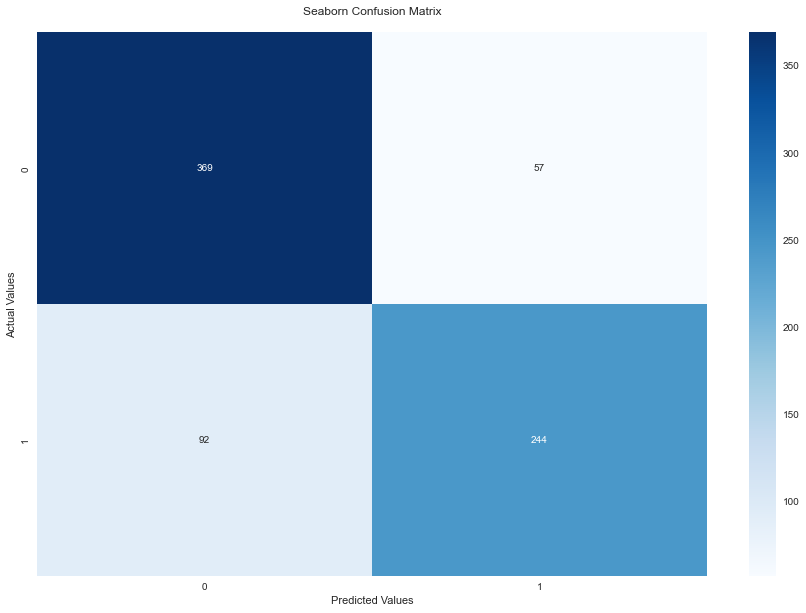

In [164]:
# Let's also try adding a convolutional layer in the middle 

# Squash annoying warns
import warnings
warnings.filterwarnings("ignore")

#tf.autograph.set_verbosity(0)
import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
#logging.getLogger("scikeras").setLevel(logging.ERROR)

def create_lstm_model(nodes=64, num_output=1, learning_rate=0.00001, opt='rms'):
    
    all_layers = [tf.keras.layers.Embedding(num_words, 100, 
                                            embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,
                                            trainable=False)]
    
    # Reshape the images into the correct shape
    all_layers.append(tf.keras.layers.SpatialDropout1D(0.2)) 
    
    
    all_layers.append(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
                                         
    all_layers.append(tf.keras.layers.Dense(num_output, activation='sigmoid'))
    
    model = tf.keras.Sequential(all_layers)
    
    opt = tf.keras.optimizers.Adam(learning_rate) if opt=='adam' else tf.optimizers.RMSprop(learning_rate)
    
    model.compile(opt, 
                  loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.binary_accuracy])
    
    return model

def run_lstm():
    
    #define model
    classifier = KerasClassifier(model=create_lstm_model, nodes=None, num_output=None, learning_rate=None, opt=None, verbose=0)
    
    pipelineKerasCNN = Pipeline([
                            ("classifier", classifier)])
    
    params={'classifier__batch_size':[50], 
        'classifier__epochs':[10, 15],
        'classifier__opt':['adam'],
        'classifier__nodes':[64],
        'classifier__learning_rate': np.linspace(0.00001, 0.0005, num=2),
        'classifier__validation_split':[0.2],
        'classifier__num_output': [1]
        }
    
    gs=HalvingGridSearchCV(estimator=pipelineKerasCNN,
                           param_grid=params, 
                           factor=2,
                           aggressive_elimination=True,
                           cv=2,
                           verbose=1,
                           n_jobs=4)

    start_time = timeit.default_timer()
    #l_grid_result = gs.fit(X, y)
    stop_time = timeit.default_timer()
    
    l_best_params = {'classifier__batch_size': 250, 
                     'classifier__epochs': 6, 
                     'classifier__learning_rate': 0.0015, 
                     'classifier__nodes': 64, 
                     'classifier__opt': 'adam', 
                     'classifier__num_output': 1, 
                     'classifier__validation_split': 0.1} 
    #l_best_params = l_grid_result.best_params_

    print("Grid search fit time: {time}".format(time=round(stop_time - start_time, 2)))
          
    print(l_best_params)
    
    classifier = KerasClassifier(model=lambda: create_lstm_model( 
                                                                    l_best_params["classifier__nodes"], 
                                                                    l_best_params["classifier__num_output"], 
                                                                    l_best_params["classifier__learning_rate"],
                                                                    l_best_params["classifier__opt"]), verbose=1)
    
    pipelineKerasCNN = Pipeline([("classifier", classifier)])
    
    start_time = timeit.default_timer()
    
    fit_hist = pipelineKerasCNN.fit(X, y, classifier__epochs=l_best_params["classifier__epochs"], 
                                 classifier__batch_size=l_best_params["classifier__batch_size"], 
                                 classifier__validation_split=l_best_params["classifier__validation_split"],
                                 classifier__validation_data=(X_test, y_test))
    stop_time = timeit.default_timer()


    print("LSTM with nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                num_nodes=l_best_params["classifier__nodes"]))
    
    pipelineKerasCNN.steps[0][1].model().summary()
    y_pred = pipelineKerasCNN.predict(X_test)#.argmax(axis=1)

    fig, axs = plt.subplots(1, 1, figsize=(15, 10))

    conMatrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

    ax.set_title('Seaborn Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall score: {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    print("Accuracy score: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    
    return pipelineKerasCNN, l_best_params

pipelineKerasCNN, l_best_params = run_lstm()


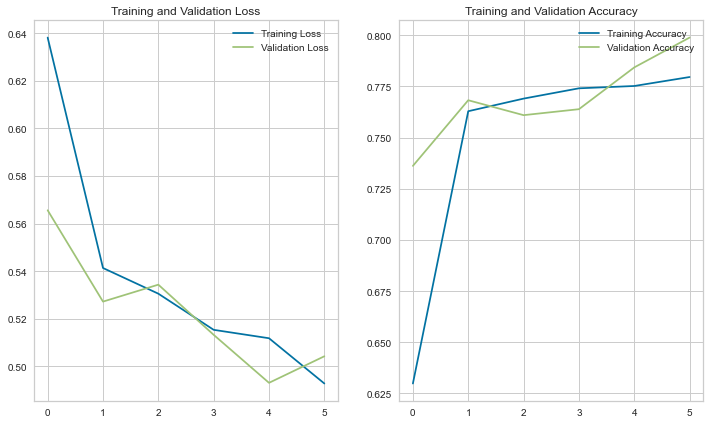

In [165]:
history = pipelineKerasCNN.steps[0][1].history_

loss = history['loss']
val_loss = history['val_loss']

acc = history['binary_accuracy']
val_acc = history['val_binary_accuracy']

epochs_range = range(l_best_params["classifier__epochs"])

fig = plt.figure(figsize=(12, 7))
ax1 = plt.subplot(121)


ax1 = plt.plot(epochs_range, loss, label='Training Loss')
ax1 = plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax2 = plt.subplot(122)

ax2 = plt.plot(epochs_range, acc, label='Training Accuracy')
ax2 = plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [166]:

predictions = pipelineKerasCNN.predict(test)

df = pd.DataFrame(tweetTestDf.id.copy())

df["target"] = predictions


df.to_csv("tweets/predictions_lstm.csv", index=False)

102/102 [==============================] - 15s 146ms/step


In [161]:
df

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,0


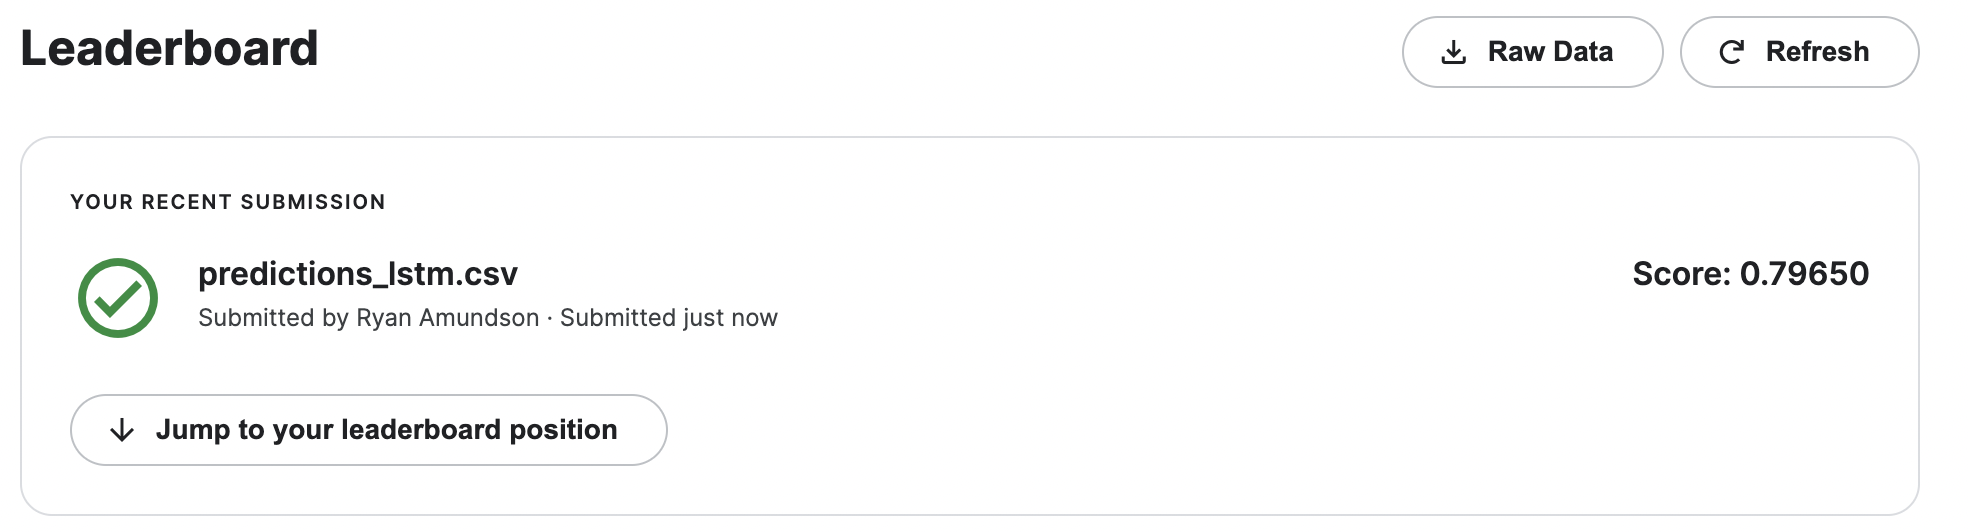

In [167]:

from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB7AAAAIUCAYAAACTnrMMAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB7CgAwAEAAAAAQAAAhQAAAAAQVNDSUkAAABTY3JlZW5zaG90m4T0TQAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTMyPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE5Njg8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4K80jhQAAAABxpRE9UAAAAAgAAAAAAAAEKAAAAKAAAAQoAAAEKAAIq8iIvf38AAEAASURBVHgB7H0H4B9Vkf9LEKQkIAm9hA5KESXoX8WCYgUL2EVQIGBBRbyz3B1gL3fnFT0BsZx33lkPUDxPUY9QzkINEFBUWgpFFEiQJNSU/8yb95k383b3l+RHEpIwC9n5zMznvbc7O292f9/97n7HLKEl9SxsHGPtZFhCBti41ZiiCNe0AMxySVpCrdBOugTBDuBxh0GGGD/ijzyK/Iv5F/XHVlNTMQGzjPob5584/+K8YWeMv+LwGqaQWskQ1x9x/YE8iuuPuP6I6w9bTU3FBMwyrj/i+iOuP3DesDNGry16AKaQusgQ1x9x/YE8iuuPuP6I6w9bTU3FBMwyrj/i+iOuP3DesDNGry16AKaQusgQ1x9x/YE8iuuPuP5YHa4/xuAGduc0bzNUq1gFHX51EUL5gyxOqJDK4xbNaTbGrzPExVaUTrwcBwGGjPjnCCAckJF/FBY5JXXyKeZfzD+coVxtEaWTL46DCQZZnFAhY/5RYGL+cXZ08inqT9SfqD+lcHZFZ744CgosZHFChYz6S4GJ+svZ0cmnqL9Rf6P+lsLZFZ354igosJDFCRUy6i8FJuovZ0cnn6L+Rv2N+lsKZ1d05oujoMBCFidUyKi/FJiov5wdnXyK+hv1N+pvKZxd0ZkvjoICC1mcUCGj/lJgov5ydnTyaRnr75gli4kpMSxZxp0hrITZXSaytSu5gI6vMTRqbpVtPQ5rivEj/pF/KHJ1Xsb88xGwNaMWl8rp+MmVbT0Oa4r6E/Un6k/UH64kti7UyiKo42sMjZobZVuPw5qi/kT9ifoT9YcLhq0LUnXquuNrDI2aG2Zbj8Oaov5E/Yn6E/WHC4atC7XyCOr4GkOj5kbZ1uOwpqg/UX+i/kT94YJh64JUnbru+BpDo+aG2dbjsKaoP1F/ov5E/eGCYetCrTyCOr7G0Ki5Ubb1OKwp6k/Un6g/w/VHn8Dun4ZuKhFFOhIura27MYqL1va9E+AM3l1vO7S6xaWjHhM2Sly0jvE7h42+lUC25ljmkLYBtbrFEf/ecBmjRIvWkX+Rf+1Ui/kX9SfqbzmJWNGeY6xucWnTY4rzvwRF13H+ifNPnH9skaESQbMj6q+PSdbagmp1i6P+9obLGCVatI76G/U36m8pGKgbNC+i/vqYmNpRHbbmWow4kmxzq3woJ2xaR/3pxijO/zH/ov7UMqOorTFWtzjqT45AT0ji8wcJiq7j/BPnn/YaJc6/cf5dQefffAPbfstDCjCX55J1uRJpOcp1G/lYrd6SSXbFRL6w7t1o8lBC41sGMX4OFsUr4p9TKCdZXuU/zdjms018mdv/jYqSUsSL/JMwNeuYf1F/ov7aqsITJOpvLhNRfykV4vzD84GjwIudKWL1FmGZdW5Iqzj/mqBUGOffOP/G+dfWEJ4bcf7NFSKfevIq6m8pmTZT4vwjuSGhsbgEiwWbeRXnXw5EZ4nzb5x/4/xrqypPkTj/5kKRS6rU1VxGa2RyWY3zj8Qmx6pERLBZ58DRKs4/JigVxvknzj9x/onzj1SE5iyTy2teyWU8kWykHvPnHyqe/PpxikoNUoYcTUSK8VIWbs1LbuIUsdt1x52Hzqu6KdqZbTmMXZ9O6bbpuPPQeRXjU7ji+JecifzvTp4Bi5tTTuk26Ljz1MurmH8Urph/JWdi/nUnz4DFzSmndBt03Hnq5VXMPwpXzL+SMzH/upNnwOLmlFO6DTruPPXyKuYfhSvmX8mZmH/dyTNgcXPKKd0GHXeeenkV84/CFfOv5EzMv+7kGbC4OeWUboOOO0+9vIr5R+GK+VdyJuZfd/IMWNycckq3Qcedp15exfyjcMX8KzkT8687eQYsbk45pdug485TL69i/lG4Yv6VnIn51508AxY3p5zSbdBx56mXVzH/KFxr0vwbQz+BzS95MIscSDGYQ13M1ssc0Qec6JXcSygqY/SOOHrp/HS39ihNmccLbeHAEGIecErj3DbGj/hH/mGml/lCk8pmhUwX+FhjzEvMv6g/Lg1yVvBKsqXkjE0dZQgp6q+daQhUzD8bFUkZxIY1xrxE/Yn649IgZwWvJFtKztjUUYaQov7YmYZARf2xUZGUQWxYY8xL1J+oPy4NclbwSrKl5IxNHWUIKeqPnWkIVNQfGxVJGcSGNca8RP2J+uPSIGcFryRbSs7Y1FGGkKL+2JmGQEX9sVGRlEFsWGPMS9SfqD8uDXJW8EqypeSMTR1lCCnqj51pCFTUHxsVSRnEhjXGvET9ifrj0iBnBa8kW0rO2NRRhpCi/tiZhkCt+fWHXiG+mPamPIiO/bIHX5OkMS6H6rplhReqSbKIN68dEX4kadWXF7luWeElxpc42BLgAlXcJAbMlbAU5NpH/CVakX8layQ78tolSk2qAXMlLAW59qzwEvGXOMT8z8mQc8QlSgkPiQFzJSwFufas8BL5J3GI/MvJkHPEJUoJD4kBcyUsBbn2rPAS+SdxiPzLyZBzxCVKCQ+JAXMlLAW59qzwEvkncYj8y8mQc8QlSgkPiQFzJSwFufas8BL5J3GI/MvJkHPEJUoJD4kBcyUsBbn2rPAS+SdxiPzLyZBzxCVKCQ+JAXMlLAW59qzwEvkncYj8y8mQc8QlSgkPiQFzJSwFufas8BL5J3GI/MvJkHPEJUoJD4kBcyUsBbn2rPAS+SdxiPzLyZBzxCVKCQ+JAXMlLAW59qzwEvkncYj8y8mQc8QlSgkPiQFzJSwFufas8LKW5F/+Dey8Q24vs6Wu8KPrxOHHtXXfK2MQ1W777vabZpVojAXG+BR0inrEP/Iv5l/Un26FHLTUshr1134HrROwGqiOK8X5J84/cf6N64+4/orrr7j+iuuv7hXCoKVeVsT1V1x/1XeAdRKmJkrHFdefFJy4/orrr7j+iuuvuP6K66/uGXLQUk+rcf0V119x/UXls3+pE6Xrj88/4/pzNb3+7nmFeMnfnLSM+1N+pHzPXxnANOhtXlqTGLwhHuOX0PcGcORvZXB4sfQ2j/jn4Eb+xfyj+dE/RSg5sqPXG/OP6kt/ZMgR9QfVdyBIUX9zYKL+Rv2lItJbR+L6rwSmNzpx/onzT/+84TNPnH/j/IsI9JaPuP6I6w9KjLj+iusvSoP+EkHJkR293rj+oPraH5k4/8b1B06+Q0kS5984/1L1iPNvnH8pDXrPI/H5R1x/5MTozY64/iqnVn2FeD7llvOqOf02gaon3jzrevjSVhxwQ2q/zmAUA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGowk6xPYxtj/lRB0KV/wL7+aXY0Goatqai1VVwQAWRt3kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJZZjY9bSWqisCgOyMWg1CGSZ2Pa2l6ooAIOtwHSSUYWLX01qqrggAsjNqNQhlmNj1tJaqKwKArMN1kFCGiV1Pa6m6IgDIzqjVIJRhYtfTWqquCACyDtdBQhkmdj2tpeqKACA7o1aDUIaJXU9rqboiAMg6XAcJRdb1N7CVhh5Y8sKPsBPGu77hFqu51w0HJLftLurNQDVDhI0lLzF+xJ9yIfJPpwImHWaKzBNokGJt1+rNQDVDg40lLzH/Yv5RLsT806kQ808qAyqF17xVfHWt3gxUqwR95wv7eIn6E/WHciHqj06FqD9SGXz1gAYpnHat3gxUMzTYWPIS9SfqD+VC1B+dClF/pDKgUnjNW8VX1+rNQLVKiOsfikWpuTkqUX+j/tI8ifpbpwVPCVp89YAGKZx2rd4MVDM02FjyEvMv5h/lQsw/nQpx/SOVAZXCa94qvrpWbwaqVYJWNfbxEvUn6g/lQtQfnQpRf6QySAlZTC/bH9NXSISEdT8DVkiwywDcNf/4NxUlQoi7m49Sr/rb2976GbBC2hY0TIwf8Y/8i/kX9Sfqb5x/4vyLywO6XMD1cFx/UFDi+o+DgOzolQNXmKXdgDeuP+P6M64/aY7E33/x92/8/a9nmLj+iOsvSoacD/nSof/6wV6I9DNghbQt4vOv+PwvPn+Nz5+5ysT1V1x/xfVXXH+V6wO6XIjPv+L6a224/sxPYLvLX1UU+KviHg1M+ryOPrDiC2eRSgVBDR44tyoKPLlHAxPjQioVBDV44NyqKPDkHg1MjAupVBDU4IFzq6LAk3s0MDEupFJBUIMHzq2KAk/u0cDEuJBKBUENHji3Kgo8uUcDE+NCKhUENXjg3Koo8OQeDUyMC6lUENTggXOrosCTezQwMS6kUkFQgwfOrYoCT+7RwMS4kEoFQQ0eOLcqCjy5RwMT40IqFQQ1eODcqijw5B4NTIwLqVQQ1OCBc6uiwJN7NDAxLqRSQVCDB86tigJP7tHAxLiQSgVBDR44tyoKPLlHAxPjQioVBDV44NyqKPDkHg1MjAupVBDU4IFzq6LAk3s0MDEupFJBUIMHzq2KAk/u0cDEuJBKBUENHji3Kgo8uUcDE+NCKhUENXjg3Koo8OQeDUyMC6lUENTggXOrosCTezQwMS6kUkFQgwfOrYoCT+7RwMS4kEoFQQ0eOLcqCjy5RwMT40IqFQQ1eODcqijw5B4NTIwLqVQQ1OCBc6uiwJN7NDAxLqRSQVCDB86tigJP7tHAxLiQSgVBDR44tyoKPLlHAxPjQioVBDV44NyqKPDkHg1MjAupVBDU4IFzq6LAk3s0MDEupFJBUIMHzq2KAk/u0cDEuJBKBUENHji3Kgo8uUcDE+NCKhUENXjg3Koo8OQeDUyMC6lUENTggXOrosCTezQwMS6kUkFQgwfOrYoCT+7RwMS4kEoFQQ0eOLcqCjy5RwMT40IqFQQ1eODcqijw5B4NTIwLqVQQ1OCBc6uiwJN7NDAxLqRSQVCDB86tigJP7tHAxLiQSgVBDR44tyoKPLlHAxPjQioVBDV44NyqKPDkHg1MjAupVBDU4IFzq6LAk3s0MDEupFJBUIMHzq2KAk/u0cDEuJBKBUENHji3Kgo8uUcDE+NCKhUENXjg3Koo8OQeDUyMC6lUENTggXOrosCTezQwMS6kUkFQgwfOrYoCT+7RwMS4kEoFQQ0eOLcqCjy5RwMT40IqFQQ1eODcqijw5B4NTIwLqVQQ1OCBc6uiwJN7NDAxLqRSQVCDB86tigJP7tHAxLiQSgVBDR44tyoKPLlHAxPjQioVBDV44NyqKPDkHg1MjAupVBDU4IFzq6LAk3s0MDEupFJBUIMHzq2KAk/u0cDEuJBKBUENHji3Kgo8uUcDE+NCKhUENXjg3Koo8OQeDUyMC6lUENTggXOrosCTezQwMS6kUkFQgwfOrYoCT+7RwMS4kEoFQQ0eOLcqCjy5RwMT40IqFQQ1eODcqijw5B4NTIwLqVQQ1OCBc6uiwJN7NDAxLqRSQVCDB86tigJP7tHAxLiQSgVBDR44tyoKPLnROq8Ql2a+sbN1tq7psaPWvjKilX77o8Pl74rxNyNqG6Y4W4zffDugJ4jOVGOZEa0i/pxj/YvLtUJxtsi/yL/8VFV//nStkj1sz4hWMf9i/kX96c4UnSNx/qdQ1AyJ8w9Ho9TROP/G+TfOv/3Fs9da5g35MqJVXH/Y6uqDJtGqMWOvs0X9ifoT9cdPmhG1OpcyolXUn6g/9erWJ4+rtcXlbFF/o/5G/fWTZkRNZg9TMqJV1N+ov1F/+yeNO9cUirPF+SfOP3H+6Z88vVaZPezKiFYr8vzT3MCug5W/2jGsbpph6JPW2DDzmavyBdhWjcuphqdQQWZaDbUk26zD9cnKiE7DNjyFCjLPajG+1LIcExsYE1GBIzoN2/AUKoj4UwRsNCL/Iv/4XJpzwiaGmVECR3QatuEpVJB5Vov8i/yL/Iv5l2uCLQymokT94QiMGBwTLcNTqCDzrBb1N+pv1N+ov7km2MJgKorAEZ2GbXgKFUT9oQjYaET9jfob9Tfqb64JtjCYiipwRKdhG55CBZlntdW5/tw7b36ad+/8dN/9D9C/BenBhx5ODz38cFq8cFFatIj2YizvCS1FMOQvqfKrnvNSdhQ2/pUj/uC7mDNrMSlu/nGfTOKFibwwIS1mIP8zhTkxPkenxokgYq32HLLy+vESWg4rR5T/RfwpDhSIHBNeLWP+jRmzTlpn3bFpvfXWTY9fd7204QYbpA033CBtPH6jNH78eOqIFgS6Am9mCnHc+HxQehftrNdbjYanUEGmWe3RGP/P8+en+VRX7r///jR/wf1UUx7KtYXryuK0iIJSgsAbykvMfwpC1L9csSg18nnkUa7/Mf/zzOxZmeqiUEHmWy3XH/qdGLbp4ghkHayJpbBavnbSA4RX2RlVVVtYk8VKUCDekTlK7mxtbtfT2Josrj0BiXdkDrg4H1V2RlVVojVZrAQF4h2Zo+TYfwqFPsVFOMetJ3jWZHGNJJB4R+aAG8e/jVbWe4JnTRbXSAKJd2QOuBH/NlpZ7wmeNVlcIwkk3pE54Eb822hlvSd41mRxjSSQeEfmgBvxb6OV9Z7gWZPFNZJA4h2ZA27Ev41W1nuCZ00W10gCiXdkDrgR/zZaWe8JnjVZXCMJJN6ROeBG/NtoZb0neNZkcY0kkHhH5oAb8W+jlfWe4FmTxTWSQOIdmQNuxL+NVtZ7gmdNFtdIAol3ZA64Ef82WlnvCZ41WVwjCSTekTngRvzbaGW9J3jWZHGNJJB4R+aAG/Fvo5X1nuBZk8U1kkDiHZkD7tof//sffCDdeeecNHfuPemeP9+bFi/mmya8yK8Pyy0UwRwz/mfv9zGTjXxvId9zYkwm/vyZf72Xb6Pykj+Pzjzx8qfXY8mY71uxScyZK6sYn+MX8efcWf3zb8w6Y9OmT9g4TXjCE9LEzSekDR+/vsllC0v+kynPCevqwS0765254qdPj9v03PZoXD2wZWe9ZwBrYvzAAw+ku+6am+bkuvLntITrCjmW8J1IPqIkYv5zPCgcHBIJCwEsUf/WpPoX87/Ws04qI6WzFK8+gT1MLt/AsjNDyQpc1z2zyPjRBlJcXjN0GreedkqpVrIC24DwkJ1p8EFKU6+JDZ4YXy4hNbU0WApswAgP2ZkGH6Q09ZrY4In4R/ztlw80hSqwCUN4OJuqz3O8ZruL+hPzL+ZfzD9TIRQqsAUj6k/UX8qBoY8VkDOQkjpes+kU5584/8T5J84/pkIoVGALBuEhO9Pgg5SmXhMbPDH/Yv7F/DMzRKECO2EID9mZBh+kNPWa2OCJ+Rfzb3Wdf3/8053p9jvuSvfQDSa55OXr3sVp3Dh6mnTc+LTRRuunDdbfIK1PN+LWW+9xaZ116OlT+lfnAbJ86Io5rn9j/q9d838xPbq+cCG9keChRekB+uLH/Q88SE8TL0jz6a0F8xfcl6cRnw94eQLdzN5qyy3T1ltuRtpj5/7HHX/8U/rDH+9M99xzD50xx9Ke843rMVRXNsx1heX6669HtWX9tC49xS51ZWyOWVtbirHx+TOu12yLqD9Rf1Zs/Yn5z3XMzzivLfv8oxvY+UUgtYX2pKD6GuQZmOiF5Jyk5K/WkSCYv2GnfTmi2a/GrvwKPCPGl0IT8c8RcMlBSuRfvv6J+Rf1J+pvPYeYE44YtW4osGSHPSPOP3H+4QvdsrjkICXOP3H+oeSI82+cf+P8iyLJ0hVKozZ226Rgz4jzb5x/4/wb1x99xSGuv+L6k2ZGXH+tkOvPRYsWpVtuvT3dcvsdaSG9FpwXvqbZbPPN0mabTkgTNt04rUc3ldwfQ/H3T+RfzL+lzr+HHnw4zaGbtnfPnZPfaMAvyKWwpcetu27abput0vbbbVO+AGIulfMMXPOvf3NdueX2dOsf7kgPL3yIdpCu56iwbLHZxDRhwqZUVzahL8FQXSlLXP+bEkt/R8X1/5p//f9Ynv+ljJWk9rMbc97KzKivEPcN6nSoyDb2g3mP76kWWrHbtW3nW9VRK7LsGJ8i4EOm4WnN0EXatTbpdFajXpFlZ4yOG0drhm5Hhq029ZY6akWVW5Bvou7WDF2kXWsTAmCJrY5akWVn7JuouzVDF2nX2oQAWGKro1Zk2Rn7JupuzdBF2rU2IQCW2OqoFVl2xr6JulszdJF2rU0IgCW2OmpFlp2xb6Lu1gxdpF1rEwJgia2OWpFlZ+ybqLs1Qxdp19qEAFhiq6NWZNkZ+ybqbs3QRdq1NiEAltjqqBVZdsa+ibpbM3SRdq1NCIAltjpqRZadsW+i7tYMXaRdaxMCYImtjlqRZWfsm6i7NUMXadfahABYYqujVmTZGfsm6m7N0EXatTYhAJbY6qgVWXbGvom6WzN0kXatTQiAJbY6akWWnbFvou7WDF2kXWsTAmCJrY5akWVn7JuouzVDF2nX2oQAWGKro1Zk2Rn7JupuzdBF2rU2IQCW2OqoFVl2xr6JulszdJF2rU0IgCW2OmpFlp2xb6Lu1gxdpF1rEwJgia2OWpFlZ+ybqLs1Qxdp19qEAFhiq6NWZNkZ+ybqbs3QRdq1NiEAltjqqBVZdsa+ibpbM3SRdq1NCIAltjpqRZadsW+i7tYMXaRdaxMCYImtjlqRZWfsm6i7NUMXadfahABYYqujVmTZGfsm6m7N0EXatTYhAJbY6qgVWXbGvom6WzN0kXatTQiAJbY6akWWnbFvou7WDF2kXWsTAmCJrY5akWVn7JuouzVDF2nX2oQAWGKro1Zk2Rn7JupuzdBF2rU2IQCW2OqoFVl2xr6JulszdJF2rU0IgCW2OmpFlp2xb6Lu1gxdpF1rEwJgia2OWpFlZ+ybqLs1Qxdp19qEAFhiq6NWZNkZ+ybqbs3QRdq1NiEAltjqqBVZdsa+ibpbM3SRdq1NCIAltjpqRZadsW+i7tYMXaRdaxMCYImtjlqRZWfsm6i7NUMXadfahABYYqujVmTZGfsm6m7N0EXatTYhAJbY6qgVWXbGvom6WzN0kXatTQiAJbY6akWWnbFvou7WDF2kXWsTAmCJrY5akWVn7JuouzVDF2nX2oQAWGKro1Zk2Rn7JupuzdBF2rU2IQCW2OqoFbFn1q23pdmzbk0L6SY2v8V3/Cbj0zZbbZW22Hwi3ViTJyB9T7VnO3LLqayRxxdvWXc7yY7WDF2kXdvewBJb3euKLLt3oELwPdU9syO3nMqK8TkCNeoVlfBW0Q1i9rVm6CLtuna1OsZ/Mf2k85/u/FO67Y4/5d+T52183OPWSZO23y7tsP227SbrzmB/YYBu9xw2cNrOatQrqtyCup1kR2uGLtKua4+zbrk1zZ59W64rbB2/8bi07VZbU12ZkMbSGxv4Jn5nQceNozVDtyPDVpt6S93riiq3IN9E3a0Zuki71iYEwBJbHbUiy87YN1F3a4Yu0q61CQGwxFZHrciyM/ZN1N2aoYu0a21CACyx1VErsuyMfRN1t2boIu1amxAAS2x11IosO2PfRN2tGbpIu9YmBMASG4/6WJr/ffsvX0cYOf75FeJ4KsRRTTxtyDM2vjxw1vnrVRR8V2nIUL55Zw9Vi2N8ClsOn/kOjYmlQLM2vog/BSPHI/Iv5l/Un6i/9uzCtYHqgjsnWb/gOP/E+SfOv3wajesP/Q6vucYSaNbGF9dfFIwcj7j+iuuvuP7y1xo8N+L6w8ckrr/aCMT1Z1x/xvVnXH+uztffc+fMSTfOmC2vOKZz2oTNNkmTttkmbUpPRcb1H1/3xPVvXP+uvOvfP8+dm2bfdke6a85c+uLImLTR+A3SLjvukCZOeMIaPf/upv258eZZ6b777qf0WUz7s2matC3VFfoNcFw3yp/bZi2wXEbxNXbMv6g/a3f9XVvnP0/iR/L3j/4GdqkGVbgikYehFSVJXsqlVofDTnMZpn4FpdgYXTrsrjsUa4jx80fNNiQawYi/fgyv8VEQ+ZdDYeKhedOADsUaYv7F/KNbPTYlNH2i/kT9KbcBNT8URP3NoTDx0HnTgA7FGqL+Rv2N+hvnH6oZ+JNMy0ecf+P8G+ffPC30lKkgrj9yKEw8tG40oEOxhrj+iOuPuP54rFx/3HDjjHTr7bfni43x48alHXfYNk2cODH+/rclUctnXH/F9dfKu/666+45aeasW9K98xeksZR/2263ddptl500+/gCZ02Jf7eubJc2mzhB9qUzt6whrj/i+uOxef2xNs1/U7S60E737LWGOv/NDWwheFr5fMQa286yr7Zld/1MpTYEgszduFXtA+2VqwANjCFD0XnNC9qXv1azDS0gs9Gtah9or1wFaGAMGYrOa17QPsavcQKClEjZtXisX7EC8I0hQ9F5zUvEX+IQ+VfzBAgSEapSPNavWAHYxpCh6LzmJfJP4hD5V/MECBIRqlI81q9YAdjGkKHovOYl8k/iEPlX8wQIEhGqUjzWr1gB2MaQoei85iXyT+IQ+VfzBAgSEapSPNavWAHYxpCh6LzmJfJP4hD5V/MECBIRqlI81q9YAdjGkKHovOYl8k/iEPlX8wQIEhGqUjzWr1gB2MaQoei85iXyT+IQ+VfzBAgSEapSPNavWAHYxpCh6LzmJfJP4rCm59+8BQvS9b+/Oc2bdy8d1DFpx50mpR3p9cV2v+Tpxzj+nPWR/5L3Mf9X/vyfRa/bnjFzdn56cfz4jdKTdt81bThuozzw6h7/BXTz/XfXU11ZMI9KyZi0847bpx0m0SvRyxzC9ktVIbOCblyj/nDYov4idzhDkD82cZBCkMikKmsM0V65CsA2hgxF5zUvaL8yx1+T53+Nj8RL1jWG8IuFvArArwZ5hTjZc6NqL32SgV+NQou6FAhF1629V4exSC/MIKVXPFse40f8KQd6cxQJiNQaUQfJJx6sNcilk8i/mP9R//JkGJwjI843OEnmDtBLkV5E/Ud4ELaoP1F/ov7k2aBTQwEmSZGtvVeHsUgvov4gPAht1J+oP1F/ov5QBLQ0KECRKLK19+owFumFGQR9EiHyLwcDkasHIuLvIqABQu6QxCdhbMp+kIr0IvIP4Skh1Hc7InwaRxCM7LQlX8S/BijHB0Eq0ovVKv/uvOvudN1vr0+L6RqQn7rebbed0ybjx3W3EXuIXRtRB8nvOKyd2hbXn3H+i/N/nlF9c+TeefPT9TfQjeD589PYMeukPZ+0W9p8s4EnmHMH6KVIL7pzeyXMvzvvmpOu+x3VlcVUVzYal/bYY+c0jupL72f7K2F8OSn5HUdUov5QqrlzNkUm5t/g/MOpzhOKVZPK6jAW6cVyz781cf6v6PlXn8A2xcIemCbk1qUYnO4RUIr/+0HNtaW9WFY3ATAgrQ+4+iqCDzJ7Om5jiP3XYoWYsUSEIK0PuPoqgg8yezpuY4j4R/zLyRI5wxIZAml9wNVXEXyQ2dNxG0PkX+Rf5B+mi0rMEEh1GFB9FRl3htnTcRtDzL+YfzH/2mkT5z+KCP9NbSrFYIxGYkX9oTh2gmgMUX+j/kb9HawtZqYMcqL+DEcpezpuY4j6E/Un6s9gbTEzZZCzourPbbffka6/8eY8zlZbbZGf7lyV49sdxLiQ1gdcfRXBB5k9HbcxRP2J+rOG1p/fXn9juuOOP1GqL0m777pz2nabrZH2KleH/L+dfsP7+ptuzn/PcV154u670PaVO6Yx/2L+raHzr55FKtKJV8DKnH9ryvxfGZ8/1BvYNuLtcWh15XYdXYuSKyDSEtqb8ksR1Q7UdtLq4PV8rDVI1TYEYvyIf+RfzD9cPNnawLgtIq2u/K6ja1FyBUSK+hf1P85/9uuedXrE/KNY2NAMFpWuo2sxcQWM+hP1N65/4vrHFRkUB5JtEWl1pXYdXYuSKyBSXP/E9U9c/9iTfJ0eMf8oFjY0g0Wl6+haTFwBo/5E/Y3rn97rn1tu/UO68aYZKY1NacdJ26eddti+ez2AedQpVCNQtQ2BmH8x/2L+9c6/PE3ak1ir61yqDv5dbP63mHy77bxj2n67bZTVAY/C/Lvl1tvTjTfPzJvCdWXHHbdbofuPfawRgaVHPgr777Yixo/6t4Lr3+o+/1dW/vsb2Hlimb8dBr4VoxtjqoVAY2AS1Cx5xab64+twZ4c4KbFjfP3bLeJPyaDR0DRRYBJIoDGUfKJ0K3nIvsi/mH9Rf+jcmYtsM1vyPIn6G+cfrbhx/onzT5x/83VD78oUUIHGwA2gZsmruP6I64+4/ojrDyoEdJJFeciFQYpD/P1LcYnrj5IRcf0V119x/aXlsQNMARVoDKWexuc/FIgcFl6NfP15Gz0h+fvyhOSuu9BNMH6SM/Ivx613ZdJNoDFIsOVkls28Gjn+fJzi85c4/4/2+ueWW29LN988K+fQbrvsnLbbeqvVIv+4rlx/0015W3bZeac0aRu6uR7Xv3H9T/VQc12KY9Q/CojGZDmv/1fX+b+s1x+jOf/JDezmvFtyqQbSTrUeLvNHtaAvSNOJNxnNQEMfHURfkKYXbzKagYY+Ooi+IE0v3mQ0Aw19dBB9QZpevMloBhr66CD6gjS9eJPRDDT00UH0BWl68SajGWjoo4PoC9L04k1GM9DQRwfRF6TpxZuMZqChjw6iL0jTizcZzUBDHx1EX5CmF28ymoGGPjqIviBNL95kNAMNfXQQfUGaXrzJaAYa+ugg+oI0vXiT0Qw09NFB9AVpevEmoxlo6KOD6AvS9OJNRjPQ0EcH0Rek6cWbjGagoY8Ooi9I04s3Gc1AQx8dRF+QphdvMpqBhj46iL4gTS/eZDQDDX10EH1Bml68yWgGGvroIPqCNL14k9EMNPTRQfQFaXrxJqMZaOijg+gL0vTiTUYz0NBHB9EXpOnFm4xmoKGPDqIvSNOLNxnNQEMfHURfkKYXbzKagYY+Ooi+IE0v3mQ0Aw19dBB9QZpevMloBhr66CD6gjS9eJPRDDT00UH0BWl68SajGWjoo4PoC9L04k1GM9DQRwfRF6TpxZuMZqChjw6iL0jTizcZzUBDHx1EX5CmF28ymoGGPjqIviBNL95kNAMNfXQQfUGaXrzJaAYa+ugg+oI0vXiT0Qw09NFB9AVpevEmoxlo6KOD6AvS9OJNRjPQ0EcH0Rek6cWbjGagoY8Ooi9I04s3Gc1AQx8dRF+QphdvMpqBhj46iL4gTS/eZDQDDX10EH2RvHPO3enXv/l97odvXm+37Tbx+a9GFYEig4HqHi1AX5CmH28ymoGGPjqIviBNL95kNAMNfXQQfUGaXrzJaAYa+ugg+oI0vXiT0Qw09NFB9AVpevEmoxlo6ApvuY2edL5pZp67e+25B/0m9kT1dQD6gjQEbzKagYY+CO+8i+rKdb/P27PLLjul7bc1rzdHX5CmF28ymoGGPjqIviBNL95kNAMNfXQQfUGaXrzJaAYa+ugg+oI0vXiT0Qw09NFB9AVpevEmoxlo6KOD6AvS9OJNRjPQ0EcH0Rek6cWbjGagoStc3ea/blgfwL5AGo43Gc1ApvsnsLWDhsX2HlOmZ7txFnjnn/6UfnTuT3LhWkLfJBhD3+QzrPTs5z4n7bLTTjqiB5ZZPD2mkca3G4ymkNzO4jKCET3eHlNukO3GqVCBjlUtj874M2fPThddcKFsNn/TgzeIFmzXfpP3S/vsvbexZLesQDKmDLPdOBUq0P6rpY7Zdjc4mG1sG2W7cSpUkH72v+elP9x+u24HN8/fdGQKLW960xvTeuutJ0pe17Zq7DFVqnEqVKDjVsuq3X+MC8nbbbHuo4Ieb48p07PdOBUq0LGqZeWNP3PWrHThhRfRG7CW0Ot05CWFtv5MLjlut0V3W0GPt8e0Ou6/BrsCRXYXLNbdVtDj7THF/lMEclxMcBQqiPhTmPhbhTUiHuc8civLLI4eU/Zku3EqVKDjVkuMb2PhQl+D6s1DDbLdOBUqiPhTJCP//Zyr2eHTTLQeb48pc7PdOBUqiPyL/Iv5RzlQZ4THMufs2jKLvceUPdlunAoV6LjVEuPbWNjIC+7x9pgi/hSBHBcTHIUKIv8oTHH94WtOzQ6ZcX7d4+0x5TbZbpwKFaz2+Td//oI07epr0+LFi/Mrw3fcYbuSMSYqdXeMkWC2G6dCBav9/vsdYq1uu/p6TNmX7capUIH2Vi29I+hQvV7b2DAj/hQMvNKH46JxUqCmajE0G0vFllmMPabsyXbjVKhglY8/Y/Ytadas2fQzAOuk/Z+yT9po3EaPSv2fP/++XFcWLVqUdtpxUtqRfo6Az0O81OiI7tc93h5TbpPtxqlQgY5VLTG+jYWPPWs93h5TxB+hMsFRqECjWS29Ec7hlJVlFnOPKXuy3TgJri7zX646676ardSYmJ020DJH3n+6gb2Y7u/QjZ5SWXqa6mDWBwxpRs9w+vRr0mGHvZba8q8ylM75RMN3Dmk55JCXpVO/8C+ElqSVMX4eJK/sFloMxmNn/PPPn5qmHPuOsuOIhez/WDosJ538N+mYY47G0UKARnX8tbG2ZgvGrN5VcfynTHlbOp9v3Jv8q9uyJF191ZVpk002zhvVv4WSwdYHDGn3yGPLsBisx07+1Zhj31mu2P2fOvX8dOxxb8+ZNpYyua0/J590UppCOV6XFTt+7RfIHnOLqz/q34o//yC6Puci/nou1gBF/sf8i/m3oq9/dXq5a56oP1F/yt9CmiBRf6P+Rv2N+isFof8MEX9/ctW0sQGG1HLaAZZhMYhRf6P+Prbr7+XTrk0LFsxPW221Rdpj913Xus//6jVnzP8ai6h/EoG1s/7/7vob0x133JnGjdsw7b/fvuVgr9r8n3bltene+femrbfaMj2R6oo/g0f+rc35h6Prj/mqzT/Et9a8x874q8P8XxXxN09gl4ObhT3Q1s6bZH2yiX1rvoF96KtfU+mL6U8QuoGI1ge/jG5gn/Yv5mLJjgOWGU9NCvqGXapNWxNwvzeCLcsEZVF/BatJwVLH6iNoawKreny+uTeFbu7lj9DK+HzjmneRj8zJJ9PNvaOPzsepM+nthpuj1rePI9lsN6tq/6cce1w6f+pFLv/yPtO+8/5Pv2paGr/xeNpsUvIG6lZKcNTOe2Z9rC/foq0JrKr9t1u4to8/deoFdAP7ONplOpb0vx6uUn/4SxrH8g3siH/kX0kRmR9lZmShs6QmkJoUSLPlXGtrAjH/ZYpG/DkCJTOy0Cxp7IbHcBSL9kwg8i/yj0+RspTMyEKzhFzWzkzrk5bLs9bWBCL/Iv8i/zB77DzTWVLnm5oUoOFySW1NIOZfzL+Yf5g+ZWZkobMk5h/O9xoSBQjcckltTSDqz6Nff26i1w3fSq8dHkdPaeYbXfkA6VGK/I/8pxygs4SmhILlmvcga2sCMf9X7vy/4qpr0rx58+nnALZOu+2yUz4Eqyr+N9w4I936hz+k8RuNo7ryZBx+l0Zx/Ffu8degG7Cqjr8Z0sEYvxzzVVD/Hs357w66UVb08Tc3sM0oBHUgmJuA298XF65pQXD6tdemQ1/1ajpafGuUvuGIfliS7ZCXHZxOPZWfwO5fTG9CIIMteEsbv9686hm/u3edjVgbx8fTqRz/MRRM3keZToJOppt7eDp1bdr/Y+gJ7AvKq9Nll/3+T7/6irTxxvIEdvbTam3a/8786+4ddlvlmrr/OcePfbt8M2Ex7UVTfyTHj6L9dBVJ9xtgTd3/vP3Y+Cyj/j2W8j+OP0Ug8r+e1pv6J/UNARKtb91hkCGuv+pZI64/KRblFCq5YjIGMMs4/8T5p/n7Twt0X+UZqFCUS1F/ov7gqj3qb9TfOP/YWomTLtkA4/xLkySuP4auP+6eMzdd8+vf5iSa/NQnp43Hj5OEMilkDXH+jfNvnH9lRqwJ1x/33jufXuE9nU4HY9K+ez8pTZywaZnOOEHo7O6ADoMMyzr/776b6sp1VFfo5buT99snjR8/vvm0tdP7Ch0/zn8UTp6oOcxx/hs6/3WSzhg6Gboc+b+65N+jNf9X5f7rDexOmtsKbQ4sYIcPR5ZL0jXTf51eddhhpMkpL685CcaSiQrbwfQK8dNO/bz6O/09wvHNDM5blFfISkiNNM/1Js3XwvHPP4+ewH473dzTt7prIPL+n8JPYPPTqbysRfs/ZcpxcgPb5J+kpez/9KvlCWz3MdtatP9yQPmY0j89sbEVhrUn/+VLGm+jfSuFpqk/J32Ycvyoo0pZWvv2n49qPa51//rN1f9YqH+a7rrbCnL9i/kv52rJFYoNPiHMBr/q5ItzI66QxQkVUg/I2lN/ZE+xg5Cx/zkCCAdkHH8Ki8y5znyK64+oP1F/S+Hsis58cRQUGMjihAoZ9YcCE/WHs6OTT1F/o/5G/S2Fsys688VRUGAhixMqZNRfCsyjV38vm3YVvTr8/rTzDpPSpB22pS2Jv/80jaP+R/1fC+r/rNm3pZtnzk7jNtowPW2/p0i5Wcn1l+vKfQseSDvtuF3aYdL2OqW03K/k8ePzTwQYMs6/OQIIB6Qm5Np7/f9ozP9VOf/G8E9g2+sWPtB6fBmzuxRya88JYVatb/rV9BvYr3lNvg/KVVMueCvr4IP5CezP8xckcQ2nvVnTaMd3O0E92z4xULb1OKxpbRr//PL7wLL/5ZiUneWL15NO/ut8A3tt23/+DeypF1yQs7AmW93/6dOnuSew17b95+Nt92ltzv98A/tt8iWNMXQPm/8OsfUnvyb/mKNzCHJMegJjTWvT/Dd/nsb+UwTi+NPMsMmes8LXisj/0V3/tAW3J8yRf5RvkX8chDLxYv7lCNi5EvUn6s9o/v6M+uvrip1TqDbZ1uOwpph/Mf9i/skJ2s4LzCHIjq8xNGpulm09DmuK+Rfzb2XMv1m33JZumjErbcyv+J1cX/HLiRn5Vy/JY/7F/FsZ80/nmZ1s+ayw4uffFfm3qOelXXaalHbYfrsyysr5/CvfMJs1K43f0NeVnt2Mzz/oSMTnHxwETckMbK5E/X3k9XdVzn89kvYgkrFR63HucVjT0o6/PoEtA9umbLG6xcJ27mJCm6vpN7APO4xeIU7vncg3knJ3fJt0SeJ75oe8/OB02hfaV4i3Y1jd4qWPL2xa2/deYBv5rlbvt6vaMaxu8Zo5/tSpF6Tjjntbjv8Y/vFn3iUspJ58Et/APgYWknafLS6UHhPaiIvWq0H8+TeRp/IrxDkXS/7Z/Z8+/Up6fRL/Bna7Q1a3eM3a//YEMfx0fbuPVrd49d3/qVOn0m9gv6McSdrmpv6cQl/SOOboox6T878cNYoJxeUxWP9i/zFv4/hH/jd/NeTUaGu81S1GHpHsdCM8Xa8G5//ONkb9i/of578yia1o57jVLY75nyPQExL8DSEuWkf9654jov5G/Y36awvvQEG1BcbiAbopSlF/uOxE/e07/yxauDD96tJpaeGiRWmfvZ6YNps4YSChbM5ZPECP/KMI6MyL/Iv5t1pc/909dw79VMDv0uPWeVw64BmT09ix9GTPSjj/Ll60OP3iksvSIpJ7U13ZfCK9sjyuf+P6t/2MKK7/V8r8k7Ny9/yzqub/0Pgr8/O3fAPb3uWWEzBvSsm6HI8aFONxp2q78Yyn5xvY9AQ298MJy2wumvw/wZfRE9jyCnF2128ZrKjxZXvKmofH+M4hymNl/KnnX5COpadTOf56XPgpVfqt4LF0bE7KrxB/a4nQIzv+LsyPcvynHHNcOp+ewLb5Z/f/6iuvSJtssknZ5LyxhNee/efUf6zk//lTL0hT+Als2mc+gnqcs2FMOvkU+p33o4/mgOjyWJn//RetFKOovxSaMt9lslBuxPzPE4RrR/maaFMZc6Tyh0SIVbHoxAJ4DNUfzRvsO8vYfwmCzjEbnKg/UX/j+j/OP3H+larYnGVZjfMvB6G9MovrD42KnTvAkk15HdcfFAYKQlx/mKSoMK4/HlvXHzNn3ZJmzLo1TZiwCf027p7x9398/hGff+i5Ye28/pr+69+kOXP/nHbacfu0o32tN58ZV1D+z5o1O9eVTSc+Ie27157mBMMwzr9x/dFzbboC8y/nmH4WWdNP/nB4bOffqpj/j0r8qXjx273dH8n572U+/v35ZjKjQlf2SeEb2K+iV4iXv71l3wqduQcf/NJ0+qlfEMtKGD93PLD98+bPT+uss07acIMNVsn4C+5bQDeIx6YNynguVrwFK2j/F9I3Kx968MG00YYbyX41+y+/D/x2mc+05ueR80GmFEhjl9AT2CelY445Wo4Z99C0l07719inBRzbsY+jfV1/sD242v0K2H/+NuncuXPT+o9/PP3ex3g5V5QBphxLN7DPv1A3XMav+z/9qivSxpvwE9jldkzZQJ4Y8+bNS+M3pv6WEgy3T07RYRV03GygiTJv3vz0+PU3SOs97nHC1QBp00Hg+nRKtwnciylf5i+4L40fNy6NXYcH8/u/lF12HaPPvMlOcbSssJvjyt8E3oheYbXeuuvm/V+W8ZHjG25Ucrx0jyHza/KPfQdZ6ejxFw3ZwRtVCCef/Dc5x7mZhjdzhKjQEVgZeSndS59O6bbruHXQVRd/3qrY/3JsIv46UTQULkFKnEYQLqed0m3Uceugkf8aioi/KVDdHGotLqec0jL1VBD1D6HRpIv5p6Hg2OgJEoEali7lnNJt03HroBF/DQWHLeLfTZ4Bi8spp3QbdNwa9Mg/DQWHLfKvmzwDFpdTTuk26Lg16JF/GgoOW+RfN3kGLC6nnNJt0HFr0B8b+ffziy9PDz/8UHrqPnulTTd9wgr7/JEjnVO2E2B/DDrux1j8Y/8lH7S8xfGniZODkD+mzFAnk587Q5rLKadIi7lz70lXX3tdWpc+az3gmU/LxhUd/19QXVn48MPpKXtzXaEHwnQAv9Wdzcu7nlcrbf/tFsT4Eg09PBH/lT7/Hu38WxXzn/cx51Rngtm9X7Gfv42h13nzSx7MIoVEDGZLitl6mSN613kN3cB+5avLDWxyL6EbpGNpJGZyq4MP4VeIf55Qe2uw9FV4WXBYukMoo1x2KkfayHrOnDnpe2d/P1182aXpltm3pBtuuJEc1Bl944oeP0877LRzOuBZz0gHHHBAOvB5z5Ubr1p5ZWvzYVnG8X9z3XXpl7/8Vfq/i/4v/faG69Ocu+7Ow/H+8+9C7LzLLmkH+hbUHnvskV736lenzbfcUkeTLS4DZWXk8R+mk8W5P/lp+sE556Qbb7o5zaZvVnJnW221Ff2uzX7pyU95cnrxi15Ev3sxid7ksSRdMJWeTj2Onk41+7+YGuTjT/GQV4gfRX5kxMjjc2zP+t7302WXXppmc2yvp9iiKfWy48470cnyGenZz3xWeu4Lnps2XH9DsvKCfZRfRjdNsu+2225PH/v4J/NFdqZzp6XJEtrOj3/45DRphx3Sg3Sz/jvfPTN985vfoON6k3K4zW9/c01av3xhgJ/AnnrRBS7/cPx5/6+5uv4G9hVXXE7H75J09fSr0+WXX5EWLFhAvY1Ju+26a9p7n73Tmw5/Y3ra5MmyWbSWzcLGZar6FJCb418zfUmaNXs25eX30vRrf0PHjb65NnMmkYhIvIkTNks77bhD2p6+KXfwy16aDjzwwPz6FxMG2zWZlz7+vQvuTRfTfv38F79Iv/rVxelPd96Z7qPJAwO5AABAAElEQVQvG+D4T9phUtp5p53Sdtttk57//Bek5z33OfQlD7oDnBcTf9Lt8eKRv/qVr6RfXXwpgiFNeE3Ep+77lHTCe96d9//63/0+feG0L6YLL7qQ4npfnn88/gc/8Jfp+HfyTWdeyr4UzDn+k5/8LJ3z/R+kG2++Kc265VY6jkvSlpTjkznH931yesmLX5h2mLRDbjr1/PPpFeKc46TS+PlikLpE/TmJbmBPOeYo8vJe9Odf3UPeFl6IWzarCDHTWvQBJ1jkbo9/jB/xj/yL+WfPClIubIVhzEvUn6i/Lg1yVvBKsqXkjE0dZQgpzj92piFQUX9sVCRlEBvWGPMS9Sfqj0uDnBW8kmwpOWNTRxlCivpjZxoCFfXHRkVSBrFhjTEvUX+i/rg0yFnBK8mWkjM2dZQhpKg/MtPu+OOf0m9/fwM9sLFxmrzv3hS/+qmUhMwGkTEvMf9i/rk0yFnBK8mWkjM2dZQhpJh/dqYhUKv2/H/l1b9O9947Lz1pj13SVnTfgY+e3So5ZNg21hjzsvT5f8cf70y//d2N+UGwyU/ZR5phTd3E8beRRoxXXPztMULYVUb8I//oRsjKnP+PVv7RPVx6fzQVqDylMK808wUMmBuWV/kJ7EMPoxvYZF5M/1jywjeUeCoffMhL6RXi/BvY0nteDww0YM79Da1uvnlGOv2LZ+SbhH3jy50tbl3H32zCxPSe9xyf3vSmN6b11ltPu16W8a+95pr095/9p/SLX/5S2zEY2n+M/9rXHpaOeutRaU965Ua+2YZAmV76xj/nnB+kT37qM+nuOXKDnJvx/U8NdGnP9lNPPzUd/NKXJH4C+7hj+QlssubBmFT3/5ST6ObelKNLyyrabhHbs+kGbB6PCCONz/HfbCLF9t3Hp8Pf+Ma0LseWG+Sljo/9/5//+VF6zwnvIy93TLlJOzZWcUo//O9z0uabb55e/4Y3pNl0QzO7mG029De/np423FBumB8z5bh0Af8GNi3IP7v/06++MvETvZ/7p89TznwxR6TsUe/4e9M3zD7z6U8llsuymM1KF9PN49O/+GXKk1+Upn7/aXc740+YMCEddeQR6bi3TUnr0xPay7M8cP/96d//4xvp1FNPyzfj+/af9zVvBa0w/iS6ef6Ot78tverQQ/OXOvRw9Qz+vANfkL8cYuMP2otf9MJ0xpe+SDe5v5o+/Zm/643/u44/Pv3l+/9CDokZKOf4p/823XXXXe74o+8smU/b/UXK8ZeWHMcNbPaz285/znF+y8BI+cft7CJHyFqWD7v2rPCi+ynevHZEofF6wFwJS0GuPSu8xPgShxLdHCMXqOImMWCuhKUg154VXiL+EoeIf06GnCMuUUp4SAyYK2EpyLVnhZfIP4lD5F9OhpwjLlFKeEgMmCthKci1Z4WXyD+JQ+RfToacIy5RSnhIDJgrYSnItWeFl8g/iUPkX06GnCMuUUp4SAyYK2EpyLVnhZfIP4lD5F9OhpwjLlFKeEgMmCthKci1Z4WXyD+Jw2Ms/66e/ps095570xPpJtbWW21BMZDsyGuXKCU8yqj68iLXLSu8jDL/FtGbFhcv5k90UlqX31TIH1gtZVmR4y9lqF53jN8cbo6SHjaJTl67QNVQDpgrYSnItWeFl8fg+H+440/p97+nm8xPeELab1+84luik9cuUBImXg+YK4HQ1ddQXaFXlD9xj11LXalu154VXlbD+Ce6FTZmrG6YbCet7fbzvQh+Cygv69BviY+lN/kubbHtc2fcQIcRb147Yu11wFwJS0GuPSu8xPgShzXs/Fc2erkEjv/KnP8jbRDGz5wVnH/5N7C1Y03qZnP4zlS5s5WfamzcfSpuYMvGU8dLFtNTkPzUs7APPvhl5QZ2aS3Evq6o7fKNf/6FF9JTlsflvobGtwPxbuvNN2owef/J6fTTvpC22GJzoS1l/DPO+HL6u7//B+4l8/XJz2LJ33Fs9l86ljWP/7GPfTQdeeSbrbliM/4i6udzn/s83ZD8IvlpPNlBwnkvcpu+8d934nvSnnTDlW9gtwv2/+QPd38fWDqkQcrxn0qxPZZuCOt4yzg+jv/T9pucTrOxxcZoPynJDewTs0e2rY7P+/adb30jffgjH6Onrm8Y3P/rrpUb2NztsVPeRq8QP9/lH4ZlecVlF6cT3/d++fIBNbA53jc+23j/v/qVM9JBB70ga0Mr7NbixYvoiwRnpH/+p891qDJG7lIOKRlkjBLlcvyfuMcT6Wbw6fS08fadPvoMt912WzriLUelmTNmUb9+/ln+SOPzU9lnnfndtOmETTvbhj74Bvbs2fRFgp78fyHdwH7Ji16cPvCBDwzG/93HvzP95V/+he40/4HyzznHT5esNvlfj03eahkyB2tMet/7Tkh77bln/g1s1BmJPxHK/ucvafAN7HbBgWrtrPeO30fs2mq3fd+2M/xKNMYCY3zKDT6G9D8J+n+ZlxrWiL/9DmgngDVQHVfkPwUn8i/mX9SfqL9x/onzb/cMOWipp9W4/ojrj/ZpR5M2NVGMscC4/o/rr7j+jOvPR3j9eR+9sfDSS6+kP2XGpOc86/+ZN+xRnVlD6s+RRx2dfvFzfvhjTDr7rO+m/fZ7ardeGkvdrZV3/uWn2q+cdiVtEh+gvGkiCYrKn1gsTuutv37agP5tucWWiR8QsQ9JaTuz7QrXgPr/4IMPpannT8UOd/Z/DMVmA3pIaJPxG9Nvr2+att9++zSWbgDqgripwYA1YP/N1jpYd2vl5Z8bsFHs+AvpBu0vfnkpfZyzJD3j6fvlXFR6JapJwVLif/8DD6RLLrsqf0TS1pXa7aO//+3153XX/Tb99Gc/S7/8xS8Tv/X1TnpQasMNNkxbbbN12nWXndMhdI/qoBc8nx4a459DpTlMO3MxvW328MOPoNCModrzFKpB/6Vh6gOPZP+5rlw1bVo+Xhi/fv7JNYV7T+nx9LOp/LbZLbfcIk2ieWXryiMZP3fOq+b43/vnP6dp065K06+Znm6iN/9ut/129PbWndOT9twj7bPX3tosN6UVbylvaxv/bMaqbigsVTbjS3/VPRKq3frx76cH+/ShRupgzNh16AG4F/d3tRLG7wxUN7TjauM/2v1fWfO/u8HVUnfLx78yCqrEjmuk/e95hTg6pB5zpPrDNdJ4PK/kBvZrqQ9h8jOejGShV4gfzK8Q/5fhD8Ry0jB7+cb/8pe/mj5DT3rKQm0Hxs/90gZJQeAxSDGCn3r90Y/+m4oCv2qju8heJbpx/dnEN7DzAiPLvCzf+GeccRq9DrlMooH9/xQ9df2v//o191QpRssBLvvQNz4/efqvX/s3cpUNJWH3/+RTzA3snvFzbP+WnqKlHuxTrcs6PsIycTOK7Q9/SBdyW/Qe/x/RE9jvfs97y6Hn0fTQZPxyev38D3/0425mlN3i3dMnsKn5lPIENsZv9/+4Kcekr1JM7fHnk7wM0B3f7v+/fuVL6QXtTew6UO6DL+5OOOG96Wf/e17e/nZ8+VijjAcxMP5GdBH471/7apr8tP27+1965/2fNWtWes1r30hP6N+Vo9fOv7xhxLPHf2j/n/rUp6RvfeM/9JXsPAw11fHlBja9vh5GlnkZk579nGelq66anu5bMD+7xV6IJHh8voH9fnoCGwvn+Fe/+q/LFH+0yZL6m6I5zhbqvJn/p+TfwD5KfGV8OcLMN0sTf+PJsOxBaxadnVj6OycvOWL83vmfQxfxd/mPdIKM/CvhQUCsjPlXoxH1p8ZCUZk9UX+j/tL86J8ilBzZ0evVSx1NKQui/tRo9IYv5l9Orqg/UX9ofvRPkag/UX+5jPZmR5x/BiNDjjj/cuLIYtLnlltvTzfdPDNtvsXEtNcT91gjP394y1vlBjZ//vg9unnUewN7FR//c8/9STr+Xe+RvON46/ikNJ8/yUFhwph0xOGHp/fSQxf8dsrOsoZ9/sEPyzz72QdKuVqG/Z84cbN03JQp9IDNEWmjDXveKrkC9//CCy+iB9K+mP7rzO+UMEv8+TjJ55+d6JODnHnumAlkaKUHYzGQnVh6m5fWJFb1+Nf99vr0R/r5yF3p5z2333abFTI+15Ubqa5ssflmaa8n7W7yn4Kwmu0/H5a7774rnXLKR9O55/607D9vJB0MK8rx32ijcfknMKccc1Rah974cMklcgOb689k+vJM7w3sFXT8z/0J15UTeJOxaYp5/E5oS1pxXTnxxBPSRK4rHRJ3UYgkljf/Zs6cSTfwj0y333FHp+uDXvAC+tz+S6v98ecNnDlzFv1U6ovc8Z9xMz0QiSXmf8md3gRCBiFaXq6g/JcEG3l8fYV43oKS13ZrvKloMELaBqWj6dOvTa867DX06l97s5M3hhrRrDn45fQENv0GtmR72cie/rypaDBC5jFT+jl9M48vcPjbXvzL3uweGj87cpISi2cxLwWKxt+w2Td961vfTI/X14mXAYv4BX1z50h6wrVdHsn4Z5793bT/fvtpl2WorF8+7Yr0htcdTvtG1hLKThUh5mjHP7nnFeIY//8otm+lV52PocCtiPGfOvkp+Unq9dZbl7dY9rcMhleI837IC+6RJfwdnmUb/9fXXpM2oFeIc8/1FeIlaHy8OTGWcvyXZfyJm01MU8/7adpkk01kH/JadgSx+1v6ksOX8pccVsz4/Gr0Cy+amviV9widGZxesbQwvfFNR6bL6De8H0n+2/3nJ6m/TF+wGDOGesSOFak3sMtGLG/+veudx8sNbOrv8iunpde/7o3UE93WfwTHf2j+n3zyX6cpRx9t4oadoSENRDy9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44Iacfu1v05y5c9OTdt89bbXVZqt8/GbzRjX+W986Jf3f//08f37DbwacPLl+Vqr9lw9ysN+Q6ncGoxgIrjcVDcYi9QZ2abQ8n39N2mG7dM73vpc23VTecNh+noehpOv+8bGtVQoPbSHV7wxGMRBcbyoajJBEzjewn3NgbrY8+//EJ+2R/vUrX07bbLPNCv/8bQbdbPvUJz6VzrvgwhxWvUFlttsN6uwSAW8qGoyQQjVrccANqQRnMIqB4HpT0WCEBFmlOOCGZPcf6Leqf0e/VT1h4hPSvns/iSzGayC68qaiwVjk9Guvo7pyD/229m7029r81lpxNDR0CXfRwdJmldcxFS6aQLoWrIgDbkj2/PCH/5M+8pFPpLl/nks08vAXTAbu/9jPn3fbbbf05S+dlv54x5302Tq9KZc+yn/qU59KP1Hb9wS2jIhxIXn8vDiDUQxk3k/oBvY7jn9Pzl1xLfv9j+23n5S+//2z0oRNJ9gjvFzjM9lv0pL0kpcckq6/nm70llsZWUqv6cT3npDe+176Is8I8c9U16lRDCxddsbPA4MHCbJKccANad0zZ/MN7Be64z/jprJfSsSewFB6QoeQcKsUB9yQjbuoxmsguN5UNBghQVYpDrgh2b0y5r8Oq2B4/EyxG2SPsLNLZ95UNBhJ1iewjdEmpW6TAUJFA+MokD3X0G9C829g5+2zG5k55Qls+g1s7QUAstutWoTiiXOpgL7oxS+lb9fcLX3yBOOFaXUUVmipbflGFxeqbLJ3+8jEb414/wfen45/p3/tNrdevGhhevZzn5/+ePsfqf6xpS6scdu8kDJp0nbpoYcWpjvoWytqLEFux3/us5+Tvv71rxVeFQ/S639edvAr0owZM8rWU8c0yJjFdKN+KePb/R1p/PwKcXpFT3v876HYvrDEltvn/eP1Ixz/Ax/4y/TOd75DhpNOc+f/8yP6Dez3nJhjuJi8+V5zHtVu/cjjX/cbeoU4vQ6ElylTjk3nX3CRNM5rDEbDLeX4L8v4b3jT6+k3sT+p/dfeE72y6TI64R1OPiQE0ypjtOO/+EUHpS/Rb0tTBui4AGee9b30wQ99SFQeyoxXjWMSP829+eZb0reRbhZKT/7b/T/77DPTfvQ0tmx93Yf2Bnb2YLNGGD9vGcX/3e96R3o/vUL8wYcpx19KOT5zRt4enkN2fNl27A11PIr8O5mewJ5yzFHUlWxg3ta8IcWkBjb2L0IZJnY9raXqigAg+4fOVqEME7ue1lJ1RQCQMf5gBCREw4HqelpL1RUBQA6ObvK/Z+5zs24XraXqigAgY/zBCEiIhgPV9bSWqisCgBwcHcd3mNj1tJaqKwKAjPEHIyAhGg5U19Naqq4IAHJw9Dj+EqLhQHU9raXqigAgI/6DEZAQDQeq62ktVVcEADk4euS/hGg4UF1Pa6m6IgDIiP9gBCREw4HqelpL1RUBQA6OHvkvIRoOVNfTWqquCAAy4j8YAQnRcKC6ntZSdUUAkIOjR/5LiIYD1fWI5aJfXEyfWy5JBzxzMr1m9vE5wsoFgFxN488PKPHDNPx4knwe1X2FeHcXWkvVFQFALsf+tzewcxfL8fnX6153WPrs39FbQ7nNKMZvN7XbRWupuiIAyLZTowvFE+0N7OxZjv1/2v77pf/67rfl94d9t2bUCvvGr14J4c0335xe+KKXiFKCqjewTZB1OABI22GDl2V87L40bTutuiIAyGZMqwplmNj1VMtDDz2UfnnJ5fT69nXS8579jBoJUCDtgA0WSiVe+ItL6BcaF1Nd2T+tt+56tU9tV7liqroiAEht2wVCGSZ2PUvSokWL03tP/At6q+6PqUNh8CvsX0w/b8kPKu6z9z5pr332TPfNvz/NvmV2uvSyy9K3vvltetL4j3r/YbPNNkvvetc700c/9olcf/ajL8+cfWb3Bnbf+Pi8eXn2/yf0Zod30BPYo7n/wZ+dv/a1r5a60jkidQsVAUB2w56/pDB58tNKb0SkQbbeYuv0rOc8M/E9omOOOSo965nP7IyGeNcu6yCKACAruYOEMkzselpLeQL7BfQEtrn/M2MG3cBuqZ3RQRkmdj2tpeqKACB7xoVJKMPErqdaVsb8x3ZB1tGGLJWhCAASTXukUGRdfwNbieiBJS9cignTgQbMUqyARpP21+QnsF9Ndr+wl34Km25U0RPYp/ET2Ny/XaS9pAnbl238vznp5PTtb3+X+Ghv+xR8xJsPT8878Hnp6U+bnB584KF0BT3tefbZ36ff7jhfh5NXLZcxqRm/QuKSS36exm04XjeFN+mSiy9Jb3zzkQRJyTfAMS5kSh/98Cnpda9/XdqwvCKFb2B/gl6PfO6Pf8w/ySvtcnvC3IwWHv+yyy5Jm9GTvbLItvz0J/9L38Z5F/FIH0vfxCF+7qIZf6eddkxHHnFE2pa+0TaXvm159ve/ny6nJ3Gx8DAc/77x/c29skHUf47ttyi2eVP6xz/i8DelAw88MO1PFyMPPfRw/o2Es84+O02dSrE1ix1/o3EbUhx/mcaNG+cY//M/P07voVduy5IHlf0eYfxJ9DsMG2+8Sb7Bzxt61bTL07r56W55hfj59C08Xuz4eL2P7Fd2p9e99rD0rGcdQBf466br6Te2v/rVf0sL6PXXNf/7959/R5tfiyMj8IYmOmkuoldoH2i+uNA//rOfc0B61zvfmXbacad0333z03nnX5A+//l/oXEXUC95p3vHP/X0U9PBL6WLtLzwngn39W843B3zQlDW/3v6/unkk05K++yzV26zmJLhJ/Q6lQ9+6K/Lq77LmLlFHX/KlKOp3d/IMOTDiM97Pv0G9qzZua9qzY07K8R/rz33SvfO+3P+7ewPf/jkdPRRb00//enP6AsNx1O//eOLeUzaaZcd01ve/Ob8WyV/phPn2edQjl92+TKNfxLdwD72mKPLZmIP7GbCxpKXuv+AWZIHzExTzVvFV9fqzUC1SnD9sDnGz5FezvOPCaiDGvGIP6WWRsPECDaWvET+Rf5RLsT806kQ9V8qAyqF17xVfHWt3gxUq4Q4/1EsSs3NUYn6G/WX5knU3zoteErQ4qsHNEjhtGv1ZqCaocHGkpeYfzH/KBdi/ulUiOsfqQyoFF7zVvHVtXozUK0StKqxj5cVU3/unTc/TbvqGvo8c4P09Ml003cVjy/7Ymr2KMd/y1uOTj//Jd3ApvZn0ivE+TW+suQOCUJiRC/Vm4FqhgQbS16WHv/8qt/j31251OaLp59GNwnp01x6ypN74ht8Cxbcl86ip60vo9/RbT9/vfKKy+QpbN3+ZR+ft7LuN7ZfrO1avRmoZmiwseRl6fvPrNtuu5U+63w+IbSnh7/oZwF33WWX/DnoQw8/nObcPSedR58HX3LJxZ39//zn/jm98hUvN+2Xb/w6roz/61//Jr3ilYfypunCN7B16zJQTTm+HzYv2/77dtymf9ERH8Xxp027Os2bfx/NnX3SxuPpvoZbsIUseRl5/+fNW5CmXT2d7o9skJ7GdaVGOLduV+hdaKoZGmzLNn6NtG1Xrej4lFM+kr7xzW/lYfn+x7bbbJv+8R//Pj396U8HpcjaD39+/+3v/Ff6xCc+mR568OEcirFj1qH7Loty/XkK1R7+GQNZajuJWdNtw1qW/ZcvxvArxKnvcv1x+mmn0avMaQfo1bSLuE+SC+5bQPexzqZ5dZlw8zFjZ0pXTkNdER1buSzjSwuOpYw/c9ZMemqZfuLW3H/66bk/SnvsQa+Nlw6NlNbt+pGMj1TE7mlfeRBokO3IosM7cwbty0H0BDZ3VnZRvuACBkte6v4DZkkeMDNNNW8VX12rNwPVKsH1w+YVP/6KnP+8dbJgXyBh91K9GahmSLCx5GUp+79kMZ1hez/IluZYo1voImGFrN7p9AT2q171avqSBt/ipVdBs8zbRBtEQ77skIPT6afSDezctNu+9uRH8nZpd99996W99t6XXDIWc3i+077p+B//5Mfzb47k9tQMf48sWrgoffCvPpS+973/5lYlXiVoJXgf//hH0xFHvDlruT2tPvqxT9KT0v9OyHLr+O//ID1d/Pa35/G5X74px0y+uXvIy1+ZbrjxJvKRgbeRCsKSJfI9GyadfdZZ9KQr709dTvyL96cfnPODasi9yS3svN2kH3rooekf/+Fv87ermMgXTxz/L53xpfSZz/6Di/8SPh7N+Pn1ysccbcZIdEP1fortk+UwOU9uTJYx6ZOf+Fh6M305oF0WLlyYb4qeQzfR2+OP8T/+0Y+kI4/0TyjXG9g8Bh9j7GGGZTWGbhhvmj7x8Y/l1whtQb+nLcuSdD9tM78+HPt/LD2BfR79DorNP4xv43/mmd9O+0+ebAdJ99zz5/SqQw9Ls2bfkiNenXX/eev+nr5B+brX0RsHzHIxfcnh8Pwlh27+Y/xXvfzl6XOf/0dqxf3VRS7ADiPD8P6/4PnPpd9D/2rhSPs7/3Rn+n/PeFYn/xF/vsn+05/8iF4hM0FG5O7L/M+vbn/viTQk4g4pW/G859LbAf79a3UjS1Y878Dn5xvRvA8813lp5x+PzzedX/va16Q9n/SktM66j8vj37eAj9V6lIvrpPdRjp/zA8rxgfF5aw499FXpHz77d2mdddbhUeifbOMZZ3yFfo+ecnyE8Xk3Tz75JHqF+FF5CG4pXaAfNvQv/QxYIX1b5B8PgvmfGURH/YnxKSIl/3z0vDYQYW5M/wa8pf5F/CP/Yv7J9UeeVVF/ov5S2YzzH04d/eePPFfKqp8BK6RtQWedOP/kvz/i/Bvn3zj/xvk3n2+4RFK5jL9/4vwb1x8yF1bF37+3/uGOdMMNM9LWW22ZnrjbLmvs/OMnsPmnInn2nH3Wd+jpSX6F+KN7/XXuueeW36qtn3/deNPvaQvpv/whqz//f+QjH09f/89vuM9fzzzzTHMznnapWe6dNy/NnTMnPf7xj88P6shDUdhvSN9oVV5/3ka/g8xvJLWfv53zvbPSvvvy59h+//lG2xsPP8Lt/4QJm6eLLjwvvxXS74VovIcP3H9/fsMqH3v+ycZx9ABU/knDnuN/7W9+nV7x8kNz/HH/YSa/IpgX6mzo/HP/A/enu+6am/dDxtgo9zEQYeqMq9iAdzW9/v/d729Mt9OrxPfYbae07VZb0S70bz+HCks/Y0m6jd5Aez3dy8h1ZfddQc9yVeafHAc3vP799WN6o+vxJ9AbXXkn6Hi9nO49feZvP53GbURvaM071r936O3aX/86TTn2bYk/W6+L/MTs2WedSab+9o90//k3uo9/F38xpo5w042/p/s7fK+IF4wr8iP0ZPh/fv0/xENpyfe/zqZXnPOXfIauvxc+vDD94Y7b0xZbbEW1Zb3ctm/FI/z+d7/LbwEWP+f94nTTjdfnL+qMFH/ezoX0BZ4/0jlo6623oQcoaUZSc+5BdgH7Qfeb7r+P5vg9aZuttyyf8ctolSG6t4p33vz5aS69gXn99TdI4zcZn9Z//Pp57vIg7f7PmDUrveCgF7n7bzNuvl47v59qzRyqt1tvvXWO97KMr40LeKTH3/a3IsdfkfNfjuLA1q2C+pefwHbDq6LAxrEXg0nbSwlD6ULyWr6Bza8Qp2UMZSu/5poLCCcuL4cc/LJ0Kr1CnBe094qzZtfQ6odUoE6gV07z6wDondp5kHzdUBr81Qc+mN7+zuOGmqeF9E2bI498K32D5dK8MXkfzFa98KAXpK98hX6c3iz8dO4s+hYH//bDXXPvTvfcPTfdRf/unnNn2nSTTdM//9Nn09h8k40aNbvyd38vv4nMZl6cm5Qv0W8Nv/glNLlkitPT4g+kJ+65j6hoVLw8MTm2/HvIU8/7Xzqxj8/xt/u/eOHidCT9fvXFv6JvvpX4s0BXGD8/gX300WVYsfJNzROo+GeubVTG/+AHKbbvOC5vqT3+GJ+/xXTkETT2pZe444+uDiqxZT0vNNCP6Hi+Oz+BLVZwZRChbUUn3v/6zrfS9pO21/j1jc/sKce8LZ1/4QW947Of9+39f/k+epX18eZgsFXGv/qqq9Nhr3ndiPE/6MAD6Wntr2j+8/7/zUmn0FsBvtOb/9zzhvQK7/+76Py06YRyM5lsujMEPvvZf0qnf/GMutsaCCbK5lx++aV6M5r3/wG6ALv88mmUl3PSn++5h/JxDhX1uenOu+8iOSed8N53pwMOOEA6KGvsaf4iyF77yj7UDdHxd6MLlJ/95FzXlpXn0hPYt8y6ZXD+8fw/4cR359/I6DQmA4/POf4kznFS2vmH3ebfGz//vJ/RBfzGrhtuvzjP4WPSry75JfXBfzhUiq0/J53CrxA/ujoJYf+zURUFjtungDmUf36Abg9oH+NTBDQYCroBayxgRvzL3KGA2PyvMW0CV1TEL6uqKOhvZKxgRvwj/rl2U0JE/vVMEGOyEPMn21RRYKm9GMyYfzH/Yv7RJQRNiKg/plSgQBiThc6tigJL7cVgIu6QSgZBDR44tyoKPLlHAxPjQioVBDV44NyqKPDkHg1MjAupVBDU4IFzq6LAk3s0MDEupFJBUIMHzq2KAk/u0cDEuJBKBUENHji3Kgo8uUcDE+NCKhUENXjg3Koo8OQeDUyMC6lUENTggXOrosCTezQwMS6kUkFQgwfOrYoCT+7RwMS4kEoFQQ0eOLcqCjy5RwMT40IqFQQ1eODcqijw5B4NTIwLqVQQ1OCBc6uiwJN7NDAxLqRSiXDDTTPoKdk/pF123SFtv+226mKA9tmoigLH7VPAxLiQygVBDR44tyoKHLnewE756cen5pszdL4nFsaF1Ib9XfW7latAeUPgx/Rbte+i36q1nz/P4BvYuNHUdPWriy9OR7z5LTnu3Ce7v/rlM9ILX3iQORhL0rQrr0r/9m9fTz+m1x4zRz+IIzhh4sT02sMOTSe+78S0/gZ0o4ZsP/jvH6VTT/sC9SGffx188MH0mdt7TJ8pfepTn04X0W+I53hRmzfTmzPf8ta3ZJ3UzH3f+/4i/ea315HCLHpY6yOn0Fspn5Vx34q37fbbbksHPPv51KR+/v6Dc76Xnvxk+UyvDiA9fO1r/5Y+8clPZwXh+bu//Ux6/eteW4YV66233pb+8z/+M32TPkflJ001aNSSt+7gQw5JH/qrD+ScxnF/+SsOzTe68ZOd+Pxv9113zZ9/v+ENr3efAd5SxvgWjzF/Qb525Fte2H++4fmhD30wbbednzd542kFJsaHhF8JavAA7bNVFQWe3KOBiXEhlQpCMdxy2+3ppptm0lPIW6fddt3Jb55yFWg3feCGG2emW/5we9pt5x3TdvTW19Xt7w9+iO6FB70kzaLXgvP9p92fuEf67x98j96wWm/Wuj1VRUHe7SumTUtvetOb00J64BEL3xg+i57ABhNxhwRPCWrwAO2zVZUlSW5g19/A5oS/6QZ7A1v6QZNf/uqS9GZ6+y7mP3u/wnXlIKorMpVzg8V0M/kb9AWas7//g/xTv2i/2267pmc+45npfSeekJ6w6SbElUZX0Bt8/+bkU+ip/fnpDroJjYW9u9Jvg/P9pz122z194V8+n77+H19P3/wm3fMo433yEx9Pl158WfoS3Ru5j+bWBPoM/0UvemH66w99IG1MX0Lhhfv9/Of+hX7m9cI04+YZOv/2n7x/4vtDbztuSr2XllvU1RXTrkynnn56uuKyK9J8equArT/8OvNXvuoV6ZWHvCJtsNH6tRGhWTNnpgPpFeK8YP/5Cezv0Fucv/Pd/0rTr5lOHvmZ1ac/bf/0V3/1wbT77rtnfrtCexx3SOWBoAYPnFsVBZ7co4GJcSGVCkIxrMj5z12ie4wLOTS+2gtA+6yqoqClO73zCnFp5hs7W2frXH+qTJ9Ov4H9arqBzfwyETKiFd9E5RvYp5Ub2NqIgBurOJytZ/y3vf2d6X/PO48KVP2mBbfJw5Lt6qum5W9s5X5oxeOX+VVG+P/sXQWgVcXTX8y/gh1gCwqiAgKiIqKECXY3UiaI3RgodgO22N2BgEqIgoACSkmXioCKiVjE95vZnd3Zc899D5+En+4qZ2dnZmd258zuPW/TmCefetpcdXUnFJenhIFfyZYFjZM+TCZNGGNWxf0OXB9pnT53SYAtPXFwmbAq5mDs6B2LI06oDFQdXxjIJf1d7r4Dx6kcTFk4DBsxAjtXj0GJLB1fRsjD0pxQY55+5gnTAJ1PYbAKZs2ahXusm3EnIvXP6u945RWmdauWpAVirIVOO+NM8847fZFelKv/0xHD2LaFegWzGLZ9xlx11TVWKkRn9U+c+BlsuypnIM1v9eiBI8TPj+yf1d+379umSuXKoqSEeDHuwMYENjpHrlWO/jp1a5sXX3iOV/wwj6o/CSbcnXfdZbp1uYffT579yVxTJo73HS39cNauWw8fRDh+3Nkyq79bl7uwG/9AUuGD1v/rr7+ZA/AROmPGl6Dn2//G6zub44471ucvBKxEwmf1Z3n7vfce7rGgxQjEGfs/6d+00ibmw0HvozrWNyQ/34H9BXaow3ep9RCVJFhgMZ8McOcdt5Wofzj5+NHHsX2L6X/26SfxA1u/QL+UYzY+pPbZrzmOQf8l0q/tfyWOQG/dphUXTfLp2FrLPgUf4ajBZuovfPlxkMUQHuL/efyWO+QhngiX9Cf7J//LazpFcKEtMYRHan/SIxaaLOprHDnCpf4n9T+p/ylsOEUxtvUQmSE8Uv+T+p/4Czo4T9TXOnSES/1v6n9T/xsaTKmQbT3ExhAeqf9N/e9/rf8dOfozMxebbWrtUN1ssKHaMJFpP9FvjaNFuBX8+9OiRUvzwcAP4cDYXYjJo7p16mRqkE3a0hOWITyWdvvno37bY6IJtpHxr8l+p2Sh/hdx3O/FF18qw2PcGHv1fNNUr17dlhHPN/kaxfMw1GTHn4uN/9WpXds8jM1V62MTzGdjPzMHHnyolYv60oYPutpQWvtCTFztVKuumYeJYPJ/+rdz3Z1xFPtzgGz4HidO1gVOj/8NHfKh2Xgjuh4ROYq8/5lfzTR7Nmzk60+1fv31l02tmpjAZk2x/RfgSPG6dXfBpBMmpV1jPAbXbd6EnbEy/jxx0mRzxJFH2YmpIuOfZLANMJn/6GMPm5o71oAuY6pUwaQaASSXypvRf+rpbczll15KHHxN5BFHHG2va8TvarHxfzrt8/FHu5saO+4Ica7ALKG0R6H+pe1/JZegUP833801Y8ZOMBusty7ezw5Rdssd8hAxwmXeP/UrtImvZo3q2ES3fiTLJoIshvBYnvV/6aWXzUVoaxRWwRzDm1hUsd321cXlbBHVk8r4wgsvYFfyHOfqof29+3YfM27cOLx/O/9SFxPYeXdgK3EAy15/nsBu3x7lIH+z4/+TJ4U5hlgPndz7srlQ+hUiIluvt95Av7I9s1JJvsUu8vMuvMgMGjgo2zzYr8n/N8TprPfe0w3Hq+/C+fr07W/annpq7vyPbWjGVIdNe731Jk5BVZszoZ/a/6hRo71+mrZas0J5M+rT4TzfMgobXc/GBsnPccIttau89rcz5lHuuutWs/lmm9v27NrfnXffjbmybiybKqP7X6qrVJAmwh999GFTHlfVkn4yJ01gN+U7sB0foqNwgu6LL76MbJS7cP7jKZy43LAhNv+l9g/7LGkgW8LgCAw5+1sMo6OH5Q55fD5pR5n+B++cMBJURg96gJl0SmQxThPAyRPYh2MCmwvvjrpmJyMfLGeaH3SAuaer3YEt2l0VbdLL8wDjdUr079V4b+wA/Zx8zooIAgGVw2qTRzmmorADkwfj2G4OLhqLH/+bbroJZnKm9YosQDs/K1epLGa0WUEiX2YOz2/FyvPHH38yc76ebb7EESvDhg3j1XQ8IZnRT/zUcEj/3XfjPhAcLW2Lstj0fvtdc+YZ7ViZ5bB68T3C+tffYEMznD5UXNFFd4ht4dqedjp2sPazHWKO/is7XoYJzNY2m6tPYxwPPeNzTKByWkoY9D/91OOh/pBJ75aLQfwUYKCxY8fgyI5buHx59u8L21aBbeX981HW2FEfBImRrf6tsOt6wHtUD1sOLho/WGPBow2OEO/Xf0BR/Z2uucq0aHGy188CvDwLTEeH16Tpfu4NWb1if/5oRWFGfDLUrLeu/RH/Cqvc9tizEUSRNQr9n/xvwvixZjVaFOGDVyqmwA/CLYaOxy5m/1PbtsZO78vYr0t7/14NgAULF5hvvvnGfPXVLKzGm2r69Olr+rz7LtRQeRF8URyAqBKO0/jww/eFw9u/tPZ3T7e7DK0GLSn0xv3XZ/n7rwv1b4ATBoYNGxKKRSwoU7b9tT319My967H9eQK7dasiRfGVLqy/y6E4cvXnC9a58jksVvF50APMolN59c+XrnPlcyT9ZAFlJw96gE2kU8n+he3P+lH2qa2Wpem04vOgB5hRp5L9k/2z/b/2pgBrrwnYQkjxedADzK5Tyf+S/yX/c7+aumEUNKwSiYpb8XnQA6n9wQLaGqn/Sf1P6n9S/8N9gu4YVI9qwRKJilvxedADzKdTqf/5/9P/fDR8JHawzje74mrC8phAyA/q7XrQA8v9/f/+x+84oXCA2Xe//XxxT8YR4gNxhDj1ey9iomln3LtLJZz7zbfYZT6JdxB6Zg/EdfDoAkDxedADzK1T4v89cdRvO7oDW40/5x31++eCP7Ebcag59/yLcDLit1Y7CUT4bOwoswZ2UsOjMFaMyeA9GxOI4DRyVDj+SnZo3bqVoXEt2gnZoMFeRnYeU+633+5lqlXdBlA5M37CeNO82cEYt0ImNf47dsxIsyauXCRdPXtiN3l73Lvr1O6yy87mhefDBLdDk+ho/OsrlLlho8Y2H1Mxgf0aJrBr1SJO/OPKOIqNzjirHa4zfMfjtsfu2J49e3Carvbcd/9mZtq0qUgjbwn1pzHLattug41W9nTIypjADoH0xuOvp2Iy7rLLLjYLF0HHvqRjGrMH6yLpi+wARFWrVYU9e/qayPtnDs8fNAeoRGJgC0oL9TsuLams+mmn6sc4VbQ8jtDeFZu3QlDSPegBZtMp0v/xiE/NPNztTv1KhbWWoF8JynIgJd2DHsjVX9r3T9tTz8B4cB/kLWfatTsTJ62en6NXUFbXkdgsOGL4J85lnX6OgoeQ3tq1cQf2y24HdlxMEejiEomKV/EB7IWTHewR4sH/J08Zb1amCXQEef9/4Bjwobiu9LwLLzRzv52r5FG/Mhr9yurAUTswpmXL1mbAgIFR+2cCHqF2SED/EJxmWrHiRrAfJrDbng6GwEH11/Mf22+3HXaMv2luchPYItPqjdtfm9ZtzBUdLzU//fwT91e/YMMZhSAdCW8KC2y/XXXTo+cbKIKdX6Jd4Ucdc7wb/weOjKH6XxbID6r3IttH4vpQCdNn0HwOdmCTeBdK0k981P57v/0W1Fhbiv25hPwQSdm4RKJiVnwe9ADz6VRZ9S/N9k9+wGXSBVM1smCJRMWt+Dzogfz6xxPYym/AHmdVepSoYjxhApscsxxciH5meKqP5TbDDux7aQLb+oIXruVp2DN4wFLpCu9ttqnGcviF5mTK009s9BtOv+VcBkK4NL0Uhh2JGKijqlOnsLOnbJZ9sfnkk5FmzOgx+FCYgEnbz/h4BpBBL6w/5Sumv0sXO4Etsp955nk0+CshiAoY9BFEPI1xN/Fj0d3EpDUOxHcrOpf773+Q81A6q5+OEKePIXkl9M62qQLbCqaIfubHo6z2f+XlF71tqVx0hPjZdCS81+xK5PSfgsnma66BPVz9pbxA5Ia2bU41fbADW/ufrv8Tjz+KD8aGnDfoZFNLzfnokKroRKlQpI8WEkT6gXz37d5mW3xIUSjN/+no8/f797PCOId9ZPXTCrKLL77MEnPs3xzH29zT9W4loRD8ASvkBuHYookTJ5jx4yaYUfDRWbNnF7x/qhK1hzz/J6mVcC/F4EEfOAWh/o0bNzWfYwd2sfc/dPAgs1HFjaO3xblVZZ955jlzBY5cL6Z/r70amrz7t5UILtctN99m7nvgAVdGG+n2dyV+xMjHs/olg5anYaGH2FJL5inOzflyMmuUhoMkgSy1ZB7hFV8O3AyFpGfUKA17Bg9Yask8njnbWpL9YRpqzr6DcabSKA0HSwpkqSXzCG96/1lrcTrHeBql4WBJgSy1ZB7hTfbPWovTOcbTKA0HSwpkqSXzCG+yf9ZanM4xnkZpOFhSIEstmUd4k/2z1uJ0jvE0SsPBkgJZask8wpvsn7UWp3OMp1EaDpYUyFJL5hHeZP+stTidYzyN0nCwpECWWjKP8Cb7Z63F6RzjaZSGgyUFstSSeYQ32T9rLU7nGE+jNBwsKZCllswjvMn+WWtxOsd4GqXhYEmBLLVkHuFd8fb/YPDHZsGff5iG9Xcxq+L4XC53TuE1SsOhJgJZask8wvvX6//777+bU3Gy5gfvf2CudCdDkjQ6QpwmsGn8je6fpSPE6W7aE3B07ufYaPPQ/feZRo33CoodlC0tp3MKr1EaLhBoLcjPt3v1NmdiB7Ye/6IrDiXQPbPzcbXf/F/m4c99O2ZLsmX89aKLLzBnnXEGsxP+llsxTnufHaelscYNsEHpumuvMTtg9/x3331vOuGuWznilvh3wM7tnj3f5Pw3XH+Teah7d4bpYce7WnI5n3ziCYybXsew1v/Uk4/jWkF7RPiFF1+Ce3Nf4RdGPNd2utq0OBnHEhcEotq6UBlpB/YeDRtHYxphAjv//d9w3Q3m4UcftWMgEEebVD7GJhWS9957A0zL1m0ZlkGSTp2uwgKF3SBssXm4+yPmBeyWtKXgohg5DbRr13swHvk5jndGPZhkx9/PxfWJZH+6N70hxnvfx6amltjcxEpIEP5dc+3VZvfdoQMnpT7c/VHsyHyJJZAcqtxInDhqjz62mr1+Zij+yHJzOiezRmm4ULKllswTcmnuP/74wwwcMsysvsqqZo8GdpetcGp5GhZ6iC31gw8/NguxMKPB7vUym7ECJ0Fav0/nKNAoDcfSvITw/gsZzJ/Y5V9rp7q4nvJ3nn969ukn8G53Z06WnaOAUEcdbSewA5k8EiEz/k5+REeIO6rlKfK0soJEhkLS59IouZpA/J/0V6pYybnrYtRvgfkVV2/SiaOE1P0PCbzoIvQrZ4Z+pV/fvuZUTOiTDvpH/U/7Du3MQQc1x2a2b00n9A0TJ0/24/90tUAnXB8wA7uje2Fhy6w5s8wTjz/p9ZPSiy++iOeNN8AJDUcdeYS5+Wb0XQ88SOp9oDa3Q40d4CcLsGlvgnkNC1tqYmHLTeirHqS+igyIspRfs7y5GpsJ62JRxWjs2r7iyqtt3ZjB4DrVrqbZ/vuz3E7XXos5ryf9+2/ZqoW56IILeRHQtGnTzX3331/Q/kePHG7WWmttzj8NGxL3brJvwfzfsccfaw4/7BDc072SubtrN96pru3/NhbYVMNkfaFHs9iiD7J36C1dbouM8miUhiMmTmQlFnJojOZemu2/5DKGEmj9hOV0TmaN0nCQJJCl+h3YxZntnl9tfO81ARCpLkZHDwc87LCjkCbJFJyXIk2rKJo1ww7sbl0tCc+y6v8BR57Uqburk0DiSA9WfNAsHM9O5+u3G89lyQbVzk6uU0mkpCSN0ovRRB/p/oBp2qSJoKwaUOhD6803e5nujzxixuOS+6Whvwt2YB98MHZgc1hs7u5yL45QuNPWh4q8CF0CVQ/1JFu2btXadMTu6RDyrUk/6BfhzmrKk1d/+thp07qlF/M9Jj7r4vgFqj99ArA9c/TbIy60nf+a/bt3f9g0adKI7U7K3+pBd2BjBzYHa3+tv3Ona3HXw/Gg5tczi2+DCWzegc381v90/d8f8J7ZfIvNvH6n2EXiGYvNfjieetKUyQX2l/q/8PyzZhfcl0D638WO5tNOO8uVkUSJV1n9dN/Ngw/cTwQOxWoybNjHWGl0YlH771KvHo48CSsktTQ6gofuj3nq6WeAjvXr+hNNakllF06RJe+/UsVNzODBmMD2hbVAI5yA8Pnnn1t2zh3eP63yGzP6U0ejSDJLbEl3d+kGH6cTGfL1t219CnzcraDyWT1gheD50kuvwscvQpVQi5z2T+2kDZ8yEOeNU14cl4dK9Ff7P2tvLUdg0SSxxccp4aVY3ozi8KAHdAbOk/STF+cFsZnElidO6XzJ/sn/U/tP/Z/qITzoAd1hAC6GJzahSWyzximLE0pqf6n9pfanWogHPaAbDOBieGITmsQ2a5yyOKGk9pfaX2p/qoV40AO6wQAuhic2oUlss8YpixNKan+p/aX2p1qIBz2gGwzgQvyAgUOxY26h2WuP3fjo1ixPYQ4RuWL+/r3ttjvMPffex3Wh8afLLrnQnH76aaZFy1bmgwE4/hZ/3r+Eo68322wzc9zxJ5vp06dxgcuXr4BJ735mvfXWkwpkYqmpxJYcp3SW0utv76rFDmwONO4Qxr+snYlAeNKC3kyNv5504vE8rrXa6qsxB3HS7sKPcFrnZ5+Nw+mIU3D/8iWmcSPaYGPHNHq+1du0P7sDJNnx3/XX3xB5BlNW8/HHw80xxx4LVvBi/KthwwYYA3yMafZ0wr6RfirP2We3N+edd45ZtBBHjNeuG67gQ66BH/Q3m+Lo3tLa30zagb1XY+QI9X/9VXcHNmuXh1h6sbnjzi6mKyaJKI9YedrUicw4deo0M3DgQNjgMzPms/Gm2QH7Ypc7jaciQMTXWLSwGyYjrS2tbelUzi2xMYgYRo8di2s4j7DMlAc6rOygf+rUGdDxAXSMh46x0HEAdNgJP8oxZ87Xpv7uDSAtjH8PGAAdW0AHvwqRRdw6FMMTj9AktvniVCxraf/+LcLk/ICBg81KK61iGjXEZD1CWfW/P2ioWbhwsetXaHKAQnFpgRbzxCkrxT7FMxSHBz2gM3j9M3EKakM+BRWvCxOSIz8dhgnMCqBbf3EvkfNqSc9iM9XMr75yMkl/eP+Slfxuk00rmRNOoHmIbNDSitFinjhl8/DVBO1whLjWv4TzLyeddKLpeMUVZnX0KxIOPexIbKoc6dv/qW1PNZdffgmTST9NLjdrfpBUkfFDBg80G1esCNxizG+BfiCutlXzT9OmYj5EhZtvuQ2bJDGv4fofet/t259lLjj/POaagXkCOkH3p59+Ql9DiydszcnK3R96EHdeN/HSnsA93VdffQ0o1v5Vt61qT1lAlnbtzjY9e/fy7f/QQw7iCXv6PSCZNLF/0023mS0wr7M9FvhUxR3dG2+8oddHvxdNmu7v06T/QJwS263rXSyTCvHjjz+a2nV29vqpP+3+6EOmaaPGznXy3hrlLIbXtJgnThGfhLL7v0iIY/xqLMX2r9tQ0FO8NsE2MU+cCpKIv6T+DxPYqA27rMvkJXlAS4vgmEMUWZaRn7o7sJHknyeaTFoJkPttb96cJrDthNXf0T8Vxx/vs691RFtR1zmpwuXpDx8ZipEcj8pJIrDaxU6A2fp0xaTyQX5S2eJm4wfucByTbo9skfr/ff130w7sgw9ky5Gm6zpfbx555DECo6YhJb8Gq2ROOeVk96KZLWZ09Ro8dKg5Hh971Lfk1Z92YLdp1cq9jsX4eJrmbOtkIhKdhNEwpcpq/y533xUm7CG0B+3APucciOSCBuVO5w2dr8MPB+5LRjpwiH7Hrohtscqub78Bkf/p+k+eNMF91DsFLFQJcCLpA7BP335eZ8yx2Dzw4P1mv332Ye7nn3vBXHq5nXDN8782fkI2lhIqZfEzZ+LDcM/GrgSxzYlDjlMP9res9933AFZy3saJPP26/sGKkFjE/0kQrSod/KHswA5l4Tuw8cOU9/7Lly+PCWwcx+Lk8iqx8NIg1dbzus6drY8X0W99vAXXRx42Z0iR/iE4oumEE08SsUzU9b/i8stN2zYtJRPiWEpIZvAqh4AxR3H/Yx2l1F9kJv2wRJH2523kgGT/0HLJx2z7yzMOLJX8j41VrP/xvuWdygOelAVijmT/5H800OxC5BxIpPaX2h+cI/U/cAPfSKitRA1FJTN4aVcqjjlS/5v639T/+qYVNQ4k0u9P+v1Jvz//2d/f/gMG8/hX44Y06ad+RP+hv7+//jbftGlzOjZMDPGFvfDC882QoR/xDmxCdulyl7kdE900KUIfDqtgZ/m9XbviWOi91XcEcS7b/i9MNNHvDxmX9CFydtbjTzL+XQ9Hn1951RXRHdFU0pBPCWD8Yuwq/hInO47E/dhvmXff7eNZZYyNfv9lEvoXdbf0WIy/rbrq6qba9jv68Xc9/lcH94jTBUACngAAQABJREFUKZiffPKJOeKIY2y5Mf5dq+ZOfAw4lyvnoUs4c+aXuDKxSVR/vgNbjhDP+f259dbbsauSFilYQ/FmF0yw2aSWHpTP/e473p353oD3zWOPP+FyEh3Hn/fqYeioYQqjccrkIYcezrDYf9q0SUvU/r/7/jucUjkKu8A/MI9Dhw5yVznh4hL+//r+7P/+INSgnGmyF+1IVh2Cr5QHqKq5gTjee/9DppGcf9r35wj4Mx0HTu9/662rmH793lmi92/NsWT1D5Zb+u/fLow5O7K9LpWGyRvJ/rtgw+GVV16Gtouj+33hMGmJRQbbVKsetf/evd8y21WrBvmeEfdC72emYXJX5r/06Qy0QfOA5gd7btI/feokVz6r/xaewH4gahy087lCBex8hhr5+3f06NHmkMOwwIQQINg+DBvdfKUWYwHJN1hAsoeTbyN71cIapts995rbbr/Tl4UyUv2rVa1q9sLpCg0aNDD1cVrDmmuugYwQmul/pk/HEeJ70xHiXqF54/VXcJd7TWcOi2+6N+wxbZovw733YBc4Nt9SCDlt6p/m/8E4KGmm/kur/QfPWfr+714E2zrvwfbHTkyKEYq9jkzBLLN9xlk8hdCjRmICG5O7VAiSwAtHkKKr0elFN8Nqh3u73e3zlFU/HV3ScM8mkENSrZS4WPn6rbMRp4Q4ly2lLfVifPF1vYsmWWlS2QZanXHM0cfxkQvW0EtP/908odsc9bE1uvW2O82999JuXZRRKomUzLHTCrrzsYJOQlyTYNm3evYyZ9NRNxCSV3/a4dqmdSsWQ/X/auYs2HYv+D5KQg2giH4plBQt1l+6/e2O8zBh36NHT+zA7oBSBvtr/ddfZyewqThsD6m4i7Po1tiB/V7/92hdpPc/Xf+Phn5oNsIRGFqYff+2RpbXGF7BhA8b1kvcUMRmcS/laRzF0wBH8ZD+N9/sYc45h1Yd5df/iCOPNLffehPoEuJSi/5x48aZZgcdUtT+21bb1ryDe250eA53A112qZ08L6Zf19/mzdMf279SJRwhriawxf6yAzvv/dOK2NH4gBYaWcOWiZ4h3Hbb7Vhxq3ekUwmD/g7tYx/nnHGRGdUTPn4W7vAJsmP7X4UfdzqxoDBrjBH708uW9x9K66A4iydn0ZK2sX76LACEy+KC1gBpbobjLJ6cRUvaxvrpswAQLosLWgOkuRmOs3hyFi1pG+unzwJAuCwuaA2Q5mY4zuLJWbSkbayfPgsA4bK4oDVAmpvhOIsnZ9GStrF++iwAhMvigtYAaW6G4yyenEVL2sb66bMAEC6LC1oDpLkZjrN4chYtaRvrp88CQLgsLmgNkOZmOM7iyVm0pG2snz4LAOGyuKA1QJqb4TiLJ2fRkraxfvosAITL4oLWAGluhuMsnpxFS9rG+umzABAuiwtaA6S5GY6zeHIWLWkb66fPAkC4LC5oDZDmZjjO4slZtKRtrJ8+CwDhsrigNUCam+E4iydn0ZK2sX76LACEy+KC1gBpbobjLJ6cRUvaxvrpswAQLosLWgOkuRmOs3hyFi1pG+unzwJAuCwuaA2Q5mY4zuLJWbSkbayfPgsA4bK4oDVAmpvhOIsnZ9GStrF++iwAhMvigtYAaW6G4yyenEVL2sb66bMAEC6LC1oDpLkZjrN4chYtaRvrp88CQLgsLmgNkOZmOM7iyVm0pG2snz4LAOGyuKA1QJqb4TiLJ2fRkraxfvosAITL4oLWAGluhuMsnpxFS9rG+umzABAuiwtaA6S5GY6zeHIWLWkb66fPAkC4LC5oDZDmZjjO4slZtKRtrJ8+CwDhsrigNUCam+E4iydn0ZK2sX76LACEy+KC1gBpbobjLJ6cRUvaxvrpswAQLosLWgOkuRmOs3hyFi1pG+unzwJAuCwuaA2Q5mY4zuLJWbSkbayfPgsA4bK4oDVAmpvhOIsnZ9GStrF++iwAhMvigtYAaW6G4yyenEVL2sb66bMAEC6LC1oDpLkZjrN4chYtaRvrp88CQLgsLmgNkOZmOM7iyVm0pG2snz4LAOGyuKA1QJqb4TiLJ2fRkraxfvosAITL4oLWAGluhuMsnpxFU3oAJqywX9c0dRNWWZ5lrb+08Z88/b/9+jvuXj3VDBqCY6Xd+OMamJD4df6vXNc1/7cGH81NI0mrrrqKuf/ebqbp3k0zlgySbZ3105sMQGyRYPUAaW6GXRbZgS11JPSxRx9lvv7mG+xanIjr+ma5kSw7/rh15Srm6aefNJtgPC2EQv1fz/nWvP1Ob1z/N8QM+uBD88sv8+ygGbEiyPgjjbHxJhGLNpfhKr7nnn3OpcqZhx9+wKy37trmiKOO8+OfW2y5pfnCn5pI4/XDzaOPPmHuvMuOyVOtL7/0MpwiSWNldiTaCQyRKjJttKF7uwklaDlCXNI2Ds9rrrnWPIETIm1YbOph8u3FF225xerz5/9i+vTrj131A81HH33EVxWyAmSS+otReuMY9e2w25I0jBmDCexDaAI7jP9NwWRb3vjjfNwN3xfHK7+Po+k/+uhjnCaJ6xDxnx5/FP+je36ru0lyVhQGGm018JT6CkLSoeZSCuGgWLgsTupP+CWxf3FJQbLW3+/9wWyLJnvZo+MD11/T3x9+STa2E+GS174RKZPUTOsXnPCUVT9UFwSRPWIETWAfyxbcpvLW2Hz2LtfZ+kRcxmWhXwom5fmr9e/d6x3cgd0umn855hj0Kzh9gHZDz5k1O5p/qFK5MvqVJ0xFbDTTZiG9X+PK0N0a7OnbP/nUVltujgleubfcls6eIkzWsP5/x+03Yx7vcJZHNN6BTawI1P6mYlGIDjfjmtr7cE2t6N8JC1hexZHhlLYa7PNNzPF06BDmrIhavfr2XpToHz/+s6j+cgLCuHHjsWP64Kj+osNqsKL23XdfcxZOVai9U61I/7TpMzBZbzcbWs7F6AM/wQ79tTgpre5QTLKPxGS7tH+63vfgg9zpyFqRL7nUMyCEzcb6GXiyuUQ/4f/J7d+/aFUVqa+gJK1rLjjhKWv9+QhxWRURmUppKFCsaKyY03Afhbd3ANMKC+Cx89qudAjFbY47sO0ObEvCHGn8qpQsC6qnov2Gu0W2355WTWj9gHm6EhH006Qi6ScsZc0GW3/6UaFPPPxHouQUGFeq9u1Ox6qOPTg/Ndw2p+JY6n7vQRQSXJ7i+qn+1XFufg3cA1B7p9pm9tdzcFTBPb4YWf3cSA5EI6ECIzzy6OOmMyZtaRkAvyO2qdMLzP777YdjG+515bB57JN4IMTJIZ2333mXZmBY9F/R8VLTlo9XBhpZf//9N1N9hxoA6aecNBfqb7B7/SL1J6M4/e79UzEImw1nooNpyBO/tqnSHdjt25+D92A/PrL6b7iuM3bZHuvEkA6A0fsXDVZ/m1NPw7vqL8iC+PnnnjW77kpHpVv9zMAyLSuDcIjK29DHEXgy9geK9ffs8abZHvfUUBiMO6dPOPFklA21zvH/WujY6QOPgrU/VaNQP63uPLPd2UXt3xRHr3d/+CFf/08+/dQccSRWUSr/z9PPivHYYIMN4Jc1TI0ddzQ716vDd4/TRyMdzJC1f8VKm5oPP3yff7jEp6jUjRrRHdhfEuh8jd40LRegey3wcT1GHyHO6OhB9X/ssSdMp+uuhVhpf7H+Zvvva+67716rwushMUhwGjoRd+12D44moo9wqz9rfz5loHWrAv3WfQrt7zSgVFYpPy3oZCDBaas/2MXlVO0vUqoSJb1/JyXpT/aHKzgvTP7n+hnXOlL78/1/6n9Ux0p9Rup/VVvRtglw+v2R5pN+/+n7i4P6jbGgeioaf/xwOn3/uE+U0LBS/5P63/T7k35/XJeqOoYITL+/6fd3WY8/DBg4BGM6i8yee9THaYO0MSCEf7L//YajYNvg5MPBgwbh17Rw/JG+P1ZbdTVMmtxrmjZunOlr8GGyHPpfuh+WNk2E3/9yZsrk8TiiuRzufV1k7rnvfnNnZtyVdhw++8yTpmbNmrnjf0899bS56qprINKOChYbfyWldHfsmDEjvf733nvftPLjuOXMyS1OMhUrbmzoWHYJ9993jznjzHacpPf/2KPdzW133G7GjvnMjX8vNv0w4Ve5SmVXLfvRx08LOlFI4H86crlhw8bO/tThLeLxTdrFLZ+ULoOPTjyxhfkQ46TW/8phsvEwc9stt1g6ZI74ZATfeT7vl/lFxz9ZOZennHm7d09TrVpVzj+aJ7APAxllceOv0zCBnQ3DR0BHi9aGJrHj8f94/FHs3/vtnma7bbdVdbL1L2n8uVj9pSzLu/0txFHx7w8aAv9cCUeI18/1P/fSuYhsXu0FFsE0Ooqcdv3vhZMdVoa8uK5kG9h/Bf3+0akADRs24fdPRRg9coQpX4GOEI/D8rZ/rB0mgpny+v/evWnsn44QD/MvkyfjtFgwL1y8EPNn92HBCeZz+H2ghojLV6B+5Sn0KzWgJtif/PwoTObnBWl/ef5/0cUXmjPOOB0lWIwjxiea/emIcW5TJNvYY/kRi//ffCvuwL4f8xFu/P3A5geabtFGVVuC+zHJTZPdFErSn+3/XnzpOVOvTl32qd5vv2POPBPXCij91tfobcfj/+3bnemPMSedvAO7KXZgI4j+SZM+M6usvArjrExjjj76WPPx8BG+/7kbJzEfchA2W5IKDtYOUv+AJyLRwOh5bY7ss9j7l3xcPVcghi3CiSEdAK0DZXQRrVD/0mz/to5/Tf/SrL+/AzsrVF5gwGuruak2jfKMljYaO7Bpxyq/BH5D1LkhA/yqHGLagS0T2D6rBgpka0Ssv0at2lidhovswUINjaahoY0ds0bNHc2bb7yKlPMiFqNlaaUKLmAJiF9/nW+233EnsxJQi0mRBKRF/9Y45/+UFqeY3RvshvP3t8VHY2gYr7/xujn3vAsll43Jz0geUrQDWzcS2s3b4ZxzQZPhJVt/0V+5cmXTr887Tp6zDaVIGFfbAh3OPc+8+XoPtj/JigKSV15xuWndupVFu7w1atY282BbqldWfy1Mer7x5muRGFLq+TL6mZFxnpDJa5O0A/ts3PFiyvFbhDyqRpB7fedrzfG4e4Lsla1Gnv42rduafvio0/6n63/TTTeYY485Oi5LRvZsrKKs32Avp86WRewvGQcPGohjtjfm+k/D0fZ774Oj7cnMOf5P+qdOmYh3kXkPIszpp3uAbsWHp66/1JH0H3ficYaOVJfQtUtXczvukhb/z9N/3LFHoWz7mHr16pl1111HsnK8O1ZpzZ49Byqoocb2r1hpEzOEd2C7d+HK2KgJJrCxapFelPi/6KcfVLs61NWT87iMSvObPbBjvcN5/K7ZaBn9VSpvzR/UNkusX4nBrvdzzetvvlW0/h1xhHibNi2RpYjdQeFQUESNKK5f3g1L91k8wDYq4riiOeknCyiTFRok2Z/72AIbWcP93f6X7V0gWyOS/ZP98S2iXcI2Ujydb1hXdN2sYmRQpX2+DFDAohHJ/5L/Jf9L7Q99RsFnXOp/0u+/+zvZ/2R4IH1/symUPTI/uz5ZwKIR6fc3/f6m39//T7+/AwcPM3/++afZY7d6ZrXVV8374fRNnwHd3AsQy7f9//777+bU007HDlncfe3KQu2Pxr9W/d9qmDC5xzShe0kVbXmOv/TCRNNZ2GSix7+mYaKJ7t21BV5srunU2Tz+xBN+/JvKT5tHemNH74YbbuTKbqMnnnzaXH3V1cgbxt8qlF8TO5z3NPV32xV3uW6Eia0OfvyZj98dJZtE6P7X382OO9iJcdK/wQbrmypVtjEfD/uY9desuYN5+eWXTLXtdvB6D8Ydsj3e6OHH3ypvvRU2/bzr6fGATOH755NQMYGtx/9ee/VlUws7H6O87FeLcb/sT7hftl6Qj3JefOEFmJA6g3GjcAXpoUccxXmtK1qde+y+u9l9991MnZ3rmjNOPdPM+xXj/i68+3Zvs+22VVCHcpiIH4MTU7EDmxzBjb/yHdhOPxHsJjs6JRYBfNSeidwA9143wPHDderVxQ70M6Lx7z7YES86/j+1f2sIVA4V/PPP383AIcP51IKGu+9KtS8MbCeN1ojw/j8Y+rFZQP1KffQrWEhCCvi3kbL6LB5wOJXWKjRcwKIRQT+/X51P6V/w5wJTc6c65rdfcWID2hItGKm/2272RRdmjKSEsgv6r+sPMlReBlVaxGdjsPTq/Tb6FZrAprdn6zwV/QotjGEbg3ANNjb6Y+6RJsp6G2xo3unVA+1+Q0IgLDYTJ00x+x/QLOp/KleubFZZZWWrmduJBTmTG38/9tij3am87g5s7HqWd0z9b3YH9i1YgHIvJrBl/P+oo48wt95yE/JwQfz7f+aZ580VHa8UhUyuSgtDOIA3M/4v9ae5jl12oXup7ffHjC+/MK+9+pp55dVXzeczvgA2nv9jta79v/jis6Ze3Z2hazEmsGfgDmw7gS0qp01RC1ys0TGBfRwmsIezXNJJVwnTScyin+W7Utvon+P/KKQzuwfY/kuz/a/o+qsJbFtJVdXc+stLyjokpSkvBXLVkaNGmcOx/Z5fNNK0HkLaCMXNeQKbdkpKKLv+ZtitTBfQkw4KJJ+COP24z0aZ1XHcjNZvOfRzyfV/gqMpjuC7FeAPnM3WUvQ3P2B/TDrejJVxa3IpSIuVbuP778f9xLfcjgICSysk2EpoePTBAoG2kRzk8wwaOMic1KIlV4yzcIO0f6SL/kED3zebbLopqfL1t9qsNX7FbuqmTfbFcTazHR34jP4rruyI45Vb+vxU5gObH2LGjfsMvMTvsij9Y8eMMmus+T/WSvwUrEaCpNYBChii62Ap9OyJO17a84Q9Fk/BPrinPdLfGTt1TzjxeJuZs4W8hMzqpzuw+/QfwHjL6bhc/Q877BBz5x20Gsj6sOT3vABogpUWABSzP72Nz8aNMauvvjrr+elnfKDtVJffLMnL+j/pevudt0y1be2KQbGQ14k8BJ/a5jTc390vqj+f+o/3QXLPO/dcc3YHrEJCivhPadkax+18AMhisu3v8ccf5TsimCF6LDa///EnjuDZ0f74QDjJ0/avtAnuwB5EslUpATZq0gTHEX2Z2/7W5OONPvU5VM5I+4dYYXtCi1YQba8boGaR1T9w0ACz2Sbk40oKgzb9K1br0o/SHPg4BWn/ZCex/xW4572tLNJgLnlYGUpy0KKRzK4QDNo0PSmQPhsCn0ASC0eILUXTPewB4VYIBm2anhSSfmsH7SdiMYmFI8TBhmI/z+sB4VYIBm2anhQkf9If7CSQxNZS+mkpmu5hDwi/QjBo0/SkkOxv7ZD8L/iJQBKLhUJsKZruYQ8It0IwaNP0pJD8z9oh+V/wE4EkFguF2FI03cMeEG6FYNCm6Ukh+Z+1Q/K/4CcCSSwWCrGlaLqHPSDcCsGgTdOTQvI/a4fkf8FPBJJYLBRiS9F0D3tAuBWCQZumJ4Xkf9YOyf+CnwgksVgoxJai6R72gHArBIM2TU8K/0T/Gzr8UzMfO1nr1d3JrIVNBYUh1EHKbzHg9IDkUggGbZqeFCS/zig5JLac+hlkSH7PC+CPP343p2G33fvYiCLjX//DWNv9OJWvUeM9WSvxU5D8S1O/EgoNvmQM9urdy7TDhDKNMVEg/VOmYKKJN6fY0tD466E40nripMlOFPAYTGy2/wG4HrIrcliZ9Dxg/2Z8NSXBNP5G45M33Xg9Fh6sDowxkydPNvvu14zl0FBs+QprYpPISJZAdNLYAdcX9njzTeDsOKGMf5HMdpgkvuiiC0xbLAro26c/MMQVxp9p8ulcXElJV1Ny6SmTrQYACgrB4GIzc+ZXuAO7MVOF9Y3XXjI1a2EHNoLkkPjmW24z9z9Ad+USt9X/CHaBN2rUiFV17nyDefjRR/34Y+UqVQztvtxgvfW9tJq0uYrv+ra1fBebuKpgxzhJHD12jDn04MNYMqWp/nRfr+hH0nS+/gbTvftjgKz+raDjpRegY33SYctcq2Yd6PgZ9YcU/N/v3XdM5Spbg0pSEViglUpPCo4CKGgTSGJmjB6Wouke9oBkUAgGbZqeFErTT/ejfzxiFPxmDbNr3do2kyurkhxKr5HMHRAfDfvU/IITO0nOmq5fKU1/oDvVSmaQrKynkYo3gJaBnhSC/MXmtNPPMn1wXzy9/w5ntzPnnXeuojO7ewQZkt+r9YDwKwSDNk1PCpJf1cDbUuW0zP4ZZEj+nlgY0/6sDtH8x9RJWBhDJwo4Lb/9+hvukj7MTMYEte5/mmEOyvYrVto8vKOaNWr7clD+AQP6mi232MKVoFC/L6sDxk+YYJo3w7yUmv+ZSpO+NCkCefSkXdUPYHc1BcKccOIJOD34Wq9XZA4Y8IFp2bo1TETlW2w2xCKbjz8e6vkov/AGgLAUPIXBPxf8gcUYq5npM2aY4dgtPWTIYNMLx6/P/2UeOEP/d9GF5+M48TOBoR3YmMDeex/kt/qprFOnTtaSGT726OPtwh/X/rvedac5iK8Stna1GWx56EnBUQCFcgokMTNGD0vRdA97QDIoBIM2TU8Kpelfmu1/RdffHiEulVZ2YUs4RyXYkzzAHOGRwY/ECqrD3AoqZiJHKRd+RnkCu2sXtrbP6gEndgn133jTzebBB7rzbwytf7BCEfMHxGI+HqXRXnshLQqEx7Eimvvtt+bVV183a6+9Fp+Dv8466/CHXoW11mbcuuuth+MFsFoFWR9/8klD93dEAfUjdaS/b593TZXKW3MxPA+rtHrpWIJhaGgki+ascVqzbWZcX9qBjWMKDsYR4q7+3333nalbbzfrmFaEFytAwz0amicef8R1bsBm+G688Rbz4EPUsZB7OyLpVfo7XnEZdqe2EpGs/8abke/BhyWHzypMdPRMo0awbUafTn/Ltn0DdiwP265t1llnbbZxhfJrmbXXXQu7gINtqXg9MIF9dodzWb99h0o89HS+/jpz4gnHSRFsXIL+Nm3ouPcBqGzwP7aDqv8j3R8yTRs3ZrQX7Ow/d+5cs1fjvdEh2l3+9kV4Lgaqb7c9Os03AhKyjz7meLznYRaX8X9StAt2QD///NMAV7IiM3Xo17cfH59EAjzJA1bsKy+/aOrUwUcI8ItwRFSt2nVxGsF8ZTvKgAD9hx56oLkLHbCX5mSJyA8/HGxOPKkFs/Mj0/42wd0aPIFNLqRCo8bYgT3jS+//1raQigZRHitHx4zG6lBWIppcrKLv4eM770yr45TgjP49G+5hHn/0EbPSynDabIAs66t0fAmE+LykBMHZ397z3hII4okinwbWBi9DkVweYfFxFp+bFqSL40gpSfrZAsn+3IbIFuI5AXA+IpFncIjctCBdHEdKicgAA/+GKpKIEL0SZ/G5aUG6OI6UkqSfLZD8P/lfan+2KeDJnwbShbguwkdZfG5akC6Oo9T/iHnEqKn/Sf1P6n+4Nfim4QFpJC7O4nPTgnRxHKX+R8wjpk39T+p/Uv+zVPqfkaPGme9++M7U3HF7TBasB5n/nPGP6biL+TWMvdKYzeabb46jbo+wPUCm/f/5xx/mdExIvTdgAG8UeejB+7EruaHjtVWyCWO+/GKmeemVV5BcbDbZZBPcSY0TFksY/839tszoz+WBBrrm7yxMNJGryvjzlEk4QlyPU6FvG/vZWEx+HMZlEvvT+Gu3bl0xMXQA9/9zv5tr6u2CaxkpOP093nzd7LDjDv7792ncb91R7V70O7C5gDZrz7cwqX72OSTEItT441NPPmb22GMP3D/9FHaGdyoYf6YMpHPHHXAn7RK2v5lffmX23Kuxrz+V/fXXXzG1atV0+hHB/r9iwu2FF17gHelUNBl/3gp3ctMpoiu7HaH7YRJ/0kSaHLOVuvrqK03LUzA26X4jJk6aZPbfv7mVTU/Ur8+7vc022IFNgY5CP+gQsbWlT5s2AQDJs0L2wyKAyVMm+/pfc1VHbAAK458TJ+LI5ANwXLDPYQzv8q66DeOihyuXx+WmBeniOJJieRHy/gkhOQMQ2BjyDA6fm7bIbzGePXrsBLP+uuuanWrtEEQW5AGilPc/cvRn5rvvfzA14Ssbbkj9Sun6fW2cPq/WAyKjdP2iLlRC8iLGq34Vu3PPv+AiqCyHTYyrmp5v9cAih60tcTnod6VxVZYKxooFm61Dr5697NUEECI8UzCBHfUroI0dC18/6LCo/yHfuffebqZZM5wCSwEC6u26m5k79zubgHEuvOB8LLw508v+8YcfzdHHHmfWWXsd3Ee9HZ8cvPfeTc1mm23GPBPG4w7sZtiBrfoZfyy/K+DN2IF9//0PQx8Q8J2WLU/GaRLYac10x4TEDJzY2rjR3r790zTzi88/g74vnMowHDuf6d1tvfXWuBqgGl8PcGCz5ubX33/lSfIpU6Zg0+B4nBg727z04guYP6jDVaXHr/N/xfUDraP5l5NOOs5ch8l0KgxPYGNDp/Q/pH8aTsTVdaM62Dmc4bb4yNkF8yd0WkVBkKoJITctSBfHkbORCEDsbEgYyRkAxRcxOLzPoNMWuTTbvy9Frj5PdRUQJhfHkaqklBkMpfQ/YQe2MpZS6+0lqjVN4EAL0Cg6QvzwcDwHiw9k7MCmO7DvhgjXGv6G/lG4ZP3QQ+mjhxRQoAlB+ylBKTrG+OWXXjDbVa3m1RFeW6wdjoDpiQ8R+sah33opKsdI98HKq22wuovCdVgd9sgjj0KH1UKaCBb9EyeM5+M5mNk9WA4e0z/Hyo8mWPnBQbQg4epP+u/CRfE8gU1o/CPJxx1/khn60VBbPqcrq79Tp6tMi5NPBncchgwdyvn995sni3QgoL/jlVe44yI8g2Hb0k56zP1SY2f7KP1rYoLy5ZdhW3QwobQhP0HtcBz4W/igKqa/L62cq7w1hFNN7QR2e0xgi0UJrfVfh2Mk9AR2qEWAWJB7tGl7KnYxv1dUP7HRqrt33ull1ner7yQ/STzzrHY46ued3PrTu6f/LsLxN+1wlzcqIVnNs/jQvPwKdN5UfgjKq/+113YyJ590omMIeX/66WfTdO99DXU22fqTt5Gt6aOvf/8+EGy97zt8/O6MhQ5Z/xf953Y425x7bgdfPpLhy4sCXnrZFeaF51/M9X+y/yabyg5sJQLgXo3tDmwrj2ih/fHHNSawWZNSZyUoBPQfjzvDhw7GKiyyFxhsLbl6/v1fe83V5uSTT7LZ3ZN4hw4ZimPlYUcOQT8nSR6YyP4dr8QR4q1bOT7RgiQzkMY4CIfEMdWmAi1AWT6mFJAVIum3LzpjOLGQxBkyJwMtQFk+phSQFSLZP9mfOtpMEA+ROEPmZKAFKMvHlAKyQiT/S/6X/C/bbOLvgAKqRYRWFKAsK1MKyAqR2l9qf6n9ZZtNan+wCH0VqJ6iqI1K4kr9D+xYYESFSP1v6n9T/1u0b1EtpShPSf3PxMnTsEt2Fib4tjZbbkan2FFQUldg+xuIEyZPPvkU9v/dcXTzM888ZYunSiglpUnsc8+/yJxw/LGYhG3AfELT9flo6Efm2OPteNDOO9c1L774/DLrf2jcmMaPrX4q0kpmKu7ALkd3ArvAZcSjS9duuLeWxr0p2JLTUeJ9Mfm6DiYUf/rxR7MTjtaWOlF8+ultMdl0AR8dPAjHqJ/Sqi3n1eO/07F7UOQBMD//9BM2s+C4XAr4AePX64R+NoZOzVwDu8ExQbu/naCV8S/qoyvipMUPB31gxx1tdl8elpd5kNivZs40Dfds5Ch2/I0mozbaaCPW/wdOd5yHMc1RONqbNwIxpysQ4Hu63m2aHxgmpA/G5POYMWOtXpS/3s71sFv6AbM2NkCNx2mr551/IZ+6KuOvZAu6KrRGDbr715hJmODeTya4Xf07Y6x1o402NKutthrG4BtjIupQ6MDpohRgoF123cV0f+gBs9baQcc4TNpRtyTjzz1ef83sWGNHm8c9Qy0CFDGQePz7p/z+fYHd8pOnTDebYzy3qpvwl/efW24pf5aI9CT0K1/g/vOq21Q2W2y2CTAwVk5YUfVfuHCh2We/A8y0adPZ/rWxU/xl7LJfaeWVUUr1vlZg/8fmytFPC2PORL+i/c/uwA79CuWlWnTtQv3KXSxKxt/Xp36lz9vYMLgO8zyMjYg3YLNnCIvN7bfdirmzQ8wP339vbsLu6ZdffCUaf++DuRma9yIdEzCv1RwT2DL/QG1u6tSJTLNvfTHvwKYJbJl/a926pbmy4xWWR5mbytCqdRvzHl3tSgH1r4SFRt3QD9StWwfva4Zp1/5so9sfzT988F4/swB3rtfbZTc+UUTaf020+9tx6nFVzEMtWkj3dY83LVq2xoT9XHZJMu+NmDc63m18nD59Ok5rpXk4569gmDaN+tA4HIUjxIePwAS2m/+yO7DjCexQrQDFUv697Z/qGWodoOVV/zCBrTVmy5FNe95CgmD4fokjMIFNiGwAruKmFU3TRk1AdgzkRwwCIG+jNupIFHMjdjx16uxkjqEVdcxgHZB2gdpjjG3zYpVeJt0DsoF5pPuDpgYut18J/y3Grwk1wO+xeuj2O+4wTz/zbFH9dMzCgAH9WCQ97pMjwOnQBhSMLrWnepC8RYhvuflGlI/u74gDrZShI57nfjsXd2fjqGRcoJ1X/7vvusMcold5oP5PPvWUueqaTuEsZOjiREb/mZhEPenE403FihXNjz/9aN7EfcC34LgWviNcigN5efo74g7sNq1babNyjkaNYNsvvuCOjc+pINVK/4brbwjbPoCPB6y2w/EWTAbH9z/AtrfDtk/Dtjoo/VtsubkZgE5Jhx4o89k4GhvGsQGxf/8w+fXX4whx3IFdUNBcjMGucuzA7v+elUVPpV/bn+5guPTSS039XXc1q2G1Fh3L0bXbPVi1hcl3VIomVvPqT++f7rKptt12XORQ/+/RGefcMZLRf+stN5vDjzjUrLwS/agaM2PG53jX15j3ccwGh0z9rYHL4fjws00HTEpLWISOvUrV7bz9GUBeCZUrVzZvvPGKqbBmBe//RKMf+Ws7X48d/E8iRRVFppz2Rx+29ghxkUjCy5nGaHu0okr8X+pPosqvSXdgfyoZbIxs0v404YknnzJXX31tUf1i/3btzjAnnngifHwj+PhP3sfpiCxqf1q/9yGniCewW7bK1e/LYqvlk9FLDVhAWcY8TJTBJorU33NmxWbTRRmT/qKm8jYDkOyf/N/9/mu38HDWibLpooyp/RU1lbcZgNT+UvtL7Y+/l3Sz8HC2EWXTRRlT/1PUVN5mAFL/k/qf1P+k/if8pah7h8JOtGinUkgoxMSiOZX6n9T/LOf+Z+ZXs3Es9VTsRt7YVMc4V974i/fUrBNn00UZC5uOZ9VAxv95AvuUlpy5fv365tmnMQ7lB3GQsQz6h2IC+zja0IC8O9eta1566flQgoz+QHBQVl827TNYQu9eb2OiiY7btuO/VPQpfFctDaLF4c8Ff2Jz0hFm3MRx0fjvSSedYK7DBCsFGm/9/MsvbL0JATUVsAmLxr9++fkXZxvSEsafR4z4GCdZ2okqolCgjTv9sHFHh/pYIPDs00/Z9w+B9Xat7yd52M6owxmnn2ouuQS7ViWUUn9im4kJ7D33bFLq+BuLhDw9/twSu555l6bSR+OfT+IucOGX8ddKG1cys+fQFYFx/WkctztOGG2ydxOm0Lh+3Xq7BBuKbMSHHnywufPu2801V11rnsC4OgcSR/VE7koYO5/9NXRw2uJF/8MPPmBoV6oNhYYpxDhWHYFpRba/8RMmm6/mzOF+YFPMwxSEbCWyaZ8BR8fPmoPFAuhXKm2MTWzoV0AT//NsWWA51/+dd941p59B12zacCLmDjpedbn532r/E1QcZyrxwfsDefy/oZz24LkzjMAXYjxzAJaw/r3Qr9Ad2CRU/I93YPuFMUEb3UN+yKFHms/Gjwv2x4s46QT0K9d1Yt3z5s0z9XdvaOgIad3+mKj8X8b/6dSKm266wVdqPCawmx1wsHvBlGGRmcYLZ0LVaBJcjhCngrRuZSewAwcgV/9PRnxqjsRVvBxy9LMxiejqf8edt5nDDj2U2R98sLu58aYb2TB6/m0NbKgkUTzf5WViHqJ8efMeNvttuCHuBYe8aTOmmb2b7g+QbIgAXn8HNqEoLwLdgT1sGO7ARpr6X96BTacjc1CMRTGOoCNk+7e0f2+oFVT/eAKbDauKRBNZ9OaKBfX+LBgQPIF92JH2xTMaD3ICeAE5HB7sECgASy9Hk8qAmeT0EW1xOfoIsDyO0Rx1JF0Mj5UkLNcyv/zKq1ildhH0YTKZikw0/GPHYz5KGLMmJu92xQ/bmuXXMAsWLTSDPhjIzl6S/gvOP9e0bx86wDfe7GHOxR0jXHTSBcHUEKi8or95s2Y4IqER35cxGx+Pn4z8xDzy6GNLVP8umSPEScPXX39jdquPFYeubhxxvfL1F6t/Sfa/AkeIt27TilWQVK4gDPgKbHvBhRczqiT9FdB57LIL2XZNs2AB2XaQmY+7F6ydrP2z+i8877xgW7DQu3vLHSFe7P1ff911mMA+jt+vFNaawhvEltUl27TGh9x7/dl2Wf1l8T/2K2ce0l8L97y8hvteyAvsC7LqKXnzrbfinp4HgUYCvMX0b7jBRnys+mr/W51XD5GEYvUnuRXQIffvhw4ZKwopWM2LTYMGe5lZ9IFHCFLJOgE7/VtssaU5BHfG71Z/V7PKaqticnmMeRd3hAz7GKuMuL1xMUlkgf5KdIT4h25SnRisUtxBtDcmsD9nfvF/0U8f3qNHYQKb9HMWav8AqFw2IjSHr+d8Y3bdvQGROJRUf+Ipqf2J/mz9r7jiCtO2Vatc/ZRH9z+sgAQUC6oCFlQIyiNJjulBqOL1T/qT/ZP/cdPktpLaH/qM1P9YX8h7Sv/K/Sr5jUIQvyQ5pkfqf9PvT/r9Lfb9lb4/0vdH+v5I3x/+Lx76Ayt9f/B3Q+5Dvi/4uyJ9f6TvL+UQ5DCS5JgeK+7786d5P5vhuNaRNhTwvbdo5FI8Lpgt3AoZ/xg4cKBp0aI1jz/ttvtu5jnZgf03+p8hmMA+/rgTufuqWwcT2C8/x9VcFt+/NNHEE9gor4x/8UQTjV1TZ5p5/xPGTTDNMAbHv7U8iEVsK2GX+HOmLnaLD8SYdItTMA4LWt74N71DEmvvf6ZqlTNdcGrnwQfRDmbfe+Oo7pewIecyN06GQoB00UUXmbNOP51hKtbFF1+Myf1XQArj76/6awkpT5BHmqLA9bKYL2kCu2EjX3+us8vOVXTjj3r8k+5Mbo87aU87ta1ZmXbEgl++P+bM+drsgxMo5+EoYGtAp5mKQ3IRVawYJrNp/P1kbNyyRwRb3uPp1FKcPprVv0vderhP+1lMUlsdNNml6y81JvtX3GRTHFE8yynHhKBaaMB1dMzWFPbpmSXJMT2o6Cv+749huLd63vz52FxVy6xToYIvLtVH7G8LC0Qp7/8nTIoO5/u01zS77kz3nYv1uLI2+Q+of+frrzfdcae6+N8221Y2t91+q6ldq1bR+v8GG9148228eXDVVVc1D95/H8a694r4pbpcRe0QxGWRLqbEX3v/vXGE+Jnt1TUAyD9lCo4Q5zkxFubNTdInYPK6efND+B2ybiDp9dHpE3K89pSp082pbc8w06ZPte+aGweJCe2f3mCD3Xc3Dz94v6EJYQnjsau52YGYwCa5QFLWadMmMZn00++/vdse8x2EwL/WbTCBjTH3YuP//fv154U2Wf0kVPd/Z5xxmrnk4rCoZjGuS72mU2fzBK7ztZrRslAg6X9FP9WfyvnEE4/wdRPS/qbPmG4ao3+hPKwL9Z+KI8Sz/n/0MSeEY8jBaPtZN4FNWckQCBZUiIB0RKtH9FO+DDcjsvpLa39l0b80239Z9C/N8Qe8P7zBAktmjasYFMhvrsjDHiFOu5Apg33P9PKitMiit4YdyY6V+YVECV6tAB5+uVh0dtTRbgKbOcOjfXscVY1GH0JGXxn006Rdnz698OHnOnoUbOZXdFxK46DGQUGbkALGQpm0VDJTf7oD+2Cs8iBuGyzj41gtds2VnXyjEarEQXohxtICB0MZ/X4HNrILyUpajOMczjFv9cJOZNhfFUwUcRykCzpgLBSn6QOkT5/e/FGtZdId2HKEOEnKvv/rcQc2T2CLmlJi2oHdHzuwl5b/6bKS6p5vvWm23756bin++P13HKV/FE9KL0393R9xd3ZntHa88iq14z2299/VTzuwhwzEBDaJVYHvwOYd2NZvAkndgR2QARInkxgUuwu7U+R/2fef1S8CQ20LMZZWDncH4Z731q0sg+iVWLIhjlEqpUDFXjZQZEmspMQolVKgYi8bKLIkVlJilEopULGXDRRZEispMUqlFKjYywaKLImVlBilUgpU7GUDRZbESkqMUikFKvaygSJLYiUlRqmUAhV72UCRJbGSEqNUSoGKvWygyJJYSYlRKqVAxV42UGRJrKTEKJVSoGIvGyiyJFZSYpRKKVCxlw0UWRIrKTFKpRSo2MsGiiyJlZQYpVIKVOxlA0WWxEpKjFIpBSr2soEiS2IlJUaplAIVe9lAkSWxkhKjVEqBir1soMiSWEmJUSqlQMVeNlBkSaykxCiVUqBiLxsosiRWUmKUSilQsZcNFFkSKykxSqUUqNjLBoosiZWUGKVSClTsZQNFlsRKSoxSKQUq9rKBIktiJSVGqZQCFXvZQJElsZISo1RKgYq9bKDIklhJiVEqpUDFXjZQZEmspMQolVKgYi8bKLIkVlJilEopULGXDRRZEispMUqlFKjYywaKLImVlBilUgpU7GUDRZbESkqMUikFKvaygSJLYiUlRqmUAhV72UCRJbGSEqNUSoGKvWygyJJYSYlRKqVAxV42UGRJrKTEKJVSoGJfInDAwKFm0aIFZo/6u/Axyn6QI0dmjFIpBS6R0pKYnKyBH3xoTm55Cg+68A5hTGDHalRKgSWJ5h3YmMAkoQU7sCWjyJJY8JxLD3MpBgUK+9tvv2POOLMdD0sRmcJU7MDWR4hbbHjec8+95rbb7rRK3PhvrZq1zOuvvcxMfTGx07HjVXy/qx7/2rtRY1xh2cm8iTHSm266xQuk8WLa+KSD3/QEpIx/vfLy86ZOHXdXLAr7Ro8e5pwO5/vxdzqpdOiQQXzEMuWxQVVagUKlmO6hbdBgT35vAW+1Ulr0b7DB+jxWuifu4D7uuGPN2uusnR1s4+ykho4Bv/rqTmbw0CGYaArj/1Wx0/eGGzrziZVHHHk089ODNvWMVqc9zpgxw5yNe8BH4yhy0U/KGjduZB595GHWO3EydGAn9pCPhthyOGnbVt3W3Oh0HH7UUV5/hTVwouSYzImSvgR/ERBbSqyyxyiVUqBiX2LwDxzBP2jIMNhuJbPXHvXlxdhYSYnVqJQChX3AwCHoVxaZhvXrmVVxPPsSB5ElscoYo1RKgYq9VHARThlt3+E83Fdv54fIH1bCiaf7H7Cfqb1TbVOz1o5mh+2359MIRmFT16hRo3H8dl/emCXtr+ImFU2f3r1NhbXUpH+pmktgkLpIrFgJ9Y7rV0Q/dRNTJxbega2ymW7oV26/XfoB6/W1MEkv/Qrx/vzzz+aG62807/bpZ+bi2lGeWHPzb9T+aUHJSSefaNZcYw0n2haQ2sr++2KRDIlFkOtBbco+b7/jTtOt270OVc60bdPK0MbI3ODqPQXH0F+LOZ3hw0b4k4LFJNWrV0cbPhNHl9PiHAQhEIipS9p899BD3THJjF3SjkxsNpQzRx11ODZItsd1q1sIkuPPseGuEe7gtpmQE/X3O7DBIWqOP+GkqP+5t0sXXHXQLJJV5oQokVgJilEqpUDFvsTgsmj/S6w8yyh1kVjRY5RKKZDY7QS2ymjBDBchc1DMy3hFdOCokSN54k5nVVx2MpoQCBpvnZCm2mg9Rwg0a7+YVwPhYvWjjsCx2NiBTYEzWwk/4BL6vffZnxsl1pPgP9vSLDXWQ50BrwQQESzM+TPntPqfxccUfVRZPY4JUXt3rzNVpBxmdUUX8ZHsv6P/rrtxhDiOOYkC5C7EjwT9YI8eNQpqXK3+gn66k2TYx8NYbF79O3aU+4HFYqEEP3z/I98lMXfut7bNl0G/lkr6n8NRNmzboIahHvio6oAfG+KXoN//DeouA1sMJdmDHsAqoLaYwB4gJWaRuv4777yzGY4OkAJ5jPWc4v4nPMR9BlYzXnLJBS4nZ7ZClLYJEyeaAw44UGGsjyyJ/0EiB13/U1qcbK655ipL4GqGuk6cMNHs1+zAv+V/xepfEXdUDP7wfVciF0F14yZN8EP/pS8P2Vb8n37k6KPS2syZBpyhxLE4+tA4nH18NPMIVddf2z/b/urVq2c+HjbM66f8ooviK52PC07kx3EONQfFeRiviB70QKSfyk4hUG06fuZQc1Cch/GK6EEPeF0Bk/RrW8S2p1QONQeV7C+mUsbxoAe8NQMm18JsTvvQnA6dg2IK4xXRgx5I+mGoJe1/k/3JAsF3rD3yUUxjVsXvQQ94aQGTq8GryqXqzIrTCldED3og6Ye9kv/HXhW8QzuTwDnUHBRzM14RPeiB5H/J/1L7gw+EFhHD0upCrDkdNgfFFMYrogc94PUGTNKvbRHsLlAONQeV7A8LsF2UcTzogeR/MNM/4fvj09Gf8ZWJ229Xla9fk7EI8foQh3fncTkopjFeET3ogVLf/6RJk3FfsZ0UsHYqefxXeNiqGGwqbfy1WfNm5t5uXXw5qNyhdL6GCsih5qA4A+MV0YMe8LoCZsn009V+M3FfMV3fuA7uZd62alXzP5zQGAUWqiR70ANl1l+oJ8LYxHLQT7uxv8CE0yLo2g6+S3f6+lCKfprk+gp3NE+fPsOst/76ZtttqvDijWAdK4l1fPE57rpdjKsgSce6XgUD2QxCLUU/sUlWiTVOxMSx5nSUHBRTGK+IHvRApH8OTrkcN2ESbLGuqV1jh1itT4W8JaFE/ygsEJiL+QHqVyptvJHt7LzWf079F8EX7rzzLp5g1eP/urbSt2Tnn5rtt5+5DpOstAAjCpxZSfCgB7wlAibYJJLlE5rTIXNQTGG8InrQAyXq/x53X09E/0vblDfB+P5mm25iVl4FpyHwL5YvUPEC/039SgNPSM9CW50ydSquTFjLbLrppmZj+BPtqvaV0BkIdvp//PEnXkQza9ZsnABc3myGzXYVsfl0lVVW8VmDRYqLs+I1p1OYg2KK0+/t5fk88I/Svyzav51IpZaD4KvtAY8KGMVmc2WemtORclBEwQQ2mjV/BFjGPD7BSUycAktsc4cnHSF+OHaeLqZ7OqQx2FkoxyQ5MV0G/bg6mWXSJHXY1k+sdK8InsiLNsaSjnIT2Laz8dJZ7uzZc3jV1ceYkFwJ3H9H/9NPPm4a7NEgt65fzZqFe6oPN9/iknjq7GzpuQj8oNoV03/1lR1NJxyDbUteWP8udAc2VtRJCJYy5hscJU53m4RVZSSldP1VsaKsc+dO5thjcS8MhyBV7H8FJvdaY3cqSdNBOGfBth2woo1WuwjOxqXrZ3nq/T/15GNmD6zCI7tl/c8fIW4zFbz/690EtmjNlleXneS3aXOavQNb6bfvy0ro17cP7jXZl+u0JP5H8qnex+Ke887Xdzarcocfaw0pa6GJmMQ+FZPdn89wE70sweoX+xNnafovvOA8c9aZZ/DqzmL1v/vurrjjpUtR/7Nls+Wimoh+WnW4G+4gegp3UVOwdg3tj3bMD3FHiIfcBisa9za0okkHopP/01H9Y0aPdCTJFXNm37/4+Fh8GFEpsu2fcoskG1tLsI9fd6059rgTmJ7X/jriOJM28PEQCv3P1ltzWFuITqIILHHgzkKaQ8PCl/Rn33+yv/iGjcVrJCaswBLHOXRKc2hYeJL/Jf/DF4RrdPkekvo/Mo+2jcASS2sqjDWHhoUztb/U/lL7S/2P7Q/ye4jU/6b+N/3+6LYhsMTya1oYaw4NC2f6/U2/v/+N398vcMzz5CkzTEVcO7fD9tVcA1jx/o99Obhr9Bgz4pNPSx3/krEBack2ll8HadO2r5Txn0cf6c67buMeVHhXfP1T+/tvtL9/gv+NHTfJfPPNt2abKluZLTbfDI3g7/v/l1/OMpMx6bjxRhuZHX2/EtqX/XqltLRaoVnc8vb/Tz8difuTbzIffUSb+Wz9i80/rbfe+jiq+mo+nl+XXmCJdY1iWHNoWLj+vv2lTxSJcax1ali4kv7l7X9ieRsvX/svi/a/Iv1P7cB2zs2RdnSNJ5NrWvwqdIrvwD7iyMC+CNWkSWgwcYUB0CoY6jgI6SnM4LiEETno6Gre5Qzg6KOODDuwtVIH/4kL7W+55Tbz8COPsGxW+Bf0N9yzAXZqXmGqVaOPPFcWF/k0KBMmTDCnnX4mVod9wZPrtmJUaJ5yi0cdnP5zzz3HnNqmldmxRu2i9b+7i96BXah//i/zTYdzzjV9+70HXU6NL1+h/qZNG5tbb77FfPHlF9gVj3vJKRP4s/bviDq34fuBvTDLSDkc6s8//8D947ezbWlBAQWSxzALpkfx+u/RcA9zNSbKq1atxvo5CwkRBZDZ460e5mzswPYFBaDf/w2dO5vjT8Ad2EsYaMK/X98BkOe9jNVJ/adOmWTGjh1rzmp3NiaYv2A+Vs6FsxXX+lEac+65HbBQor1dHbSE5fjxxx/NxZdezkeD5NmfdbI6q1PXn46u6YpVpI0b7wltwWp5qmnV4S233mbuf8DdRUHspfj/tlW3MQ8+cL958YWXzb246yOv/hUrYQf2YNgxo79x46ZmBtuNSsPKfH66r2eMOtbH1czbP9TEUVz9f3E+3q9/f5aVtT+p0f7XpDF8/LabsVp1pjns8MO9fnErqT8t0mhLE9jQQ++/mP5A0eWCWC+Q4L8enLSkP9k/+V9qf6n/8V2o7md9LwmqxhOzpvnMSwz43ABS/x9+5bxd2UDeSsHeHuWBJba5ZvS5AST7J/un7y9pHa5lcORbSWp/0t97k3hADPeXYp8bQOp/Uv+T+h9pPq5lcORbSep//kX9z6+//WYGfzQCY67lzJ64a3qlVWiKV8KKff/ffPM1jou+1gwY8L6Z/+t8FEr+OLTlKm38J2/8cauttsTx2GdjI9VhUkl5m/y5m/r/1P//U/x/efz9tXDhIvP+h0N5g+Buu9Q1/1vjf0ul/f9G/crQEdhUhX6lQX3cZx6s6hueA/wvC4AV3f5GjRlt+uAI6oEDB5mvZn1lvv32O7PG/9bAzt2NTPXq2+NUiH1N0yaNcDT9Wv71KCBbtSVK/5Pqv6Ltn/Qv3/53WbX/JXL8ZdT+1QR2XAzf0ASd6XDogyFeNa9yAJzxxQzTuNE+YKJJQ5ryUwE4vtOCUUShvDZYPtp1ydPVgiYxZhE6SNpTTWf0X3rJJSXqJ4WzZ80xr73+mnnmued5klkLy+qno4733XcfnJl/hNmjQdh17fNAv25wUn/qvB/q/qh59pmnzSzo40DVoZl5OvPE1X+fvZuayy+71FSpUtn8Mn+eqVmjjqt1Yf0ff/wx3LG9R2yzHP0fffSReejh7qZP3/5QB4tRASk4/VW32caceOJx5uQWLfijdfz48aZZcxxNXsT+d9x+q//YIxFOGoskmbr+s2Z9bV5//XXz7HPP8vHRefql/muWr2D2U7a1BYykWx3u+VaPnqZdh3Mi/fr939utK47kPqDU9892QMYLL77UvPzSK0GHqv8GG2yIY9UHM+2XX34xt956u3nrrV7mG3dUumQS/ae0OMm0OqWF2WqrrZdYf9b/J0+ZbF568WXz1NPP4s4H+lgna9tgrRL8v8Huu5uTTjrB7NO0qVll9dW8TcT/KJd9V+qNOXDkp6NMl65dTF8cnx5ZW9W/PN7N5Zddgp35R+PDY2Wu/333PZDb/szPV3QAAEAASURBVGrU3sm88epLXFCtfy9MYH9Jx+9k/I/ef+UqW5u+fd+N9bsS2xrnP6U2dJfRg/Dx/rivQ9o/ZberphZjIcS2uA/9eNPyFLrvaCXDPt4MPp5pf1J/6+OHglcwJev3VNKJLJJL19+WVUqMHAJynNP/eQYvvQAQEZ4ARNKf7J/8z7aI1P7QFpwz2L5C9RgCcpz6n+zvb+igfe9aAIgJPQGI1P+m/jf1v6n/JQuk35/0+5N+f11fgMheuBV9kLif2fT9kb4/MuN/6e9fbjG29eQ/l9X35yejxpoffvzBbI/jqCtV2jhfObDLSr9VWCBdlWOxWfDnwtzxp8LxH8pm+5fs+ONKOBVx5XIroWNK/U/qf1L/Q7/Ms2Z/bcZPnGzWXW9tU6dmDdXmCsGCFgpESX//jsS90d9//5OpjvvJN6mIfoUUspD/P+2PNn7xcdVSdG2WUuqfvn+Uxwj4/+z9Z163H+tn/L/g/S/L9r+i/N9PYBd0M/ovdP1mHVzAH/FEHhwoBWhByGeIDA8hy1LUvwhn1Mz6apaZM2eOmfPNN2b2V7Nxn/QCs+6665r1cS9GxYoVzXbVq5lVVl5FlRVlk79QA9ZDefWnY6Lprg26J3r11dcwa6yxutl668pmS1wgTxPk/qvQV9sD7jOsbPWnnb1ffjkTO6y/5Ps91l9vXbNdtepmjTXpvhQt0yW9Wg+UWf9i2HYm2fbrOeZr3FVCR7gvWPinWW/dDWDbdWDbSljNtB1Pji6r+vuX4gGpl8SOIEmJfYEK/W8ujoanHfYzcVT8Rpjk3mLzzc2mm22Kd7oGC8t7/169l+sVWZIkXfzHH7/jfpZZ8M3ZZvbXs82fCxaaP37/HXdR4P6GjTY2m0Ef3duSF/6K/nnz5plRuDf9m6+/NX8uXGAWQs8WW25utsYKVXo/NHFdIG8ptj9f/kz9Q4MotH+2/f8EH/9C+fh68PHq223n34fXwUCBIksuQAuidP2x/Bz+iEHkSuyIkpTY+0mOvH+Y/aPqIVHgLxGDVFDiVH+2gJhD4vT+YRb7+1TgT8n///L3R2iC4mASp/aX2h8sIO4gsUfk9Oep/aX29xf//kn9j1hAGpjEDi9JiVP7g2HS7z95R/r+yUyzpN+f9PuTfn/cD0dhVNBfRCzyAyOxIyI5Gzudx42bbNZeZy2zc22axEr9L1mnwJ6p/0n9z7+s/xnxyWjz47yfsXhlW7d4JfQPf9f/Z2Psf9wE9Ctr634lyOceSJISp+/f1P+m3x/XNJb99++ybP9cCf+QBi6xI0hS4qXQ/svRFdjOhwrUE6LEVSk+B30AyKeQQ2YQmSQzMS6HoFFJfwmrgpL9vQW0zwTn8uRC/wQp+R/abIHh4rac2l9qf0VXJYbmVdi+Mn6VSYYmmkPQqOR/yf+S/8kgU+YbK7U/bwHdZ4TOxZML+yeQOE9BxvT7p02S+t/U/6b+N/W/1JPqfiH0rBYqoGUQmSRnYlwOQaNS/5P6n9T/pP6HOgzdL9heJzwLaBlEJskZGZdD0Kh/Y/8zcPDHhq5Z3KnmDmZ9bOJJ47/Bjwj6t79/qe1/1f//i/X/7vsfzMjRY82qq65mGu6+C5tgab//QdSv/PGnqb3TDma9deJ+Rbep/6L9U/0LfmbS+AsawvKaf1ke7d9+pbrWnXH4THKp9T9+B7ZVm1Wj0xrOL6SWYbnx1OdOuGzZ3ZWCjj8dCKt1atjlyEFJHkvCM+nP6Tlgl9zVZVmD6rSGk/3ZAjkmSf5njeKfqf2l9hf9slG3Du9I/Y/rRHWU7VB0WsMuTw4q9T/WKP6Z+p/U/6T+R3cyqf9Nvz/p9zd9f8R9AqeyHxQ6reH0/ZFrLoVM3x/02QErpO+v9P2Vvr9chyn9JtrFCvz9mT79czPt8y9xQuK6ZqcaO6iyZft4ndaw1ANx9t26MVvLjWdq/4U2St+fK9T//4vjTyPHfma+m/ujqbLV5mYrnL65LPqfGdO/NFM/n8Gn2taqsX36/U/fP6n//4f8/i2P9m+/Cvwv/3Jp/zyBrVcZwuPc14n7MuHyhEIRUb5ZAjbGOAEhYpF45H60QSNtAvc0Zg5aWAk/siWLPpWsMssXFDuIReLhdcQcSX+yf/I/3YapfaT2z70Edym2X+FuJFgm9T9sC2sbtpWziIXVkw2HR+p/lVECmH5/0u9P+v1Jvz+2R8j8ynD3yo/0/eu6TO0p0d1L6fcHFhLrhN8X6zjp9zd9f+T4BtwkfX+k74/0/SFtI/3+2l8OZ4/0/YGf1H/X99eihQvNoCHDzYIFf5qaNaqbDXBNXWr/qf3bdp/6v39b//ftt9+Z0WPHmVVWWcU02L2eWXmllW0V3XNpff8twvWU3K+gf6m5Y3Wz4Qbu+kt2KTzS+F9kd0ksLfvbuTvpx0Q64mR/a4T/qP8tr/a/QvwPjYeuP4g+0vh7jfw/py0QOi9wGwGBs0SJQu4CctKf7K/+SEj+59pMan+FnUcRTNSnRInCDAXk1P+k/if1P2gobjqooIEUtqEsJsoSJbKc7nuatTlaan+p/aX2xy3CNwVqGun333UQpUdRlxMlCvMWkL3RU//nTUFmS/5X6DxFMJFPRYnCDAVkb/Tkf94UZLbkf4XOUwQT+VSUKMxQQPZGT/7nTUFmS/5X6DxFMJFPRYnCDAVkb/Tkf94UZLZl6H8zvvjSTJ/2ualQYS1Tr05N6GLNYSh4GeuPxPtKp/fvTREZiBIlB8pHgV0mSli8fhaQvdJkf28Kb0xtueJwZNMoUZingOyVLhv7D/tklPn553mmSuWtzFZbbGbnM1Es370sRf2ffzHTTJ36uVmrQnlTb+dahZUHZnnXP1uIpN9aZFm8/9T/5Dl47IHL2/+WZ/tf3u+/HK7Apk3uKnBv5tLK1A6tqcRk00WIIhXkxfhAKue7TJFCc+cBa9mFJtIpRgmLqLDoIkQrkPMm/drSYuNkf20V6y5iG0oRTCH5X2p/kRuwV9DDeovzGe06nsMypf5HtzQxVOp/tFWsy4htKEUwhdT/pP4ncgP2CnpYb3E+o13Hc1im1P/oliaGSv2Ptop1GbENpQimkPqf1P9EbsBeQQ/rLc5ntOt4DsuU+h/d0sRQqf/RVrEuI7ahFMEUUv+T+p/IDdgr6GG9xfmMdh3PYZlS/6Nbmhgq9T/aKtZlxDaUIpjCv7P/+Xj4J+bneb+abSpvaY8V5rr+d+pP7/e//P5T/f/9738GrgqYhoUqa1RYw+y2cx1u4fKruaze/0fDPzXzf5lvtt56S7M1HVeOLiX9/uqeRvrYf7//yU9Kev8r5v2viPbvOpkQLcP2jyPEF0G8WvmDb7VskOaWxS9pOspPCQpej6XyM2K0bPQsgg4MpUBRfkpQSPqtHZx12UaRoRwZURF0YCgFivJTgkKyv7VDsj87A/tI5CjOPIiKoANDKVCUnxIUkv9ZOyT/Y2dgH4kcxZkHURF0YCgFivJTgkLyP2uH5H/sDOwjkaM48yAqgg4MpUBRfkpQSP5n7ZD8j52BfSRyFGceREXQgaEUKMpPCQrJ/6wdkv+xM7CPRI7izIOoCDowlAJF+SlBIfmftUPyP3YG9pHIUZx5EBVBB4ZSoCg/JSgk/7N2SP7HzsA+EjmKMw+iIujAUAoU5acEheR/1g7/Yf+b+933ZtSYz9gZ6tapZdapUEH5hTMPosh/AnqJoSh/8j9rt9T+nP9Y7+Bn5CjBvYqgA0MpUJSfEhT+A/b/CbuuR2D39SJUdyfcSb3B+uvZxryM6z93LvoVHFlOoR76lQprVYjNvYz1s2L1+K++fzFBqn+muf9H/G9FtX/xO4mXpf/xHdisKNIiql2MU8b5/gJEeXeSZ7ijZBCbt9pEsQZGhXRg0p/sT/cXJP9L7Q9u4L89C3uKAkzoVlL/o9eAlWCoAhIuSUz9T+p/Uv+bfn/S70/6/Um/v4W/kEUx6ftDvtfS91f6/sqetqaaTWgoCunA9P2Zvr/T93f6/k7f30v9+3vS5Glm5lezTIXyFYoe+Zv+/ofjpf4n9T//z/qfYSNGmZ/m/Wy22HQzU3XbrTB8vvy+v6hf+ZL6FSyK2aUuHSWevv+Xp/3lIzp8Vif7/9fsvyLb//Lyv5wjxPUfjQTnTxeFhiFFVTERJeRmd7kRFZ0Q5z9aSUiugJJXBSb9Yv0i5kv2Z8Mk/0vtr9iEROp/XN+R+t/QmQbI9aABoaH0+xOskes+6fcn/f7AMdLvb/r9Tb+/+X/hpO+P9P3Bv525P6Dp7198YeRbBoT0/ZW+v8QCuU6Svj/T9yccI31/8vfn8BGjcZT4z2aTTTY21atua1tO+v5I3x/cd+Z2oOn7A60k3zIg/AO+P8ZPnGxmz/4Gu59xFzVPIMsPIsXL5/dvGPqVeb/8ZCpVqmSqV9tGFWD56GeFuS8p6U+//3AMuMG/df7xn9D+l0f780eIszLXrlVPI12dQ4WGz713Dr9ltAQhS+zlRgiVUKDwxiiXEqTEwuxjSxCyxBmySyqqAoU3RrmUICUWZh9bgpAlzpBdUlEVKLwxyqUEKbEw+9gShCxxhuySiqpA4Y1RLiVIiYXZx5YgZIkzZJdUVAUKb4xyKUFKLMw+tgQhS5whu6SiKlB4Y5RLCVJiYfaxJQhZ4gzZJRVVgcIbo1xKkBILs48tQcgSZ8guqagKFN4Y5VKClFiYfWwJQpY4Q3ZJRVWg8MYolxKkxMLsY0sQssQZsksqqgKFN0a5lCAlFmYfW4KQJc6QXVJRFSi8McqlBCmxMPvYEoQscYbskoqqQOGNUS4lSImF2ceWIGSJM2SXVFQFCm+McilBSizMPrYEIUucIbukoipQeGOUSwlSYmH2sSUIWeIM2SUVVYHCG6NcSpASC7OPLUHIEmfILqmoChTeGOVSgpRYmH1sCUKWOEN2SUVVoPDGKJcSpMTC7GNLELLEGbJLKqoChTdGuZQgJRZmH1uCkCXOkF1SURUovDHKpQQpsTD72BKELHGG7JKKqkDhjVEuJUiJhdnHliBkiTNkl1RUBQpvjHIpQUoszD62BCFLnCG7pKIqUHhjlEsJUmJh9rElCFniDNklFVWBwhujXEqQEguzjy1ByBJnyC6pqAoU3hjlUoKUWJh9bAlCljhDdklFVaDwxiiXEqTEwuxjSxCyxBmySyqqAoU3RrmUICUWZh9bgpAlzpBdUlEVKLwxyqUEKbEw+9gShCxxhuySiqpA4Y1RLiVIiYXZx5YgZIkzZJdUVAUKb4xyKUFKLMw+tgQhS5whu6SiKlB4Y5RLCVJiYfaxJQhZ4gzZJRVVgcIbo1xKkBILs48tQcgSZ8guqagKFN4Y5VKClFiYfWwJQpY4Q3ZJRVWg8MYolxKkxMLsY0sQssQZsksqqgKFN0a5lCAlFmYfW4KQJc6QXVJRFSi8McqlBCmxMPvYEoQscYbskoqqQOGNUS4lSImF2ceWIGSJM2SXVFQFCm+McilBSizMPrYEIUucIbukoipQeGOUSwlSYmH2sSUIWeIM2SUVVYHCG6NcSpASC7OPLUHIEmfILqmoChTeGOVSgpRYmH1sCUKWOEN2SUVVoPDGKJcSpMTC7GNLELLEGbJLKqoChff/2Hvzb92O4ljwuxoBSQiBbGMwNvbDdk+rV//S//9f0Kt7re7X7QGeeWAGGyxAAxIa7u2qyorIyKra50qfGSQRH2hnZERU1T15qnLvM1dqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz/TJ7e23f337P/6v//v2+KPHt29/+1u3v/6rb52t+GwwJkSkGyAEyIhQMU3kogqEt1IzA4kIM2MIkBEXeaaiCoS3UjMDiQgzYwiQERd5pqIKhLdSMwOJCDNjCJARF3mmogqEt1IzA4kIM2MIkBEXeaaiCoS3UjMDiQgzYwiQERd5pqIKhLdSMwOJCDNjCJARF3mmogqEt1IzA4kI84zf/8EPbv/y/X+9PXrm0e1//9/+19uXXn6pfrG9jJNEIKas1MxAIsLMGMJbb79z+z9bX/nw8ePRU9hXyjhJBGKqSs0MJCLMjCFARlzkmYoqEN5KzQwkIsyMIUBGXOSZiioQ3krNDCQizIwhQEZc5JmKKhDeSs0MJCLMjCFARlzkmYoqEN5KzQwkIsyMIUBGXOSZiioQ3krNDCQizIwhQEZc5JmKKhDeSs0MJCLMM35azj/+eYj8ZxZCEoHwVmpmIFvMn8AWsnY7TJUxrBiQPNCurEzmRACImOwQw3Jt3JWVyZwIAPGwLqiwXBt3ZWUyJwJAxGKHGJZr466sTOZEAIiHdUGF5dq4KyuTOREAIhY7xLBcG3dlZTInAkA8rAsqLNfGXVmZzIkAELHYIYbl2rgrK5M5EQDiYV1QYbk27srKZE4EgIjFDjEs18ZdWZnMiQAQD+uCCsu1cVdWJnMiAEQsdohhuTbuyspkTgSAeFgXVFiujbuyMpkTASBisUMMy7VxV1YmcyIAxMO6oMJybdyVlcmcCAARix1iWK6Nu7IymRMBIB7WBRWWa+OurEzmRACIWOwQw3Jt3JWVyZwIAPGwLqiwXBt3ZWUyJwJAxGKHGJZr466sTOZEAIiHdUGF5dq4KyuTOREAIhY7xLBcG3dlZTInAkA8rAsqLNfGXVmZzIkAELHYIYbl2rgrK5M5EQDiYV1QYbk27srKZE4EgIjFDjEs18ZdWZnMiQAQD+uCCsu1cVdWJnMiAEQsdohhuTbuyspkTgSAeFgXVFiujbuyMpkTASBisUMMy7VxV1YmcyIAxMO6oMJybdyVlcmcCAARix1iWK6Nu7IymRMBIB7WBRWWa+OurEzmRACIWOwQw3Jt3JWVyZwIAPGwLqiwXBt3ZWUyJwJAxGKHGJZr466sTOZEAIiHdUGF5dq4KyuTOREAIhY7xLBcG3dlZTInAkA8rAsqLNfGXVmZzIkAELHYIYbl2rgrK5M5EQDiYV1QYbk27srKZE4EgIjFDjEs18ZdWZnMiQAQD+uCCsu1cVdWJnMiAEQsdohhuTbuyspkDvSzn/3H7f/5h3+89T+Y+53vfPv2rW9+47ByUDEGI3fbrqxM5kQAiPu0ZMJybdyVlcmcCACRq+0gLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWs/GHP/rx7Z+/9/3xG+//l//p729/8rWvtXGrN3MiAESutoOwXBtV+dnPW1/5f/+hTfLo9p3/8letr3yz/HvoBUDclyUTlmvjrqxM5kQAiFxtB2G5Nu7KymROBIC4L0smLNfGXVmZzIkAELnaDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsJyNn7bzH//o9d+aOREAIt/aHYQlrvk3sOnDDD32V/8dDA3jZ+0hBytf64aA2MfuL6oDMBMjuB77y+u7/m0veP/xKODQ4aTEOUGGGOx6pToAM7GB67G/fP58/tpe8PnjUfD5i86ATlGzyoaWV6oDMEsDP9jqWn+5/7j/tL3g/sOj4P4TnaF2D2SI4VmvVAdgJjZwPfaX+4/7T9sL7j88Cu4/0RnQKWpW2dDySnUAZmnw80+rxey5oyruv+6/7Zy4/+ax6EeivWr3QIYYnvVKdQBmw/ajH/20ffHre21efLGpfxHb58/nr+0Tnz8ehU/r888PfvST2/e+9y/jzP7dd/7m9s1vfH09/tkzDuc/zOgJPfbXf/78/+jHP73903f/25jtv7QvYv9l/yL273H9sfC84K3z+v1dy2pIicD12F//+fd/zBNXzO7699KyGlIicJ+8/p/W8y9v3G+//zx53P7YybGQuuz6sARNiz2fqiC1+KRP/SgOQPkD6m0Y7ofXG1km6nO1/w4rTPZC9fquv/ffOD0+f4+yf7j/uP+2m8m4n4xbx/n+0Q4OX2cHWETaB/D9z/d/P//4+a8/vfr+6/svP35ptwt//OP7r58/2mPSeHQ6Pz/p09TZARZRR7Sp/fG/P/73x//jkPn5w88fH+f5o/8E13e/99/Hnvl2+1Xi+LW/Fx22+fqsF6r7r/uv++/vpf/2Xxn+/R+0XxvezuJ3/ubbt7/4i298qp5/ftD6yvdGX3l0+/Zf/sWt/6kCP/+idZ77Z1P5OjvAItI+gJ9//3g+//hpP/+/q+fP8RPYZfszIain4pDB2Z5X2g27f+AYkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMgt+fFPfnr7x+9+r5ke3f786396+x/+7jt1wJJhPNZFpA0GEhUUmQlBNR8yOLEuIq0wkKigyEwIqvmQwYl1EWmFgUQFRWZCUM2HDE6si0grDCQqKDITgmo+ZHBiXURaYSBRQZGZEFTzIYMT6yLSCgOJCorMhKCaDxmcWBeRVhhIVFBkJgTVfMj+v3/+7u2nP/n39nWXR7e/+9tv3775538+vg5D61OmKjITAk5zBeDE241I/zT8uP2Gh39sv+Gh95VvtL7y97OvYPzwMyHgNFcATqyLSD8MJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1H7LPyvk//NMHVd5SJgRXwwa//QrxGFYHF2577zw4fxNzroHahT99cBha1pp64bz+8t0BhyIWKqrXqYHaxfXvt9Dzq+y1aSmc95/33/iu0vP+2dnYPZ0fqF18/nz+3H/2k8IzIs8MG+f+6/7r/ns+PEfW9x/cbXz/bZXw84efv9rDh58/js1yPnlkz/Tzx/y4Bc9kfv7y85efv87N48hmL/ksPX/87Odv3P7rP3y3fVHso9vLL71y+/v2hbEvv/JKawbtrfD7//iePpOfzfe/PiHEWzDfDr//PzX7/62337794z/9t1uPzzz7zO1//vvv3F5//fVlG3669t/Pf/Yft//6j/90a7/59/bll1++/e3f/k3rKy/z31z22mQL5/33qdl/fKc9CD5d++/z9PHvZ/H8/7brv3wBOzcbPl7Bhy/Yo+Lgs8zgVICZ8UGRrrIWhxAMn2boZYNTQWYM+KAobvEREnj9VgGthusf95JREy2M7KiAD4riFh8hwfBp5vq7/v1jybEndGPIjvL+6xV4sDhSLfEREgyfZj5/Pn8+f+4/oydoY5COEvBBUdziIyRw/2kV0Gq4/7r/uv+6/46eoI1BOmrAB0Vxi4+QYPg0c/9x/3H/cf8ZPUEbg3SUz3L/efudd27/8E/fbV8ge2d849tf//Vf3v6y/fpffPOT+5/7n/vfH6b//aD9uvDv/ssPxveSvPzyK7f/sX0h+OVXXto6z6ex/7z99q9v/9B+arx/Aa5/QPc33/7L21+1vjIrufyTa2PVzP3H/eePtf98ls//RZO67/y335PfewJfpUE0Fg8rNBCEU/2UDmB1j/wwWCnF+5ShPuzJUat75IfBSinOmYBCfdgDL1pzugfKlEalFNNAEOrDHprnJ/7SPVCmNCqlmAaCUB/20Oz1Wyn63yfBiRooUxZKKcU0EIT6sIdm17+VwvXP3TJQptwoSimmgSDUhz00e/+1Unj/5W4ZKFNuFKUU00AQ6sMemr3/Wim8/3K3DJQpN4pSimkgCPVhD83ef60U3n+5WwbKlBtFKcU0EIT6sIdm779WCu+/3C0DZcqNopRiGghCfdhDs/dfK4X3X+6WgTLlRlFKMQ0EoT7sodn7r5XC+y93y0CZcqMopZgGglAf9tD8md5/3/3e92/9b2P31yvtpyb737B9/fXXWqY7asiXl7VaIz8UTynF+8ShPuzJUat75IfBSinOmYBCfdgDrz//u1Zr5IfiKaU4KwkU6sMeeD8/9f/5f7xx+377e9dvvfNWe+Me3b75jT+//d13/jrf0Au0Vmvkh+IppXifNtSHPTlqdff8e//8L7cf/uQnw4S+8rXXv9reqng9PPc64xx0EVb3yA8LKKV4nzbUhz05anWP/DBYKcU5E1CoD3vg/fzs/+u3KJUTWqs18kPxlFK8zxnqw54ctbpHfhislGLM9Hk6//2nsXnY5xuolGK8/RlD5U9gX5uftIevR+1/4iAkyHkHuuK7CA0xhtYsOChe3/X3/pMTQkigB6bhK77boCHG0JoFB8Xnz+fP509OCCGBHpiGr/hug4YYQ2sWHBSfP58/nz85IYQEemAavuK7DRpiDK1ZcFB8/nz+fP7khBAS6IFp+IrvNmiIMbRmwUHx+fP58/mTE0JIoAem4Su+26AhxtCaBQfF58/nz+dPTgghgR6Yhq/4boOGGENrFhyUT8P5e+ONN27f+28/uL3z61+PN+FrX3vt9q1vfv322mv9C9nr6/qt+ay+/d7/8j4lJFg2wBXfbdAQY2jNdDp//aGf/1/+4he3H/zoJ7c33vjlKOHLL790+5u//tbta1/9qhZr4utqftrq/x9v/OL2vfaT5P23PfQvXH/1q1+5/dU3v3H7ymtf4dvyaeh/Pv+ypwgJlj14xXcbNMQYWjOdzuf/83z+8Z6+9/3fvoDd/hjBaB1zKs5EgDW2WB3YaOs8PW/O+Ydf8WsfcrI6C/d3grQuqI70+tHoZ5FKcVx/77/2eND+7/PXyoBv8RtHpRyUvL+6/7TqlEIt3VdKNevo/tM/0TVfZVu5/7r/tp3R/u/+6/7r+w+aZI+lUUq68Dpk4urw87/vv77/+vnj1Bz8/OXnLz9/+fnTz9//2Y8/vv/DH91+2H598YcffTSe3F798iu3b3z9z25/+idfa3+H91l//Ivn1PJw6vuP7z+f/P7z0UdPbv/+s5/ffvzTf7u99eZb47w9285Y/3Xbf/Wtby4fOX22P/757z/811v/tcgffvh4fJ7ky6++fPvGn3299ZXXb8+2v+99epUj1qrhj3/88c/n6eOfP6bzz/PNQ01AaQXDkb9CvA7IdpBonWDpoJTrTPk5qeD1yiEN1FG5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqidQ9cB1CeaWRR9QrhzQAV3C5aiJ1D1yHUF5p5BH1yiENwBVcrppI3QPXIZRXGnlEvXJIA3AFl6smUvfAdQjllUYeUa8c0gBcweWqieD+qH3x+of/+uPbj37009v7H37Q6PaFk/aVgz99/WvtJyhfaz+V/ertxRdegJ0z68p1tW6tTK6aiBMC1CFgl5lyZq/f31NaBZasgVrMrHoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNJA8O+///7tjV/86vbz9hsPfv7zX7RveO/fKPLo9sLzL9z+4ht/dvvWt75xe/aZZ2MgJtZpOFOSsOnK4HZXMPlWJ0rvRPskQ1hp5BH1qjM+uX300ePRV/71x62vfPB+e6ufaX3lye319kXs11/76u2rr3359oL0leVdxsmwHgjkujI4eFB/5PlWJ4LGuE8ypJVGHlGvnKkBuILLVROpe+A6hPJKI4+oVw5pAK7gctVE6h64DqG80sgj6pVDGoAruFw1kboHrkMorzTyiHrlkAbgCi5XTaTugesQyiuNPKJeOaSB4P+Yz//4zpVZkqx6Iq3WwK1k41eI47vyijXqCV+98Yk2Cj/y9gRT+D60EfMnr8dEFxev394Ro3zyPURSy4ByFc31b8UY9fD+8/lrDaZtg3z1vdGIwqUK5P7j/uP+29uo7z/8Hla5xwaUq2i+/7ZijHr4/uv7b7ujlntt3xu+/9aa4Kkjo58//Pzh5w8/f/j5y8+ffv6cDxDyjB1QrqL5+bsVY9TjD/P8/dN/+7fbT376s9svf/Xm/Hf055pHt5df+sLtlVdevr30pZduX/ziF25fePHF9kXt59tPaT+3/USln3/8/PPH9PzTv1D70Ucf3t5//4Pbe7/5ze3X7753+/Wv3729+dabt3feeXd8uNB+sLB9TeDR7dWvvHr7+p/9ye3P23/9XI2j/kfQ/37afur8p//+89svfvnL9jb3L2XHG/2ll750+/LLr9xeeuWLty++2PvKC+2L+8/fnn2u/fdM+0ltf/yZH1j2mvnj72VPSHkm/H3ff3z+6/vgP1N//g3sOmXLSpPsqhLzQy2lOIF8GEadYE4jOcctYLMo4fXHh3paEpbP9eeHwawPgfffKIXUg/tmAZtFCZ8/n7/2qRbdEtw+7j/uP/PTcNwfBO6/oxRSD56bBWwWJdx/3X/df33/aT2jfMKm9xDff33/9f13HAveMgn8/DFKIfVYHjuYbhYl/Pzh5w8/f/j5o3WL+fzx7m/eu/38Z2/cftH+Vu8bv3rrdnv8ePy5pKHjM9S9ubQ20n+qsp+faMadjEmS6XurjX/Uf3Vw7zv9tfefZxr1RH+7cJ+7+R636xiJIV6/F51ldP0/vfvvUfsi7FdeffX21a98efzk8Re/8GK83w77/4+h/7z73nu3n/08+sovWl950vpK7wW9f/j8u/993vq/z/+h3Q0KN/Oe5Mcf8gXsMFTbfLRQcp1saDm2y/NWORZChikQxzTlknNgPL0EGCDEgJH3a39hfH9DkQEhDmO5hKI6MQEGCDFg5P3aX14/6uD65z4BQkSFMoaiOjEB3EIMGHm/9pf3X9TB+y/3CRAiKpQxFNWJCeAWYsDI+7W/vP+iDt5/uU+AEFGhjKGoTkwAtxADRt6v/eX9F3Xw/st9AoSICmUMRXViAriFGDDyfu0v77+og/df7hMgRFQoYyiqExPALcSAkfdrf3n/RR28/3KfACGiQhlDUZ2YAG4hBoy8X/vL+y/q4P2X+wQIERXKGIrqxARwCzFg5P3aX95/UQfvv9wnQIioUMZQVCcmgFuIASPv1/7y/rvd3nz77dvb7e/2vvPr927vvvfu7d3fvH/7oP3E6fjb2eOLUK1K/Stw7ScE4+dK2yel2xdZ+9eaxxemmtx/ePCZfmlfzO5fgB0/TNiHzC9IN2V+kTy+Za1/aau/Yr6YN5T4ovbwDz1cXt/1/0Psv/6Tws+230TwwovP3V58/sXbS+03FHzpS1+4vfzlL99eefkl9o/23glM0PdtfwkxYOT92l99n8crfUCIcGQMRXViAriFGDDyfu2v3+X6b7319u3N1ld+3b6w/e67797ee+/98evGx0+1jr7i8+/+F/ux1+HT2P99/qNP1Gv2EPSPYJqLACOSiF8h3vgxKPlwyneuUSLAZDOu/DEHOWMN+z/U67d3TLw7Ubn9nen6jwqwQA/VA6a68cButfX+8/7z+avHi4dlnjOElT/mIGeswf0f5WFNG+H95/3XKsCtQYBNMuPKH3OQM9Ygi2DOZvD+G8VA5fId4fqXCrBA2Dst4iORTg0dphlr8P5DeWYJx2dnff5GNVgaAhRpxpU/5iBnrMH7D+VBaf3xj+9/7j/uP60CbA0EaBIzrvwxBzljDbII5mwG779RDFQu3xGuf6kAC4S906KfP7NEoz4o0ow1+PyhPKian3/cf33/GaeBR4MAh2TGlT/mIGeswf0H5UFp3X+e2n/yJ7ClWKhfj6gpomrAqSWChjiUTRbC6/OdhZr1iAohqgacWiJoiEPZZCFcf9d/3qyxZ3rEDkFUDTi1RNAQh7LJQnj/ef95/+G4MOKEIFIQkFoikQccyiYL4fPn8+fztx4b3/9aRfrnAaVTXNboIZf7T6vjVkQh3H/df91/L3uLnJRLj/vPdZWGsslCuP+4/7j/XPYWOSmXHvef6yoNZZOFcP9x/3H/uewtclIuPe4/11UayiYL4f7j/uP+c9lb5KRcev4Q/Se/gK3/rPVfu+b07sLO0JygmZ60z+b0X/JyfK2TrDkH7cLO0Jygmby+6+/95/OXTUHQ2kTWnNZd2BmaEzST+4/7j/uP+082BUFrE1lzWndhZ2hO0EzuP+4/7j/uP9kUBK1NZM1p3YWdoTlBM7n/uP+4/7j/ZFMQtDaRNad1F3aG5gTN5P7j/uP+4/6TTUHQ2kTWnNZd2BmaEzST+4/7j/uP+082BUFrE1lzWndhZ2hO0EzuP+4/n4f+U7+APTZ2+0YMbPWL70qBrD+WEQdnOT5IR+yXdnD6l60nD1nnG3/nBITXP35XDMrj+rdKzM0ae2nZUUhH7BfvP58/9x/33+gbaA+jMURzaA92bCmtWTTH4bvy1O/+E9WIWi4VRTpiv7j/uv+6/7r/tkbQ+izaw2gM0Rzcf33/wS3V918/f/j5y8+fvD1sQG4gAYWY95PRTAbdL37+9POnnz/9/NkagZ8//fwd26DfFuLVbhH+/M84GrMerSB+/sDu2ON4ruDWaS1FiE4jHbFf/Pzh5w8/f/w2nz/iC9g4aOOIxaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEdnv9CWxOsLg6f6CGffAiEhJwaDLX08U/QZ3BcJKZMgyr+AkJODQZr6+1YC0JDuqBGvbBi0hI4Pq3QrVv+GQdet2yOj1bXwf1QI1RgxeRkIBrJeP1tRZr9Y/VuRoweBEJCVz/VmDv/7qrcnfsu686p341YPAiEhJ4/3n/+fy1PZAnouL9BKrT529U4FCS5EUkJGDdk3H9tRbef2sFDtU5UN5/rQKjLlIcQgKfv1YmP3/Wnpu7Yz17PT+oB2qMHLyIhAScLZnjCvIPUeekD5TXbxUYdZHiEBK4/q1MPv/1zOXumOerhIN6oMaQwYtISOD95/3n89f2QJ6IisvRy0NVaR2syuBFJCTgusl4fa2FljPwQT1Qwzt4EQkJXP9WKN9/65nL3bHvvuqc+tWAwYtISPC53n/tC9iPnzxpvzcDvyki3+wsLDjErgAjpntF6lAM35P2m1q9vusf++G8Q64b4MmPnbXPeHJ7//n8uf+4/+zdAn0EXQOx88CI8O5RHYrhdP9x/3H/cf+JfnDuEH7+ufoA+FQvdNa9oie3+6/7r/uv++/eLdBH0DUQOw+MCO8e1aEYTvcf9x/3H/ef6AfnDuHnPz//5T2n7xTsE0TcTfaoDsVw+v7j+4/vP77/RD84dwjff3z/yXtO3ynYJ4i4m+xRHYrh/M/df+QnsOfkI+hCyvdFVcM/4uNHjm6g/L0JzDsMdOV6pAg+/qLi5OgGvH40pijPrMwIrJLrX/Zlr5TWJir3Sa4c3YD3n/dfvzHGa+6MEbhLmqR8d6oWIz/JlaMb8P7z/vP+w+nRc8ZTkueNFAEGfqLI0Q34/Pn8+fzh+MyTMQJPic8f7vcsCQEK94kiRzfg/uP+4/6D4zNPxgg8Je4/7j9tD7RTwi1BgI3ziSJHN+D+6/7r/ovjM0/GCDwlTVS+e1XD2I8fOboBnz+fP58/nB09Zzwled5IEWDgJ4oc3YDPn8+fzx+OzzwZI/CU+Pzhfs+SEIzCyRewUciI1RZ11IbzpBnqd63ICMAR21fY2wcAuVH7/DDEWqfr5miE18+G5/p7//n8ReeIXiEdA3BE9x/3X99/fP/Vpww0COUq3hyN8POHnz9wjvz85ecvP3/5+atXIO4VcscAHNHPn37+9PMn7pvaMQKfrzhCVBvh5y8/f2Ef+fnLz19+/tJuKh0TcEQ/f/j5w88fuG/oieGzxQHgCFFqhJ8//PyBfeTnj0/H8we/gL3d5vQ9xFOcYPOn1BCOP+IUkSLS10cstxmvnzuk1DaSrV7FgwIjuv6jAigHovdfK0u05G0/+fz5/OEjxNJbItn2S/HggCFOESmiz18rjM9f3x3bfnL/cf9x/5mNcw/beSkWNFjEKSJFdP9thXH/7btj20/uv+6/7r+zce5hOy/FggaLOEWkiO6/rTDuv313bPvJ/df91/13Ns49bOelWNBgEaeIFNH9txXG/bfvjm0/uf+6/7r/zsa5h+28FAsaLOIUkSK6/7bCuP/23bHtp4/Zfx/1P4E9azh3WZ8MZW24y/MgK0/zBJu2EEs6Rg3uICjl9V1/7z80uTyXPn+1AtozsrmkZ9ObNLiDoJT7j/uP+4/7T+8k2heyswTatIVY0jFocAdBKfcf9x/3H/ef3jC0L0TXyeumLcSSjoGDOwhKuf+4/7j/uP/0hqF9ITtPoE1biCUdgwZ3EJRy/3H/cf9x/+kNQ/tCdJ28btpCLOkYOLiDoJT7j/uP+4/7T28Y2hey8wTatIVY0jFocAdBKfcf9x/3n+v+w5/APh/DcpSaJSYKb7uqvJAhtav+3gV4Lr+6vk6oueI50YHCPyqkdvX627utfVdC45b35SjpWlDNFbv+x3IJGdVqV+8/77/1qPn8uf+4/86biIb1HqO54jnmQPn+H0Xh1fcf3398/9Em01pEOx3uv7UmI1sbquaK3X+P5RIyqtWu7r/uv+6/s2Ggb7Rz4f5bayK9IwXtuYpRxxbXvTU/KRfudnX/2Wvk+7/Pn/tPthmitcdortj9Z1TgUBJ//iGKwqvvP77/rM8ovv/6/vtbuv+OL2Drd3lEA+7tee660YnYjkbfxn5MtjLDpJdu7A/Wx390U9qGxncZeP1RrFYv139sobHJxmV8aNa5uttCG97zd1TMLdV83n9RpuXq8+f+4/6rXaUfEPff0Sbcf9tW8P2nn4dehf7SkxJsZcIl1zGwXXz/laIk9P3X91/ff7WH9LPh++/oEOPWMy7uv7Nl6k7x/Sf2RpRG8SxWD53uF99/eyG2l++/vv/6/qtdtR8R339HoxgtNfrqaKNZmdFWff+J2oxazYoElusoXLv4/iNFSej7j+8/vv/4/hMdYbnLjPY6LvEY30xaqT/6+09rnv3Xj7eqZJEG7NVEpTp+yquP7q8xpCTB63WTx9Ljkv8UTqYjr3GZsyT7mE0eS4+L12/l8vt/7hnv//3wXDDlTJVkH7DJ4+iNi89fK5fP39wzPn/74blgypkqyT5gk8fRGxefv1Yun7+5Z3z+9sNzwZQzVZJ9wCaPozcuPn+tXD5/c8/4/O2H54IpZ6ok+4BNHkdvXHz+Wrl8/uae8fnbD88FU85USfYBmzyO3rj4/LVy+fzNPePztx+eC6acqZLsAzZ5HL1x8flr5fL5m3vG528/PBdMOVMl2Qds8jh64+Lz18rl8zf3jM/ffngumHKmSrIP2ORx9MbF56+V67N0/h61P4Hdf8mDvOIdGYS8qyetavdEfiFi1iY/aVV5xK+IY5btT3dzxhjaff3V/oUXSwR9IcbgMdbru/7efzjp87y0Q6W7Io4LtJ513F8+f+4/ZRuMXdEvsVvmntGtQ0eY3H/1pKFQPn9aldgyqE3POu4v9x/3n7INxq7ol9gtc8/o1qEjTO4/etJQKPcfrUpsGdSmZx33l/uP+0/ZBmNX9EvslrlndOvQESb3Hz1pKJT7j1Yltgxq07OO+8v9x/2nbIOxK/oldsvcM7p16AiT+4+eNBTK/UerElsGtelZx/3l/uP+U7bB2BX9Ertl7hndOnSEyf1HTxoK5f6jVYktg9r0rOP+cv9x/ynbYOyKfondMveMbh06wuT+oycNhfrs95/2K8Qft7dm/iA63i5953OTLOQnSMu0Pemv1pPiFeq4FiN0bNLMPykq0/akv7x+1EFbQCnUlFu4oNPwFFTGu/5RLe+/uWtid4xr2Si5qS7oNDwFlfE96S/XP+rg8z82w9gjZaPM8rRwQafhKaiM70l/ef9FHbz/xmYYe6RslFmeFi7oNDwFlfE96S/vv6iD99/YDGOPlI0yy9PCBZ2Gp6Ayvif95f0XdfD+G5th7JGyUWZ5Wrig0/AUVMb3pL+8/6IO3n9jM4w9UjbKLE8LF3QanoLK+J70l/df1MH7b2yGsUfKRpnlaeGCTsNTUBnfk/7y/os6eP+NzTD2SNkoszwtXNBpeAoq43vSX95/UQfvv7EZxh4pG2WWp4ULOg1PQWV8T/rL+y/q4P03NsPYI2WjzPK0cEGn4SmojO9Jf3n/RR28/8ZmGHukbJRZnhYu6DQ8BZXxPemvz8n+G38De7xB5a0cTF7wR9ebp/+4Nt/2dFyinPb01X4ZlkYhJ/T6reit6q6/95/Pn/vP3iEvmWyr7r/6PWhbwbJQm3Tz/cf3H99//fzh5y8/f/n5y89f+xPCJZOPFX7+8vNX/g6wbcPkRtkkP3+24vj5y89ffv7y85efv/z8td8hL5m8rfr5y89ffv5q7fP8yoOy6/78p58/P6XP34dfIT7379i0HZ+3/EP7fXzLAI7Bcfgc3cLlF8S9/iz9sYAPf1dGLy9ex+Gu/yiu95/PXzsf5yPSNscQjqrPX+sv58o0wf0H3feiSO6/ozDuv+6/rYkc+4if/2ZhjtXx/cf3n/O56Xce3399/0UFju3Dzx9+/mgbw89ffv5q2+DcItrmGMJR9fNH66/nyvj+6+cP3HyvNonvv77/tu7h+6/vv20bHO8j/vyHnz/GxjjuDj9/zVsrf4X4uOXO+6rcfpdC5Y13nLqDP8aGABmR8xZCEoHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFQegnwEAABAAElEQVSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIFvMn8AW8vwtIZgyvsF//tXsJAVhqqRWJnMiAMQcvKGwXBt3ZWUyJwJA3FZNIizXxl1ZmcyJABBzuQ2F5dq4KyuTOREA4rZqEmG5Nu7KymROBICYy20oLNfGXVmZzIkAELdVkwjLtXFXViZzIgDEXG5DYbk27srKZE4EgLitmkRYro27sjKZEwEg5nIbCsu1cVdWJnMiAMRt1STCcm3clZXJnAgAMZfbUFiujbuyMpkTASBuqyYRlmvjrqxM5kQAiLnchsJybdyVlcmcCABxWzWJsFwbd2VlMicCQMzlNhSWa+OurEzmRACI26pJhOXauCsrkzkRAGIut6GwXBt3ZWUyJwJA3FZNIizXxl1ZmcyJABBzuQ2F5dq4KyuTOREA4rZqEmG5Nu7KymROBICYy20oLNfGXVmZzIkAELdVkwjLtXFXViZzIgDEXG5DYbk27srKZE4EgLitmkRYro27sjKZEwEg5nIbCsu1cVdWJnMiAMRt1STCcm3clZXJnAgAMZfbUFiujbuyMpkTASBuqyYRlmvjrqxM5kQAiLnchsJybdyVlcmcCABxWzWJsFwbd2VlMicCQMzlNhSWa+OurEzmRACI26pJhOXauCsrkzkRAGIut6GwXBt3ZWUyJwJA3FZNIizXxl1ZmcyJABBzuQ2F5dq4KyuTOREA4rZqEmG5Nu7KymROBICYy20oLNfGXVmZzIkAELdVkwjLtXFXViZzIgDEXG5DYbk27srKZE4EgLitmkRYro27sjKZEwEg5nIbCsu1cVdWJnMiAMRt1STCcm3clZXJnAgAMZfbUFiujbuyMpkTASBuqyYRlmvjrqxM5kQAiLnchsJybdyVlcmcCABxWzWJsFwbd2VlMicCQMzlNhSWa+OurEzmRACI26pJhOXauCsrkzkRAGIut6GwXBt3ZWUyJwJA3FZNIizXxl1ZmcyJABBzuQ2F5dq4KyuTOREA4rZqEmG5Nu7KymROBICYy20oLNfGXVmZzIkAELdVkwjLtXFXViZzIgDEXG5DYbk27srKZE4EgLitmkRYro27sjKZEwEg5nIbCsu1cVdWJnMiAMRt1STCcm3clZXJnAgAMZfbUFiujbuyMpkTASBuqyYRlmvjrqxM5kQAiLnchsIS1/wb2LRhhh77q/8Ie8P4Xd+Qg5WvdUNA7GP3F9UBmIkRXI/95fVd/7YXvP94FHDocFLinCBDDHa9Uh2AmdjA9dhfPn8+f20v+PzxKPj8RWdAp6hZZUPLK9UBmKWBv/Ola/3l/uP+0/aC+w+PgvtPdIbaPZAhhme9Uh2AmdjA9dhf7j/uP20vuP/wKLj/RGdAp6hZZUPLK9UBmKXBzz+tFrPnjqq4/7r/tnPi/pvHoh+J9qrdAxlieNYr1QGYiQ1cj/3l8+fz1/aCzx+Pgp9/ojOgU9SssqHlleoAzNLArta1/nL/cf9pe8H9h0fB/Sc6Q7SQx+2X7T86NZIw4Xp2gEWEey7Qp+5//Ls1pYZQ93Ieo1+dx+tsZwdYRB3RlvH6rr/3n8+f+4/7r+8/vv/i8aA9LuB52M8frSh+/utFwO44xosnzDnuQvXzp58//fzZzog//vPHv/74n3cYP3/4+atthrEfxqPD+flBH0TODrCIOsKf//Ln//z5V3/+uXcZP3/5+cvPX37+ms8H7XHBn//y89fn4flz/AR2efxlQlCfig8ZnO3zde0TVv3BOSKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmpds+xXiMawOLtz2r1tm3NKca6B24Xd/bN7+vWL9OyNyTLcUzusv3x1wKGKhspYDtYvr3/fY+VX22rQUzvvP+2/8VNV5/+xs7J7OD9QuPn8+f+4/+0nhGfH9v5Uid4jvP70as4/6/uv7r++/5+Z5ZOe5adpA7eLnD+2utWhRraxZVwvn/uP+4/5TD82DWZ6lgdrF/cf9J59u6+YpvXZKhXP/df91/62H5sEsTk+3DNQu7r/uv+6/50NT7jXTUjjff3z/8f3nfHiObJyeLg3ULr/N+8/yBexcbH7UjmX5TxMHf9Ia/zD5nCv9AXTUIpVUfIQEw6kZesngVChz9uRBUdziIyQYPs28fvSyURMtjFQ04IOiuMVHSOD6twpoNbz/vP/6vXTsCd0YcqICPiiKW3yEBMOnmfef95/3n8/f6AnaGKSjuP/0CjxYHKmW+AgJhk8z91/3X/df99/RE7QxSEcJ+KAobvERErj/tApoNdx/3X/df91/R0/QxiAdNeCDorjFR0gwfJq5/7j/uP+4/4yeoI1BOor7T6/Ag8WRaomPkGD4NHP/df91//0D99/2d2L6meSrHNDGXn2nDpqC+jnJAYQv3QNlyhFKKaaBINSHPTTPFpbugTKlUSnFNBCE+rCHZq/fSsGfomp41O1QPKUUZyWBQn3YA+++W8e4w2ClFOdMQKE+7IHX66/VGvmheEopzkoChfqwB17Xf63WyA/FU0pxVhIo1Ic98Lr+a7VGfiieUoqzkkChPuyB1/VfqzXyQ/GUUpyVBAr1YQ+8rv9arZEfiqeU4qwkUKgPe+B1/ddqjfxQPKUUZyWBQn3YA6/rv1Zr5IfiKaU4KwkU6sMeeF3/tVojPxRPKcVZSaBQH/bA6/qv1Rr5oXhKKc5KAoX6sAde13+t1sgPxVNKcVYSKNSHPfC6/mu1Rn4onlKKs5JAoT7sgdf1X6s18kPxlFKclQQK9WEPvK7/Wq2RH4qnlOKsJFCoD3vgdf3Xao38UDylFGclgUJ92AOv679Wa+SH4imlOCsJFOrDHnhd/7VaIz8UTynFWUmgUB/2wOv6r9Ua+aF4SinOSgKF+rAHXtd/rdbID8VTSnFWEijUhz3w/u7qz5/Avv6HPGlfbHxUvvg4vxrb/nVXo674/gZBQ4w3smbBQfH6rr9+8ZtbKIFumIavd1Nq1VMznc773+fP58/nTzoEIYE2DPcf99+2B66+9Q97BjG2Ts10O/n+4/uP7z++/0iHICTQhtHwFd9t0BBjaM2Cg+Lz5/Pn8ycnhJBAD0zDV3y3QUOMoTULDorPn8+fz5+cEEICPTANX/HdBg0xhtYsOCg+fz5/Pn9yQggJ9MA0fMV3GzTEGFqz4KD4/Pn8+fzJCSEk0APT8BXfbdAQY2jNgoPi8+fz92k9f+0L2I/b3pVPtnInE+huLrg68InWaSliS+YvPsevXciJijHPFw9aOldUR3r9aDSu/6hA2Rzefz5/rce1/7v/tDJIu5eGG42D54ZgbbvMq8P91/23P+jNV9kcLfH93/3H/df3n9YKfP9Bk+yxNEpJF16HTFwdvv/6/uv7r58/Ts2hdQo/f/n5y89ffv5qrcDPX/owVZ+i8nFs4XXIqcW2gX7+8POHnz9Oh8PPH37+aifDzx9+/vhtP3/krxCvN+y8HSfa7uF1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wGzJ+hTh+KrFYZT5dcmDRxsIj799e0abltyD1JRoxv/N3LHhx8frxXZGuv3wPo+ylgHIVzfuvFWPUw+fP/ac1WPdfucv0s9EKUmoi8oS+//j+038qwfdf33/5MwTyjBFQrqL5+aMVY9RjHKCl13bN/df3n/2eq4zvv77/+v7r5w8/f/n5y89f84NVecYMKFfR/PzZijHq4edPf/6rPVXO4xPPl31v+OOPWhN98p5VamXy85efv/z85eevz9rzF/8G9tbWxkOBskrMra4UrXIMqBPMhw3JOW4Bm0UJrz+OmpaE5XP92YZYHwLvv1EKqQf3zQI2ixI+fz5/7VanW4Lbx/3H/Wc+BnF/ELj/jlJIPXhuFrBZlHD/df91//X9p/WM8gm73kN8//X91/ffcSx4yyTw88cohdRjeexgulmU8POHnz/8/OHnj9Yt/PzBlhnAz19+/vLzl5+/WjfgIxOBnz9HKaQeS/dkulmU8POnnz/j+VO+gB0bpG6T+Xyi5NhhQgwYeb/2Vz7TpA8IMZx6DUV1YgL4hRgw8n7tL68fdZAOyl4qlYNpxqwh6kcvAYYIMWDk/dpfGO/1s05AiFEpvYaiOjEB/EIMGHm/9pfrH3Xw/st9AoSICmUMRXViAriFGDDyfu0v77+og/df7hMgRFQoYyiqExPALcSAkfdrf3n/RR28/3KfACGiQhlDUZ2YAG4hBoy8X/vL+y/q4P2X+wQIERXKGIrqxARwCzFg5P3aX95/UQfvv9wnQIioUMZQVCcmgFuIASPv1/7y/os6eP/lPgFCRIUyhqI6MQHcQgwYeb/2l/df1MH7L/cJECIqlDEU1YkJ4BZiwMj7tb+8/6IO3n+5T4AQUaGMoahOTAC3EANG3q/95f0XdfD+y30ChIgKZQxFdWICuIUYMPJ+7S/vv6iD91/uEyBEVChjKKoTE8AtxICR92t/ef9FHf4Y9l/8CnG802VfjBLgd7u1hBIBijTjyh9zkDPWIItgzmbov9uivTAywfQg0DCJYw5yxhpkEczRDF5/FAOVc/1bObJDzo3SAgs0qWMOcsYaDnM0g/ffKCgqt9UZ7wEaXP9aMK0HijRjDd5/KA/3VCN8/up2WmvEWjWgfXH1jRzkjDV4/6E8rGkjvP+8/1oFuDUIsElmXPljDnLGGmQRzNkM3n+jGKhcviNc/1IBFgh7p8XtfgDTjDV4/6E8KKw//nb/cf8dp4FHgwCHZMaVP+YgZ6zB/QflQWndf9x/3H/cf1oF2BoI0CRmXPljDnLGGmQRzNkM3n+jGKhcviNc/1IBFgh7p0V//JElGvVBkWaswecP5UHV/Pzzqe+/+RPY8s7C+69HvE8RVQNOLRE0xKFsshBen5sFNesRFUJUDTi1RNAQh7LJQrj+rv98WMSe6RE7BFE14NQSQUMcyiYL4f3n/ef9h+PCiBOCSEFAaolEHnAomyyEz5/Pn8/femx8/2sV6Z8HkE5xWaOHXO4/rY5bEYVw/3X/df+97C1yUi497j/XVRrKJgvh/uP+4/5z2VvkpFx63H+uqzSUTRbC/cf9x/3nsrfISbn0uP9cV2komyyE+4/7j/vPZW+Rk3Lp+UP0n/wCtv6z1n/tmtO7CztDc4JmetI+mzP/UkTyQOskaw7f4dNql1aOacDru/7efz5/5Vv0pEGsTWTNad2FnaE5QTO5/7n/+/6n3yKbx2O7rV8eql3YGZkX0OfP/cf3f9//ff9HR6xxbaJrTvcu7AzNCZrJzz9+/vHzj59/sikIWpvImtO6CztDc4Jmcv9x/3H/cf/JpiBobSJrTusu7AzNCZrJ/cf9x/3H/SebgqC1iaw5rbuwMzQnaCb3H/efz0P/qV/AHhu7fSMGtvrFd6VA1k80x8FZjg/SEfulHZz+abPJQ9b5nrTFvf6siOt//K4g3S/YLLGXlh2FdMR+8f7z+XP/cf9tjaDdZNAeRmOI5tAe7Hz/8f137gjff33/PXxXrvYLP39ENaKXLh0V6Yj94ucvP3/5+cvPX60R+PnLz5+xDfptIV7tFuHnb3/84Y8/cB7agfDzJ7rDHsdzJVtHu6UI0WmkI/aLnz/9/OnnTz9/tkbg50+2x9EYozn6+avtCz9/zB3xGfj8Z3wBGzd67uS89wclBoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZnAbq8/gc0JFlfnD9SwD15EQgIOTeZ6uvgnqDMYTjJThmEVPyEBhybj9bUWrCXBQT1Qwz54EQkJXP9WqP5dPVmRill2AnVO8kANZfAiEhJw3WS8vtaCZSc4qAfK9W8VGHWR4hASeP+1Mvn8156Tu4OHTsBBPVBjwOBFJCTw/vP+8/lreyBPRMVy8CZU5zU1lGEVPyEB103G62stXP+1AofqHCjvv1aBURcpDiGBz18rk5+/as/N3bGevZ4f1AM1Rg5eREICzpbMcQX5h6hz0gfK67cKjLpIcQgJXP9WJp//euZyd8zzVcJBPVBjyOBFJCTw/vP+8/lreyBPRMXl6OWhqrQOVmXwIhIScN1kvL7WQssZ+KAeqOEdvIiEBK5/K5Tvv/XM5e7Yd191Tv1qwOBFJCT4XO+/9gXsx0+etN/bhN9Uk292FhYcYleAEdO9InUohu/Jzeu7/t5/cR7OJ+T6BnDy42TtM57cPn/uP+4/7j97t0AfQddA7DwwIrx7VIdiON1/3H/cf9x/oh+cO4Sff64+AXCqFzrrXtGT2/3X/df91/137xboI+gaiJ0HRoR3j+pQDKf7j/uP+4/7T/SDc4fw85+f//Ke03cK9gki7iZ7VIdiOH3/8f3H9x/ff6IfnDuE7z+f1vuP/AT2fNeNoO9G5fs7WTXcBD5+5OgGyt87wrzDQFeuR4rg4y8qTo5uwOvHwYzyzMqMwCq5/mVf9kppbaJyn+TK0Q14/3n/9RtDvObOGIG7pEnKd6dqMfKTXDm6Ae8/7z/vP5wePWc8JXneSBFg4CeKHN2Az5/Pn88fjs88GSPwlPj84X7PkhCgcJ8ocnQD7j/uP+4/OD7zZIzAU+L+4/7T9kA7JdwSBNg4nyhydAPuv+6/7r84PvNkjMBT0kTlu1c1jP34kaMb8Pnz+fP5w9nRc8ZTkueNFAEGfqLI0Q34/Pn8+fzh+MyTMQJPic8f7vcsCcEonHwBG4WMWG1RR204+ve9wysjAEds3+HUPgDIjdrnhyHWOl03RyO8fjY817/VYm6q2CuyYwBH9P7z+XP/cf/VuwwahHIVb45G+P7j+w/Oke+/vv/6+SN6ZvRK6ZiAI/r5y89ffv7CfUNPTH3iqBmOENlG+PnDzx/YR37+8POHnz+0m0rHBBzRzx9+/vDzB+4bemL4bHEAOEKUGuHnDz9/YB/5+cPPH37+0G4qHRNwRD9//C6fP/gF7K3M2qF4F0uw+VNqqLwHU9loEH3E8mZ6/eyQWUGirV5UOkBdEaeIFJE+13+rp/ef9x/u0OVsRbLtl+LBAUP0+RsVQDkQ3X9aWeJDgm0/uf+4/7j/lK6qyXZeVGRfYaMJFSkifX7+2erp/uP+4/5Tuoom23lRkX2Fjcb9p1cA5UAk4f677Sf3X/df99/SVTXZzouK7CtsNKEiRaTP/Werp/uP+4/7T+kqmmznRUX2FTYa959eAZQDkYT777af3H/df91/S1fVBOflUf8T2MuPR0tbaY2ly7OQ7Ds608SbthBLOkYN7iAo5fVdf+8/fJGr9fTD2euUnpk8XGnedIw5CEr5/Pn8+fz5/PVOon0hO0ugTVuIJR2DBncQlHL/cf9x/3H/6Q1D+0J0nbxu2kIs6Rg4uIOglPuP+4/7j/tPbxjaF7LzBNq0hVjSMWhwB0Ep9x/3H/cf95/eMLQvRNfJ66YtxJKOgYM7CEq5/7j/uP+4//SGoX0hO0+gTVuIJR2DBncQlHL/cf9x/3H/6Q1D+0J0nfb1sNYgOj9fq0VzxRf2QYePV/29I1ymqcfvLljX0Fyx15dSo6qlKFGtdnX996/6Xn5307rHNFdcSu36lwpEnXj1/vP+i/tv7hKfP9//fP/P80C03mM0VzwHHCg85oXUru6/7r/uvzxhA/j+4/uP7z/1TMTBaFdtFnqDUTyHHijff6IovPr+W7dU3zruv+6/7r+ziWpYG6rmiueYA+X+G0Xh1f3X/VcfafrR8f3H9x/ff/TGc3FD0RuM4gv7oNl520cSDbv/uv/+Dvvv+AK2fpdLPAD1nThXHfsxN6Uo8yvioY29e/waeVO6pV+OTaMp7YaC77Lw+qNYrV6uf981saVijy2VmbsttOGdTGC5joHt4v0nRUno8+f+4/6Lu+zSZUZ7GZfRXfqpUed4SFuYPFkTjSnbxf1nK00n3H/cf9x/tKv0U+Hnv14FP//1reD7Tz8P4zbay9H3RXtlVSoTqlzHwHbx/VeKktD3X99/ff/VHtLPhu+/o0OMJpudVirj/jt2SdRm1GpWJLBcu6Vrvv9IURL6/uP7j+8/vv9ERxjNskHff0c9xu1lXMbdpXO6U/z5x6jNqJXvv7I7oiLjOo5Uu3wenz/aw0P/deLtjYuNQNjfcpyUUYWHL31cf40hJQler5vMRedx3Aw6+ozLkJLs/k3uhN/+XoTcCr1sfv/3KnysV9lTJdmHb7L3n8+f+087KO4/bAW9bbj/7s3zgik9tST7gE1m0b3/WIpeNu+/ffNcMGVPlWQfsMksuvcfS9HL5v23b54LpuypkuwDNplF9/5jKXrZvP/2zXPBlD1Vkn3AJrPo3n8sRS+b99++eS6YsqdKsg/YZBbd+4+l6GXz/ts3zwVT9lRJ9gGbzKJ7/7EUvWzef/vmuWDKnirJPmCTWXTvP5ail837b988F0zZUyXZB2wyi+79x1L0snn/7Zvngil7qiT7gE1m0b3/WIpets/A/nvU/gR2/yF/eY03Yebyrp60qt0U+YWIWZv8pH2B5hErglnwp7hhzBmD6b7+av/CiyWCvhBj8Bjr9V1/7z+c9Hle2qHSXRHHBVrPOu4vnz/3n7INxq7ol9gtc8/o1qEjTO6/etJQKJ8/rUpsGdSmZx33l/uP+0/ZBmNX9EvslrlndOvQESb3Hz1pKJT7j1Yltgxq07OO+8v9x/2nbIOxK/oldsvcM7p16AiT+4+eNBTK/UerElsGtelZx/3l/uP+U7bB2BX9Ertl7hndOnSEyf1HTxoK5f6jVYktg9r0rOP+cv9x/ynbYOyKfondMveMbh06wuT+oycNhXL/0arElkFtetZxf7n/uP+UbTB2Rb/Ebpl7RrcOHWFy/9GThkJ99vtP+xXij9tbI9950HrF+sKbu/IfNy/je9JfXCfUcS3GsPXrBZ2Gp6Ayvif95fWjDtoCSqGm3MIFnYanoDLe9Y9qef/NXRO7Y1zLRslNdUGn4SmojO9Jf7n+UQef/7EZxh4pG2WWp4ULOg1PQWV8T/rL+y/q4P03NsPYI2WjzPK0cEGn4SmojO9Jf3n/RR28/8ZmGHukbJRZnhYu6DQ8BZXxPekv77+og/ff2Axjj5SNMsvTwgWdhqegMr4n/eX9F3Xw/hubYeyRslFmeVq4oNPwFFTG96S/vP+iDt5/YzOMPVI2yixPCxd0Gp6Cyvie9Jf3X9TB+29shrFHykaZ5Wnhgk7DU1AZ35P+8v6LOnj/jc0w9kjZKLM8LVzQaXgKKuN70l/ef1EH77+xGcYeKRtllqeFCzoNT0FlfE/6y/sv6uD9NzbD2CNlo8zytHBBp+EpqIzvSX99Tvbf+BvY4w0qb+Vg8tJ+y/j4/ektnP4mexp3lNOevtov/jQKOaGs/8FHH93ee++92/vvf3h7/4P3bx/85sPbh48/uj1uX4d/cnuc7+0+X3vFqs809Lj929vP4E5+iPPS35d9iVu3LXpojey/P76FfPuHMmfooeV98j5eJK/fv/PD9ff+8/lz/3H/9f1HbpkTjttlv2/6/uvnj74P5BV7o5F+/vLzZ9sGfv6ODy/KBxnjvPjjD3/81Q9I2wz++JP3UX/87Y+//fkHf/7Fn3/x51/8+Rd//sWff5EPrif051/a42J/bvbnn/jcjF3iz7/0vdE2x+/w80/P9K9LPnrm9txzz96ef/652/MvPH97sf33xS98YXBjc27r4z30cMSHg/0dqz+DvY1K4yZ9mtc//Arx+e8f77SO+xbeXw+9veODaAw5Dp+jW8hPSGHAjLL+u+0L1r9+593b2+2/9z/4YPyL2uNYi/1/25kjMdRHcAY9/OMLzQ21NcZDDZZuFG5wsWm70EfEtf+r+6szmLVj8F0br0l4/V5QVMr179ti7Bfvv7YZWiV8/tx/+s17ts0O3H/nLUTuf50ZfWPWqWN0VeWnzBuS7z99Q6FSvv/4/uP77+gXfv7w84efv/z86edvP3/7+dsff+ADh/64PD935c9/tUL0h6W5O8Zz06xTx/ioQvkp++OvuYf88WfbHf74k1848cef0U36rzP25z/b2fDzp58//fz54PPnC8+/cHvppS/eXm7/faF9QRsv9FLkJc777+D6A8r2mqNnGzpbmjiEozq+5nlW2mK/x/X5K8TH2zjfLn17KzUzkIg6QCaCjEhbISQR2H+i+ldvvtn+e+f2Qfuidbye3J575rnbi1948fbCi+27FJ5/vn23wnO355597vbMM8+0/1DSmAjTIX6S9eGtY2cGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kxFFQhvpWYGEhFmxhAgIy7yTEUVCG+lZgYSEWbGECAjLvJMRRUIb6VmBhIRZsYQICMu8kzb741uvzj6cbt8+OGHtw/af795/4P2X/sN0++9e/vgo8f8Anf/6exXX3nl9uqXX74982z7dQHbxFjhk62Pb9I7zVeXmBlIRCzLGAJkxEWeqagC4a3UzEC2mD+BLSQrhlmWGFYMWMSW7srKZE40weP2DvvFr968/eKXb8Z36LR/zPPPPXN7+eWX2ncifKn9WP2Lc36O3P4Bu7IymRMBIG6zJhGWa+OurEzmRACIudyGwnJt3JWVyZwIAHFbNYmwXBt3ZWUyJwJAzOU2FJZr466sTOZEAIjbqkmE5dq4KyuTOREAYi63obBcG3dlZTInAkDcVk0iLNfGXVmZzIkAEHO5DYXl2rgrK5M5EQDitmoSYbk27srKZE4EgJjLbSgs18ZdWZnMiQAQt1WTCMu1cVdWJnMiAMRcbkNhuTbuyspkTgSAuK2aRFiujbuyMpkTASDmchsKy7VxV1YmcyIAxG3VJMJybdyVlcmcCAAxl9tQWK6Nu7IymRMBIG6rJhGWa+OurEzmRACIudyGwnJt3JWVyZwIAHFbNYmwXBt3ZWUyJwJAzOU2FJZr466sTOZEAIjbqkmE5dq4KyuTOREAYi63obBcG3dlZTInAkDcVk0iLNfGXVmZzIkAEHO5DYXl2rgrK5M5EQDitmoSYbk27srKZE4EgJjLbSgs18ZdWZnMiQAQt1WTCMu1cVdWJnMiAMRcbkNhuTbuyspkTgSAuK2aRFiujbuyMpkTASDmchsKy7VxV1YmcyIAxG3VJMJybdyVlcmcCAAxl9tQWK6Nu7IymRMBIG6rJhGWa+OurEzmRACIudyGwnJt3JWVyZwIAHFbNYmwXBt3ZWUyJwJAzOU2FJZr466sTOZEAIjbqkmE5dq4KyuTOREAYi63obBcG3dlZTInAkDcVk0iLNfGXVmZzIkAEHO5DYXl2rgrK5M5EQDitmoSYbk27srKZE4EgJjLbSgs18ZdWZnMiQAQt1WTCMu1cVdWJnMiAMRcbkNhuTbuyspkTgSAuK2aRFiujbuyMpkTASDmchsKy7VxV1YmcyIAxG3VJMJybdyVlcmcCAAxl9tQWK6Nu7IymRMBIG6rJhGWa+OurEzmRACIudyGwnJt3JWVyZwIAHFbNYmwXBt3ZWUyJwJAzOU2FJZr466sTOZEAIjbqkmE5dq4KyuTOREAYi63obBcG3dlZTInAkDcVk0iLNfGXVmZzIkAEHO5DYXl2rgrK5M5EQDitmoSYbk27srKZE4EgDiXe/e999tvn37n9ubb77QvcH8UbPup9a9+5ZXba6+9enum/erx9bVM0eSVyZwIAHGdVPKwXBt3ZWUyJwJAlPVWGJa45t/Apgsz9Nhf/aeaG8bv+oYcrHytGwJiH7u/qA7AbBh/2b5w/cYbv7x91H76uq/Zv2D96pdfub30pfaj87+H9eNfi39Tj/31+3v7Yz2vz5q7/t5/Pn9tD7Se4P6XbWH+og10yr1v4jdxhKJXjhmAmVjA9dhf7v/ef20v+PzxKOChDyclzgkyxGDXK9UBmIkNXI/95fPn89f2gs8fj4LPX3QGdIqaVTa0vFIdgFka+MF+1/rL/cf9p+0F9x8eBfef6Ay1eyBDDM96pToAM7GB67G/3H/cf9pecP/hUXD/ic6ATlGzyoaWV6oDMEuDn39aLWbPHVVx/3X/befE/TePRT8S7VW7BzLE8KxXqgMwExu4HvvL5w/n751337396ldv395599fxp17ab51+/atfuX3l1VdanbRu8x006lcvcIWdmZjA9dhfn/L6P3nc/hDB+MM31290fzPwZnWcL7CIqXTU/47Oo/bdAn10+QPizY5+0Cf+4MP3b//277+49b913ev1pS+9NL7DoP+0NV4XKzR5FnhEuCN+3PX/0G+/1z+/d/W9eXaARdQRH3//uf7n+mk1zw6wiDrC9Xf/+Xj93+fvfH70NJ0dYBF1hM+fz5/P38d5/nT/OfcP7SZnB1hEHeH+4/7j/uP+8/SP/91/z/1Tu+nZARZRR7j/uv+6/7r/uv+2Tvjg5599/znfP/RucnaARdQRvv/4/uP7j+8/vv/8tu8/7773m/Ybqt+6vfPO263hPmq/lfqF25/+yeu3F154vjTgP4b+M34Cu9x+mBCUopwSONvXq9sXrPuNKyK9MJBI8Ks337r928/eGF9+fu7ZZ2+vf+212yuvvNQMDwzK4QPBiXURaYOBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKiszk/2fvTcCuu6oywfMnQQgECCQhAUL+jCiTQ4GNQjmUEKZGrK7WUgHBoRxbQFFaRal6urXVprUcyrakcLYKcKhyQGxlEAraoUXQCNVV5g8hCQkJCYGETASS/6u919rvu9+1zz7fn1wCJmFdyFnvete797p33b3XOd9/vns/giieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIonjiQYm8sJRCQCKCEKZDEMUTD0rkhaUUAhIRhDAdgiieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIonjiQYm8sJRCQCKCEKZDEMUTD0rkhaUUAhIRhDAdgiieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIonjiQYm8sJRCQCKCEKZDEMUTD0rkhaUUAhIRhDAdgiieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIonjiQYm8sJRCQCKCEKZDEMUTD0rkhaUUAhIRhDAdgiieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIonjiQYm8sJRCQCKCEKZDEMUTD0rkhaUUAhIRhDAdgiieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIonjiQYm8sJRCQCKCEKZDEMUTD0rkhaUUAhIRhDAdgiieeFAiLyylEJCIIITpEETxxIMSeWEphYBEBCFMhyCKJx6UyAtLKQQkIghhOgRRPPGgRF5YSiEgEUEI0yGI4okHJfLCUgoBiQhCmA5BFE88KJEXllIISEQQwnQIoli868vXil919TXl72TfYr+DddKJJ5RPYx93u+6/1ulCJjoEknEOocTrhqUaAhIRhDAdgigevNVXiPuwODhwq2c3zLhy+1yGygGfvr766g8vH6p/67o86h8mP7G8AfUG+IFY0ua1ee7A/KunWgjP0nI1QeAy//DbCbMqKtdraagc8P6rCjjUupGBy/pn/e1bHbBijmR99VSVoXLI9Vd77PwR9lqTBC73X+6/3H/zzTNlfffUkKFyyP6T/Sf773Sz5PV3KUv+/NN7JvtmWxnrn87n66izfa7sv2Vt5fknz7/2byx9hyjy3dL3TI0FLq//8/o/r/91yxwB971kqBzy+j+v//P6f75twrmmSQKX5588/+T5Z755pqzvnhoyVA55/rn7nH8Olz+3/MGrP7Rce9315We7veX44+9vHwLuS+Hu/f4PN7D7i8W/F+DHFxREFPy3BOM0ADHtOnjFVR9crrvuBpv+QSc90P7WdcjFIQQ2m3o4lxmnAeYF2DcIUbGiIyQwnXqZ38+lVhMtjFTU4b5BUYuOkCDrXyqg1cj1l+uvXsvZmtCFITvK4b5BUYuOkMB06uX6y/WX6y/3n/UEbQzSUbL/1ArsWxyplugICUynXvbf7L/Zf7P/Wk/QxiAdxeG+QVGLjpAg+0+pgFYj+2/23+y/2X+tJ2hjkI7qcN+gqEVHSGA69bL/ZP/J/pP9x3qCNgbpKNl/agX2LY5US3SEBKZTL/tv9t87S//9yLXXLVdefXVZ6gfsG6xPedCJ83Ut7BrK6iYkuHOu//I96fUZ8qFPVzEFBB7dX0NxayGuvvwDVy3XXX/jco8DRy0nn3Ji+ZvXx1Ko8ymmgMCj+2soDvkra+Mmg5VS3GcC8uj+GmjRQrvaUHcpVEoxBQQe3V9Dcb7+Ugr9ZIvVbVI8pRT3SgJ5dH8NtPn+j9Uyf1I8pRT3SgJ5dH8NtFn/sVrmT4qnlOJeSSCP7q+BNus/Vsv8SfGUUtwrCeTR/TXQZv3Hapk/KZ5SinslgTy6vwbarP9YLfMnxVNKca8kkEf310Cb9R+rZf6keEop7pUE8uj+Gmiz/mO1zJ8UTynFvZJAHt1fA23Wf6yW+ZPiKaW4VxLIo/troM36j9Uyf1I8pRT3SgJ5dH8NtFn/sVrmT4qnlOJeSSCP7q+BNus/Vsv8SfGUUtwrCeTR/TXQZv3Hapk/KZ5SinslgTy6vwbarP9YLfMnxVNKca8kkEf310Cb9R+rZf6keEop7pUE8uj+Gmiz/mO1zJ8UTynFvZJAHt1fA23Wf6yW+ZPiKaW4VxLIo/troM36j9Uyf1I8pRT3SgJ5dH8NtJ8e9b/xxpuWKz7wweXWw4eX44679/Lgk09iAcZqmT8pnlKKORGBR/fXUPxJu//IT2BvP5G9kvxAuPnXnk15dlujtvhlufzKq5Ybys3ro446annIg09e7nXPz7BXuT3ijs3fn3PMGL1e+Kq/I19/5kelYb3W0cv69wrk+sv9d8f13+w/6DSw2X9qBWI1evfJ81/23+y/2X/1l/96s9jqGlu8dpqoiV72n16B7D/Zf7L/ZP+RDklI0NuFoS2+BhGD9aHRcw6R3H+5/3L/yQ4hJNANU/AWX2WIwfrQ6DmHSO6/3H+5/2SHEBLohil4i68yxGB9aPScQyT3X+6/3H+yQwgJdMMUvMVXGWKwPjR6ziGS+++277+P3vyx5f2Xf8BuYt/3uOOWUx50ghazYFQaFlWuH/CcPe7c//5QbmCXL1HXp87XRTB7VcZFBV5ok4dgccpH2z/44WuWD33oI8sxR5eb1w85qdy8vmcRB6G4Az95FlFx5Pz1ZeJrH/p0cZb+dAa+DyCKiszvjaaVJxSnOO0PL2T9/Ws3uIj6gnOKdSPo0gFFRa6/XH/1RNceYXEUJ/efneay/2T/qV/70x9ho+T1B8tB0Es1oKjI80+ef/L8w9YSNkdx8vyb59/8+TN//i6tIK8/9EIiNMq8/mI5CLRYAUdFXn/l9Vdef+X1V2sRoTkUJ68/8/ozrz/z+rO0grz+1Muo0CjvFtefH7355uX9l1253Lp3uPxN7PstJ51w/N23//evEI9vZL8c7kjfdsNxCMMjXf3rPnLdcsVVH1qOOrBnn7w+9thj+82WyWQ9a0dMADAmavxIw3erR0xULVTO9awdqdpwHMLwSMN3q0cOKQAq53rWjlRtOA5heKThu9UjhxQAlXM9a0eqNhyHMDzS8N3qkUMKgMq5nrUjVRuOQxgeafhu9cghBUDlXM/akaoNxyEMjzR8t3rkkAKgcq5n7UjVhuMQhkcavls9ckgBUDnXs3akasNxCMMjDd+tHjmkAKic61k7UrXhOIThkYbvVo8cUgBUzvWsHanacBzC8EjDd6tHDikAKud61o5UbTgOYXik4bvVI4cUAJVzPWtHqjYchzA80vDd6pFDCoDKuZ61I1UbjkMYHmn4bvXIIQVA5VzP2pGqDcchDI80fLd65JACoHKuZ+1I1YbjEIZHGr5bPXJIAVA517N2pGrDcQjDIw3frR45pAConOtZO1K14TiE4ZGG71aPHFIAVM71rB2p2nAcwvBIw3erRw4pACrnetaOVG04DmF4pOG71SOHFACVcz1rR6o2HIcwPNLw3eqRQwqAyrmetSNVG45DGB5pDwqIxgAAQABJREFU+G71yCEFQOVcz9qRqg3HIQyPNHy3euSQAqByrmftSNWG4xCGRxq+Wz1ySAFQOdezdqRqw3EIwyMN360eOaQAqJzrWTtSteE4hOGRhu9WjxxSAFTO9awdqdpwHMLwSMN3q0cOKQAq53rWjlRtOA5heKThu9UjhxQAlXM9a0eqNhyHMDzS8N3qkUMKgMq5nrUjVRuOQxgeafhu9cghBUDlXM/akaoNxyEMjzR8t3rkkAKgcq5n7UjVhuMQhkcavls9ckgBUDnXs3akasNxCMMjDd+tHjmkAKic61k7UrXhOIThkYbvVo8cUgBUzvWsHanacBzC8EjDd6tHDikAKud61o5UbTgOYXik4bvVI4cUAJVzPWtHqjYchzA80vDd6pFDCoDKuZ61I1UbjkMYHmn4bvXIIQVA5VzP2pGqDcchDI80fLd65JACoHKuZ+1I1YbjEIZHGr5bPXJIAVA517N2pGrDcQjDIw3frR45pAConOtZO1K14TiE4ZGG71aPHFIAVM71rB2p2nAcwvBIw3erRw4pACrnetaOVG04DmF4pOG71SOHFACVcz1rR6o2HIcwPNLw3eqRQwqAyrmetSNVG45DGB5p+G71yCEFQOVcz9qRqg3HIQyPNHy3euSQAqByrmftSNWG4xCGRxq+Wz1ySAFQOdezdqRqw3EIwyMN360eOaQAqJzrWTtSteE4hOGRhu9WjxxSAFTO9awdqdpwHMLwSMN3q0cOKQAq53rWjlRtOA5heKThu9UjhxQAlXM9a0eqNhyHMDzS8N3qkUMKgMq5nrUjVRuOQxgeafhu9cghBUDlXM/akaoNxyEMjzR8t3rkkAKgcq5n7UjVhuMQhkcavls9ckgBUDnXs3akasNxCMMjDd+tHjmkAKic61k7UrXhOIThkYbvVo8cUgBUzvWsHanacBzC8EjDd6tHDikAKud61o5UbTgOYbjSN5WvE7/s8ivtHuuJJz1wOf5+920ZPjX5+Ytk5bngaWpmcHzSVDnTX3VHXdtQmcS+QhyfSgtSybBKLDF7eubXX+8pE+szr0T5za+P3XLLcvEll1nopFLM+5di6uOTnT8+J83sOPP7b+V8st7/rP96zSmT6y/XX/2tuNx/8jv0ci5xKEeJ3ZbzT/Yf7TZrnP0n+0/2n+y/ef7J8w8/wyXnWDnz+o94EsvzbymG1WP759+8/lhfcyiT1x95/ZHXH3n9kdcfef2R1x/tH9DlGsuhHCWW11+lGFaPvP7yOoQrq1KbUpe2pDSiOK+/8vorr7/uftdf137kI8uVV354WY5aloOnPmT5jM+4h2574rvy/uffwOarAQgnyUoq0S41lcK4ouNlWItfeunly03lu9nvf7/jlgedWL6TvXwK+8hddZTomNuXPzx3m0bn4hOPYCVRIvPbe6wlYfXW73/WXwplUHzWbQAriRK5/nL9lR/1dElw+eT+G88/2X9koRgUn+tmACuJEtl/sv9k/8n+W3rG6h9H8vyT55/2z9A8ZRC0U7H4w2mH7kqiRJ5/8vyT5588/+T5J8+/PGM0kNcfef2R1x92Wc5LJoK8/rJSSD3G9gF/JVEirz/z+jOvP/P6szSLO/m/f1z5wauXa8u3Xx97r3stpz70lLtd/5cb2N6gY5tu74+S1uCFMOh+PdZHf0/3lg9fe91y9dXlq8OPPmY5/WEPXQ4c1S4uXCrHPgfGO1MkBJALYdD9eqwPjNeBGAHrSj32OTCeWgLohTDofj3WB8Zn/l4nIFivlB49onFiAuiFMOh+PdZH1t/rkOuvrxMgWFSoW49onJgAaiEMul+P9ZHrz+uQ66+vEyBYVKhbj2icmABqIQy6X4/1kevP65Drr68TIFhUqFuPaJyYAGohDLpfj/WR68/rkOuvrxMgWFSoW49onJgAaiEMul+P9ZHrz+uQ66+vEyBYVKhbj2icmABqIQy6X4/1kevP65Drr68TIFhUqFuPaJyYAGohDLpfj/WR68/rkOuvrxMgWFSoW49onJgAaiEMul+P9ZHrz+uQ66+vEyBYVKhbj2icmABqIQy6X4/1kevP65Drr68TIFhUqFuPaJyYAGohDLpfj/WR68/rkOuvrxMgWFSoW49onJgAaiEMul+P9ZHrz+uQ629vOXx4WS5536XLx249vDzohAcs97///WR9oE7V9jWE9eMMQyJmpA3rY6sI4zFn5TACtnLx0efAeGoJMKIT/hXihbdBnXclPltePIYIMFmzI1/8w2X8ey++tBTx8HLKg05a7nvfY4u4ZmriaEhz5k8wv1SyzY0nGRODxdPK/K0CWf+yXH07ba4RLBYKULtisRMrZXGImo0m1z/K00q45PrL9Zf7z3YDtwYBNkmzIz/1QTYbTfYflAelzf6T/Sf7T/afUgG2BgI0iWZHfuqDbDYaSYI5iyDXnxUDletvRNY/VIAFwtopNn/+6CWy+qBIzUaT+w/lQdXy+if7b55/bDdwaxBgkzQ78lMfZLPRZP9BeVDa7D/Zf7L/ZP8pFWBrIECTaHbkpz7IZqORJJizCHL9WTFQuf5GZP1DBVggrJ1i7yQ/f113/Q3LFVdcXT5EvCxnHDx1Oap8iNie3N1g/fdPYMvFgr4xeF9gNQbcYx3V2NUfumb50IevXe5z3L2XB5980uQrb0X/SciP51etZZJ0HhMi87NZr+qG+mlAcK9iRxI2aJFVWIisf9a/XSzo2sEKgdUYcI91hBisRVZhIXL95frL9YftQosdAsuAgB7rSMIGLbIKC5H7L/df7r9x2/DnRdkpm5r1T+BdmvuvbK9VEYXI/pP9J/tPbxgNYYfArgSF6LGORp1FVmEhcv/l/sv9N24b7i3ZKZsa3YmjKPdfnv/z+qfsCr2pwN1V+Dz/5Pknzz/jaYM7JM8/Q+uQSvXadCRhg3n+zfPvP+T597IrrlpuvP7G5QEPvP9y4gOPb8tT1utd9PzXb2DrjpPX1XefCoBHYb+Erp+6vrB8+nrv8J599/qx97onBplor7ybW18mzq6JEes0LbIOrBlMIraIMn/WP9dfuJrvG2TcRKNP5TqwZijuoIhy/+X+y/2X+683BUFjExl9SteBNUNxB0WU/Sf7T/af7D+9KQgam8joU7oOrBmKOyii7D/Zf7L/ZP/pTUHQ2ERGn9J1YM1Q3EERZf/J/pP9J/tPbwqCxiYy+pSuA2uG4g6KKPtP9p/sP9l/elMQNDaR0ad0HVgzFHdQRNl/sv98OvWfm26+ebn00ivsTzifedqpy4Gj66u/6/efeAPbNrb8psnGXXl2AukWDjtxdfnk9YeuvsY+ff2Q8ulr//hDaRy1bE3W1W3GQuyVmrKsn0B+mxEJzNZD5s/65/rL/VcaQWkyaA/WGLw5ZP/J/pvnH2yIPP+WPsGrEVSlW2kgDoVo/cQWk9H1kNcfef2R1x95/VEaQV5/5PWXL4N6WvBHOUXkz7/58z+vOPL6K6+/8voT3XFt5XLboRBVDddsPeT1d15/5/V3Xn+XRpDX32yP1hi9Oeb1Z1kXef3VVkRef96trj/f/4Grluuvv2k58QEPWB74wPvdLfa/38DGhR47Wb/2c0oEAkW+ghdf8v7lYx//+PLQBz9oufe969++njwwF6xIIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS3Cd5w40eX919+xfIZ9/iM5eBpD+k3eSdzRko8gbcp6X4izAUr2kiJJ7DK4yewOcGgqvyEMrnxEiywflz9sssuX44+5hj7o+GIwu43nc05S6aDXSRSCRIScLbObL8cmVSzbA+wSWVmQoLMXypZf6upVyTiWOjqqbJFJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytM9MMLVE1qmz0hLKI8RIkJOBsnZlmaImqUWWjJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytM9MMLVE1qmz0hLKI8RIkJOBsnZlmaImqUWWjJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytM9MMLVE1qmz0hLKI8RIkJOBsnZlmaImqUWWjJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytM9MMLVE1qmz0hLKI8RIkJOBsnZlmaImqUWWjJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytM9MMLVE1qmz0hLKI8RIkJOBsnZlmaImqUWWjJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytM9MMLVE1qmz0hLKI8RIkJOBsnZlmaImqUWWjJ5RFjJcgIQFn68w0Q0tUjSobPaEsYrwECQk4W2emGVqialTZ6AllEeMlSEjA2TozzdASVaPKRk8oixgvQUICztaZaYaWqBpVNnpCWcR4CRIScLbOTDO0RNWostETyiLGS5CQgLN1ZpqhJapGlY2eUBYxXoKEBJytMheVP+t8yy23Lg899eTl3ve8V5t8NH0sIxPKYsZLkJAg5Me3G/QoMwiYRCdUHVBuYB/e2yvfW4ZvKprpwMHWgcCwlcPjg1d/ePnwNdcuDzz++OWEE+5f6P2e9t5yR+fH83Crz1AxVJk/63/Hrn+srFx/tQK65xSjSrn/cv/l/rsjz7/YWW51zymGKvdf7r/cf7n/1t2id4jtX0CcdRSMW884U2f/yf6T/Sf7z7pboI+ga8BWHhgW2rVVhWIos/9k/8n+k/3H+8G8Q+T1z9YHUGb1QmddV3Smzv6b/Tf7b/bfdbdAH0HXgK08MCy0a6sKxVBm/8n+8+nTfz5Y/qzzNdd8ZDn++PsuJ57wQNtJd+X3Xz6B3Ta3Gd3oytdNrzE0gWgvvuSy8vXhtyynnnrKcuw97xmCHF1A+HtfmNcEVPV8pAjCvLfV4egCMn//1QK+r1YgVinrH9ZlXWVam9u66rqOowvI9ZfrD7/aw3VlC4SrpK83UgR9Ud0OxNEF5PrL9ZfrD5un7Qwz3CW5/3C+Y0kIULjbZTm6gOw/2X+y/2D7tJ1hhrsk+0/2n7IGyi7hkiDAwrldlqMLyP6b/Tf7L7ZP2xlmuEtKUPmq1RjG3nbL0QXk/sv9l/sPe0f3GXdJ32+kCDDwdlmOLiD3X+6/3H/YPm1nmOEuyf2H8z1LQoDC3S7L0QVk/8n+86nuPzd+9Obl/ZddsdzjmHsspx18CD9azOtaW6BcpXf6/S83sOM+1JdgkWHD6d93d60f68fT33vRpeXrw49azjz4sLJCy2+4lDL1N6rOtpo9Jp8pbmN+mwjTm838Wf9cf7n/tMWgQSgX8UpRCL3g2Op/2X9KBVA8s9l/s/9m/83+q/0VDUK5iFeKQmT/7T/w5fmn1KJtKl8rsmIAzeb5J88/ef7J84+eX9AglIt4pShEnn/y/IN9lOffPP/m9Yf3TO+V0jEBzeb1V15/5fUXzhu6Y+IVR/SwhcgWIq8/8voD6yivP/L6Y9frjwsvumQ5fOvecvrBU5djjjmaLUbBXaX/8Ab26jJDd4i+soZX+sZfd/0NyxUfuGq5z32OWx5yygmFxZYrEFWBJVFDw2l+x/z+NJAAtj05uLCZn+9P1j/XX7jMzP3Xz5CtfahZ7RcNsq+w0XgULix12f9W9cz1l+sPV2hhb2ErDf06aLDBYFsQLmzuv1IYvz7L/Tesp+w/2X+y/4Suqs6qX2iQfZWN1qNwYanL659VPbP/ZP/J/hO6ijqr/aJB9hU2muw/tQIoByyJ7L+r9ZT9N/tv9t/QVdVZ7RcNsq+w0XgULix12X9W9cz+k/0n+0/oKuqs9osG2VfYaLL/1Aq0crz/8quWG2+8cTn55BOW+x53nNVmVc+7SP85UP8Ett5jltfpL6yG20YaloPFcUDs6vId6x+6tvz96/vfv/z96+MRRu3oV2BjMFAiSpU/0H278nManQS5GHSQ+cs5YqhTrYxSWf9cf7dn/3OL6SIa1hQ0uf9y/2X/KbtBfser7g3dOtl/s/9m/8VN9tVWwakk7BkjdRMNewqD8vyT5588/5TdkOcftASz2jry/Jvn3zz/5vm3NgbtC6FhzGKDeHBtuHGTgFLZf7L/ZP/J/lMbhvYFayByWMUGYnBtpHGTgFLZf7L/ZP/J/lMbhvYFaT29lyg5iAe3j5kElMr+c8f3n6s/VO7Rfvja5QEPuP9y4gPKPdq78M///AS2rz1dOpVRX7GrQ7hR7//AlcsN199U7u6fuNzvuHuXKUp1hgItm3f3xxzqK97Oj+fs6nLM/Fn/XH9tw2DflH0x/e2ucY+prxjzFDvWtjUFV5dj7r91jbL/5frL/Rd7knljj1FfcfafabmE9GqVY/bf7L/jOTrPP3n+yfNPO4moGc8x6ituYyZU/vzpReExzz95/snzjzaZ0iLK7sj+G2ti3thQ1Vec/XdaLiG9WuWY/Tf7b/bf1jDQN8q+yP4bayK9owe05ypGHYsd11b++68VxatVjtl/12skr3/+QfvPddddv1xx1dXLcfe59/Lgk0/q2311Q1f3vOI7z/63G9j6Ww7+A3h9gq0z2fP2J1+P9YGe1dnOXPK+K5abP/6x5WEPPWW51z3v6QNsYDlMTxr1er7/lsEnmr8/O09tx8xfypD1z/WHfSp7o66M3H9laaA21ixKVZpf3fYxrSESLtW8oiZ2qEcbWA7MocGsf66/PP/l/sv+03toRdl/rR52SvHzip1GemXy/GO18NpYrVY/gDlrdD3k+bcVJJo8/+b5N8+/ef7tPbSiPP9aPez04ueYeqwPXSkHwjnHda6Sow0shzz/SFE6zPNPnn/y/KNdpe6N7L/WIaylel+1Ntor0zqvx0wberEznCOv//P8k+df2RQd5vn30+v8e/PNNy+XXPqB5Z73OGY57bSH3LXv/5TFW7/+vDS3fpIwWNc3zql9rW8inFzee9Gly623HF7OOPjQ5Zh7bP+B8DD9HZjfnjKezMbzX4Uz/x32/mf9y8peLbC4bVbhXH+5/u6g/pv7L/df9p/Wb/P8H088zcvzjxeCyyPPv3n+zfNv2RTtdsyqQUzbSCDDkOAEmTmrcCWy/rUI/UfxWik2qOrs/wg1Dc563Cqc9c/1l/uvbJTcf2wFtW1k/1k3zw0m9NTgrAeswix6rj+WopYt19968WwwYU0FZz1gFWbRc/2xFLVsuf7Wi2eDCWsqOOsBqzCLnuuPpahly/W3XjwbTFhTwVkPWIVZ9E+P9ffxW25d3nvx+5Z7HH3Mcsbpp/r9qrvo9f+B8iew65ccyMPezebLW91ojVaR+z14wXsvsTv6Z59x2nLgqDZzCe+VAh3gjsQsqz8dzhn9CVRdfZR5egrOUiNObwSroD5KOPNn/XP9Yae3/VI2hq4KbhbusKqrj9x/rdHAeFnK0SvZ6omyMtpA4bP/6EpDoXL9aVV8taA21au4PnL/YeNpdWpl3G/sGKyC+ih87j9daShU7j+tChdLnv+8FNl/Wh2y/2b/LUuhL4O2LvL842eSdj7BaYXVaaDwef7VMw0KledfrYqvFtSmehXXR994Gq0R9xs7BqugPgqf608rjULl+tOqcLHk9Z+XIvdfq0P2n9ZoYVpdsv96J239FG2V1enbKM8/2mlRqDz/aFV8taA21au4PrL/oPFodWpl3G/sGKyC+ih87r++0g7vHV7e8973LUeV0px55kFe7VitUGhzakHr4867/spXiB8uz1J+86A81/GxtS5GXfUPvedio8856yDDYXx16oN5PGrHIHRZPW7QXXAEFMZXpz4yv9dBW0AoVAsXs0F3wRFQGJ/192rl+murxleHHcNC6Ytqg+6CI6Awvjr1kfX3OuT+t8VgayQslFaeYjboLjgCCuOrUx+5/rwOuf5sMdgaCQullaeYDboLjoDC+OrUR64/r0OuP1sMtkbCQmnlKWaD7oIjoDC+OvWR68/rkOvPFoOtkbBQWnmK2aC74AgojK9OfeT68zrk+rPFYGskLJRWnmI26C44Agrjq1Mfuf68Drn+bDHYGgkLpZWnmA26C46Awvjq1EeuP69Drj9bDLZGwkJp5Slmg+6CI6Awvjr1kevP65DrzxaDrZGwUFp5itmgu+AIKIyvTn3k+vM65PqzxWBrJCyUVp5iNuguOAIK46tTH7n+vA65/mwx2BoJC6WVp5gNuguOgML46pTHoQsvtjV4zpmnFe+Ou/9rkw+HWf47av3b38C2fCHL+AxKsP79gGJmf5Ne1XYDu0jPKXf266NPO/ttGxnZhUI2iD/6fhvyj4P7tJm//w7GWKXi90Ktg1n/27z+x+L1sub6y/XXvwNgXCe5/0pFeFE3VCf7T/af23j9Mawc2VbZf7P/Zv/darGyUcYtVK4Ny1VM7j+7Rj7Szz9j8fL6D6f17L/Zf7P/Zv8dO2Tze6NcC/L8k+ffvP7I64/SI/L6C9dT6zY5Y3pbzeuvvP7K66+8/pp1icL1RrEW5PXX3e76a/VB47vo+z/5CvG2fm3RVjzf8luv1wpTgvwE9nR4G13M5gXJjvnt2dfp8cj8qITYrL+t61x/uf9Kf5i3iLI4LDCN7nu+tyB223R47r/cf2VhZP/J/lOWwbxFZP/J/ltPItPVkeefzcqUQD294jEtX55/8/xbFkaef/P8W5bBvEXk+TfPv/UkMl0def7drEwJ5Pm3Lhx/TJdPXn/k9UdZGHn9kdcfZRnMW0Ref+T1Rz2FTFdHXn9sVqYE8vqjLhx/TJfPXvmm7EtKnfaWs88+fb7C7iL3X/kV4vZq23UVXnu1kWoeSFgZUG9gHyh/7/rsM0/n2JUsEOIIxJSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMOwQbq5EBUIbqeaBhIWY1gMIww7h5kpUILSRah5IWIhpPYAw7BBurkQFQhup5oGEhZjWAwjDDuHmSlQgtJFqHkhYiGk9gDDsEG6uRAVCG6nmgYSFmNYDCMMO4eZKVCC0kWoeSFiIaT2AMKyGD73Xb2Cfc5Z/hbjFVsLbf//Xcxw5f79rLkkF4rlGqnkgi+2fwBayT45ponUpBsRYvYFdIw+Xv4E9lkF9zgIAG6cNnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jIdJ8IADZkjI5LtoXryMh0nwgANqYMnku2hevIyHSfCAA2ZIyOS7aF68jIdJ8IADamDJ5LtoXryMh0nwgANmSMjku2hevIyHSfCAA2pgyeS7aF68jItE9glzu1Z5/VPoENCWzIGB2XbAvXkZHpPhEAbEwZPJf4sf8NbEowQ7X1UT+DXjC+6xthZ+VetwcOveciG8OvEC+ePjjcAD2RgKu2Pm5ffr057uPjEbP7x8PpiQhc5veiZP1vz/rP9Yf9I1tKIKMG6E0UNVYfuf5y/ZW1cBvPP7n/ZnvKd1I9MmqAXhdQUWP1kfsv919ZC7n/uBVw0Rt3DzxY3z3jkVED9EQGrtr6yP2X+6+shdx/3Aq5/7wzoFNEL7Ie60dGDdDrgjz/l1q0nmtVyf6b/bfsk+y/fVvULVEesXvAg3XNeGTUAD2Rgau2PnL/5f4rayH3H7dCXv94Z0CniF5kPdaPjBqg1wXsajVWH9l/sv+UtZD9h1sh+493htg94MG6ZjwyaoCeyMBVWx+fnP5z6IKLy9R75U89n25Z+uFTk9/bLHL17NZr8JqNPsLr3ztcvuy8vBAvlE4U8VwBFnZZLriwFKa4Z5dPYO/VqQ/4EygI6z70w+0Xslt+HZX5s/65/nL/1YaT/Sf7b90J9ijnJ1yP5vmnVOQOPP+3CnuZ8/yf1z95/Vf2Qp5/8vyb5988/7azY15/5PVX2Qy2H+yfTuygl04rPFeAhY3D8t8/8t8/8t8/6i7L66+8/srrr7z+aufHcrrMf//J64+8/rJTY/7736fhv3+ef+El9qeezznj4F36/bdPYIcff+gQxJ+KJh6U9e9+X3DhReXG9YHl4Wcf7EoIOhNQCNMhCNqZA2XNX/+9FJZaCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAISEYQwHYIonnhQIi8spRCQiCCE6RBE8cSDEnlhKYWARAQhTIcgiicelMgLSykEJCIIYToEUTzxoEReWEohIBFBCNMhiOKJByXywlIKAYkIQpgOQRRPPCiRF5ZSCEhEEMJ0CKJ44kGJvLCUQkAighCmQxDFEw9K5IWlFAIS5T5t+1PP9ZuyQ5gOgYyaQyiRF5ZqCEhEEMJ0CKJ48FZfIe7D4uDArZ5dnLH+Dez6my31E9j+6HMZKgf+9lMcap6r+5hKBu4I+ddT9rkMlUPmb799tS5WrHWLZ/1rvdo6yvXnvyUyWTtzqtWtBA2VQ+6/3H/8beBh0fhq6WumhgOX+y/3n32qd1g4m25fS4bKIftP9p/sP/MNE3ptkwQu+2/23+y/880zZX331JChcsjzT55/8vwz3SzxWr9J8vxT90vrI3n+zfNvnn/nzWPKtn1TYobKIc+/ef7N8+90s+T5t5SF59pWIu8grY/k+TfPv3eD82+9gV17YL9P64s9rPW7wPofbmC3TVqfOCGBvRz1sJeNa4F6A7s+4t/A1lEW3jiIjpDAxqg3yz+fWEfNFc6KjpAg85cKaDWy/t7LrSZamNUS2zcoatEREuT6y/WX+6+sAfzwkf0n+0+9lrQOGduk9NQK9w2KVnSEBKZTL9dfrr9cf7n/rCdoY5CO4nDfoKhFR0iQ/adUQKuR/Tf7b/bf7L/WE7QxSEd1uG9Q1KIjJDCdetl/sv9k/8n+Yz1BG4N0lOw/tQL7FkeqJTpCAtOpl/03+2/23+y/1hO0MUhHcbhvUNSiIyS4W/WfQ/VPPZfHOWceNOsHea2EBCZR707Rf8vfSarPiY/wBAuLmwUUELhS9TU0v4GNU1hXG+ruMKu7kzB16xklNIE+V5/RUHc5QinFFBB4dH8Nxe0U3tWGukuhUoopIPDo/hqKM38phf5mldVtUjylFPdKAnl0fw2069Vq4yaDlVLcZwLy6P4aaDP/WC3zJ8VTSnGvJJBH99dAm/Ufq2X+pHhKKe6VBPLo/hpos/5jtcyfFE8pxb2SQB7dXwNt1n+slvmT4imluFcSyKP7a6DN+o/VMn9SPKUU90oCeXR/DbRZ/7Fa5k+Kp5TiXkkgj+6vgTbrP1bL/EnxlFLcKwnk0f010Gb9x2qZPymeUop7JYE8ur8G2qz/WC3zJ8VTSnGvJJBH99dAm/Ufq2X+pHhKKe6VBPLo/hpos/5jtcyfFE8pxb2SQB7dXwNt1n+slvmT4imluFcSyKP7a6DN+o/VMn9SPKUU90oCeXR/DbRZ/7Fa5k+Kp5TiXkkgj+6vgTbrP1bL/EnxlFLcKwnk0f010Gb9x2qZPymeUop7JYE8ur8G2qz/WC3zJ8VTSnGvJJBH99dAe+er//nlg8ZHlSd/tv6p5/J09fUo7q8EyKP7a6DFvF1tqLsUKqWYAgKP8hPY2+K98qIOhJt//VWuRx16zyUlxeHyCezTmSoCjIH1aPR0xO3Lf6TZUMpujzQi89+e9/9I1ex1j+949PL97xXI9Zfr77b339x/tQLb3aTHoiZ6ffdVfa6/XH/6y099eW2tmi1e12bURC/XX69A7r/sP9l/sv9IhyQk6O3C0BZfg4jB+tDoOYdI7r/cf7n/ZIcQEuiGKXiLrzLEYH1o9JxDJPdf7r/cf7JDCAl0wxS8xVcZYrA+NHrOIZL7L/df7j/ZIYQEumEK3uKrDDFYHxo95xDJ/Zf7L/ef7BBCAt0wBW/xVYYYrA+NnnOI3B3336H3XFRe3lHlPu1p9jLvqq+/3MA+XJ67fM6ar4TA38fJMSr8HxovsBvYe/7RdE5blO0Pj+Bj5326OAvXVwddOqA4Ev/Q2UQhmPmz/mUxlv/n+itl4L6seyVsFHEHfth765G5//xE1woVypf9J/tP9p/sv3n+yfNvnn/z+kMvpsKFQl5/sRwEWqyAoyKvP/P6s/5DZ3uExVGc/PeH/Pk3f/7Pf/8orSCvP9Akqw2NUtyB1yENR0Wef/P8m+ffvP6YNYfSKfL6K6+/8vrrTnP9ZTewy4XQOWfWG9jsWne983//CvGty5HhwkQvZOIQi9SvEK8jHi6fwIbMrR63J+tZO1K1YUw8BEYavmYG14dGpmftqGsbikMYHmn4bvXIIQVA5VzP2pGqDcchDI80fLd65JACoHKuZ+1I1YbjEIZHGr5bPXJIAVA517N2pGrDcQjDIw3frR45pAConOtZO1K14TiE4ZGG71aPHFIAVM71rB2p2nAcwvBIw3erRw4pACrnetaOVG04DmF4pOG71SOHFACVcz1rR6o2HIcwPNLw3eqRQwqAyrmetSNVG45DGB5p+G71yCEFQOVcz9qRqg3HIQyPNHy3euSQAqByrmftSNWG4xCGRxq+Wz1ySAFQOdezdqRqw3EIwyMN360eOaQAqJzrWTtSteE4hOGRhu9WjxxSAFTO9awdqdpwHMLwSMN3q0cOKQAq53rWjlRtOA5heKThu9UjhxQAlXM9a0eqNhyHMDzS8N3qkUMKgMq5nrUjVRuOQxgeafhu9cghBUDlXM/akaoNxyEMjzR8t3rkkAKgcq5n7UjVhuMQhkcavls9ckgBUDnXs3akasNxCMMjDd+tHjmkAKic61k7UrXhOIThkYbvVo8cUgBUzvWsHanacBzC8EjDd6tHDikAKud61o5UbTgOYXik4bvVI4cUAJVzPWtHqjYchzA80vDd6pFDCoDKuZ61I1UbjkMYHmn4bvXIIQVA5VzP2pGqDcchDI80fLd65JACoHKuZ+1I1YbjEIZHGr5bPXJIAVA517N2pGrDcQjDIw3frR45pAConOtZO1K14TiE4ZGG71aPHFIAVM71rB2p2nAcwvBIw3erRw4pACrnetaOVG04DmF4pOG71SOHFACVcz1rR6o2HIcwPNLw3eqRQwqAyrmetSNVG45DGB5p+G71yCEFQOVcz9qRqg3HIQyPNHy3euSQAqByrmftSNWG4xCGRxq+Wz1ySAFQOdezdqRqw3EIwyMN360eOaQAqJzrWTtSteE4hOGRhu9WjxxSAFTO9awdqdpwHMLwSMN3q0cOKQAq53rWjlRtOA5heKThu9UjhxQAlXM9a0eqNhyHMDzS8N3qkUMKgMq5nrUjVRuOQxgeafhu9cghBUDlXM/akaoNxyEMjzR8t3rkkAKgcq5n7UjVhuMQhkcavls9ckgBUDnXs3akasNxCMMjDd+tHjmkAKic61k7UrXhOIThkYbvVo8cUgBUzvWsHanacBzC8EjDd6tHDikAKud61o5UbTgOYXik4bvVI4cUAJVzPWtHqjYchzA80vDd6pFDCoDKuZ61I1UbjkMYHmn4bvXIIQVA5VzP2pGqDcchDI80fLd65JACoHKuZ+1I1YbjEIZHGr5bPXJIAVA517N2pGrDcQjDIw3frR45pAConOtZO1K14TiE4ZGG71aPHFIAVM71rB2p2nAcwvBIw3erRw4pACrnetaOVG04DmF4pOG71SOHFACVcz1rR6o2HIcwPNLw3eqRQwqAyrmetSNVG45DGB5p+G71yCEFQOVcz9qRqg3HIQyPNHy3fjy/fNC4fqr/nLMOtnFQuduzdsQEAHEI2OGV9Ffmcj1ySAFxsp61I1UbLkPsK8TxqZgglfk0pWGJWWLz669XlL+BbX8cvNzZt4+mF6L95s0quRB3ZH79ZQJ/buV5yS8YSFrCzF9KZG+f/A6hvMcO5Six8f2PtS7CfP9z/eX+Y6+Zgew/2X+y/9YzSZ5/+Dvsco6VM69f5kksz7/1GqN0Vd9Aw7m2xvL6L16Trc9Aef7B8sn+k/2nXaxKj3UoR4ll/y3FsHrYD5DZf8PPOrU2ef7J88/6nKtMnn/z/Js//9XTSF5/5fVXXn/ZuUGuMR3KUWJ5/VmKYfXI60+vQ7iyyOvPvP4efibz9VE/aFwf9Qb2Xfn6k38D21+WHEOTrLwS7VJDqTb0gvLd6ofLTywPr3f2GSdonPiSMsCVRInt/DUBL4M4hCDzWymkHqHo4qwkSmT9bY1pSVi6XH+5/9qPIVwfBNl/rBRSD+6bAawkSmT/yf5T9pguCS6f7L/Zf7P/2j8DcX8Q5PnHSiH1YN8YwEqiRJ5/8vyT5588/5ae0f69vXePvP7I64+8/sjrj9IReMlAkNdfVgqpR2+cEa0kSuT1V15/5fVXXn+VlpHXX7Fv5v2vvP9XNsWRrr8O4U89yzdlh4Wkp1sLKHHnOf/KDWx/gvFptv6g5PhiLNbH1jv7/tH004uyDwSCtWnCoc+BnkQtAQYIYdD9eqwPjM/8vU5AsF4pPXpE48QE0Ath0P16rI+sv9ch119fJ0CwqFC3HtE4MQHUQhh0vx7rI9ef1yHXX18nQLCoULce0TgxAdRCGHS/Husj15/XIddfXydAsKhQtx7RODEB1EIYdL8e6yPXn9ch119fJ0CwqFC3HtE4MQHUQhh0vx7rI9ef1yHXX18nQLCoULce0TgxAdRCGHS/Husj15/XIddfXydAsKhQtx7RODEB1EIYdL8e6yPXn9ch119fJ0CwqFC3HtE4MQHUQhh0vx7rI9ef1yHXX18nQLCoULce0TgxAdRCGHS/Husj15/XIddfXydAsKhQtx7RODEB1EIYdL8e6yPXn9ch119fJ0CwqFC3HtE4MQHUQhh0vx7rI9ef1yHXX18nQLCoULce0TgxAdRCGHS/Huvjtqw/u4FdfgPmnDMP+qB2r9ZncoqYoEnlvq5DF9RjfdyW/K7UY58D45mWAPpO+FeII2nnXYnPlhePIQJM1mzj7Y+Dl5dghcEzqRKLY3Cz0UgSzFkE9bt1MDwAo/sBU4OZ+iCbjSbzozysYSGy/lYNloYARWp25Kc+yGajyfWH8qC0O/QfDO0NS98fJIiFB7seUyK5/q2AmzVCwSnQeiNYrMUhajaaXP8oD8qW6z/3X/Yf2w3cGgTYJM2O/NQH2Ww02X9QHpQ2+0/2n+w/2X9KBdgaCNAkmh35qQ+y2WgkCeYsglx/VgxUrr8RWf9QARYIa6fY/PenXiKrD4rUbDS5/1AeVC2vf7L/5vnHdgO3BgE2SbMjP/VBNhtN9h+UB6XN/pP9J/tP9p9SAbYGAjSJZkd+6oPcW+wGdnHPOfvg9tx3gf7TP4EtT1ZL019y/Hlgpqlltr+BXb53vv9xcFfaPJiMg4W4g/JvPcvMXyoj5ZZ3pcESbM2Sb08BGAKrMeAe6wgxWIuswkLk+5/1z/WH7UKLHQLLgIAe60jCBi2yCguR+y/3X+6/cdvk+a9UpP47sHSKzRrtp8r+U+q4KqIQ2X+z/2b/3ewtslM2Ndl/tqtkkVVYiOw/2X+y/2z2Ftkpm5rsP9tVssgqLET2n+w/2X82e4vslE1N9p/tKllkFRYi+0/2n+w/m71FdsqmJvvPdpUssgoL8SnuP/43sMsnsPEV4p/i/L6IPvHX329g67KUeY0efWrXgfPtK8T9j4NTNoIybK/8a177pvYxut4H6zRtzDqwZtbT13+NzfxZ/1x/+ivqsk/GTTT6lK4Da4biDooo91/uv9x/uf96UxA0NpHRp3QdWDMUd1BE2X+y/2T/yf7Tm4KgsYmMPqXrwJqhuIMiyv6T/Sf7T/af3hQEjU1k9CldB9YMxR0UUfaf7D/Zf7L/9KYgaGwio0/pOrBmKO6giLL/ZP/J/pP9pzcFQWMTGX1K14E1Q3EHRZT9J/vPp3P/Of+9Fy1H7R21nH3WaX1fAI2baPShm3ysZVPKMQXcgfsv3sC2icsv4iDZxl15hPX5+xPfWy4ofxy8fADbv0Icr8ZsPdTnXpZN4xHW+erYTyS/jLZC2WSZv5Ql65/rL/df9p/sv3n+KZ2wnGTz/BuuFqwgef0hNdnh+k9G9wWW11+lLHn9lddfef2V1195/ZXXX3n9ldef/fKonhftUS4R8vpTriDz+rMUg/8ailXSrfwA51CIqoJrth7y+iOvP/L6I68/SiPIf/9he7TG6M0xz79lXfCMk+ffu+35t35Tdr3WfDj/BrZdHNzl1r/fwMaFDndyv/ZxSgQCRU7oH00/wiewocZcsOCLjZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHfbnhB+abs+vsJ9W9gDzdbba6YRjyBtzvpOABzwUo8UuIJrPL4CWxOMKgqP6FMbnwPHrrgIvuthXPso+n+uxyIwu43nc05S6aDXSRSCRIScLbObL8cmVSzbA+wSWVmQoLMXypZV0KvSMSx0NVTZYtOKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChMpFIWYAAEAASURBVAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnphlaompU2egJZRHjJUhIwNk6M83QElWjykZPKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnphlaompU2egJZRHjJUhIwNk6M83QElWjykZPKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnphlaompU2egJZRHjJUhIwNk6M83QElWjykZPKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnphlaompU2egJZRHjJUhIwNk6M83QElWjykZPKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnphlaompU2egJZRHjJUhIwNk6M83QElWjykZPKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnphlaompU2egJZRHjJUhIwNk6M83QElWjykZPKIsYL0FCAs7WmWmGlqgaVTZ6QlnEeAkSEnC2zkwztETVqLLRE8oixkuQkICzdWaaoSWqRpWNnlAWMV6ChAScrTPTDC1RNaps9ISyiPESJCTgbJ2ZZmiJqlFloyeURYyXICEBZ+vMNENLVI0qGz2hLGK8BAkJOFtnluX88gns+k0U55x1sCVQo8pPTv5JBnkCk+iEqgPKDezDe3vls+T4ppqZDhxsHQgMW7n6WH8CWxWKXV9nuiPzY9ZuNadiKDJ/1v+OW/9YVd3qmlMMRa6/XH+5/u6o8w92Vbe65xRDkfsv91/uv9x/3g/mHWL7F/BmenSW9Ywzdfaf7D/Zf7L/rLsF+gi6BmzlgWGhXVtVKIYy+0/2n+w/2X+8H8w7RF7/bH0AY1YvdNZ1RWfq7L/Zf7P/Zv9ddwv0EXQN2MoDw0K7tqpQDGX2n+w/2X8+3frPofdcVBrAgXID+7S79P1X+QR2a25mtNEpX5uexqofH4fK38BelsOlMKfHQPM4uoDw934wrwmoKqMaJkUwnf9IJEcXkPn9BxOvWauMGVYp65/rr6yB8uMblwTBkbbaNM7RBeT+y/3n39FRl0pbGWa4SgZedBXu8ODMBeT6y/WX6w+bqO0MM9wlJah81WoMY2+75egCcv/l/sv9h72j+4y7pO83UgQYeLssRxeQ+y/3X+4/bJ+2M8xwl+T+w/meJSFA4W6X5egCsv9k/8n+g+3TdoYZ7pLsP9l/yhoou4RLggAL53ZZji4g+2/23+y/2D5tZ5jhLilB5atWYxh72y1HF5D7L/ffP9T+O3RB+xvY/AS2rnOu0r7eSRHc9kUvSo4u4I5Y/3IDW7L0p93JIaH+fXd/Un60T2AX2L9bvfyGTzkB9zeqTunaPvkarRSF0Be8ld9mwmCzmT/rn+sv95/2GDQI5SJeKQqR/adfcGT/LbVom8rXiqwYQLN5/snzT55/8vyj5xc0COUiXikKkeefPP9gH+X5N8+/ef3hPdN7pXRMQLN5/ZXXX3n9hfOG7ph4xRE9bCGyhcjrj7z+wDrK64+8/sjrD+2m0jEBzeb1R15/5PUHzhu6Y3htMQHYQgwVIq8/7rjrjwvKB41rjedfIV5qXWLhPbuT1p83sFdtVq9QuIo6WOlbyL9CfK99AnsoA1xYKdNqvh3z+9NAAtj25ODCZv5SGF+mWf/hNJvrr1+ht+2jZrVeNMh9xY3mUbiw1NWGmfUPlzm5/nL94SfEsLewlYb9EjTYYLAtCBc2918pTJ7/6urI/jvsp+y/2X+z/7YTx9qs+kWQ4AQD24JwYfP8UwqT55+6OlbrKftv9t/sv61xrs1qvwQJGixsC8KFzf5bCpP9t66O1XrK/pv9N/tva5xrs9ovQYIGC9uCcGGz/5bCZP+tq2O1nrL/Zv/9JPbfC8rfwK5rDt+UfVddfwfqn8BuPaR12bqZ0FYKruFWSOUpbgAxu4FdetI5ZxzskxQN4jrOuElAqdubn/PrJDvkf82rX7P87u///lLqszz28z5v+f4f+L7pa/j5f/sLy1ve8p8t9vSnPmX5xm/8Bn8Kkv/KKz+4/OZv/9byxje8cXnPey60+FlnnbU8+dwnLV/9lV+1POjkk/i0K5Chyzf9i29Zrr/uuuW+97vf8spXvmJ8q2zcj/zIjy7nvetdyz2PucfyC6/4+eW4447jJJdeetny4u95SZmzvs195mOPPXZ5xCMfsXz2ox69fOETvmB5wAMewOfQVdvvf533e773e8v68GEYU+d95KMesTzmkY9envDEL1iOP97nRbyqw3NqgXrzrj7H+sTxT8lf//XPW57+tKdN199NN920/OHrXrf83u/+wfL355+/3PTRjy6f+fBzlkc/6lGlZt+wHHzYwen689zfW/J4vvqH7GtRx/zf8PznLc94xtO5/uu47y51rKO+6IlPXF7wwu8sA/ujTbN8//e/dLnwovcu9zjqHst/eNWvU1DjL33pD/L9P1L+e5c6/sqv/KI9r9u6/279+MeXV736N5d3/s07l795598uN9504/I5n/M5y2c/5rOXr332Vy8nnXgin08F9Tld9r6yPsr7WF//E5/4hOWF5XXhtZimvsHlv6/+2ufY+3L2WWcuP/ajP1JDfLzxjW9aXvHK+lzbo4LDy3KvY++5PPychy+Pfsxjlqc85clLfU36GPPXd/5bvvlfLE968pM417j/z/vb85Yf/dEf9/es5PmXL3vZ8qhHPZLP+fL3X7686MUvtvxf9EXlfXqBv0/6mupzeNe7/8vy2j/8w+Vd572r4Hcvpz3stOUfPfZzly/+oi9azn3KuZv560t7d9G/9g9ft7yr7Lm/+7t3Lw972MPK2M9bvrSNtdc4JPw3//fPL29761tL6MDyr3/yJ5ZTT32oP+dBV9f1a1/3R8tr/+C1y3/9b/9tuenGm5aDp522fP7jP3/5mq/+6uURn/WZNv14qNP83M/+3PK2P/uz5ehjjl5e/mM/vjzstFMpQ5q/fsc7lpe//CcKf2B57nOfvTzrmc+0WlJYALSVG+vP91gHDGMspJPM4uAGXR2rVOa/feffWj97aBELMbhdMgkolfXP+t/W80/oDbqIcv3l/itrIKwPrIlhndTGpFT2n+w/2X985+i+qPtEH6vYQAyuDTVuElAq91/uv9x/uf9qw9C+oL1nGhvEg2vDjZsElMr+k/0n+0/2n2mPkSakPaM3ly5YxUvIuElAqew/2X+y/2T/qZ1E+0LvLI5WsYEYXBtk3CSg1Cer/9T7tDXPw888uPqHmU9F/loAy6PJrCqxzkd6/fwEto8dZ1Nf8SRTo/DHwc8u361eb/aFz/03jd31nP52wZhDfcXb+fHyXV2O+r0DtyP/lVdetTz+C76wjCibt/z/9/7T79jNQExR7cUXXbx86Zc92amS6k/f9IbljLog/JXb8eKLLlme+ayvWK6/4QZ7LrUm9jsDR5VJy5gTTjhh+Z3f+c3l9IN1XCFqMj72ys2/z1tuuPGG5T73vvfy7nedx4iBJn/Oc563/Pmf/4Xd6P3//urPyo3Kk9pMe8uh89+zPPXp5UZsHVBqMeav9CmnnLK85jX/3m6Ujfm7H5/boUMXlJuSTw/h2ugPl/95lmV58CknL6951X9YDp5+sKbh49D5h5anPP0Z/nLB1pdtd8Pr6Pos95aXvOTFy3d8+7c3Rc9fb+o97/lfv/z1X79zM/+LX/zdywu+s4wd3v8LyvN+8lPKTfFWf6QvKUP+77Xc31pIfz8OHSrP+anPsOdWn/hv/MavLk98whMR5jTnPvVpywWH3mP1vujC80P+L3/W/7T8l3LzU99/Dhzy19d/waH/uhx99DFN0l8/xwj1gSuuLK/3RctfvfPt9hw9VI71PT9qWR5Y1tmv/PIvLY959KP8dbb9V+tx7lP9ffzyZ/6Py8/+zE9z+vo66wu89fCty9ln1xunB5YzzzhzedOb/sQ1Lf+ryy97vPSlL7P1p+8/9n/N/5jP/uzll17575YTTzxhM399/z+v/LLIf/qPv92eQ0tgnuMXv/gly+/93u/ZM6uHX/2VX1q+5Eu/uOmXBe9TVT/ry8vr+enyevwtpMae7w+9zF8eWKn/N3z988vr+f7lmHIjuA/2/L/5mt9afqD8IkL1Wnl8hkLU9f/8r3/u8oMlXm8i4/XX/C/8ru8uN6VfZ9yf/PEfLeeUX7YYHzeVXzh43vO+cXnHO95Zpq4ZPKc9/7Y3XvmKX7BffLGxLYx5XvSiFy+//9o/KPIDy+M+/3HLa179G8vRB8r6kdf/+j95/fIt3/Ydtv6/7yUvWb7t274Fw3s+MppAcRNMKDxnD5XjsP9sZH0td/L+769QX6DifP3+PpajrC2tmVerHPP9X9co13/u/+x/rYmqGXus+orbmAmV5x8vCo/Zf7P/jufoPP/k+SfPP3ri2Tih6AlG8YbcaHbecmlccPbf7L/Zf+Ney/NPnn/y/BP3hJw7ekDPOYqbYkLlzz9eFB7z/Jvn3zz/9pZSUTn/HnrvJdYq4leIjw1FfcV3nv5jN7D1Lrc3wPoE27tuz9uffD3WB9ZDZztj361e3HPsRq7r7T5MPUxPWrWe/bd8PtH8/dm13NXYE7/9+V/5i7+8/Nj/8WPL3lF7y+P+0eOW3/rt19ikeLXf8YIXLn9cPi1Znv3yrd/6zcv3f99LShzRZfnAFVcs//Sf/fPlissv9ydRXv/jHvfYpX7q9+3lJpXdsC03905+0MnL7//uf1xOLjd8x9f/mEd/7nL9TdeXG9j3LZ/4/JuQv76s+kPSc57z/OXP/6LcwC74r/7qL8tNwv5J20PlZupTyg3bOu8pD37w8o+/6AmW/7LLrljOO++85YabbrBPmddP5775zW8qn96+t+Xg67AkyOSh+grrDexzn/b05ajy3p18Spn3H5d5S473l3n/9l1/t9xw/Q1WiQeecOLylj99Q5n3PmVKr43fNK03sMtzesgpyxc8/vHLUSVWs9jrN9mB5Rll/ic/6cvKuJ7/4+VTxt/6bd++vOXN/9l+Nqz5H1Y+ofqY8injeoP/4ksu9adehvxfL//x5Su/8n9uJS1EyXHogguWp5Yb7/U9O+Xkk+3T53X9jfmfUW76P/lJT/KxJf+hQxeWG721jv4yTnjgCcsby43c48sn4z1hjezZTe6ao76Y9154qJLM/1M/87PL+y691F5Ozf++iy9Z/vpv3mH1f+QjHrF81iM+y8Xt9f/Ey19uz0tff53Oq9iemlXtwPJ1z/uG5c/+37f563rwKctTzj13uaXU6k9LnbD+7lM+mX/eee9Yjj6q3pj1R32u5577NMvzzC9/ZrmB/a9bpGUpr+PWvVvKDez6Kee95Ywzzlje/KbXm6aEynPZW15dPvX90h8sN7AL/txyA7p+Av/wrXvl/aifbv7/yxOtyr3lK77iWctP/zTm9zSav9akfnT6j/7oteWTxo9wgSXxTFd98IPL5/8PX+jLqFD12uTXf/kXly/+ki9xbclRf3mgrssCyw3sZy4/8zM/ZdgO5f3/63e+Y/nnX/k1JVwGl+f1pCd/WXltZy3vLp+k/rO/+EvLX0M//MP/+/LcZz/bx7b19/by6eWv+qqvYf4vK2M/s4w977x3c//VeX/4h/+35bnPKWPxKM/lhS/6LvvUdp37DX/8/yxnn3M2ouVp7C233nLL8s3fWtb1W97S3uADyxmnn7mcftrDlje/tXB7R5XnXCYqj1e96teWJ3zBE8zzXVMmLY8XlRx/8NrX+fgi/aEf/IHlm77pG/01VHV5/X/y+tcv3/5t/0vxDizf979+r93AvrP2X3tR9SXL/q+cv9r21rQqmDZgZ+xoZfPXLyxhvv6yGsra8IcVq8DmZ/1z/eX+s/0w7IzWbWyDyN7BPmpUNTawHLjHJFbDpf/n/kPdhipbee3gZSz1UqWe/3BGiNWtBa5MOWT9V6WxyuT6y/3HvWGbpSyLPP/bZrHWY4fsP617ZP/1QvRVESvSytSNbaly4B7roYry/J/XP3n9p3uo7oo8/9Qq2Eknf/6y9WBt1FAtTCuNF8iJgBsFYY1l/5WidJjnnzz/5Pnn0+v8c6j8Dex6r6V+hfhdef/XJ79Xv0a8HTo0rvK37VHl9b/zL7ho7/xDF2O66WBoGbRcdviE89ucqwTMNA9v5L/55pv3vvhL/sne6WeevXfGGefsveH1b+BE5dO/xp9e+Ec/+nP3rrn2Wn/uVVHmu+Xjt+x96ZOevHf6GWeb7rlf9/y9a665hvk/XPDXFa6OP/30s/fOfepT92655ZbV63/Uoz/HxtccW4/nPPt5ewdLnvrfVVdd5bX3cu6df/6h9jzP3nvBC7+L+Wv46quv3nva07/c8p9+5ll7b33r21b5t3Kef/4FfP0vfOF327iWcu/qD35o72lPe+bewVK3+vrf+ra3hWn+vjyng2ecZbEXlLE9qUBMFkbu7b3sZf+qvBd13nP2Hvv5j9+rc9VHlX+81O+Xf/lXy+vxmj7yMZ+z97GPfcziONR6eK3O2nthq8dtyX+ovl7LW9eC5/+uF38PpuXrP/cpT2N+BgdQn2v970//9M32Our7/29+7udMZS8bgmHclnvtNdfy/a/r9dprPtIKubd366237j3rn/4zPve3v/3tfK51PnsfS/76/tf1Mct/y6232Pqvr/+ffNm5q6fx6le9hvlf9apXe26baG/vL/7iL7n+6lrGGm/hkL/Of7C8ry/7oX/F56/J/t0rXmmvA/Wv+/Itb3mrSVAyW+/t/f/OF/l61zl+/P98Od//X/v13/BQe9FvKu9HzV/fj2d/7dfpMMN1bH2ONf+v/dq/D/E32lhf78/+2uetnn+tLdZPXbN4/TZJcV72L/+lxWv+xz728XsXHLqQ83/05o/u/eRP/hTH1/wXvbf0WHnU+b4TOdrrr/vv7//+70W1t/fHf/wnfP2/8G9f4TF7MnaYvv9hgg2njvYZGqCzHhC0NWxaH0Do7nrwBlPlHBKc9YBV2Ab6aEJ314M3mCrnkOCsB6zCNtBHE7q7HrzBVDmHBGc9YBW2gT6a0N314A2myjkkOOsBq7AN9NGE7q4HbzBVziHBWQ9YhW2gjyZ0dz14g6lyDgnOesAqbAN9NKG768EbTJVzSHDWA1ZhG+ijCd1dD95gqpxDgrMesArbQB9N6O568AZT5RwSnPWAVdgG+mhCd9eDN5gq55DgrAeswjbQRxO6ux68wVQ5hwRnPWAVtoE+mtDd9eANpso5JDjrAauwDfTRhO6uB28wVc4hwVkPWIVtoI8mdHc9eIOpcg4JznrAKmwDfTShu+vBG0yVc0hw1gNWYRvoowndXQ/eYKqcQ4KzHrAK20AfTejuevAGU+UcEpz1gFXYBvpoQnfXgzeYKueQ4KwHrMI20EcTursevMFUOYcEZz1gFbaBPprQ3fXgDabKOSQ46wGrsA300YTurgdvMFXOIcFZD1iFbaCPJnR3PXiDqXIOCc56wCpsA300obvrwRtMlXNIcNYDVmEb6KMJ3V0P3mCqnEOCsx6wCttAH03o7nrwBlPlHBKc9YBV2Ab6aEJ314M3mCrnkOCsB6zCNtBHE7q7HrzBVDmHBGc9YBW2gT6a0N314A2myjkkOOsBq7AN9NGE7q4HbzBVziHBWQ9YhW2gjyZ0dz14g6lyDgnOesAqbAN9NKG768EbTJVzSHDWA1ZhG+ijCd1dD95gqpxDgrMesArbQB9N6O568AZT5RwSnPWAVdgG+mhCd9eDN5gq55DgrAeswjbQRxO6ux68wVQ5hwRnPWAVtoE+mtDd9eANpso5JDjrAauwDfTRhO6uB28wVc4hwVkPWIVtoI8mdHc9eIOpcg4JznrAKmwDfTShu+vBG0yVc0hw1gNWYRvoowndXQ/eYKqcQ4KzHrAK20AfTejuevAGU+UcEpz1gFXYBvpoQnfXgzeYKueQ4KwHrMI20EcTursevMFUOYcEZz1gFbaBPprQ3fXgDabKOSQ46wGrsA300YTurgdvMP+dvTeB+6UqrkX74PTE3PzeUxNNYmQ6h2gA440aNXHACdQAChInnMAJRMAJZ8TZZ5xBFEcEERwQFUUFQUCNxjlPc696zkEG5xtJYhJBo57vVdXeq/aq3bu/I18wEVOtdK1atfau/td/9+7+Tv+7W+XeJDjzBrOwNSytHRZ33niBUbk3Cc68wSxsDUtrh8WdN15gVO5NgjNvoOFvbL5oZZNcq7XFGpbWDos7b7zAqNybBGfeYBa2hqW1w+LOG3fMOtXhtwflNzn6Oycw9JunSnNU9cVvwU3ycnBdwq3pEl6RX5Hpo23Lgl70nsLGxph6qtNF2rUU3otGCr0QVIEuEl5r/o+fd77cxSiP2ZU+brrdH8pdtx+T9xtvM+23//2nL3/57+QHAHKn78teMv3V/vtjYyzl33z609MBD3243Ty4nbwj9/0fPF3u1v2/LQbhv/zon6e97rPf9K1Lv2W/DnvHyXJn5e1vJ5pWp113u+X04x9fLndgX0/evSv5KKqdqf+QAx4qd4DK3aPifP7zn+nuwC6P+ta7yO+z197ljlTvZUUeHf4eeySy/jrtCHn/8ROOOIwyaO+6zOtvjxCXR0/r599nn/roaZXXTX/Xu949PU0epaw/Hjzi8MOmI55wmIRKcNPm+jhuafyXe+89Hat3yfpCndh2aqDk/9d/+9dpt1veyu76VtX79LHut/wTidY21Rx8yKHTWfKoZB3Y7zjpRHnUt9ytWsdf2W65k1o+7z7yyOxXyyOz6ybXLRjnlwvY0x5yZ++KtNO7vlWly3HHHTvd+157CirbqBrNoQvfgY38Fqjbe955500HytjS/E9+8pOmxx8qjzzHZzEhspS+a4qwvar4zGdkrMld+Nr03n95r+m41x5jrbHaLNv+N5/VO/TXTX8mj5a+mb1HWbOuTBvljuU97RHi66byCHG9Q1pjupT8v/jFFrlLWe4OF3r7HXeczjunPkK8Kt556qlyB/ZzTP7iF79getCDHmitsbr1rW83/fCffih1Wzd9/ev/a7r2ta8loXl+G0w6YET31a98udy1b53IY8x//ovpDnfaffreD34Q6q+PRd999zuW/qSp3tG9h34eWfbeR+4of3W5Axv11zuov/DFL0j6dfL0hDOmneVOb3xabXPaae+Vd4dfMV1HtvEBD7i/UrKIQvr+q/s/cPr8l75k+fUu8Zvd7GZWIYy/095z+nT5Ty6XttemttJc2h72xCdMZ8ojxAVOZ58tjxBfr48QL/OfvuP+FjKu8fnPeP/75IkCu5WGstb8W+Q7OEzusD7zIx+1/EcccbjccX1YyC8/JLH3elsTWen4v/kf3Wz64PtPn65x7WtKL3IHtuwXBx/yOPv8Tz/yKfI48cfqp6NFtxCMYl3K5ydTaFkXdW3DTV1RRKh/oSH89Z//y/bm569fNIx/u/n9696R45/nCB8cAFKe3P/5TDfnv3KMyfmfR0XZXTA21FOsSx5/lqbYUq1aMy5dKVxZC5/zD480FCr3P66KDxbd32zROumS+1/uf2EY2KjQVdmT6v6E3cqjFQif8w/vaShUzj9clTJaUBv1FOuS80/OP2EY2KjQVRktdczw0HFFEeX8w3saCpXzD1elDBnURj3FuuT8k/NPGAY2KnRVRksdMzx0XFFEOf/wnoZC/dfNP5u+ealcm1uZdpI7sPHXTvnKsG3qKdbl13f/l2sm3ZXv7gq3ur/kxXBraXdg48p+7Su0V2dGVCrwtXEvb/QvjUK3a8j/8AMfKXdd7rSyg9zR+PaT37Hy4Y981O+GlPdb212l/ca86EUvMY3eLXm83DnqS5f/DW94Y73zcv3Ki174EpcB7LLbLe2OyV13vQWomX3wgx9a7gqWO0ftDmxSyPumrb3e/Wl3YHf5Tzn1VM//6lcdQy0bDPWrtN3pKn3qXbC4s7u1WFmR9wz753/Vq6lf6WzjN9rdzIcdfoQ1sxyjRBIFfe6551qf+lke9vADOV3AF1100cqZZ37Y/rtYMNqraNM35I50vUNV62F36JaorVlIPSqtddTvX9vpXchq9b9d5C7v73//B662O7BrDGToVp1KnHue3oFd7kQ/5tjjnEc72NAeJNlLL/2Wf/+6TW874cSVyy+/3BWhPeVXwcaNG+1z6F3phx02v2NZNT/7+S98/I/uwNa7ru2uaBl/dge2NqrLF77wBR9/D3zQAeUz0gZx/tvd7g6lH9kW7kflcrHf63+rW9/W63/++RcglVkfl/p56h32lG7l6U99hn//++63/8rXvva/rZ1pWEi9gn7606Wt9Kv/aduvf+1rpFqG2h53YO8gNdLx35YtK+ecc26pkcQeIXNNvyD/l7/8Zc9/z3vt1cvs+8P2aVyxfi8ve8UrXXvWR87yz//64/UO7NK7rZHI1QUs0J1q2Q3t1ZkRlQp862+BboKtoNBenRmR+a0koS6tqAt0E2wFhfbqzIisv5Uk1KUVdYFugq2g0F6dGZH1t5KEurSiLtBNsBUU2qszI7L+VpJQl1bUBboJtoJCe3VmRNbfShLq0oq6QDfBVlBor86MyPpbSUJdWlEX6CbYCgrt1ZkRWX8rSahLK+oC3QRbQaG9OjMi628lCXVpRV2gm2ArKLRXZ0Zk/a0koS6tqAt0E2wFhfbqzIisv5Uk1KUVdYFugq2g0F6dGZH1t5KEurSiLtBNsBUU2qszI7L+VpJQl1bUBboJtoJCe3VmRNbfShLq0oq6QDfBVlBor86MyPpbSUJdWlEX6CbYCgrt1ZkRWX8rSahLK+oC3QRbQaG9OjPiP7/+dp32wot9Y2yTwna1D7VAN8FWUGivzoxY++eXi/B6D60sfOHdCFqpRO5YVI3e1Rev2JNO4KYLLzEB3oHduh392oDaNiGRFV6J/H3j1u3a85d3Npf36m4r73L+7f/xPya5aCmpVqb3vPud9l7rPu+hjz9c3uX7ESvr209823RHefc0/wYD+k9+8lPTwx9+oN18ee+95O7ZY+Pds7vJHdj/9m/yDmx5f/Hff0XuwB7U/4ADHlbuwJYMn/9cvAN7o9wNvOee+r7pLXK3t9ztrHek1uX73/vB9LBHPELeG7zZ8p/8jnK3MuJuB/W3d2vrO6GlwHanK91FrXfJPvxhj7A7kbX+7zj5JLkL+nb++XH3tvZ/U3nH7+53upPln7YRQhvU5eijj5qucQ15X3PNf/LJp0zPfs7RNv4ed8gh05FHPgnSRdt///pZcYeu5r6z5NbxrCk4v+fWniW4abO+S1zvwC7vVr7NbW4zPUe2Rbf3rnfdfXrzm99ku4j2vVHuAtYbifUObO1W+1dh//2Xu/sfbfEnPfGJ0+MPkztjR8ug/r3siU86cnr/+99vtI0R3a677D79xR3+YrqbvMt7u5veZJZfxfpd6B3YmmLv+9Q7lrvO9f3M63e+uX3W7Xds78CG7JRT3zk9S+/Algx/fvvbTzf745uVz3/RRdO58gQDvfP3pn/4B9Pb3/H26aY3uQmameX8j3zkgdOZZ35E7rL+/rSzvCP67LM+UrSycY85+HHTx84+x+r/pCccMcmPIizf2+QO7DvvfifvU/vTd2Br/feu78Dm+m/8xjcmubjregU77rCD7J93lDu57zTdXp6AcJ3rXCfEMf6+8fVvTHveey/5NLroWt4Jvv0O8g5uaSvv4b79n99W7r6ObfH9y+PqpzPOPNO2Sz/XBnoH9jveIeP62Udbl4fKuH5KP67r96/vld/lFre0zNe7nswHX/2ybQlWhz9B7sA+40NWo/ed9p7pcYceNn3v+98X/brptPecOv3prW4lNdU7sA+1Jk976pH2DmxzsKHojO0vMf5Yzrh1Ox//rJNSlpIGsjqZX2oj401qNJr/RyUD18qa9e/nX9TIbCtUoEtMgln/HH+5/+X8I9OwHvl/2aVNKzn/5vyrZ2ILSxsoc0Ge/+TxN88/8vwjzz/y/CPPP5aPofMjJ/2zQp5/5flXnn/l+edgklAqz7+X/7DNvz9+4/7+sOu0Muz9SdlX0/E/eIR43cFt0CoeT3lLn9cKI0EvzLB5bS1m8R/k15jftl67x3IV5X/xi14yvektb7Vetcst8t9999l7evWr9ZHL3SL57/+AB8njvL8o5VuZzj//XLmAeFMStc9/0SUXywXQPSQmF//+/PZ2sdeE9fPvutv/lEeI/3j6retdb/rqV//O+6g9mF8uYH/GJuH+AvZmuZh6D7mArY851Ta7735nWa9M3/nOdyd9LHap/7rpxje+0XTuuWdN215325JjK/UvF8bLo5q1gfUrCb7z3e9Yv6UT6ff3pN9zzp623fa6hZK1PUJ8D72oLv+XYpbTCnG0sDCSf/Pmr8sF7Gt6u2OOea1cuHyNyV728pdO99tvP48FIH340n3/5ccIcuFde1kl/6aNX5uucU25eG7ZJrvIf4/6aOp95MLoK1/1iumggx41yXvDLdVLXvzC6YEPfIBdHNe66mKPEO/yW0ATS78f//j500GP0gvY66YnP+kJ0+MfTxewt1L/0kPpTdfyru/pvaedPh3z2uOm73/v+zUgyfVKrvS/lzxa/NnPftZ0oxv9rvi1tRi92G4/cBDOH7mtrSm/vEdbLriWx2XvsMMO08fPlcezW68qnCa5214eIX6Ud2tBi7T8z37W0+XR4g+q42Cc/9GPfuR0g//n+tNL//plkn5lOu2975pu9ae3krH6HbnAvLt1q48nv7k8Av2oo58nn2qa3naCXMC+c7yArT800GUfeTz9a46Z758bN2+cXvfa46cPfOCDs/F3g+vfYDr6Oc+2x6lbgrKy/nSl4/71x71uet8ZH+wi06Rtn3P0s+XR9HSBvH7/RxzxxOmMD37I+vFHiEsZdPwfe8xxMq5frV/T9IqX/fW03377hvp7cgG3vs3tpn+87DKbfy7cpPuHjtGy+CPEpV+9SP7P//yj6f4P1Me5r7MfMHz4wx+aPiU/mHmsPkJcuKcdeaTg8gj72kUz9P03sqH6DTaCkQax1M8Pt9jaWszVZf6P2y/bLcTwo6kwP38r17BI+f3b6Mnxn/u/7B/jXUQGhwWG0Zx/cv4dj5s8/uTxN88/8vwDFRgePvL8K8+/ZGDk+Weef8owGE8Ref6Z5996EBmOjvz7Y7EyEsjzLx04ZRkOnzz/yPMPGRh5/vFfdv6x6cJLpf4r8mrY7ccz/NXk3//lDuwtOFMpE2834dSpps5GbeKxTx2DptEL2Ovkotn6Hbf3g9xMFghyCNaE3kfxqwA6WIjdlgDCsF24uhQlCC2oH/3oR3I3652my398hV1c08//N5+6YPr93/99SMnKHaOPfdx09sfOsZt63/muU+3dwy5Ap0J8/gufn+5//wdb6B53v/v0xje+3mUK5BHikvPH07ZyAft/2R2XZcfn+vsFbNGXC9g3EFTezHmhXHC7u1x4LV+rriW5XjWyu50Fy3el7+M9Se4Sv/GNbmTzqoh8oU0Vrnpi7F3DeqGwdOx6Bfr965vV18tdpidLv78rF8dZtmmj3M18L2lrO8nKtOsuu5b20i8uaF3zWteeTj/tndLZNt72hBPeNr3gBS+2+j/5KXLH8uPkQhx37FtRtrNuLbbaonb3t148r59/193+uCTVaM1/7WtdS+5Yffe0zTb+dlO7U3kPueNc3oA97SXvzj7mmFdN3/ve96Z7SA30Bwa6nH/eOdOjH3OwXHiXO6/lg3xT7sDWzcN2mEhXlbA7sB/1KMv/5CfJ5zl0/nli2+qBhPWOy4XsD3/4zOlj55w3nX/BJ6YrZNv0xxa6HRs2bJje/77Tyo8Uat38xwQS31suvOrn4kVTbJEL2DvJBWytxo477CQ/SJB3YNMH8wvYotUfMtzylrvZ5//hDy+TC6afnC6Wd7yr/A53uMP05jcdX+5SHuR/9CMfKRf0D5K7oP9C1OvkQu59ppe//GXynvJj5N3tx1p+fT/0l//u/5uOfu7zrI5ve9v8Avae97yn5d9Lfmig71eflakSm+Wu+tPfd/p03nmfkHdzf936w/jTvPfb775d29pQzOYLL5ze+97TrcbWVrYYyytf8dJp333387baSi9gf/CDZwpamc7+6EenDTvvVOUr0wknnDQ9/wUvtPw2rnUceLQN8X//95/Ke7e1ttKj1O+iCze1oOgPtxwfsv3vLMmh+9/L5McArzv+jVb/hxxwgHwHfy53XT/exv/T5B3YBx/8aGlZv4z68ZBbbaSqBxKWGxguAYRhXRYIcghCG6nqgYSF2G0JIAzbhatLUYLQRqp6IGEhdlsCCMN24epSlCC0kaoeSFiI3ZYAwrBduLoUJQhtpKoHEhZityWAMGwXri5FCUIbqeqBhIXYbQkgDNuFq0tRgtBGqnogYSF2WwIIw3bh6lKUILSRqh5IWIjdlgDCsF24uhQlCG2kqgcSFmK3JYAwbBeuLkUJQhup6oGEhdhtCSAM24WrS1GC0EaqeiBhIXZbAgjDduHqUpQgtJGqHkhYiN2WAMKwXbi6FCUIbaSqBxIWYrclgDBsF64uRQlCG6nqgYSF2G0JIAzbhatLUYLQRqp6IGEhdlsCCMN24epSlCC0kaoeSFiI3ZYAwrBduLoUJQhtpKoHEhZityWAMGwXri5FCUIbqeqBhIXYbQkgDNuFq0tRgtBGqnogYSF2WwIIw3bh6lKUILSRqh5IWIjdlgDCsF24uhQlCG2kqgcSFmK3JYAwbBeuLkUJQhup6oGEhdhtCSAM24WrS1GC0EaqeiBhIXZbAgjDduHqUpQgtJGqHkhYiN2WAMKwXbi6FCUIbaSqBxIWYrclgDBsF64uRQlCG6nqgYSF2G0JIAzbhatLUYLQRqp6IGEhdlsCCMN24epSlCC0kaoeSFiI3ZYAwrBduLoUJQhtpKoHEhZityWAMGwXri5FCUIbqeqBhIXYbQkgDNuFq0tRgtBGqnogYSF2WwIIw3bh6lKUILSRqh5IWIjdlgDCsF24uhQlCG2kqgcSFmK3JYAwbBeuLkUJQhup6oGEhdhtCSAM24WrS1GC0EaqeiBhIXZbAgjDduHqUpQgtJGqHkhYiN2WAMKwXbi6FCUIbaSqBxIWYrclgDBsF64uRQlCG6nqgYSF2G0JIAzbhatLUYLQRqp6IGEhdlsCCMN24epSlCC0kaoeSFiI3ZYAwrBduLoUJQhtpKoHEhZityWAMGwXri5FCUIbqeqBhIXYbQkgDNuFq0tRgtBGqnogYSF2WwIIw3bh6lKUILSRqh5IWIjdlgDCsF24uhQlCG2kqgcSFmK3JYAwbBeuLkUJQhup6oGEhdhtCSAM24WrS1GC0EaqeiBhIXZbAgjDduHqUpQgtJGqHkhYiN2WAMKwHN50UbmAvWEnvbH26vvv/+0ObHxKWP+0c1AkY6FewNbIzjttRw17bfMdAcBS6x4WybJwHumZ5jsCgO2Tiv+Wt54wvfCFcgFV8CFy4edpT33qQFUu+hx99HMneV+2Oc9//tHTQx/yENK2JCe9/ZTp6KOPNt1DH3bA9PznPtfHkzbYRe7A1ouQev/0Ny/cKBencFG19bH/Xz1w+uIX5W5vWfQC9g1ueEMMSb/wik73ve99p3/78b9OH/vYuabXC61vftPrp7vLY6atUevW4qOVSjZv2jTtcU+5s3uLbI9csN53X+lXHnX+Mblob13IPvGmNx5f+i2Md7VJ2+pjzWXZay95rLneJYu8sK5uQB/Jro9mV8m977nH9LrXHdeChOSdzXJH8k+sVteWC+HXpDup7QK2PvpcPmx4xDTywlJ/Cku7cmdvuTCqd/aumz4kFyXlXdqmvrU8ovmyf/zH6Zvy6Gx94ptdYLRI32nx9QL2QQfJHbBSvyfjEeK91NrHVZEsCxH52c9/Nl1w/iemo+RR5+WR99P0khfJneIPur90WCatjZsulDuwpR7SaM977TEdf5zUtM5nyPqTK34y3XyX3czdfodyBzZGoZLlEeJyB7YsL37RC6T/B3oXV1xxhfyY4+DpU5/6tMVtTNz9roLn+R/9mEdOz3z606dDD5PH78ujxLWGf/PpT8md1PedfnjZD6ddd91FHpH9/unEt588PVf2LxWcKE9FuNPud7S+daXfk94pr231+z3GHpmPikDWfKBvf+s70xvlMfBvP0n2WWl7PfnByN9/RR7RrR11S2mDltP0rW9/R8a6tNX9XRb9sYk+3lvvrC/LilxcfpJcwK53YJ/1Yfsxgca0l4/ouD70cLuofG95/Plxx8XXCJQ+JrvIfq97721t9JHwF5x/HkJmcQFb+/zY2fKY8vXrp5/+9KdyZ/19pC4XmkafWvDe098rWO7AlkeIP/bgegc2Pg6sqcerIlkWziM903xHALDj1MYWybJwHumZ5jsCgM38ixUoJVou1DzSM813BAC7mB2HimXhPNIzzXcEAJv5FytQSrRcqHmkZ5rvCAB2MXt+/6VEy4WaR3qm+Y4AYLP+ixUoJVou1DzSM813BAC7mD3HfynRcqHmkZ5pviMA2Kz/YgVKiZYLNY/0TPMdAcAuZs/xX0q0XKh5pGea7wgANuu/WIFSouVCzSM903xHALCL2XP8lxItF2oe6ZnmOwKAzfovVqCUaLlQ80jPNN8RAOxi9hz/pUTLhZpHeqb5jgBgs/6LFSglWi7UPNIzzXcEALuYPcd/KdFyoeaRnmm+IwDYrP9iBUqJlgs1j/RM8x0BwC5mz/FfSrRcqHmkZ+SVuHoHtlxJWL/T9uUqBSSwV5f66zuw44I3bPPbtgUzXRuAKm7xNm6+aEVfEL60eBsD7pEcnFrCBCEGVXx4sFBF61ED7pEInFrCAj9wxgdXtt9+w8r2O65feetbTvBoaUxaIeQC3Mr2O6y3/x74oANWfv7zn5sMKm3885//bEVj2p9qzzzzwzGniPbf/wES20nyrl+Ri3Ntk6ryJz/5aW2/08ouu/6J9WmJ6mrjxk2+HYcd/gTf5ne96z2lX8m71z73WZHHRNcW2EK1hAmqcJP0u519vg0rcgHXte9697s93157c7/aqvQoF7Dt8+jn0m2KCyciLFDuePb67yqf9Xvf/wE1bdrnPu/5vg3ve9/7SbOy8g3Z7h203lLPww4/IsSK0/rhz7/xG7WO8v2Xz9ui6tt3ZPWQ78rs+kHfrY2W9tyPf7xoZXuOPfa4qh/n568CHUN5zrnnrrzmNcfIf8eu/OAHXJOilB8V+DY97RnPKqQ13rIid4/7+NPxs7KFx0HJIE8JqN/X+pXHPvZQpPdNOuXUU/3zn3LKKR4HeN/7P+D5X/LSl4b8Nj7r+H/RC18isS0rn/rU39T+dlrZ5z77FSzf1zvf9W4r4IknvX1lB6mxjr/zz7ugpinbunHjRs/Vj61/+Zd/XXnNMa9dOeaYY1fO+MAHLVdt7OZe9/rL2n6nlW9/+1ve97/86F+k3WtXXvPq166c8UFtS99l9eTd2nW710vbbxuLlW6LjgvdZh3/pXhlm+U91b7Nu+56C/kO/0/tvcRNLPCVr3q1j//nHHW017/k2GL7EsahPMYeqVe+9rWvef+aH+P/9a8/3jUNUE7PIBzTVQyquPBgW4+MPGrAPZKAU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoPWrAPRKBU0uYIMSgig8PFqpoEd246WK5TntRDJoHhVrCBNEIVPHhwUIVrUcNuEcicGoJE4RYqaloEEVobscKsLByYfPCi1c21QvYW7aA3+KbYj0LjchVnZ+3/KrObxew5QKQXoh6y1veJqnwKWBb9suvuHzlj3e5hWl3kAu1z3/hC1uwfv4XvPBFdmFwhx314vMtVy6//PKmqUgvbOLC1+MOPWzlZz/7GWm2rLzila+SeLloeuhh8YKsfn69QKj5t5OLhH5BT/LLXcord7nbHp7/jDM+RP3OYf8JN8oFMuTlC8G/+MXPV+5613vYRdHttt9p5Qy56K914vZ6MXi7HfSHAHIx+LB28XuetTFo/7CHH2j12F7a73OffWvNEF1ZkTvR7eKm/ihA8//TP/1zyG/bLRdDNf9hRzyxfoWtfcsYkV74xoVpr2P9VP/0T/+0cqtb31biGyy3XlzV/Fsbf+eed57X/9hjXxcTdt54Cwt74oknek304iwW5H/D8W+w71+3/9jXSh5p5v0JeNCDH2zbbuP6rSeguVkdkw956MPtwqvGTz75HRQvvehF61KbDSunnnKqx5H/KU850vMfc4xcqKf8OhZ0/GvtXvQivYC9Ij+m2LJypzvfxbdJ+9YLr3KHv8X1Arbqdfydf75ewPZPYxeHUf/H+/5Qxp/+iET3M/3xwh+L/ecf/ag2Le21/112+xPPe/nlV1g+Xf3M2mpsvf1QRN4vTXm32LbJ4/79+9f9H59fkzzefuSgc8eGFf3MvsUGtqw84sBHWd86bva5z/1W5M51z63gIx89q8Qlv27Dl770dyG/anQ862fX/zbKRXLOf/wb31TbS93q+H/98W8Mn1/7WFp8e4MALGwIhvxBIY77BtyLHZA3VoCFpQYC+fMHhTjuG3AvdkDeWAEWlhpk/qz/b9j5Txzd6mHcw0ZF7n+oSzz/0bIhUoB7sYDkjRVgYamBwKw/6pL1RyVshIjjvgH34gAib6wAC0sNBOb4Q11y/KESNkLEcd+Ae3EAkTdWgIWlBgJz/KEuOf5QCRsh4rhvwL04gMgbK8DCUgOBOf5Qlxx/qISNEHHcN+BeHEDkjRVgYamBwBx/qEuOP1TCRog47htwLw4g8sYKsLDUQGCOP9Qlxx8qYSNEHPcNuBcHEHljBVhYaiAwxx/qkuMPlbARIo77BtyLA4i8sQIsLDUQ+Os8/r6x+ZKVjXKtthRivP38acYKsLDc4j/n88s7sGWR28XxsFt7Pq05gV3lhnLc0i9Wmmz+5sVi1007r9+utdlKVyHsjoPWzwKC0l4NK9sO63IInIgghN1x4OIzPnTmdMTh5XHRRz37WfL450dYDErkhf3il740yR3U8prp8pjtneWRvrvf9c7TL36+ZfqkvBt4ozzuWBdt/97T3jXd6k//tDhU/6/+/d9P99lnX9Pol3SL3W4hj+W+63TNa11z+uzffna64BOfskd4y1Oop1e/+tWi/cvw+fWRynvKO5/1Md/7yDuOX0PvOD7rrLOngw851Pr+vRvf2N7hfJ1rX6cOBnwq28TZyvqVRzWvyEbtJTmPlUc143N/9KNnT4c87lBrc2Pp94KPnztd+/+6tvfR2k72WOgHPEBqpFFNKYs+tVkfmX6zm9+s1KTQtv6Hf/iHaf+/esB0aX2v8vVvcMPpbne/y7TTDjtO39i4WR6PfJo0loc3Sx+PO+Tg6cgjn0w1bY8C13y7yCOpHyi5/ZNS/j+6+c6S+1aeWbd5D3m8s4rt0dTybmUs2uxTn/zU9NCHHSQbL2+crvkvkndg2+IJ0KJYewf2Ix9t+Z+i78B+vLz72LUOYqOBd/G3Lp3ucue72X6n+fe/3/2mu91ld9mWbaZPf/rT0ztOPtXHyAfOOH3abbfyOHB09dYTTpR3i8s7mHWRtHvscffpz257m0nuWJ4+8pGPyuPiN9tm6Zd0/sfPmbbbbruiretT3vnO6VnPPMry/+Ve95zu8Od/YfX/tjxa+4JPfELe3f6/Pf973vvOWV3tkd/Sl74D+5nPfLqNvze9+c3Ti1/8Usug39VDH/bQ6XnPfY75J8kjxI8++nk2Zk44QR4hfuc7Gtbxt3mzPEJc3kuu379/T1TKI5/6tOm00043/fVvcIPp8MMfP/3BTW4yfe+7353e9KY3T5deIu/rlrZ3vdtd5NH6b7R8WB35NGn7ntPN1bZPsLZ/OH3ne9+Z3vzGN0+XXPJt+/7vdte7TW958xvQzGp6+BOeOH3ojA/p0JjOPkse7y3vp8aim3fZD3843W//+3v+69/g+tM97nGP6Xd+54a2n3/u81+wuugXwXOP9oGPd9jh8pjyD50hxLrpHHmEuL4D2xYR/GLLL6YHPeCA6fNfKq8a0Jo+VR4hfrA8QhztobXiRLb0s7BGe+z/sC6HwIkIQtgdB1E88KBEXliXQuBEBCHsjoMoHnhQIi+sSyFwIoIQdsdBFA88KJEX1qUQOBFBCLvjIIoHHpTIC+tSCJyIIITdcRDFAw9K5IV1KQRORBDC7jiI4oEHJfLCuhQCJyIIYXccRPHAgxJ5YV1hqfJqAABAAElEQVQKgRMRhLA7DqJ44EGJvLAuhcCJCELYHQdRPPCgRF5Yl0LgRAQh7I6DKB54UCIvrEshcCKCEHbHQRQPPCiRF9alEDgRQQi74yCKBx6UyAvrUgiciCCE3XEQxQMPSuSFdSkETkQQwu44iOKBByXywroUAiciCGF3HETxwIMSeWFdCoETEYSwOw6ieOBBibywLoXAiQhC2B0HUTzwoEReWJdC4EQEIeyOgygeeFAiL6xLIXAighB2x0EUDzwokRfWpRA4EUEIu+MgigcelMgL61IInIgghN1xEMUDD0rkhXUpBE5EEMLuOIjigQcl8sK6FAInIghhdxxE8cCDEnlhXQqBExGEsDsOonjgQYm8sC6FwIkIQtgdB1E88KBEXliXQuBEBCHsjoMoHnhQIi+sSyFwIoIQdsdBFA88KJEX1qUQOBFBCLvjIIoHHpTIC+tSCJyIIITdcRDFAw9K5IV1KQRORBDC7jiI4oEHJfLCuhQCJyIIYXccRPHAgxJ5YV0KgRMRhLA7DqJ44EGJvLAuhcCJCELYHQdRPPCgRF5Yl0LgRAQh7I6DKB54UCIvrEshcCKCEHbHQRQPPCiRF9alEDgRQQi74yCKBx6UyAvrUgiciCCE3XEQxQMPSuSFdSkETkQQwu44iOKBByXywroUAiciCGF3HETxwIMSeWFdCoETEYSwOw6ieOBBibywLoXAiQhC2B0HUTzwoEReWJdC4EQEIeyOgygeeFAiL6xLIXAighB2x0EUDzwokRfWpRA4EUEIu+MgigcelMgL61IInIgghN1xEMUDD0rkhXUpBE5EEMLuOIjigQcl8sK6FAInIghhdxxE8cCDEnlhXQqBE3KdpL7qeYO86jmE3XFArcYQSuSFdTUETkQQwu44iOLOswvYzJVmsXHgZlvHreUCoRRGL46s93dgt74MyUov4qhmtIRcVRC4reSf91laK29IVmvN/0F53/HhegFbLgweddQzp4MOfMQ8XcfoheqHPVwubMrS59ca6Mc56aQTpjve8Q5NE4fUdLa8r/oxj33stI1UzX5uIPnlqrjpTSroWc9+xvSog0qeEijr8L5peSewXWhG/SX5ffbdf/rKV75i4qOOetZ0oHwmfr+xBmy7sU21/pvkQuEecgFbab9QWFLah7J+vyr9iv6oZz/bLvZbP7LaKG331PcUa9+l89JSrhzq5yv5t5GLa4+V9/Q+eZZf3zm87/32ny677DLLb431M0lbba397rHnHvYu4WtsI7Uypkg3y0Xue8iFaNWslv+Qgw+WC3xPsa51E/Wd33vKe7t1+/beZ+/pGLqAbSJZPfe5z5tOPOnk0q/45QJ2+4CGZIXxd569A/vRtiFPrhewi7q10b4DpwXTK6zdctzrXz+94mWv8M+vbfoPeNBBB07PesbTp3XX0JHUFv1ML3/5K6fXHf+GUH/LK+NMf5Byvetdd3qrXNC97W3/bJb/1FPfOT3z2UeF+o/y60Xoo+WHH9vIO8mR334YoONIlkc/+pHTM3T75FNcdtk/Tre6ze3lo5b8HznzA9PNb35zKcbKdJK8a/poqbUub3vrW6Y73/lOhnXFP47Yex99B3Z5V7nGdJsuvfiS6VHyTm69KK/boOX0janj74Zy8fiEE94y7bbrrhJs9b/0kkunRz36sdOmzd+UNvYJS1BF0pmOP/1Bxdve+qZpV/+RQEmg76c+Q96Brc3OkovLO+Pisraty3e++51J7r6e/lHe960vxLaW9fNP0xbb//WC+xOecASaBHsEcgh7ll8kL/lVeIn86GP3O9/Vx9/T6zuwuZOibm00Fjgt2GD8cR8Rt74MyQrjP+qKV9StjbKBy/xZ/xx/o11ngWv7kiFZ5f5n0/WwXmGuqYrA5fyT80/OP8N9Z0yWvUdjhmSV80/OPzj/78dMmGtrMHA5/+b8m/Nvv9us4pe9RwWGZJXzb86/Of+Od5lwrKmSwOXxJ48/efwZ7zxDtuw9GjIkqzz+5PEnjz/DnSX+W3eV/CqOP3oBW7+Ddp22JAu5foX5r6rvv7uAXTbfttuhg0iLh2O5KapML2Drolf22xL7aHyPSOfQgYnZG+Xveyw+txorZjpv4mD6sNyNKo/xti/++XI36EMe+lC7lmOKJpsl+NznPjfJ43qn8y+4wC5g6QXBaZuVaffd7zwdIhem/+zPblPbUCcOC/jiF780nXDiSdNnPvO3coHrMst73eteb7r97W8rd3nvP91zj3sMZ8VNmy6Ui7l7Sv/rpn33u+/0ype/LGzfZz/7uUnew23cb11v2+mzn/3badttr1uPNkr7hpgGnt7pevd7lDtd77vvvtOrXv7XIf9n/1b6fbD2Wy5+fg79CmPbdM97Wn/WfUGiLBegzZVEhxzyWLmILHdQW8WbXAf/pZdcMh33ujdM737Pe6SVXLTWwSDXqnfdZZfp0EMfN91TLmC3BVutF6L1Dt17W/0trqG6cH79Xp76NL2AXdpaO72ALf/bb1+p4yteNhv/l//kikneoWx3h2uXfgd27aOmcaPj4cADH2V+uYB9iOC6a/smOzAde/34v+CTF8hF++Onz+vdur6sm259q/85HfCQA6b73mcfZ0fgfaefPr1f7hLWsfbjf/uxbcqNb3yj6Xa3u9108GMeNf3RzW4WPgnynyIXsPUObK2/CajzDRs2TH/yJ7tOd7rjneyHDhQyeOGF35RxpONzmh7zqIOmZzzzGYa1H7vj+bT3Tre5zW2md7/rVOP1879d7sDWHwtskZvdT3zbW+QO7DvZfqWl4wvi+9bvCd9h6Xia5NHg0//70pfa3eF6xzWW39PPevvbT894+lOn37nh79Svgis+TT++4vLppS/56+kTn/zEdPHF5W5tHX+/d6MbTbf/i9tNT3/aU6ff/R1pG5aV6fAj9O7ocgH7nHM+Nu244/ZBUZwVGTvfno5/wxunU095Z8h/8z+62XTQIw+Uu7T3wwiZjb/Dn/jE6YPy/ely7jlnS44dSrf0rZ0m9TzySKmxzD9P0zuwH/uYqlFDn9WhA9Oxh+/fOA5QjwWuGiQ16Rw6yPxSAa5G1l92EdnnrSZcGBpRBa4aJDXpHDowHXtZ/6x/jr/c/2xO4ImBZpScf7QCqxaHqkU6hw5Mx17Ovzn/5vyb86/NCTwx0IxS4KpBUpPOoYOcf6QCXI2cf3P+zfk351+bE3hioBm1wFWDpCadQwemYy/nn5x/cv7J+cfmBJ4YaEbJ+UcrMC/Opm9eYqXZsON2pUS2Jp1DB71idv3BL0xQjwXGPmZhJ0jn0IGp2LP5X+6+VM6XIBBW/n14YSlK1qtwfAEbJWxqQ831HEwxdoGDEl1d4+L6FTa1oea6kCnGLnBQoqtrXGz5f/bvP51+8P3/Y/hGcrHsOteSx2p3Beb+GLeeJuvjin+/YtruD29qR7CuC5Y67rfW/EECphh7Rw5KdHWNi39l9f/5L34x/fAffjj99N9/Mv3B7//BdM1rXrMlJdRvrfmDjWeKMXVVYYmurmmterX5g8ZMMW49AZXoSCPvXpi++93vTfI+8ukm8njsa1zjGleq/vL2AvmBwKXT9X7rt+RC7g2RsLPL+Tuhub3a/MHGM8V43meJrq5prXq1+bKSd1VP3/7Ot6cb3+jG02//9m/XOpV2q/e9YhfCv/Xtb0+/L4/J/x/SdrVlKf/S/v8LGdf/8MPLpst//ONJf0Sw7bbbdt33PXbhzu3V5hcyKJliHETmlOjqmtaqV5s/aMwU49YTUImuroE2jz99tcwfFI8pxq2SQCW6ugbarH9fLfMHxWOKcaskUImuroE2699Xy/xB8Zhi3CoJVKKra6DN+vfVMn9QPKYYt0oClejqGmiz/n21zB8UjynGrZJAJbq6Btqsf18t8wfFY4pxqyRQia6ugTbr31fL/EHxmGLcKglUoqtroM3699Uyf1A8phi3SgKV6OoaaLP+fbXMHxSPKcatkkAluroG2qx/Xy3zB8VjinGrJFCJrq6BNuvfV8v8QfGYYtwqCVSiq2ugzfr31TJ/UDymGLdKApXo6hpos/59tcwfFI8pxq2SQCW6ugbarH9fLfMHxWOKcaskUImuroE2699Xy/xB8Zhi3CoJVKKra6D99av/RrnRWO5hm9bzq55lc/nzMG6fBKhEV9dAi36b2lBzXcgUYxc4KFG/A3tZXO6KLY91rpdKXezAu9104aWCt8gd2Ns7FwHawJZo9LjFlcu/td5Qyma31iLzl8dy0zfk0AF/YYKXeJUhBluaRq9wiGR+ucPc60YlZI5LtsirCJWGLQ2jx53l+M/xl+Mv9z+aIRw64AmD5piONhdtYIsmetwu55+cf3L+yfmHZgiHDnjCELzEqwwx2NI0eoVDJPe/3P9y/6M9xKED3mEEL/EqQwy2NI1e4RDJ/S/3v9z/aA9x6IB3GMFLvMoQgy1No1c4RHL/y/0v9z/aQxw64B1G8BKvMsRgS9PoFQ6R3P9y/8v9j/YQhw54hxG8xKsMMdjSNHqFQyT3v9z/ftP2v00XXizDexu5Tis3wcpydR3/cgF7i2w73cPrn8SBfcDRKirKPzRvtgvYK5Pdmu7dirK++ACP/Wj9xV5aJTu+NXAUFfiH7hoOQXEyv33NWX+7ad3H0GzX9XHjgLQRRkWOv3Kgz/3PKhAGhzg5/+T8I8fDnH9z/tXHXrUlTBR0OOr41sBRVOTxJ48/+odmXcLgECePP3n8yeNPHn9lKsjjDyZJtWGiJLfjuUnFUZHH3zz+5vE3zz9Gk4PMFHn+ledfef6V518yFeT5F59MxbOodjrW8dxkNMVKwzz/yPOPPP8Y7Rzz8w+7gC0T0YYd9QK2V+3q9/dPe4R4nDDadNDQbA6JTSysjxDXFjvTHdiQFctr7hGqwrWsDbHacGzi4Z6GXyyvvYkAqArXsjbEasOxiYd7Gn6xvPYmAqAqXMvaEKsNxyYe7mn4xfLamwiAqnAta0OsNhybeLin4RfLa28iAKrCtawNsdpwbOLhnoZfLK+9iQCoCteyNsRqw7GJh3safrG89iYCoCpcy9oQqw3HJh7uafjF8tqbCICqcC1rQ6w2HJt4uKfhF8trbyIAqsK1rA2x2nBs4uGehl8sr72JAKgK17I2xGrDsYmHexp+sbz2JgKgKlzL2hCrDccmHu5p+MXy2psIgKpwLWtDrDYcm3i4p+EXy2tvIgCqwrWsDbHacGzi4Z6GXyyvvYkAqArXsjbEasOxiYd7Gn6xvPYmAqAqXMvaEKsNxyYe7mn4xfLamwiAqnAta0OsNhybeLin4RfLa28iAKrCtawNsdpwbOLhnoZfLK+9iQCoCteyNsRqw7GJh3safrG89iYCoCpcy9oQqw3HJh7uafjF8tqbCICqcC1rQ6w2HJt4uKfhF8trbyIAqsK1rA2x2nBs4uGehl8sr72JAKgK17I2xGrDsYmHexp+sbz2JgKgKlzL2hCrDccmHu5p+MXy2psIgKpwLWtDrDYcm3i4p+EXy2tvIgCqwrWsDbHacGzi4Z6GXyyvvYkAqArXsjbEasOxiYd7Gn6xvPYmAqAqXMvaEKsNxyYe7mn4xfLamwiAqnAta0OsNhybeLin4RfLa28iAKrCtawNsdpwbOLhnoZfLK+9iQCoCteyNsRqw7GJh3safrG89iYCoCpcy9oQqw3HJh7uafjF8tqbCICqcC1rQ6w2HJt4uKfhF8trbyIAqsK1rA2x2nBs4uGehl8sr72JAKgK17I2xGrDsYmHexp+sbz2JgKgKlzL2hCrDccmHu5p+MXy2psIgKpwLWtDrDYcm3i4p+EXy2tvIgCqwrWsDbHacGzi4Z6GXyyvvYkAqArXsjbEasOxiYd7Gn6xvPYmAqAqXMvaEKsNxyYe7mn4xfLamwiAqnAta0OsNhybeLin4RfLa28iAKrCtawNsdpwbOLhnoZfLK+9iQCoCteyNsRqw7GJh3safrG89iYCoCpcy9oQqw3HJh7uafjF8tqbCICqcC1rQ6w2HJt4uKfhF8trbyIAqsK1rA2x2nBs4uGehl8sr72JAKgK17I2xGrDsYmHexp+sbz2JgKgKlzL2hCrDccmHu5p+MXy2psIgKpwLWtDrDYcm3i4p+EXy2tvIgCqwrWsDbHacGzi4Z6GXyyvvYkAqArXsjbEasOxiYd7Gn6xvPYmAqAqXMvaEKsNxyYe7mn4xfLamwiAqnAta0OsNhybeLin4RfLa28iAKrCtawNsdpwbOLhnoZfLK+9iQCoCteyNsRqw7GJh3safrG89iYCoCpcy9oQqw3HJh7uafjF8tqbCICqcC1rQ6w2HJt4uKfhF8trbyIAqsK1rA2x2nBs4uGehl8sr72JAKgK17I2xGrDsYmHexp+sbz2JgKgKlzL2hCrDccmHu5p+MWW9Ua50VjvKt+w03a1HVTFbVkb8gQAsQnY7pO0T1bkvPYmAmJnLWtDrDYsTewR4rgrLEipP05pmGKW2Hz9eZm8A9teDi5X9u3WdCHqLw9nyYm4KvPzjwnKtsl20Q8MKK3DzF9+FXZVfP+x1vn95/jP/S/uEz7tOMj5J+cf/VVuzr/0G1o7pyi7SIG0plg5xouuFLA71oswzz+6mvi04yDnHwyfHH/+G27ax2jPK39mUCz3P51jcv7J+dcO4N1cq2Mjz3/z/NcPtUOQx988/ub5vx5G8/wrz7/keKkLnWMWSGuKmdD8PP5yzbyIef7RnZOVyvA6j795/M3jbx5//zudf+iNxrroBeyr8/zn78DmCd1wOElQhon6VTNVO9gsz1bfIn+x7qxX9j3uoHLk13YzM5MwsZw/7IbexEHmt1JQPWaFr8RMwkTW3/7U4pJ4HWtt1Pe4gxx/Vgqqh9etAzMJEzn+cvzJn/o8JHz45P7n/wzk9XGQ84+Vgurh46YDMwkTOf/k/JPzT86/MmfUf29ts0cef/L4Uy9D+CHDQR5/rRRUj7bjRDSTMJHH3zz+5vE3j795/M3zj3jY0ANsnn/k+Yedlvspg4M8/7JSUD363Qf+TMJEnn/l+Veef12dz7824VXP9KRs7PpmeXefEb8++z9dwC5bzNvt2AE+IhEGi69rvbJfbk3fXrymA4JFT82WCMcdO4CaCIPF17Uu7d+Umg4Itih5XSIcd+wAeiIMFl/XumT+Uof8/ts4AYJFhZotEY47dgA1EQaLr2tdcvyVOuT4a+MECBYVarZEOO7YAdREGCy+rnXJ8VfqkOOvjRMgWFSo2RLhuGMHUBNhsPi61iXHX6lDjr82ToBgUaFmS4Tjjh1ATYTB4utalxx/pQ45/to4AYJFhZotEY47dgA1EQaLr2tdcvyVOuT4a+MECBYVarZEOO7YAdREGCy+rnXJ8VfqkOOvjRMgWFSo2RLhuGMHUBNhsPi61iXHX6lDjr82ToBgUaFmS4Tjjh1ATYTB4utalxx/pQ45/to4AYJFhZotEY47dgA1EQaLr2tdcvyVOuT4a+MECBYVarZEOO7YAdREGCy+rnXJ8VfqkOOvjRMgWFSo2RLhuGMHUBNhsPi61iXHX6nDauPPLmDLFfgNO25Xxa2GqF9hJOxg3m+JtbaqQHtuiC5g0VOzrQ+0d60DqBtRHiGOpI0vStxbLp6HHKCzaitvLweXj2CFwZaoxOJoXG00lAR9ikCf7YDmARjdVugazNAHWW00mR/l8RoKkfW3anhpHKBI1fb80AdZbTQ5/lAelHYN8w+atgmLvx8kiIUHO28jkRz/VsDFGqHgLuB6IyjW4hBVG02Of5QHZcvxn/tfzj+2N/iu4QA7SbU9P/RBVhtNzj8oD0qb80/OPzn/5PwjFfCpwQEmiWp7fuiDrDYaSoI+RZDjz4qByrUvIusfKuAFwtgRm//+1Epk9UGRqo0m9z+UB1XL85+cf/P4Y3uD7xoOsJNU2/NDH2S10eT8g/KgtDn/5PyT80/OP1IBnxocYJKotueHPsgVudH4Uut0w/rtlvu+Gsw/7Q5s2lguTfvI8e+BkUYrYu/AlvdutJeDF6X1g868MRFXUf6lrcz8UhkqN30rFUqwTpb+9QhAE1iOAbdYQ4jBWmQWJiK//6x/jj/sLm6xh8B6gECLNURhgxaZhYnI/S/3v9z/+t0mj39SEf13YJopFmu0mirnH6njrIhE5Pyb82/Ov4tzC+0pi5qcf5arZJFZmIicf3L+yflncW6hPWVRk/PPcpUsMgsTkfNPzj85/yzOLbSnLGpy/lmukkVmYSJy/sn5J+efxbmF9pRFTc4/y1WyyCxMxH/y/FPegS13YOMR4v/J+csg+o9//nYBm4cl9Wt077t2HthojxAvLwd3WQ+k2Yr8a159U0cfne8H8zS1zTwwZ+bd67/GZv6sf44//ok67Sf9TtT7Lp0H5oyLGxBR7n+5/+X+l/tfmxQI9ZNI77t0HpgzLm5ARDn/5PyT80/OP21SINRPIr3v0nlgzri4ARHl/JPzT84/Of+0SYFQP4n0vkvngTnj4gZElPNPzj85/+T80yYFQv0k0vsunQfmjIsbEFHOPzn/5PyT80+bFAj1k0jvu3QemDMubkBEOf/k/PPfef7ZeNHF0zYr20zrd7pp2y+A+p2o96Eb3NayKPU2Aq7C/S9ewLaO5Yc4SLZwVR5h3v6y4SvTZrk1XW7ALo8Qx6cxqyvddhk2lUeY+9O2/5H81NoKZZ1lfilL1j/HX+5/Of/k/JvHH5kJ5SCbx99wtmAFyfMPqskazv+odRtgef4lZcnzrzz/yvOvPP/K8688/8rzrzz/bKdHely0RU4R8vyTziDz/FOK4f8ailHSLP0BVyARqoJrVld5/pHnH3n+kecfMhHkv//49GgTY5kc8/gr48KPOHn8/Y09/uqTsvVcc2d/B7adHFztxn+5gI0THd+T27lPoUhAkOQOy63pW7kDG2r0BQtebKTII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8rVB9AVLvUSKPIIkXxtEX7DUS6TII0jytUH0BUu9RIo8giRfG0RfsNRLpMgjSPK1QfQFS71EijyCJF8bRF+w1EukyCNI8isNN8uTsvX3CfoO7O5iq/UV05BH8Eon7RugL1iKR4o8giqPd2B7B51K+QFlcuNbcNPmi+1XCxvs1vTyWw5EYVfrzvocJePGRURSCjp04L01ZvnjUKecZbmBdUo9O3SQ+aWSOhJaRSKOhVaPlTU6oCxiPAUdOvDeGjPMUBOpYWWlB5RFjKegQwfeW2OGGWoiNays9ICyiPEUdOjAe2vMMENNpIaVlR5QFjGegg4deG+NGWaoidSwstIDyiLGU9ChA++tMcMMNZEaVlZ6QFnEeAo6dOC9NWaYoSZSw8pKDyiLGE9Bhw68t8YMM9REalhZ6QFlEeMp6NCB99aYYYaaSA0rKz2gLGI8BR068N4aM8xQE6lhZaUHlEWMp6BDB95bY4YZaiI1rKz0gLKI8RR06MB7a8wwQ02khpWVHlAWMZ6CDh14b40ZZqiJ1LCy0gPKIsZT0KED760xwww1kRpWVnpAWcR4Cjp04L01ZpihJlLDykoPKIsYT0GHDry3xgwz1ERqWFnpAWUR4yno0IH31phhhppIDSsrPaAsYjwFHTrw3hozzFATqWFlpQeURYynoEMH3ltjhhlqIjWsrPSAsojxFHTowHtrzDBDTaSGlZUeUBYxnoIOHXhvjRlmqInUsLLSA8oixlPQoQPvrTHDDDWRGlZWekBZxHgKOnTgvTVmmKEmUsPKSg8oixhPQYcOvLfGDDPURGpYWekBZRHjKejQgffWmGGGmkgNKys9oCxiPAUdOvDeGjPMUBOpYWWlB5RFjKegQwfeW2OGGWoiNays9ICyiPEUdOjAe2vMMENNpIaVlR5QFjGegg4deG+NGWaoidSwstIDyiLGU9ChA++tMcMMNZEaVlZ6QFnEeAo6dOC9NWaYoSZSw8pKDyiLGE9Bhw68t8YMM9REalhZ6QFlEeMp6NCB99aYYYaaSA0rKz2gLGI8BR068N4aM8xQE6lhZaUHlEWMp6BDB95bY4YZaiI1rKz0gLKI8RR06MB7a8wwQ02khpWVHlAWMZ6CDh14b40ZZqiJ1LCy0gPKIsZT0KED760xwww1kRpWVnpAWcR4Cjp04L01ZpihJlLDykoPKIsYT0GHDry3xgwz1ERqWFnpAWUR4yno0IH31phhhppIDSsrPaAsYjwFHTrw3hozzFATqWFlpQeURYynoEMH3ltjhhlqIjWsrPSAsojxFHTowHtrzDBDTaSGlZUeUBYxnoIOHXhvjRlmqInUsLLSA8oixlPQoQPvrTHDDDWRGlZWekBZxHgKOnTgvTVmmKEmUsPKSg8oixhPQYcOvLfGDDPURGpYWekBZRHjKejQgffWmGGGmkgNKys9oCxiPAUdOvDeGjPMUBOpYWWlB5RFjKegQwfeW2OGGWoiNays9ICyiPEUdOjAe2vMMENNpIaVlR5QFjGegg4deG+NGWaoidSwstIDyiLGU9ChA++tMcMMNZEaVlZ6QFnEeAo6dOC9NWaYoSZSw8pKDyiLGE9Bhw68t8ZM00a5A1ufRLFhp+1qAjas/NXkH2SgDRhEB5Q2kAvYW1ZW5F5yPKlmpAMHqw2BYZXTZX4HNisYF732dFXmR6/Nck7GUGT+rP9VN/4xqprlMccYihx/Of5y/F1Vxx/sVc3yPscYitz/cv/L/S/3vzIfjGeI5R/gjfSYWeY9jtQ5/+T8k/NPzj/z2QLzCGYNWOWBYaGdW1YwhjLnn5x/cv7J+afMB+MZIs9/lm7AGNULM+u8oiN1zr85/+b8m/PvfLbAPIJZA1Z5YFho55YVjKHM+Sfnn5x//rvNP5suvFgmgHVyAfumV+vrr3QHdp3czPBEx7xOehxTPy6b5B3Y07RFCrN9DFTPWwsI7/tBvyZwlbSq2CkHw/63RnprAZm//GFSalYrY8arlPXP8SdjQP588yHhYGu72jDurQXk/pf7X3lGhw6VOjLM+CjpeNIpXMPiPQvI8ZfjL8cfdqK6Z5jxvUSCzKuWY2j7y1tvLSD3v9z/cv/DvsP7me8lbX9zygEaXinrrQXk/pf7X+5/2H3qnmHG95Lc/3C895I4QOGulPXWAnL+yfkn5x/sPnXPMON7Sc4/Of/IGJC9xIeEAwycK2W9tYCcf3P+zfkXu0/dM8z4XiJB5lXLMbT95a23FpD7X+5//1X736bN9R3Yfgc2j3MfpW28O+Xglx/0pPTWAq6K8U8XsClL2+xGdgn5/e5lo8ra7sAW2J6tLr/wkQNw+6K0y6Jtnc/RTCEEf+Cl/NYTGpvN/Fn/HH+5//EcgwmCuYhnCiFy/mknHDn/Si3qTlXGCo0YQLN5/MnjTx5/8vjDxxdMEMxFPFMIkcefPP5gP8rjbx5/8/yjzJllrqQZE9Bsnn/l+Veef+G4wXtMPOOIHnYhZ4XI8488/8A4yvOPPP/I8w+eTWnGBDSb5x95/pHnHzhu8B7j5xYDgF3IQ0Lk+cdVd/6xWW401hqPHyEutZZY+M5+TevvF7Bn0yyfofgoamCmr6HyCPGVegd2Vwa4sFSmWX9rzF82Awlg68bBhc38UpgyTLP+3WE2x187Q6+7D5vZeOGg71e+o5UoXFjX6YSZ9Q+nOTn+cvzhL8Swb2FX6vaXoMEOBluDcGFz/5PC5PFPR0fOv93+lPNvzr85/9YDx9zM5osgwQEGtgbhwubxRwqTxx8dHbPxlPNvzr85/9aJc25m+0uQYIKFrUG4sDn/SmFy/tXRMRtPOf/m/Jvzb50452a2vwQJJljYGoQLm/OvFCbnXx0ds/GU82/Ov7/C+XezvANbxxyelH11HX/r9BXYdQ6ps6zuTJhWBGu4FpJ5F1eAmF3Aljlpww7btU5Egzi3M24QYOrK5vf+uZPMn/WXMVAOlT5CSk26caJRpnL8Xbn936vLRexqCo1JOp3GmMr6Z/2vzPEHYysMom5MQZPjT+ZE3tlqYZjK/S/3v9z/8Ef2/BwizCVw1PJONHdNmfNPzj85/8qu0J2Y866Tx588/uTxJ48/esDkecEOoLSaxTqic62lcYMAUzn/5PyT80/OPzph8LxAU0+bS5jsxJ3b2gwCTOX8k/NPzj85/+iEwfMCTzXDWCfuXGtu3CDAVM4/v5nzj16n1e955x23u1r//e13YJcdgoduv1v0MYkPKLwcfL08W32dCvi+/5JEOOGHvy7oO2Sfce1oQGGjSkjWmX82QLP+Mi5y/GFvJNvvUOwzzv3PKjAoSc4/pSi+zvk359/uAkUef2TvyOMPHXcA+wmVfcZ5/Mnjj1RgMCRAlpCs8/iTx588/mCCLTb//s7jb55/xH3CvP6Awj7j2nRA5fGnFMXXefzN428ef+Nck8ffPP7m8TfuE3n8lQr0JxTsM66lG1Doo4RkncffPP4Ojr+bLrrUhkp8hHg/oNhn/Osz/uwCNv/KouwAuoH1U9t2l43XtS6oR2MbY89WF3eDXtnHYg1lNZy0JSPd5f0fzd+2DsnFZv5ShKw/DYoGc/y1Xxnl/meThQyOtc1/3q4Nr5x/cv6V0ZDHvzz+4zyJJwcZGXn+I0MDtcn5t4yOPP5YHXQ41NuUu5FR/9w3Qd2hGFdKjTWUlY8ximk497/c/3xs2GCRUZH7n+0ltkvZquxGrTK5/1ktSm2sVrUiBdPahpSsfIxRTGDOP/n3Z57/5PlfmRVsshCYxx+rh02vtsrjTxkgGBl5/LW9pIyNUhrGtVhqlNZVHn+1ELMlzz/y/CPPP/57nX9skndgT9MWe4T41Xr/l43Xx5/L5F4mf4c6zeE7VbyVRdvpslluTddffWzY6aaL7aH17j2p3bNdNkU7c4E6qy+hz+DM283Cmf8q+/7tK5sVOH4Hs3DWP+t/Fc0/Of5kX5vtYLn/cQVm5cn5J+efnH9kF8nzL58KdMLI80+eNlfFYU4NzrzZLOxFz/HnpdCy5fibD54FJoyp4MwbzMJe9Bx/XgotW46/+eBZYMKYCs68wSzsRc/x56XQsuX4mw+eBSaMqeDMG8zCXvQcf14KLVuOv/ngWWDCmArOvMEs7EXP8eel0LLl+JsPngUmjKngzBvMwl70HH9eCi1bjr/54FlgwpgKzrzBLOxFz/HnpdCy5fibD54FJoyp4MwbaFiflL2NFFiflH1VXv+1r+yXyK9b5V+v6tf476/r5BXY+pABWqy36tOWVJqjKip+C26Sl4PrEm5Nl/CKbOA632T0Mnt1uPdonfCVmJbCe1FNoReCpRMTZf6sf44/7Om5/5XpM+cfnhXanMvjRFnxF6bYnH+1OgvFyeOPD6k8/vKelvNvzr86x+bxh/cKnyz8DF/3E13y+LN0iMnjbx5/8/wjz794jixzJq2lPHn+xUeaOl7y+CsVaP8qUkYMaqOeYl3y+JvH3zAMbFToqoyWOmZ46LiiiHL+4T0Nhcrzf65KGTKojXqKdcn5J+efMAxsVOiqjJY6ZnjouKKIcv7hPQ2FyvmHq1KGDGqjnmJdfvPmn03fvFSuGa9MO+20vX46Wq5en18+wxbZYvrlR/w09sH4I9EnHUJ9ObgufAE7tFdHF89TorYOwiLT9QLdBFtBob06umT+Ugc+BIRC1bCYBboJtoJC+6x/qVaOvzpqyuiwdRgobVAt0E2wFRTaq6NL1r/UIfd/Gww2RsJAqeURs0A3wVZQaK+OLjn+Sh1y/NlgsDESBkotj5gFugm2gkJ7dXTJ8VfqkOPPBoONkTBQannELNBNsBUU2qujS46/UoccfzYYbIyEgVLLI2aBboKtoNBeHV1y/JU65PizwWBjJAyUWh4xC3QTbAWF9urokuOv1CHHnw0GGyNhoNTyiFmgm2ArKLRXR5ccf6UOOf5sMNgYCQOllkfMAt0EW0GhvTq65PgrdcjxZ4PBxkgYKLU8YhboJtgKCu3V0SXHX6lDjj8bDDZGwkCp5RGzQDfBVlBor44uOf5KHXL82WCwMRIGSi2PmAW6CbaCQnt1ZLEbjWUMbthRnpQtg9E0QWgyWy3QTbAVFNqro8tVNP7tHdjWYchiTFvJlXp7f4SY0Tvhm1BvTb/ENg7vwG7djn7tQS2bkMgKr0T+vnHrNvPPf21C1WqFIjLrbxXI8fdL7//94GnDKve/3P/6X/vTaGkDhcgKc//L/U/fXyVjZGvnH/3gacMq55+cf3L+8b8blneUPiI7nexFuf/l/JPzbx5/ZAJZnEPmMwf940sef/P4m8ffxX2nnajO96I8/ub5R55/5flXnn/l+Veef+X55/wMYZFppxV5/p3n3+38e3ajcRso87H0a3z+OXiEeN1+22jF41Pupc9rhZGg34E9bF5bi1n8B+k15ret1+6xZH5UgmzW38Z1jr/c/5ZOCHP+qVP/cAKlf5ikaQUw519UYuHwmfNvzr+yX+XxJ48/efwZ/4WRx988/tqpR55/tJOJhuoZRCMY5flXq8Zw+OT5V55/ycDI8688/5JhMJ4iZHBYYBjNv39lhh1XRgJ5/MnjDyowHCR5/M3jrwyMPP7m8VeGwXiKyOPvr/L8Y9OFl8r+tzKtX7/91br+/ghxO97U4wqOPWojVT2QsNRAL2Cvk/ddr99xe287kwWCHILoMlLVAwkLsdsSQBi2C1eXogShjVT1QMJC7LYEEIbtwtWlKEFoI1U9kLAQuy0BhGG7cHUpShDaSFUPJCzEbksAYdguXF2KEoQ2UtUDCQux2xJAGLYLV5eiBKGNVPVAwkLstgQQhu3C1aUoQWgjVT2QsBC7LQGEYbtwdSlKENpIVQ8kLMRuSwBh2C5cXYoShDZS1QMJC7HbEkAYtgtXl6IEoY1U9UDCQuy2BBCG7cLVpShBaCNVPZCwELstAYRhu3B1KUoQ2khVDyQsxG5LAGHYLlxdihKENlLVAwkLsdsSQBi2C1eXogShjVT1QMJC7LYEEIbtwtWlKEFoI1U9kLAQuy0BhGG7cHUpShDaSFUPJCzEbksAYdguXF2KEoQ2UtUDCQux2xJAGLYLV5eiBKGNVPVAwkLstgQQhu3C1aUoQWgjVT2QsBC7LQGEYbtwdSlKENpIVQ8kLMRuSwBh2C5cXYoShDZS1QMJC7HbEkAYtgtXl6IEoY1U9UDCQuy2BBCG7cLVpShBaCNVPZCwELstAYRhu3B1KUoQ2khVDyQsxG5LAGHYLlxdihKENlLVAwkLsdsSQBi2C1eXogShjVT1QMJC7LYEEIbtwtWlKEFoI1U9kLAQuy0BhGG7cHUpShDaSFUPJCzEbksAYdguXF2KEoQ2UtUDCQux2xJAGLYLV5eiBKGNVPVAwkLstgQQhu3C1aUoQWgjVT2QsBC7LQGEYbtwdSlKENpIVQ8kLMRuSwBh2C5cXYoShDZS1QMJC7HbEkAYtgtXl6IEoY1U9UDCQuy2BBCG7cLVpShBaCNVPZCwELstAYRhu3B1KUoQ2khVDyQsxG5LAGHYLlxdihKENlLVAwkLsdsSQBi2C1eXogShjVT1QMJC7LYEEIbtwtWlKEFoI1U9kLAQuy0BhGG7cHUpShDaSFUPJCzEbksAYdguXF2KEoQ2UtUDCQux2xJAGLYLV5eiBKGNVPVAwkLstgQQhu3C1aUoQWgjVT2QsBC7LQGEYbtwdSlKENpIVQ8kLMRuSwBh2C5cXYoShDZS1QMJC7HbEkAYtgtXl6IEoY1U9UDCQuy2BBCG7cLVpShBaCNVPZCwELstAYRhu3B1KUoQ2khVDyQsxG5LAGHYLlxdihKENlLVAwkLsdsSQBi2C1eXogShjVT1QMJC7LYEEIbtwtWlKEFoI1U9kLAQuy0BhGG7cHUpShDaSFUPJCzEbksAYdguXF2KEoQ2UtUDCQux2xJAGLYLV5eiBKGNVPVAwkLstgQQhu3C1aUoQWgjVT2QsBC7LQGEYbtwdSlKENpIVQ8kLMRuSwBh2C5cXYoShDZS1QMJC7HbEkAYtgtXl6IEoY1U9UDCQuy2BBCG7cLVpShBaCNVPZCwELstAYRhObzponIBe8NO5RHiFpsJr/z135Jj6/nbVXNKShDbGqnqgRTb7sAmsnWObqItUjSIMb2ArZGdd9qOAr22+Y4AYKl1D4tkWTiP9EzzHQHA9knJL5Jl4TzSM813BABL+XpYJMvCeaRnmu8IALZPSn6RLAvnkZ5pviMAWMrXwyJZFs4jPdN8RwCwfVLyi2RZOI/0TPMdAcBSvh4WybJwHumZ5jsCgO2Tkl8ky8J5pGea7wgAlvL1sEiWhfNIzzTfEQBsn5T8IlkWziM903xHALCUr4dFsiycR3qm+Y4AYPuk5BfJsnAe6ZnmOwKApXw9LJJl4TzSM813BADbJyW/SJaF80jPNN8RACzl62GRLAvnkZ5pviMA2D4p+UWyLJxHeqb5jgBgKV8Pi2RZOI/0TPMdAcD2SckvkmXhPNIzzXcEAEv5elgky8J5pGea7wgAtk9KfpEsC+eRnmm+IwBYytfDIlkWziM903xHALB9UvKLZFk4j/RM8x0BwFK+HhbJsnAe6ZnmOwKA7ZOSXyTLwnmkZ5rvCACW8vWwSJaF80jPNN8RAGyflPwiWRbOIz3TfEcAsJSvh0WyLJxHeqb5jgBg+6TkF8mycB7pmeY7AoClfD0skmXhPNIzzXcEANsnJb9IloXzSM803xEALOXrYZEsC+eRnmm+IwDYPin5RbIsnEd6pvmOAGApXw+LZFk4j/RM8x0BwPZJyS+SZeE80jPNdwQAS/l6WCTLwnmkZ5rvCAC2T0p+kSwL55Geab4jAFjK18MiWRbOIz3TfEcAsH1S8otkWTiP9EzzHQHAUr4eFsmycB7pmeY7AoDtk5JfJMvCeaRnmu8IAJby9bBIloXzSM803xEAbJ+U/CJZFs4jPdN8RwCwlK+HRbIsnEd6pvmOAGD7pOQXybJwHumZ5jsCgKV8PSySZeE80jPNdwQA2yclv0iWhfNIzzTfEQAs5ethkSwL55Geab4jANg+KflFsiycR3qm+Y4AYClfD4tkWTiP9EzzHQHA9knJL5Jl4TzSM813BABL+XpYJMvCeaRnmu8IALZPSn6RLAvnkZ5pviMAWMrXwyJZFs4jPdN8RwCwfVLyi2RZOI/0TPMdAcBSvh4WybJwHumZ5jsCgO2Tkl8ky8J5pGea7wgAlvL1sEiWhfNIzzTfEQBsn5T8IlkWziM903xHALCUr4dFsiycR3pmRV71LBew5Urt+p3qHdiQwPZJyS+SZeE80jPNdwQAS/l6WCRl3d6B7Sr0oFYXvcFfMJ71jXBh6Vp3CWy68GJr448QF48Xb27APZKAU6vLlcvf/2ag9NHW6L3cHu5eE5SA+Jm/FCXrf2XGf46/0T7Vdi+PGnCvCXL/k1rUfc6qkvtf7n+yn/ySx9+cf0ZzSptePGrAvSbI+Sfnn5x/ZQzovqFLHn/y+CNjIY8/vivYLiF7Rjx6wIO1nWe28qgB90gHTq0uuf/l/idjIfc/3xVy/yszA2aK6EW2xNraowbcawKf1TSmS84/Of/IWMj5x3eFnH/KzBBnD3iwRdOvPWrAPZKBU6tLzj85/8hYyPnHd4Wcf8rMgJkiepEtsbb2qAH3muC/yfnPps2XyHhakVc9b0+fXSFqolaXX/P5d2WLPAhdPkjZUNvi4WqsAAs7TZu/KYURd73cgb2iXa8rBQgvUJc45qNSr9Z+mFzIsQIsbGyd+bP+Of5y/9PZI+efdTjvsck05996xLNDx/j4wUeTsQIsLLeQMufxL4//ef5jZ285/+b8q2citsh0mcefPP7YeLBD5/j4ieGidqwAC8st8vib5x/592/+/Zt//+rsmedfef6V51/1/EBOF/L8M88/8/wTJ9bj82c+mx4rwMJyizz/zvPvPP/+dT3/3vjNS+1Vzxt22E4OBOP9l/fmsQIsLLf4z9n/7Q7skN4dB3GrBh6U8u/1cgH7YvmH+3XTzuu3a0oIGhNQCLvjIGhHDpSaX/+9GNa1EDgRQQi74yCKBx6UyAvrUgiciCCE3XEQxQMPSuSFdSkETkQQwu44iOKBByXywroUAiciCGF3HETxwIMSeWFdCoETEYSwOw6ieOBBibywLoXAiQhC2B0HUTzwoEReWJdC4EQEIeyOgygeeFAiL6xLIXAighB2x0EUDzwokRfWpRA4EUEIu+MgigcelMgL61IInIgghN1xEMUDD0rkhXUpBE5EEMLuOIjigQcl8sK6FAInIghhdxxE8cCDEnlhXQqBExGEsDsOonjgQYm8sC6FwIkIQtgdB1E88KBEXliXQuBEBCHsjoMoHnhQIi+sSyFwIoIQdsdBFA88KJEX1qUQOBFBCLvjIIoHHpTIC+tSCJyIIITdcRDFAw9K5IV1KQRORBDC7jiI4oEHJfLCuhQCJyIIYXccRPHAgxJ5YV0KgRMRhLA7DqJ44EGJvLAuhcCJCELYHQdRPPCgRF5Yl0LgRAQh7I6DKB54UCIvrEshcCKCEHbHQRQPPCiRF9alEDgRQQi74yCKBx6UyAvrUgiciCCE3XEQxQMPSuSFdSkETkQQwu44iOKBByXywroUAiciCGF3HETxwIMSeWFdCoETEYSwOw6ieOBBibywLoXAiQhC2B0HUTzwoEReWJdC4EQEIeyOgygeeFAiL6xLIXAighB2x0EUDzwokRfWpRA4EUEIu+MgigcelMgL61IInIgghN1xEMUDD0rkhXUpBE5EEMLuOIjigQcl8sK6FAInIghhdxxE8cCDEnlhXQqBExGEsDsOonjgQYm8sC6FwIkIQtgdB1E88KBEXliXQuBEBCHsjoMoHnhQIi+sSyFwIoIQdsdBFA88KJEX1qUQOBFBCLvjIIoHHpTIC+tSCJyIIITdcRDFAw9K5IV1KQRORBDC7jiI4oEHJfLCuhQCJyIIYXccRPHAgxJ5YV0KgRMRhLA7DqJ44EGJvLAuhcCJCELYHQdRPPCgRF5Yl0LgRAQh7I6DKB54UCIvrEshcCKCEHbHQRQPPCiRF9alEDgRQQi74yCKBx6UyAvrUgiciCCE3XEQxQMPSuSFdSkETkQQwu44iOKBByXywroUAiciCGF3HETxwIMSeWFdCoETEYSwOw6ieOBBibywLoXAiQhC2B0HUTzwoEReWJdC4EQEIeyOgygeeFAiL6xLIXAighB2x0EUDzwokRfWpRA4EUEIu+MgigcelMgL61IInIgghN1xEMUDD0rkhXUpBE7Iddr6qmd9UnYIu+OAWo0hlMgL62oInIgghN1xEMWdN3uEeGkWGwdutnWxR30Htv6ySe/ALkvry5Cs/Ndvsal5Rd3aKBm4reSfd9n6MiSrzF9/fTcvVqx1jWf9tV51HOX4K78SGYydMVXrJkFDssr9L/c//zV4N2jKaGljRsOBy/0v9z+7q7kbOItuG0uGZJXzT84/Of+Md5gw11ZJ4HL+zfk359/xzjNky96jIUOyyuNPHn/y+DPcWeK5fpXk8Uf3lzqP5PE3j795/B1PHkO27jcSMySrPP7m8TePv8OdJY+/UhY/1tYSlRmkziN5/M3j72/A8VcvYOsc2K7TlsEexvrVYPx3F7DrTqob7tCBfRz2sC8bVwN6AVuX+A5sbmXhhRXpHDqwNuyN8o875lZjRWFJ59BB5pcKcDWy/mUut5pwYWZDbNUgqUnn0EGOvxx/uf/JGMAfHzn/5Pyj55I2Q8ZpkuZUhasGSUs6hw5Mx16Ovxx/Of5y/7M5gScGmlEKXDVIatI5dJDzj1SAq5Hzb86/Of/m/GtzAk8MNKMWuGqQ1KRz6MB07OX8k/NPzj85/9icwBMDzSg5/2gFVi0OVYt0Dh2Yjr2cf3P+zfk351+bE3hioBmlwFWDpCadQwe/UfPPJn3VsywbdtzObFnRZ3XowCTs/VrMv/Kcft0mX8IGCouLBS5wUJSs19D4AjYOYU1tqLldr8UdhF0375FCA1j6aj0aaq63YIqxCxyU6OoaF9dDeFMbaq4LmWLsAgclurrGxZlfSsG/rLK6DYrHFONWSaASXV0D7Xy0WrtBY6YYt56ASnR1DbSZv6+W+YPiMcW4VRKoRFfXQJv176tl/qB4TDFulQQq0dU10Gb9+2qZPygeU4xbJYFKdHUNtFn/vlrmD4rHFONWSaASXV0Dbda/r5b5g+IxxbhVEqhEV9dAm/Xvq2X+oHhMMW6VBCrR1TXQZv37apk/KB5TjFslgUp0dQ20Wf++WuYPiscU41ZJoBJdXQNt1r+vlvmD4jHFuFUSqERX10Cb9e+rZf6geEwxbpUEKtHVNdBm/ftqmT8oHlOMWyWBSnR1DbRZ/75a5g+KxxTjVkmgEl1dA23Wv6+W+YPiMcW4VRKoRFfXQJv176tl/qB4TDFulQQq0dU10Gb9+2qZPygeU4xbJYFKdHUNtFn/vlrmD4rHFONWSaASXV0Dbda/r5b5g+IxxbhVEqhEV9dA++tX/41yo/E2svHr+VXPsrn8eRi3TwJUoqtroEW/TW2ouS5kirELHJSo34G9LF6RD/X/s/ctUJdVxZm7W0eBxpmgK66EV7f9YEVEBIHQaIIg6uAkCApZzoQgPmBp0IyumYkQVJL4iopGl0jWmok4iprYEBKdWWPAUR6atIxRx6CyAn+/aB5DlFeTQBPtx9RjV9W3z9m3/79v/2A31EF3ffur2lXn1Nm7zun/3HPvgubhXxzleNTM2o0UYhu9gb3EQ7XAxphUbdvDETsXfzZvlsqQs43I+Dtz/mfLZuS9PeNtL89/ZCDnX86/udffXH+cgcnVJHStTduL1cf2Of9y/uGHn2J6TZo1k3icm61N28v5FxnI9Zf1J+tP1h+okA4dRLkQNIlnpelM6tC2p5xpcv3l+sv1ByvEoQNcMIQn8WxmOpM6tO0pZ5pcf7n+cv3BCnHoABcM4Uk8m5nOpA5te8qZJtdfrr9cf7BCHDrABUN4Es9mpjOpQ9uecqbJ9ZfrL9cfrBCHDnDBEJ7Es5npTOrQtqecaR6P629m7QY6vIX0nPZgOcw99fjpAfY22nd4z9qPxIGex07bWugfGtfIA+zt+mq6uyXL+sMj9tp5uGu9+PwKEKYD1I60P3RWo0aZ8TP/NBnpfzn/KA2+LnmtNAsFugN+sPbGcFagLgAAKl5JREFUI3P96YWuJqpJX9afrD9Zf7L+5vUnr795/c37D7yZam4U8v7L0+EAk9Xg1iLvP/P+k//QWbdmclAn//6Q//7Nf//n3z+oFOT9hxVJlk2hhO6AxyEVtxZ5/c3rb15/8/6jVxyoUuT9V95/5f3XbnP/JQ+w6UZoxVJ+gO1Va8+7/sdXiE+6HRncmOCNTDtENPwV4jziEHgD28xUYjvZWUQNhNaCzfFAMaStj5GNi6EtE1EDhW1F7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbH0IAbNSLqIGQmvB7RBXD2nrq8TWhxAwK+UiaiC0FtwOcfWQtr5KbW+lF435rf4VyxbXcWal3YgayAMYaIcYOziSODI1x9aHEGidRdRAaC2YhshXiNtbMY0p+MOQgkEngaXPH6+g38CWHwenJ/vyajoR9ZM3o+BAzGd8/DCB7hvtF3zAAMI6zPiUIjl98BlCOMcKoQXd8Py3uSbDPP85/3L9ea3pgaw/WX+y/vKVJK8//hl2uMbClVdv80CX11++x6CqqgtocK1lXd7/tfdk4ytQXn9s+mT9yfpTb1ahxiqEFnRZfykZkg/5B2TW3+bfOpybvP7k9Wd8zUUmr795/c1///FlJO+/8v4r77/k2gD3mAqhBV3ef1IyJB95/6l5aO4s8v4z778H/ybT+cEvGvPGD7D35PtP/w1sPSxomyLJPBL1VgOpOnQNfbf6NvoXyyH8ZN/1DioHfQjZwJEJEpPjcwC/DfIhDjK+pALy0SQdOiMTJDL/MscwJZ66nH+5/uo/Q3x+OMj6I6mAfPi6GYCRCRJZf7L+0BrDKeHTJ+tv1t+sv/JnIF8fDvL6I6mAfHjdGICRCRJ5/cnrT15/8vpLNaP+vT2qR95/5P1H3n/k/QdVBL9lcJD3X5IKyEcUzhaNTJDI+6+8/8r7r7z/opKR919t3cznX/n8jxbFbPdfM/ZTz/BN2c1EwsutKJDYfa6/8ABbd7DdzVofkBwejOhiLD/Z11fTl5BlDDRkUtw0TfiwmuS2DmwAEAK1zy1vNj7jR54MmdRMYasa1Dt2YPZACNQ+t7xl/jUPOf9inhgyaRkKqRrUO3Zg1kAI1D63vOX80zzk/It5YsikZSikalDv2IFZAyFQ+9zylvNP85DzL+aJIZOWoZCqQb1jB2YNhEDtc8tbzj/NQ86/mCeGTFqGQqoG9Y4dmDUQArXPLW85/zQPOf9inhgyaRkKqRrUO3Zg1kAI1D63vOX80zzk/It5YsikZSikalDv2IFZAyFQ+9zylvNP85DzL+aJIZOWoZCqQb1jB2YNhEDtc8tbzj/NQ86/mCeGTFqGQqoG9Y4dmDUQArXPLW85/zQPOf9inhgyaRkKqRrUO3Zg1kAI1D63vOX80zzk/It5YsikZSikalDv2IFZAyFQ+9zylvNP85DzL+aJIZOWoZCqQb1jB2YNhEDtc8vbXOafPMCmT8CsWLpYB9VntepJKccOqik811WoBtzyNpf4aolt+LDxHtaB2QehXyFuQYNXS3u3nHqucmDOqqy8/Dg4HYIkxvaETURvg6tsBQQxn2TA361jwxsgdDTm2phu38gqW5HxLT2eQyIy/5INT40DS1KVQ77bN7LKVuT8s/RYaqeoPzY0ChaeHwvQJt7Y8RjS5PyXBE7MkSXcDTDfpiQpejOqshU5/y09lrac/7n+sv7IavCl4cAWSZVDvts3sspWZP2x9Fhqs/5k/cn6k/WHMuClwYEViSqHfLdvZJWtgCDmkwxy/kkyLHNxIjL/TQY8QTZ3SObfnyJFkh9LUpWtyPVn6bGs5f1P1t+8/shq8KXhwBZJlUO+2zeyylZk/bH0WGqz/mT9yfqT9Ycy4KXBgRWJKod8t2/k9iIPsKm7Yvniyb73gPoTb2DDzmJq4pDbfw/0bDjN8hvY9L3z8ePgail+zJkPBmKe4k/ay4xPmYF0w1mpkJS1WPrpIWBDTKLOcOgCmc6kaEZqIPL8Z/5z/tlycWkrxKQrAIQuEKgFimakBiLXX66/XH/DZZPXP8oI/x0YKsXEHO3IKusP5XGURCCy/mb9zfo7sbbASplok/VncpZEM1IDkfUn60/Wn4m1BVbKRJusP5OzJJqRGoisP1l/sv5MrC2wUibaZP2ZnCXRjNRAZP3J+pP1Z2JtgZUy0Sbrz+QsiWakBuIxrj/6G9j0BrZ9hfhjHF8n0a4ffzzAxmkJfoUe9t12rLhVvkJcfxzczYaAhm2nv+bVb2ofasfrYBymjhkrxszYPf81NuNn/nP+4UfUYZ0MF9Gw76ZjxZhx4wBklOsv11+uv1x/URQADYvIsO+mY8WYceMAZJT1J+tP1p+sP1EUAA2LyLDvpmPFmHHjAGSU9SfrT9afrD9RFAANi8iw76ZjxZhx4wBklPUn60/Wn6w/URQADYvIsO+mY8WYceMAZJT1J+tP1p+sP1EUAA2LyLDvpmPFmHHjAGSU9SfrzxO5/ty6fkNZuH1hWb7s4FgXhoaLaNg3u85rLRNNfQyBeVx/7QNscUwfxLFgE57Kmxr3X3d8e1lDPw5OL2DrV4jb0Yjkhvedpk3lTY3+eOyuxIfRkihxlvEpLZn/nH+5/rL+ZP3N6w9VQrrI5vW3uVuQhOT9B+Rkivs/GB0TLO+/KC15/5X3X3n/lfdfef+V9195/5X3n3F7xNdF2egWIe8/4Q4y7z8pGf7XUJslIeEfcAqBYCvriuQm7z/y/iPvP/L+gwpB/v3Hy6MURi2Oef2leeFXnLz+Pm6vv/xN2XyveYj/BrbcHOxx818fYNuNjq/kuPdRCgwAgrlDfTV9ljewzdp8mTSeZEtBDyCYTwfNl0nw0lLQAwjm00HzZRK8tBT0AIL5dNB8mQQvLQU9gGA+HTRfJsFLS0EPIJhPB82XSfDSUtADCObTQfNlEry0FPQAgvl00HyZBC8tBT2AYD4dNF8mwUtLQQ8gmE8HzZdJ8NJS0AMI5tNB82USvLQU9ACC+XTQfJkELy0FPYBgPh00XybBS0tBDyCYTwfNl0nw0lLQAwjm00HzZRK8tBT0AIL5dNB8mQQvLQU9gGA+HTRfJsFLS0EPIJhPB82XSfDSUtADCObTQfNlEry0FPQAgvl00HyZBC8tBT2AYD4dNF8mwUtLQQ8gmE8HzZdJ8NJS0AMI5tNB82USvLQU9ACC+XTQfJkELy0FPYBgPh00XybBS0tBDyCYTwfNl0nw0lLQAwjm00HzZRK8tBT0AIL5dNB8mQQvLQU9gGA+HTRfJsFLS0EPIJhPB82XSfDSUtADCObTQfNlEry0FPQAgvl00HyZBC8tBT2AYD4dNF8mwUtLQQ8gmE8HzZdJ8NJS0AMI5tNB82USvLQU9ACC+XTQfJkELy0FPYBgPh00XybBS0tBDyCYTwfNl0nw0lLQAwjm00HzZRK8tBT0AIL5dNB8mQQvLQU9gGA+HTRfJsFLS0EPIJhPB82XSfDSUtADCObTQfNlEry0FPQAgvl00HyZBC8tBT2AYD4dNF8mwUtLQQ8gmE8HzZdJ8NJS0AMI5tNB82USvLQU9ACC+XTQfJkELy0FPYBgPh00XybBS0tBDyCYTwfNl0nw0lLQAwjm00HzZRK8tBT0AIL5dNB8mQQvLQU9gGA+HTRfJsFLS0EPIJhPB82XSfDSUtADCObTQfNlEry0FPQAgvl00HyZBC8tBT2AYD4dNF8mwUtLQQ8gmE8HzZdJ8NJS0AMI5tNB82USvLQU9ACC+U7DNfRN2fz5BP4N7MHDVvHVhoEewJ0OOhxgvkyCvqWgB5DN2zew3cHAivkOJebCh3JmzQb51MIKeTVdP8thWpM7cic+e8FwsBqBKSgdOnBvwUw+HHCKUSYPEKfg2aGDjE+Z5JkQGWlxm2juoWXVdijRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzDdCDUQC7SsdIcSjfCgdOjAvQXTjVADsUDLSnco0QgPSocO3Fsw3Qg1EAu0rHSHEo3woHTowL0F041QA7FAy0p3KNEID0qHDtxbMN0INRALtKx0hxKN8KB06MC9BdONUAOxQMtKdyjRCA9Khw7cWzCl3EpvYPM3UaxYtrgGQIGWj078TgTYgY62Q/EAeoC9bft2epfcvqmmZ2ecSR5o2CRzvI3fwEYLxGrPnuYzvnkNiTERm0XGz/zP3/y3WRUS5xxis8j5l/Mv5998XX9sVYXENYfYLHL95frL9ZfrT+tBv0JM/gBez94qy9hjzzrrT9afrD9Zf8bVwuqIVQ2TzBs2abZjiRaIzTLrT9afrD9Zf7Qe9CtE3v9MegGjly+rrOOM9qyz/mb9zfqb9XdcLayOWNUwybxhk2Y7lmiB2Cyz/mT9yfrzRKs/M2s3UAFYQA+wD96jn7/CG9i1uInAQoc8Fz3Ucb/dZug3sEvZRolZ0ipqz0cTaH7vx/yKgVvRqIqdctD1PxvpowlkfP2HieasZkaEZynzn/OP5gD9882nhIPZllpX76MJ5PrL9aff0cFTpc4MET5LBjzYMZxic88Ecv7l/Mv5Z4uorgwRvkpIiTzbos7Gzl36aAK5/nL95fqztYPrzFdJrDenHNjAnZI+mkCuv1x/uf5s+dSVIcJXSa4/u957ShxY4nZK+mgCWX+y/mT9seVTV4YIXyVZf7L+0BygVeJTwoFNnJ2SPppA1t+sv1l/bfnUlSHCVwkpkWdb1NnYuUsfTSDXX66/n9X6m1lTfwPb38DGee6zNOa7Uw7mPunB0kcTmI/5Dw+wIUrsdpCDgPj77rpT2sob2ATju9XpEz50AY4TxS7VNpyP0ciCCDzgSfHFkw0WmfEz/zn/cv1hjbECgVyLRxZEZP2JG46sv5SLuqh0rsCMMSgyrz95/cnrT15/8PpiBQK5Fo8siMjrT15/bB3l9Tevv3n/oTVTayVUTIMi8/4r77/y/suuG7hi2juOtmdLyFki8v4j7z9sHuX9R95/5P0HVlOomAZF5v1H3n/k/YddN3DF+L1FB9gSchURef8xf/cfa+hFY85x/yvEKdeka87Zbpp/f4A9KrN4h+KzKMDIvqr0K8S31zewB2mwrklI08jflPF1NyyAybpz1jWZ8SkxOk0z/4PLbM6/uEOvywfFaL6g0teVLzTVWtek23HBzPw3tzk5/3L+2b8Qm7VlS2mwXhobW2Amq9K6JnP9UWLy+sezI+vvYD1l/c36m/W3XjjGYlQvGhO7wJisSuuazOsPJSavPzw7RvMp62/W36y/tXCOxWi9NCZWYE1WpXVNZv2lxGT95dkxmk9Zf7P+Zv2thXMsRuulMbECa7IqrWsy6y8lJusvz47RfMr6m/X3Uay/a+g3sHnO2Tdl76nzbwH/BHatIbXK8mKyskKY1TWRyLtxBaaTB9hUk1Y8a3E4IRvT4zjhOgqkdja++0cnj7P4P9nyk7Lux+vKnQ/cWW6/545y+wN3lPseuq/8y08fKQ//5OHy8E8387e4l0V77V2e+uS9yz5P2af83KL9ysH7HVAOePqB5aD9DizP+vll5SlP/lfyQ+7zef6fCPn3YwQwmG6jCT/S25zsKJDK+b9z9cdPCSbRcu1KBWIysGMNUpn/zP/OXP98iuEkGswps8n5R7cIgzxxbpDK9ZfrL9ef/SO/uaW2MiIS10yPGOltnXUUSOX6y/WX6y/XH9cUrAtSY6AZ6QbEoCsjhesokMr6k/Un60/WHy4YWBeg9EQtQXJgPOjGmI4Cqaw/WX+y/mT94YKBdQFLTVc3MB50ZbhwHQVSWX+y/mT9yfrTrTFQhLBmRHEJg6Gen9Myd8jSxaM/KqHt7l5//A1sPVTcdWawj1itG3Wl7MfBl9N3qy9gA3zvv9rQU3FKmk5Ko1QOY2AfcR3VoWyfVUXt4yT+ps2byv9Z963yzTU3lu9s+HZ5ZMsjemycCk4lHSq/wbltwTaRePwLFpKaiarhzyzs9ZS9ylGLjyovXH5c+eVlK8u/2etp6oRsYlMv2kdcLTqU7Aj5UBW1j5P823FFbgjl8evc6yQlzz+nJud/rn+qp1hSea3k9Y9yMkyKJIYa5LHAImZb2jqUkaqiNq8/bUolb5SXzL9MobYZTijsI66jOlTOP02Kt7n+cv1hSc/6QyWCVkfW37b0Sm9YULGPOOtvN11Aaraozfqb9Tfrby0YVjdoXWT9bXMCtSMUWHMRWx5JDudW/OUv//6Rf//J609ef8c1Iu9/8/qT19+4zDoaXmOxj3jXr78z6zfKn6rarxAfxsA+4l2PP1/3X/IAG5+yy1HJ/tU7E9lv3XluebN7lmCDke9Wp+4KfrJvmwykpjtpKSIVNPuUya7Gj72z4CT30Ph3PfD/yuqZ1WX1+tXl5tv/oWyl/3iTNNIx8WEtpJaypzxgsaNGdHzBICQDyZTfenOe+/TfYQc+pxy37LjyguUry/4/tz/Zq08eZq/JMeStalRVW9WIsUJsZSA1ef4xK4731Pm/dv368hdXXFFuv+Ou8qpXvrKceMKvlgULn+TH5eBncP7XrVtfrrzySt23004tJ5xwfFn4pM6+0U7uqfnX1aat5hqxZ1+Wvq9/oA3m8ef1J6+/eFXjlZHXP6kPUlKi0kBm8vovswRrLmLJnjZMc7by/geSEjCvP3n9yetPXn+0IkixJJjXX8mHXFKkkestczhT7KPiYtv8W1wZaSWl1OT1B5ISMK8/ef3J6w9WFV4bWX+lQmT9pamQ1x9eD3IZjZVRr7aaG5kref2F7GhGpJXEUZP3H5CUgHn/kfcfj/X9xwz9BjZ/TTN/hfgePf9o5/kJaHORkusVry+7p2E8yyY1imzW0Kvp/KnfFcsOnjjebN39PMYXn6MA7c6P1LtZ/BvpLevLV3+2rP3xWt9xfsisJ4rTSmg7vVa9kHaccs3HvE1OYk05f+qLbUi/wD4BZgctGnZLOhlJtvyAu/pidvnPLy2vecFZ5Th6mD3Xzdw/HvK/K/P/8XL83/rW35W//Ku/8tPPc+X3f/+dZa+99xZu8+ZHyjHHriwP/fPDMot4/l122Z+Wk048gaeWbpKMikGM1EzATfKu5n/zw7Rvv7yy/PPmh8xtueyTf1pezPtG26MdfxxAwnqzu8d/5OHN5Q//8D1N/T7zN/9Dee7hz/VjGILmmJrO0DLzP0oPE/M4//f0+ber6z+Pv665n1H9zfxn/iUDOf/qRGhF1n/Nh0+PvP7l9T/vf2hR1MfRowLR1o9erxnSdMbWIzUTmX9Ogty65P1nnTNeoMdzaMg0c6rpDC3z33+j9OT6y/qT9ZcKRdZfKwX33/9Auf6G68tXv3ZtWUcvCt2x8Q66Nm0vz3zmM8uSxQeVFx1/QjnppS8uBx5wgBTYpqY0nay/wwyM0mNJ34X5d8vMTFm16ooyc+tMWTOzrvzTPz1Ylq5YWpY9a2k5+eSXlZecdFJ5Un2Bamfj3/T9m8qff36VnH8+Fr4s83MauWfb4fMfNVm2fGk595xzPA0Yf+vWbeXGb95Yvvg/v1huvWVtuePOu8q/bN5cjjrq+eXQ5zy7PO95zysve9lLykL+Gt8dbOiTdq5s2rSp/PVXri7XXP2/y20bN5Yf/eOPytOe9rRy0EEHluNfdHw55dd/rSw+mJ4R8saDJ9S/97z3ffSMgf6OL+dGo8x2/AsXPrm8/33v1kRJgLaxfb3/vvvKn/3ZqvK9732vrNuwjvbxx+UX99+fXr5dWlauPLac8Runl3322acdPKFnPuWWqemMB4zUTEw4/vHoPtP4bDpje1bzN2UvpJzyN2XvKP/j0X2mCdl0xvYjNRNTHv8C+jppedwZYcRb7UKoSqOWjbQfyhn6cXDemlfTSb2ddlAfmLLWvHBJDpY1oTPMkqZFhOCeb0pPUJoVqfeE+DffdXP55Nc/WX5w582053xMtsHx06eYFtbPHLCWnz0vqCffcmSjalbE1ej4yQ+9fl+2cQHkhHLDztzJ9nLYAc8p5xz/hnLo/s9x2n3WINqv7FAJOzKKL2cxz//uOv9X0ZvVF1xwYT2DOv9uuum7ZV+6CPF0ueaar5Q3/fabm/n3717+8nLppR+3sx6S5sV8nH+eLdsH85/nbb3t9Tnq+0Y7KkuD4r/8108uf3LJJXWfbKLm/OvNv02bHixHHHlUnD/K8MUf/CBd0F/l1cGUmsmaT0urKU0Sv6PzXycRGZGhXCfsZokd8qbzD4TS1GpIbUc7Z1ak3lF8ns+xVV9CMOYt41tuMTucGe1XdqhkA96Iz/zjSrNEZf3BrPhk4fUmG+eJt1x/uf6aaSCzghtdSXU92bJybQXEZ/3BlWaJyvqDWdHZYrnhHmPesv5k/WmmgcwKbnS21DmDU8ct1CjrD640S1TWH8yKThnLDfcY85b1J+tPMw1kVnCjs6XOGZw6bqFGWX9wpVmisv5gVnTKWG64x5i3rD+PVf3ZsvWn5fLPfL68573v1dQP8z/4++e5555T3vof31wWLdrXigGMq5BOY65/nOk2x3d9/W968MFy4YXvKF/+8tWj/Mu7gxyK/r9k6ZLy4Ys/WI56/vOV4DVFCtwrPVu2b9xjXMpfX/2Vct5vv0WX4eD87/D5D4Xgv38vPuigct0NX6OIHJM3jTEzc2s57y1vpQfua8iQ1zjxPECeCLKNbitXriwfeP/7yuIli+tI05gn9WfKW265pZz5W2eXe+671//+zi9TLiS/6pVainfJx/64/Nopp/heqdfqizpbt24py1f8EiHetyrmePzr182oO25pLM7/bdu3lo9fcmn5+Mc+Ti9+1qx0jn/RokXlXe+8sLz61a+O+Lob7lt3y3ZuoDSrQXx3Rjs2l/PfHP8gxLTxZ9ZtpHOzvSxbtmRi/nU/+SAg//MUX3zOw/HTMWyjHMAnn2yO837XrZ4e6+5Q8o+D84YPsJvx3OHN46hW2sZQzbidQIfBLKgZzx3edqP4t993R7nsb/57WX3ratgv3U1e6PySPH9VuOLKi4gj48Ph+iPHZbJ2t1VJQusTG8mTPWbUWFoYxxrZKP4L6Hey3/Arry0HPb1+YsZ0c5SNW+7wthvln3dG9rHZUd1NbifQYTALasZzh7fd/PhXXXGlPsCG+XfTTf+37Lsv/1Z6KT/60Y/LsStfoMdBx8SH83sXXkCf9HqD6LGZr+Pnt6rvueded/3GN55TLjj/fO8b4E9SHXsc7RttvF88/99h+7aH5J/33bYmf0buhGzGz+H4+dNzRxx5DEUg43r+P/yhD5Qzzjh9J6KG6Y7ib7htQznxxJf6+qNw5Yorv1COPioeoDfjw+2cUTOeO7zt5utPd1LbZv9RMUfcjM/j16zl+a+zR2eHtM1Eick1gQ6DWVAznju8Zf41D/XuQnLUJKqqSUygw2AW1IznDm+Zf81D5l8mg8yRZqLU9JCYQIfBLKgZzx3ecv5pHnL+yWSQOdJMlJoeEhPoMJgFNeO5w1vOP81Dzj+ZDDJHmolS00NiAh0Gs6BmPHd4y/mnecj5J5NB5kgzUWp6SEygw2AW1IznDm85/zQPOf9kMsgcaSZKTQ+JCXQYzIKa8dzhLeef5gHm39afbilvfevbypevvqYmiJIFf38d//1fzY484ojy+c9+puw94W3RzP9gunHm52H+PfDApnLW2WeXH3z/h+LOn7+w/7pxGHz+8oXPf47+bn7sTsX/Mj3Afst559W5YJ4hAE8T6k6Kf+DBB5WvX3+tDqjr75s33lh+88yzeBT9P55/8N9f1UQ81pj6/OmjH/1IOfXUU9XPhPYb3/ib8pqzX+da9oLHL8/HeW/r86f//J/eVt78Zj02oXhA3eQZw3Ev3MHzLzJk+87x4wNsPUJ1um3L1vKOd/1B+cKqL9Qosx//+W9/e3kTPWuYdsP4Nbm63+KwjS/HMwjUjB/o5tJtxnOHNnnRmHK3YunB1Ivz/1jFjzi7dvz0AFumvc1jObhRwyZ1ZsunSkYGQcgDbEnMYiF19xj2Pm0Q4+TEwuQFDQ2de/xmnES1ubL7xb/vofvlq8Kv+f7VZes2WuZ1MWKOheoevxnTQUreap+PmaA9n9ajpjcat9OXPC+kT5vwCbGtnhwZaSeKZC/+Qvpt45MPO7mc9cKzyjMW7WceZpXmlrzSf/EZoNHAMBypHq/nvznQ3ez47QG2zg3aOVr/N32P3sD+1/oGNu/7lX9xVfnEJy4t9957XzmNfmf6ggt+t+zLnwSELQ5r18//0UfTA2z+VJf4X1D0AfbbIVpA27d7aN9eyft2/n8pi+jhu44NO0exo0456K4/1+4QhNtdP36ukbg2dxi4KqeJrw+wjxYPdv4vvvhD5YzT6Q1sIibmsLNDs8W/7bbb6AH2S+LmiwZc9qn4undx+QTL/yiNefxSfx6r+Z/5H2Qg51/Ovzne/w9mDi/Zer3Yc65/w2PI+086i3n++Z8w837/43MtFopTDrL+5vzL9ZfrL+tP1t95/vd3XGMITfqHfV5/8vqT159H/frzR/Qth//tv36yqXG8JOURzSj/opF94nV76iteUT72sY/4cjYQt5X576/5fv5w5pmvKatXf7PWzXo++HwRtOcsmn8i4PnLN75+fTnwQP3qdztP8A9lpwxcQx9oeNN59AZ2c/2v8fwET47PX9V9w/VfpeH6/OXuu+8uL3npyeWhhx6SEDLS/DQx9NBw/n3pf/xlOfy5/Z+S/Nu/XV1+66yzZz1+Oy6TF73zHeV1r3ttzaOxpfzwhzeXU045dU7zv+6pDOb8b1irb2DbYXHy+PgvvfRPykc+8tEIQmgux3/ppZcU/obZ+f77t+9I7KhTDh6F6+/oRePHOL4fm4Ep43e+Qrx6lKQx5tM73ibFk8SQ0t/A7g6vo0lMnBBTxpc9Zfe27abxb77rH8q7v/Tucu/D90eGZSXVHR8cP6oY46da7FC5wPH2JHrYzJs+FFcSx0sl5KgUg7+SmXWyodGE+Pvts1/5g1MvKr+0/7NjnI03uQfkX+Y17ecTdf7Ndvz8ex4X/B5/hbjODm7//u+/K79jwaeZT7FoaJ7wPLPf92CdzUPBOlxgNHX0Tub/6GNW0sNyfYDN8/9NbzyXHkx3HmCze95I8teFLKy/PaJkVfDe72T8GA/Hj6Rhi8/9eTx+c8+SQ3Rdm5Ilb12jOnrC8T9Ib2A/7wh6A1rGqoMPf+iD5fQzXqU+qZ2v+Bs28gPsl6pHDkWOP0W/pX7iCS9q4nvgCuYrfq7/SVOEMgznP/PfZiDn34R5w2ni5Nim5cN6Vdbskcj1NyGPg/uvQQLnrf5m/jP//SVKizPrPy27bnZy/U3MDCmy/ke57k6fvP7Jusrrf97/0ProL5G8/uT1l8tod3bk9XdiZkiR11+eOLp1p8/ud/29++5/LMe98Ffk3PEu60PDUk6i305+/etfS89Tlpd9Fu1TNtJvYa9atap8+vLPjlbGNVf/r3LIIYfk+X8M5v/Xrru+nPOGc22WqaS455//u+XlJ//bsj/9lvLfffs75Z3vuqisX7+BzhU/QNXttNNeUT76x/RhAyLm8u/vLVu20FveP/DxPD/odUTyOZjc5O/Ou+4sv/M7b6uRSE9P0o8//lfLZz79qcqV8q6LLiqf+9yfQ/wF5RnPeHr50MUfKCuPOabstdde5aabvl8u+cQnyrXX3SDjOBLv/+GHH16+9MWrBA+il98449+Xb3/3O2pYR734xS8qp59+ejnssEPld7E/c/nnylVXXUVaGl2PfzG9IX79dfQV5/whDdvo7x/X33BDed3rNces2Ye+0vuzl39ajnrS8dvwI488QiG49G+Ntb2v8V/1ytPoAfrZ5dBDn102rNtQ3v9HHyjXXnud7GJtyi/+wi+U6677annqU58qfjkX4NrCqmSlbV2jOprEXM6/uUK5q/Fn1m6k4NvL8uVL+sexh/z96f8DAAD//6FwVzIAAEAASURBVOx9CdyWQ/f/ebK8FK+l7LRQWUqL9kh7lBZJaKV9ERJpsVW2lFKh0CqSFiTJkhalQgstFK2yb2WpRMvz/545c2a57vsJ7+99/d/f53cPXXOW75wzM9dcc1/PzDUzWdnZB7KJssgEUEqKgCgWWU6FGisY8YZNn1JWVjYVPrOgS5sCiwQBE5BqMhZZToUaK9jFolC1xgm1ZQNtQCo2FllOhRor2MWiULXGqp6z9k0aNncE7d33O+ob2mxf/0wyl41rLuj07rANlubCf9nZ2XRMnmOpXIEydMpxp1DePHkp71H673g6LvcxwGTRjl930I6dO+i7nT/Qdvz7Ydd2+urHr2j5lhX0454fYQ5W/wX/h+Y6lLrXuZFqn1c7pb2YbNo7r+XWWHSmGEG6QBuQio1FllOhxgp2sShUrXFCbdlAG5CKjUWWU6GNf/vtN/rHP/6hSRCLIgHzelUYScCA/GXnL3TooYfSkUcemdQ6u9Y8/bYHfo8I/aoLsamWNVatphc+m/awHeQ/i1uebYrPTZ1Offv0idrfmlUr6Oij/6nF87EzrMQf+z+ATBzYvx9lPQSJrNOUjMYuyparQNt/2GHaPyfp2LE99endS50G8R/7V5eRB+v/wIEDtG/ffjr88MPiqlJO86lx4FnIVP/ZsHkAD7Mpb5QuYAJSTYaiAwf2o87YxqFSZaFSE5hYFKrW2EEiQcBY8qeffqJSpcuZflz7n0GDHqSmVzaGCVS8JtHYGSaUkcu5D3k8PGdYkO7TbVupWjX0Ixwg5/5v3NjRVKN6NRX5W6UWNb3GBimX/WhTyAUdcoi/dykwCLj97d+3jw47DHWpHlKAvqhi3QIUp7Eog6soVL0H/cMRYf+gCpMiYAJSjYWi337bg+f0CJ+pUKkJApuq1thBIkHABKRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFs20AakYmOR5VSosYJdLApVa5xQWzbQBqRiY5HlVKixgl0sClVrnFBbNtAGpGJjkeVUqLGCXSwKVWucUFtWtNOnv0A9e/Yy418yGppFrVs1p7vuvosOyZUrwvIw2NPPPkt33XG3G7piQN++valD+3agxKZclbMmOIJiH8YS2c8hh7Bt8WiTMcIFtSECy6nQxnv27KEjjsC4lAuiSMCcNvajKKgt+euvv5qx0jx5cqvIprUATYJ47769lAv1c8ghPI6sQQABTEsoAFUYLmACMraU4ICrfWld2vjJRld1jBgwoB+1atkClBji6/fffkeXXtYA49Y/gON6hhSDnK++9jKdc/bZDgtCkxlSL2IpwalQY1Uj7tf/Hpo48Skz/8NqvrvPTp5EFSuUN6idO3fS+edfIAo7/5Mn91E086UX6cxChaLy8Hhjuw6dafHbi12JMCtFU557lsqVLxvld8XKlXTllVcbHzz/x/NPDRvWp4eHPERZuDe2hRl9u7Ydad5bC5AeObTzT1OnTKZyZWEzAD7//At0C54JW2t07jln06uzZ3m/acpvHLjcuho3Nu65934aN2480sMiVwz8X1a/Lg1/+GFpP9YejyFf16Y9LV78djT/MWDA3dS6Zct/2b/kjf3inytnwASkYmOR5VSosYJdLApVaxyqN2zZZspf5Kz8ENvMpAATWdWMK05jZ1gJUahaY9WqGeEDbUAqNhZZToWIsw5gNtRkPxBqedRIMhaoJoi1PIHNmqJnFQgUSaznHaWExkHqJCmQnIGpmqTE845SQuOk04AXSM7AVI1NgQdmzFtjadqKabDGtc4Pei4zUWQqjR+qA04FObPcZQAH8anHnkKVC1emSvhX/NRzoecEqSEn/4rERwv04ZfraMnGJbR441JMan8pLfUP/HN6ts0hC1TTck2pQ5X2rv2LJtnoWZrMkecdpYTGaixNLJCcgamapMTzjlJCY/jdhc7+6uatpK+zJe/TpzdVqlQRHelsmvXKbFr23gr6/ofvKU+ePFS6dCnzA1ajZk061LwYaObFKP94NGuODjCoj2HDhtE/j85Dw4c/QjNmzqRdv+wy9Tl92hQqUwY/NEH49rvvaPr05+m11+fQ5k0badfu3XQUfnxKlDifzj33HGrVqgUVKFAgsK6Jg0JBtH//PnrzzXn0zKRnaeXKVbR7907KkzsPVb6oEjVu2Ijq1ruUpkyZRn369LXtj3OcTatXrcQE9tHG/i5MtDdr0Qq/P9wS2D7RnXfcTuXLlzOc7RKNnFPz5O3Sd5bS5MlTac2a1bRt2+dGV6xYcZSzNJ2PuGbt6nTcMcdF7WnJ0ndp4AMDjY+1az80aaQ0uOIB4XTs/whM7E2dNhntMgsfAeyi5i34RQLBZC0bebvD5M0LJYes5snlpUveoclTp9CaVWto22efmXRHHZWHChctSvXr1aUrrricjjsOeWM8/nGpNaPvvreM7r33PlaZkDdfPpowbgz99PNP9PTESfTCiy/Sli1bjY5/pC+8sBLVqFmDzi/OebdWlNAY8r2//07Pz5hJ61Duj9ato+UrVhgbx+fNS2cWLEBVq1Wlls1a0LHHH2PkeglMWFFS4nlHKYGY812qVNmg/yEaNGggXlCuMPYEKte9v+9FHmfQR8jjunXrTR5Zky9fXipUsCBVvfhiatGimas7yVA2jR49lma+PAtt4SP4QQpOFPQ/xYsXQx0TXpQq4N71Mcn0+RHP+JjnkEPpicceo2OOO4aefnoSPTdlKup5izF1yiknU9OmTahdmzZ0zDH46ALWfvzxJ5qEF39+MdL7UbDgmVShfBm6uXt3OunkE/XmGn85XdS/3v8k7nu8rPJz+uprr9OmjZto1y48X3mOosqVK1HJkiWofLmyVK5cOZNMbIFUQmOI5s9fQO8uW07rP/oI9boSdnZRbvQzhQoVpNKw06ZtG3npBFbDnDlv0vBHHjX3zshgr9v1XeiSSy5RCGLvZN/+A9Tsmub4iGWPq/8iRYvQ0CGDA3xMSmpvI9aG1lWTxHreUUporEnTxALJGZiqSUo87yglNE7jV0UCyRmYqklKPO8oJTRWZ2ligeQMTNUkJZ53lBIap/GrIoHkDEzVJCWed5QSGquzNLFAcgamapISzztKCY3T+FWRQHIGpmqSEs87SgmN1VmaWCA5A1M1SYnnHaWExmn8qkggOQNTNUmJ5x2lhMbqLE0skJyBqZqkxPOOUkLjNH5VJJCcgamapMTzjlJCY3WWJhZIzsBUTVLieUcpoXEavyoSSM7AVE1S4nlHKaGxOksTCyRnYKomKfG8o5TQOI1fFQkkZ2CqJinxvKOU0FidpYkFkjMwVZOUeN5RSmicxq+KBJIzMFWTlHjeUUporM7SxALJGZiqSUo87yglNE7jV0UCyRmYqklKPO8oJTRWZ2ligeQMTNUkJZ53lBIap/GrIoHkDEzVJCWed5QSGquzNLFAcgamapISzztKCY3T+FWRQHIGpmqSEs87SgmN1VmaWCA5A1M1SYnnHaWExmn8qkggOQNTNUmJ5x2lhMbqLE0skJyBqZqkxPOOUkLjNH5VJJCcgamapMTzjlJCY3WWJhZIzsBUTVLieUcpoXEavyoSSM7AVE1S4nlHKaGxOksTCyRnYKomKfG8o5TQOI1fFQkkZ2CqJinxvKOU0FidpYkFkjMwVZOUeN5RSmicxq+KBJIzMFWTlHjeUUporM7SxALJGZiqSUo87yglNE7jV0UCyRmYqklKPK/UQ4OH0mOPj4rG/1+Z9RKdV+w8detiTnMAY7glS5el3b/sxnwcS8iMs917z4BgdMeIcZFFSq9hPOr5F17EON06+uGH7UZZoUJFuqB0SYwhl6DadWrSIVmYCJahUU2cEn+8YQM9N3kyLV6ylDZ+vMn5P+ecc6jKRRfS1ddcQ2edWTBIp6UUUffuN9OmzVsMw7NPnTu1p0sxPvXk2DE0bswE+mE7JnuRpHevntSpc8fADhFPbs9+9TV6AWN4nI/t3203/jn/5513LtWvXw/jbJUTRYj979ixg16e9Qode+yxVKdOHYwdH+4HrWJo5FuZrZ9+StWr10Q9YbT5AEaCUf8VK1agyc8+I2XCNazCGRgfvblHT02OOJtuvfUWur5rF3+v1K/GATpJCiQV+OWXX9KFF1UVmzYDFStwvp6GCRGswDjilU2vcjzX/1139qW2ba4TSMLs1k+3YTFRLdhkhYQ2ba/DxxN9wfhSduzUhXjskQMjefz17UUL8PEF2pPkiFUmfLrtUyxaqmVo9s/jv+3btqXbeZw38D9y5Cga9NDDbv6ldu1a9OQToywkAFq7GqVqkHsIy5WvhHbPHxJ4xNq1qzH3gcWCKrLxtk8/o2rVa0TzH5UrVaJJkyb+S/7DuvLOAirhX8uSLhaoJkhFpGqSkmwsNN5m6qHwWQXlLipE41SzTiKQnIGpmqTE845SQmPnLZUQiFyzMH/NVBDUgoq5kYJGQzMlVbVIgyYsig2btkKTRUWiCWyIbHDJDeE4VSNWGccc/pp/n15SJ69qXdw4LoCp7N/rf/fvu+n+WQ/Qu1uWyQNp3FhftoicJ/P1ipYZuTrysNx0+QUNqfrZ1angCQWj4tnUNu/KaRwUKSCd1hDCbf1hK81ft4BmrHyJ9uzFD2LgP6f65yzzXHuFguWpb8PelPswXjGsBeE4fUjnP0YqgmMO1uafbH9RBYmB6KrW/8z915Woxqb1/8SoUZhUepfGj5tgys8TpvIVkVrOposuuohGPfYoHXX0UZHvn376GS8dZbCyHhbNhwrZ9MzTE+nRkSPpHUzUcpDp4CyahsnYsmXKGAn7nzJlOvXGhLJ5DnPhDsGdfOsQ++/Zswe+wmuPlaWHGXvJy08//4wfzm74umip5NvkHyhb3ey/LX5MihQ5C/5ud/7Z7+rVmMA+6mhzS37GKt0SeIEKyz9o0CC/Sjdw/B0m3rt2vcFNboblN8bsLT755JNp4oQxVKSofplGmOR8hW66qbuU2+BwyaH8Gzd8bL4o5HouhbyFYTBWEPMErN4lIbLpm2++o2433EjLl8vksNa/qxCuHwaj/A8//BBd3qiRyTLbVlvzFiygdm3xIYdiEX+87kNq0bK1m3RmPAdOo+V/ZtIEurDyhSwOgljdtGkTdb+5B61d+xF04l/Mp5Z/xIih1KD+ZcDZvJo4MBmQmmfJvOMihNQftz0OYnPwg4Pw4oMJ7CDJxk2b6eabb6G1H66FXBUaS2q9jhj+MDVoUN8l79v3Tpr83GSxr9k2HL8qeUHlSpXx0vAU7GfZiXVM/Ab3f+aMF2jCxIn0Il7MNa8Si+eLL66CZ3UMPpjYRtde15Y+3faZq3/zELEv/M8fcDzx+EjzcYG3wzZsXuzz7woATVxS4aZOm0a9evHLXfrAKL7/nTp2xEvszWivhyaA2figZA++5hxAU6b6D53Mc2+ygktQ/vZt2tDtd/YxueS8fv3111SpcpXIZt1LL6GRIx81MpdnQ2TTe+8tp6ubNZfCAMHt//pu19MtPfDMmfDXyp+sFWvERUn/Ur9ODUIRHHPI+Dd18ifbn68/qb3kVWtXqtlxAUxlmfqXSsm0v0z7w7OQef5cV2x/bFxPLc9J2G/wM5M+KCrT/6B+zMBjsq60hjjmkOl/Mv0P2kKm/3GPQqb/kZ5Be4qYi6Wi81enNYTjPMD16qzjkOl/Mv0P2kKm/3GPQqb/kZ4h7j2U01gwyavTGsJxAUxlHHP4v9H/DBr0EI16/AmU1o9/TZv2HMaAeRwTdZHm+fth+3ba+9vvGA9iSLZZJHG0GXOO3yk/+GAVte/QyUzeca3q+KN7/7RVfBEmnx97BAuqjjlWfOIa1v/ve3/HuNR9NGnyszmOP5u8ohTtsLiiT59esrLV2JEL+2/U6HJasxqLkez7b/fuNyL72WYRV1j+nj1voa5duiCFlP+DVShH+870w47vD+q/cePGdHvf3pQXC32SYf3HH1O9ehiHtOPvefPmo7ffXmAWQAmWc2grxAhS29/k556j22+/Mxp/H/wgL/BpghSaXqzxlReHlC1X0SxAYS3XfxnMA0ybbsc/PRSUpueYQ6p/I4JGkQYG7q67+tPTz/AkOqeRwKuleVGZhldmv0o3YLxby8/YmTNfwGKq8y1ErXr/vPPpD9/jgweTlSw65zyshH7lZeefF/CVQ/lcXgG89ZYedD0WziSDWpfEjgtgKsumu/sNwGpyLg9kaP+tr21F/bEjgRZPkZJYOY0DkyA3bNhIdS6pa9xq+2+CHUUfGjwoBrpSZVO7dh1o3vy3oBf/7PfDNWuwiEh2G4g9KadxwqxlndYQjgvAKuOYg6l0U34l/5Xyiy1TEpN8w8ZPYTob87QFVWXjv8e/VLP6CrOgsj9ZfuwgLrNhWiuhrYBWs4EIpEo1Jtq4GRUDtjAmsLlTysJXKizgSQmmTIBe+2Mx4dMrJBmnR6hU4zjVf4v/b376ivq+eDd99sM2ZBBdNOoFFcP/YxYSNYMJCV6JbSoOMv4q5VBsi1Hv/HrUsnJzbAl+nFRTXDzBm1r995R/x+4d9MzSSTR79Wu0H9sAu4cn8OSzYDJvMPmPP4PuveIeOvmYk72a0/wvv//hRJ7WMP/Iv40tNaRuZArZ3DdzH7iNM5LofKyQfB6rqM12z5Bx++dJX96aGRWD9i/3vxwmqZevWBbdf344/AQ2mR/2h4ePMB6McXPx9Z/0zxOFwzFhmKx/3jK58RVNae2atc5/uvbH/s/Bdh3r138MT1Ievq6xK7DZvdQNrxDnfEjtDMYE9pX4UdDA/vmrsMsvv4K+w8uWeV9hfFD+dP7Hjx2LL7QuNmZ4le5NN91sPahljlPLv3EjJrDx3HA9l7ygLH6kpf/he/LgYGyB3YRfMBCQXe5/vvjiC0xIN6HteCEKnz+jdB59+dmjvFR1Nma03PPmz8ePHX8p6O9/06uuNKvYuf9j/wc4Nqbi8r84fRraRAmT1hrFhwJrqBHqzNetelIEx3H5x4/jOqsaAlLuP6cwwZbf8Jwn+yJptfbe8gQ2I0ymsQKbtxCXFdiMkzzyvVYMx778XL9h/XP5J+ALS5NHmOxzx130HF4E093/sP4rY7eDSfarN3l+9MME9neA+GX1Raxwl3yk998TE8WzX38DLx94aeb85tD+Tj75JJo79w3KbbfvB9gFU02OU0KlEg8b8QiNGDbCKNOVP3n/69SpRcOwxU7uPPrxD9FOrNZu0LAJbd2yGXa4jGxbrsz5IOVnTLduXTDh3MOpWrZoTYux20FY/2s/wovXEewHASY5f2zhgQcepNFjRkft/7XZr9DZZxc1UL1oSZWXWKUaJ7So58zvP9fy/+33n0z5M/ef33/4STAh6H9M95b4/VFYGOfQwwAiz5fEYQq0ukz/k+l/8d6R6X8y/U+m/8n0v5nfH/v7mPn9dX//ZN4/+BUq/dtV+DaVHqFSjcMUmfevzPtn5u//Pzv+MeOlWVgMgjEc87oq76yFCp2JBU7j6dRTT5VuKn68wOlzp3EM4Pb31lsLsSCpXY7jj8nxt0JnFsIRfmOoYIH8kbHf9+6la69tQ++8866Vcx5zHv/m8SXefXHsmCfNoqLw/atBA0xgf8g7L7KJbEx+XkDLlr8PBuUwRTcXjLXeignsTsbfApSjTZt2hpaLSQxSsBL78b+TsAL4zTdex6R+bmD8+++dd/ajZ56ZhP4fWGMiGwuTBmGM2o9bB04cGdZw9+496KWZs6Dz5f/g/RXY6fEYh2cifP47dO6K/PAKZTi144/rPlpNR/KRgP+G/vfzz76kKlWrwzrnFC7gphJW1z9rVl/78k+f/iLq9bao/HPmzKbChYuYdOkudes1oHXr15uaVv16LND6xz94kVwWrcKHBZc3vtLQ6n/hogV0GtrtL7/8gsV5S+mTzZvpi8++wM6c+Sj/Gfmx2r8WHcs7Y5qKDWtXPeCI0E5dsap7jhEwovdtPc0us0uXvkMffbSePv5kvVlQd/oZp1Et7HrLOwCEIaz/yVOm4EjUO6H29T9h/GiqdnHVHOt//PinaMA99xqTmsNnMRZdCSuxJahUYytW7X/x+MMnm7eh/WMCu1CBHMsfliaHEgLCD1EO2r+h/GYFduTeMY4Iy5GWViTyiwnsrXg+s6ho4QIeqwAviahI7RhHRNh0jCLZP3dKGjusApwgJiK1YxwRg9NwilS/GjOUV17f+MzNtG3Hp6af4o6Fg952pjW97XuoStELqU2VNnT6caez+g+Dple/GruECnCCmIjUYL748Qsau2gsvb1hiQG6vDpC6th8yYKS8BYaBY7LT8ObD6c8/zjyv6r+TQGiAsZlZy5SOybbTuTxKmPBeEJsHIXtfE848STavHWz3Fu+uVn4UUPM7bAvthvv0AE/utammVi1K4OdzTT+Oe3zz0/FluSl6d1336Nm2CaaTYT+ebXyRRdWNitK31u+LMX/+HGjsc1JNU7l/D/5xGh6ACtpOST98/kX3377LbZN3yXPkGY6wK5e/T5+MGRVOa9OL42y8IsJ33/+DR4E202bNnb3n7cNb9XqWrM9t2K0/efD13G89fkqTNbylsucHxNgh8u/bNlSfEGXz7wwjR07zuRm7rx59kYIlNPwdu1q+4nHH8fLkmwVXRoT2Bp4m/NBg/0W2Czn87dbIG/8QmZvj8DB8PYnZxU+Ex8qpG//06dje/cLLlDzNHfBAmyB0sH0e+H9V0C+4/PR99vlq0Etv9Y/T+iOwwrhsPytr72OFr39NpKLlK9n5D8DW5pUo9NOOZVWvv8+vY4JWbEh9X9mwUI0903IIPyfPv8/Ywtx3ikg9M8T2LyCXUOr1tfZs1H8/T8DLybVql+MPJ5G738geWS82WYeDcTkcd4bxsTTE5+mtxa9TR/iRfYrrBqWkkJl73+NmtU5pTkn5tZbZXKWdw8oVYrzJSEsP7e/k046hb7+5kvYsC+nigOvbYTrn7/M5DNp+L5z4Fj99++Hc05at0xIGZVz4PTvoh1d06wVDPnnX1OURVvMOoRoOVY7J+9/Z2yRdBtezNT/46OeRFsdjDz5XHE/Uwvb5/B2Up9u3YoJff5yU/Ksz9+7SxbTiSeeaO7/88+/SLfiJVUD1/+YcU+6c8VVzjGv1g7rv0jhwvTGG69C4/2H+HS0IrXdaeywCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmIjUjnFEDE7DKVL9auygCnCCmGD1NmxLXQ1bNfOwixnDC8ZfWrVoTpdgF70LylxAR0ZnTYsdNa9+NebtkqtWq0m7d8o24zxGpuNPPN57+hmn08KFiwJPsAcMH3P34ovTkA9eVCdhGBZQDccCDQO2Mh6zyo2j8cpXKEvvvbuMdsJPcvyrT+9e1LFDexmssukaNLycPsSRg5xvDpp/ZbT8fXr3po4d29MOLH6qUrUGjszcFfnncbEqVarQXiy248lhnncK/fPYWi+MrYUObsRiqJexKIrzrv5vxUrv67vYRUkuM44w2QovV13dDOPTy62NLDo+3/G04r133Lir1r9LA1O8y+pQbIet9c/+Fy9eiLHmU8LsBXnN2b+zawlG3nnnXZiYx4KgYPzRnCuN4wpDB4sWLcJK5rZR+Qc++ABd3ZQnoBGcWyF+tmOuzIWJ3n1nCcYbT2ApFge9jvrrFtX/5o3r6ZlnJ2Ph00Np2x+Xn+u9K+rduWRjjsnGIq4rsVBqtXPbqFEDzIcsM7tMMlTuoR/brVq1Go18bDgdeWRu8wwxxgTYHIFjFYc9PDyq//kL5lKB/Pm9SwYH/pctW0F8r11bATFimOwkKoblqkn0vmvsMApwgpiI1I5xRAxOwylS/WrsoApwAszT2qOeeafsSO0YRwSp0pOKVL8aO7QCnCAmIrVjHBGDE1zKFuKSLE4cyVJyF1vkM7D5hvMKbAnelqFwMf1MnMxxgvZpWBHJ/sC/M+QIb8tQuPxd/nkS4s4X7qT3tiw3ufH+5Xsk82D47NEpx55Kt9W9lYrhfGt5PKUQArHAv7H8H+Gc7AdfHURf/vg1MnIAO5Wgs7D+TW7cky3ZrVCwHA1oPACdBys0+AIaCpe/q/4lB/+6f7PK+IIy0jFH5c9F48ePwQRyJaywPow+//wLevSxx2gqzuCVOyttNg/OUH5/xXvYzvtwk5UfedIXZwtr+cP7f/9991Bl2Dv99DMwufY9nXDCieYHsWbtOrQZH4WE9T969JNUq1YNKR6uvG1w4yZN6ZuvvnL++ZzkhQvnYzXpEUBk0e84T7l0mfL4MdkV+b/6mqvNGbmnnXYa7cUKbV5dzl/sYaMT2EJKvPWYFwOUf+2q9+konsDG/TXnJPNkPIM4oDAPYRuVJlc2ER7X2a++im1EbhAlrgw9Cls1T5g4li4oVZpyYbU054u/cjKTcrBrvpoCsgdWlN7QrStSSDpo8KVeJfr+++/hCy9WyFenTh3wVZafqDNgXNyHAkEF8xbiTTABqy9xs3Rlt28exGdX83bTxYvJ+fJ8//m+jh4zHlZ9+z/n3PNwBvpMdYdtRhZQu/YdYJufeEyeQsNm611Wl+7AVjanYNJ5PybM+Qe9H7Z5Ce8/n2m8Bh8G6DOzD7giRc5Gal//depgC+hHh2Fy/lAYhmXUE5/33KcvtnhnRxzg9DVs63J24is0rT2GMFTLz3lMFxjz808/YlV4ecHb+z940ANYgY17C//78WFCYbPNO8DW/yWX1qGRj4zAudSYqbVhytSp1Ls3b6ct3hhq8ojz2tX/1q04T6YGXtw52Ps/bixPtlYXGa4m37j+jPtRkiew7f03AChrYGKfP1DIezwmpvGy26PHrfQWXszlRkhqxtbHzgQP3HsP5cE2Sxs2bMCW4U/SCy/M0OwZ/82bX0P33dMfaM2h929ktv6Nb3vhNluz9iW0FV8Zhve/Zcvm1OPm7u7877WYrL/m6ua0Ey/ibJ3/sbkPP1xFuXPzl6JErbHN+aKFC0HJ/T/llJNo9iuv0HHHYut+ToEE69Z/QvXq12e4ZA5R/wGYeG/JE+9Ev+Cls4SpJzDsAOmaNUO50MeE9/9jfFV5ad0GkhFOiPrnbZ86tm9r0rCIg1iw9cj2gPvzwaZTO2C1/aezIWifhjGRLOM/U/+Z9pfu0clB5p8lQ+GSef58l5estKivscpIlul/Mv1Ppv9JPjYH4eXpYYChcMn0P5n+J6c3yKivta0qkmX630z/m+l/D9LfJlXy9LDUULhk+t9M/5vpf5PPifDRb42FRLL/4O/PqCeepAcfHIzRGvbox/90/JXH3ytUKI9dDKub86p5Evpg4a67+9HTTz8DiNxttlry/BI0/JGhVDB/AZP0u+++N9uL80Shjr+x/+ewTTj74vA5dqq8qEpV5AgaU34Zfx312CNUs2ZNc1wlby/+6uzXcOzhLcYb+xIim5bjyE1eNMIyHn+qjy3EeQKbc8XmDIGoU+cOVP+y+nTuOUUxWf0rHY5x8yOO+AfdZbaSnhj579q1M3YdvAljyDLeyP75aMw3586P/M+eNZPOPZfnU6T/W7J4iVm4xL7V/+uvv0JFixZ1GKl/qTNN52TIcI1al9CWrVsMngvF52+/NON54VOuUsDp01+gW2/rFY2/8Tbc52AsNAyClqvKI5mpf583xmzDsYhVcV5zOP7Mq4QnTZoIrbfF1OfbPqcqaD9h+TkPU56bRP/85z8t2qe58667sS05L5jx4988/jp37uuk7W/suPF07333O/8FsNiqdu3aWDQzLrrBxiou+vvDebgFi5P4LHAN4lmuZTDevx0Lv8L2H7Y/k4ahHGCMy18JR07y+PE/3IceYou3I38Ki6bC8c+1GHfPYxfkiRGtLUnD539Xr4EFcpxhW/5+/e7CAicsVPrTQWwx3FC4aPnTmRC0T+PS6X1Mc//T2fEyb8tQuLB/nsDmUvl5WkkhaJ+GpZHs3+SffacLkS8LiGQJ/4kJ7CDjjnSEMRdyasvIrIInsDnEZ2CHqYw6h0uAc6QjTJqQS+c/veEwVXqESAOcIx3xl/2PXjCGpq3gjg2r8swTxg8ZGgS3IGwb7gyCKHlGSbqrQV86+ki7DYVz6wgH15v/d5T/l19/ogEv30+rtq0yRdDccB4wj2XmMsykDWcGv2tNy1xJHarii6soaKpImIYJcI50hMGH3H+6/DJJiwkzvnfGMf+MZdOwoTgL+fJG5seX/5Zi1e97fqMGl19OGz7ZGJWLz7i+8EI5H4LtmQnsxP2Xs07YT1A6kGs+XEsN8bVa6H/IkEF0RWOWcTvS+pcfpot50o9N2DBtCs7R5i+wIFy0aDEmx9pE7Y+33Hjpxefp8MNlgl39849tz569jFuVsd3Va2QCm+89r9ItURIrS035MWmLzAx+CKucm2CS0wY+d2Xu3PngfPsfh+2K3cpwi9u5cydVrHQR7cb2ydyWOFyML+ueego/gKZAIitbXiawmWO/HTp0oD69sR0K8+YCAkHOLudyc2D0AZLtzf0KYp5w5olnk5hhCE/ho4SLq1YVxtrbv28vXW62Xcf203AqU9REb+Clp3DhoiYfc2GHV2Bz+1d75VDvk56ZaM8i95nr3/8emjDh6ej5XzD/TSpQoIBJvGPHj/jSEi+OLkk2tu65lvrdfafJlxMD8Mijo3B2c246CavxTz7pRKzQPRdfaB4p+Y+uPlUkTmEEZ+oPH1rIrRDZ4AexAhtnYDP3444dVKZseTqA26r3/zr8qPfrJ3lUs/yy8djIx81HFLxjwEmYjC12zrl0xJE+j5/ql6dIpLU7duxoqlGtWuSfbfIKbJ7A1vvP/gsUOINefXU2tsfGhxqsQOAz18tXqCyMER4wq/nlgw7vm196K1e+2JwNxGD2X7ZcOXyIghc2V2WOMPZCTp+/1diSv1FDbEEU3H8+v56375Gz6H0qswvCwMHR/fcr+rNxTks9c16L+uez6F9/7VXUsxROLb00cyZ9+cXX+DjiJDrxpJOw40lhyndCPltmwrnuN9Err8w2peL2nwdfyq5atQJb7MsLPwNHYseCwYOGuDRc/sWLF5mvQtV/UBEGp/6Z0fIbWahwFpU4qFJBbBH/7E10pCMMLuQy/lFbqC5TJ2HFBDUq5EGVATrAOdIRmfpHDYS1kWl/mfaXef4y/Y/pE8KOIehRhTyoMkAHOEc6wuBCLtP/ZPqfTP+T6X9MnxB2DEGPkul/uAYOWjlBbQU4RzrC4EIu0/9m+t9M/5vpf02fEHYMQY8i5EGVDn1g/z4a9NBQegI7Zfouy6Y1kY6QyXNXtOg5OOu5FyaXL4rGP9kgLwziccRdu3aDk/FXXlA157XZdAq2dg7D++9/QFdgAZS3TtSrZ0/q3KUjYNlYwDOO7r9voHGq45+8YvmWWzFZnRh/GHDvfVgENCEwn0X33tOPWmAVuYYGGCtbi7FtE7hcCLff3ofat2sDKh7/2fv7b1h4VcHsDMrO2P81VzWlgQPvM/Moof89v+/BeHljGT8zVrHKF3m8vmunwC7GuJa8QzNmzqB9+7ALJxZ2lC2rY8XBfXKkI4xF5s4/vxTtxiIUHf/kXUDHPvm4y7p1HUTZ9Nrrc6hL1+uj8fdnJz1NlSry3ICGwJcjHWFAIae/P7373klTJj8XjT9Om4rz08vynAKHMBXRVVc1p2UrlnkVKB6vfBTnn/NYMoc9v+6hh4YMpbE8Cc33xJjwLeSVWS/hw4DzzP2/5977MWk8PvJvjJgL309pf2wm3fzXnXfcjkVz1wHn87kf96Yw2reTJfzzfdf6D+ef2AQvaHr88ZF27BUmILzxph708iysvIde59+2bNrAyiB4/2zHnO1dXuZuJGtZ+EDjRrrphm4mjda/SRUkDQxa8qDKAB7gHOkI8Ykr1yiH/4n/DXzUM0KRMwuYWC6BL0c6wkBC7n/iP3AakIF1RzoivX9MMjDChRAe0g7gCNEmMeknsLUZerShPJuwKmwatcOlWgxUaUix5S0ayrMuRSgKaQdwhGhzwsz5cA4Nfo0nB8zjZR9hoTkN/+M5bJ7LrF/qMrq+elczuRDaC2nn1hGiPTjGgeX5s1eWmnRpEocipQ9kH6BH546kWatmGYOmE7AzhtqITR+HBCzuWe9Wqn2eXVVpsyC21OJf829NJKKkxYQ6wSbRhvfZcehQ9KOdcHZdBgpXAl+wyddWSYtE7/B239e0cHA2qufTMppXtpbGGdhM8z++/9VrVCOesNPAcu2gHh4xAltWPOIl8L8J5z7IKldBhnhehf3Byg+cgYED76er8WPP4UFs5fE4Jqww1ez8T38OE9zl9cfbwKRdgGx0eRNs7y3bd6jB1atXmDMnGPmTWaUrZTH5xWUQJjn1nOTdu3dTseIljVH2eQCWa9WsTmOwepyDyXeQ+TffnIuzMrCdN+zwj1N+bO3RqlVLVxecpix+TH74XrYb5xeZTp2wRUyv2yIM4+IJbM59Fso/EHmTM5t37dpFxfASos8fG6hdqxY9+cQoV362o9lbvnwFNb2qGQxBgv8Bx7bPt1Lnzp0MZgEmsNtiQtw8CzbRvfcMwEsb0tgg4mxaAVtXwhbz6v+JJ0ZSHXyxxuEAjJQoWdq8sFlTkGbhRawHPg64Attkn2hwmjuPseIcIvUvuU+tf03GOP44oRQmsL3tLEx0BluwI4/FS5QyL8cOg0q59Rbk8YomeAnSPKrV1NyadLh8uu1TqsYrsFmAf3z/x2H7e57ANhhvQlb9I19c/3z/uSytMHE+AF/FJUPVajXMl4ks5/vfoCHOhR/G/TGnNq7M7eyMl8rX33hDBDBZuGhhmvM6b6FtMYZKdxH/fB02bLjZoia8/zNnvkjnFy/uEiqaXwyHYiub/Xj70vvfqlUL+wEDvkLtcj228Jb8SBoyq6db41ngc+l9UItaIq9hip+nDh07G6E+f89Pfw5b38tLLaduZM4i4g8zwEBQsUIFenbyM7aG/nz5pUaNqxwvydwaXoRRmlAU0hHIMKI9OManSqINnyZxKAppb0kp0R4co1itS482lGcdMBSFtAM4QrQHxziwfVo82lCedcBQFNIO4AjRHhzjwBn/qAr55Y37H/ew2aoK6zOkfU0qlan/uEa1XtLHydoyfJoKDkUhnWpVtAfH+FRJtOHTJA5FIe0tKSXag2MUm+l/krVl+DSVF4pC2tekUqI9OEaxmfpP1pbh01ReKAppX5NKifbgGMVm6j9ZW4ZPU3mhKKR9TSol2oNjFJup/2RtGT5N5YWikPY1qZRoD45RbKb+k7Vl+DSVF4pC2tekUqI9OEaxmfpP1pbh01ReKAppX5NKifbgGMVm6j9ZW4ZPU3mhKKR9TSol2oNjFJup/2RtGT5N5bFo5fsrsd30MFqMs4Plr0U7whKMP+r4F+Pr16uLxUMPRotXFmOlcUsckchBx3/uuqMvJgrbGJlxbS6GxST1WOzg+Y0bf+Xzq83EONRXNLmKeJJbxz956+7ly9/BGchH2L/rxQZfd2PldLHiJbwAVNWLq9D4CePc37+8hfgarMDW8S8u5IaP12E300Mje5y9JUtQjpbXiT1b/pcxtla8eDHIwr+oBTJ06DAs7HlMGFwvv7whPTx0yL91/OHMM4vAnlQeXxs3bEAPDxvqfKYjXnv9DerSpau5F5yG/z0zYTxddPFFEVysiiikI5BhROt2sEQd6vjjRVUupKcnToiSCFquvP15U2yNHda/yRDUPP554gknYLHLatqJcXJpeXLV+8/ckqVvY9HUSSZZF4xZ8hiq+reJjP+bu99kFtwdny8vrfrgA3ruuak0E7ufck5C/wvmySIuySF2kcTZ2c1atDIr9fk+c8hzVG7q06uXWdx26mkn03rsRDl33nycYT7MQEL/vKMt7zqpwYyrYqtzfhbYB+98+uFqP1eiOPXPPB9tWq6cncBmAdrf9V26mLH41B6NATkHseutG8qzLmEoCmkHcIRoD45xYFPm8Gn5BAuNuf4Lh0c9Ax7aC2lvSSnRHhyjWLXr0YbyrAOGopB2AEeI1q3AzhnMj6redtuQHdgRzuyGTdtAH8AK7IJOFhOaRmPRxlyY4q/5/yNrWpU+/qMUf93/R19+RD2n9TJbMruvT8xDyKXU2szGhPVh1LV6Z2pQqn7UcMLSM15T6IPswTnVWk5ytqw6jcVbzIU58P5ffv8VGrlglNkOmVcEZuM+m5hnnUzvwemy6DBsIzz46sF03innhoYsrZ40FnHMhcm8/7+7/DIRii3EsbSSp2D51731da2o/12YMDOPQpxrPi+iJK9cZSzPwgJ/VdMm2BbmAVMgtSd1xmlz4cuz3vjyrK27K2HJe9zSE2eRvBj5r1ajqjWfWv/Lli/3X9zBf4d27akvvtDj0PO23jR9Ou8GgNbE9w73a83qVdgSPI/RxyUhugNnashZu1z/Uv7V2EL86KOPZhOY5ERZS1/g7z+EvE23nJOcTZu3bMX2MpcYf8YBKuzm7jfSjTdeD5YrL/YYc5JCrv7+ly1biX7Y8QPKj/4IJjp2ake98YOWDGZy/YJypv7FD9kV2DyBnU1bkLcaNXnCOJfhOT+33HozdQu2MvE2s/FD/iu+usNLGbdzTgL/LVs2o3vu6QcmCyu536J2qGsJXLYDJBOY51uZj7748guc21LN1L/6f2TEcLqsfj1TK4y8AatnZ5nVs8z5+mf/xUsUozI4n7p0qZLm7Bnenjw15FybbO+P6t9twW4Mi/+HsIX4lbo9PEzccGN35BFftJm2pPeTEyCPxc/FCu2yVKpESWxDVNZsoW5MWXuhf1mBXduUkn9lOH/j8EGHX6Xv779s6Y/ny95/7n8GPnAfXX311d689dGgEb7yXPORscei9u3amWctWf5evfrQ1GnPO/+84vkNO4FtTDmN1ps1yVmFjstyc4+eNGPGDBYgyP1ft24tHYEX/NSgdjQWhHLPPvsc3XHHncayavT5y48zxstXLIdtoEpSOXxdeTa2WhJ/SS/Z9Bu+wC1TpiL6g51WmUVdzHnbt5g0X331JY4sqAZaPHMt80cKZpt4m0IiX//Ol2bWpo3ghnGAVJVLE2NiLkyW8f/f8vufuf/moddHBo00p1abk5zbteo0lrYecyJTTeb+//m/P7TOXFsNq9LQWtMa/1GKTP+TaX+Z9hcOfrguzBOJpyx+tmKl6jTOPH9cA3FthDWW6X8y/U+m/8n0P0EP4UhHhB3GQXsT39PEaWMuNJfpfzL9T6b/+f/R/3yFIyH5GMb5CxbR4rcX4dHF3592/JHHP8Px98bYEXTo0MH2wc2mKdOmY2z0dtsXsDiLnp00EVssVzC07wdYl+REJtdsLPa5ALtj/uL8V8buhpOefSrHVI0uvwK7da4RPHKZH7skvjV/njWaTQ0xNrdmzVrwMv7KxwWOwbbP9q9ri5No6rRpdBvKoePvnIT9/+OIw6Py6/zDp59+hvHdTSguV1CWWfTx6uyXA5va02ksqpgL4PCSfP4rVbqYvvnma+e/BraZHjP68SBRqjWeuDVHPrI1M2aaTTMwtl+ypIwRp6ZQc6n+YcL+eZttjmicMvV5CFjIIQvj/JPdQhWRhVdJPG/+fIxZd4JCePXCPN8HtcZUw4aNMJ79EkhobPvbhDOucx3CyCzq2vUGevW116wTlsn8x9gxY7AauqqVS7QfuwzchjHXF154EQK5/2zjBswL9MBkdzIw/rPPv6StWzZja/nzZHGUZBlQIaZPfxHzG7fZpOK/RMmSZndZtde79+3ER1pyGq3/LZv9brnOpCZAvHHjJmzVfwlS+Pmfvnf0pg5t27n6t0SQisl01hSiOo1FHnOK5VjvTIBwpCPCBCZN+nyJPdZt2LQVTC7M0+Zn4UFy/J/xn/SYU0n+qPyYwDYbQZtCxCXJ2aSCY4QUdKOZwM6WpenclkwAkhs//jfznE7OytiKZxNyMRRdY4RWtIVESjB/k/8du36krk93oe07d7g2xD9+sm0BKH62kcVDDsmF86L7UbmCPOEZVIjLtyOiModMjPh7yv/elmV094x+WEG4398qkyn1z2XJpuNzH0cjW4+k4/McZ/i/q/5dTUaVA+ZfuP9mwozPeQ4Cn4FwLVZ9cohc8D3GfeRzmn/AGdaq5O0sxuLHmf3/9Asmfe2229rJD8a50W5iMDKaTc2at6J33nnX+NJL6DOk2SH75/+Mcyir4ceDz3Rm/tpr29HCt9+W9gdI3rzHmbNJDNaksR6s0acmPoUtoe9VtyZevWqlTGCD48n4kqgbV9/wMQgT2DoB9u4779E1zbEaHUHb/8jHH6NL69Qx7xZGYS5xKWDGPg6OcNCy+BqKv4pSnx1xBnYfrMCWoOW3K7D5QwILZP+DHhwkW2DD7HvvLkPeeEU1ANwhATjK5i0n/+z7B/jWXNWsWYNGj37CuDBnYGMCO6x/80VZwQIub9r+vv76O6pU+ULI5Uee/fMEdv36l2kx6Gu8HNXCD+eunbtteh+pf5YwXR5bld/Q7XpMil9o/VtsCGTkX2j/Zut8XqnLaWzwHyeIgM9dr1n7UrzY7rIIrX9Ow/4Q2eTly5XBOevdqAq+Nkz2/59+uhXtVFafS7osbFuDFdjmxcf7ZyfJNscuHgo+mpD6ZyRRA6wuXvvhh4bm+9+eP+bAxyJJ/7169TYT2AYIXJHCRbAC+lWwQQFEmXJVRLPmLfGcvoMU8vwVKlSQ5r2JVdQu+0D+yfrfv+8AXdOsOS1fuVzSJLyqTxYXLFSI2ra5lprjS0P+PQnLz9nn82uemfQssoF7A//5C+anBfPmmmb/LM5jvx0fqZgKsRn94P3ldMw/j7H5Dj0lMmHZGKH3P50SyD9Zfs63ZMcR6Z1DGiMy/pP3395WqalM/Zt2lXz+k63IN6q4daVrhDEi0/4y7U/evkxbiRoHmMzzl3n+8D6Q6X/QDNx7ET8p0YMSsAl5mg44RmT630z/m+l/3aMVPRxgMr8/md+fzO9P5vcXXUHm9zd8mYg6yv/a94/f9uyh5StW0mxMFL40YyYWJuxKvDll0/ARw6hh/fqmcI+MeIyGDsPKVAQd/3lv2VLKlzffX7r/e/fupaJnn2fs8IVrq811renuu2SRhfu9gUbfP8yikKnTTX/Ladj/po0bcHQyKBjgCey1azHBbcdfm+DYyYcGP8jQlPp/9NGRNGTow6IL1QmaE4p/zhGcBLd104Z1OCv7UJOff8f7N68gX4sV5OqidOlS9MLzU61/m1VVGhZHKT72OD2Ecpj5H1NpB2jB/LnYeZEnEH0tOqOesAZToy1bsRCrhh875fLzyvmnJoyNyi/1AR/4Pyz/a1g13aVz18A/15vgeLVxntxHYfv3/vQzVkPffXd/kwEu1inYZnzpkkUuh7179zWTw2H9N2rQgIYN11Xp3i775+3tz8H243r/OWNm1fhTE4J8syfk5SAhRLTv0NGef85p2B/Rxx9/aI9HzcYiQuxA++ToqP4/+mgNdi3gRUaBH2cUZ7cvtzuvBnmQOQ45itRBjV7bnwVHSjD/Ze9fZgIbz1+RM//19hcVERWuz7+tjqBa/4Pl91uI55SdRMaCm8mNJLz3rOItxDlF0bMKMmuCwiQOr4rgWFEi8149FaINHSdx6qRYeYnDq0sCQlEi8149FaINHScxomFzRtArq19BtfiHgmE8vYD1yibmG92t5g3UEFuH+xAb81495bGWipM4dVKsvMTh1SUBoSiRea+eUvTLH8yiR+Y+KjtKmGJKpyFXtiRNuV6JetS99o3Ocug59saWY4na8NbUexDHSZwiKVZe4vDqkoBQlMjY/88//UKlsMo4Gw96FndAkPXvfxe1biUT2IkkJmGlylXoK0zumWqBpMpFF9FTE8cb/kdM+l6A1bNcO1JD8arl8GFi/02aXI2tW1ZG/o0hziqC2VHFOJK8ydWXhM+14PO1Gd6qRWt6G1vScDtk32dgi+6FC+YaO3KJy88TX3fe2Q8qbP5ty78aZ+iaFdiQ8mSiOc878M+TiU2ulHOSl7gtbLis/A0TYZuaJ6lmjWqgWBaWFkxCIrmUEkldYQtxnkTejhXYtvydO3agXjgDOxm4nku7Dw/E/5BBA+kKrCBmbvHipdSi1XU2F5J6PCZNq1Wr5kwl/fNq8i34CgyJjP+LLsI2LfyDC15XYFuVyd5b8/Vca18yzvZ333xDFXDet95/dvgIXjzrYwV2WCNfA3fHHXfjDPE3Xf0bS+qE0TBomiUyIavbu7E5459hGrSuJQ6viuBYUXxv7ep6c9fk/j/EHwBcySvYffj262+p75132nPOuURixVtirL//N+ELu5vsCnzF+DOwVUJmS/3qmMCWPtTfCW5zpS7AhwkMZcuIB+HFV1bapNICAABAAElEQVT9i4yvrOaz4/klU/13at+WevftY3IjMr7irB+zAhsv27b8RYoUNiuwvVdPARQHm2XZYul9Y49FZ+Ns+deCrz4tzHoQTmXeoJf89tvvNOThoTT6yXFQ++fP5FErGRq9/xehj5mA89sPwc4XHNQSbxV01dXNwcvzdwC6N9+YjW1jimAniXa0aOFCg+dL3Uvr0MiRjznel9pTTqmEOlLexkmx8hKH1zChokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXoqRBs6TuLUSbHyEodXlwSEokTmvXpK0TwO1n/AvTTjhRlu/I/T8/GNPMHGlnhb5Uce4fEcP/62EgsUjj3mn1Ym419qMyf/v/66m87FUZA6/s2DXJ356MbbeiaTOFN39euPLayfsbz437xhPWVhfIo53h1xDXZHZJpDExyN+NDggaB4cEuClnrI0KH0yGOjIv82mRv/knQ5jz+uW7cGuyH+wyQTn3pVbxz/+fpv07Y9LVjwVuR/IybJk+Nvap0t90edTECd6Pg75/aDlcvo2GOxYMSEP+/fJqDbevaiac+/AFYGBfk6bfoUuuAC7IyqIMRqWeLwSvT551+Yyed3332XNm/eas6NLlbsPOwkW4Jat2xFxxxzNA3E8aNPPM7HnCItDFeuWAm7s050hh8YOIiexOSw5ELEj5oxbZnfSue/Zes22FXgbZfL/PlPp7cWzHe83n+2xnUVlicAuSYzdtx4uu/e+01Z1d+ihQvo9NNPM7IxT46h+wY+GNX/yzNfCI551FRinb2+9uob1PX666Px9zFjnsAcRg0FOf8uTyBiS54XeXjNOZUvtadCtKGTjiwgKVY+9PwJFhrzU1DkrAJpU3mvnvp3+tc8eZuxxHv1lMf6LJstxPWrjAga2BMyuAY6c3sMjyaGWA4Hx8y+WZoOgX7RkeLdC/6d/uOW/vf6/+yHz6jDU53MObZmhSUX0ZRfH20pc/2Sl9GNtW5wFfC/sfwj5j1Csz54hQto/pevacCanoYvOOM1KxeNvvZJOiPvGa6s6Yj/1vLzWcAl7YSz/PDkwhki19Gdt/cNOi5f/l9x/sd55vwPKT+XtfHljd3WLvHWzFITvLKVf8AxR4yaDLpqmO2C83lfw7kNLFX/Q4YMkh9zc4AE2/D+mQzr/7jjjqNqVasZWffuPeilmeFWKkTr8AXSEfgCKV3933PPvTR+/FMwKbli/6tXfUB5jj7K/HD/9Iuckxz6H4wzsK9sKl8nrV+/nurWw9eA3P7x5R076du7F87lbc+ZjkI6/74sxgOKlY0J7MpYgf29K38nTGD37qUvUqYCTVll5fwF4sP6l5XuYd4auDyw//5YWd/6Wj5zG3Y4uLrEF2N799E5Z58DkX39gM0rr2pMXF4Gzpu3gNq17xikycLXdW/Iucbm+TcWzeWbb76lipV4BbYPI4YPx4rherAU33/OCq90fgPnGa9YtozeW7YSH0d85coPOAIuJq/YOmbaFGwbbcttzLMORmyRvMeYSta/afcly6BNcq1LrvgDgCb4AMC4Mhe1kU1f4+ycOXPn0rL3lhNvY//1199AydOlCLb+TSMDOx0vWGXwgqWBJ7CrVqtlffEnPlnmDOzqtt0yTtzJByUl8Dyal2nb/s3Z3Hh+4v4HK7DNBPZa579Du7bYTr+3unUxT2BPwdeiUtYDVLQIVmDzFuJBGdU/V6ShAx0Du3bpRq/ijBufJovkhTaX+P+L9W8yBx+7d+/CxxELaCleLpe/9x59smEzXKCNmDoFgPPBF/zfG88WPw/hvebtdypUuAjb7m8HxoCpD3DXXHMVXlCxwt4GVj3xOM5hvwT3QQ0w3OZbyOAa6NR/sv7FNID/QvszaQMfgWdTZJ6417xl/HMdc33gZkX1wrXIOsj/xfan6cRscI38sI+M/0z9Z9pf5vnjfoD7HQ3cN2T6n7hOtG58nHz/MpqgjxUyuAY66eORItP/298hX69SN5n2l2l/YZtIpTPPn3YfqX9/cm0FPY/Qmf4n+J1DZZj6yLz/ZN5/8LBk3n+CDpafjczvb9wmguqx5C4cUfjJJ5/g8ZHxLxafWagQHWMnN6W7Da4gD+C/8uUrB7t9Yoe9M7BV91vzjNWJTz8tq2a5/u346wvPT8PCnlLWq4/+6PevIM581vFnHn+qU6s2JixHWgN8j0EG758tWlyLM5IXix7+856QD+NXS51DXcGsgiuuuIKG4AxvGWm0D5AUl7gcd909IPL/4P330+FHHCZ+2XnCvzyEfvyxIc7BPiQXxuJyCH9UfsmKvw4dMowe5cUeLLL+33jjNezeWDjt848lKHThhRebsVzNwsl2FbOxADtSfX/+93fz1i04orOO888GLq5ShZ56apy6sLr/2fN34MABqlajFn2+bRtKIa3gmqZX0cAH77N+sF09tkfv3fcOex9YjF00seus2UUzh+c/nI/g+j/llFNw3vlbSBnff7bmaz79+CsD+MjNG27obuufbRygudgF88xCZxrZokVvY3y/DZtzQc/Jzun+34bjSafh2FW+K9r++fnKf/rp1g+bgnOTQfiUjDr7ooOcs3OQkJN/TSdmg2vkB4zh/5p/XmjMgSew/3/4D6vjf+LfnYEdGjR0VEksCQW2qwlF1sDGTVtNN1yUZ/ad3hFWFvA2XUqUAgkFOftnB64bcEkc8R/133/mAFqyYbEpP3eXfGNMI9Q7BLbk6SXpwab3yZYWKYUOBJrWiULB///y70PH1mdaX1r1xSqXQ77f3MXISnMp/4VFK9PdDe8Exj7FphhhWXzyiEqBhIK/p/w/4ZznUmYCW8rF7aoKr7ydOF7aWJglZP7DDz/CRGTDqPwdO7XHpBGvEsYW4pgQL2W2EJf8c3nNBJyeLcwCDbDdD1/ZPfXUU1ytpl7Z/yZ8yea2C074l6S2bphx+my6994HaOz48WZeMQszQGxr9isv07nnniPJEtcW2L58yTu8fTljxb87AxuSH7FK9wJs050dvBeYCWys0mXb27//HhPOlTihNAR8zNC4Mc5peQjntMQzUMYzT2RuwpkT7IsTnZgvL51fsoTh5JJNZWBvO7bxljxlEa/A7p2yAtvmDSuww+dv8GBeQYyJTjjYvv17Yyswju3ar6H7773Hi6TQht+0aTPVql3HlEtaMSYtu3alnrf0MOWbtwAT2O0weYg02v4XYgV2/vwFjN4oTEUQfYNVy5UqVza21JmswA53Y4Am8C84EXz77Xf06quzadQTY+jbr76O6r/b9V3plh7dfT6dDUdYuwGvmQhi8wFAKUwy455xAkY/hAlsv9W9bWNpzWTTN99+T6/j7J5R+GqPt0OXX0jYwn3vhnq75Ra8aNj6cFuIo2K5WbDJsWNxdkq1qgqBhEO2WRleyqysF/88h/0gXnyb8gS2C6JrhAnsNWs+FBtoCB068HnwmMBmB0H7cyuwrf/CdgW24JxRECahFcTl73/PPTRhwkQD0fv/1rw5+IChoC1DkBbkfHxpeIBP7rChQoXyOIv+KGUlDpKoYNeu3bRw4SJM8I+nZdhOyszh8y1CMNsYTZ8GyuaNhbDx0JCh2L4If2zwvUS5S5csRR3at6Gu3W5ihAl58uTBdjnvxGd2p/FvC4M0cfmtGRvF/uU2B8YMGfBxYs+lQEJBxj/3sUEz9vWm94YlrsocYWUBH6SMyBRIKMjUf6b+M+0v8/yhx5AXoqDryPT/pm/gGnFdpiMy/a+piqA+gpYTkSmQUJD5/cn8/mR+fzK/P+gxMr8/UbfJPzCZ3x87DeJ+MhyR+f01VRHUR6L1ODYFEgoyv7//zt/fzZsxGYnxRe7PuZa5U+vauSPO9b3V3Q7bcC0v9d+qeWta/K6fGObEWzbzRHgWFmG8QZ07Xy/9o5l/yIXV2Q9grKwJZOG9FJPvv/8B7di+3fkvinGwM/LLwrPal9TFgowNxi53tyeffBImG99OZwbZPEDFSlxAv+7CFufWTYkS52Pbc14pjABZw0aNaM3aj4THVVZg2y3EVWrTvvra61jI1Q0l8v3arJdn0HnFiqX3H+DYl/w+OMJWY8Crv2ScAvGCpdjJtFmL1tH4W7duGNe8+WZY8flU/8uxqKfpVc2l3jGvzuPvzVs0x/bcA5JePe/dWVkoyKabb7mNXuIV+Hb8j0EvYPyvdOmScJtz//fTjz/RHdg1c+++/c5Xwwb1qV69uo43hHXHR5hegyMSw/ofOfIRuvTSS139f/zJx3RpXV6sxtUt8z83dO2CcV4ZH7eVLvaNXV6Mxket8li+hIo4m33ypGeUxWrst2jqdG4zXJ9Ehx96CA0Z8pBd5W7r2OaRE913/wM0Zsw455+rZe2aVZQ7T25Q2VgM9BvOcj8/mv+Qrd95zDQ17MFiRN55QP1zuWTX2nlW9r/7/XODHvV8VsHUwrMkqFsBhILU+vdGUtt/ZMyYCW35lBGVAgkF3n8wgS2AGJb6/KcUxiTwaXlmn292EVMx3ppSGkeZNYy3oe+kDusITRUIDCk8Xzlo+rDiNIXGggyv3oamd1hHKD4QGDKb1n25jm6cjAcWgcvPV46lM5GH+tRjTqERLYbTMUf+0+Dii6QJLFsrQIVCkygQGFJ4vnLQ/IcJNYXGggyv3oamd1hHKF4Ev+z5mbo9fRN99fOXprTom01Iln94s4fpnFPPNflKMaUmbSFDvaMdoeBAYEjh+cpB8/8/Lf+PmHC+oFQ5/BCbXx1jmH/7p055Fh1wOXGm/hG369gZ2ynPc/65Hh599BHz48AwXYEt+cMVxga7rZmNoehWv4JJwBuuvynyP33qc3aVrS2l+ofXV2a/io76Vzr1lJPoJHzhddopJ9ORufOYfM6cNQvbN98c2M+i2nVq0pOPj5JyBPW/HGdEX9Wctx7Gx3v4gkrLv3r1+3S0mWjDZCIm980W4tY/t/YHsZqcJ4m1/i+55FKsGt1keG4bLJ8z53UqfNaZ1qePWre+lhZia29+6+Efn6rYQnocJjKNLakaKlu+IibGcQ61eSHLMmeR97v7LlOPbJ1hHLieeaKTJfpjznnjLXasKaw2rUcbcC6L+ULUoLCSGluqF8Cks+ZfsT163EovznjJFIDvP/t/5pmJ+Kqusmli8zAh2b5dR3y4IIHTLzBbiOcHJdbU1tdYgV3JrMCG3BjLokdHPEyX2S3E+YzvL7Z9Tt/v+IG+w0cAv+78FeVsSbnwA+5DNm3espVq4Qs8eUmUUl6Kl5DHHh3h8m8yl/Cv+fC2lBINX39B/ZXEVt1M6/13HwBA9gPy9Rm2ntmO7dy/w2T1LqwUvu7a1maLILam9bdl82aqUesSw+v9r4s8jkQeNXz66TacgV0TGPSRPMmKAo2CnnEur5aQNoct+O39Zz+DzKp/3trc33+W81eeH65da+4s8+3at6PbMYHtbELGoVevvjgDe5rzX6TwWTSHV2AjOKwldu3ejXNh5IXIlRK6OW/OoU6dukb3/+qrmtLAgfyVotSG2lq2YgVd1fQakdv7/+IL06gUtuzZ/etv2MZnM23/7nv6nusWbaHJ5ZdTvnz51Axni/bt20sVcVSBPAtsKpuOynMUrV7zgdGLRyazaf36j9H/NDB5YznnoxyOFuDzlLT9NWt2Nd1/3wBopA41vebZVwQgJjiNrSTh+cpB0wc16EwEKQXsrt6GpndYRyg4EBhSeL5y0PQZ/76elNJYaiq8iibUO9oRig8EhhSerxwy9S/1kGl/vp0opbHWkI9FE+od7QhFBwJDCs9XDpn2J/WQaX++nSilsdaQj0UT6h3tCEUHAkMKz1cOmfYn9ZBpf76dKKWx1pCPRRPqHe0IRQcCQwrPVw6Z9if1kGl/vp0opbHWkI9FE+od7QhFBwJDCs9XDpn2J/WQaX++nSilsdaQj0UT6h3tCEUHAkMKz1cOmfYn9ZBpf76dKKWx1pCPRRPqHe0IRQcCQwrPVw5/tf3t37ePihQ9x41/8fjn8VjAs3DhfMp9xJHhbTT2WfAtxt0qVsRCGOufx18LFCpE8+a+Yfzz5GC5chWAZI2Zt8PugoVpBiaScx8Jm0H4FeNaxbBzqI6/sf8+fXtR+/btTdp777kPi58mmILp+OeIR4ZRAz5vO1H+qdOmY1fMPsa6jr/eeENX6o7JXc4Hw+V4P0xg2/GvJk0auy3EjTmTWrB8TGHFShhn5SXK/D8At/bsgV0Puwgq4Z8n4j9ev45OworeU086iU7EOPjx2IlU7Wq8Z89vdNjhh2Jlto6rikb1bNzRjhCXe/ZgcvO8ElIeo5Pxt7lYtHLCCScYuWZu//4DWOzUjV6f86YrP9cDH9fHx/b5IE52YuL/KCwo4eDcOkLQGzduxNh93ch/9WrVaOy4MQbA9iX4hErt+e03LForDrWtTIzv58Ek79sL59OxQT1x+l927cTRo9fRKuy8qvVfAKv856KNHXLIoc7F/gP70BYvMuOVLGT/vMJ89qwZdNzxeQ1O/XPMk9Nt2mLBl73/XFIe4+7X725XZl753LNXbzf+zP6feRZj7ti+PKgZQ/7084/UqNEVtHXbZ8YX+8+bNy8tx5nvkhtJ0RIfHSzGxwdSP1L+ZybyOL63qfnkxX73YEtyHf9m/9fi7Pd+OPs96d+UA1Y5LQexz5Ra85SXsD4Mogn1jnaE4gOBIYXnK4c/499MYKP+i5xZQBLZvIolETnaERYalEtIAfCVw5/xL8jw6m1oeufWEYr3AtlCXJ16uSDtRAEzTuUIgbirlZvDwVEEUzGaE2dAE9s4jgIn1uq/4D+Zn5j/z/nvMflW+vDLD1FPPFWDnwCXd/aJgI5iWPMhdN6pOLxea/O/vPy/7/2NFm1cTDXPraE5dlk3ZcLloy8/ou48cY/y8W9MuvIXP60YDb16CFr2f67+fQZtztSVZtTwKrRxHKWU7acff8SZuzJRrSnZz8mYGH5l1kt0/PHHG+s8ofb008+iA+4PtRpFjApx50aD5Y62VGm2pxiswH7IbiHOlqzYGMVlN1ZcFjufvwLyqjyYkJ4580U688xCRq6X995dTtc040lntZ2Nybnb8BUefigQfvoRq8nN1s38UCqG6J77+lPzZs2wy4y5eeaM6foNLpftTlwblhRrVq3EBPbRpocy5xG7c6bZZBYNNucR82Qi89iWGOdODDTbbDMP+1kHqAi2aJ7x4vOUmycCbTZ4crhHj57gIeDsIQx5aBBd0fhyU4fMM7RatRq07VP8SFnMOThrmL/GM2ePWFuMlRXE2CKZy2RSop75Q4GmsGcSZ2MLnLH0wAMPmoWpvBiWX/PKon4mP/cMHXqo/jjjHIw35lCXLjgHw6ZkIs9ReWjVByvEL+S8zXO7th1t+xfkAl6BW7AAtDYYMVYnf/OdvJBxPiDjOdvhw/ll8DLDPzl6DD2AszpMsPU/YEA/atmyhcm5ZuSrr76iytiWxgXU73VtWtPdd2ErFw6SDaEdr0Ibx5FL4+5tcP/5bB3+AIDtRnm0Hgb070+tWuErQw3A8VnwlS+sIhJ7/6+77lqbRyn/N999SxUqXmjqX+//tZgM73c3XhQC/5xV82ECVv1LRYhZ3oJfV9aH8gZow2uxI4IUiqhDO6zAvv028NomxH+vPnYLcZbDX5Gicga2sW79L8Z57g8OHkJrVq+m2rVqmVX/4fO3Z88evBTihdaY1ErNxjlEQ+hybF8ktoh2/LgdE+mdcK79+5IPQE859WRatOgts8XR+ys/wDntTQXPV/ivd1k981GCtWqKsxcT2JfVb0gbNmx02EIFz8RW9q87Prz/dfAF7YZPNqHo+hmB5lHa3yR8+VipYgWpKq4eDYn6NyqXEQXZOClPy6vQxnGU8a/Vo1WbqX80UGmQrmocoZWUaX+mBpL1kpZXoY3jKPP8afVo08o8f5nnL9P/xN1L8hlxzwqI6N0hHa+J445HpeE7iziFJlP/UhVana6yjNhfkvK0vAptHEeZ/l+rR2s10/9nnr9M/2OeBvdoOEIfEhsn5Wl5Fdo4jjL9j1aPVm2m//k/0/+05G23lyyJ3qEKFSyIc6yHE59J7JoGiPewovemm26OtqTm8VUeBxtszpJGAwLu2jbtMAm+UFqTHX+7+qqrMO55L16reI4CE9vZ+80W3ZMmTQYPgX2HW8CLeTBZye9fPCncuElTUQHCBO/a9yYWI/FqbBMg50UtF1etJgDXdvks4Vl0dtGzkU4SN2jYiNbyCmx2h2w0vgJbiGPs2BdSTOr4X4tw4tH6HzXqMbr0kmACGHJe/HNp3cuwsne7LQu21b74Inpqwjhrm1fi7qEhQ4dgF8OnKC8mV7te34natGkTlc16dzaYt24dMRDjyU88wedC24D6LVe2DD3+xKOYF8CkLRJwmn79B9DEiU+DQaXZ8Teus7cWzKPDDzvc1CXjtmEH0kGDhtBsLForXrwYdtK8Gcd/Ynw3ze9P95tTjwN98fnnMbdQQnPj8ukEpgDmQu07dMQk9HyD4frn8e/L6tXDDqQD3Lb1fDb2zTh2dPlKLHRBkJRY6YzdJpu34AU4cRjN4+kYtw7nH4qfX5yeeXoCztE+xhrIpvfeW05XX9MMiVEfMKr+Z7yA/POOq7b9mSNIeVV3UP58mJTmVdo8Rqth586dZmvw91euMlD1f/NNN9KNN3VTmPHFC83aYaGZKw38H3V0HpqKRYHnYi5BCzlr1it0w43dwXMGJUNc/jexTXzhs85yefTGvUkn4wS2LEZmeBXaOI6cf28DgMC/MacmHMgSSXlaXoXZZCawwRYpXECL/bf6N5Vjs6O58hnRMkHzB+X3K7CDmxXWjRrXONQp7XWomM2foiL4DOwCqjaxwXig1QWCf5P/uNX4LPwn/S/ZtJT6zegPZ+yFg3z1pBw35AsLX0h3N8CkjGmFgopazH9Z+X/HJEm/l/rRsq0rqHXlltSyEm8jkT7w1umLNyyBUkucWv5+jfpR5TMr/q8pP5eUJ/JK8kpeFNwswkZnbz4aMjWRTTWrV6fTsc0Kn1P9jTn3V8ufC4hsTChjW+r77jGVxpqfsX1HKaxs9QErsAfp1tZA2IfV64mGDX+Eho8YEfnPjdWWjTExVr58eTr0sENp6TvvYFtz3n7D+z8KX1UtWbKIjj4aE85W0werTadgtakPjM8yX0vVqlGdvsSk6Px5C8xvrWjEopZ/zRo7gY1UXDelMRnPPxj8H9/x5HbojKmJFbg/YDWpad7WKL/81K5diwoWyE/rsEL0dXN+MJRwZOoX9b1y5Qo67th/wjLnUPJx+x130nPPPme8sYR9Fit+Hp19TlE647Qz8FLHP1jYqv0nrA63W79DYAzwSl2z1bRtxD/iXvC24OZlhzH2+eOv3xqhbk/IdyK9tfAtWomXNy0//9hy/vrfg8labAGjYS4msNvzFuImtyzNRW/Nn0P5CxRQiJQDab/+Vldgs0pKZ7YQx0QlO/oMq68vrlbdaiwCeW57XRtMBlekI/9xBL2zbDlNmzrNtLmw/kc+hpXLdes6nyFhPIm7QBwIgv7HtXvNIfwPwstJU3u++bbPPqeqVaub+g/9t2t7HbZHr2S2ol6GM7v5bGk+wxtAd/95+5m6dS+1eRD/lbCa+Gu0vfD+V8MW4nyGe+06takuXlQZyWdzm1X/bBASvv+DzNncuurfl4e/8lyz9kPxA3j7dliB3ae3yYt1bmzICuzpNoNZVLRwYXr9DVmBzbh9+/ebM8u//+4H87LF978uXvYee3S4M8NeR+NjjQcGDrQyef5Zzi+jF1W50GwZPnPGy7KlepCyc+dO1Os2+XiD8RdWvpi+wrbrTEspiS5v1ICqXlyVzjjjNHwNuZpmYaeFD7hd4j+t/2tbt8Y57vh9MamcA0OMHjuW7rtvoP79ECiz8aViPnr3ncVyRhA39EQI85GqFbBibGtNWAgwHmgxgSBof6EBRWgc6pT2Ok+pTmOjSVEHgox/8/xpfWmsNaSxysPY6zwV6pk2mhR1IMjUf6b+M/1P8rGJfgcy/W9K9RiB70U8lUQaTYo6EGT6n0z/k+l/ko9Npv9Bjeh7eKb/TWkeRuB7UU8lkUaTog4Emf430/9m+t/kY5Ppf1Ej/xf638WLF1PLVte58U/tGTk+BQumzjv3PDPZvHb1WkzUYoIWLSMc/2H6ZSxsKl68uGtDPPF8BSaeuQJN92qN8urYWjVrUN58x9P8+QtpNRZm6Pgnj28VO78YbM0wdjgJ+2rTpoMZDzXjs/aOsM86l9QmnqhcjXGpOXPmGDSPf8rIFJndR3lXSOPa+vdjcyIwW4hjHM8MtFoLGjFi6TtLscgKOzwmxt8bNmhAfPzeiSedSB9//DGNGvU47cIK5tD/9OlTqAwWJqn/56ZOpT59brfmxf+rs1+mc87mCfbUX3hBcA2YarTpiHj8uEqVarQTq5R1/JtRPLbdEBP0XH5e2JQc/+Sqe3TEMCxAwYKlwGp3fJDw0suz3P0/HpO1SxcvxCrxwzmJQ27AVu51LpG0ev+r291KPcpl0xEm/7YQfK8aNcZW8s4qk1Ci/OUuKEOfffmFWXzk/ILg+Q+e7F2OLeuPSKzgZ7O/YEfWGjVr223B/f3nDFRD/goVKoTyvEPrP17PIhskQxWxeGbyJEzyJ+q/Tdv2OG7xLSMO5194/PXMMwvS+nUf05tz56IU8ixIefjjiqNp3puvm3YReYK7Zi1aEm+LLkH8M30Zdvzk52LJkqWYk1jvasYgUP4WWBx47739bbo48lY8FSNsTaeoA8Hf/P4jZ2DrTtnI7d/sX+rnf15+P4Ed1nhg14iTvMOmKj4xW4jL4eAOliSQLBs9IT+AaUPSbJJ3iVIVqRIH9gRA/07/XZ/uRhu/3WjKc8A8TNYVFw++eJuK0dc9Sacfd5oo/s3+fcGMu5xq1cP+wP/ve3+nfi/3p+VbVrj8mklsTGTHAYbg7fMdX1CHCdhCGedipys/pznrxLNoVKvHJPkf+He9h6APUijxrzCOUyWh1tJ/0r9ZyYuJUDbKfSt/ROX24jW1jF4diiwotBPV8vMP2dtvv0XH8tdHNvDEoDnDl/3jANtcOMCCJ+DMClIFcRwUYh+2l2nS5Gqc57v6L/m//fY+mLRrG1r9f+xdB6AWxfEfQFDQRLCLhY6K2HtJNLZo1NgVFewdpdliQ9QkajSKHY0IigUTxd79x95BRUGNVFGwRlARRIT3n7IzO3vffQ94ggrZU27ab3d253b3vnd7uweTJ0+B3/x2W/h2Kn6fJPincvMR2ipdTxrMll1+Wdwq+r9iC/Uf/pafwKbvg2+Y1P9SXA27N74FSFnp8TRvF3KUikJd/cv8d+92IvTo0S2mCfF48CF8M+pEfDOKHdApxn+ZZZfBLUNe5troFuKMC9WzlbqUK/nH8eeF516ELoceRhrJk7FSf/wNJteBbKjX6//b3/wGBuBWLfXrK6Ae/gh8Go7ACWwaz/T6yxbiLSh1cnyKW4hvjiuOffyL38Cm1ej33Ic/ILk8mNz5r9b+1sHvzNxzN26F3YB+PMzhwPxqG//oOynrb4QvWjj/l+IbkvvgtdWjF36D5Z57hiTX39efcVQQzQPZddddF4YM+Sc0qNcg8X/OOefi9jC3B2waf36rlFbxo1q/IS8VpMxn4xun+AKI+wY2uSMLbSE+YuRI8380biHO38BGG5VJ6++/gU162iHg8UcflkwQOgzfQNwX+59ef43/OyPfhsaNF0cEecOS4ER3p06d4dVhQ4MmmFz9GUgn8o/9r/mKzWHw4NvwW+n4pms4/oXffTnt1NN5Ew+LHeKL/sWvtP+lmiyFfzw8wj/AyJ2USHMEmDRpEmy19TZREfzT+HMs7tDAE+jRyuVLMinLlPGVhkqNzzjw5H8Ruv/7Gub6V7Y/Hx/m8/XP7T/3fxxiiyN1HB8TU9VBpdJQqanofXL/yfHP8U8amWsnxUZUlA1aaajUGDgyCMr3/0Xn+Ue8sJU/Hb3N+Hz9c/vP9598/8n3HxsSE6Z4Ey3KBq40VGoMHBkE5fvvL+/+e8Gf/8Irg3kySR8v0lXD61Xb8x96/qzPcYrX/xLcOfBanNhNDrr+tTz/HdD/HzzpaGkQ/xkuvNkOF/x8+w1OEPOfLXSKz1+Lz78p7bK4DTp9jo8WoviDdkd8+50R/Pyb0lV8A7tYCZT/8pe/wo24rbM+f5NC1O5/u+1wW+0b3SppLMShhx0Bzz7zXFL/7t1Pgh64YteOEv9lQ9XDDz8MXU/qXvr8n/OiEFFe7tgVFypd2fdyfE5Lf/3J33+z8NlhW9xCXrCoo8lEvP63DroZF7Tg9umuPCeiv4cewueTnFbqf9+QIbDueuuwFwd1Xgssgm6+dRCcd+4FmDWlwMPKGv2riehSuOvorbfdAuvhM9x4pN5ex2ele++Lz0oVYHmqIlBMpu2Pnts//NADsMIKy0dQyJZ2GT0CV0y/9+57c2z/vv3dhO13u99tG/Nz3Bj8ROMef9wbpk6fau2PzVbWyvq3atkK7r5rMG6HvozLidi0/uWaQpIA+rnH3/fHjef6t22zemUBi9Uqypai0lCpMXBkEDS/6p9OYHPGYXwid1Vm5a0krrTC1sBo/Dg4TfTxFuJqZ0onuuTYbYNezT4/SkttiY86+HepY/tagP4nfTUJDrvxSL4gFK96dKfB/7no6JfE3dbdDU7asatU6Rde/xmzvofz7sPJa1x5jY0D6xXvpF027wxdtnKT2O4CXvnk1fDAmw+U1p9iQRd94FE3wcpLr7LQXP+vcQvx9TbcFAtPFZCDtja+6+4h+H1d3C7e6h8msFFB15++X3LrLQPxrS68KVFjDvWnCbj11t8E609thGILcOnFNIFNb0MJrqz908Q3fYeZ3ujS/DjbKv5740rMLgcfzC9OKF6Cjlu+41tLh3Q5HFdFf8H+6RrTUQ/vmLQVOvlfB1eNHnH4YbiNySnJ9X+LthAPK7r5e962nbPU/xKsy377hbpQpqF8//43brF9FE5iY9416MDXv+j/z7hi/eCDOlFqAmMaqqkc9H3vHr16wROPh++JFOpPb6ytjN8+4YlOKltITtnQ1jo0GVocf2jyuVu37rhd+3Srv3ostv89/rg7rrL9CzSm79LQEfzTdeEJbHRE159i+NS/n4SW+D3tYvw/wS3Et8Dvhej1Jx9XXXkF7Ba2EKe09E2cE7qehFuWPJHEn31S4aheRIL/g3E1OE3ONmm8BGrJEo5gl3KSQEnnPP7qCwC+/skLAJgPlfH4E07C7z8/iVLa/qkO7JPKiTyV8+DOnYBeqlhiiSbSFEnPKQE++GA8HHHEsfz9Z0pLyekg/6vhKvZncDsjOvgFENrBgPJFmfKVbevpupJOcwwT2G+PNP9HH30Ex6hY/z/hd1bouz3a/tu2b2vfwCYH0/FbOZvgt9flzU52Aqvj1kq0BZBzx+y3U78BmtjnmFBR8J/WnytNdcYKUvvvuE4HuBF/aK2I38yxA/FUf1nNjdvbo38//jKOKx7rv/HGG8EVfS+DlVdpntSfsRoOpAfiePDyK6+YfyoP+Xro/vt4iyrFk45ciBwqoHKRav6oF9YpCKsiUzqRas7tL/vnUGGwMGZu/AvaSDS+HFe6bk5BKBWZ0inHP7e/3P8Wpb8/dLCWrq4dnrt67v8aDqZ0yuNfHv/y+JfHPxwI8EemDg88MMjgwL+J8+/PEJH8+zP//s5/f9jwUMG4AURYpwjjCf8+YzWd8u+P/Puj+u+P2fi95L9f3he/j3wdt5W5ef5D7atnjx5wIn5nuj7fuOzuxTe4Gly6etVV18Ll+JlCvufhA55qz1/ps463DBoIG26wPvsvPn8YPx6f0x11DIwbO06atTX3yud/9Oz7H9f3g1Vx10C50cb2/8fd98LFJSPkXov3GJnA/puUF4tvNXD3H5rk7dv3Srj62msZRxgyC7jS/4GdOsGZfzodVw0vlfj/R/8BuFU2rfaW518U4+Lz1zL/EpDCGf3Tlt9dT+yOVcSWjXnp81+uM9r98789cCfFSy+9FBaj726jEys+ZnsUTtT+37+fSn5/vPzCc/gt75XMKW+rvevuSf232w4n6fE5ouTlc8RkKjKlE6li+/u/p3HnUFzlTIc+//TP/7T9tWrVkrdhX221VQkaD80fNcLiDsz4WcNTTvsTr8gnpa8/19m1P1rpfzW2y5YtW0qeiPf+6QJPmz4DTj3tNHgYd53kgy88h6/i+tOus1dcfhnu+rq95Uc+pXBUQqn/aPycIj0P/QJ3hqU60lGt/m3bt4fbbr2Zv23OQH+ipJQ/HsI6RVRW+P8l/P6mnbIp1u3tG9hSiWL8+QJSXcoOV92fq/54/fAKuoJoOVOVkxyrWE9lafocVmBrAs1LqeqRpionOdbB68ZqXkpdLqnKSY4l+F1D74YbnpG3fLSvuGygScPGcBNO3C7TJH0LiTGal1KXMFU5ybEOXjdW8wr0+x9w5XWYvFYTZcxvS2DLpsZ9yGaFSezgefK0yXD4jUfAtJnTS8tCsTl6m2Ng343jKk67yN5ZSJ2qnOTYUkfzotS8lLq0pNKJPF//S3Er5V1324W/9zBo0G0uhYxlhx52CBx37LGwIm5rUjzo+xtrd5Q3pbitoBOegKMVpKRwR1qkGpiFP27uxxXIt99yO36XYphDCrvsssvyNzhOPfUU3F6jVYXdKz7B7c6vv/4GGDjwFvFLFxbfyKPrccghXeCMP50GTz/zLH/7mdJp/d955y3cwhonbxE+bfp0nPjyb2PhZDyuwPardL3PDyd8CDfjNueD77yTJwOpunzvYAa/P73JhtDtpBNxWxac3CUb/iOTHFGa9cMsuAZ/4N1y661xhXhA/evOOzCfjfE7J1i2jlQ2zpytpWUL2X44YSIMwi1MbsftyXWiMnoE2GyLTeHQLofAzjvvFH78BYeBvIDfrunc+VDnDaDaCuzJkyfDhhttKtjg5KorcAJ7d9xC3B20dfXTODFO35t+dehr7JdvLvjSHSWm73BvsP76uLVOJ7clN3D5aVJeao4/VjCSWhf68SKRDZExA+rD9aet3amtdcD4EZoOuv6X4jdfeKcATYN6+lFJvqiMr+G25jF3ToZbuSyFP4bXgwMLZRQrZYz/QqKvp34Nvc/pg1vC/JvroCbCvvPOcHxpoIm0uQ54XbVgaCtOrBOeDl6BTd/ZYSeAK/dPwJdAerLNTujkXPpGzc24/X6of7t28g1s7/9f+H2Z8/pcAFOnfcufsaFV07R1UdlBMaEfWwMG3ozfDhqOEMpJq1kPY9IEDjhgPzgFX8RoTFvxaNBcnQj/1ogRMHDAzbjK/V7rf/76b4B/ZOyAP9SOPeZo+xY7pat2/Asn6U/DTwj48rRs2Qq/m/14vA4usa9/AkgNLkUdWM1LqcsiVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJS6XFKVkxzr4HVjNS+lLpdU5STHOnjdWM1LqcslVTnJsQ5eN1bzUupySVVOcqyD143VvJSGXMaMGQs3DRwIjz36OG/JrM9f/fMfWt1M3y0+FJ/Xzul5L2U7bNgwuGnALfhs6mH2wo+d1C9mvMsfduKd+FqEzx6qSYoUpanfTAXahrs/TgTz9tgCsDxXw90EjzzicNhv332hcZOw0MdhiN1vv05cHn3+u8/e++DELk4quyN6JGWUXnt1KNw8aFBYhewSIEt12mijjeBEfNa3DX0/uuSg56/dcLvuF55/gZ8//2HXXaDvZZfhVt2LJejokdROcqwmGD16DH77+gYYggvbyBwPebhHnxE8qesJOLG6Az6rowWB4dC8kA7HHVZ79jwFxo0bx8YzcEHSMbhrpBwCPKt3b7h90B3J88/77xsC66wjcwoBPPcEs6Xtsq+++jp4mHadJDfhIJY+p0nPKrt16wpL/7qpWKQoCiul9Az0lpsHwR13/hMntEcxRiIh5zXxe9O0SI3ayOJL4C6WJXl6FX2n/bbbBsNtdwyG/7zzXlJ/ypzmPg488ABetEfbyc/NMQXbwUAs4439b8IdaafZ819NS1u4n3jC8Vj//aFJE7cwzBdMwXWlmpdSl0+qcpJjHXye2dG4Uzb1P/oG9pzinwDmk38usOal1NUiVTnJsQSXCWyXUNgCipQlKsayPhpHjR6PudI3sGlpOjXYmDSioo4BFSePDMYSFVtY74zGGmNFj5r557/X4FNh5ETc3lnrSq0C64/rWVl34Gad4LCtD6uYp/Blqai+ldhZqiVgvTMaa4zlFjWV9Z+Jk9fn4uT1MFx5LSWnqa940FsjNVgvSnnIFvhNbN1OnDOVnAc8PxBuf5kG2Fh/yoHekaA3k9ZetSNcfsClnKmkYLbkVGItUcWMnNFYY+aq/mkhJK1t+Y1Grb9851km4Wmg/mD8hzhh+jUOxE1g1VVXkdW53Ox/vP+kTDE7mPzll/i96k94pXGjxRpB27atoGmzsL2F4YypWv/vcBL6o48mwhRcGb48Dtirr756sjV2Nf+V+ujLnEXGOEJ9P2MG//CZhN9Gno2T0bTVenNcPbqCX4lqKZwn50K19GOEvhm95JKNYeXmq+CNBn8wGc4YU0WNg2lmVLbvv+dvMdO3wGfhdvhNl27K359ZhrYO8YldGtE7o7HGWNKoqZ6dZO2RAFOnToVPP/6Uv59NKdvhd5rtRs3QiB+Jk7a74jdYdPyh/NSqlHXYRvlNMGcn/eOPPgTt2rdDjhsxqeTwiVVHlPU1WMZv8bpiGfmb1/Qt6TZYxhUZqUmVWjK2Fk44VkzEb7D894svsU03g+bNV4bFFsMflz6xTxL8W3kNZ4wljZrq2UnWHimamTO+h/H4Esbqq68Kiy+OP7r0YKjDG1sDn+MW/J9iTKbgTg718YfrssstB21ateL6GEzzSWi0zqD+8umnfP2nTpsGrVu14BXg9RvgW5x0MDTirbKRMc6hTCeZFM8eGWwlKraw3hmNNcZ8Rc28x98yKS2qy9lYYyxp1GT/PhbFkJZGp1oC1jujscbk+GOAaTSNEUn5HP9iBHykgq1ExRbWO6OxxljcoybH38eiGP3S6FRLwHpnNNaYHH8McO7/aauKraOy9aXIYK+WgPXOaKwxuf3l9pf7H7aB2CNSvrIHemTufxyBkpBEvTMaa4zFPWpy/H0scvsrRqAkOiWq3P4wAhwXFxxjjVlo+x89N5/w4YfwJX7zmiaOG+Fzp0aNGuKE3TKwGu4CSM/U57X+3+KzRPqk3Oe4+hRm1UDTpk2hRYvVcYtoXKlsR4xdNRU9+/4Un0t9jM8lZ3w3DSerl8RP2K0IK66wIj/r8iOc5qaU8vS8+TCmxFpQ0UKjSZM+hs9wR8tGjRrAKquuyrtv0pIdvtk7D5pUKbn5GMteg3Vo3ry5eY2MRwZtiYotrBcjfaJz/PgP8Jn6R2iaDc3wmfpqWC66VvXxWvksPK9+6XqPHzcellm2GSyNz56ToywBAVjvjMYaY36jpjL+0/HZ4ocTJ8L3333HC4WWX255oJcR+Nmr+UlKJAJn6nI2Vhh6pk7bdn/x+Re8BfdKOMG8HD4HNVhJlpWlQ1BI8Nlnn8PnuJ39t7iYqGHDRtzeVlppeWxz4QUEy9gYTWqUXKp1Os6BfPDBBziP8CHmOQ3jvjS2pebQqkVL/v64FU8TmCIwrHdGY40xX1ET/RezE9kjvZ8SNEMd3lhjSv2/jyuw6fl/uzYtqmWa6mN2JXpnNNaYUv/RmmYnUom1REVYnMCejf0Guz39hY1HGU51Sj3O60hfuQLbIzxPaDpwunQ++pc8/dn79Lxi6u7/6+lfw/7XHYjlp2WR9C8EETmaBK6P/11/6LXQcrlWwdn89U/eynIMzkp8lqFrYMbMmXD+/efBazR5jQ0hbqtAWYTv+qIzHF+5hl3CBHbR//gvxsMxNx/HfrX+NS4u9XGPkzuPuxOWbvzrUDYidY9/0b/L1LG+zp5XSHX/sgJ7E6kB9naqP63kla2oJRZlOWrOQj3C84qq7j8iKn1pTkoVW0k9wvOKzP4X1vGnrP2PHPkOrubeg8cF+hq27398x6LXOPnQtiDXn7YfIs2jjz0Ma+B3oP0RkdIOyVam82kir0ifKlp/yf1fS6k1UOpr4nWKT6lHeF5Ruf8tSv1Pr2qk/pp7XhH5+ufrP/9+f2uritS3Oc8rIre/3P5y+5tff/9qr4rU9znPKyL3v9z/cv/L/U/Gg/IRIv/9X/xbV+OkVEfTSuoRnldkHn/z+JvH3zz+5vGXIlA+Qub7T77/pG1D24lSvZtWUo/wvCLz/ffnuP+OGjMeL4AsNP45/OvV/7HP/90K7NC4mPiG5vXk1ttiMZQbhd/Apsncdm1aqiqhlhoZmkuhgUEO78dQaPJ6QnqbpJyXs6VG5sf6f3zkE3DpI3/nyX+a3JTKUI1kMrt5s5Vh4BEDkuIZbD74TzKeS6Ho/4dZM6HPvX1w8noo5oBlZ0BA8cUJPFUJ7V22PAj/danq7bD+R8CkKRMlL0qvDmejgJPAJ+98Mvx+7R1Z/2PjX7UQtRi0OFSuOfnnbylvsBHXpR7Wn1bZX3LJhfGb1bX4qWaaF/+SR0jhE0pDq+aiVr3PZk71z/4pAgtX/EeOfBcnsHfHclN/i8WH0P+K15+/m4NK/BnBaR575CFov4Zfgb1w1R8rUetRrD+FSA5fT0OhyesJ6W2Scl7OlhqZ3P+kiUr8fJwtSjHepjJmXsJuWEuNTI5/jn/u/9o1Qs9gYr0k9z8d7y0kxmjg5olaamTy+JPHnzz+aPcJPYOJ9ZI8/uTxB9sA9hJrEsZow5knaqmRyeNvHn/z+KvdJ/QMJtZL0Oj1hPU2TTv31FIjk/tf7n+5/2nf8f3Meknsb6YyRhPOE7XUyOT+l/tf7n/afULPYGK9ZJHtf6NG4xbiePHb2wrshbP+bgJbL6RQfwlZgwo/4PFq3ND6BStnXoGNbNxbnaZG8A23JHvBJqqCUIFAxdz417LGyZsF5/+8+8+HF0e/yD/p6vMKXRcQ/NTBvhvuA8dse9Qvtv7yzevzYShPXvsLgCs38QL7t/LoE7EHb9UFtw8/WEKMsrfrBhn0PfC7XrsbvymAMJ7HT+O/Zdstoc8e56AxbRHeO/G/hOuv38Cm8uDlhdk423fp3y6CffGb1dXaP2Gt8FyJtP5sN4BIZedfQv2TK4QF+qX1v7L2x7HU4P0Pxp+21nlr+NtV+x/HBxtzPbyYFJ7isf766+K3mZtUttB8/XP7xwFBx4Q8/pXf/7g//Q+PP7n+GIF8/WWg4Djk3z+L6t8/+feX/HqS7q6dPvf/PP5hG6AfSnn8wzjk8T+P/4vm8798/8v3P4pAvv/T7S7//pGbvjWIfP/Pv3/y75/8+w9Hxl/e75/RuNCYumf5FuJ6T6O7WzgQ/Euc/7EJ7Io/M/wTaq2EoxX4YJMtxPE7rbwC293UyK6iUlOQqXCZ6+hfiqEOlIbCqaj0R/j/7ocZsP+1+8N3M2eEzD0hB/Xhsk6XQMdVOkaD+lX6I/xXxCt6QU4dKA1GFZHOnEXfvO6Dk9evM7yGZmi1o+Ef37izvHy3IfwhTtuGd9HvXrOHwvUKLkZMHAm9BvdCyWaw2cITH+iiUaPF4a7j74LFGzbkXPSmX1GfX8D1//rrr2G9DTfBYFBs5JBvYO+DES6vv6AklvE6hMQValUQspDfL6D+9oZCKL4nFeX1RqyLXFelwaiiUsPl+lfEM19/bEI8aiQtS4WKeKmBqTYwpcGootLc/jAwEuOKeOb2l9tf7n/JqOKFiv7ijTau2EAjVhWVGi7f/yrimcefPP7k8ScZVbxQ0V+80cYVG2jy+EMR0HAoNUUefyvaUx5/8/ibx99kVPVCRX/xRhtXbKARq4pKDZfHn4p45vEnjz95/ElGFS9U9BdvtHHFBpo8/lAENBxKTZHH34r2lMffRXr8HY3fwKZrrjtlL6zXvx59Ajs8w7Yh0Po39XkyhxuJ1xs4MGrjCWx8Jt6uVQtsABGl9qgJ40mJwavm1b/l7zNBZUFkGOtKDF5Vzf97H78H3e/ogRO9mBXW09IQg3O3TZdoCv884Q4x4tnsyOvBuhKDV1Xzr3ko9WlYV1B4UVde07bhYd4aq0Dv0BHKNWWqF05kH7pFF+i8VefSOhT9U3kPuP5AmDJ1CtTDONA4SAGSXKUUVx7UF9ZceU3JzxcsZOZVC6L+SZm9s4J/2kJ8vfU2sol8+lYAr8Ded2/NwmhFNgVFQeR0rCsxeNXPWX8qZPY/b+NftQbhr6li8vXHkaEkMF6V219uf/Py+0P7VvFm5duUYnL/y/0vjz/YG9zvdOobvq/k8TePv3n8lQ7i+4XeQ5RW2AqKgsjJWFdi8Krc/3L/y/0v9z8aMPy4oOOO0gpbQVEQORnrSgxelcefPP7k8SePPzRg+HFBxx2lFbaCoiByMtaVGLwqjz95/MnjTx5/aMDw44KOO0orbAVFQeRkrCsxeNWiOv7QPC3Vs33rFgv18x9bgS0NwV860njZ84JOzEGlHwdvi3ur07Rlsu48YHhWs/Ttw0vvHgAAQABJREFUqqIPL3u+un8ts6Dx7Ne9z0f/T7zzJFzy8KWSI40v6IomgWfjx5KJ7tBhBzhtl5MXmH92XBKSOdV/5g+48hq/eT30A1x5HQ7OhusgGfrJ7C44eS0rr0uclajI/yX4XfDHMT56/f1ENulO3fkU2GHtHdS9o8UMvex5X3CXnFnB2flHXP9Zs36Aa67pB7NqZmG1JMcdd9gBOnZcW5yWFGlO8ZciYsKFvP27UEss7GyRt+uPTHpQLHP905iwVGxQXvZ8SFqiyu1PgmLnH9H/NZYS7ZJgl6g0TfZP90OMQo4/BSI98viXx/98/0v7BEvFAdXLng9JS1R5/JWg2DmPv3n8zfefdKzJ9998/83337RP5PsvRqD4g8LLng+hK1FpHmLCc77/5vtvvv+mY02+/+b7b77/pn2CpeINxcuez/ef0nA5pUQLz/n+W3r/HTVuAv9USbcQL7YxL3v+l9P+eALbv2UgP8CogOGuy+WWwtOZDr0fR23U8N7qKLajmX09OCGeSgct9Ig3NH3L5sf6j6VT50gXgP+Bz98Mt71yBy62lrXF5I0e2GNN2DFN+tK223wsAP+UL2XLkwSFK8I+/Sn4/37WTOhz/3kwbNwwKSf/kJD418drwzA6cxXqQZfNcfKavnkdlimJPZhr8T/opVth0Iu3cjYcD/LD+WLG+P9Bmx4Ih219qJVwYbz+VHiq1bzEf1Fq/7n++frn9p/7fx7/pBfQeKgjgvDuTBC9/zm1svn+t/D9/gtXNN//w68gacu+L2jrRprbvwRhEfr7h66uXG1/zT1PiHDk64+BwCDk668tIqH5/pfvfwvb8x9qwDLa+THP866Jkzr3/zz+5fHfdYrI5vE/j/95/Jd5A7mrUN8IMt9S5L7Ct5FoyfcfjoXEhiKmd2Th3ZkDh6c8/rqgRDaPv/974+8o/AY2wGzeQnyhvv5YeJp1xc4tA4Gx1L51TCV+Dgelo2M0Lk2ntx7atVm9anrFWvbmNDwOrwBI3rWdkySJUJmqwkyKeaz/BQ/8FZ4b9SzXleoxm4MYqoz177FjN/jDertUOkfN/PBfzDjJMxEEKduGn4ffvKbJazqw0/IFxtLTBHN9/IflZi3K/M1r3DZ8bg/v8uHhj0LfJ/pCDeZZT9+AUQBmuHX738A5u58VmxfZ5jH+xXJp9tymEqGI/Hni70tRUbxc/3z9c/unQYDHJg4FdRi7QfjeU84nfSoRKvEV5tz/cv/L/Y87nHUF6ja5/1UOHlU0yZiSCJUJKswW9Dz+WSgobLn9VTaeKpqkTSVCZYIKswU9tz8LBYUtt7/KxlNFk7SpRKhMUGG2oOf2Z6GgsOX2V9l4qmiSNpUIlQkqzBb03P4sFBS23P4qG08VTdKmEqEyQYXZgp7bn4WCwpbbX2XjqaJJ2lQiVCaoMFvQc/uzUFDYcvurbDxVNEmbSoTKBBVmC3pufxYKCltuf5WNp4omaVOJUJmgwmxB/99pf7RTdn1sYLRTdnzovvDVvx5+ApumGN3BVzPI7lIHtbcSSORoHIUfB6cjWZqO5hp8QCwTpmTVXGTF8vz0X9rpF4D/XoNPhhETR4bd0GP91f8Fe50Pm7XelCrL1f056z9z5vfQ+/4+MGy8bhuO5cW3kXD5PczGq88vJtGJJrLx2qTbhlMFyJYQUvIh6tT4ythX4Zx7emuSivp3XKUDXNbpMky/8F7/UP1Qx7T+ajOK5p/z+lMhs/9Fa/zRtiUtL7c/P0ZpbIzm9p/7/yL2+0Pbdu7/1PPz+JfHv/gbVfuG0Tz+5/E/j/84Tupf2mG8zH9/YQRiVGS80NiQRDwdcWzxVrKIHLRFIwHoQH3++8tHWgOV//73UbHGkvRT0ub2FzqaEgkVnqUlhfakzcqsgUF97n++pWmgcv/zUZHWorEhiXg6cv/TjuejQ5EROWiLRgLQgfrc/3xL00Dl/uejYo0l3/8kFHn8CXHI4+/8Hn9HjZ3A839t2rS03rYw9j+cw5yNo6mbece2Ujx0uC3qy2T6ODgdfgI7SU8CHeZHrHxOgAKjcxV1BMyBS9KTQMeP9H/8oK4w5rPRlhFlx/O/zABce8g10HaFNuQpLf988s8Zz8WJvnnd+z7cNhxXXtNBC83opiErnkkj0eEznnjrc9z+3B+C8Jra+dGfjoETbu3KIArHbPxHlA7y33qFtnDdIVeLouDfgMFKZF79u6TMJulJoEMLlP1zMDhGSaA4Snyqoo6AOXBJehLoyPGXOOT2x42B20jSUEJ4kFRRR8AcuCQ9CXTk9idxyO2PGwO3kaShhPAgqaKOgDlwSXoS6MjtT+KQ2x83Bm4jSUMJ4UFSRR0Bc+CS9CTQkdufxCG3P24M3EaShhLCg6SKOgLmwCXpSaAjtz+JQ25/3Bi4jSQNJYQHSRV1BMyBS9KTQEdufxKH3P64MXAbSRpKCA+SKuoImAOXpCeBjtz+JA65/XFj4DaSNJQQHiRV1BEwBy5JTwIduf1JHHL748bAbSRpKCE8SKqoI2AOXJKeBDpy+5M45PbHjYHbSNJQQniQVFFHwBy4JD0JdOT2J3HI7Y8bA7eRpKGE8CCpoo6AOXBJehLo+JnbHy80xjK0a407ZWNhuIxJQbmUfKqijoA5cEl6EuiYT/Xnb2BzhokX1sQTzczyCl28mOjYfEeEcTyBzYFpwbqYbdnbRpas9lYyD/5djgvU/2H9j4BJUya5clNUqLYSo38edwc0a9LMNf451//+4Q/ATmvvCEs0XILzsVMd60/bhp/Lk9e48roGNzmvT6uuLVcrO5cc9WWT14yeR/9fTp8Mna49UJJiBOrhZgXef/OmK8PAIwe4giBL5arWsObRv884Zjvn+Gf/PnKOz/Gf6/HPRY3Z3P60W+f+V/m2qWstsaE4ZWBz/8v9by5/fxUbT2xWuf/l/ldcbehaS2woTpnHH45AHn/z+JvHX/4bbU5//xcHjzis5PtPvv/k+0+1Rxz5+QeOHNWCk++/+f6b77/5/os/JvLvj+rDZPG3F8n595fGK//+zL8/8+9P/YlVsdA4DhSVw8gv+PdXyRbiofxcaOK1ymm9qtWXA4NGW4FdmjykRlL1hlRH/1xKyl6PBeR/v+s6wVfTpqgXocFvg/oN4OGeD2Lk0Plc+u/39PUw5PV7YN1V1oG/7v1naLRYo5C2NAN3Y0qLwBKWgyavz7vvfHjtg6GsolxiWIhDDca4Bn8Yko2/ee1XXv+I+NOi/j/03Q1mzca112HG3PtvuuTS8M/j7uQCLazXP0SQY1txioGe6+tfmQdmQkErb0BzvP6WH+dhUmD0+i+8/S/Hv1rLwEuc219s8Ln9x1gYl/s/9x4MQ77/VBlHfsT9P48/1tGqBRcBODDl9pf7HzaD8lsUNg42lFrz7z/pQa6jOZZub3qUho8AaMj9L/c/bAblTST3vzz+0CBS2jry+Fs1MmjI4y81HDlKm0++/+T7LzaM/Psj//7AZlA+ROTfH/n3B91CSltH/v1RNTJoyL8/qOHIUdp8amDUmAkYpxpo27ZleQtbSJ7/2RbiXNvwu0rrTjRVBUmVSl0CmsCuh5OWbVu3tLQVsEThBMdqlqkqSKpUqmCjYlCz0oI5iM7qWMWmqiAh2a9fJ5jy7RT5frSCA12sQX14qMdDKMnkcJoHqhNFDfR7+gYYMuwe1tMD9Q1XXx/O3+sCWHyxhilUJU2vtOB/5qwZcO69OHk9fih/qD1u4U1bBeB7OOQEF0Xznud4rbps3oVXX2v2PrvURZBUqdQnYH427HL57vDD7B9K/Tdr3Az+ecIdIZXLxLGaZaoKkiqVKtioGNSstGAOorM6VrGpKkiqVKpgo2JQs9KCOYjO6ljFpqogqVKpgo2KQc1KC+YgOqtjFZuqgqRKpQo2KgY1Ky2Yg+isjlVsqgqSKpUq2KgY1Ky0YA6iszpWsakqSKpUqmCjYlCz0oI5iM7qWMWmqiCpUqmCjYpBzUoL5iA6q2MVm6qCpEqlCjYqBjUrLZiD6KyOVWyqCpIqlSrYqBjUrLRgDqKzOlaxqSpIqlSqYKNiULPSgjmIzupYxaaqIKlSqYKNikHNSgvmIDqrYxWbqoKkSqUKNioGNSstmIPorI5VbKoKkiqVKtioGNSstGAOorM6VrGpKkiqVKpgo2JQs9KCOYjO6ljFpqogqVKpgo2KQc1KC+YgOqtjFZuqgqRKpQo2KgY1Ky2Yg+isjlVsqgqSKpUq2KgY1Ky0YA6iszpWsakqSKpUqmCjYlCz0oI5iM7qWMWmqiCpUqmCjYpBzUoL5iA6q2MVm6qCpEqlCjYqBjUrLZiD6KyOVWyqCpIqlSrYqBjUrLRgDqKzOlaxqSpIqlSqYKNiULPSgjmIzupYxaaqIKlSqYKNikHNSgvmIDqrYxWbqoKkSqUKNioGNSstmIPorI5VbKoKkiqVKtioGNSstGAOorM6VrGpKkiqVKpgo2JQs9KCOYjO6ljFpqogqVKpgo2KQc1KC+YgOqtjFZuqgqRKpQo2KgY1Ky2Yg+isjlVsqgqSKpUq2KgY1Ky0YA6iszpWsakqSKpUqmCjYlCz0oI5iM7qWMWmqiCpUqmCjYpBzUoL5iA6q2MVm6qCpEqlCjYqBjUrLZiD6KyOVWyqCpIqlSrYqBjUrLRgDqKzOlaxqSpIqlSqYKNiULPSgjmIzupYxaaqIKlSqYKNikHNSgvmIDqrYxWbqoKkSqUKNioGNSstmIPorI5VbKoKkiqVKtioGNSstGAOorM6VrGpKkiqVKpgo2JQs9KCOYjO6ljFpqogqVKpgo2KQc1KC+YgOqtjFZuqgqRKpQo2KgY1Ky2Yg+isjlVsqgqSKpUq2KgY1Ky0YA6iszpWsakqSKpUqmCjYlCz0oI5iM7qWMWmqiCpUqmCjYpBzUoL5iA6q2MVm6qCpEqlCjYqBjUrLZiD6KyOVWyqCpIqlSrYqBjUrLRgDqKzOlaxqSpIqlSqYKNiULPSgjmIzupYxaaqIKlSqYKNikHNSgvmIDqrYxWbqoKkSqUKNioGNSstmIPorI5VbKoKkiqVKtioGNSstGAOorM6VrGpKkiqVKpgo2JQs9KCOYjO6ljFpqogqVKpgo2KQc1KC+YgOqtjFZuqgqRKpQo2KgY1Ky2Yg+isjlVsqgqSKpUq2KgY1Ky0YA6iszpWsakqSKpUqmCjYlCz0oI5iM7qWMWmqiCpUqmCjYpBzUq9edQ4mcBu10a2EGdbBbAwVakThIpTahkrIwY1K1WrZiOyszpWsakqSKpEGldgO2X5lLxmqZXSBFFPHE1gk6V9mxbOUMRG2ThllLrURVYg1YGVlqImysYpo7To1MkEObz/YTDpq08wgPVgNk4C+xcdyE4TtDRRK0cx0yhfh5PX9wwbIkGlSeUw27xRi43ggr36wGINGoY8IpHUMY9okZXXvG34B/LNa74YvsVwMk1bA503PwQO2epgvaiR+kwLfG3+CfrlNNxCvJ9sIV7mv3mzlXAL8YGcq5bEimgKNpee5uS/MouiJsrGKaO01LMoBVIdWGkpaqJsnDJKs/+qEZAQVQ9UpaWoibJxyiit6l27SHVgpaWoibJxyijN/qtGQEJUPVCVlqImysYpo7Sq93z9JUTVA1VpKWqibJwySnP8q0ZAQlQ9UJWWoibKximjtKr33P4lRNUDVWkpaqJsnDJKc/yrRkBCVD1QlZaiJsrGKaO0qvfc/iVE1QNVaSlqomycMkpz/KtGQEJUPVCVlqImysYpo7Sq99z+JUTVA1VpKWqibJwySnP8q0ZAQlQ9UJWWoibKximjtKr33P4lRNUDVWkpaqJsnDJKc/yrRkBCVD1QlZaiJsrGKaO0qvfc/iVE1QNVaSlqomycMkpz/KtGQEJUPVCVlqImysYpo7Sq99z+JUTVA1VpKWqibJwySnP8q0ZAQlQ9UJWWoibKximjtKr33P4lRNUDVWkpaqJsnDJKF3D8eQU2Trq1bRNWYKtfpQvYPy3upcPcKaN0Lv3Hb2BbAs2BKB3kCHnda1PNonUTt2IYNWY8p7EtxFHyhyVnxiQHUR1ROubNvwuJJC+cNXeJnEkOpbra/Z8wqCuM+myM7JAdVjPLNwYk/XVdroU2K7R2+QqruZP/fs/0w5XX91oVSUer12U6vAY2bbUJ9NmDJrEbzFX8v/9hJvS5rw8MHY/fvKbDnImoqlBcXHV9MP7rEo3MaSKidMx7/Ed/NhYoPtX8t1uhDVzb+RrMWn2JJzmrru7+pcw+z8hr7lI2kyLACp39S1Dm/frn+FPMyg9rccyY5MCqI0pHjj8PJHN5/ykddCSQfNbo5v5PTcuiURKh3P4kKLn/5f6HfSGPP3Yr0h/96eihklI3pDjWrMyYVIIgGx25/+X+h20h9z/rCrn/yciQjh4qKRVM8WxWZkxyMNURpSOPP3n8wbaQxx/rCnn8kZFBR4pUSrVii2ezMmNSBOTnTxiLMOZyVPL4m8df7Cd5/I3dgroEHunooZJSwRTPZmXGJAdTHVE6cv/L/Q/bQu5/1hUWhd8/o0Z/gPWpwU89t+ReHk8LWf/H7xXTntJhoIrVKHLlCNUqBRg9FgODYltcgV1DWeM3lkkhk7shV7Rrf5BROKYv+lW5HKFapYoWuiD99xp8CoyY+DY68gM8bRlOZQE4f+/zYdOWm1St/3XP4Mpr/OY14Pei69XH+NTwtDJnV4PBkXzqweZtNoPefzwbGtRfTPsN5y8nrXcNfvOaJq/Ph2G4bTgdFF/6FjXFn/KaTZSLhhJeF5q4PgQnsBdE/F8d+yqcfW/vqv7Xbt4BLjvw71IfroLWQ2pVdi5HqFZpmnJBXn/xpH6VZv8+Ajn+i+74l9s/RUD7vVLf+tG6CN//8vXP1z+3f+33SnP/9xHI41++/y+qf//l+1++/+X7n973lPrRP//+zfe/fP/L979F8/lvvv/n+3++/+t9X2m+//sI5Pt/vv//Uu//74+dwItl27VqwRPZMo/pW2/KV+nhCArzn2Wzkz/B829egZ0UzgRj0pqUSIrE8uIE9nh8cF8P2rdtEZEKiJqES8wmGJNgywRFkn+aL1dqWAWYImUSswnGpOAgnf/AX+CF95/DKQycEMaZYZocpnrjnuLI1INeO3WHXdbdRdAlWQ3BbcPp29d0mJkYPLgOUQtbt9sSztrtLJzExpXYJceMWd/DefeeB6+Nw5XXwT/lYQeXK5QR9V226CzfvA4A80+yCcZYNtUYRWrcHxr+CFzx5BURXvD/m/a/gXN2P8vsmp4VJhhjuGqMItW/UsMrwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMkTKJ2QRjUnCJpEj1q9SgCjBFyiRmE4xJwSWSItWvUoMqwBQpk5hNMCYFl0iKVL9KDaoAU6RMYjbBmBRcIilS/So1qAJMgfO04VPPtFN2YjbBGJeqnFWk+lVqaAWYImUSswnGpOCCVLGFuCRLEye6itKlOdI3sGnulFZgyxHzYg5PPJ+ZJjNJ0DENGRLdHPxbRsbEvJjD0/zwP/D5m+H2V++QwpEvmrvGstGENtW/85Y4SYwTxVp6ghT93zX0Lrjh6Rs5Ldlp5prf2rEaY144M04T479tvxWcvduZkrubnf7+h+9x5fV5MBS/ee39ky8uCMWLGfF/yOadofNWnYOGQOkh6JiGrIluLuI/6KVbYdCLt5b6p4n+AzfvBIdvfVjqOEiJrzLdXPhPM5YcScccnubH9U991CZl/7798Yse1FeqhEyiFWNGsESXrz8Gr1r0yoIaY8kcnnL7z+2vWgtK+lpoToku97/c//L4UzbQVtFJ7yEjc3jK428ef/P4W95dkntNgCS6fP/J9598/ynvPKVa6T1kYg5P+f6T7z/5/lPaWdJnDQGS7z/UX8I4ku+/+f6b77/lg0epNvQbtDGHp3z/zffffP8t7Sz5/othsXttCJGMIGEcmU/3X5rApjYY52nFWeJrAfqfX+2/MIEdgkQFN9YYro6XNJasCwaawKYj/Qa2T8XmKieHM9YYTuOlMv/lGftU5QjROpyxxiT+n3z3Sbj4oUvDammcaKbChF3ACbhjhx3g1F1OkWxjMIMcyZ2v/hP6P3cTK6jh0gQ4H+Y2MEi27bAtnP6H06ABOwKYMRNXXt+PK6/xm9dF/+ySMuIfG7gqHPPtYpPq7KHkZE7rfP0p00seuRSeGPmk5O/8U9VoAvPUXU6DHTpst8D8V2bs6lVpdBqHM9YYxnnp52x/VJjsX5o3XxN/YdwVFbZWo0M7nLHGMM5LOf45/jS8cZvwDcO1qNz+KAK1BsdFy+GMNYZxXsr9L/e/3P/y+MNjgh8Y3IgibK1Gh3Y4Y43J4w9GwEcjj795/M3jbx5/eUzwA4MbUYWt1ejQDmesMYzzUh5/8viTx588/vCY4AcGN6Lk8YciUGtwXLQczlhjGOelPP7m8TePv3n85THBDwxuRBG2VqNDO5yxxuTxByPgo/Fjxt9R9KlnPNq1bsFUTi53Y41hiJd+jH/n1LEud2ONKfePK34JYYeHe94Axoi1iCmfwNbARzRzUSzkKmKJ2XCVOTpTCSt5xRyZi6Kl8CrPGyAw7338LnS7vadNItLkLF/QkKhpk6Zw53F34PwxGvAQdcyRuSDe8cpgGPD8QAbx21mUBG0RHRSo3n6t7eD0XU6F73HbcPrm9WvjcOU1mfGf94+acMia8INxNTh/85qAeHj/ARj1QRH9e4TyYi1iqDkd0O9AmDJtiuVCa9JlCl3KcsVBfWGNldfkyexQHM3U1dnX38yOKffvAAlbRLNcLDym8CrPJ5mxINbaMTFVEc1ySWKv8nzMSTmx1o5RrNYropmLogG9yvMGMEastWMMHOIa0cxF0YBe5XkDGCPW2jEGzv4xFP7NLo5bSfC8yvMxksqJtXaMYnP7K0aL5ZLgeZXnYySVE2vtGMXm+BejxXJJ8LzK8zGSyom1doxic/yL0WK5JHhe5fkYSeXEWjtGsTn+xWixXBI8r/J8jKRyYq0do9gc/2K0WC4Jnld5PkZSObHWjlFsjn8xWiyXBM+rPB8jqZxYa8coNse/GC2WS4LnVZ6PkVROrLVjFJvjX4wWyyXB8yrPx0gqJ9baMYrN8S9Gi+WS4HmV52MklRNr7RjF5vgXo8VySfC8yvMxksqJtXaMYnP8i9FiuSR4XuX5GEnlxFo7RrE5/sVosVwSPK/yfIykcmKtHaPYHP9itFguCZ5XeT5GUjmx1o5RbI5/MVoslwTPqzwfI6mcWGvHKDbHvxgtlkuC51Wej5FUTqy1YxSb41+M1vu40Lg+Ktv6Tz1juHw8PR8jqVwxR9WX0yKa5RIHXuX5ylzFaiuwq4N1W2yHMNYYy3/UmAnIz8YV2C1NlzKaRqlYU8mnmDf/c8otXqLUYyrN2f/3s2bCPtfswxPJ/O1rnj2mdDRBjNO1OKt82QGXQcdVOvjMkFdPSsV868u3wy0vDGI75UBWOaj+9WUKOOw9smOHHXGCeDKuvH6NJ8ir+ee9SrAsXbbo4r55rX6VqhcpuXqNdN7iP2LiO9BrcE+uv/qXnKVWiy/WCO4+8S5o1KAhupDJdPKVliZ6J4tMezuEscb4BLXmFj2laVPJZ5f95/jTKxiuhRhrjG8wuf35WBUik/ufthmlEqBU8kHL408ef/L4k8dfN0IYa4wfMJCvpieY2pRK0lQSnVpy/8v9L/c/10OMNcZ3GOSr6QmmNqWSNJVEp5bc/3L/y/3P9RBjjfEdBvlqeoKpTakkTSXRqSX3v9z/cv9zPcRYY3yHQb6anmBqUypJU0l0asn9L/e/3P9cDzHWGN9hkK+mJ5jalErSVBKdWnL/y/0v9z/XQ4w1xncY5KvpCaY2pZI0lUSnlgXR/0aNGY/Z18d52tXZzU/tP8ZBa+lnA0WnltrqjxPYs7HscSLR4hsZn1vCp5WWB+2jeQK7RpamW7aIDJOvPM9resouzSWKBX3iWYQUoQ/6AzAxorAA/J+LK6BfGv2iOZRAU+XIH8C+m+wDx2xzdJBRj//XVv9BLw7Cb0ffJpdDPxYcclfiq+V5clj0T/4668rrBVD/Mv//eOZGoG97U/21WdHgx5Ps9evBFq23hPP2PEerg9QBSWuiMQ6bsilC6x8wiRGFn6j+dPX5WIT8T/jwQ/jVr34FzZo21dpVVpGuMV7wRbH+SaWdkFziXP98/XP7z/1fx4dkcFjw95/ZNbNh1Jgx0HK1FrD44o3cfZQKtOD9k4+favz/7rvv4MMPP4I2bdtA/bDDzU/pv/QS/4T1z/4lAkkXy/H/yfpfbn+5/VEEcv+zP3E5Gj/V/U9aX45/bn+5/dnzhnz/z/f//Pd3/vu79Oa4aP39W1rFPP7l8S+Pf3n8Kx0cKsc/nsDGZ2ftWtMEdvwVhZ0oiMZojhU0Rfx0z/+0IOw/biFerTiFgmlqomkSttAW4pSivVuBrTCh/lw9s+g1ch7NvGZcMBTVKnvPqotJU030GrmIFe6JEU/AJY/9HQVqAPTnq4REUzRvujIMPHIAWhRB1JcCDXaIfuALN8PtL9+BKMqvPlpnMydTg4hRJ2iJc9zl/rvg5DV993pe/GtxtA5Uo+QPcwUQ1Yyd7rD+h8PEKZOwmFQmOQhWH8GzUXfaLr3w++A7lSRNM4teI6f5GU2TVFUrTKg/WxJkFCW66FW4998fBS+9/DK8+957MHz427DsMstAxw4dYM211oCddtwRllyyiWWW5hRz9p6LmIgCuP6G/jBm3BjYdZc/wDa/3QpL5qNpbnwSp6xUq6+59U+Zaf3vve9++HvfK7kEgwb2hxYt5I0ddqgZJ97nr/9YkoITEmvx//Zbb8NtdwzG67IknHP2mdwa51T/MWPHwQ3/6A8NGjSACy7oAw3qUf/TSMyb/9j6YzHn5F86t/jpd8M/YNy4D1DA/o83mnr0AgaWpcFiDaBd27aw1pprwlrt14Clmy1dUbBiWFSeF/+x1pGbo6MAUH+KV7mu/v/99LPw2GNPYHY1cNKJJ8Cqq6wiWWvG6ijQolrluvr/Oftftfb3Frbv228fDE2WWhJ6Y/v2h9ZXdSovSvXnumnFtKJIX3jxRXgDx+d333kHqD+vvvrqsNZaa8K6a3eAbbf7HfZpAutd2CUsDCax1UfOo2fNmgVnndWb34vqesLxsPpqq5q5WCyVF2T8zz3vAnj66WdgueWXh8G3D4KGiy1WUZ4F6d+cIaP1VZ3KZf7vwfvLyy+/Auuvty4c2OkATYJ5aK+LHBm/+34G7LnXfjBt2jTYc/fdoVev7pZGGfVXlMv8K6ZY6ug1chEbuKKjKmqFZf+x52lMYkxTTYx65CK2SqCrqDXnHP8cfx35tU3ENpVqYquLXMRWaWhV1Jpzbn+5/eX253uB71HaS0QXe13kPJr5NImZi2qVhfqzJUFGUaKLXiPn0cynScxcVKss1J8tCTKKEl30GjmPZj5NYuaiWmWh/mxJkFGU6KLXyHk082kSMxfVKgv1Z0uCjKJEF71GzqOZT5OYuahWWag/WxJkFCW66DVyHs18msTMRbXKQv3ZkiCjKNFFr5HzaObTJGYuqlUW6s+WBBlFiS56jZxHM58mMXNRrbJQf7YkyChKdNFr5Dya+TSJmYtqlYX6syVBRlGii14j59HMp0nMXFSrLNSfLQkyihJd9Bo5j2Y+TWLmolplof5sSZBRlOii18h5NPNpEjMX1SoL9WdLgoyiRBe9Rs6jmU+TmLmoVlmoP1sSZBQluug1ch7NfJrEzEW1ykL92ZIgoyjRRa+R82jm0yRmLqpVFurPlgQZRYkueo2cRzOfJjFzUa2yUH+2JMgoSnTRa+Q8mvk0iZmLapWF+rMlQUZRooteI+fRzKdJzFxUqyzUny0JMooSXfQaOY9mPk1i5qJaZaH+bEmQUZTootfIeTTzaRIzF9UqC/VnS4KMokQXvUbOo5lPk5i5qFZZqD9bEmQUJbroNXIezXyaxMxFtcpC/dmSIKMo0UWvkfNo5tMkZi6qVRYq5/dxoTH9LdKuTYuQTlEiRq+RMwfKpElUW6hJrJnA/dmSIJNmFr1GzqOZxyS8hbiuCk6gLj/vknlnY8cs45NhpPJxcJzZ56XpqAgrXyucO8X89M8zVZb3gvX/1fSv4YDrDoDZs2XL8HgN6Ck56vC44ZDroeXyLZmvdirWf8DzA+COlwfL9uCYKT3KpQlgohxqiiltYE8CnVgp8Zf618Ntww+SbcN/wviP/3w8HHPLcVimWH+5/iTjRug4IXjn8YNh6ca/poLbUaw/G7hOAhHWnZ2tvP6aNQLnQ/2H3PcAXNG3L9agPP6rrbIq/OUv50PL1VtI1dU9XxusO1W/lqNY/x69TobXX38Tjjn6SOh88EFyef35J6z/5Th5PQQnGaj9XXD+efCb32xt3y5/+ZVXYQyu+mvTujVsvvlmoR36itbAffc9CFO//Ra23HJzaNWypTcaX6w/G1wdhXVnZ6t2/Z96+mmgSZ0mjZeERx++33yVMer/jeHDoXuPk/mb8k898TjUb0AT2FqtefMvfjBNHdtf9x694M3hb2HUa+//F1/4Z9hiM4w9rURM4hJKXkf/Pi9Xc1EnfqiO6GsB+j/ymONh9Kj30U09OPSQLnDkYYe6PrXg/XP1QkCYF4VcYtKz/NPG/6lnn4Fz+2D7btIYHn0Q2/cCjL9U152F/VnrH8dULAz+P+P776Fv36vgoUcfpcaI/+T+y/0Pd/6grU+23nILOONPp/FuEqHwTLT/S0+jtHi4Ogrrzsj+MPsH2G6HnRl49RV9Yd1110nScB7cNjC/kKXoKs918R/zxMLg/50OPgQmTfqYfd1z179g2WWbcdmo/vc9iGPwN1NhKxyDW7ZsWVGAqd9Oh/vuvx9DNBv22nMPWLIJvowl1WWssO7sbAxkGSuZ6CkpKuYw/vS98mq4e8i98PuddoSzzjwNqxWC5fISVs4fTZoEBx10KP/+ad+2Hdx4w7XBb938cykxa+k+NMLU7p9LgaeXX8N73+ix0KZNK9h80001g8K1RuAc6l9X/1pMiTHm8j/e/3P9f9r2n9sf9Vw6qI8jyf0vxIGDEk55/MvjP45L4ZbqW4bn58fvn9z/8vhfl9+f1A5z+9Pb19z//o19Ot//8v0fO1H+/ZN///Dv4OTOjjHJ9/84VvrYRD7ff3T4yPefuX3+FNtU3e6/tNCYDprAXpjbn30DO3anwJUNRha18Ki3AgMwGvdWp5W27Wlm3+zGBJ2TKxz/OP/kwLqBuTFmvvvv9a9TYMRHI6TQ6IamOKn+vHYT5QM37wSHb30o2sNfcVwUPlWrOev7P9Mf7qStuLk+kq/VS+tI2cgcm+SFMvk/GL95fQiuvEY2uDVmvtdfq0UFGPD8QBj8yh1J/dkeekjHVTvCZftfimVy5ZGSV54rIF5Rvf1JvMIwYEmMmef63zH4n3Dt9TdwXNfAVa+7/2EXXNW3Gnw0cRIMfXUo/BsnkvQY8q87Yblll8Gw/zj/3XueAm+88QYcffRR0OXgA0P2rg7++odmpWWY3/X/9LPP4Nbb78AV583g4IMOCiv7JP4XXvg3eBQnevf44+5wcg9dCZf2vz323hcmT5kM555zDmy/3bbzHH9fr9CYUTXn6/8MrkbsTRN8uDL+0YfuwzQhUBxGH8vogSaMu+HEMWGfefIxqBcmsAXh08zZP3uzJMbMdf1pAptWkq67bkfYZeffYxEkjymTp8D7OJn7Mra9776dBjXY/y/Elye22mLLUJE0/lLtefcf3IU8ibg85iL+P7b+6m78Bx9Al8OOxGpIvZbBbezvuftOqFe/QZVhZNGqf7wAafxpVfp52L4bL4Xtmyaw7fjfqD+PsS4kp51xJq7kfZXbyXbbbw9bbrYpLL/8CvDef96DV18bCkOHvc4R4knPf+Ckp3QMi1oF4/IWm1fUwMwfZsEOOIFN/e/qK3ECu2PHkMXPE/8R74zkl4U222Qj2H6HHZJuv8de++AY/BWc2/ss2H7b32HVfV0AJk6cCAd2OZTVd/3zDozb8ml355r5NKGOXmUBnLf60wT2kHvuxV1MdoCzz/yT5aL9v0zx0MMP89i43157wRprto8Q5ubNfyFxFCvq5hU18JeLLoHHH30cdt9zdzjF7n2U/KfxX2z/vuA/9vcH5+WrW6GYf9c/lrvAZf+FIcoHJMc/t3/8G8M3Ces+efzJ49+P+/uzYrivUOTxJ48/efzJ4y8ODOGxit1+8u9fjEAef+fX8x/frmJjy/effP/J9598/8n3n7ref0fpp57btIxDrOcq/rb0il/O+OsmsKWAaTHDLcMruZJOwazIdKaZfZpsaMeBiTjllPpYCS8WbzfeGE3lFMyKTGc64m+qiFNOqSD9WSzebrwxio+Ku167G254liY46+maL64/lYLisETDJnDz0f1x1fEyKJc8F9YsEUtpYs64lfSz/4Ahrw3hlVH8hhtmQIMWbvuODOVPPCWTn0y05oy2DefJa+S9N81XKZuTk1i83XhjNIFTMFsDk6dNgUNvPAKmz5xutdBJJ6I0qX8sfg98n4334XJrTpFKni7nGAuv5AROwazIdKZjfl7/Ll0OhwkfTsDJiu3hjDNOh4a4vbSP67ix4+H4k06C6dOmQ/fuJ/EKth/rv2dPXIGNq4GPOuoIOAQnjWMguHqJf7EtuPpzXSR7dW7+L7zob/AIPsTfY4/d4OSePbgoBPL13wO3e52CE9jn9D4bdvjd7yqrYrnGOmh6c2uMgp2CWZHpTAelfwonsPucdz40boIrsB/C1YVBr5Rw6VEDb7w1Arp178nvhDz178exi9WXulQkcgpmRaYzHVp+f+E0hVJB+nPMg9J3p1X4bw6HfffcC7qf1NVnitYa+OyzL3C1eC+YiKsuW7ZcHW4ZeFNp/DWh+lXqPQuf+iedYY3RVE7BrMh0pmN+1J/yofxuumkg3HzLIHwRYUmYNn0aj399L7sUNthgfYKEQi44/1wXyV78Racis+2n9/8UTmD3wR0GGjfGCeyH5QUNKgUd8zP+v9T6Wy2x0l98+QXss28nvv/2xDF4b1xFLIdcF+Ife/JJ3CXjIm5TA/vfwLtGBFAg8Rpq/Cy1MZqiBn7ALcS3pwlstF191eWw7jrr/GL73544gf1fnMDuc85ZsN12v3PtQ+pDE9gHdT4EZuNvirvvvANWoAlsPKzaxgjeWX50/+t75TU4gX0P/H7H7XEF9hnR50/kX2ukdfJVNd4YRdfAX3EC+7HHHoc/4jbmJ/fqhgb57UYIbT+aJ+k0C6WkSw+xeLvxxmgKp2BWZDrTkf1LHGLUI+cip6BAYww1foY1RpM4BbMi05kOTR+9Rs6lFLCdYx6a3rDGKNgpmBWZznRo+ug1ci6lgO0c89D0hjVGwU7BrMh0pkPTR6+RcykFbOeYh6Y3rDEKdgpmRaYzHZo+eo2cSylgO8c8NL1hjVGwUzArMp3p0PTRa+RcSgHbOeah6Q1rjIKdglmR6UyHpo9eI+dSCtjOMQ9Nb1hjFOwUzIpMZzo0ffQaOZdSwHaOeWh6wxqjYKdgVmQ606Hpo9fIuZQCtnPMQ9Mb1hgFOwWzItOZDk0fvUbOpRSwnWMemt6wxijYKZgVmc50aProNXIupYDtHPPQ9IY1RsFOwazIdKZD00evkXMpBWznmIemN6wxCnYKZkWmMx2aPnqNnEspYDvHPDS9YY1RsFMwKzKd6dD00WvkXEoB2znmoekNa4yCnYJZkelMh6aPXiPnUgrYzjEPTW9YYxTsFMyKTGc6NH30GjmXUsB2jnloesMao2CnYFZkOtOh6aPXyLmUArZzzEPTG9YYBTsFsyLTmQ5NH71GzqUUsJ1jHpresMYo2CmYFZnOdGj66DVyLqWA7Rzz0PSGNUbBTsGsyHSmQ9NHr5FzKQVs55iHpjesMQp2CmZFpjMdmj56jZxLKWA7xzw0vWGNUbBTMCsynenQ9NFr5FxKAds55qHpDWuMgp2CWZHpTIemj14j51IK2M4xD01vWGMU7BTMikxnOjR99Bo5l1LAdo55aHrDGqNgp2BWZDrToemj18i5lAK2c8xD0xvWGAU7BbMi05kOTR+9Rs6lFLCdYx6a3rDGKNgpmBWZznRo+ug1ci6lgO0c89D0hjVGwU7BrMh0pkPTR6+RcykFbOeYh6Y3rDEKdgpmRaYzHZo+eo2cSylgO8c8NL1hjVGwUzArMp3p0PTRa+RcSgHbOeah6Q1rjIKdglmR6UyHpo9eI+dSCtjOMQ9Nb1hjFOwUzIpMZzo0ffQaOZdSwHaOeWh6wxqjYKdgVmQ606Hpo9fIuZQCtnPMQ9Mb1hgFOwWzItOZDk0fvUbOpRSwnWMemt6wxijYKZgVmc50aProNXKakiewcd6wXesWkig8oVI7KY03JkCjJYAEQGc65sa/IP055qHpza0xio8K2UJcnUa9IMNEKQlmMkYgdg76UbgCm6rAgdGSEIjtmjjQlDgnlACPOviXhJQW//0E/ifh954P638E+sMJZfRHU7W8LNrKXgO7r7cbnLT9iVgeLVRacdVWlrkG+j1zAwwZdk80GdhqKgz6p+9dd9ny4CAj+Qnqr6W46olr4MG3HiytP2OwfAOPuhGaN6Xv1859/TmoMYUlVb9Gi3EplVU5d/4nTJgAnQ/Fa4vHjTf0g/bt2pb673f9P+CRRx6HjTbeEL9Hewbja2bXwAsvvQwzZ34PG224Afz6V7hteuH6jxgxEr747xc4AdkKWtK3pUOxuuME9hs4eXn0kYdDl84Hw4QJH8K7//kPfPrppzi5sAJP3q24gkwysDM6UVo8nn/xBfT5A2y6ySaw+OKL8wrEt98eCSutuBKsv8E60Kxp2FoWG8dnn34OI94ZgZOgn0ALXFW+8YYb8oplyQnP2Ib/++VkeOvttzn77bbdhv289/778PHHH/MW3Yo9r3dvvlTt2rWGVXBLdVoNOf277xBzPkM23XgT2HVXWklcDzbddGPcpnZJqy8V/Qcs82uvDcWyTIQfcHUjfWu7A654b9qsKacPobE0rMTT1998w+k+nvQpNGy0GHTsuDZ0WGst/h7suef/WbZYxglsia3mEmhK4M03cQV2T1qBDfD0/z0O302fjnF/H0aNGoXfnl4MWrVsCRuuv75tLU64b9A/r+7E9r0JXv+lfrUUqSvK+corQ3ECdiqvbuyI3+Plzlnwr9efknMbeONN2HvvvaBHtxOjSauAmJfw27Gnn3EWweGh++6FX/16KbxWI+C///0v7gSwHKyzztps4xOnk8Sff/4ZjBj5Lpdxs8025kl+HirQPHPWDxiHN3k7Ylrt3WzZZWD9ddeF1bB9KEYYQD9fctto2LAhbs+8JV63H+C99/8D1K6bYjvr0GEtWG3VVbBdYErn34IjxSmtG5V5Nk4S7rXvAbh6dAocfdSR8Mqrr8JbuCr9D7vuAn869eRYN+JCXlR3ikHDxbBMW28J3+K3ct9Geczocbhasy22j46wxOKNMAG+cIR9dMKED2A42r/DttqmVWvYcKMN8FMHXFPMEzNFnuo5HPsAaX+3zTZ86cilHvRC0QsvvIz1nwkbbrg+/PrX2Ncx6UTc7vh9bDsrrLACrI1tcuq333DcR48eje27BbbvtWDZ5WjHhpClMSFnzPfrqVO5fU/6+BNo1BDb99odMa5rwtPPPCtb5ON2z/SCRsxE0n4/43sYO/4D3OJ/NHw5eTKssNwKsN56a8NKK62MgOAoJUBj1gj8dvTYsWPhq6++xm2ol+Fvrbdu3UpTWFLyQhOf748abfX7Fj8V8PbIETAat1Zugd+e7tChQ9jKWl1qBVPHqo1OKHc8QvyZxVOx/ZGejoceeRQuvvjv+L37JvDAfXfDYvT9Z8tUMCQff+KJ2K4/gcMO6wJ77YGT3IypgedeeAnHn5mw0QY4Ti+N106P4H/EyJHw2edfYPtoxfWiglBb325H2kJcVmCvvVYH3hnhP++P4hctmmOcN8NV4I0bLyG5BV9Ui2IbnYptdAS30bG8opjGsCVw7Kb606+JD/A6vjWiShuV3GHiR5NgFLYrGi/pe9JUt5dffQ2m40sf9CkF+n2y6aYbwq5/+AOmqEF+U1gMdzF46ZWXYdwHE2DAgFvY33HHHQ0rr7QSSJ/eAosrfYGLjym/wonwoa+/Dp988imPrfSNcRrPFm+E5RWolEgThPJ99OEkrMNw+Pzz/0KzZkvDhhtsyN+y73t12EKcVmCfgSuwkzwwk4J/qtcbb70FU7BNt26F14Pum3jg7ud4v30J730z8H67Ed5vf1XIC/heR/5bt2rJ/U+uP0WDqw4f4X129Ngx8NFHE7GMzfAlzNawJn4/nQ6tznvv4b3vk8K979xzEIC7DrVvi/e+5oy3BCKFDPDNVcyIvtOu9+gmSzaGceM+4DGKxru1cMxsg375G+ZV2j+9/zpipOunyy0La7VfE1q3aane2N83OHYMHTaMdVtsvgUssURD5CnAUpvx2K7Gf4A7JqG47W9/K+Oei/97774HH+NvjqWWWhI23nhjuTQaiOhJuKK+VFZloCnRYsWcq9Q/aSOK1qxrlRWUOlZt5TVDS0n7y/41yI5aEIOuVFZloCnJ11/Do2HN7T/3vzz+cG+wrmGMdpLaxhuH4XSaONCU5PFHw6Nhy+NPHn/y+MO9wbqGMdpJAi3qS2VVBpqSPP5oeDS0efzJ408ef/L4gxGwocEYHSQCLepLZVUGmhLnRPNEwCLa/ngCG6vXrm2L6rFdCMbfuALbFdY3jXCNYyW9Ua8zUnnuVSPfwMaHefHj4ALifDQzy8Mp5pN/LYm5CMyC9H/coBNg7Gdj0RN5oSOsjhYBGuCq3RsOvQFWo8lb94Aw6TG11P+6p6+De4bex32JktNDbaLkhR5m0n+H4LbhMnmdOAglCJ5cuMXgFLX4pxwd0vJU5sPJH8ExA4+FWfhdUDnS+lNhWy/fBvp1vqZO9Z+T/1i2yGnZlLKlwuwUJfV/97334JjjT+S439DvWlizfXG7Usk95hK5GTNmwI4778qAftddhRNBa8X561Co47ueCCPfeQ9OOO4Y6LT/fhgbuXY0eUmrb48+4nCYPuM7uA238KYH9LggmPMgL0eh7ZAu8rKCev0OsTuxz3pwzRWXQ58//xUnDD7nmHP1EHj2WX+CHXE1+YUXXwKPPvYY5iQ+6cn68jjRdhFuR92uXbtQQoDXcOvdk089jf0/9/STrP/b3y+DBx98OGl/esVPP+0U2HWXXWDf/Q/ESR/0TQe6UP/E33rLAFh9tdXQICWnrbvPPfc8mPzVV1wa0mqdeuCKyj3+uBvUpy2jKS93PPHE/8EFf70QsbppE6UC2AG3EN5s003gLxdejJMsMsHH+WmmlodTYAHffOttXtVM2oH9b4RT/3QG14Eui8Z/FZyYuuzyS2HlFVfkXGhyc89998Oy1YNTenXnFXmWfWC++vor2G0P3HkAM+6Gk9H77r1nsKT+9fqTUV9i2GuvPaGnn8AOKYl8gfHdG+NM9b8CVyVviKuSr7z6Wrjr7nuAttq++647eewhLHsK7q7HFy5uG3wnT0A9gBPfDRfDXQWw/v/31NNw3XU3wGdffC54TYf1py3Kz+tzNk6i0uSvHMOwbfQ85TScAG8M1151BXQ9qTtMw8k4uuB0rcjd7/Clh97nnCnXz1VXcnAKbiDpFX4dt9Hv3utUDsvtt9yM12c4XHLJZZzv4488iBMyMjkYc6nhlwl6nXI6f8f3kr9dCCeciFvb0/VDkL4/csvA/rDMMsvwtR4zdlwoCgHqwXr4LeO//vl8+04y5T0MJ+x69sLv82L/e/bf0gckkZynY1//Pfc7fOHouqt5Ypos/QfQ6vFbYaeddsBrswFcdNElXBaNDUWoRzdcMYzXWAqY1v/xJ57E9n0R11/bH9Vhu+234/ZNW/hT7B/BCWxJSaWth5/xGAvnnHMuTMSXTPhw9T8WJygP7nSA6O0qY1v64gs49fQzefKacpGchP4GXwToffZZMqkaUhK5Ces3EOu3I66epZdfLrz4b8Earz+9fEH14/w0U8vDKUquP8EUodSSOmbwP/EzD9hu6XvgDz1wLzTAsaJ4cPqKTGrguxkzcczESV30z9cOXzTwByU54cST8KWMd6Hr8ThOH7A/m2kCe/sdd8Hy4WpcHDPvvfd+3Kr8tZBU6t8Yx54+uPPE5jiR7f3TCy+9sN9QeS/928WYfzf2Txda24a20W49Toax48ba+EPXfx1soxcW2ihdC9qpgHz97aILuRz74NhQHP/JAfkYdMsAaNSoIezfCT81QkeIv/qnsj+G7UpDRvTuu4fAVTi+EE8HlZbqv/LKK+HY1wNf4NmItWwMJ3q544qrr+HvXGv/Ux/dTjweP8XxCa/A3gnvSWefdYZPyrz3T+noOL5rN7xvvgNd8b55AF4PwtD9lq8j8v2uvQZfYpKJZ8LTQZgTTjgJRr77rtxv+TpK7l9//TWcf8Ff4NWhwzg2pBULjntbbQl/Pv9cu/9cive++/HeR4fWX+8/p5/aK7wgwObkxPnh6bvvZawg+bprroRL/94XxozF344u/quuuipcdVVfHsO1HErp5YdTTjuD0xT9b73VFrhN/NnyMgHm/8knn8D+B+L1xcBdfOFfYQv+VncsFr1cRjs50HHj9dfiBHz6++aoY46H/+ALOLvhC0OnnXIyxyamjpyWLUYt2pRjTAQGtVOE+iteqSKUqt7TaIuctxPPlgqzU2T/2E60h8XoaWZzuO4AAEAASURBVISURkvkoi1y0SocWyrMTpHjn+Of21+x29h9yPWUqpg8/laPElsqzE6Rx588/uTxp+rY4npKVUwef6pHiS0VZqfI408ef/L4U3VscT2lKiaPP9WjxJYKs1Pk8ed/avyRb2DrTtnYpRbS6x8nsP2w4No1q4uyYSsN7/MW4vJxcIMVGUxWg08z5XFt0YhyMduibEkqDZUaA0cGQfPT/0tjXoZz7+3D9ZmNhbfHQMRQgfDYuv1W0Ht3XKlDRx38X/Pva+C+4Q+E2WvKFGdTaFajPq683pxWXsuDaLKYf/JVdtTBf3mm4u38+y+A50e9UGv9z9urD2zRenMpzXz276s4P+s/ffp38Ps/7MbXa6211oCLL/orNF16aeeu0ptqvqMH6rvsymn7XXsVrwq2hKH+Xbt25xWPPIEdJkYI0x0nLd7AybpmSzfl1afUXmgVd2NcrfX8cy/iBSYv9eHMM06FnXfaybKdgasud8DJGLr+9B3Tz3EiclNcOUUrmmkyUA9aLfvcSy/Amm3XgPZrtIWXX3mNseSnTes2/DC7AU1q4sGTLSfj5B1m+sxTMnlHE2vvvPsfnHgYwoM+FYcmWqk/77zLTrAGToDfNOBmXD36DQwZcq+65YksmgQ88tDDYMlfLcl4Wl1+zPFdedUi+aeVeUv/+lfwytDXYBp+45mOrscdixMVOMHvjuE42XxS9x7mfyOcPFkCVwE+h6vbqP7NcAJ38ldToAltsYwTMcmBfsr6v3wDG1f24mC+/IoYv88+53xoNfu7OPExYeJH3P9oy26aJGnShCZQ6+Eq6LNxNfTL/B1cmngo9r+HHn4ELr7k71yEe+/+JyzTDFfdzmH8634ytoE3hnPMepxEuzckNWCBVoYfeezx3BxuvulGaNmqJbyDL10chy9d0NH38ktwxfgGzOtpNo4Ze+21P3z59WTohBPvXU84jk2vv/kG9Oh5KvLoCOu/Zoc1eEXyiy++BJNxJTZd/51+vyOc9afTNSt4DSd8Tj7tdPbfFOM9BVdnbrzJRrjafwUYNuwNmIQrFema0gQmTWTaUSX+3k7FoJcsHnn0MV69fB32oa+/+Rp2231vLGJN+Kb6NpgEge7gFy5wcpCOZrgalfoEvcwwbtx4XG34Aetpdeyvmv0K3n93FGy++aa8Yvq5F14I7a0eb0Hdo3ss79Ch4SUOdJVOYGNF0D/52JH7XT249torubzkqP9AnFS8+Vbpi/iyAb1MQWWhlwCeffF5/Ib5dxieGji/T2/Ydpvfctn4hNkOH/EWnNRNdgOgGG6CcW20eCN44fmXuP7Nmi6DY8OXvLW6/wY2TVofeFAXyQvLS32dXhZ5HVfVv/fef1h/9RV9cRJ0bSy5xI5eOuiGL828j6uHqT7NcQVuh45rwTCsN61+J//b/Q5fROh9Ft5usAOHo/+AAXDzoNtgeVzdTav6aVeFTXB3hcUbNYLnnsd4Tsf+i2nL6jen9h+KJp4wj0TWAlDmaBj2+hvQ82R80QH/2x1fdqEt93kFq+EKDCZT/zxO08sHGIp+14RxuuDveJz4fAf7//E0gb3//pwZjanb7YhjL3aMZXCc/hLjRP632fa38F98GeDtESOlzJgX9c1WrVpyOjpRe+p52qlQHz+g3bTp0jDje2yjm2EbHUttdAIWrgaar7Iyt0u6ZltsthksjSvDn6U2OhVjiu1/7732xj51AuYm11AmsG+DTTGfS/A+RcdNA3EM/hrHYPzGtB57743jNJbpiCMPxbGsHr9kMW7cOPym9HC+Vpujr+YrrwxNl1kaDusS2hHin3r6aTj3gj/z+NcEV7pvhpOh3377jUz6oh3/h+uvvZpXLEuJxONttw+G6/9xo7rnF1q+wNXsb+HOH1p/amP0kgevwCYkZeYzKcjHd8WJaHzx6/hjj4IDw8sYMoG9G77cV4PlKNxvg3dJhxPYx+LEdyd56Wg2xrrLIYfDhzS2o591110X1sGdAz74aAI8//yLnPLYo46Cgw/uxLzc+97DmNK2/fRWGY0XeyFfgy9u7Qxt27VNis6J3IkmsHfaaVf8dnoNrLrSKviSySRYc801YI012sNo3M2A6kXXv03b1nBDv+vCy0WYAcaD+lO3bthPR7+Pivp4nVaEDmt3gNexPfn2R1vF168v/fTwI4/hye799tsHTjrheCkJ1vOHmh9g9933wR0qvmUdrbw/6IDwYgvaJ381GejzH3TQyxI0kV95FC4MAio1lakIpP2vxFqZSdVMKw2VmhIP2X+O/xx+fyWduGqjqjRUanL7q4hA7n+5/+X+h0OM/5HjeklxECnKBq00VGoMHBkE5fvvovP8MV7Yyp9O3mZ8vv65/efxN4+/+f5jQ2LCFG+iRdnAlYZKjYEjg6B8/83335/z99/7+Dycnr+1bbN6bJfKFRtxUVZcydOeqlBLg8x8bP/pBDZn7J4d4oM0nrnwzj3vSitsDa7+moCdEyewaW91tTOlE6nwsgW9mi1LVFBa+1lfB/8u9U/qv+fgk2HERyMwXFIBLjrWh0TiqdJ9D7oc1lq5Q53qTxMdVz15NTw4/CEOF8WI8pVtwzuHULMjC+dPEf93Pn4Hetx+Mg/IVKCy+q/dfG247MBLuVwL2/W/8193wzXX9bOY7r//PrwatSNu9dmQVqOGxiqRj/HniZHf78rX/zqaGMFtf+nw9T8OV/a9g1uBygQ2PjzG5NT+e+BkEm0hjp0TVl1tdbj26r44gSET5/QAnL7l+uyzz/H17/+Pfrhiui1f6hm4Avv3O+/GeZDi6r74bdb11uF8J+AD+c6HHo5pqP/V4+9W9+jZDWhdM62Su+++B+Cyvldy2gE3Xo8DWxtMhytaX38TVwueymV/Nkxgs4Cnv+IK0Ecfx29g7/5H6IXfAaX1eBYQAqG459774hbGU3Bl2Jmw/Xa/Q1Xs/998OxWOPvo4mISTbmu0WwMuu/RiWAonrymks3A71QtwVdy/n3mOM7rj1ptxe1bcwQCPL3AVGk06fIsT3O3bt4PL/34Jb91N/mky8YxzesPQ13DrVPRP2wo/8iBOYPOgQ6rov1Ba3kL8JNxCPFxSOLl7N/jjHn/ka0h+h+PWtSf1wElFTEjbqffpjS+kIJi+t90bt+kl///Cb8iuiCvZ+QgO+IWE4W/iJMAWuLr3z3PV/2kF9pu4hfhee9NEVVfJr3C+/vobcSX1YJwYXRJXnt6DK0+xMOjzYLzOH374Efxx113hlFN6sk7rT6vMaRKE5BtuwF0F2rXHrbRnw8GdD+Mtr5dbYXnod/WVuC308pgOtzDG/K7rdz3c+a+72Pv/Pfkofgcet2jGgybieuHqfAoCTcRddcVlssUyamhCqc95f4YXcVtf+k7zww/dy1vU1hZ/KruO/9Nx+/add6G2XB969egGe+6xO7mEM/Ha0sTSZptsDJdcfBHHn/SYlOM/FCfOuUyooInqa66+ApbF1dZU30dwx4G/XnQpshgnlM8550zYcbvtKDm/5PEXXO385FNP0SUFbutYf7r4umKWcEkfEKe4ilcnsGny7GpYK6zi7f//7H0H/Fa19X6g1hb3HrhnrXbov3aIo4KKuEARFRcgbrabIQgKihM3iOwpioioOHDvuuug1gEOHHWgdYAL3v9zTnJOTu573y9ItWp/yUfvWU9ybnKT3JfvuUlGjHJjxo6jZsR27lu6C84fiFXjy5Br9/6HH7hjEYj74L333E477ohVnn25EnRrtMryMPTv+Z9/7jbb/Ffo3+fqinAa/z179UFw+Ukul4KJ8Yz3Cp5TmK/gY/I1OM8YH2JQ4yysLHCDLr3MTb3xZverTTd3w672K2mprj169XYPP/woyqu4K664xP12q62oqq6CMTjj7ntdf+xyQKltm8PckUe0Y54uVL/RqB+1/G9+s6W7ECve6VlTeg9B3OOPR/3wEc2OO+zg+p91BusX9/l7MG6cXqC1Esz0sKh9T+vZC8cWPAqxnqM+TFuE/wUfC9B2zKTjRge86N8HPumjn/q8Ipa2cFaP4fnbwGfr1j6AvQArsBvjDGwPrser0LtjBS6/E+DnfTzD447rxPVfbbXVsevEcLRNA/ZPHwZQH6VnvQ4+FrgCuxesuuqq/Jymo48OxIcblGj+7937dOwo0Zjlr+HzbOwqcdfdvo/edzc+KAo3OwwrsMfwCuw/YwX22YwPg8K12LcVByTPwAcITRo38U2BfKH5sBX8HJyBfQQ//8nXxTOwuWHR/i/iGIVjjqNgOeZzjMMunTrqNu0fY9eMjp27uTfmvOk2wnbeI4YN9TZg6UiIk0/tzsXst+8+rhNWXC+11NLs/933/sUfLtFW4JR2x8cAvXqcpuOflaH9mTcXeh4zZ+KDAgSi5Xn4XRDoOdbDLhJ4326BlfRSQaYVbCGPlfQvvOg6hnyk/ic+EDjm+A7IVd+d1e8Mt+NOO0iTujvxodaZZ58LVMXxh0c0j4R0zsDz8HEN3n1oj5NO6BpcicMAEjH4J+18zBW7774390d6/gPgk8Y/J+BGjx/vhg8fyeKIqwa7TfF+k0TjlLZJJ2eDMa9ttSXGKcqgoxBm3HWXG4BxSvVv0xbjtF07xo0aO9aNGDHaNWy4lrtmwlhkBQL5aSU6/f6gPkaJPnS6GLt40D3hP3fnXXfz+5fm39unT+O+y0B7oawERvKsUURlMHo/4p/yFdCsEP++UCAWY/xHV4USRWRKF3Lh65/95/aX7sEdw3cO7f+sqzH/WHzu/741fFsWWlREpnTJ4y/PP3n+pfdvfv/k949Mjzwx+skxv3/C709uk/z+zb9/8+9/nR6qGDOBeNYownzCv09ZTZf8+yv//sq/v/LvL8c7ZdPfWjbXM7B5cvjJ/f7wAezCvOcnOv3blK9Z+i91gpQmvzR9ESuwJaf4FSp60FRlJMMa+JKxUpZQU0qqMpJhDdzNfHumO2HiiXzfVi88/Z1vrRUbussOvdit0CCcsyllCRUwaKryEgWxL7njUjf9uVsZefh2ceW1ybr4rDgRanKmKiMZ9pP5n7jO47u6d/6NlZZIVEcyF9PFBw9yWzZMt2ZljJQl1GRMVUYyrIEvGStlCTWliIpWaE29aRpWs17mBzcWXclQ2AGrkpo03plXTy61lA/qSREUGKEtxKlNaPUonctcTLSyj7c0PfZY/CH+ADXLFuKUdwQHkzcGRxISboxWNlMAl1auUUCJAkuUxCfxhx3c2h1zzFHEajoDAcV77r0Hcj03evjVbqONNvLFoswFCHA13mV3xlIwbccd/R/yKXh3wilY3YjZzgf1ODvjzsYf8W+7HX/Eb+7/iM/KwmXf/RDAxn3SqrAmTRon1odw9myP03tjlfSybsL4kbwyWQDU/l9jZWKbdke6t95923U45listkPwCIa7EGTsh+A2pbgdOYt8oQA3BQBpZalsIR6thiMn1KyB+hXYCFAj7YwA9Zl0tiknATo3adJ17goEdCndeft0bMO7NAKYtH2tf9YdscrtQKx2k/Q+Ann7H9Ca3Zx1Zj8EK7YXk/oV/9GArcYpgI2PGChgdEK3zsDiRvHfZ598hjNrX3f33HcvtvT1Kyt33aUJtnjuqdknYHtwOpedAts3T53slsIZ1ZIuvvRyXpG5Ec5gHj1yuNb/i6+/dI9hJf6G0K+P865jjZ2b/dps1/aIo/kWRg7Fxw2bbsLF2cBuP7QVbRdu0+tYTdqmXXsu65pxCKKEDxAUI06EqsG5O+68y/UfcA5rpt6AVetYcUzpnnvuc2eceRbz1193DVb/rsa8XOw9USCPtlSWRKtm9z/gQIybf/MW4zffiKA/b58OBNr2BQqKIThGaeoNk3kLX+IffworzU/ywbUH7opBQ7JRss/fjnXaQnwMttim6t0weZIPUnIOf7nppunu/Isuwk4LK7sbp16nFgpQ9kX/pq7p+/e64EhCQmEfzEX/xkcKtENBsX/Tecf0QcVvf7MVB0Z9Jn/9fN583iKcVnz6M3ZxpjG2t9+nRSss6Ky4E/DBxn74YIOSfSQXXHyxm4bAN52vPO16fMgQbkW2SCf8FNRvNQrCmnTTzbdii+QL8XHDSu5GtGdVEidCAfgaZ1E//Mij2JZ6bbc5PszxyQAMa8ujDx6GXDXU3YAPcWyi9mnSZGfXFMcKbL31762JK8krYimgiPrrCmygrJvjcHb2TAQ+aQX2weg/VP9vFuAMbApgI9GK5eGYp5eFL5v4eAgcE0FlXXbxRTiD/Hdspj56EnYJoL/PnHcu+ihWM0ub0tbkNF/QnEnl3TINffRn9ZHPN/oLOLueArGUqE1ppwlK0tfo3G0NYLPFYSVtK+yO8DG28j8dHxHtHLQgoZJ0fvbBbdqwfP21E3nHAFv/K4YMwbw32W2DXUAuwkcjsjuHFERnRh9yeFu+wyvxsdZW+AiA0oWDLnXTpk3j86Zpi+ql6Vxvk/QDGMxtTXfHFuJ0BnZI1r/eKNlgoPrTWLU7l9AYpG38KV/VjiehTL/1+AvIh/ct7XgC8LSbb0YfvYSf/x3Tq48leBofEdEuJcsus5wvJdzY4rz7gtuE2Lli3+bN3Qn4iEyeAwHpw62WrQ7i59/ztFPcHs3onVzhM+n33g/HUOD3B+WRcWoLv2jQJW7qtJu4T8h4+yc+PjgaHx9Q75kwboye0U3z0jB8gEI7Zjzx+FNcf/rQS/pwf3wocccdM9z2jbZz5ww4E7l9/7P3an0vER/asqxMMflyjWTYJfJpM0lZQo0tVRnJsAa+ZKyUJdSUkqqMZFgDXzJWyhJqSklVRjKsgS8ZK2UJNaWkKiMZ1sCXjJWyhJpSUpWRDGvgS8ZKWUJNKanKSIY18CVjpSyhppRUZSTDGviSsVKWUFNKqjKSYQ18yVgpS6gpJVUZybAGvmSslCXUlJKqjGRYA18yVsoSakpJVUYyrIEvGStlCTWlpCojGdbAl4yVsoSaUlKVkQxr4EvGSllCTSmpykiGNfAlY6UsoaaUVGUkwxr4krFSllBTSqoykmENfMlYKUuoKSVVGcmwBr5krJQl1JSSqoxkWANfMlbKEmpKSVVGMqyBLxkrZQk1paQqIxnWwJeMlbKEmlJSlZEMa+BLxkpZQk0pqcpIhjXwJWOlLKGmlFRlJMMa+JKxUpZQU0qqMpJhDXzJWClLqCklVRnJsAa+ZKyUJdSUkqqMZFgDXzJWyhJqSklVRjKsgS8ZK2UJNaWkKiMZ1sCXjJWyhJpSUpWRDGvgS8ZKWUJNKanKSIY18CVjpSyhppRUZSTDGviSsVKWUFNKqjKSYQ18yVgpS6gpJVUZybAGvmSslCXUlJKqjGRYA//W7CvYKZv+/khnYP+U//7iA9hV1S9ppRIVZ2N9NL78ymv4WxedgU1L0/0fvcQqlPJZnuQ0lVhLVJyH9caorDLqK2q+H//9pp3pHnzpIa5/fXilr30o0co2WplM/rde7/duYKuz9UxFBlRd7J0GY1BRqRffcbFbbbnVsPr68FARg1dWGfZLdxI1KV/lPkGm/gW7YOEC131yT/f3N55F3eLG6VRXev5S/+03w/mpzftwS3yX/uU+/K2akpVVRmsTNd++/h9/9G935913c8CWtm6m58D9G398X6fhmq5791Nxfi4CFEFNq6F3a4bACBIFtbZCALvovwOCZRw0w1meB9stxLEK+JlnnsWq7V9jVeBlXEaSGZqhw4a7ceMnYovg7XEGa19o6vlA2u57cvufd05/bI/8F84rfq/BKtorrxzCAYrJCFT43skQvtCZqXSucvfTTsYfzn1wRgKC9NXSfeEMbMnBf8S/bQaCrHu5E0/o5tXiLNwwBU/mfvwRAtincwBbfBJs1KgxbuToMa4Z/khPf6yPSQtBcGEQggy3uL1wP6fhvigNHTrMjZs40a9c7dcX9Y14aaeBOI93OlbIUQBLzgg2KIFxeXKhAHZXrLCmZ3vh+efiTNdtxaTP9XMExffcqzljhg0d4jbfdDP2T8GaGxE82Azy8KsHI5/3Rtv30spX2l6Zggq0vTIley+sSC44G/mEk/kcdFFTFSsYV5TTX30J2/5hWwQY+rpf/OKXHgr1O1jd2Lr1IYw895wB6Ad/5jy0gnOfFi05sN+h43HYQhyBy9IU7+7TTz/FFvOPuf79cdY4/A88+yzXaDvfr7hvILBL4/+6SdeEVdsokB8yVm9jZeDOuzTFfVTceTiDVe6DXEYPZTdQwbnr3XmL8u1w71QHyRADVRVsf368O4jqYJ4/b2t+Cu4JGW6eNpVXLosvot179MJ273/D9rl7uVNOxOp0k9577313wEH+TPGJHOxZh60ccMQ2+lT/+++ZYXKARaFffhXHOgdBOYBXQVBxNJ+BTcHYSbz6MTSNz+ZXkWIOoPu6FYHK5ZZfnsu+aujVbsLESfwRCa/MJq1UghG0vbpfAUoff9w2nT5k4EZ3I+FzJFbiUv3bt2/vmu+9JwLPK7PVFiE81Y3OMacQ6T13z+BV8kVnb72FAOWhbbn+UyZfo4FqDmCPHs/z38QJtBIbSQoGw9s8c/0qbjqeBdXP36WB+Vx6HXTxJQhC05ne9fhM6l9vsYW3abkKNfpopI8mbkPgbcaMGTi//gPGUP+j8rbBOeS9ME/T7gKSg/oTfWhE9Y8fH4jVu+AVvxQ4Pp4Cn/5DIwo0N9kNcyTm/7ZtDnZHoq2DM+3/xNDxCP948UXXFauW99+/JTT+WIYTsAKbui0FqJcPz90XgNXkPXpiNfljbp+9sYPCSaGPhluq6qMN0UdRkPQ12tr7fATFbQs3R+CTtvfvg4+Idm3SOL1NSHPwfA89DM8X/BS8F1ZbfTVw8qRwhAPOtn/+uRf4HbdHs6acXy98XxW3/4GH8HnbdMTA7rvvBnPFHXVMB/cS3pX+nPcW2uaUN1SHg+sUrN99N2wh3lMC2GJVLzEDVPTefH4m7VyC50FbuqP+tAsCfUREv8qHDKYzsH8FpK+DlHYc8tHKbQp809nZZKXt57th+3l6/rvs0sS1OfQQHMWwgeYF45MUEsSzB56L3wIzePeRk06kDwpCeylOGa0rafyKfwTaAe+Lc+V3adI4lBjJqd17uL/hYyLaHv24Y49mgw/2nwa+4u7DOOWdbsjCbrwvGqcHH4oPETBP3YBxuuqqq2HnhQrvgkLP/4RuXRH43ofL87u//AM7gpyJLd6HuzfwUdRAzLM03y7Eb7u99tkP24vPc6edchLO9d4jaX8uQC7GP6v8rYBVRrmosVYpyFKLDPoSFVtYb4zKKpP9o6God8YWSfnQwoZYZFCXqNjCemNUVhn1GzXZv20L0/C1G7tWBtYbo7LK5PZHq+b+n4652Duqe1+KrN0l2cIFmdKUVSb3v9z/8vhDH4gjIuXDCDPEIoO6RMUW1hujssqo36jJ/m1bmIav3di1MrDeGJVVJrc/WjW/f9MxF3tHde9LkbW7JFu4IFOassrk/pf7Xx5/6ANxRKR8GGGGWGRQl6jYwnpjVFYZ9Rs1P7z/l2a9zn9/3GyTDUy9hbV3+uOuPwLY+BMX/prGsRHca8mtq87ahBcqVa9egW0Rlpcc+PPyd+hfSo3U+rS8IL47/2/OfdMdPepY/NGQAroV/FGUwrhYMsPTBxH4R133+f1ervOufhUVtfi3rT+VTWUWfxRIjVJq62x5QX17/5Tzkjsvc7dgO/N4J6aesNM9LlVvKTe03WC33ir0MQOl786/lCTUl192tQjLC/bb13/u3Lnu0cce5202KWDmn8RCdxX+cC4BFx9owxbIeP5DsK2wX4Gd+vdb087EVqhhdXFooW5YfUtbiFPw6eST/Kr+4rO+Hdub0pbHtLpxGgKjlGR1F/FxFVr0ee3kye7yK4bwKtsxo7D6llOsf+tDDsdq53ddz1MpgE0rv/AHfmzJ3A1biNP8QFvW0n1QolJ5G1WswKaVZCfRSrKS1ALBE1rxegaCJ7s02RkIKcHx9rKPPf449/91G67NZVKQULY1JeTb77zL55rSGeRX4dxp0skK9fZt27h27dqYEmEMaeIkrEIeMsw1wDnVt90iqzJjWwjOjj8KYHdG25P/a68Zj7Oc12SY5BJKgf73KNCPdtoT557SPT373POuUxcfxLerwml72hdffCmcA90RyFh/fw+x/UkWH7yFOPoA4fnzEGTjb0N8JsZR/+iM1aG/xNnIxdT1xJOxBfnfsbVxEwSGerD5b48/5k451a/U9oFIClRF/7Ri/YGHH+Gty1+dNcu9+cabCHbPT/wPHHAWr8qj+3wyBD+p/1cFdsMNNdtrHy5jwFn9sJV0I2gXXf/3EUhuhUAyITt16OB2RXCrHuZOqT9taf03bE+8DgLDExEYtiXKBxdAuwfuuQslSIvSDVWwXXYf9xDqSKvkOyEAbuv/Pp5py4MO4edvt6znc7URcCT/D4Rt9KVUonSGcdPdEeTBncRxh90TEEweNWYMVoHLts6SC1CkWbNmu3ZHHsX9/5Ybr3cr4JgAQsj4l/4tuYRS3omTrsXW7kPRv5d1t99yI6k40dx0yOHt+Gxbef/Qub5/wOrZHbGF/ab0wYVJ4ydMdEOGDse24b92tHrW+hDYAnyI0HjX3bj+54UgF+FGYIX5KKzkpDOazxuIjwwKaTbOdG575JHQ1nM3Tb2ez3Fe1PPviA9InsM4pNQdwbM9ETyTexJKNuGFkq6Y3nxjjnvw4Yd4q2c+/xx9aL111sNK60vd8iuswPAv6EMjrMCm3fcpgE3bv9v+RKDjOnbBGdg0T8cPjehjkF0QwCb/tPvBbgh+lqVzz7/A3TL9Nrd7U5wf3+NUQGRLevpgx4+b4vu/Zy9sFY0+ehD6KH2kIXUkSh8Y0fxDvOxqQPcrq+Fpx4F0BXaFzzKm3Tr69unJW4gDblLFzcEK7EOxgprKnIxdDdYwuxoswK4FO++2O8//1P9pzFEiLPnlTwPAvP32W6w57NCD3TFHHem+wpjYDUdo0Ptv0IUXcP+LuQANiYK1jzz6uGvWdFfXCwFsKVfsREUnlN6bzyMQ3dEEosvffTY3rdzu5F7ASnq7cpt+q3U74RT397//nf3Q+2ej9dfHmfPbol//0f2/bf6fq4cV8L6usfcOwO4jt+Pd1xzvvpNrvPt8HeSu/b1ooB3eBl9xOVarb8Hj3/7+7ht2UbDPf8LEazBOhzk6uoQ+apNShVLpdBQEfTBEaSA+YGvEH7BV3KCLL+OPQrbf/i84z7q/+/STT9xeLfYDqp6bjqMnxk+81k3APLB/y/1cZ5wf/88XaVv1jlznKZOx+8Wqq1TVX/wKZaelF4uwvIDj+4c05Qjpa7H9BSdUSqumFmF5QWb/xfmH+rpN0mpCySa8UItPeYuwvKBy++f2xy/I0OnKe0ge/8X3j7STUBlN1dQiLC/IPP7y+MvjL88/fj4onyHy/Jvn3/ibj3qK9BOh8japphZheUHm909+/+T3T37/+PmgfIbI75/v+v3z8quvocH9QuOf8vxjVmCHrsPEdiOrp05mbSSn6WWcgY0/pWEF9oapIUiaGwytQqEH45P1oyiYrJ6Q1uZzfpur5gbzffi/eMZlbvqzN+OWQuXE4UKS8bL2Fte5SSe39zZ7/yTrf/Mzt7jL7r6cAxpUIZp86Y/bvjL0RH0we8/f7+m67ZoGNhUG5vtofzivM33X/p9GkLAftjSmc5532KERr2iiG+A/qO9BK8IQTB4czuSE3vqnVVD/wFmUHRAYOYhX9lFDIkB74okIYD/rDj2ktTv2aB8ASjKioZ948gmcTe1XrN19x628TbT/Iz6t+rZBc7obn67F+biXXTnYbRy2jy62f+tD2iAQ8Y7r0d2swH7qSfjBilY8Ur8CW2uA84QXvYU4rcD+6N84A/t0v32t5gbTEkHKD3FGLtVNRwYDAoq6Uqh4wzXXdtdMHMvywXSf777DK/v227eFr1zheuttt7tzzjsf25P7M4LFHEr2PlE+u2BjxT3zd5wP3RVbiGOc3nHbdASGacvbkMNkPPb4TjgX9p/uiHZtXbs22AUBCTE+Xr37PlZ9HnVkW9fmsMNwpjStiGvLTgZfHoIVwEq1iu3PFvZTQZD+ZPc0gioU4Oh+KgJfNKSQ89XZr6C/IViIQlrut6/r2rkTGarSHfjAof85A/n277gNW+NihfY5556PVem3IzCDIBdWRFv/Tz/9NPodgmrBPzuAj2WWaYCdALZ0Tz6GM5cx0M8Z0A8BbApE+5WkJ2L1LtXnvsL56AzApRlWq8+bPw9nvZ6JFcWNpDVL21/qf821k9yVQ65mUdqf+h/5p4aggDn9R3POcKyCpzPgJfEZ2CefDDFseS+GQLsjOPgIgoMHtEJwsOPxVExIFawgpe3eD0bWiosrsOkc+KfdSSfKCuw7gI+5KDNv3Y9gHan9xyp+1fDwUTgjevQ4rDz37U1Ybt7AvDp7tmt/1NGspNX59DEKAVofehh/uEFbx/utgqmyyMRuPXMbzko+eyD6N3YYoDOwbfrgww/c1cNG8pnfmo8eNgTaRrs3AoWr41xmUg3Cufc3YsXzzjvv5Pqd0Sf4UWechxy3PvhwjLl3sYqzE+7JjzkJmlJ/OlfOXTY3Mgv1a9ce9YOfaddPwUrwFfR2iLH9Tyr47LPPY0XoUAS7V8I8dIpbfrnlUCIK0FtSxniqm6UPQG688WbU9RIupmunDq5Vy5bsnwKtTbFrBc0//Oy2wPbXeP7sk4uls5MRwH4eK7BpxW/rVmxbgC3E+QxsSLRDAK1cLUtXDxvhxk6Y4H7329+5y3FGPJVMH36cyCv64wcRWkEAemCufAhnkh94ID6yOP445Ij1f//991wrrHYm1YSxo7EltN8lQJ6F/1gC84NJLVpiDsYOImf0RgC7SWPKyu6k/d/Gyt3Wh7WBsp67fhK2EF+DPmxhlPvX+//CvHYoz/9l44+KIqS8/1uEj5lopXir1hhLqM/IEUPdJhttTFCuv/V/LuboW2+9nc8Q5w9tuOn5wnjNoaoKVmB34aM3+AzssHOJDwxj9xHczZArLy0/ssMEvmnlttSfjqqgHT2mTr0J7fQxigjOcKOrYzV63z693W/DedNyP7IDQot9cHzGiV3DvS6a0FndzbBSnNqLzuqmnVl8Cj5BzjjzTBwDcH/y/C+86BJ3400345iGHf04reGK3+HvvBVWWzdn1KOPPeZOPa0XeHqv3YLV/X9zfc440229ze/dpYMuRPAeH251OwFb4Td014wf68aMx/biw0e5LfDR2FB8fMdPONye1L+G+0WqbTHS/j5TrL+2PxusnhRags/2La+aG0z278eub0LbztpKsb1Vpcy3bPnECz/G3P65/f1bhvpG7n9xnrVjzLaLaSc/nL71VUsGk8dfHn95/MkQsuNMRwmMVk9Ya5O8i081N5g8/vL4y+NPxo4dZzpK4nhTlTKS8VtRzQ0mj788/vL4k+ETRgYTHSV5/Mn7XptEGWm4b0U1N5gfcv55+RVsIY7Ov7muwA53xkTv8kf//E0AO30OtgpsgcI2OP0BjuMJWkWfg1dgg417q9OfhjnkYBx4rFFUsVUIKBbHPxckmZn+d/3P/fwj12FMBzd3/kc+6IQ/hlbVHzpandxv377ujxv9sarupJAqqPFHUv8nXnvc9bmhL84ARSCJ/9Dr77U+1ZMeECXc6yrLr+KuPPQKt8pyK1XXv7p2Pp+5/ljrLy882/8nXHOtu2roVa4BtvOdftNUrOar7774GoGRprSddwUrGy/nlVOxer52tOL57XfeSVaEEYa2j37ymWdcE5wpTGcLcyo8/yk34FzuSy916627rhs3dhRGmN1GFYG0IVj1/SsE0ui5hPFHAezLEcDecMP13ZiRI3y55kr38w7up8dpp+I80abIZYKU8H8vthC39ac/4tMZ2H4VWsk2qsjTouX+2EL833wG9i5NGgdvvv6n9+nr7n/gQT47uQO2540JtUED2/llmaV/4ZZfaUX2T/nuu/8hd8D++7kunTuE3uTL5DLADkPwcAyCh8ss2wBbiN+k9+19GGx0igC230IcjeaGD8dZzxv7oIuU6bt3xe2xVwv3+efz3Vn9evP55760Cq9GpVW3662zrhs/bpQbP+EaBOOuxnm+FBgYg/po66FI4c0NGFbOwKYgdbcuCFLDicx/dP73nXfdy+NvAp79OugD9Py1TLCffzHf7bEHtovF8++LwCRt+81b7ALV9wycR76zPAvHW4pToJkSBUQPP+xQPq93/XXXcSuElap/3XlXtxDLVAcOONNtv912HIB58ikE4hDAJs8P8NbaoU5yK6DN9t4Hq4Hnu7N5Bfb27MPPGLXrf9jhR7jX57yZtBCqwf65nuD9V2MVd9CBBzjqO1J/v605Av71nbufz6uO/Z+c96DVrY88zFuP0+pWm2gFdiusbqV2HI92XRf1p0QrsE9GwJHq/wC276Vkx/8HH85F4PsAvidegc1BUATXRyCAPXas+zNWKJ+fBHh9A/kV2AjwIk274XoEsFdkvneffu7eBx5wB2BFZBesiOREdUaTSatdjQDT2HHo37pFvi9TsAT84osv8aHFi+6552e62/Dhwptz5rB5q622cFdedhn3xxumTnODLrm0sCtD+oR4NS3mMqr/ZRdf6LbGim6q/wiMsdFYge3r1x9lh7sLtzLrVQSwj8IKc+hvMvVLS+dbqrqY2ngbFLb+tv091uQQlml8/qd2x9bc2A5/hx22Q388i8uNgU8EFM35zVIEgQ7CvPguPuw5rgN2ykB/o/T11wvcLk39LhXdsDVzyxb04VBafxoYvfv2dffe/6DbX8YxUE/goyA+Ux38/SUffvTs1Qc7IaCP6i4BAKIsqv8H+OCHPrKg/n/NeIx9BLDpXkeOGulGYTt3XoGNj1P4VrgSFdd8vwP4DGy/C0ZjX5jcKyTeehpbiFMqnoEtq3pp/HVFoHb77RCoBy/jjwR6vvL+XwHboTf4ZQNH3+vtjDmD5p+zzuzn/rrjDly+v/CNMevPpZ7pmmKXhbiFOLswdwgo+USZ+I/PqX8eK6k7Hn80n2VNpX1F2/jTWeZIgy9HYBg7ClAe+/7T9y3lO/AgxtoL1XXWrFnuOWwXf+999zv6qIdSA4yxiaNHuZVX8yuRSTfgnPPd7Xfc7lo03wfHZ3TFfcU6KVvwT/n8h2174rbqmS3ryRJT33793V333ps8/6k33OguvOxyt9EG9O4ezuNPXifecwVt8LXblY4QgeLSSwe5rX/7W65/XPWND1YuPB9Hodzlpt9yGz7IOIbbT3YToDuYiPfUgAED3XPYov1YrKSnFfWcUKa0P8lLMv58QZwbF3qStZOvk7Fn/7n9w/inXpH7H0ZQGEJ+rJgRIyzT+P6Lo0kAUVPkqhBQ5PEfZ63c/3L/y+PPzxp+rjAzhrBM8/wjf3+Jc6w0UNQUuSoEFHn+zfOv/GrO75/8/snvn/z+oRbw7wrzxhCWaX7/5vdvdfz1FSw0pu5RvoW49Ck/vvgK8I/y9wcCRZywlaKwQVGQUyvQ5faXXnmt8tIrswO6gBFRqCmjqjwcoFpXqsInYMkrtHA7qlamuj7/gf8X3nqhstegfSq7XdAU/+/O/zcFbXo++AvxP1HIzS7aozLt6Zv45qrq8x/499vCU7GxfsEJk6iO9sXxT/fa7KI9+d53Rd2aUl1C/Szdc9BelZlv/eM79+9vXqoQ793qxZrSgJAsQmNDlD5/nCdb6di1WwXbhVa5sO2FlVGVHXfehf9HsAfYhRVsvQq5Cevuu/+B9Hbgf+5HH6l94sRJif8uJ5xY2fGvTSqtDz6syq8osLq4slPjXSr9zx4oqsr8L75gf+QXZ31CrxVlzLWTJld2RJ7D27QPeaKd6nMg/FE9pt92G7J62+NPPhnK3EX9EEN4nAPKtgsuujixRb8LK8333Z8xd911t1Uzftz4CWzr0u1ELi8ppI7+P3rsuMoOqGPHzl2SLFFYWDm1ey+U3aSy+577WLXntdrKsP+nnvk73w+10Z133hXzGe7tt99mDPmfM2eOsVRY9v2gSeXll16pHN72CMaOmzAx9atulamqf5euJ1R2wrMYdOnliQ8SyC/5p+ffp++ZVXZp6AHnDGT/vXqfUXnggQcrO/0VfRR55s//MuTx/nG+KpdH946tw73NtP+H3Fd9/37woYfYTs//iRp9Q/wTpfancsk/xFB2oKogkze++NI/+R6p/9999z2VefPnV7C1eWU+/icq/0v/p/K//vprKbCCLf3hD22z867QicNghti91+kYW7tULr/iysRO/v/13nt8r9RGb775ppb5wsyZXo96zP1oLuvlfknARxhqJ6z4HTZiBOtPOa0H59HbCbf16quvaj6aDySNHjeWx3/HTrX6d6VySvce/PyT/i0FFB1Bv3DBgsrgwVeFtt2lgg9VSFt5/gVfN+pP1LaazPPHbgN6n5999hlDqP7DR45M6xczM2fr9/FHH0uzRKr3SarisyrIWrZnLB6B6UrHLt0q10+5IaAkr1Cv7tevP9f/hJNOVRzOsuY6UP3vlXmarKH+cz+medr3/YnXXBPyVSpfff0Vtz/Zas1/CxYuqLQ8oDXnnz79Vq3344/LnNpEy7P18X20SeijCmHmvff+pff71ltx/hk2wj4LqbenNAfTXHLXnXf7wsQc2nzOm34+obq8hzHAyTx/nJHOPkePGettuNr7VaUy3gGOQeB8+JDDW8RvoN988zXbye+ZA87W3MwY/6mhUjmuQyeer66ZNElN8hyprPvuvz/oxWGl8hHGl8x/9L71Kdqr6gP/NGfRXEBl3nHHDPVFDHa34Odf/ezJKuUKJR0SRKzA5vmHynxh5gtez6aI7dOvH49/P0d5yAthnFI+GqdV9wtYHKdNKp9/9jmX6nNXKr379OX6X3nV0ErzFv6d/Mqrr4i50qvPGeEZj9P5l8ZvrVTmP2KlLkKDRUSh2k4l/amO50+lZf/aiLHZlROb0GAQUWhuf9Ni2ihel/uftk0Zk8dfob8kjSQ2ocEootA8/rTVqvpTHn/aNmVMVXslIOlgQoNRRKG5/2mrVbVn7n/aNmVMVXslIOlgQoNRRKG5/2mrVbVn7n/aNmVMVXslIOlgQoNRRKG5/2mrVbVn7n/aNmVMVXslIOlgQoNRRKG5/2mrVbVn7n/aNmVMVXslIOlgQoNRRNCXkzhtyd9TfiLtX4/GUHExhHzAQZF3VF1XDlq9ic1LgJ6L4RXY+Exss402iJ/LUTn4X74ek7ysKzFY1bf1L2UXHdoyBfN9+p/x/Ax3wR0X8koBqrn/Dia9C/G/99Z7uU5NOrr69bFsEMmifgz1R/d2l99zpbvp6em86lNukL4Ag4kfrN4zmFP2OtnttgWtvuLq8EXtUeWLKTFY1Q9Z/1tuvdUNPPcCrC6r566+ejB2FdjMVolrQtsHd8N5w3Qm546NsLIPZwRLhTt0xlmdWM3VeOedser19CTvmHHj3dXDR9ICMawg9SuhpGlk9S1lOOXEE9w+e2N7YiRpFzqj8mg6oxL2Lh07uf3335dtX+FedsP2pJRvCFahbYnzMiVR3uuuwxnYV8YzsLk8KRR2v0LtbdcdK7D3DGdg0xnfJ59yGpdP20SbR+oGYvvX6dj+lbbPHYhtdK1Nbpa3EMcK7A5Yvdj6ANp+NyY+WxgrWynjJRed77bZZhs2yi3RmDnzrLNdA2x/vVvTXXn7Y/LxyCN/c6f17MX1p+1dG2OluuShAp7G6vWu3U52WAiPVfF+i2VrZye4sM4YaAV2F2ylShMinfVKW9/S1tuycpqgCAQ4BDY4731YdSzfNkkxHTt3xQq+F9yf/rAtVu4+weP/OmzLu8Yaq6ftU+Lf3hefg4wtxGm75hO60ur2+PyJvwSr8abcMJXLp5Wj9KyL7f/k0085BOuAroe2+517Bu3it/j1W95K/R/Eas9ep5+BOmGr5SnXYqvnuNKQxt+0aTe7C3n75bACG/2cEq3A9uX7LcSL/umGeAtxrMDuf1Zft9MOsgKbs3MbUv+3N047BEzCTgHLYtXjzdOmuJ/V/1nS/uLjRYyBYzt05PrTmb9/xjbWZEMw3p0Ytly/HzsGSBI3vAIbW4gfiL7YscNxPP7EP63A3v/A1rgvrG4d57dnpvrzuNqDzrOvh/HY1TXfx6/0pLJp9WKv0/u4R7Cyl2ZvOkeZz7uHwxFYtTmKthDHCuxzcUa03Lvc06uzZrsjwhbbN90wxa24kj+X+WFs8du9Ry9ul769T8e5xTtzFqnD00+hf5+E/o0Cbf/+6osveBeAJ5952rVv05a3LhdflPcF9MsOnfyzp3Pa11tvPfclVmk3xVEH1I+bN98bZ9l39c8lZERgkM/kfvb5F7AifT1sWz1SiuQV2L5+fgvxpH5wOPu12a4t1Q9l0xbpK4cV5lIA14cvovHUqhZn/sdHPO72GXdyn5k65Tq/9b8tBMXSmfWt8GzpXjpj63jaQl78H4+jHGbOfDFso947qT8+lnEjsJKesMcfixXYrf0KbGqXXZriDGwyII0YPrRqx4YpU6dilwy/BfOwoYPd5pttyth4Tjt2LrgbfTRpOJz9jV0CHqY+ii3EOx6HPkoPGolc0RnYtEsA8deMH+0aNlyHTG7YSKzI59Xw4QxsAoRyW2AFNgLxOPP9WKzq9fdPeRiCCx11cMhh7SBX3NDBV7hfbfEryYr6YWeJUWPcyDFj3Wqrr+Guwvbcq5szsqmcT3CmMt3z73/zG7f3XntiRwjcE8odOmyYG4ddKOhGJuBe123YkOCaqMyRI0bzfe6OFdh0BjYlvq+AKnv+HWQrcLw3D8JW4JKnY9A3boydS3pj5xLTrqPxvh0+nHYdqac7npAfWtlMq91/95utXLu2tI169I8PENzOTZry+//UU3Ee+x57aJF0HANt489jG+8+e89JISzEMv0xH/59TnPFVmG3hgBj0gdnYN97733J8//iK7zbscKcfkmWbVv+zYIFrhvOj6dxut562AEEc4/eLEq97Y4Z7mw6UiIoV8ZxBTdgrPDp3mgneo/T+5zulOa5NVZf3U2+dgLfuO1/pkmBjWlx6x9zhDapyhjbirBlz9+WIXxVMQVFQeRsrCsxWFX2j95g5p/8/KXHpdT2mdi5IqbKDhPrSgxWlftf7n95/PlZx46LOLI8V2UrKAoiZ2JdicGq8vjL4y+Pvzz+aMKw84KfdeK1ylZQFETOyLoSg1Xl+SfPP3n+yfMPTRh2Xogzj+eqbAVFQeRMrCsxWFWef/435x+K09Jz3nzjDeRPQtqlfkrPv7CFuL11qo+VLR/qWqKSw8E3xd7qvK2iXXcuTUR/9Q1/FBGVp8UCrWz52v7lnj0a1x/Q/7D7rnbXPX49B9L8H7opTFDBeblxUFBN6F63Xh9nk+7d063QwG8j62to62x5b00eT1B91/X/ZP6n7qybB7i/v/EMPND908uE/sgZ2pb8ehXbWv2xpTv6r0eHWwsY//4hpE8/kef/ySf/dnu32J/rt0yDBq5Lp45uxx12cMsvvxy2RZ7nsMqWA4lYtcrN3v3Uk92ee9K2stzzESy+0l137RR+/hQw22fvvREwms9nfk5G8JESNc1x2MrzYD7L0z9j2kL8KQQb5Vn269vb/fmP27qf/3xpPq/ywosudm+987ZbecWV3UgETlZZdRUqCmfxfuV2bUZ/ZPfbk271a2whbvr/tddNcVfgnjZYH9uQjqY/5qep9SH+7N2eCGA3wxbi5J/PFD4FQVA8s/vvuSvJMGUKAjQIpFK66Pzz3KabbILtVn/hfoGgr69JxZ3eu5974KEH3QY4d/usvn3dcsst41ZdBfeL8Y+Vszibs6d7krZqRUP073eG+8Mf/sCBKKwyc8MRlLlu8hS29etzOn8IQL7oo4HO+GP9i//4J7YIX8b17H6q++O2f3BL/Wwp9/Szz2AL1HMRsPkYRVZwBvay7rbp6RnBHHUqmX+eQcC4S7eTuP2ofzfGucDt2rRxG220IW+tPu3mW9yECZNwBxV3DM4mP/RgbK9a6Ns333KLO++CQVr/bRHIvuiCc5HHpMXo/1i9yIH4lvvt57cQDyVKKR99NNe12A/BG/j/LYIvl196cfhDs7Q8ttxe+I1r2bK1+/iTj7nKBL7ysovdb7baEmy88U8++8zt3XxffsYU4D7myPZu+RWWd/Pnz3N34yzWc8+/gG2Uf+CA/q5Ro7/wbXCwmPoGUtwKOfqn9m+2Zws3/4t5rj+2Ed5RAtg16v/1N1+7fTDe5iPg3bJlC5zv3REly336ctkZLvTDSs5C36VJY5zvi4AvEnYMcCfhzHZC87bmpv+TvScCbQ88hO2ZD2qF84WPJ5UmOl94f5wvTONnwjjanpkCbt5/m3bt3Wuvv8G2k0/qhv72/9w7b//LjcXZuU/gIw9ySP/QGHzlJQhgb8n+R2Bb59GjxrvttkOAl7Z1lhTqP2sWAthH+rly2lRsIb4iBbDr8TimM2lffPFFbBG+rOvZA/37D//P/Qz9+9lnn3P9B5zDAUka29T/9Qxs3MOhCFy/OectPk970EXnYsvhjVHmQvfSy6+4yy4f7J5//nm31lpruUkTx8ndIOg9FsHo0fyMjznqKLfbrru4Nddcg7dTnoIA3zT0aepAZ/Xr6/66046az2+RTgH6EDRli39OdJ09e5Zrd8QxPP/dOCVukV5r/HEjhvb2TnxZ1bzXcCPj8TyCgP9p3emDlnoIsjfEmcTd3K9xbnuDXyztPvzgI/cM5oTzMWfOw7b/1CfHjBqB+Wj9UIhzl+GjnusmT+Y6UoCXPlCYj3matl2fjDmObwn170BnYIczlymA3WTXZtI9+CiH0045ibeunjfvC2xT/4gPGOIZ0fOnD5voYwxK9FHQSfgoiFIcNyT5+vbs1cfRRyUHHtASQecOZEDytg/onHb+yALntI8d44PFsNJcOWbMePenP2+L7erPCWjkgX/axvw+bGO+4QYbYo7t4xqgz9gg9AJsnb0Xxv+8zz/HVt67IVB/jKv/s/rhg4N6OAf7PXfMMce7j/Ah0kYo4zQEczfffDOeb99551137gUXuqdwTjy1/zUTx7i111qb/b+FLeuPOqYDj38KilMw/reYez6Dn/sffNCdd/5Fvmlx/03xgdLpPahN/HgDg1T+/H0Ae6brgA8KWrf2AWxCX37FEDdp8nUooR5/oNJ8nz3dF/O/xFbfd7jrrr8BCLJU3HHHHo0PEfwW4hfhw5ypN97EbumYgz//6U94z/6ct1W/Fh983RBs10+agPOw1yA3nKbccIO7+JIrON9FF5znNsFxE/TRzdK/+Dns5CVcC/MPvbtom29qKz5uQM/ApmJ9LtpC/G5sIV58/qPwgcLIkWMYd/RR7d2uu+yCsbwmxulsR+/im26ZjpG+EM8YHwthnPJdBP8f4X1IHzKQjn5/tkAfP/mkE8gpJ3rGB4TjE6iVDuC+dxxs8jzsswiZSlRSh1r155zwjwYIhVhSLNDKls/+fTviWtWMvp30Wuh/Ph+suf1DJ7Kk2MesbPmQp0SV+79vFL3m/lc9RvP8l+efPP/aibfGhGonWMvXgLNaZx7+rWP//qEO8/jL4y+PPx0OkSmOMStbPuQoUeXfP75R9Jp//+TfP8V/o+X3T37//MDvn5dnv8FTdbqFeHFCt7LlfzzzPwew7VcW/gVENxhGHd+3v3m6UpLxGLVRw3urQ9yMIvuSOCMupQ8NHjGg6Q96PjEYbJBJDMv0Cpb4R0LBBk0oKBLOiIv6iCbivjf/qNfpN5zhHpv1GHnx/lEtqg5qTI4heP+0ynetFdd2p+15stuyIQJMUidAfqj6z3z7H+68W85zb3/6NmIg+NNneCTcjFwHOmrWr9jBXbo/b7StO2s/rEAutjPVQeo2LDVQAABAAElEQVRPbCF9b+0vfv4D/7Tatx+CdhT84GJQ5rIIAMz7fB63R308Q3qW7Y9o69odfijqTuswfcJ2rO7oYzs6bF8KBXJTu9B/YBs1auQ+nPshglT/RMAg/kGdcF1PpODls67xX3d2995zr6vURwY0vviX9h929RC3+aaboGz/YL788gucc4yVohCH0Kpc+eM4Z6y4axEMvnzwYLfR+hsgsDY83CWKDuOv9SFtcCb3W65H91PcHrsjOIPkV7Sewv5pBTYl7825OW+95Q49rA3X3+srrleP7ghG7MY4usy48253Vn8K3uEmQv2vGT/WNcQKZ0qfz/vcdezUDcGu2aF+Fbc6Viu/j0ANVQQTlGu0w19wZm1/dUz+P/jwQ9f+6GPdv9G2PJag8y3k++muTZq4u+66GwF1BLBvvhHW4B9cMUn9n/n7cwhgd+Og4DZbb+0eeuhR9l9s/2a77+p6noZgC+ojPn2ZFffZp5+5PVvs591B2atnD9cUAcHF8S9lEO2KVf1PP/2sa7lvC9etqw/k6vP3QF4VOQqBK6r/AD5juhEs8nQ86OphI3FW8ngI1K5r4IOKCX7VXSiDCNX/7HPO5VWs/j4dglcro9/+m+u/0iorMk/+z0EgboewApvPhj75FPbvA3GESP03w3nhFBgbgBXYOybn4JJnn6T9ORDZoycXceXll+Lc+K34dnjAhJamHOLBB3RGsv9bpk3FhyXLmg8uTHCQGw4XPK8ep2N160OPIECDADZWYFMS/7ICmxxMHIfgIK1u5SpVHLZ9xspuv0JUxh+NMxr/7dq1xRnEOOMc4CFXXu5+HcbdCDybUQgq/uVPf3TnYQU293/26C+zZuGMaApgo4ybp9IKbPp4iW/WfTB3rjvyyOPcx9S/S8Y/9e8Zd9/tlsOHNXTGu08V98CDWE3f5wwuhtqJ+j8c4Jzzz71/KPuejjPQmzQOeehDh4Xuggsucjffeht01E50FvqyPOfR+CP/nY/v4FrhTGZKVC4lOmd+7Gh/xjetgvf3LlbnZqN+bY88hv1PwwrslVZeifMVL9L+Xu/rr15IXMT7fyEw48ZNwJnj9FGOH/+hGiC4H9TB16ser4TfDivibXr3X//CR0Qd+aMXjyMr5avndsDZ8R98jHn6Hy/pmcFUQwpgN8YKbHr+uyCQeCfmGpkLqF+If1q1fhVW2i63HJ4DdxzMqThT/UR8ZEH3RbsEFOtPffShhx91B7aijyzQR039+Zz2g/DhDKo0YRxWNYePLHwA2z4LqoNPM2bc5c4agOdD/uk/5J04YRzm4LUYQP4vvGiQm3bzdMgwAkPj/8YpFNSHChlenfWa64DdJejDIun/9Dzt/EsrvA80K7yp8CexW8AJmMt8uf6Di/n07uT2rbgddmyEHS0ecs3wzvArsMkhJWpEpOCfZLF0wIr5F7CzCZ3hfPBBBwDksdhe3R2D9+3cf38s1VA/2+OjGxyFgDPh/4nAd9zxBNuw4z1yPALd8n6vuJVRLwrWy/tnv/0xB2M3FfFP3ujc8NaHt+XnL++f0/GhSdOmTemu08QZcUHD0Urq3Xffi+9rCFaz0zu6+PzPOPMsdw8+HCo+fwo8n3f+hQ5HfHD9qJ/R+P8cH/xQohbq1LED7y6Q3EDwj232eXcQev50LvlOO27PMPHfpt2R+EjnNW7OQRde4P5AO6JQXtP/KEN4Mt4UrqQPYM/aa/Av/d+aiBf/Xs9gsMFL9p/bP/c/Hg+FkZHHn7ZKOiP5ecRc8/yDxkAj8IvbtEtg8/yLN7i2TWGUkZjnH2oEnm+oy6SjjRuI1EiW9xpV5/6Xx5+OMdM3qNfgd20ef3ZUUfvk37/cS/L8i67g51W6UrI9Rf7m4C15/o2t41uEr9xwuOT5xzRKZPP8+3/v/fMyzsCmhU2bbbLhT/v9i85LEbhkkuT5kvq3zJTELyLxHAHMK1iaTn/422wTrHCqkV+wav4O/XOZVQ7Sm68yf4/+5301z3WZ0M298SF1GJ+8f/qzJ90t/scjwF9Cud1Iu+OmjVz7Hdu7dVdBAGUxky8zNHkiVBdQZSaFeUm+NfctN+KBEe7BVx7SzD5U53PSS7NSQaA23DPVYt1V1nOXHnqxW3bpZVCPkI0fhhahTJW54P8/6X/sssqBumamyrwI/xSovfLKq3hVNP8Bn+qPMCC12Ta/3xrbPDd3f8VqXUpF/6+9/rq79Ior3RMIgFGiwO0OWIlKAe+TTz4VW4+/iG3Aj3etWiHoidx0K92wCvjpZ/7uTsR2vhusv57re2Z/9zH9QZ39OqyCW9916dwFq5W3hs4nykfbk+7ebC/uR/zHcbOFOKFoy2na0pZWQ49BAFsfT6j/oYcf4d7A6s3eWAnXdLdduTJ0H7QamJ4/bZldTP9AAH7AgIHu9TlvsqlVy31d106dPCw4oD+4X3XVMAQFEFhAOhMrrWklp/j/4IMP3ZCrh7o77rgLNYQnGg9IFEg4AsHB5s33wjauaO9CehUrPC+66FKsKn0BU7HPQ6vgTuza1a2yysruhFNPcatglTptX2yTR4ZnRYZQfwpgd0bbL4ugwFQEbwZdcom7FaswKfmxWnH74ll3PP5YrLT7BevlYss8o29/BCDu5cDfHbfcjG2eGwiMqcWqwow/YnkFNlaEt9xv37ACOymChXlYId2y1cFYsTzPrY8+oc/UOJg1C0HSo47mOh7V/gjXBh9ZGLMvFIqFbgG2yR/pxk2cpO1PD2gr9CHaUr5N2/bAVhAAPJtX3FLGp3F/vFU7+HtD3+BnahzwFuK4zwFmBbYxUzHa/mcPPN/devsMtwa2KJ6MbddLHrnHh+sb6HOHHd6e+1GvXt155fAz1F+xfTwVarcQl4yn98Fq1AceRKBtf9e5Q1iBTTeERp879yPXYv+DuP7XYoXyWiHAJ3lx1jW2RJ7o/omV0TT+t/j15q7pLru6fbBt8q57YNwhDaetojfdzPOjR7nRo7FC+S9YoWxWYEv933wD90/tiv4+7UYEeFdciZ8NdwWUwP170CXuOfRv6X8N0L9P6tYFY2NVBNRP4V0YbrzhOs5HTqn9H330cTds+Aj3z1dfQl2gISWcboFVsLQd/RZbbEFQVjMD2zcLv8YWy6PdFKw4nY8PDjghH2013Lbt4fwhhVfG63AEsEePxgpzrMAeSAF6JHIlN/P6nDfc4W1QPyinmRXYUn/GCr7Q/0kdb5ClOi9U5t8ee9yNxZbfzz03E5IPvFP9aR7ZCiuyj2zfjlfKlvl/7c3X3KWXDcbq6Kf4+dM8vSMCfDRPn4hdBma+8KLr3Anz9P4t+T6++WaBa9IUu22g/NHDr3aPP/Wku+yKwaH+VLOK+zNWXp/QpbN+rMMZcXmK59QT+UMS/iiIbsjUv3fvvo76Gm0h3kn6aMg8Fx827Lf/ASi9vrv2mrFurTV9EJq2EB+NFbr0LLSvaQPTFtGYg4f6OZjcnYWV2Dvv5N9Z9Lzo+Q8eMow/cpL5d+qUazGP+t09yP1MHJOBM5Tdc88+y/75nlH/jfA+6dK1o/t/CHiyy0ID3/fAA27w4KH4OOodrgWZ11t3HXcmjn+478GH0IfGuj32bOp6nHoq3YpvCkKa+ydRkl+B/SKO3jjatTZbiJP9dXrf4jk+8QSOb8Dvk3XWauifI94jJ+J9+wLq0LkTPsbAc5Ti33j9TTdk2FD34IOPwH98/zRsuLZr2+Ywt0c4TkP8C/3HP190/fuf6+ZgpTm9f/bHu69bZ7z7CvUXPFF6R/MxHwANlY9dtNL+/X8Wjs2gDyLKnj99ODFixCgep/PmY5yi/ake9PFLOxmnNfxPuvY6d8Xgq/j2bpl2g1th+eX9rQX/V109HPObn//vmnE7VqL/zNsX45q4TITqzFXm4J8euLKUTR5QdRFVmqTMRKiCVj8edZr9a1NQs+X2r+48NTRJl0uE6gxVZm303P+0KajZcv+r7jw1NEmfSoTqDFVmbfTc/7QpqNly/6vuPDU0SZ9KhOoMVWZt9Nz/tCmo2XL/q+48NTRJn0qE6gxVZm303P+0KajZcv+r7jw1NEmfSoTqDFVmbfTc/7QpqNly/6vuPDU0SZ9KhOoMVWZt9Nz/tCmo2f6H+x/tlE3Hx9FO2fGPLj+9518PqzrwJzCb+BEGBfGUgAhqayWLl6Px5VmvkxoB7A2Y8gXmCv5A6//URpqAB7Van0FsgiO6+P4JWpV+YP/vfvyu6zW1t3vzQx/k4/rjayD6Q/FC+gMk3TNdOHDn60/bje7522busEaHupWXwR+RQ7PY1qF6ermGURoC5sVp/4/mfeTGPTLOTX/2NrcA2w/HZNof9+lXHXsr3fIGq67n+rc8y621Av6Y/iNsf2qkxal/qBGIVILalVKs//sIILyFwNNqCLI1xOo3+nI0DHt5GD6LvaKYrxZ85b7AKu4VVpRVluRj8fo/tfGbb85xn3z6iVt19dXdWvhfvlilO1wc/99V/b2/WDnx/8knn2J13ny0y6puqaWWigDiACL/tP1tPZzzvuqqK+OeKSCd1p8+DvgXVtF9+eXXCMysiW2Q/ZnAtv3L/H/44Qfuww/nuuWWXQ5nwq6tbaM3EfwvyfxDW8XPnv2aa/DLBm5tBDQpgCi9I1Stqv1P7d7T/Q1nIu+xRzNH28pL/ZfEv69D7H9l9a/r+VPApkOHzthAoeIm8arLtbndfR9P25980bh/4405/CwbNlyLA5iLav+6/PP9/wftz/mpxUPFv239vw//FOClfkwfJvj7qXFz/ub/4+f/Afr2h/jIYzkcXbA2zhGmkSOpLv+U7yPMV7/AxxZrrbOWW/pnPw/ZpBWrn/9XX3/p3n33Pfc56rgitjRfE6v2aevyH1P7L2r80Yryt99+x733wQdu/fXWdautsupiz/9ff/MVrzxfUedparLF63/ffP2Nm/XabLcA5xHTNu0U/OeE5v6+5197j96puRr/tIK7Xv16mINX5Xms+PuLxv+//vU+VowvhwDncqGQtP6f4GMq2nKa0rrrrotjGn4JLmLYYC/w/03lG/ceyv3k35+4Nddag1d4U6cq+teOxvmpn1KKZZPmuOM7OvpwqgNWYB+ELd3L5p9vvv7afY4PZ1ZcAe9bU38uTjpzwf+nn36KPvMefpfV5625l1lGPjxK/UPSRPfzKY4amTf/C+5nS/288O4j5GL694VSieKBeErV/r/66itHOwfQdux09MCaa6zpt6iXrD6jv34P/qV4f7fhngMRm9Ls/0cz/rVDcB9bsvFnu1h+/jQ6c/+3c5SOe2Hy+M/j///w33++j/e/GVp5/snzL7pD/I0ofUNpnn/z/JvnX4wQ+eUafq9h3liSf39KKTS+fEmhPClWB15goP+x/Pvf35HcaK5/fv5xVKR9gyTqJ5Tiu0V6jtfn/u/bI7RKsXFMI/3Yxv/Ls3AcJgJLm2yyoc6K/nZtJYin9ON9/qgDbcAZ/glu793fOV9rqA0isnQ4OCUbwE7yk0BJ3wLeytcE6GF0raGOgEVwSX4SKP2X/c/HSuyzbz7HPT7rcX5pxmVG/u74mtyov80GWNHcYpvmrskWO7sNV9vQK7/lNSmWBEqm/q998Lq7+8V73Y1P3ujmf+O3o/QgwqFvoKPTVuGeVwuYivvTRn9yPffu4Zahldc10qL8080wJgHGwmqoI2ARXJKfBEqm/tl/bn/uI0lH8d2ErjXUEWC4mf/4hzsOAWNKlwy60G2z9e/T/P/l/ncagukPI5j++9/91l1+ySBfGbq53P+pFZD80+VrjQddQ+2zL8Y1yU8Cpdz+vh1y+3Nn4D6SdJTQPCA11BGwCC7JTwKln2j/oxXMTWmXEaQzTu+J7dubMF/X5X+p/nXVs5Yt17/Q3amhfqL9v9Yzrkufn3/hcefnX2iQ/Pufx0gyUOKIqqGOgEVwSX4SKOX5x7dD/v3HnYH7SNJRQvOA1FBHwCK4JD8JlHL/8+2Q+x93Bu4jSUcJzQNSQx0Bi+CS/CRQyv3Pt0Puf9wZuI8kHSU0D0gNdQQsgkvyk0Ap9z/fDrn/cWfgPpJ0lNA8IDXUEbAILslPAqXc/3w75P7HnYH7SNJRQvOA1FBHwCK4JD8JSLzQGH1ws42xUzY6I2MSIMP4UkMdAYvgkvwkUPqO+j8C2LS+Eynxwpp4IQivEAYMjtV3RCjHAWxumA1YF4st+9pHs31n/k2JPzr/C3FHw+8b7q57ImxpHBqH2pOfAjNpG3ubb/+GOCN7u80aue2xxfhWDbfiR1Ksb1Eua3965C+8PdM9/PLD7uFXH3bvfPzOYvmnPhKffz13wLb7u6N2OhL3QXdZnsr8lyIjsNr8LfpfMXMsNve/6q/NTGvFhjLKwOb2r3P+o7NJH8K5ygsWfOOuHjbCvYFzVX+31Vbu8ksv5nx+dPz3+t/s117jFemP/u1vbtJ1kzFf13cXnne22/aPf6w9d+fnX/vFlvt/nf2/esKImtit/nv9P3q3Pyuy/5/6/P/ccy+4SZMnu/vvfwCPuB6OTBjmNsT25XWl3P9kWsv9/6fe/9Pf33X1+mjL/T/3///278/Y+/L7N4+/PP7y+KMZIf/+yL8/iqv9zJsiTpRGGdj8729MophF0Ebx76/VzVSmic2ax18ef3n8+XdxyUiJA6XamOefPP/8j82/VQuNf6L9v2QL8TB+edASXz7ka9WXGwZGXYFdmj3kBqn5Ql5C/3z3VLykH6H/GTPvcBffcZmj7UorGBh6i8TIvRfqb03Er7DMSu5PG27r1lppLbfqsqu6VZfD/0SXX8Wt9Eu/denH8//t5n7+ofvgsw/dXPz/AXjazvzx1x93H3+OM5XhY0n801a0XXbr4pputZu0ckqlDqTVylkIAWAA+b/4/P1DzvX/X3n+L7/8ijvymOP0sVK9hg650m3xq81/kP5/ejhDl2YW2rqk8c5/df3O6G0GYB5/ef7J88//yvxjBrZnaXhL+h96/zbbqzmONpjHPyma7r6b63naqeUfz/2P1l8eKdEwg1tV5HP9Y1v8D/X/WKn8/HP/r/HTkjpJHv9xqOTxH9tCuTB6QPK/v2uMo8LfX7TpApPnnxrtRu2T55/YXfL8E9tCuTz/5L8/YGDk909+/6IblE+R6BxsKLXmf/9iLi1vGRjy+1ffNOWNlN8/L7/6BvpJxW266YY1muinMf50C3F+4uG5xqfvx0IcKPHBc61L8BTAroegyaYbb6iTTBUsURjBsHIPqSpIohQqYKXeIGahBXMQjdWwgk1VQRKlUAEr9QYxC7Xmme++6M68sZ+bO28uGjm0MIDyD0r6Wqw+2tFv8O6fA13r02beHHhGacCXLX5e6meEqee+wXmWdFA7rfz2HmirAJRMTuggVf5HWnBKN7cY/lddZlXXp3lvt+U6v2Z8KJhym4SCYPDXEpgYOIcRDCuFpaogiVKogJV6g5iFFsxBNFbDCjZVBUmUQgWs1BvELLRgDqKxGlawqSpIohQqYKXeIGahBXMQjdWwgk1VQRKlUAEr9QYxCy2Yg2ishhVsqgqSKIUKWKk3iFlowRxEYzWsYFNVkEQZ6COP/s1dfsVgt/TSS+OFsIlrc/jBbr111//B+v8pp52GM9Pfxlmza7qdtm/k9m25n/uZnSjk/rmSRjDst6m/YCP1BUlxQtWeKIxgWMGmqiCJUqiAlXqDmIUWzEE0VsMKNlUFSZRCBazUG8QstGAOorEaVrCpKkiiFCpgpd4gZqEFcxCN1bCCTVVBEqVQASv1BjELLZiDaKyGFWyqCpIohQpYqTeIWWjBHERjNaxgU1WQRClUwEq9QcxCC+YgGqthBZuqgiRKoQJW6g1iFlowB9FYDSvYVBUkUQoVsFJvELPQgjmIxmpYwVrVoYe3xby6ntv6979zrVq1dEvR2ezxx6lkAfW5JK9QBSQKIxhWsKkqSKIUKmCl3iBmoQVzEI3VsIJNVUESpVABK/UGMQstmINorIYVbKoKkiiFClipN4hZaMEcRGM1rGBTVZBEKVTASr1BzEIL5iAaq2EFm6qCJEqhAlbqDWIWWjAH0VgNK9hUFSRRChWwUm8Qs9CCOYjGaljBpqogiVKogJV6g5iFFsxBNFbDCjZVBUmUQgWs1BvELLRgDqKxGlawqSpIohQqYKXeIGahBXMQjdWwgk1VQRKlUAEr9QYxCy2Yg2ishhVsqgqSKIUKWKk3iFlowRxEYzWsYFNVkEQpVMBKvUHMQgvmIBqrYQWbqoIkSqECVuoNYhZaMAfRWA0r2FQVJFEKFbBSbxCz0II5iMZqWMGmqiCJUqiAlXqDmIUWzEE0VsMKNlUFSZRCBazUG8QstGAOorEaVrCpKkiiFCpgpd4gZqEFcxCN1bCCTVVBEqVQASv1BjELLZiDaKyGFWyqCpIohQpYqTeIWWjBHERjNaxgU1WQRClUwEq9QcxCC+YgGqthBZuqgiRKoQJW6g1iFlowB9FYDSvYVBUkUQoVsFJvELPQgjmIxmpYwaaqIIlSqICVeoOYhRbMQTRWwwo2VQVJlEIFrNQbxCy0YA6isRpWsKkqSKIUKmCl3iBmoQVzEI3VsIJNVUESpVABK/UGMQstmINorIYVbKoKkiiFClipN4hZaMEcRGM1rGBTVZBEKVTASr1BzEIL5iAaq2EFm6qCJEqhAlbqDWIWWjAH0VgNK9hUFSRRChWwUm8Qs9CCOYjGaljBpqogiVKogJV6g5iFFsxBNFbDCjZVBUmUQgWs1BvELLRgDqKxGlawqSpIohQqYKXeIGahBXMQjdWwgk1VQRKlUAEr9QYxCy2Yg2ishhVsqgqSKIUKWKk3iFlowRxEYzWsYFNVkEQpVMBKvUHMQgvmIBqrYQWbqoIkSqECVuoNYhZaMAfRWA0r2FQVJFEKFbBSbxCzUGt+ebYPYG+2id9CnG1VQPlLmuQMAMEJFbNSbxCz0II5iMZqWMGmqiCJEjSuwDbK8j8KSpFSKckQ9cRRAJssm2+ygTEUsVFWThihJneR9ZDawGpLURNl5YQRWnRqZA+pDay2FDVenvv5XDf64fHu9ududQsXIsxMQWWJNgNCMaeFeBh0/jTloCSUw8O0enshAtQIdNu/43LpouAMrIkFAO//8otyKwhxk0yqOvzXq1ff7f7bZq5No8PdKsuuDH9Shi/WXqstRU2UlRNGqC2wwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paiJsnLCCC34tKKH1AZWW4qaKCsnjFDrsMB7SG1gtaWoibJywggt+LSih9QGVluKmigrJ4xQ67DAe0htYLWlqImycsIILfi0oofUBlZbipooKyeMUOuwwHtIbWC1paipIE6LADZieJtusqGPHQpEaMGnFT2kNrDaUtREWTlhhFqHBd5D/DWega0gKYEoJYqEgo9Lg73Ka03g1Od7+dXXOI9uIQ7JJindxz9VMhDREaX07fz7SKxEb30J9iql/5j8v/nRm27EAyPdQy89zMFkH46uu/5UQ451E4wCz7QqG22VBJa1srEFDBxNGwChialNKJhd9L/95tu59o3au/VWXS9p3rR4kYRGn5ZTKzMqGYjoiFL633/+vp5yzfXXZ85Nkp8/D7rFnH+TASpdylDpXTTWdfwbe8yfx59vltz/cv/DWMjjL07LNCSQdC5JpFTLJnNRKzMqlSDIRimPvzz+0Bfy+NOhwEMCIyMdPSIJ5cFTdVErMyoZnOiIUsrjL48/9IU8/nQo5PHnZwaZKVIp1XpbvKqVGZUiQGc1slHK80+ef9AX8vyjQyHPP35mSGcPkYR6TPGqVmZUMjDREaWU5588/6Av5PlHh0Kef/zMIDNFKqVab4tXtTKjUgTk3z9oizDncqvk+ff7mH9ffuV1NHMFRz1vaPoesdIniVL6kbd/ZSEinxLI9HdcepVqpUbRCnXulVloGIibYgU2bXVdj7euleBqyA27vA98e8X8aflRKkeIVmjEE/dT8z/z7Zlu2APD3XNzZqLbSJ2Ixm7FAl+oY5nl2tygEsD27Ytny+1PZS2k1dpcFCTeOhwyFwFMfTwfrMRmL9DR9uOU5zfr/MYdtVN7t2XDLfVuon/i7D1SYWn6qbV/evepJDUt19aw5v6fx3+e/zBk8vyPWZZ/CvD8gekiv//8TyP/CimfP+1cW44QrVCbg95j+fdH/v1Fv0vy/JPnnzz/6i90TJf5/ZPfP9wf+NVZ/v60b9NyhGiF2hz5/Zt/f+TfX/n3V/79lX9/5t/f+fd3/v2df3+H34f4uZj//ZH//ZH//cF/mkJHKP/3k/3XVDlCtEJtjrr//fXSrDcQm0EAe6MNfhD/39X45xXYSfVVUCZtlRJJkBQXfWXWaxwA3XzTDSJSAFGTcIlZBWUSbJkgyBCXhX88E31bIIcAyjIXzYpVpkauqBak+BWqCAGoImUSM4RHZz2KrcXHuFffm8VA/08AsMpQ58TCa8j0w6iCjkhjgALP2FMcDH4sEFYS6wMm6ImQX0pEWR0Um665iTu80WFuu022Y/uiLpJf6i1U8wlAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUEXKJGYVlEnBJZIgxa9QhQpAFSmTmFVQJgWXSIIUv0IVKgBVpExiVkGZFFwiCVL8ClWoAFSRMolZBWVScIkkSPErVKECUAXitOGoZ9opOzGroIzJVc4KUvwKVbQAVJEyiVkFZVJwQaraQtxnSzMnuqq7S0ukM7ApGEorsH2KZTGHi0bf06wseXTMQ8pEtwj/1UXGspjD5afi/62P33GPvPqwe+iVR93Mt57HjeNLxlB/rouNQoPHw0Rb+S/dyM4PgvA+PO3bkevvUZwdcv369d2W62zpGm26HQet11lpbc1DxfgSQjnBP+kXL4V8ADOHy0+l/aV+vgahHrn+6E7UcxY3hXYDnDlc8vOXEVndhr61YpsRItHl/pf7Xx5/1QOnpiaOJeZwyfNPnn9qvcGSuTb0qUSX5988/+b5t+ZsW23wo4f0zOGS5988/+b5t3qk6BgJv/gFkd8/NF7CPJLfv/n9m9+/MjUsBg3jBkjmcMnv3/z+ze/f8qHjR0scM4RKdPn9k98/+f1TPnhKtXEsMYdLfv/88O8fCmDTOyDGaf3DS+a68DwT3Y9s/isEsP2t8n0rq0yqhiR1YUSAUQCbUnoGdloGA0ovBqesMpzDSmX+S4uVf/yUG43WlK6sMj+o/0/mf+Ienf0YgtkPu6dmP+m++uZLhx3COZbI4WhqjLALuN4oMTzZhq3G0WNlpfYvll7a/WHDP7hGWGX9543/7FZssALApq7KKqPFyo+f/0vtz5VPW6i0/wsupWkbpjYrGZyyyjDQSrn9pf/7fh2+07ANGnjbaiVmVRmcssowykq5/XP70/TKfcJ2DO1PwtRpFBCowSmrDOOslPtf7n+5/+Xxx3OCnRjMjOLZOo0GbXDKKpPnH7SAbY08/+b5N8+/ef7lOcFODGZG9WydRoM2OGWVYZyV8vyT5588/+T5h+cEOzGYGSXPP9QCdTaOaS2DU1YZxlkpz795/s3zb55/eU6wE4OZUTxbp9GgDU5ZZfL8gxawrZHn3yWff1+mo56RNtt4A6b+YlpXWWUYYqUfRftjRS/dk6bkBqGVYKUClPFIiydTeQBbOl5EMxfFQqleLDErrrpEYyphfVmxROaiqDmsyvIKUMZb68YoOAy8iGYuigq0KssrAMxX33zlZr3/qpvz0dvuzQ/nuDkfz3EfzZvr5n31hfviq3mg8xm+zNIN3C9/3sAtC7risqu49Vdex627yrpu3ZXXdRuuvrH75c+WrnrA1qflrX/Pe2vdmJiriGa5JLNVWT6WJJy31o0RbHVv4Xwlma3K8rEk4by1boxgs/9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7YWyyWNZ1WWjy0pnLfWjRFsbv9ia7Fc0nhWZfnYksJ5a90Yweb2L7bWS1hoXB/KTe1Rz2gu256Wjy0pXLFE0ZfTIprlEgdWZfnqUr1VV2DXBsu21AahrDJa/suvvgF+IVZgb6i6lJE8Qr01lWyOb+d/UaXFR5R6TKXsP7ZAbn+/4brpIcoqE5uLuVp6MopNqM+aSl4nluyftsU3LaSsMrbBwNfSE0xsQn3WVPI6seT2z+2f+58ZIcoqYwcM+Fp6golNqM+aSl4nljz+8vjL48+MEGWVsQMGfC09wcQm1GdNJa8TSx5/efzl8WdGiLLK2AEDvpaeYGIT6rOmkteJJY+/PP7y+DMjRFll7IABX0tPMLEJ9VlTyevEksdfHn95/JkRoqwydsCAr6UnmNiE+qyp5HViyeMvj788/swIUVYZO2DA19ITTGxCfdZU8jqx5PGXx18ef2aEKKuMHTDga+kJJjahPmsqeZ1Yvo/x9/Krr6H4+ojTrs9u/tv+YztILavW0noD2quu+iOAzRtRBzCI1kSZaCtwKcI7eoUD2BW/NF2XbwMZNr6XZeexqLSU/9S/dRmXj2f/uf3RM/Bf7n9oBh0kNArz+EumTm0OZeJUVeBShEy0AZQYIeT5L4+/PP/k+RdTQZ5/7USaTJTmdVTQ2yxlUyzeY/6Hbpkxz7/5/ZN//+Xfv/n3f/73T37/5t8f9sdE4XeGispYcMKniPz7I//+okBHSEnngJD//Z///Z///Z///Y+pIL9/ZZIkmkyURizobZbAp4j8/s3v3/z+XdzfHxzAxkS02cYUwNZcP73xF7cQrzUdFCYGO5GkWdhCW4hTjs3NCmyBeWqvtQuLXiNn0cxLwQVDUS2y9Sy6mDXVRK+Ri9jApVnUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie2qtmASMor4teI2fRzKdZ1FxUi+ypvWoWMILyuug1chbNfJpFzUW1yJ7aq2YBIyivi14jZ9HMp1nUXFSL7Km9ahYwgvK66DVyFs18mkXNRbXIntqrZgEjKK+LXiNn0cynWdRcVIvsqb1qFjCC8rroNXIWzXyaRc1Ftcie+utLWGhMq+o322SDkE9QXoxeI6cOhEmziLZQk1gzD7dXzQImLSx6jZxFM48svIW4fJWdQE151iXzxsaOWabPy3AGNh8Ojsg+L02HInx5WOXcKL5L//ZjAn9vuC/zgYFxq2z2778K+y6ef9rW+fnn/p/HXzomdNpRJs8/ef6hr3Lz/Gu+IeXfFH6IeNZcjc2/44HzDVh41wOYf38U2kSnHWXy/CPdJ/c//YbZjDEz8vw/M4wtjz+aY/L8k+dffoEX5lrqG/n3b/79q6/aUia/f/P7N//+p9do/v2Vf3/hfUnJ/Mb0rLkaGwNZzu9f22baiPn3R+E3mW8Ze83v3/z+ze/f/P79v/T7gxYaU6IA9k95/tMzsO2EznzyI4E0VhEe9f9n72247TyKq8EjE0gAO0OAJHxawpKcvGvNzJo1M///D8z3rJl3JZaMPwgQCIQBzMsbPqSpruq9a1c//dwrHWQj2XWW/dSuXbu7zqnbXf1cnXvuVWpO8Nh+t/oT+4717fHOPuMEkxN/jjuYg0SJ8/xlG3IIQef3Ukg9DoWfxEGiRNffv9XSkrCOszbDZ5yg15+XQurBui3gIFGi11+vP/tWX5cEl0/vP/4zEOtD0P3HSyH14LpZwEGiRPef7j/df7r/Ws+Y/96a3aPPnz5/5tsQPDII+vz1Ukg9cuNUdJAo0edvn799/vb52+dv33/UY2McsH3/0fcfflvOWwaCvv/yUkg91u0D/yBRou+/+v6r779e5fuvR/hTz/KbsrH13ep2PxAvz/6XN7DjGevzJibASxTCYfjjOt7Zj4+m3zMvdUCwmCltRDROTAC1EA7DH9fxyH9TSh0QbCj1GhGNExNAL4TD8Md1PDp/1KG//rlOgGBRobQR0TgxAdRCOAx/XMej11/UoddfrhMgWFQobUQ0TkwAtRAOwx/X8ej1F3Xo9ZfrBAgWFUobEY0TE0AthMPwx3U8ev1FHXr95ToBgkWF0kZE48QEUAvhMPxxHY9ef1GHXn+5ToBgUaG0EdE4MQHUQjgMf1zHo9df1KHXX64TIFhUKG1ENE5MALUQDsMf1/Ho9Rd16PWX6wQIFhVKGxGNExNALYTD8Md1PHr9RR16/eU6AYJFhdJGROPEBFAL4TD8cR2PXn9Rh15/uU6AYFGhtBHRODEB1EI4DH9cx6PXX9Sh11+uEyBYVChtRDROTAC1EA7DH9fx6PUXdej1l+sECBYVShsRjRMTQC2Ew/DHdTx6/UUdblp//ga2vQP/8K27U5w1RP2CsTDBcd6I5dihwHgdiClgMVPanAPjqSWAOon4FeJImnwo8dly8xgiwGTTTt7/OLi9BC8MnsmQeByDp61GkmBOE4zf7YDhBTidF0wNZuuDnLaazo/ysIZGdP29GiwNAYo07cpvfZDTVtPrD+VBaa/oPxiaDUu/PkhQCw/2OMYivf69gKc1QsEp0HojaNbjEE1bTa9/lAdl6/Xf+6/7j+8Gbg0CbJJpV37rg5y2mu4/KA9K2/2n+0/3n+4/VgG2BgI0iWlXfuuDnLYaSYI5TdDrz4uByuUXoutfKsACYe2Y7X9/yhJ5fVCkaavp/YfyoGp9/9P9t88f3w3cGgTYJNOu/NYHOW013X9QHpS2+0/3n+4/3X+sAmwNBGgS06781gf51D5o/KFP+vDB3fO5X4H+k5/AlierpcmXXL8f2GlGRfxvYNvf3cg/Dh5KnweTcbAQLyj/2bPs/FYZKbd8VSa04GyW/PIYwBBYjQFnLBFisB45hIXor3/Xv9cftgstdggsAwIylkjCDj1yCAvR+6/3X++/ddv0+WcVGf8OLJ3itEY3qbr/WB0PRRSi+2/33+6/p71FdsqppvvPeZU8cggL0f2n+0/3n9PeIjvlVNP957xKHjmEhej+0/2n+89pb5Gdcqrp/nNeJY8cwkJ0/+n+0/3ntLfITjnVdP85r5JHDmEhPuH+E38D2z6BjV8h/gnnj0X0p7/+fANbl6XM6/TqU3sMvOO/Qjz+ODhlK7BhT+1f8+Zf6lijx31wTDPHHANH5jj9+NfYzt/17/WnP6Iu+2TdRKtP6TFwZChOYKLef73/ev/1/sumIGhtIqtP6TFwZChOYKLuP91/uv90/8mmIGhtIqtP6TFwZChOYKLuP91/uv90/8mmIGhtIqtP6TFwZChOYKLuP91/uv90/8mmIGhtIqtP6TFwZChOYKLuP91/uv90/8mmIGhtIqtP6TFwZChOYKLuP91/Psv955333r+89vS1y4P7b+a+AFo30epDt/lYy6mUYwy8wP1X38D2ie0HcZDs5F15hPX5xxN/enlsH023D2DHrxDHq3E7LuO527KZPMI63xj7p+SX0V4on6zzW1m6/r3+ev91/+n+2+ePdUI7ZPv8LXcLXpC+/5CaXHH/J6NzgfX9l5Wl77/6/qvvv/r+q++/+v6r77/6/jNvj8a56A+7Rej7T7mD7PtPKwb/NRSrJK18AxdQiKGC63Zc+v6j7z/6/qPvP6wR9L//sD16Y4zm2OevrQueOH3+fmrP3/Gbsse95tv8G9h+c/DKrf94Axs3OtzJee8TlAgEipwwPpp+yyewocZcsODNVko8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMifGz6235Q9fj5h/A3s5c1Wn6umEU/gcyddB2AuWIlXSjyBQ14/gc0JFtXgN5TLnc/go8fv+08tPPSPpsfPciAKe9N0PucumQ4OkUglSEjA2ZI5fzkyqWY5H+CTysyEBJ3fKjlWQlak4lro4alyRjeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZC6Xd+wT2OM3UTy8f3cmUKPKjyf/JoM8gU10Q40B9gb2k6dP7bPk+E01Ox042DEQGHZw43H8BLYqFId+zPQi82PWtJpTMRSdv+v/4tY/RLG1PgAAQABJREFUVlVaXXOKoej11+uv19+LOn+wq9LqnlMMRe+/3n+9/3r/RT/Yd4jzH8Db6dFZjjPu1N1/uv90/+n+c+wW6CPoGrCDB4aF9mhVoRjK7j/df7r/dP+JfrDvEH3/c/YBjF290FmPFd2pu/92/+3+2/332C3QR9A1YAcPDAvt0apCMZTdf7r/dP/5rPWfR+++bw3gjr2B/eYr/f6rfAJ7Njc32uiUH01PY8Ovj0f2N7AvlydWmHs1MD2ONlD+3g/mdQFVNmpiUgTb+W8jOdpA549vTKJmszJuWKWuf68/WwP27RuXBMFtW20b52gDvf96/8Xv6BhLZa4MN1wlCy+6Aa94cGYDvf56/fX6wyaaO8MNd4kFlR9ajWHss1uONtD7r/df7z/sHd1n3CW530gRYOBzWY420Puv91/vP2yfuTPccJf0/sN5z5IQoHDPZTnaQPef7j/df7B95s5ww13S/af7j60B2yVcEgRYOM9lOdpA99/uv91/sX3mznDDXWJB5YdWYxj77JajDfT+6/3359p/jx7Pv4HNT2DrOucqzfVOiuDZF70oOdrAi1j/8ga2ZMmnneSSUP++ezypuPonsA3m71a3n/CxAzi/UGPK0ObkR3RQGKEv+Cy/z4TBbjt/17/XX+8/7TFoEMpVfFAY0f0nbzi6/1ot5qaKtSIrBtBtnz99/vT50+ePni9oEMpVfFAY0edPnz/YR33+9vnb9x/RM6NXSscEdNv3X33/1fdfODd0x9Q7juphC5E1ou8/+v4D66jvP/r+o+8/tJtKxwR02/cfff/R9x84N3TH8N5iA7CFGDKi7z9e3P3HY/ug8ajx/leIW60tVr5mL2n9+Qb2oc3qHQpXUYKDfobiV4g/nZ/AXsoAF1bKdJjvyvzxNJAAdj45uLCd3woTy7Trvxyzvf7yDn1uHzWH9aJB7itutIjChaVuNMyuf7nN6fXX6w/fIZa9ha207JeiwQaDnUG4sL3/rDB9/o3V0f132U/df7v/dv+dB8fRHPpFkeCAgZ1BuLB9/lhh+vwZq+Ownrr/dv/t/jsb59Ec9kuRoMHCziBc2O6/Vpjuv2N1HNZT99/uv91/Z+M8msN+KRI0WNgZhAvb/dcK0/13rI7Deur+2/33Y+y/j+1vYI81h9+U/aquvzvjT2DPHjK77NhMaCuGR3gWUnmKJ0DM38C2nvTwe3dzEtMgruOc2wSUet78nF8n6fxdf1sDcVRyhURNlnUyokr1+nu+/c/qahGXmkLjkkU3Ykp1/bv+z3P+YG2VRbSsKWh6/VlP1M02C6NU77/ef73/8E328R6i9BI4w+omOrqu7P7T/af7r22F5cZct06fP33+9PnT5884MLUv+AEql0NsIRbXRzq3CSjV/af7T/ef7j+jYWhfkNaTvUTJRby4OWYTUKr7T/ef7j/df0bD0L6grWYbW8SL68Od2wSU6v7z6ew/433a8XV++627r/T33/wEdmwIXbrrtlhjFt9Q+OPgD+x3q98ZAv3cfyQxzvjtTxesE6qveE60ofCkImTXzn9YoF1/Wxe9/rAbxa4bSn3Fvf+8ApuSdP+JovDa/bf77/IGRZ8/tjv6/JFzB3BtqOor7vOnzx+rwGZJgIyQXfv86fOnzx802LD9/Xefv33/UfeEe+uBor7iOXRD9fkTReG1z98+f/v8rb2mz98+f/v8rXuiz1+rwHpDob7iWboNhTkiZNc+f/v83Zy/j9770JdK/RXi64JSX/HLs/78DWz9KYvYAOMJzlftzzue/LiOB+qRbDL+u9XNfTje2cfDB9pl27Qto3zK+0/Nn88Oyc12/ihC118WRcJef/lTRr3/vFnY4riu/3FcLq/uP91/bTX0+dfnP+6TtDnYyuj7H1saqE3331gdff54HcZymB9TXlbG/HbfBXNDKZ7UMD7QLlxjEhvh3n+9/7g2fLHYquj957vEt5RfYhtlZXr/eS2iNl6rWZHAcvUlZReuMYkZ7P7T33/2/U/f/0VX8GZhsM8fr4e3V7/0+RMLBCujz1/fJbE2ojSKZ7GGGfS49Pk7CnF49P1H33/0/cdn6/7jkf0N7Mvlif8K8Vd6/9uTH7/+3Jp7NH/C0ebwNR34lscYNx6P7aPp46c+Ht5/83Q8tJyeSf0z2/FUxmQUDOfmR5mzOMdxh3Dnf2Fff/+SHQpcvwaHcNe/6/+C+k+vP9trhw3W+08rcChP95/uP91/bIv0/RdbwWgYff+pbfNGXHpqcY7DDmEWvdcfSzHK1uvvuHhOmLKminMccAiz6L3+WIpRtl5/x8VzwpQ1VZzjgEOYRe/1x1KMsvX6Oy6eE6asqeIcBxzCLHqvP5ZilK3X33HxnDBlTRXnOOAQZtF7/bEUo2y9/o6L54Qpa6o4xwGHMIve64+lGGXr9XdcPCdMWVPFOQ44hFn0Xn8sxShbr7/j4jlhypoqznHACI/flP2aFXj8puwX+f6vf8meIf94VvzyDv2V//56x/4E9vglA/Lw2aYvz2TSGh2i8DP4yP44+HiUj6Zb+Kk9wTt8ypjl8KfDOaNPou/EZArOMjRBnwRjEhd1/q5/rz/s9N5/0T67/2hXyJ6r62Sw5p+02O6/ozonxenzh0uqz1/dad1/u/+OHtvnj+4KNgve4Y99Mh59/pwdMX3+9vnb9x99/6U9MnqmXK08ff+lJ81cL33+WgXyX0VixaA2wxt4PPr87fO3LANfFeMSq2WuGV06VISo+4/uNBSq7/+1KrFkUJvhDTwe3X+6/5Rl4KtiXGK1zDWjS4eKEHX/0Z2GQnX/0arEkkFthjfweHz6+s+j739o7xk/vdy/f2+8Onm8Wq/fXsMTe8bykx/11fgL05ckr3QLxx8HHw99A7uMH854ME9E/VqEIRvXEzoFt6Ayfjjj0fmjDnoElELNsJkTOgW3oDK+6x/V6vU3V02sDr+WhZKL6oROwS2ojB/OeHT9ow69/30x+BopC2WWx8wJnYJbUBk/nPHo9Rd16PXni8HXSFkoszxmTugU3ILK+OGMR6+/qEOvP18MvkbKQpnlMXNCp+AWVMYPZzx6/UUdev35YvA1UhbKLI+ZEzoFt6Ayfjjj0esv6tDrzxeDr5GyUGZ5zJzQKbgFlfHDGY9ef1GHXn++GHyNlIUyy2PmhE7BLaiMH8549PqLOvT688Xga6QslFkeMyd0Cm5BZfxwxqPXX9Sh158vBl8jZaHM8pg5oVNwCyrjhzMevf6iDr3+fDH4GikLZZbHzAmdgltQGT+c8ej1F3Xo9eeLwddIWSizPGZO6BTcgsr44djDP2hsa/DhW/absm0xuqYIXeaXEzoFt6Ayfjjj8YLWv/8NbJ+wZHEmL/ZOvf/9CDO7vwmfwvHR9A/8yeFvYOe0u5/2kJEpFHLC58i/Ds5pO//xp02kWlkoIbv+XoFef8+8/9fFk8uq91/vv/Wn/WW15EIRcsLef73/xt+vsjVy2/3HunhyWXX/6f7T/YffN5xvlDVim852Ue+/7j/df/v8sQZy2kOOnUP+8aXP3z5/+/w93Tt5o3rcRX3+9v1H33/1/Vfff/X9V99/9f3n8Q7hlMnbir7/7vvvvP8+fNA4F8pxLb3E95+bXyE+n78/6YH3t9xnr9cLY0F+Ans7fI42c/oP0lfm92c/psej86MSYrv+vq57/fX+O7sh7P4zW/+2gco/TEpbAez+i0qcHJ/df7v/2r7q86fPnz5/9t9h9Pnb56/fevT9R95MJJp3EEko6vuvrMZ2+fT9V99/2cLo+6++/7JlsG8Rtjg8sI3297/WYfeVsUCfP33+oALbRdLnb5+/tjD6/O3z15bBvkX0+ftx3n88evdD239PLw8e3Hul689fIe7nzTxXcPYMW6npgYSVAeMN7Dv2964fvHWPYw+yQogjEFNWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrAafvRevIH98H78CnGPHYTP//5v5Lg9f75rLkkF4rlWanogzeYnsIXMyTFNtSHFgBobb2CPyNv370pg1aZPBAAro1cYknPhMbIy6RMBwK5JxQ/JufAYWZn0iQBgJd8KQ3IuPEZWJn0iANg1qfghORceIyuTPhEArORbYUjOhcfIyqRPBAC7JhU/JOfCY2Rl0icCgJV8KwzJufAYWZn0iQBg16Tih+RceIysTPpEALCSb4UhORceIyuTPhEA7JpU/JCcC4+RlUmfCABW8q0wJOfCY2Rl0icCgF2Tih+Sc+ExsjLpEwHASr4VhuRceIysTPpEALBrUvFDci48RlYmfSIAWMm3wpCcC4+RlUmfCAB2TSp+SM6Fx8jKpE8EACv5VhiSc+ExsjLpEwHArknFD8m58BhZmfSJAGAl3wpDci48RlYmfSIA2DWp+CE5Fx4jK5M+EQCs5FthSM6Fx8jKpE8EALsmFT8k58JjZGXSJwKAlXwrDMm58BhZmfSJAGDXpOKH5Fx4jKxM+kQAsJJvhSE5Fx4jK5M+EQDsmlT8kJwLj5GVSZ8IAFbyrTAk58JjZGXSJwKAXZOKH5Jz4TGyMukTAcBKvhWG5Fx4jKxM+kQAsGtS8UNyLjxGViZ9IgBYybfCkJwLj5GVSZ8IAHZNKn5IzoXHyMqkTwQAK/lWGJJz4TGyMukTAcCuScUPybnwGFmZ9IkAYCXfCkNyLjxGViZ9IgDYNan4ITkXHiMrkz4RAKzkW2FIzoXHyMqkTwQAuyYVPyTnwmNkZdInAoCVfCsMybnwGFmZ9IkAYNek4ofkXHiMrEz6RACwkm+FITkXHiMrkz4RAOyaVPyQnAuPkZVJnwgAVvKtMCTnwmNkZdInAoBdk4ofknPhMbIy6RMBwEq+FYbkXHiMrEz6RACwa1LxQ3IuPEZWJn0iAFjJt8KQnAuPkZVJnwgAdk0qfkjOhcfIyqRPBAAr+VYYknPhMbIy6RMBwK5JxQ/JufAYWZn0iQBgJd8KQ3IuPEZWJn0iANg1qfghORceIyuTPhEArORbYUjOhcfIyqRPBAC7JhU/JOfCY2Rl0icCgJV8KwzJufAYWZn0iQBg16Tih+RceIysTPpEALCSb4UhORceIyuTPhEA7JpU/JCcC4+RlUmfCABW8q0wJOfCY2RlntqferY3sO2d2gf35yewIYFdk4ofknPhMbIy6RMBwEq+FYYkrvk3sKnCDMOOx/iAv2H8rm+Eg5X3uiPw6N33fQx/hbh5+uBwB/REAm7Y8Xi+/OvPDMQcecXs8fFweimIgPmdP4rS9X+e9d/rb7encnsx6oBeCnr/WS3mnvOq9P7r/Wf75BnP3+4/u56S7YVRB/RS0P2n+0/3X1sDY2+MR58/ff7YWujzh1vBt4TtjHp6wIP1zXO4MOqAnujADTsevf96/9la6P3HrdD7LzoDOkX1KhuxvDLqgF4K2NVGbDy6/3T/sbXQ/YdboftPdIbaPeDBhma9MuqAnsjADTse3X+6/9ha6P7DrdD9JzoDOkX1KhuxvDLqgF4KPiP3P48ef2Dr6an9qed78toHRE2GHY+XvP8+fWK/CN1eSDxRf8bby14BFvZyefx9K4y5D+wT2E/H1HeiAOUPqFsc/SjqleO3yY3cK8DC1tGdv+vf66/33+ge3X/u4L7Hm2n333ni+dGxPz/0NNkrwMLqCCtzn399/vf9j9+9df/t/jvuRPxh7bLPnz5/fD340bk/P7Fcht0rwMLqiD5/+/6jv//t73/7+9/RPfv+q++/+v5r3h/Y7ULff/b9Z99/4sZ6f/+sd9N7BVhYHdH3333/3fffL+v99zvf/9D/1PPD7921g2C/f3U37xVgYXXEJ7P//RPYJT0dgvqsNh6U9u/19gb2+/YP93cubz+4m0oIkimohOkQFO3OgXLkH/9eDEstBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgGJCkqYDkEVbzwokReWUghIVFDCdAiqeONBibywlEJAooISpkNQxRsPSuSFpRQCEhWUMB2CKt54UCIvLKUQkKighOkQVPHGgxJ5YSmFgEQFJUyHoIo3HpTIC0spBCQqKGE6BFW88aBEXlhKISBRQQnTIajijQcl8sJSCgEJe592/qnn8ZuyS5gOgYzaQyiRF5ZqCEhUUMJ0CKp48Q6/QjyG1cGFOzy7OuP4G9jjJ5vGJ7DjkXM5sgt/+q0OdS/UOWaQhbsl/3HKnMuRXTr//Om7Y7FqrWe86z/qNddRr7/4KZHN2tlTs24WdGSX3n+9//jT4MuiidWSa2aEC9f7r/eff6p5WTinbq4lR3bp/tP9p/vPfsOUXjslhev+2/23++9+82zZ2D0j5Mguff70+dPnz3az1Hv9KenzZ+yX2Uf6/O3zt8/fffPYsnPfWMyRXfr87fO3z9/tZunz18rCs3aWKDrI7CN9/vb5+yk4f8cb2KMH5vu0sdjLWn8F1v/yBvbcpOOJExL4y1EPe9m5GRhvYI9H/RvYOsrDJxfRERL4GPV2+fcT66i9IljRERJ0fquAVqPrH73ca6KFOSyxG4OiFh0hQa+/Xn+9/2wN4JuP7j/df8a9pHfI2ialpw54Y1C0oiMkcJ16vf56/fX66/3nPUEbg3SUgDcGRS06QoLuP1YBrUb33+6/3X+7/3pP0MYgHTXgjUFRi46QwHXqdf/p/tP9p/uP9wRtDNJRuv+MCtxYHKmW6AgJXKde99/uv91/u/96T9DGIB0l4I1BUYuOkOBT1X8ejT/1bI+Hb911Gxd5rYQELlHvpei/9nv6x3PiozxBY/FmAQUEoVT9CO3fwMYRlmpH6S6zhrsJU3ecUUIbGHPljI7S5QilFFNAENGbNRTPIzzVjtKlUCnFFBBE9GYNxZ3fSqE/WeV12xRPKcVZSaCI3qyB9rhafdxmsFKKcyagiN6sgbbzr9Vyf1M8pRRnJYEierMG2q7/Wi33N8VTSnFWEiiiN2ug7fqv1XJ/UzylFGclgSJ6swbarv9aLfc3xVNKcVYSKKI3a6Dt+q/Vcn9TPKUUZyWBInqzBtqu/1ot9zfFU0pxVhIoojdroO36r9Vyf1M8pRRnJYEierMG2q7/Wi33N8VTSnFWEiiiN2ug7fqv1XJ/UzylFGclgSJ6swbarv9aLfc3xVNKcVYSKKI3a6Dt+q/Vcn9TPKUUZyWBInqzBtqu/1ot9zfFU0pxVhIoojdroO36r9Vyf1M8pRRnJYEierMG2q7/Wi33N8VTSnFWEiiiN2ug7fqv1XJ/UzylFGclgSJ6swbarv9aLfc3xVNKcVYSKKI3a6Dt+q/Vcn9TPKUUZyWBInqzBtqXr/7v2AeNX7Mn/0D/1LM9XX09ivOVAEX0Zg20mDfVjtKlUCnFFBBElJ/APhc/tRd1p7z5l6/yOOrRux9aiif2Cex7TFUBxsBGtHo64vny3zYbSpn2thGd/3m+/rdVM+tev+LV669/VqDXX6+/Z++/vf9GBc67Scaqpnq5+4a+11+vP/3hp1xeZ6vmjNe1WTXV6/WXFej91/2n+0/3H+mQhATZLhyd8SOIGGwMrV5wiPT+6/3X+092CCGBbhjDZ/yQIQYbQ6sXHCK9/3r/9f6THUJIoBvG8Bk/ZIjBxtDqBYdI77/ef73/ZIcQEuiGMXzGDxlisDG0esEh0vuv91/vP9khhAS6YQyf8UOGGGwMrV5wiHwa99+jd9+3l/eavU/7pr/MV/X12xvYT+y5y+es+UoI4uu4uVZF/EPjY38D+2l8NJ3TmnL+4RF87Dynq7NwfSVI6YLqSPxD5xSVYOfv+ttitP96/VkZuC/HXikbRdyFX/becWTvvzjoZqFK+br/dP/p/tP9t8+fPn/7/O37D72ZKjcKff/FchBosQquir7/7PvP8Q+d81EWhzn97w/9/W9//9///mGtoO8/0CSHLY1S3IXXIRNXRZ+/ff72+dv3H7vmYJ2i77/6/qvvv16a+y9/A9tuhB6+Nd7AZtd69c7//BXiZ7cjy42J3sjUIR4Zv0J8jHhbPoENWVi9nk+WWROp2jEmXgIrDV8zg8uhlcmsiVI7UR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPywcX3HPmg8PtX/8P7dOQ6qcDNrIiYAqEPALq8kX1nI9cohBupkmTWRqh3bEP8V4vhUTJHKfJrSscQ8sfvjxyvsb2D7Hwe3d/b9o+lGzJ+8OSQX4kXm1x8miOdmz0t+wEDSEnZ+K5F/+eRnCOVrHFCuElu//rXWJuyvf6+/3n/sNTvQ/af7T/ffcZL0+cOfYZczVk7euM2TWJ+/4x7DumpsoOWsHbG+/6v3ZMcTqM8fLJ/uP91/5s2q9NiAcpVY918rhtfDv4Hs/lu+1xm16fOnz5/jmatMn799/vb3f+MY6fuvvv/q+y8/G+QeM6BcJdb3n1YMr0fff0Ydyp1F33/2/ffyPVmsj/FB4/EYb2C/yvef/BvY8bLkWprk4JWYtxpKzaGP7XerP7HvWN4e7+wzTjA58SVlgQeJEuf5RwLeBnEIQef3Ukg9StHFOUiU6Pr7GtOSsHS9/nr/zW9DuD4Iuv94KaQe3DcLOEiU6P7T/cf2mC4JLp/uv91/u//6PwNxfxD0+eOlkHqwbyzgIFGiz58+f/r86fPXesb89/bsHn3/0fcfff/R9x/WEXjLQND3X14KqUc2zooOEiX6/qvvv/r+q++/rGX0/Vftm/3+V7//Z5vitvuvR/hTz/KbsstC0uPWA0q8POevvIEdT7A+zdkflFxfjMdy7HhnPz6afs+UORAI1qcpl5wDPYlaAgwQwmH44zoeGN/5s05AsFEpvUZE48QE0AvhMPxxHY+uf9Sh11+uEyBYVChtRDROTAC1EA7DH9fx6PUXdej1l+sECBYVShsRjRMTQC2Ew/DHdTx6/UUdev3lOgGCRYXSRkTjxARQC+Ew/HEdj15/UYdef7lOgGBRobQR0TgxAdRCOAx/XMej11/UoddfrhMgWFQobUQ0TkwAtRAOwx/X8ej1F3Xo9ZfrBAgWFUobEY0TE0AthMPwx3U8ev1FHXr95ToBgkWF0kZE48QEUAvhMPxxHY9ef1GHXn+5ToBgUaG0EdE4MQHUQjgMf1zHo9df1KHXX64TIFhUKG1ENE5MALUQDsMf1/Ho9Rd16PWX6wQIFhVKGxGNExNALYTD8Md1PHr9RR16/eU6AYJFhdJGROPEBFAL4TD8cR2PZ1l//ga2/QTMw7fuxqD5Xm3MFBQxwZTK+7oBQzCu4/Es+UOp15wD45mWAPok4leII2nyocRny81jiACTTTt5/+Pg9hK8MHgmQ+JxDJ62GkmCOU0wfrcOhhfgdF4wNZitD3Laajo/ysMaGtH192qwNAQo0rQrv/VBTltNrz+UB6W9ov9gaDYs/fogQS082OMYi/T69wKe1ggFp0DrjaBZj0M0bTW9/lEelK3Xf++/7j++G7g1CLBJpl35rQ9y2mq6/6A8KG33n+4/3X+6/1gF2BoI0CSmXfmtD3LaaiQJ5jRBrz8vBiqXX4iuf6kAC4S1Y7b//SlL5PVBkaatpvcfyoOq9f1P998+f3w3cGsQYJNMu/JbH+S01XT/QXlQ2u4/3X+6/3T/sQqwNRCgSUy78lsf5NOLv4Ft7sMHd8/nfgX6T34CW56sliZfcv1+YKcZZfa/gW2/dz7/OHgofR5MxsFCvKD8Z8+y81tlpNzyVZnQgrNZ8stjAENgNQacsUSIwXrkEBaiv/5d/15/2C602CGwDAjIWCIJO/TIISxE77/ef73/1m3T559VZPw7sHSK0xrdpOr+Y3U8FFGI7r/df7v/nvYW2Smnmu4/51XyyCEsRPef7j/df057i+yUU033n/MqeeQQFqL7T/ef7j+nvUV2yqmm+895lTxyCAvR/af7T/ef094iO+VU0/3nvEoeOYSF+IT7T/wNbPsENn6F+CecPxbRn/768w1sXZYyr9OrT+0x8I7/CvH44+CUrcCGPbV/zZu/qX2NHvfBMc0ccwwcmeP0419jO3/Xv9ef/oi67JN1E60+pcfAkaE4gYl6//X+6/3X+y+bgqC1iaw+pcfAkaE4gYm6/3T/6f7T/SebgqC1iaw+pcfAkaE4gYm6/3T/6f7T/SebgqC1iaw+pcfAkaE4gYm6/3T/6f7T/SebgqC1iaw+pcfAkaE4gYm6/3T/6f7T/SebgqC1iaw+pcfAkaE4gYm6/3T/+Sz3n3fee//y2tPXLg/uv5n7AmjdRKsP3eZjLadSjjHwAvdffQPbJ7YfxEGyk3flEdbnH0/86eWx/XFw+wB2/ApxvBq34zKeuy2bySOs842xf0p+Ge2F8sk6v5Wl69/rr/df95/uv33+WCe0Q7bP33K34AXp+w+pyRX3fzI6F1jff1lZ+v6r77/6/qvvv/r+q++/+v6r7z/z9mici/6wW4S+/5Q7yL7/tGLwX0OxStLKN3ABhRgquG7Hpe8/+v6j7z/6/sMaQf/7D9ujN8Zojn3+2rrgidPn76f2/B2/KXvca77Nv4HtNwev3PqPN7Bxo8OdnPc+QYlAoMgJ46Ppt3wCG2rMBQvebKXEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8ueFj+03Z4+cTxt/AXt5s9blqGvEEPnfSdQDmgpV4pcQTOOT1E9icYFENfkO53PkMPnr8vv/UwkP/aHr8LAeisDdN53PukungEIlUgoQEnC2Z85cjk2qW8wE+qcxMSND5rZJjJWRFKq6FHp4qZ3RDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS2abYSYaRpWT3lAecV6ChAScLZlthploGFVOekN5xHkJEhJwtmS2GWaiYVQ56Q3lEeclSEjA2ZLZZpiJhlHlpDeUR5yXICEBZ0tmm2EmGkaVk95QHnFegoQEnC2ZbYaZaBhVTnpDecR5CRIScLZkthlmomFUOekN5RHnJUhIwNmS2WaYiYZR5aQ3lEeclyAhAWdLZpthJhpGlZPeUB5xXoKEBJwtmW2GmWgYVU56Q3nEeQkSEnC2ZLYZZqJhVDnpDeUR5yVISMDZktlmmImGUeWkN5RHnJcgIQFnS+Zyecc+gT1+E8XD+3dnAjWq/HjybzLIE9hEN9QYYG9gP3n61D5Ljt9Us9OBgx0DgWEHNx7HT2CrQnHox0wvMj9mTas5FUPR+bv+L279Y1Wl1TWnGIpef73+ev29qPMHuyqt7jnFUPT+6/3X+6/3X/SDfYc4/wG8nR6d5TjjTt39p/tP95/uP8dugT6CrgE7eGBYaI9WFYqh7P7T/af7T/ef6Af7DtH3P2cfwNjVC531WNGduvtv99/uv91/j90CfQRdA3bwwLDQHq0qFEPZ/af7T/efz1r/efTu+9YA7tgb2G++0u+/yiewZ3Nzo41O+dH0NDb8+nhkfwP7cnlihblXA9PjaAPl7/1gXhdQZaMmJkWwnf82kqMNdP74xiRqNivjhlXq+vf6szVg375xSRDcttW2cY420Puv91/8jo6xVObKcMNVsvCiG/CKB2c20Ouv11+vP2yiuTPccJdYUPmh1RjGPrvlaAO9/3r/9f7D3tF9xl2S+40UAQY+l+VoA73/ev/1/sP2mTvDDXdJ7z+c9ywJAQr3XJajDXT/6f7T/QfbZ+4MN9wl3X+6/9gasF3CJUGAhfNclqMNdP/t/tv9F9tn7gw33CUWVH5oNYaxz2452kDvv95/f6799+jx/BvY/AS2rnOu0lzvpAiefdGLkqMNvIj1L29gS5Z82kkuCfXvu8eTiqt/Attg/m51+wkfO4DzCzWmDG1OfkQHhRH6gs/y+0wY7Lbzd/17/fX+0x6DBqFcxQeFEd1/8oaj+6/VYm6qWCuyYgDd9vnT50+fP33+6PmCBqFcxQeFEX3+9PmDfdTnb5+/ff8RPTN6pXRMQLd9/9X3X33/hXNDd0y946gethBZI/r+o+8/sI76/qPvP/r+Q7updExAt33/0fcfff+Bc0N3DO8tNgBbiCEj+v7jxd1/PLYPGo8a73+FuNXaYuVr9pLWn29gH9qs3qFwFSU46GcofoX40/kJ7KUMcGGlTIf5rswfTwMJYOeTgwvb+a0wsUy7/ssx2+sv79Dn9lFzWC8a5L7iRosoXFjqRsPs+pfbnF5/vf7wHWLZW9hKy34pGmww2BmEC9v7zwrT599YHd1/l/3U/bf7b/ffeXAczaFfFAkOGNgZhAvb548Vps+fsToO66n7b/ff7r+zcR7NYb8UCRos7AzChe3+a4Xp/jtWx2E9df/t/tv9dzbOoznslyJBg4WdQbiw3X+tMN1/x+o4rKfuv91/P8b++9j+BvZYc/hN2a/q+rsz/gT27CGzy47NhLZieIRnIZWneALE/A1s60kPv3c3JzEN4jrOuU1AqefNz/l1ks7f9bc1EEclV0jUZFknI6pUr7/n2/+srhZxqSk0Lll0I6ZU17/r/zznD9ZWWUTLmoKm15/1RN1sszBK9f7r/df7D99kH+8hSi+BM6xuoqPryu4/3X+6/9pWWG7Mdev0+dPnT58/ff6MA1P7gh+gcjnEFmJxfaRzm4BS3X+6/3T/6f4zGob2BWk92UuUXMSLm2M2AaW6/3T/6f7T/Wc0DO0L2mq2sUW8uD7cuU1Aqe4/n87+M96nHV/nt9+6+0p//81PYMeG0KW7bos1ZvENhT8O/sB+t/qdIdDP/UcS44zf/nTBOqH6iudEGwpPKkJ27fyHBdr1t3XR6w+7Uey6odRX3PvPK7ApSfefKAqv3X+7/y5vUPT5Y7ujzx85dwDXhqq+4j5/+vyxCmyWBMgI2bXPnz5/+vxBgw3b33/3+dv3H3VPuLceKOornkM3VJ8/URRe+/zt87fP39pr+vzt87fP37on+vy1Cqw3FOornqXbUJgjQnbt87fP3835++i9D32p1F8hvi4o9RW/POvP38DWn7KIDTCe4HzV/rzjyY/reKAeySbjv1vd3IfjnX08fKBdtk3bMsqnvP/U/PnskNxs548idP1lUSTs9Zc/ZdT7z5uFLY7r+h/H5fLq/tP911ZDn399/uM+SZuDrYy+/7Glgdp0/43V0eeP12Esh/kx5WVlzG/3XTA3lOJJDeMD7cI1JrER7v3X+49rwxeLrYref75LfEv5JbZRVqb3n9ciauO1mhUJLFdfUnbhGpOYwe4//f1n3//0/V90BW8WBvv88Xp4e/VLnz+xQLAy+vz1XRJrI0qjeBZrmEGPS5+/oxCHR99/9P1H3398tu4/HtnfwL5cnvivEH+l9789+fHrz625R/MnHG0OX9OBb3mMcePx2D6aPn7q4+H9N0/HQ8vpmdQ/sx1PZUxGwXBufpQ5i3Mcdwh3/hf29fcv2aHA9WtwCHf9u/4vqP/0+rO9dthgvf+0AofydP/p/tP9x7ZI33+xFYyG0fef2jZvxKWnFuc47BBm0Xv9sRSjbL3+jovnhClrqjjHAYcwi97rj6UYZev1d1w8J0xZU8U5DjiEWfRefyzFKFuvv+PiOWHKmirOccAhzKL3+mMpRtl6/R0XzwlT1lRxjgMOYRa91x9LMcrW6++4eE6YsqaKcxxwCLPovf5YilG2Xn/HxXPClDVVnOOAQ5hF7/XHUoyy9fo7Lp4Tpqyp4hwHjPD4TdmvWYHHb8p+ke//+pfsGfKPZ8Uv79Bf+e+vd+xPYI9fMiAPn2368kwmrdEhCj+Dj+yPg49H+Wi6hZ/aE7zDp4xZDn86nDP6JPpOTKbgLEMT9EkwJnFR5+/69/rDTu/9F+2z+492hey5uk4Ga/5Ji+3+O6pzUpw+f7ik+vzVndb9t/vv6LF9/uiuYLPgHf7YJ+PR58/ZEdPnb5+/ff/R91/aI6NnytXK0/dfetLM9dLnr1Ug/1UkVgxqM7yBx6PP3z5/yzLwVTEusVrmmtGlQ0WIuv/oTkOh+v5fqxJLBrUZ3sDj0f2n+09ZBr4qxiVWy1wzunSoCFH3H91pKFT3H61KLBnUZngDj8enr/88+v6H9p7x08v9+/fGq5PHq/X67TU8sWcsP/lRX42/MH1J8kq3cPxx8PHQN7DL+OGMB/NE1K9FGLJxPaFTcAsq44czHp0/6qBHQCnUDJs5oVNwCyrju/5RrV5/c9XE6vBrWSi5qE7oFNyCyvjhjEfXP+rQ+98Xg6+RslBmecyc0Cm4BZXxwxmPXn9Rh15/vhh8jZSFMstj5oROwS2ojB/OePT6izr0+vPF4GukLJRZHjMndApuQWX8cMaj11/UodefLwZfI2WhzPKYOaFTcAsq44czHr3+og69/nwx+BopC2WWx8wJnYJbUBk/nPHo9Rd16PXni8HXSFkoszxmTugU3ILK+OGMR6+/qEOvP18MvkbKQpnlMXNCp+AWVMYPZzx6/UUdev35YvA1UhbKLI+ZEzoFt6Ayfjjj0esv6tDrzxeDr5GyUGZ5zJzQKbgFlfHDGY9ef1GHXn++GHyNlIUyy2PmhE7BLaiMH449/IPGtgYfvmW/KdsWo2uK0GV+OaFTcAsq44czHi9o/fvfwPYJSxZn8mLv1PvfjzCz+5vwKRwfTf/Anxz+BnZOu/tpDxmZQiEnfI786+CctvMff9pEqpWFErLr7xXo9ffM+39dPLmsev/1/lt/2l9WSy4UISfs/df7b/z9Klsjt91/rIsnl1X3n+4/3X/4fcP5RlkjtulsF/X+6/7T/bfPH2sgpz3k2DnkH1/6/O3zt8/f072TN6rHXdTnb99/9P1X33/1/Vfff/X9V99/Hu8QTpm8rej7777/zvvvwweNc6Ec19JLfP+5+RXi8/n7kx54f8t99nq9MBbkJ7C3w+doM6f/IH1lfn/2Y3o8Oj8qIbbr7+u611/vv7Mbwu4/s/VvG6j8w6S0FcDuv6jEyfHZ/bf7r+2rPn/6/OnzZ/8dRp+/ff76rUfff+TNRKJ5B5GEor7/ympsl0/ff/X9ly2Mvv/q+y9bBvsWYYvDA9tof/9rHXZfGQv0+dPnDyqwXSR9/vb5awujz98+f20Z7FtEn78f5/3Ho3c/tP339PLgwb1Xuv78FeJ+3sxzBWfPsJWaHkhYGTDewL5jf+/6wVv3OPYgK4Q4AjFlpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhH91a8/uvz6Vx9d/stvf+v//9ff/f7yh9//7vL7P/zx8vTJE2rv2J9etz9bHrve7XH7j/qPv2w+fuZm/KH2MTpU42pjx08NvDbgmGf6I4PBXM320xoWi18wP4LjMX6GpfN3/ce6Gcth2FhZvjzmpddf77/uP91/+/x5Oc7fy2uvXf7ic5+7fOELX7j85Rc+f/nSX33p8qXXv3h54/UvX/76jS9b1549vJz/0cwrNT2QsNr8HUcAYVjKCiGOQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGFYDT96L97Afng/foW4xw7C5S1BvEEIHSwnBogAwrCIYprwJSoQ2kpND6TZ/AS2kPj3TEyy2pBiQI2ON452yiEAAEAASURBVLBH5O37dyWwatMnAoCV0SsMybnwGFmZ9IkAYNek4ofkXHiMrMzTy2//639cfvazn19+/otfXX75y19envzR3mYebyrj3WYbEr81aHzsf7wVkI+YLQR3nlh0vAktD4/jfUUPOWMKs/6R9/SfPrW3uP1NbAt3/q5/r794P8e2SO+/0TG6/3T/7fNnnJh4xOkZDeJVP3/v3PmLy9985Y3LV7/ylcvX/+6rly9+4a+i/+HFbixf/8mNYsR14MqkTwQAq8MXHJJz4TGyMukTAcAuOdUNybnwGFmZ9IkAYDXhgkNyLjxGViZ9IgDYJae6ITkXHiMrkz4RAKwmXHBIzoXHyMqkTwQAu+RUNyTnwmNkZdInAoDVhAsOybnwGFmZ9IkAYJec6obkXHiMrEz6RACwmnDBITkXHiMrkz4RAOySU92QnAuPkZVJnwgAVhMuOCTnwmNkZdInAoBdcqobknPhMbIy6RMBwGrCBYfkXHiMrEz6RACwS051Q3IuPEZWJn0iAFhNuOCQnAuPkZVJnwgAdsmpbkjOhcfIyqRPBACrCRccknPhMbIy6RMBwC451Q3JufAYWZn0iQBgNeGCQ3IuPEZWJn0iANglp7ohORceIyuTPhEArCZccEjOhcfIyqRPBAC75FQ3JOfCY2Rl0icCgNWECw7JufAYWZn0iQBgl5zqhuRceIysTPpEALCacMEhORceIyuTPhEA7JJT3ZCcC4+RlUmfCABWEy44JOfCY2Rl0icCgF1yqhuSc+ExsjLpEwHAasIFh+RceIysTPpEALBLTnVDci48RlYmfSIAWE244JCcC4+RlUmfCAB2yaluSM6Fx8jKpE8EAKsJFxySc+ExsjLpEwHALjnVDcm58BhZmfSJAGA14YJDci48RlYmfSIA2CWnuiE5Fx4jK5M+EQCsJlxwSM6Fx8jKpE8EALvkVDck58JjZGXSJwKA1YQLDsm58BhZmaf2p57tDWz71/0H9+/Fv+JBArvkVDck58JjZGXSJwKA1YQLDklc829gU4QZhh0P/6jlfOPTXIQrpPfo3fcN38lfIW6ePjjcAT2RgBt2PJ4vf3mCMUG5YvZ4HfREA+7jyf/jn/zk8pOf/uzyi3//pb20mcte4utf+tLljTdev3z5y1+8fPGvvnj5q7/8gn1i6vOXz31u/G8C/K51PD17xgLFq6y8MIeMOqAnMnDDjsenq/54dX+ur3/njxXV9R9bi6vBd1pcwA07Hr3/vNN1/+NS8CVhKwMrxZcJvcpGLK+MOqCXgjLPoHv9verr74/2w3F//OMfLr/73R8uv/2P317+w3547qOP/svl1x/9+vLRb37LL/H40n/lb/768s2//7vLN/7+b+ea6K//q/71l83N3R2g938s/l2FRm3Go9d/r39bC33/wa3Q9x/RGWr3hAcbmvXKqAN6IgM37Hh0/+n+Y2uh+w+3Qvef6AzoFNWrbMTyyqgDeingHeKIjUf3n+4/tha6/3ArdP+JzlC7BzzY0KxXRh3QExm4Ycej+0/3H1sL3X+4FV5E/3n0+AOb76m9T3vPd1leXrH99/SJ/R7g7Rsp+ZIGwsvasxl9/H0rjLkP7BPY41ct3/FfMTw+wTU+yTcfFsd6jIlzPCSr3SvAwtZRL0v+J/aPxx/88EeXH/7wJ5ff//4P9uLt+dqv9fy7v/3a5Wv2yaevfe2vL5///F/WJ794J6/QVLPBZ3U58mV5/WNBfJa//v36++vf6/+z2/97//f+f1n3/+/+43eXX/zy/7v87Oe/vPzbz37mJ/W4Ofv85//i8p1vfePy3e98y36A7nNxm8Y7CwDclcCCD9v3H/ZV7/tfWwy9/1/W/R8be79/dTfvFWBhdYR91fv7v97/3f+6/3X/twr09z+f1X//6/ufvv/r/d/9r/vf/P7Avl34LL3/0/2/+//L1v/f+f6H9r2pvYH9vbv+Rna8j1i/f1fv5Dt8k/x533/0T2CXJ0eHQF/HFkM53pd9/P337R8u7lzefnA3tRAkU1AJ0yEo2p0D5cjvv/Z3WmohIFFBCdMhqOKNB+Uu/wc/+OHlww9+ePnDkz/4zwm88d+8cfnWN/7+8vd/+/XLa58bv7N7tDdZPnQIXHPTBcpdfh8HwckkJUyH4GRU0lB2/pdv/fXX3yqABZpLtqASpkNQtDsHyl7/vf5ftvPH1ysW6G7xGlfCdAhORiUNZa//V3v9j09q/9R+O8z4LTG//NWv7At8x/929t03v3N587vfzi/4gvrrPypl+8gK0fs/68BlggVCooISpkNQxRsPyq5/r7/ef73/0AfYKtAgSFRQwnQIqnjjQYm8sJRCQKKCEqZDUMUbD0rkhaUUAhIVlDAdgireeFAiLyylEJCooITpEFTxxoMSeWEphYBEBSVMh6CKNx6UyAtLKQQkKihhOgRVvPGgRF5YSiEgUUEJ0yGo4o0HJfLCUgoBiQpKmA5BFW88KJEXllIISFRQwnQIqnjjQYm8sJRCQKKCEqZDUMUbD0rkhaUUAhIVlDAdgireeFAiLyylEJCooITpEFTxxoMSeWEphYBEBSVMh6CKNx6UyAtLKQQkKihhOgRVvPGgRF5YSiEgUUEJ0yGo4o0HJfLCUgoBiQpKmA5BFW88KJEXllIISFRQwnQIqnjjQYm8sJRCQKKCEqZDUMUbD0rkhaUUAhIVlDAdgireeFAiLyylEJCooITpEFTxxoMSeWEphYBEBSVMh6CKNx6UyAtLKQQkKihhOgRVvPGgRF5YSiEgUUEJ0yGo4o0HJfLCUgoBiQpKmA5BFW88KJEXllIISFRQwnQIqnjjQYm8sJRCQKKCEqZDUMUbD0rkhaUUAhL2Pu38U88PxweNjdcfrgmnsDLyCKFEXlgqISBRQQnTIajixTv8CvEYVgcX7vDs6ozjb2CPYoxPYMcj53JkF/70TR3qXqhzzCALd0v+45Q5lyO7fBL5f/7vv7i8+/4Hl9989Bt7SncuX/3qVy7f/fa3/G9NfhL5sw5/ntff+VGBrj/a4ye5/1B9dI/hd377SlgRuv9gReYqAYrdGtct94qcP3juvf7za+nILr3+b1//v/jFLy8f/vDHl3//xS/8jdnxp00efu/e5at/8xUbzNvdXGanqOuPavf6s0r0/uv+Y+3jrINEt8ieMdpK4fr87f7b58/paXsM5F5yZJe+/+n+0/33uFMGU86aKSlcnz99/vT5s988WzZ2zwg5skufP33+9Pmz3Sx9/lhZ7swqoEJ9/kpNXtD9x3gDe+zBfJ82ql1qPb8AhXtB+V/U/l/ewI6n6s+bkKDS5uG1uGLKxhvY4zHe2c9HnSP5FYmOkMDF6u3yrzOGr6P2ioOOQwhcot5Z/keP37v8i/3j73i88cYbl3t3v3X5+te+5v7NF5mdkMCHqneW/5hDRx2jyYiOkKDzWwW0Gl3/+F7Ga6KFyQU10Y1BUYuOkMB16nX9u/7+iStbGTf/FQxdNbLcDlB0hAS9/qwCWo3ef5/+/fezn//88r79BpmPfv2R/8PDt7/9zcvb978Xe8EWQ++/uSd0Y9zUVw4xJWQSQoKouV1x89/7r9df77/ef94hapvQpmL4xqBoRUdI4Dr1uv90/+n+0/3He4I2BukoAW8Milp0hATdf6wCWo3uv91/u/92//WeoI1BOmrAG4OiFh0hgevU6/7T/af7z6vZfx6NP/Vsj4dv3XUbF9ndhAQuUe+l2P/2d8rGc+KjPEFj8Y9lFBCEUvUjtH8DGzdeqXaU7jJruJswdccZJbSBMVfO6ChdjlBKMQUEEVXNR/Zp63/653cvv/7NR656696bl/HrN8djVbuvg10FXTib8FQNs84ooQ1c1e5vEiil+DhlRG/W5KhV7f5msFKKcyagiN6sgfZYLR+3GayU4pwJKKI3a6Dt/Gu13N8UTynFWUmgiN6sgbbrv1bL/U3xlFKclQSK6M0aaLv+a7Xc3xRPKcVZSaCI3qyBtuu/Vsv9TfGUUpyVBIrozRpoX/36f/Dhv1y+/7793Rx7Sa9/+fXLP/7DW5fXX3+9/INavtojWqvl/qZ4Sim+fcajQpmYK2d0lC6lSimmgCCiN2soPtyt+bjNYKUU50xAEb1ZA+2rv/7ylQD16x/fnfXX/6bvUbFWev2vu8X9zeJRSnFWEiiiN2ug7fqv1XJ/UzylFGclgSJ6swbarv9aLfc3xVNKcVYSKKI3a6Dt+q/Vcn9TPKUUZyWBInqzBtqu/1ot9zfFU0pxVhIoojdroO36r9Vyf1M8pRRnJYEierMG2q7/Wi33N8VTSnFWEiiiN2ug7fqv1XJ/UzylFGclgSJ6swbarv9aLfc3xVNKcVYSKKI3a6Dt+q/Vcn9TPKUUZyWBInqzBtpj/d+xDxq/ZoMf6J96NrnOpzhnAorozRpoMW+qHaVLoVKKKSCIKD+BfS7GH2AXBSEBp3307oeGn9gnsO+RqwBjYCNaPR3xfPlvmw2lTHvbiGfL/2//9vPLf/7nR5cnT55e3nj9S5e3375/+Wv7B97jA68U9sXkr3nq3PtY1VRPRzzb69cRa233sZqxejqi8z+1f6gs/1TJYhFowQyf8UOGGGwMrV5wiHT+rn+vP9khhAS6YQyf8UOGGGwMrV5wiPT+6/33Muy/X/36N5d3Hn3/8mv7NPbnPve5y3/6x/uXv/3613WxTny+mnv9ozaw2OVnb8T1/U/3v+5/L0P/4w7l1iVYeuAZP2SIwfb+16pENfTa/a/7X/e/7n/SLwkJtGEYPuOHDDHYGFq94BDp/df7r/ef7BBCAt0whs/4IUMMNoZWLzhEev/1/uv9JzuEkEA3jOEzfsgQg42h1QsOkd5/n7799+jd9+3L+5q9T/umf5lf1a+/vYFt77j652piuXJ9J5iBo6kvOr7RfOxvYD+Nj6bz49umnH/4Ah87z9nqLJl24XMAUVXgG90ZLkFzPsb8P/zRv17eefyuP/VvfeMbl3+0N6/zdYzn8/Hmj1f853v9nT++xtHooxr99bc6fEb2f6//Xv+jx/f+Hzd68/EJnr+9/z7Z/fdP7zy+/Phff+pH3D88eOvy7W99w55Ar//e/73/u/91//cK9PnX9//aDD7Gf3+IHdfnb5+/ff7qlivfjPT+8378afz31+5/owLd/7v/d//v/h/d0P9xRovR51+ff7YecP77G9j2+98fvjXewOZCGcfIdAnmgjqaqvgznT/5K8TPns7yxPR11CEeGb9CfIx4Wz6BDVlYvZ5PllkTqdoxJl4CKw1fM4PLoZXJrIlSO5EN+cEPf3R57L9P/unle3e/a3/v+ru5BlLmS+TjyK9rD8+vvpJck51/7E2tAio2bK1aftUTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6nacR3C8ErDD6tXDjEAVXCZNZGqHdchDK80/LB65RADUAWXWROp2nEdwvBKww+rVw4xAFVwmTWRqh3XIQyvNPyweuUQA1AFl1kTqdpxHcLwSsMPq1cOMQBVcJk1kaod1yEMrzT8sHrlEANQBZdZE6n6vQ9+cPng/R/4zwU+eOt7l+9+55sM15lyZs28alL1bPlddZxkS0PW+fv+p+//dBdwyxrALgkud30iVTuuQxheafhh9cohBqAKLrMmUrXjOoThlYYfVq8cYgCq4DJrIlU7rkMYXmn4YfXKIQagCi6zJlK14zqE4ZWGH1avHGIAquAyayJVO65DGF5p+GH1yiEGoAousyZSteM6hOGVhh9WrxxiAKrgMmsiVTuuQxheafhh9cohBqAKLrMmUrXjOoThlYYfVq8cYgCq4DJrIlU7rkMYXmn4YfXKIQagCi6zJlK14zqE4ZWGH1avHGIAquAyayJVO65DGF5p+GH1yiEGoAousyZSteM6hOGVhh9WrxxiAKrgMmsiVTuuQxheafhh9cohBqAKLrMmUrXjOoThlYYfVq8cYgCq4DJrIlU7rkMYXmn4YfXKIQagCi6zJlK14zqE4ZWGH1avHGIAquAyayJVO65DGF5p+GH1yiEGoAousyZSteM6hOGVhh9WrxxiAKrgMmsiVTuuQxheafhh9cohBqAKLrMmUrXjOoThlYYfVq8cYgCq4DJrIlU7rkMYXmn4YfXKIQagCi6zJlK14zqE4ZWGH1avHGIAquAyayJVO65DGF5p+GH1yiEGoAousyZSteM6hOGVhh9WrxxiAKrgMmsiVTuuQxheafhh9cohBqAKLrMmUrXjOoThlYYfVq8cYgCq4DJrIlU7rkMYXmn4YfXKIQagCi6zJlK14zqE4ZWGH1avHGIAquAyayJVO65DGF5p+GH1yiEGoAousyZSteM6hOGVhh9WrxxiAKrgMmsiVTuuQxheafhh9cohBqAKLrMmUrXjOoThlYYfNq7v2AeNx7+FPLx/d46DKtzMmogJAOoQsMsryVcWcr1yiIE6WWZNpGrHNsR/hTjelS9SmU9TOpaYJ3Z/vL1vfwPb38y1d/b9o+lGzJ/8OCQX4kXmr2/ofrz58cnr8bofPLB/xP3Wt+ZPL+DFfbz5I8vIYch+mmJZA0Z2/k/z+uuv/6hAr//e/7YMuv91//dzMLpiXPv8+zjPP//hvXff83X39sP7l29/0z6JLT/M2fcfvf4+zvWXe7z7f59//f1Pf/83+kB0hewNRhRO41NlbTpuH+UzXMZhXEC5Sqy//7BieD16//X+yz0zd5atjd5/6CNRk+P1Vf33z/waG+rvv2cf1K/v6I29/nv965o44t7/aB99/8XP0Ms9ZkC5Ssybjvt9/9X3X+Mc1v5iC+Pk/BkfNB6P8Qb2q9x/+Dew9WU7LptkMErMt7qVmhM8tt+t/sSq+PZ4Z59xgsmJP8cdzEGixHn+kYBtkEMIXlj+n/7s3y//+f/958vT1+zNa/u0ub957S/ik8nvr1FeVtav838SX/+uvx21vf6WA2Pswt5/vf/mbSj3B8ELO3+6/3T/eRn674c//tHlXf97OpfLf/uf/sH+JvZXP5H7r17/vf5fhvVfv2Hs87/vf/r+r+//+v7P/x2Nt70Eff/rpZB65D/cVHSQKDF7jFIc3f2n+0/3n+4/1hDYHwi6/3oppB7smws4SJTo/tvff/f33/39t/WM8obx6CGvxv3XI/ypZ/lN2aUDarvzgBIvT/+TN7DjCdanOb8+Sq4vxmM5dryzHx9Nv2fKHAgE69OUS86BNUEtAQYI4TD8cR0PjP+48n/00UeX/+3//H8uT588udx987uX7937jmf9pPLr64oSf7Kvv/NHvX2xOez6j103qjAeH/f+6/XX64+rrPeflaL7T/efP1//fe/DDy8ffPAvl8trr13+p//hv7u88fqX4yD4lN7/9fnT50+fP/Mur8/fPn/7/sO/6xlbYTz6+5+og56TODFgoUgbEY0TE0AthMPwx3U8uv5Rh65/rhMgWFQobUQ0TkwAtRAOwx/X8ej1F3Xo9ZfrBAgWFUobEY0TE0AthMPwx3U8ev1FHXr95ToBgkWF0kZE48QEUAvhMPxxHY9ef1GHXn+5ToBgUaG0EdE4MQHUQjgMf1zHo9df1OGm9edvYNv3bQ/fujvFWUPULxgLExzn/XO//xi/Qtyelz/p9Ynis+X6GlbN8pr8j4PbbF4YVGJofBwGT1vNsVBX5MfTORT9Beb/X/6P//sy3sT+5jf+7vKPbz+IlHhpeAJbH+S01bwyr186BF7t5rlb6FP69S+vCxXAl/ZGH6L6hQd7XLMWGb+ayR6nmhvzIYgJMMu01UiSOe4l3X9df/m6AuJLe6MPUf3Cg81F1l9/r0Cv/+4/3X9jK9h1e484W8U//fO7l3/9yU8vr9ub1//z//jfb86SMQE6Tfcfr2Ytw6ZmJuj190zr73h2YcHOBeq1ngWHuOuvy7DXH5bHXDL83WrmM0QAka4v4Vad+yCnrUaSYE4T9P73YqBy+YWQWg9IweS3Pshpq9nMYYKuvxcUlTvUeZb7wHOAfj1ATltN1x/lYU2N6PXX688qwKVBgEUy7cpvfZDTViNJMKcJev15MVC5/EJ0/UsFWCCsHbP9779ZIq8PijRtNb3/UB5Urf/9rftvnz++G7g1CLBJpl35rQ/y6cXfwDb34YO7eaQhjKlfgf2Xn8CWJ4vnPyxeE6zGgDNmhRl/A9t+73r+cfBQuSaFc6gQLyh/PTXxDOfrkHTyrCa04NwsOer4+h8/fu/ygx/92D5l9Hr8Q62Jc9pEOsfAHjmEhXhFXv/6uvjaPCCvZxH267fldSiPEP31f6b9tyyrZdVJPRdhr79ef73/bFPoN5Vycuk/1uvWwY6C1RhwxhIhBuuRQ1iI7n+vfP/7X//3/+vya/vBvu9869t2Y3wPX3q3/fXv/tv917ZC91/pC93/uSD6/Hvlzz/9lwBZ5H3+WQX6/O/zv89/2wh9/ktr7POfC6LP/z7/n+H9B9k8hLmLEjE4QZ+/ff72+Wuboc9f7wjxN7DtE9j4FeKv6PmTb2Brx1v74OpTewz8/+xdB6BVNdKeh7gq4rprx4YgoP4WRCyAKEVBXcXe1oYFKyAoioAUFSwI6q4KWLE37AW7gg2xoKIiwntUey+IFXj/N0kmmZxzLuADEdwc8UzNTDInyb3vzkky2Wwhbg8H92pZBMUqMZrcSS1Zaf7vwLwbVyYvyHPy5vmvqar4/+qbb+jttyeambBxo63p76vUgPFoROiUQIHjUO2q+M8bzLc2z8mXqmr785by3vKcfKnkv2r9Lx/JfLTznHypFP8U/zT/LHufP/mRnB/teU6+VBr/afz/EeN/1qzZ9Nqb4803oq222IxWX+2fBZ0PLHTSP8I/O0v9P/uNtOARpPin/rcM/v2V78n50Z7n5Eul+SfNv+nzJ33/XdZ+f8rPZPnZLs/Jl0rzX5r/0vyX5r80/8W/3fuZMjuJZumSiunvz5Kh8jEDAqU0/6T5J80/f978M3nadKpWWY3qbbyhHpkWzw7iLO1L5AV5jlcOCJQW1/iPE9jGsPoBrERW3tdE1dailVSBw8GxANtuIS5yA/nGcxe6reOLWNvjsv6xVsG/Km0mSmNsMfl/9fW3aPaPP1LdjTbE2dc491o1wKKKYRtrq7OY/Ps4CaLcJf8cahWQFP/QP1P/Q+fgICzb849pgL6p7m5RxbCNTfMPf5iYsPAtPf9l+fPXPEB9U93doophH3bq/0u4/8+Y+RFNnTGTatSoQTtss3WK/xKOvw24GyQyHAzkW5r/0vy37P795Xp1ANK/Tb/mnq8YrCWkgXxL/T/1/9T/l9XfX8wA1jcZ32Zcp/Gf5j/VIbifCGkg39L8n+b/NP+n+R8TAf4uk+nBTAx2cjC5C/6TzVxLWf5BquWhaoBFFYOVhDSQb2n+S/Nfmv/S/Edmp2zOtTbwZ2Db+WJpzr+aCUzfMKXZBLZMdEoYsxSlUKXuUbs0fQErsEVbbAkUPmDMUpRClXrVULElUFmJWZU044OPaer0GbRKDWwd3hhnPC6OS5wIVDZjlqIUqtSrhootgcpKzFKUQpV61VCxJVBZiVmKUqhSrxoqtgQqKzFLUQpV6lVDxZZAZSVmKUqhSr1qqNgSqKzELEUpVKlXDRVbApWVmKUohSr1qqFiS6CyErMUpVClXjVUbAlUVmKWohSq1KuGii2BykrMUpRClXrVULElUFmJWYpSqFKvGiq2BCorMUtRClXqVUPFlkBlJWYpSqFKvWqo2BKorMQsRSlUqVcNFVsClZWYpSiFKvWqoWJLoLISsxSlUKVeNVRsCVRWYpaiFKrUq4aKLYHKSsxSlEKVeoS+/sbb9AO2Eq9TpzbV3mC9SBYRYkugEsYsRSlUqVcNFVsClZWYpSiFKvWqoWJLoLISsxSlUKVeNVRsCVRWYpaiFKrUq4aKLYHKSsxSlEKVetVQsSVQWYlZilKoUq8aKrYEKisxS1EKVepVQ8WWQGUlZilKoUq9aqjYEqisxCxFKVSpVw0VWwKVlZilKIUq9aqhYkugshKzFKVQpV41VGwJVFZilqIUqtSrhootgcpKzFKUQpV61VCxJVBZiVmKUqhSrxoqtgQqKzFLUQpV6lVDxZZAZSVmKUqhSr1qqNgSqKzELEUpVKlXDRVbApWVmKUohSr1qqFiS6CyErMUpVClXjVUbAlUVmKWohSq1KuGii2BykrMUpRClXrVULElUFmJWYpSqFKvGiq2BCorMUtRClXqVUPFlkBlJWYpSqFKvWqo2BKorMQsRSlUqVcNFVsClZWYpSiFKvWqoWJLoLISsxSlUKVeNVRsCVRWYpaiFKrUq4aKLYHKSsxSlEKVetVQsSVQWYlZilKoUq8aKrYEKisxS1EKVepVQ8WWQGUlZilKoUq9aqjYEqisxCxFKVSpVw0VWwKVlZilKIUq9aqhYkugshKzFKVQpV41VGwJVFZilqIUqtSrhootgcpKzFKUQpV61VCxJVBZiVmKUqhSrxoqtgQqKzFLUQpV6r8brcBO2fx+Dp+BnUm2GluxG0Up9Hc7zRYQWwKVPGYpSqGsHq/A9gYyWswvYBl1ww/C8orpsMpnYPPSdPsuk0gFcjmNMx1fBdIClilj+EroUY94X4Hz+/zPnTuXxrz8Os2ZN4+23HwTWmP11UJ1jVFl2aMeWWT/oZ3BrceSf+7FCId7b86jHknxd9EJEfl9/d/0NV3Ydz4ghq+EHvVIin+KvxmdoUek/qdjoYeTxQukBSyja/hK6FGPpPGXxt8SHX9ffP01TZgwkaotV512bLIt4HJL1L/9KpD6v3wnkkgI5HlD42YeiW4F0gKWKWL4SuhRj3hfgZP861hEoQ9BjdmlChi+EnrUIyn+iCT/dRAiEuNxoJnSmk5awDISw1dCj3rEWwucQg/OEQOt6dgFLCMxfCX0qEe8tcAp9OAcMdCajl3AMhLDV0KPesRbC5xCD84RA63p2AUsIzF8JfSoR7y1wCn04Bwx0JqOXcAyEsNXQo96xFsLnEIPzhEDrenYBSwjMXwl9KhHvLXAKfTgHDHQmo5dwDISw1dCj3rEWwucQg/OEQOt6dgFLCMxfCX0qEe8tcAp9OAcMdCajl3AMhLDV0KPesRbC5xCD84RA63p2AUsIzF8JfSoR7y1wCn04Bwx0JqOXcAyEsNXQo96xFsLnEIPzhEDrenYBSwjMXwl9KhHvLXAKfTgHDHQmo5dwDISw1dCj3rEWwucQg/OEQOt6dgFLCMxfCX0qEe8tcAp9OAcMdCajl3AMhLDV0KPesRbC5xCD84RA63p2AUsIzF8JfSoR7y1wCn04Bwx0JqOXcAyEsNXQo96xFsLnEIPzhEDrenYBSwjMXwl9KhHvLXAKfTgHDHQmo5dwDISw1dCj3rEWwucQg/OEQOt6dgFLCMxfCX0qEe8tcAp9OAcMdCajl3AMhLDV0KPesRbC5xCD84RA63p2AUsIzF8JfSoR7y1wCn04Bwx0JqOXcAyEsNXQo96xFsLnEIPzhEDrenYBSwjMXwl9KhHvLXAKfTgHDHQmo5dwDISw1dCj3rEWwucQg/OEQOt6dgFLCMxfCX0qEe8tcAp9OAcMdCajl3AMhLDV0KPesRbC5xCD84RA63p2AUsIzF8JfSoR7y1wCn04Bwx0JqOXcAyEsNXQo96xFsLnEIPzhEDrenYBSwjMXwl9KhHvLXAIZo8dYZJm9XfuLZzoIHW/GP8F3hQFSiQFrC4ABLY8yorsW4cOWdzFekJTyArCi7QlsbSdGT2+QqB0RoalxKVeBNg8fkXqwFqnxoXjQX7nzbjA5o+8wP65z//QVtv8X+moFgSKNbyUGtoXDQX7F9KCeSSggsUa3moNTQumsn/0t7/5KkJ5CcnuEB5mnmoNTQumun5p+e/dM+/0msFcs8VXKD05jzUGhoXzdT/U/9P/X9xff+TUTX+3ffom6+/o41qr4f/5ZydNP4kqSxx4pksjb80/hb3+NP9K/S5NP5CLCRCafyl+SfNP2n+sfNB8QxpZw0tE1ygzCZ5qDU0Lppp/knzT5p/0vyT5h+OQPEMmebfUi9gFsVLPlnyPapIO33+pM+f9Pnzv/b5Uz5lOqYHu9B4We7/agW2m9wM0BOd5vOUqGVMx1c5zsAmmocE9kaxwFG+NJBov3WxaxS8Fko53LM8Umh/QUxfGsjC+n9xLFZf//IbNdxyc/rnan+HC5ftX5CzAnlV/Bt/umDyXxDZhWPpMC7s80/xR3/XgUv9b+E6W4GWDmPqf3omdZExwEcJEdR8DqiWFQR4ASxfGkiKf4p/+CTX/cz3ktDfPMsjC+hpxWJfGshfuf9988239BaS2MtXX56aN93OB+N/pf2+wRkktd/NOX/x/p957J5Mzz89f/OZk/r/X/rzzw/4DJLGfxr/afxjUKT5L81/GAjp7y/5gHCfDAb4Twk7UDhKnuURKfi7oC8N5K/892epoKT2p8/f9Plrp5U0/v93P3/KK7CFOAZCA78C282MBvhZ0naUpfjzRyWw4ylfN8FIwNAdnvdPj99asCXMCmygYW91vOGDAIQvKmzN6sYeYyqnAcbC+DdWpLCBi+b/088+p4mTKmjVVVahRo229O0o1f7F7d9H5U9qf/LvIpDi/6eMv9T/Uv8zEUjjL40/fImQ7xHp87f4+5eMFROoxfD9Z1Hm33FvvkPfz/qeNt2kPtVaey1valn6/ucrneafNP+k+SfNv25CSJ8/S//nj/2ZYdH+/k/zv3T4P+f3lxT/FH8TgfT9K33/St+/0vcvmQ4xHxTlH2SuWBr+/k3fP/A0cLznspz/cd3N/GTxZ+Sfkn8XgfT5v1g//yuw0BghVTtl+55mEJbJb63CWBr7v09g56YZ/Rd63DbXnvy0xAK7hXilW4GdCYOQAu0MX2yviv6NMW/XOyrBDvJS7X/znffoW6wm2rRBPaq1TvgRNqdvPbi72BVYih3kOXuLqf3z5lUSn+HNnXG5ajiLcrlq6vfjP95/NAzEnUD/nLhKmf60mNqf/KtpSOIuMMUfo8LGJ/W/NP6i16zS/IOhoeYO9xEmIDdeRGCgTDACnVBIgWn+QWD+uvPPJ59+Ru9PnkL/+Meq1GirzcP3jvT83WP3gUjff9L3P8wEar5Nnz/p8yd9/kbfKjSRvn9kvq/r4PjvVeHzxYiFFOj10t/fuf6U5t80/6b5N5pVNJEbL1ro5xU/0VipkAK9Xpp/cvFM80+af9L8E80qmsiNFy3084qfaNL8wxGQcAj0jDT/5vrTX3z+rcAZ2Nxm2Sl7WW1/GR+BrX830f3c4Cx2E6nv9yzIXCIzCWz8DlO/Tm33I51VFLkuZngFAs3CAd2/y7+3r42AmSGNmuEVCIT10y8/08tjx9FyZdWoefMdqFq1atlQlXKXcyg2fQGpU4FAsxa1/UOGDqPBgy8znfXMM06njqec7Ktg/GhnTqJZi+pfnGmbEa9AMGr0c/TTjz+a/oP+SVtuvjltuFHtwmcY2RKCYcZuhjSahlcg0Kw/o/3Jf5g6ltX4//TjTzT6udE435S7GibEamX0r913M/1ObuY564ftBJr1Z7Z//Ntv04cffIiql5m3vzbb7P+oDsZh0aXrbOQZRoYMKgUCzeL2j315LH3z3bf2rFgM7MbbNKa11ctEbEyXCcYNVkQGXq5gbOvPjD9Xcn7+P/roIxo//m3flrWxynXbxo0NnQ1IQTOtSoFAs+bn3zoqdBcHESrappQzvAKBZi3I/08//USjRo029vFqFsZZNdqDx5k2sgD/P/2MsTrqORThQrhgQ8bqgvzbAjl3OUamOqaY4RUINGtZ9j+vch49/9IrZg7cYftGVGPFFSVc/xPt118W9TOVIPzVn39qvzzp3HSQ+j8ikPo/vhkWTAyatSzP/2n8p/EvEdB9OuIVCDQr9f8/7/cvfk4p/in+v+f3Xxnbv+fvL/05YfocbvIqX+p/qf+l/mdHg/5c9OPMITlZhpEhTSnDKxBoVhp/afyl8ffXG3+cp+Vx3qBu7fBhWzCXLO3j36/AtnXXUxdzNK3xgpY6lhwOXg97qyPtARN4+PJtxOmYXzQL3y7K+tC0xkv7lzpbbdwXwf8HH35E/KbCWmutQZtvWh9OMw0pqNLi9C+2bGsLnBWwpIwVVdKQIVfRJZdeap7kGd26IYF9ElQgXYrj36zZzvTJp5+g2bYV55zTh9ofdeQyGf9F6X/S/oV5/nPmzKE7br8L/bWCzj2nn4sc4rcI/f/3+Ld15Lv0PB4t/7v+p8+cSa1atjbxx/svJioVkyfRcmYHBMRlKR5/8iy7dj2NHnzoETvtYc7o1bMHHX98BxHLow60wRb/82+3z7707jvvwjqvUSujq4ZdSW13a7vE/NsG2nZFjS1gSaV8FP7A8XfXnSOoR6+zffVatWxJw2+4xsRpSfh3Qz0KyZJsP/ufgXHWstUuxi1/0Z6H/6aUT6ZqGGfZ+Wf06Odp6JChNGLEHdH4M2PV2LBR4z5WXj7RjlXgPsAeL81a0u3PVmlp8z/hvXL64qsvaeM6G9EG66/rQok4LwPzn8QyPX+OgB0bNhbuXsASPSvC/Q+c/4qqlPz7yGNqSPFP/W/Z/ftbxrKdbWy/TvOPikBBSCRmfhZI86/9+0WFbWn//SNUVT9gjTuNAlZ6/r7np8+/9PmP4ZA+/3J/Iy7lv/+m+U8ioCd4jaf530SgICTp8y99/vEXPh+FNP8Xfv8tnzbTDJX6/gxsHlHZAaVpjS89849JYOssu20EV9D9cGvqbSvPd77in3R1wyrJ7K0Ohfqc2ZfLFMSt8EdLeMQHqrzlsaj+Q+3EOWAV/Y9/ZyJ98/U3tOlm9WidtdayZmBufu0P0kX3byxw3d1r+qYZv9P/kKFX0eBBl6BUJZ1xJiewwwpsY58lS1n8m+64E32K7Uf5yyc6KPU7tzcS2O2XyfibGFex//myC3j+L730MvXpew5NnzYVqw93pyFDr5RHa+Ef7D/0edNZY99M/Q/658Raq5a7oOmYLfgPBmAVFZzAXi4Xn6Vt/NkKllHXrt3ooQcfospqqH9lNerZs7tJYC/p+a/dvvsggT0RETQdia6+agjt1ratoeSriq0zy6V2KsymGG7L2OePaYFpkm2XaYZq4Z13jcBLBb0QB9vmVi13puHDr1cNd6gpiNtfrP3crA9mzqAWLXc1DeW+wLGoqHjfHJchgZg+bTr17z+AnsXOHhyqaVPKRWTg9BkzqHWrXV0c5xmdinKMVRy5ASZoczMoF5AeFrgxxxjVN1bk0n/B+C9o/H362Zc08f3JtNo/V6WGvI14wbW0zn+mquYhhyfNvPhpW5ltlsYtx9yZ/T/6/FP77aNPzx+D4H9w/kv9P/V/+8Uh9f80/uWbg5kV/C19/1k6f//zc3f6/o9Q2G/6HBPpxfbbrr2bWJmJTqSWY+6skr7/pu8/6fufGhQBTfN/mv+XxvyX6aFmeg8zPfNkhg/cmBN6tsPS/I9AIAhL0fxXjjOwCYt9eAvxZXr+QeVtXkB9STMo9z3pl4wv4DJ9FDoVWJrOicf6G29YsrzoevPMWEz+jc2cg7jyOXEJ/8+9NJbmzZtHOzbdlv62/N9iIxkqshkRGUWQOXEJ/1WJf7b9ZgvxSy41Ts9wW4gvSf/51i+4/c2acgL7U99/+vXrQ0e3P6rIlOdFbYoIr+KRnJgZS2H/W5jnf88991P37mdhKrKt4q1vhw5xCWw/wHzTDfJXar+0LGpTRIhGgDkxMxbz8+cEdovWu4hZ0+krypFYQwJ7Sfg3rV3E59/1tNOxAvthMw7LMKf3QgK7g16BHUIatynXQKUINCdeQPx5BfaEd95DOVvy6mFD7ApsZTayGRFKyaE5MTMW8/M3rhYx/gsa/3eNwArsHr2NGo//li1b0I3DrysIcByDv0r7uVUzZn5gXhSR+Y9D7nc6ADFlylTata3bUtyFYepUm8CWxzNjBlZxt26NuPGPNPalKZPArl7NlVgwiGIaEfmyOTEzlsH+p1sWtUkRv/76K730yus4hqAatWjexBRRYmviL9x+HSPBU/ttJGT8mWn9L9r/5ZlrmJ5/ev4cgdT/3ahI8/9f9vPfPeEIpPnPhiON/zT+TQTS/Jfmv/T9F0PBvQ6d+4Bw88R8QFQkIvKFcmJmpPhzEMKfYhw2/wHFxPyvKKYRkS+XE6f4p/6Xxh8GypIbf7xTNu9RyTtlh0G/5PzzrOCnl0UY/2U4Ahs/2+rLWHMMxvmChmNrKUssHYTl2HKbr2hpOsSV6KC8Nae9xIpdMSXcWMYU6/G18P69C1vQ3qvg//tZP9C4N8dTzZVr0HaNG0lDJQzeum2Ja48DXihIFfz7ihuk6u03CexB2EIcqyi7YwvxU8wKbKno0hn/pthC/FOzhbiNwjn9+mIFNhLYIQwS2Vz/W1zPf3HF39j5A5//9cNvpAEDBsCNDc4eeyCBXbACe1kbf8tK/O1IcuNJhhUqbxLY2JbYfC7z88f4m4otxKuZFdiiuHSOP9OX0Aa7hTgS2K5v9ep1lklgo6f5y7bEtUea5aUOAX9R+l+7vffDCuwJthp4i+0a9G+zhTjMLwn/0v6lbf65Cyuwz+pxNl7ss1Fo2aIF3XADEtjZaxHjv7S2n5s564cf6JZbbgFm579q1arRiScej5jYXvrOu+/S3u32M+OvmklQE02bOtnqo/fwt5LZsHHzrbehMyFQiGU1Ws7ZYA98WdsKWDbu/8v9j4OwMO1/7fW3aNaPs2m7Rg1plVVq+lJcWn8rZHtiMeCMpfi7QAuw4cF9YeLPSosy/6b4p/4nHc/2N9/9Uv8zs5OLSjY4EqY0/tL8s4z9/mG7LndovtL8l+a/qBuYXsE3O+W5ic8BLxQE/PT9Q3/TlUCl7786Kra7SGyYYpyvNP+k+SfqBqZX8M32FtdndNfxGlYpzT96pEmg0vyjo2K7jMSGKcb5SvNPmn+ibmB6Bd9sb3F9Rncdr2GVlrb5p3zqTPzUWUkbYwU2ere6dCMY52vp7f9owzzUUmXe49aY6usmGcZ8bnw4OF86gR2VVzGxZqzU3CNFK+V7CXZQWAAWlWeCL99OKzV3pfjRx59SecVUWqfW2rRJ/Y2Dui39u+7KbDQnWiPF/rWDqLwWLAQ+dOgwunjwpab+ZgX2yW4L8QW0X5teFP9sJyrPBF/z8d+0mdtCnEsiEdGvb+8FrsC2Rovvv9f/3Llz6eOPP6H11q1lEo5Reefiu+++o99++5XWWGPNYqeKG5VnAtfcedZHLfSv6tWXtzGKFK0e30uwjcLwG27E9rjnm3By/qUogR2VZwIXf3X59ttv6ftZs2j99dYz7XR5MKug7lF5xV9YNCrv/M/v+YvdX3/5hT774kuqWXMV+uc//i7s3w2r6l8ccflffvrJxGotHCWwMJc5mxdbiHM3x6bEBpoV2LwtMV8F/X/ub3Po408+obXXXotWWGEFq4d7VH/PjZF56LNffPEV/fzLT/T3VValv6+6it+uPCrPBF8Z/7N//JG+++ZbWhd9XrY6Oa3r6fTAw4+YLUaqoRa9evWgDh3UGdjWkr/zZh6foP41a9akv/89PK+F8W90cJuHcfEJdl+oVWtdqlbNVnKvvfel95CI5HpxH78KK7B34zOwcf2KMfjZp5/7seoro5BS/nkMfPPNN/TDrNm07nrrUnV+Nj4uwUBUPrCpErtzfIMxNAtjaOUaNRDzVelvf8vv1BGVZ4Iv76eSfvrpZ/ru+1nmmIrAt2p85yLzcMY9941atWphvqhuhHfddRfOwO5tFNhcixIJ7AX558oYHaX488+/0Ndff0W11l3X+PLVNdT8b79g3H7++RdIVq5C//jHqta2FGEffHmD1qn2//PPP6Mvf2me/yroR2zHq9vSC31/F/1mL7wAIeV5jjMrsIXhaqf9Z43bGsZc7uvffvsNnv1sWg99p+hoACkRlWeCr4z/nxGzLz//EuNvHfeSi1Xje1Q+sBcai8qX8G90IsVgvgQ7KCwAmzi5Ai+kfU4N6tWl9WqtY7Uz7f8j/Uf1Z4Kv5N/GoYr93xVeKJDin+luHLXU/1zfsb3D3KOOErpWCXZQWAAWlWeCrxR/G4c0/k1nMH0k6iguPAAl2EFhAVhUngm+Uv+zcUj9z3QG00eijuLCA1CCHRQWgEXlmeAr9T8bh9T/TGcwfSTqKC48ACXYQWEBWFSeCb5S/7NxSP3PdAbTR6KO4sIDUIIdFBaAReWZ4Cv1PxuH1P9MZzB9JOooLjwAJdhBYQFYVJ4JvlL/s3FI/c90BtNHoo7iwgNQgh0UFoBF5ZnAZRYaow/Wr4udstEZjU6kaNTMrQQ7KCwAi8ozwddi6v/mDGxjMPJiOOHGWQNe0QTAy7W976DhMZPAhoKcgR3MFr3t44vN/yn9Dv/KokGr6r+8Yhp9iCQm7xG/viR1FqL9i8t/ZGcR2n8lEtiXDL4M8Z1H3bp3o06SwI4cgAiBykogg3Ahn3+2cDC78M+/CRLYn/EW4ri4r3ECu/3R7U0duf+de25/GjPmZUhgHf9O73Ya7e4SWlyGr5deGkPnntffNauMttpyCxo0+GLfdwdePIieefpZ44B93ICzYz/57FMaNvRqevmVV+jH2bONnRY770RdTu1MjbZpRHPnzKVrrrueHsK2yu+/PwnyStpwww1op52aU7fTu9E/cc6nvnr36UuvvPoafMID4n/r7bfQlPIpdNvtd9BonMc62/nYfrttqVPHjrTTzs118YAXxH9yeQV16tTZJNqtHW4FR5uoXoN6ZuXv+QP607awzRKW8dtmr4x9he688y67NbTh2xhvvvnm1GzHpuaMdJ18tEVht8Tz/wKJqsOPxOp448X6P+fcftSsSdguVvw/8dTT6IvYzt5dqyLRevc9d1qKi0KRXwwYMeJuuuPOETRt2jRrFe1ffY01aOuGDemIIw+nli12FhMR5K2mf0HizcxRsDf8+utovfXXMzak/cOGXUUPPPCg93lU+yPpiMMPs6GD/65I2k6YONGVIbr15ptowPkX0MOPjDQ6G9WtQ/vjTObOnTtGvrOEJLBts2AYz798yiSbJFXKfETBrbfcSvfe9yC9/c7bxgfXv0H9etS0aVM6rcupJglYFP8fsHL0LsTq5ptvoZkzP4RVG39pfzOUP6XTSTgCoZmRZd82nIOk6NChV9GDOOd66tRpJv4r11iZWrZqQb3P7kUXXTTQ9HVO1rH/Xj2wAvuEDj420oznX3iRrr32enrzzTdNn2b/tdZeh7bBmOE4bbrJJjn/N910M9122x3GJ9Sp/3nn0dhXX6Frrr6OfsBqzTVWX53atNmVep51Jh1+xFH07oT3fGx4C/EaqOfll19Br78+ztjg27aNt6GOHU82W2lL3Wz8mQrzz9jMGGD/3MQtcEZvsyYYA7ARjQHXfg7vXDzHJx5/Aiudb6bXx71uQ84GTFQqqT6e25HoU0cehj6FS/vvclo3mvjeRMPn2y033UTnX3ghPWJeEiCqg761X6ZvPfboY3Qt5pw33xpvjHFsd8Rz5TmvorwcW4if7dvfEmdg38BbiKtL+9fPn/vdnnvtQ3PnzjE1X3fd9czq7bsw7h559FF68cWXjJWaK6+MftiEzj67J9XesHbJz//vvvueRtw9gu64YwRNnY5xy45xrYbn2GjrrenIw/9NO2OLcxMqK4ruH6D/Dr36KnrqiafpSyTORY9hvXob07777Ytxty+tjQSoyNgAv7xwZPv2wJhbiURydRo58kGzZXU7vPjwxZdfQecziLDJOF6I4HrxM+LrkEMOpuOOPYY+/+xzzCuwYU3QcnhBYOQjsIHV3OZSz58/G+4y8+cjEMEY/nG5LbbYgpo1a5KbP52YPvrwQzq6A1aGMwNXi513Ni+E3IKV3yMxt7z6KvqS89+k6Q7Us0d32mqrrayy8m/GtuUu1F38c0X1888VDoo50aJ+/n/40Sc4l3wq5uJ1qcHGdfL2mfMH+uew/pntT/5T/FP/+/PmnzT+0vhL4y+Nvz/r+0+af9L8k+afNP+k+SfswcozQnSlv//s3/9RUByxjP/9nz7/+Dmm+S/Nf0vP/JdbaLyMzr8FW4jrSZNxO/04rgel2msCA6FfgV1Y3JUGKPmDrJm0f79/U0E2L1cV/Y9/ewJ9jdV1W26+GZIpq4k1D10LPB0hi8G//dGYrRY2YL6/9xqhq9DQYcOQuL0MViqpmzsDmydTYxdgaYx/MySweSWnbXoZnYMzsNurM7A7HHc8PT1qtI/MhRcMoEMPPcS1GADtehSJn46dusCGbes22L703nvvdjqV1KlzVyQOHnXtL6MTTjiOrrkWyR+oc8Rt0o7VbfzvuO0WuhGJwieeeNJw5nkJ6xCSZ42xle2NtOKKKxobzDvi8Pb00tgxwHjiqqQzu59BF188GLStEwMbf+ORunTtTF07d4Y66AX0f05o7b//gewmXM6sMQ/u8OuupVa7tDTy33AW6fkXDiROHJbyzw1bfbXV6bJLB9NOzXd0Tee65S9xxZI9/tUOCf33vdlDDjoIyc8LbCFV/KSTO5r4ieKBB+xHFw8KLxW8+dZb2OK+s3l5IRt/NsM++Tr04IOw8rQHrapW+TK/Tp36ts5O8eknn6CN69dlkb/69T0H2wXfChoWodfp1I7U7bSuXs5JrwnvTvDPv1GjRkjMvsXa3v9ee/6LLr/iv4bnC2oEdm0Ce1e44crY51/uzsCW9n/x+ed02hnd6aUXuY9AzzkxwD3/1VdfA2eaX0Hbb7+d9mC2Tj7iiPb09ttIestlXYWKskH4H3TxQDrwwP1FC7CSPvvsCzr55FPoDfQj+7Ea+6+BFcUrrrQiffXV16Yc16lnz7PoeHcGNrua89tvNGjQJSbBapRK+O/f/1w64rB/oy5sha9KGohxcNWwa3z/32qrLX0CX9q/cs2VafxbbyB5eYB9JrawSe5PwgscYs2xbbvBPAF17HFWd7gDoZT4PN4LMQZuROLYCFBfPf6MLnicPL/0kkHuhZJggPtkv37n0q1IOmbHv6mDaj+/FHHuOf2oWnWXBIUC96130bekoo22bpiL/57/+hddib7Fse3T7xy8bDLCmOZasHm+GGf/devUMS95MI8vv4W4KDIzVJ8pd1UicT0PieFNfftXx2fc/vvva15EML4y8w/zrrnmKtp1112MDWkqEzw+TunYmT79BC8dmcJGBTcQqv8fjHF7NsbtKn9fxcpghOP//HPP09HHHOfLGhMF/jkZfsfttyEBvbGJBevJiyLGo6tUxWR71nydug0i/yEsVvGE44+jHj174OWPmXjpAe0yji0onzwRiWysyHcB1PMnq5V6/quvgfnzEsyfeKnJXKyMa0rFFJzFvbslUPudkcBeEy/l3HPf/fCgHKNqhkL7hw67kvbYXcq4ot6C1CzmGyo0tISSbT8HcUl8/n+JOeTdCe/jBa9/UMMt/w9VXLL+8xFK/k3HWELPP8U/G4HU/1L/wyyfxt8S+fzJjr70+ZPmnzT/pPknzb9L5vt/mn+zEUjzb5p/0/yb5t80/y6J35+ys2/6/l+JxXQzEYZK/Aa8kfuFMxOlzO+vGan8gpdlW5o/3uTiHzNz1+L7/PNbiBsfzq72F7OCY/nNNdt6TmDzmZz16m7kGxnbgPWIoQiFSh1ilqOEKVCUPbQCEQvMiB2ppAp9Zdx4+gkrARvzuY1IpNjLKYieQG9YECsQsUCRLsn2D4u2EO+GFWInLfXxly3EuR/xBvdR6cF3AABAAElEQVScwD7aJLBtJI879nh6dvRo345cAhsBfvTRx7H69FScZ2qTDds02prukwQ2zHTqwglsrKrlBAvPonw51FJIKzj/TFvP/A4RNlOWwW2Zpijf+OxVTpyJ9mGHH0VjX35ZJTucJfbHFTN2Yv9XXRW2R2absQtHAbw5Hgns/ZDAtpVlVX9xvflk++uuu4Z2ad3K2Ojbpx/dyitepZEl/MsHyogRd9J22zYu6d/4ddW5GSuIObEnV82aNWjc66/R8thO2bXYnDO75VbbRP5vveVG2rFZU/DKaMaMGUgi7ap+0Jp//JvvtCPdfOMNVOa2mWbfdeoigY1L2v/kk49Tfaze1DHsiwT2Lbfc7uPf+dRT6PSup5lyrLgXVnFzApvrVOr5X3P1MNq1DRJe2rC14O6VSKx9QC2QFJP+x3GoKJ+EFaLguHLtjz6Wnn/hedDuIYIv8c/6f/nll2idtdc09eLyvfv2pdtutSuYI9es4Z4/uxH/414bS6sjAWguCKrS/8/u2R0J7ON9/TkBPXDQIGtT3Yv8X3PVUGrbto33P3AwJ7CvRmVdo1niUBuNMjq+wzHUs1dP2huJ33fwTPglkPmNP6kC+7/yiivwYsUe0PfVpT59zsEYuM0GmQNTMP50/O+5+3baprHsYED08MMPU5cu3UqOf+2fx99VaPNuaDM/B66HOcubt0JnJyX8X3utTRLfetud1LdvHzP/hTbMv/0tscLZrsC2HsWvQKkfV4hXktert8l841/U/8eOeQlb3K9tGwQ7M2Zi3LbCixrqKnr+3AYu1Lx5M4zbGzFubYEfZs+iJk12srtRwJ6Of5H/BvUb0OOPjbTjnv1/4JLP1py5T6mYiNXT1WkjzAfS/8U/PPj4cwKbVzrzWDUJbOVfxipY5tn1xvx5G/rOwva/EXfdSY23tX2HbXACu03bPYAF/wvqf3y8xPPPj6bqy3EinS9XG6mUQCtUdysQsUCvEDEUoVDRjVmOEqZAUfbQCkQ864fZ9Pob42llrObfvnFD3wyrLlqgFCqmYpajhClQlD20AhELzIgdqaQKFd2Y5ShhChRlD61AxAIzYkcqqUJFN2Y5SpgCRdlDKxCxwIzYkUqqUNGNWY4SpkBR9tAKRCwwI3akkipUdGOWo4QpUJQ9tAIRC8yIHamkChXdmOUoYQoUZQ+tQMQCM2JHKqlCRTdmOUqYAkXZQysQscCM2JFKqlDRjVmOEqZAUfbQCkQsMCN2pJIqVHRjlqOEKVCUPbQCEQvMiB2ppAoV3ZjlKGEKFGUPrUDEAjNiRyqpQkU3ZjlKmAJF2UMrELHAjNiRSqpQ0Y1ZjhKmQFH20ApELDAjdqSSKlR0Y5ajhClQlD20AhELzIgdqaQKFd2Y5ShhChRlD61AxAIzYkcqqUJFN2Y5SpgCRdlDKxCxwIzYkUqqUNGNWY4SpkBR9tAKRCwwI3akkipUdGOWo4QpUJQ9tAIRC8yIHamkChXdmOUoYQoUZQ+tQMQCM2JHKqlCRTdmOUqYAkXZQysQscCM2JFKqlDRjVmOEqZAUfbQCkQsMCN2pJIqVHRjlqOEKVCUPbQCEQvMiB2ppAoV3ZjlKGEKFGUPrUDEAjNiRyqpQkU3ZjlKmAJF2UMrELHAjNiRSqpQ0Y1ZjhKmQFH20ApELDAjdqSSKlR0Y5ajhClQlD20AhELzIgdqaQKFd2Y5ShhChRlD61AxAIzYkcqqUJFN2Y5SpgCRdlDKxCxwIzYkUqqUNGNWY4SpkBR9tAKRCwwI3akkipUdGOWo4QpUJQ9tAIRC8yIHamkChXdmOUoYQoUZQ+tQMQCM2JHKqlCRTdmOUqYAkXZQysQscCM2JFKqlDRjVmOEqZAUfbQCkQsMCN2pJIqVHRjlqOEKVCUPbQCEQvMiB2ppAoV3ZjlKGEKFGUPrUDEAjNiRyqpQkU3ZjlKmAJF2UMrELHAjNiRSqpQ0Y1ZjhKmQFH20ApELDAjdqSSKlR0Y5ajhClQlD20AhELzIgdqaQKFd2Y5ShhChRlD61AxAIzYkcqqUJFN2Y5SpgCRdlDKxCxQC0unzYTv7dhx9CNNwTb/jq6LP7+FlZgSysF+tbmEatSrMgJbJY02Li2KpjVDbTHBBGoSmdRq1JaMS/JcgLtMUEcfHHMazRnzm/YUnY7nGu6fFQFqyIFIpEh8pIsJ9AeE0Rg3qznWBV7n4eVdNU4KaYubWIIEtiDB18CaRmZM7BP4TOwg4bHgMytnEvLleHHcteflckItWV8yUjGRF6S5QTaY4IANt0RZ2BjNR8voJyHypzXrzcdpVZgH3vc8TRq1CjUE0nGeWVYWdyf/q1WYLOpxx7jFdin2sqgRryS1iewQZsV2COxAhsZE06UcKXrb1KPTju1C62/4fo0ZMgwehKrrdk/R5c3AOGLk0S8GrwGVqeeeVYP+mD6h0i6WFmdOnXo2WeeNJocQt762G917oLKP+J3x1bu9evVpzew5fKgQVgd7/yzow3X34CefvoJWn75uM8Z5+7G3j7/7DO6A2fgvjr2NXp57Fgv5i3N990PZ77C5r777E0b1d6IXnjhBcTvWK/DrVl55ZrYtvwUnP27Ho0f/xa2274xZDtRebbzBBJFK660kipnUfbPyUTpKF/jHOHGjbf3eiy58YbrzIpQy7QvFJjnYRjYEhwri18Z+5I9exu8/fc/CEn5t8LSRhjZffe2SPq0xXbuPxAnycux6pYv8T8Iq7cPPCCsLJYEtpGjDU8hgV1v4419CS5rEtiyAht0p06dsP07Vupbo9SuHVbJTkACG7T0P37+vI3ypMmT6Seczzvu9VdoxRX+Bi4/5fzFpmZKYo0JZ9ycgW2SUZX0zDOjqMPxJ0b9r3OXjrTXHv+iL776Eqt3+2Pb3Qrf/3irc36Rg6+vvv6att0W8Xb9n/vfUUcdabaf5lWOo7A9/bnYPt9czv/1WI3funUrw+Ktvvc/4GArdv2/fr161Kfv2bTWGmsiqf4CXXDBwKj93P97uRXYbJL7X5Nmzc34k/7PW353wvbbZUgeXoXtoHkXBNN03OrXr0+PPfqIOyvYrcC+Ciuw1fjj/r/F/21Oc+bOpfcnvk8PPXgvbYltlPfGGcbvcOLXXey/NsYoJ3g33GBDs01/H2zXLxfLa2Gr6dGjnqYV/rYCqEqMgZcwBo5xKqxRZhJqHbF1//rr1aK3sBJ9OBKr/m0TqNSuvQHmkUdpJYx1vmQFtS1diS2jm1HHk06m9VCXKVOm0KmndrVbqEOX+84J2G6951lngbIlpLzQbJPbvyO2np40aTL9/Cv6FrZR/w2fO02aNjfHGMj8U2PlGnhJpC+20d+KJmPr8H5Ync39gOc/ib8ksK03ti5XluNWYNfHCuxM/OvUrkOnnYZt61f9B7biHkl33n1vNP8dgJX8vKJfxv8B+x+MVeRviiMD2+I4h913a0M/zJ5Nt9zM47Yc/DBWBl18EXYEOMDoPvbEU3QKdgIwIcLz37ZRY7pyyOXmHPgvv/gCW/c/Rv37D4CY22CvW2+7Gduo8xEFZTRzBl4UadVaRAaW40WR6vhMvOLKIWZ19T333Gt0RalLl06Gbowt7pvvtJNdgd1il2j+C2OV6EVskX+k7zu2qjXxPDp1Qt/B1utvYN66YfiNYt7UlPsOJ9pXWpHnz0qzhXYbtQJb4rH//gfgRaS90V/K8DLIYHr7LeyowKFCc7kPPYoxs+mmeNFAXfZpZp9pUMhLspxAe0wQgcFcDrMqpRWzkl9//QU7kYzDZ1p1at6UPyeChscEEZjzGhhWpbRiXpLlBNpjgggM7nKYVSmtmJdkOYH2mCACc14Dw6qUVsxLspxAe0wQgcFdDrMqpRXzkiwn0B4TRGDOa2BYldKKeUmWE2iPCSIwuMthVqW0Yl6S5QTaY4IIzHkNDKtSWjEvyXIC7TFBBAZ3OcyqlFbMS7KcQHtMEIE5r4FhVUor5iVZTqA9JojA4C6HWZXSinlJlhNojwkiMOc1MKxKacW8JMsJtMcEERjc5TCrUloxL8lyAu0xQQTmvAaGVSmtmJdkOYH2mCACg7scZlVKK+YlWU6gPSaIwJzXwLAqpRXzkiwn0B4TRGBwl8OsSmnFvCTLCbTHBBGY8xoYVqW0Yl6S5QTaY4IIDO5ymFUprZiXZDmB9pggAnNeA8OqlFbMS7KcQHtMEIHBXQ6zKqUV85IsJ9AeE0RgzmtgWJXSinlJlhNojwkiMLjLYValtGJekuUE2mOCCMx5DQyrUloxL8lyAu0xQQQGdznMqpRWzEuynEB7TBCBOa+BYVVKK+YlWU6gPSaIwOAuh1mV0op5SZYTaI8JIjDnNTCsSmnFvCTLCbTHBBEY3OUwq1JaMS/JcgLtMUEE5rwGhlUprZiXZDmB9pggAoO7HGZVSivmJVlOoD0miMCc18CwKqUV85IsJ9AeE0RgcJfDrEppxbwkywm0xwQRmPMaGFaltGJekuUE2mOCCAzucphVKa2Yl2Q5gfaYIAJzXgPDqpRWzEuynEB7TBCBwV0OsyqlFfOSLCfQHhNEYM5rYFiV0op5SZYTaI8JIjC4y2FWpbRiXpLlBNpjggjMeQ0Mq1JaMS/JctwKbPwOV2/jjewvs6IiMLjLYValtGJekuUE2mOCCMx5DQyrYu/hDGwvFwsM+XK/puKHbkFti/XPkKxny5VPmW7K1I8S2Cy3l1i36p4SMaDwGPL1+/yH8rZ09i7WF+T/uRexchbnhO6Mc4GXWw51WMj2Ly7/1s782z8E5/mOffkVbPs6DAk1TtS4WMkDAscmsO25w2ec0Q1bNJ9kpSYQPhpI1s9BUrcLOnRdJLq7oeSfF/+mzXamTz/9hBuPi7cQxxnYR7X3zTsOq0BHPTva5ZrKsC1wfzoU55l6BZR5zKzAxnbc7mrkVmBLizthe/GRj2IFNkfDhW30s09T7Y3sGymfcYKu6Y5WzrHA898QSYlHH3mEVsYKY77uu/8B6tatO8qz3CaF332HkzlsEAlsrMAegxXY+nr44Qdpi82xjaqpSCU99viT2H4XCRWmcXFi6Dqc3dwa5xDby1WuRP/jxEn/8883/rn0Hkj6Dh06xJW14Dgk/J8dNdoQ7GZNbHP78IMP0jq11gJl68pnch9zLJ9vzKki67NP77Pp2GOPgQ5KlfBvSxNeFuhsVr3bhpSZLas50SUXJ685ocn+edH0KUj8nXEmr3wuo/HYBnvffW1CS/yf1vVUJARtoolt/vTjzybhO2YMkvXVUEMYWgkvA7z1xusmMcI6Zstg48HWyiSw63ECO1x9sAKbV1JiASpcV+KM5k50utpCfO+990Gy9D0IuaZ8ldHNNw3Hluo7YTXsPJxl+zFtgIQlX6wh7Q+U5UZbGxttuwKbXzbhMvvscwC2zMa5xkzh3/HHHWfOxBU7778/0WzNbj3AJuI/Fgn/tddai7797jt66qmnaOKkSfTuOxPoHzh7fRi2Gefzf6V8613aRttL85bY++EcYa5dX6zevvWWO2Da1pW36h7z4vPu3GfLux3ntJ/dmxPmXFvrv1cvbCHeoYNhDcbW4Vdi/sHrH8YO9+kH7r/PrjAHj1+s2Wrrbfw57zBCV181DC8k7GosDhw4CElurMA25a0LfqGiWzfezh2JSWzrvMEG6yOJVw2J433QTjwTUxXc8PxffXkMrbHWmoaFAtia/gk66WTuL7b+zOMV+nKuvIwBlnL/W+2fq9MjjzxA66yzDquai8fAscceBwvGkeH16d0bvPamv4zE2dDvT5yEuE+kTz7+lIbfcD1WxfMY4gvbi+Olg5tvvhk4lyc6+KADaeDACw3ON05g80py9i/97+abbjTbTfNnje1b62Gl90g6FTtE2MvW5R6cL90YZ3xL88rxMkWb3feEJ8jd/NOyZUskUq9FMevfGYiARGfunLlUr8EmVte6MLF45qnHqAZebrGOCC9CDKAbb7wJJPthdhm9Nf41bN+/KuDb6FO8CwT3D2vZjtsw7/7000/UocOJfh5kLd7R5A2zQ0N1vJhyG+J2rrijzZCs5eMHeEt5e5XRlZjP5v1WSZv936bYPr6+ecFouWrLmVDMnDGTWrZG8tn5Z0N29fRypji/+MAvQMjF/qdPLbf+XP83q7g5gY1L5p+Kcmwhbl42KaPjjutAzz77nG//6muuRiMfepDWWmdtH+nR2BHkGOwM4gwbW3b+PNrgFWYF9u6mzvL827TdxYwJs9U9tD7+6GMk1HeGjgm0KXf7bbfi5ZkdYBY8YTPEZSNu8UDFXJEK9FKDeErEgMJjyJdzugj+ebv6518aa84U37l5ExuzJejftsPepXW2mZ5SKsJjyNeit9/asXexnvxzaH00VIiEl+Jvg5L6n5mTFmH+UZ3Lz25p/KXxl+YfmWuLRkiaf9P8yxFInz/p8wdzQfr89UPB/gET/lKy84TMpQItN3v3UoN4SqkJjyFfafyl8Ye+kMafHwpp/NmZQWaKmIq5VhbuXmoQTwUF/xcSy/hK889fcf4pr5iBR8srsDcyTzncpE8sI8+/ch5++S38ISk0iTFpVjE3SCumIjAg6yGBzVst2x9nbVKMh4K5IJf5uPQPCaLsi8i8pQTiV6ASAV0U/6OeH2OMtdq5mYElPEDmBnhR7f7A9l/2n8vp8ssvN/53RJL9umuvsecvm9raG7d/KJJMl2AF9jws5zqz2+nYQhwrsDPxnzvvNyRRu9KTTz5pmsMr4s48w22r7OwtyfaHBLaNLa885RXY0n9sMuo51MxkIenCC5DAPvRQ1XKsXMMKbD5PmfsfJyUaYrXd/fe4M7DRmI5YLfkoElK8R28ZEmJ7t9uH/vOfSyIbISFqQkZ9evei40xC16qFlawSnTKaNnWyt3HYYUea1dHsn+O/91570eX/vSyKP8Yf7Y6tjidPnopysING9kXi8JhjjvJ2GBEPERPc4cNvov4DBoDN0Smjf+3RFqvHrzRq/Px/+OEHatiwkfFvhjl0OKl20EEHmBLWsLVuksyImxmcELRr1w71tS8/lPJv/VbS6NHPmwQOt5UvHt8TJ7xj+iRvxb/ZllvbaYa9ol6PP/kYbVK/nmnYoMGD0E858YayEK+zdi2ci/tMtAqdrU5Gwnb3PfZi87i4vfOwSh7bhNfnJHWZSWBr/08+/hhk8AG7nBTiEn37nostxG9F/UCD0RlJ09N5BbaRIsmILcRNstS0o4y2264xjbjrDkdBLbokKgKDkJNiLXZu7fsfP/8p7mxeTu7WxepX9i/97zH0xU02aRAMAGu9y25IQnO/MJGh2265iXbc0c5HhulrZf3/+NPPNPG9CTTmpZfpJqwy//KLL73/c/qfQ0cdfoQpdvhhR2FF5Fjvv1u3LmYlurVp77/88gu2QG6CBPQPhsEezlZnYHc4/iSsIn8aXG5EJfU/7zw64ojDjK7c+mJbeY619P8ueFngtK6INYxdhNWmV199jW9/ZWU1env8OFpllVWkuIeS+GVPfB199FHUD6uvbVSs/3kYR612aUMfIKHJF/e//ufi7G3U6YdZ39MWWzeO+t/AQQPpYD4X3ITOxo/LdeyMFy1GPs4W8H8ZxsCeZswGDdaSy65kLi+fTK++Oo7uvvdemvCOXSnO/vn8Yj6/nG1x/+Ot0N/llyPQ/7n/bb/9tjTijtvhJrY+ZOhVftcMLtukyQ50++0cx/jqcPwJZiW/1DUksK3e/D7/5iBhXr/BplH8zx9wHh12WDyPfv75F7RDk2YuGtbuww89QFtssTldfPEgGoZV9OJ/nXVq0QvPP0PVq9vdI8T/5EnvU9t/tYvi/wR2R2iAcfvaq6/TIf8+FCGpZu2Yx1mGHRpWo1atWpojBnil+5rqZQVbC77brfpbtmwNnAvauZ5XT1dD8pn9824K+yDuPP5k/ps2ZbLpHyaeCP3MD2dQixZtjD1jBg9PEtizZs2irRpuE7X/YqwgP8isIJfnZmFHvAD2GHb14Iuf/1577klXXP4fY7d8ylRq22Z34BC45z/ykQdp8802i54/ryafOeNDU4Z1h2I1+h572MS3qS8k4Yr9B77FJP4cJ5n/jATFuH7GnjEhdrIWAl2sIVyBQZ8x7f/ZF8Yg/mVkvk9BfUn7/7Pbn/zbz1/TQ9LzT/1/Cc8/afyl8ec/P9P8k+afNP8s0e9/af5N82+af93fR+nzJ33+pM+f9PljfiTBLfP7n5slIoApw8arkFtCit+ZltX8W9RMECVa6KJSQpraX/L5T546EzIksOvUXqb7n1mBHT1+T3gk25dytGiiv1DF1On44bKMGtSrHfREIXAiLBJ7wiORbhEhmuyfk0ICva4oeEaMRGJHjHr+JSi5H1xj9Rwl5cWvQK8oCp4RI5HYEx6JlR01aNClNGzYMPPDNG8h2xw/8l97zTXY7naFqP28AvsSbFPNOmeecTqSukhgq+u3336jkzt2pmeefsZy4Za3Ae5mEtj+K6cqkUelptJugV5TFDwjRiIxiGbYQvwTswLb+j/XJbCllKymZCn/YXTBhdhC/JBDfLvZ/0islO7cxSbh+YfzrbdpqLYQR+ISyYZHJNkAO127dMb/bstx47aSttiykVlBav0QXY/Vja1btpRqmK1x2+62p4ktfwZxv58+DckR4NwPZQU2++f4n92rB1YjHufLC3JWj140YkRIrrfn7aLPkdWvolUMOYF93vkDzGcg+99jjzZIegwx/rnE+++/j6T23qGOqNeLL4ym9bB1uFyorvlwvOuuu6kH6mLGECJbp05dsyW66JWCXH4etn3efofm2Nb4CwQCf6zBj922uiW20n0SfayjrSP4nPziJJhcfFb5Y7zdNF8w9u9/H4ItrPuDgHLm2gKJ8NmzZxsuS6+8ks863t1oblQHCeAyvNTg/D/15BM457eusSmmemOr6dtwFjiX5Xp37twRWyZ3FbHZQnwCkl6c8mH//MIHb70/v8tqwh4QmX/8FuJsxT3/KS6x9umnn2H76ebGA9vl8rWxZXuNGisbQuL//vuTWOzreumlWEW9776GxzeO+cuvvErPjHqWXnvlNXrHrFIO7RdF9n9u/3505BGHG9a22zWhr7/6yvuXs5qNUBoDKW8z/uabb3n/vdB/j3f9twWShh/g7GAef9y3a6Lu66+/ISob/H/wwQd2/Lj2H3LggXTRxXZFckh+2vY3xFbhDz5wryXMY/cV8WdgS0WyZ96L5okndSJOjMrzN1t49ziLJmHV9O577uX7H7fzJYwB3j6fLynPOI+Bnj17gWe5derYYwFYJhePqSeffBor4sfiBZVXTftl/Ov2/wsvpgy5Ei8ZOQd7Y3v6d3h7elzcRJ6LuW9p/0z06NGT7rqb5wMTCOpw7DFYDd+Li0XXZZf9hy6/Yqj336JFS2zdf63vh145cmC53Hc2xksUfIn4gfvvJX4O1q1wMR834/n4U8sHm5PynFTthHE7Ejtd8PPn9h9yyKF0EeZiGQfWk3WwxVZb048/zOZHY66hiAufUc4rtFtht4DP2D5fsCP9X9rPRXgr+ZOxe8hubbCCnxXcZc6aR9JXx79iMrYQr76c0eAV2Pu029/Xkf1P4xXY6pqO1f6tWu5iOc5/uVmBXd3On0i+g+3bX2r+vPOue6hHzx5og53/6kjfQeEKbDHPCWxpP7fg7bffpJo1a/r4sws+wkDPP/zCU7t28tIOa+Qvrhvbk7gL9Jqi4BkxEok94ZFYuYASTfEr0KtCYZRJYBOOlWjm2YJIeUN7wiOiVhKKpvgV6AuIgmfESCT2hEdi5QJKNMWvQK8qCp4RI5HYEx6JlQso0RS/Ar2qKHhGjERiT3gkVi6gRFP8CvSqouAZMRKJPeGRWLmAEk3xK9CrioJnxEgk9oRHYuUCSjTFr0CvKgqeESOR2BMeiZULKNEUvwK9qih4RoxEYk94JFYuoERT/Ar0qqLgGTESiT3hkVi5gBJN8SvQq4qCZ8RIJPaER2LlAko0xa9AryoKnhEjkdgTHomVCyjRFL8CvaooeEaMRGJPeCRWLqBEU/wK9Kqi4BkxEok94ZFYuYASTfEr0KuKgmfESCT2hEdi5QJKNMWvQK8qCp4RI5HYEx6JlQso0RS/Ar2qKHhGjERiT3gkVi6gRFP8CvSqouAZMRKJPeGRWLmAEk3xK9CrioJnxEgk9oRHYuUCSjTFr0CvKgqeESOR2BMeiZULKNEUvwK9qih4RoxEYk94JFYuoERT/Ar0qqLgGTESiT3hkVi5gBJN8SvQq4qCZ8RIJPaER2LlAko0xa9AryoKnhEjkdgTHomVCyjRFL8CvaooeEaMRGJPeCRWLqBEU/wK9Kqi4BkxEok94ZFYuYASTfEr0KuKgmfESCT2hEdi5QJKNMWvQK8qCp4RI5HYEx6JlQso0RS/Ar2qKHhGjERiT3gkVi6gRFP8CvSqouAZMRKJPeGRWLmAEk3xK9CrioJnxEgk9oRHYuUCSjTFr0CvKgqeESOR2BMeiZULKNEUvwK9qih4RoxEYk94JFYuoERT/Ar0qqLgGTESiT3hkVi5gBJN8SvQq4qCZ8RIJPaER2LlAko0xa9AryoKnhEjkdgTHomVCyjRFL8CvaooeEaMRGJPeCRWLqBEU/wK9Kqi4BkxEok94ZFYuYASTfEr0KuKgmfESCT2hEdi5QJKNMWvQK8qCp4RI5HYEx6JlQso0RS/Ar2qKHgG/x45w/zuyDtlR2JPeESVKkZFU/wK9Nqi4BkxEok94ZFYOUPlthC3xeLCES9Xu9gin4HNP6byCmx7BVsGw41/xGWdostqhzKsE/EW4D9vM9gyGG4L4/+5F1/BFuKVtHPzHczWl7yK0NR6CfnXEbKe8/4HX3KpOavZtBkBNUnsa6+OVmIPGToUq/mw6hdXNyRLOp18sm//HCSvTzypI7aXHmXknDk45eST3Orr8IRK+beFFnR39YaawXBbUPy3224H+uqrb6w+MhPn4OzX9kfx6lHUCfE/rsMJ9Ozo0dYx7PXvj5WWhx9maXe/7777qduZ3Y0+l+MtxO+9926fxOIE9qNIYPPjZLM9kejihJcl7b3xdk3p66+/hA7HYh7ddftttMMO20Pfxmbq1Km0y667WY9gYTDR1KkVrgZyBvYY6wD3/v2xSvWwf+faP3gwniNeNGC7vGqNz4+9athQb0fXyVRYJXCGD8cW4gPON21g/7vzqs+hdgU2Gxj3xjhs521XVRo7uE2a/B79bfnlvX1BRj/3HB19TAeEgzWrmfu0qZxERULGRSbrX8oy5JX+V2L1KEeHLey3/7506eCLsR3y6dgW+RFrAYJzzsPzPPJILmKu9kcfS88//4Jvfyckquw29lbOtsR/O6yUf3fCRDCYi2Rf9+504onHG7xu3XrwwXW1/h9//BHapAGS2oZjed3PPAsrZe8zHNbriHNsu50u2zVj1SRWa05A0kvaf8H55yGhfij0bS3m134U8pfZQrwVkmLSwSApRwK7erXl6PU3x2EFJ9uMxL79Ov78lpT0vx7dz6STTjzB6H2GlbHHHHMsTcRZ0eaCMX7+uv3awfkD8JIHr67FnFanXgPffq7ezTdjq+2dmhszOtYnYkvuJ/ESgPjvjeQcv4AxFzbs9tPcAOueDc7PP2vt2HxHuvWmG03/5wT21eYMbAhQds89/0VXXvFfF2UXa2d6L2wB/e6776BHIjKo8GWXXYot5/d20gD4HOxb1csJ0v/GvfEmxgBecGFXuPFwLp/0XrTCX6zw+eG8jbg8f47/lIpybPtdSXN+m4ME5dl07314+YIN8eVAUfv33AttMitw4RCX6VvY8l3mvwvkmRipvbG5o48+BuPhJVtf+DkFc7bdEQN2+IG58X/zLbfgLOzzbEGIWrXYGTsyXK+sMcoWrX+D4cb+OYFd35yB7cXYhv1Rc1a57+tcHNfe+x6IZOtbPv7nntvPnLl+NPrfc89h3PIFm53w2dHNHD9hWfZu/ftV9M5/z7PCuJ06dRodfMi/zZneZtWuqbOdf3T/5+fftEkTuvGmG9yxAUR+q374l/4nL4qw/3fQb/beGyvtcUn7p04rdxExbGXD9i9uf0XFZFquWjUa9+YbdMABPH/O8+2fjJ0U+Dzn7PUcPpOOxjbiHG32xcjUikl4XNVgbwrtijOwudvI89f1FFsHHnQojRv3Okjb/isuv5T2ws4d/pmo5y9l5g9Nq42KtF/8F5Wz2qEM60S8KvifO7fSbCFehni23LGJb/+S8l/U//kZFV1RW51CxKtC+5N/G20TR9yWdP9L8U/x56Gc+h9GQhp/af7BdJA+/4o+/TPfddLnv4mAmTfdt0D990dxBLNcW5q5af5N82/6/Enff9P3//T5m75/ZD8nLR191jqViJd+f8DgKdV7imKavn/IbKO/f3ECm6MY8rTLZv/Db748IuQKD1u+r8pX+gIN/11WAsMR4QQ2X/EZ2MquGCqESs+jHjElNCVj2fC0IGd7vkKlHfReHPMa/TbnN2repDEt/7cVvE7QQGRA8FgyPC3w2oLMVyhKgErPox4xeppi/5cgiW2ShkxUQ5IIK7GvU0lsux3tYJQtw5nD2EIcyRC+fv3tVzr5ZCSvnx1taL5x4tAnILwjjxg9TVWl/Y8gkfnc8y/Sx598TFOnTTNbcnc47lhXB2u9Tt36KhSVOBP1Qjrk4IO8/w4403kUkgXYBdfEvx9WaB991FEyTo3eHbffSb38Gb7zkMBuFK3A7nQqzsDmFdjsEldvsz340cB4WOMCf9vtmyCR/iUI+5Dvufcu2mabbUQDSYmpONN3N6giaeriP21KWN1nV2CPRXlUFDo6/mD4K6wKtgnIo446ks5F0t460hFXYUFpdnnDDTfSeQMu8P732G23KIE9eXI57bb7HtBGG/gfyrw8Zgytvc6a3r8g9993H51+xlmWhB6f+f3c6GdsWaeka5N9/hVTp1Abs02uWCR6Y9xrtE3jba0N5//VV8bSGmuu7pX47HV+Fpyk4VjOr/2N3ephHnf8/K+4/DLaCysUuV116rl+4yw/gvPGN+fzxvlhcuNxdcGq/IceGomxwjyswEYCO5yBjW3TTbIUq2RdkUsGD6T997cJMNYPlmz8S43/GXw2LyewjV/7/Csq3kdSbDmaXF7hnokzCFCnTh1avjonrWw9gyPnEeAQrEw/9pijadb332Mr9T3pY5zDbP3b/rcpzghuvuOOtC3OSr77nnuxvfSz3v+FF5yPbfYPAY1+jRczvsKLGeaC3auvGkpt27YBqVoH9KCDD6XXTTINdQLd62ybwOYabokVtbNmzfb+a9aoQeuuX8uasJbdnbVt+xtgi/QrL/+v4Q8chDOweftpdonrQGznPQhbM8tzClVxzwSJX3bGPWSAe2El2/86dUE/egRj2l0nn3gidT/rDGzPPwnx3suYNn9A4y+osa+8aM4TF10LK+k+JKe7ndHdh6I2zjsfPXqUEZ90Sid6/PEnzBOS/ler1jq0884703aNG9OHn3xI//0Pbxlur332bodjCXgLfm4ktiPH9vQTOIHNf8Gh/12Clzv23y+czyx6Z53VEzsy3ONCgRd2jj3WzE9s1VpijGD7CvovjpGQ+adl6xZ0w/XXWWF016WsYO48nIHNK7BZ5K57RtyObeO3s5QvUkktsDp55owPfPz5vHVegd2xE14Cwtb34v+oo4/AvNVPzClY6frcV2accvsvv+JSaofErFy8VfeDDz6I/x9BnxunGuoqYoB9/t3P7GZetOLnzzsdtGiJVdlM4POP28NbiNvzqzmBPQEJ7H0gQMz5H+RTMyuwJQku8w/XqYK3+8cq7nL0nbbcd1BO+t8rL+Msepx9nu1/9z1wH85wd/Mn1DfErgrPjeYxyAlxfFbs5hLY7vnrzwooGb2DDvp31P4rcITDXjjKQS5TDUdk/ZuOKYoR1KUiQYZQeh71iNHV1ML6//XXX3BkwTh8j1oe36dc/8p4tqSy7lGPVNm/6kyFXgNT+fKoR5J/REBHY2Gff1wqRDuPKese9UiKf4p/6n/oA/yNiq80/sxHsu0T8TRhA+Tv8xV6rWie8kU8YvQ0leKf4l/q7z/VqYDqXhNLYkrpedQjRlVTqf+l/pf6nxtdemDEgwrUfIVKW+l51CNp/GUimeafNP+k+SfNP2aGjKdJNacyOl+h0lV6HvWI0dNUmn+qPv+U81HPuOrXrW2gvanoetQjRkVTS0X84wR23NV0ZVUrHWqlWZ3iBLbYDdoGC6Q3r1ka9woesdL563hlN4SCtsEC6RWF9eq4t+iH2T/S9th6umZNbO2bu6ym6OfEGUZW29AFhTVL4xlzIK2U75fwCl7eThwE/0C/Y/OQxDZbiGMF9jzo8yq+jqecQr/++iudcNIp9Pyo58zb6PyLCCe2s9vZWg95z5ZjpfPXCWVF+8ILBtI1111vas85xIMPOQgJ6gu84o/YUnbzLbCNLWRim1dm8gpNuTiB/YxZNc4pB6LuBVujX4rtda+4YogpgvQeNWzUkO6/dwRo+/OPOa8UyS7OJTCr99n2fGvxyQUlWSpl7rnnTmqMBLa9sDJzyjTapc1u1iJscPynq+SI30IcGhz/tm12oWuuvsoUN36cs4Ow6k6SNlyfvn3ONolKXRfnVAErvR4rsAe4Fdjsf/e2bZEYtO1m5W+++YYaN97B+OdocSx4y+g2SFhyX7GVt2Z79epDt995p0lKcmB5i1/e6rf4soUzJpDsPYjefOstX2SfvfcyCWNuP/vfdZdd6Fq8YGHKucLnn38hXXf9cPvM0f7NNtuURiL5zCv2QPrr448/Rt9uYXicyOTKP/row7TZpkjE4doILz7oNt094g7adltOnktfqsRqyoPpDWyLzaW5/3U6VSew3SpZ3uYZMta5ouQWviy1/U/XEUxzSVKMCY45t3+K25aYt0DfHFuhs3/pf89hG3BOeFmr1obGLcfen37qaTr+xJOMZdF56OH7acvNt/BqXbueTg8+9LCh2f8FFyGBffCBpgz3y5deftn779r1VOpyamejK/Z4jmjUeHv60WzXblvYq1d3bCHewejts+/+WJX7jq9vdntzo6Ru1q5YxxnYWIF9zbBrfPsPx84EA7BDQdCQZ4YVwPvsh+3R8Uz44eLf/vvtixd3Lob1OP5tdtsDiUfsgOAeyEUXno9trQ+mb7/5lrZuvJ3R5liwD7Ntehsk7TMPr+fZfehOjAFWYr09MQZ4G/Cvv/4a88EOhslFuP+dd965OCbgMKzOtkbuuPMu6tWzt7e577770GWXDoa2tcWJ1Ak4A5vt8v9X/gcvX2B86Iv5QzGXDx50qdFhy9viBZC7775DqwGvpBNOPIWeRF8w3nFr0aIF3Ti8KIFt/elozcEK7Ab1NvXxZ2d9+/TGDgztfUi4Lj/9+CPm462tbxf/hx+63xwDcP75F9G1GLfif5NNNqVHca5zNYxbfX2CcdvUjFs7/7BdM26h752BNxd14snn22+/wYsvb+Ilg1fp6aefppkz+UxoXM7/jk2bYqX9Tcyg6XhRpBW/KIJKyOefeVFkueVMEbOFOFZgy/zDz58T2FwHmSv8WAWTxyM/Tk5g8zna3He2wTgwl/N/jZk/d2UL/hmx3PQdvDjFdeHLbyEPvBwrsNviZSfpf+x/Or/s5HRZny+zAhu7ZrBh1qnq/GOMqRvb0rU1tGUqLetTqlQgVrpZi0qUQWf/8CO98sZbVHPllWj7xo2MdEn6Z4fZ2ib/6A82KNHT0iyNR0qGsNL564RSWW1DFxTWLI0HS4JZ6fx1RDc9/2y0DF0QPM3SeIikYFY6fx3RTfHPRsvQBcHTLI2HSApmpfPXEd0U/2y0DF0QPM3SeIikYFY6fx3RTfHPRsvQBcHTLI2HSApmpfPXEd0U/2y0DF0QPM3SeIikYFY6fx3RTfHPRsvQBcHTLI2HSApmpfPXEd0U/2y0DF0QPM3SeIikYFY6fx3RTfHPRsvQBcHTLI2HSApmpfPXEd0U/2y0DF0QPM3SeIikYFY6fx3RTfHPRsvQBcHTLI2HSApmpfPXEd0U/2y0DF0QPM3SeIikYFY6fx3RXfriPxkLjTn/UE8f9Yzq6vZoPLREMCudv47oit2gbbBAekXN0rhX8IiV+hXYpZXtqkj942doZb5U+ZSZcDEPK7A38q5iRMoItNKY0iV+n/8FWZNQBlhcYjzOk/0aP15vufkmtPrqq0c//s6v/cXW4vbYX63jFsdUrB9+9nc/LXtlj5iEByexre15Zrve63Am9vXDh2MLcV4FiBXASGB3OO4YOgkrr0djq1xZssZJbT7zWn641t45TgvjP1vG1iPmMnXb7XcQb/VrF/5Xo5VXroHzt5+itdZe0/i//36sgOx2pgmxLV2JRNyDtNUWvJLW1rArtqR+yGxJPQ/JhjJssdqOLsdKNbl+/HE2EkP74azT6WBxjMitwOYEto1Zp844v3Xk454+u3dPc9Ys68rFZwXzCuxKLO3jFOQ9d49AMhgJbBf2KTjXtA22hbVbLFs/9nxVq3D44e1pzMtjnDmueyU98vADWBW8ucG5PZxg4S1uJcqscz0SvK13ae3KicQ5Za5HK+mWW26lvv36OyZR61at6PrrrwYdniav/HyXz0c2BSupbt26ph4rrVQDPHu9P2kSVlXySj9+2laze/cz6OSTTjCchR3/I+6+l846C6sQOQtksrM2LrY+lVgdjtWb2ObcerB1HD36eWy9exz8Ws98H8yrU/fn1am2/ZVYMXr66WfSgw8jKTsPmmwez2TS+xPob26HBHs+9o8ogxW/ULhgwABznjYY5irHyue2vAoSMul/nTufYlZgS0h5q+MJWLUptR427EraDavaF7b91lMlzcD5zy1bcJJLLJVhZehErAzl5F4ZVqTabfIlDjz+Oqnz6b/77juzAnrVv/+dNtl0M2rQYGPapVVrWm/99ZDovYCGY+U9t5/bsuuubfBixFDrGveffvqRWu+6G336yWfev12BfbCh+/Y9h2659TbgXJdKWmedWiah+M9/rAraXnfcgR0MkMxlufT/XthC/PjjkcBGk7qf1QOrvO9xsSyj5nhp5pabb3SlbTR5hS5vs88vJGzSYBNq0mR7athwS+iU0cCLL0YSmZOtVrf90Tj3vS/7y16VGMv745m8A1U8dK4ynv/TTz1OG9erA4J7C860fnEMHXFUe0fb53/rLTdjR4qmRm5X1vPW8OjfiNlGG22E1doP00orrWjkXIvJkyable1skWm+unfvRieddBI99eST2Kq+o/cPE9gS/j08z+pWEXe7k8BjwKz/fdrtjVXSl3g59613Md6l/w3DfM3HBfBlo2BVRz4yEi9WyLb2Nv4PPXA3bbVVQ6sA5fIK3ZdtjVu2xApsk8DW1myRcLeyuXPnYAU2z6mWZi9rrL4GPf/csziLfSWvPnz4Ddjh4UJEGW1y8X/z9XH0j3/+HZ8ho+lYvEyk579LBg/CuHUrnmFlHrZJOL3bGWZltfVl4z/xvXdohRVWpCuHDMU2+JOwK8FkjI8p1OOsM/2RAFyJeRj3F+MFrKuvwos/zv+G62NlM+rJ9mZinLXIjbPwXCZMeA8rmKU+3NZKfC7gJQfXbiDYQhw2WrZGG20c+c7b/dtV3Pn+V6d2HRw/8RCtuBLvzMLaOJYB8+fue/DLCEzb59/9zDPN/Mly2a2D/crzt/VgaagNv8w0DivQuaZ88ecar8D+vfOP1Mta0Xf7vINHKxOu1hQJfyIsiv8vv/oaZ79PotX+uSo13HIzmLVx1nX8I/3HbRJPAqWVuja6hP38WZT2a2sh7sm/jngcDR2xFP9FHX86mqn/SU8TaKMTUzpiqf+l/rdon3+6N6XxJyNNYBp/HIE4GrrHpPknzT9p/knfv9UM4VGP6AljvrNJmGnisjGlzaX5J80/af5J84+aITzqET1hpPlnPt/mlpb5t3zKdDynasjTbmieXaknyfVdmuc/JLBxoKn5QdG0I8R3vg/B6saNtg2tMAnsSrs03f62C2Vo8o/P+GdWSXk+24mtBDLDty6je6whgXYqkRDE7/RfPmUqffjRp9gjfiPaYL11I79CRC5QcfugF4//XFzEqYJZ/4OQqB46lJOX3F67EntrnP089MohJsnQuUsnevON8fTiiy9Cx/7I3hHnlurzhrmc7Q4eUR5jNNZYuPa/9to4c96p+OcOwQm0ffbZi8a9/ga9jv+Nf7ParQwJ7pXpjddfob+tELZxv/AirOK+5rpQVVTrUqzIbIvE6FQ8t//+93IkxZHgcP2MP3y23hpbiN93t+9/JtmE7W8NA4q9+2AF9jHHqLC7bW+/+so3+p577lIrsJGUgK82WIFtL9t+vwIbwTn8iKOQwH4Z1iEzyZcyqrHSytgq+UIko7YgThr36NELSfKvvY3VV1uDXnhhlEusRQPF10MQjj9vlX622Srd+q+5ck26HNtqf/XlVyZZ2ABnQN9+2+3Q6Yf5CjWxjx1n3W5sVtyvW6sWjR//DnFMZ8/+Ae2HT/xbfY3VaNQzT9Mqq6wi7nKw6PnP+n4WNdw6JPm5kLR/5VVq0mvYPnwlk/gRczhbeM5catK0ud2u3fnn5WEdTz6FdkEi/0esAr3hxpvMltjaZ+/eZ2N75aOdIZz/vefeNAnJMPMQobgydk64GUnV/9u0Ab322hvUG9sbz5j+ARJIXMQGonMnTmCf5mwQtWuHJCOvwHb976phQ5DAbuvlGtF1YZ96/IctxEP7K6ZMwiPAyxDwf+2112FV9EAUC1Z4u/J9kOT89rtvsEJ5IF6YuF+7Q59+Ei8f1KGLBl5MV199LfyZR2XGyMiRD2IFd236/LMvTHL4fnNOsy3O8e+DPnLMse2NO145vS9vXc0Vcf632HJzOhsJ6vXX2wDny4+ifuecA5kJlK9Dr55n2QQ2OG+9NZ723f9A7iruqsTZ0cfgPPHTjdm78SJDv3PONTJ5/oPwUsIBeCmB3ZoENtog/o9F3fr0xuplaVRAsK07J37xTHCJmOcFfslhyy02p7ffeZfOxHn3vGMGf9VmrQ032ACrd5/AWcXLG/q2W+80z1/6Pz//+vXr0xndTqN1110PY2C8HQNYLWpM4PnzWBz17FNmDIwa5ZK1sCZtHoq+sQf6BvfP2++4gwZgRbL454q2absrXizgl4pAIJbt9sVK8rcnmPazf7MK3GzdLhat6my8gLND02bEK1fl4vZePBDzRsOtsCV6ORLrPehLzE2hJG/13TKswJZAGQPWPyvL5y+vdq7XACugVf/jem6BVfx9+/bGEQNrob+NovP6D5AqGKh3ZfhtzhxqasYtz5HS/8uwy8dJtEtrjFu8SMHj9tlnnoEbOHfzj9lhAs+brxOwk8BTT/ExBXzZet5++y14wWMbbKn/N6y+/oD69O2HM8FfEA3aG0cGXI6dEbiJM2diq35sca79mxdFsFU/t3dyeTleEtgj8s9b0K+JIwyWX+Fv1BpJf05giw2Z/yoq8LJJNftywm04V52PeeCLfXLM69evhxetTqf11l0Xfedt9J2Lov63+mqr06hRtu9wqYpyfFbgKAfd/7KJdLZ/0IHYjYNXYLv5h9vZDu0tuqQuVibxd5qREISbV+X5B3uRYmigb2nQzGJxydL+P/zoI7xwMYPWX39dqld3I9f/xVpsJbjN8EVdwVijtH/TqD+x/ck/nlSKv5k4/ozxl/pf6n9p/OFTG//S+EMY+AuMv+JP0fT5i8CY+GTi4uMVkFgjff/Qf/+GfsTxSvNvmn/T/Js+f9Lnb/r+kb5/pO9f4TuU+W5gv3BZpv9S5RGtHOGxRvr+9Xu+f5kENjpi/bobIqbqDwIfVI9EMddErPEnxT9sIV6qOpmKlW6BkfAW4lyiARK/collC/VdNBiKluUFrwHT2gaPi3hxli20hfruiwARLcv78ONP8KPrdKq1zhpYPYitibWq4HER4WYsBcvac75ozAmtDph3IEhcxHB5tfWVQ4f5+q6AxO/Pv/xiFi4uD/y3X35G/TilVGbOvOZtw+0VGwteAyZuPYyLlGSLmoWVdGT7Y5CkHWNq4Qtloma9VsOWvGdSh+OP9+1hfV49fsyxHeQ3fnD46XCLbKzFH0hcJn1GjbGF+D33YsWo89Oxc1esohtpVXDv3bunOWtWGOx/u+2aIan6Bf72QFoKP8DGW4jjLFWca7oLtoXV/v32tODKGdhsqxpopEwBbcvsZMM1lcvWmrcc5q2HrZZtkdUVPQVR5Jlnn0V8TgIz3/4LLxhgzj3m7YIPP+wIeuW11xfoX6xfd/01WPHbytidn38TdCnkYDckE++7V5KvNv7c/sOw3fKA/ucAk6fgCgC88MILdFT7Yz3Dtt9GTeJvnq57yFtttRXdf88IqlYdiSp3XYxtqYfhXOWi518q/p07yxbitpQkS8X/VcOuwKptXoFdcMWOvAKzQ2IttH8yVnVWdyuwZ/0wG8m/HfHSwGxXLjYm/rnXcPsPPehgbLV/vtF99NHHcP7wqbn+X7dOHeJz5WNL1v+JHY6lHr16+sh36doNW7s/5OtsR05oZdY/9/9ePbGFOK/AdtfReF7P4bnp/s++i/xvtOH69BR2WljePK8yJOgHY1Utv2xjL5/AdrT1bx/2XthCfILsIOCeP6u5HB9j+D/u/3JOM+uZOmEMHIIxMO6114ym7dMskSuuNfsffv312NFgZ6P/2aefU9NmO4orU4j9r40zsD/91K50l6qJpU2xtf1j2OJe6L2QiH8PK7DZN/9/tVndLy9HiJatzx3YxrxXL06a2ufP8TctESegsu1vhWTscKzAji2F52H59j5nLifwN7HOzD0uVfT82dLo0U9TbbwoIUVewMtQdtzG8edq2iv0f57/tsYK/HvvvRvbjC9nntq4N97A+eeHQJL3X3PlVTA+Zvn5V9p/84030E47NTfkDJyB3bLlrqa8hIZXT1d3W4h/g11UGmH7+KLxvy+2b+czyu0W4q1hI9S6HLslVDer6/GCDVaRH/bvI/ESzGu5528eiykXt3/49dei77SETduyqdhCfBfs1qHn/+lTJxu5vdn2y3ESEv/L/3uJW4GtVAWNQybcTCRDZK26vvsiQGJjevxxy0JkVJm4iBdk2ROxrf9nGCP16m1M66+7NvS4T+hoc9GYszj9i2UL9Z39yiValk7+5amHSEikPIxDVpItajrywvOF0vNHKMIoC1EPWIiVw/JBNIIsW2gL9V1bFC3LC14DprULHTmF2FIY2dpzVidoJf8cgRD1gLnwBpAPopFl2UJbqO/BVIq/RMnGJEQ9YDpahYF2CrGlEFkd+axO0Er+OQIh6gFz4Q0gH0Qjy7KFtlDfg6kUf4mSjUmIesB0tAoD7RRiSyGyOvJZnaCV/HMEQtQD5sIbQD6IRpZlC22hvgdTKf4SJRuTEPWA6WgVBtopxJZCZHXkszpBK/nnCISoB8yFN4B8EI0syxbaQn0PplL8JUo2JiHqAdPRKgy0U4gthcjqyGd1glbyzxEIUQ+YC28A+SAaWZYttIX6Hkyl+EuUbExC1AOmo1UYaKcQWwqR1ZHP6gStJeN/MhYa869w9TeuXVjr0OqAOcUA8o0wsixbaAv1PZiqavvNFuLyVlBUVfEKH9qlwZXMSA2NH18A7eHgyOybpelg8C+84XcZXWOPL07/sa+q+//++x/ojbfexurGlXAGaSPzsP0Pr6a9Un32AZxfq4n4LGfZkm//YGy5OmToEFtB9o+Vb3alnWXxvSO2K5bk9ZKOP2/lvB9Wb0ryzvrn4YQtkfk/ri42Bthrrz3pUiR0q2MVpfzkzSHmTHCfc/rSbbfeAYJjDBDFvwxbtx6PZCYSZK79jbZuiKTq3VzaXHa7X6zAxsX++/C501gV6H+qB2+77Ztg5BwlNAAAQABJREFUlSNvIV5mEg93I2G6Dc7A5sQRWDgDeyrt2gYJKOV/2jSca+quww8/ksaMGevjv846nOz6VMQeSvsPOHBfGnjhhXbrWueDlSyq7krG26VvvnnDXPs5SF26dKaup3Yxdf3iiy9M0vM1JLGzl/iX+A/ESs+DD8R5yWgjX8qzxZV/IzU0PzQoA7z88itIVh9uykr8OcjZFexWAcVQjh/fCGxJfVb3/2fvzaMvu67ywFsledJga7ItWUOVVINtbDxgm2FhwAkmq8NKZzV2A7GNTYIDBOzGdhN6NSF0Z7JjAnZDAmEwnXSnaVYDpknDSv+RJgydgA20Y7AxtlUlqao0WbM1Wbakquq9zz7f3t8+994q/Z6qpKrSvku6+9vf/s7Z7513zr63fvfd++Qiq3Yln3971K50ivHXrwGo93Vf+9rpx3/i/dOlz9eLIdK459e7v9/8HW+Vu3X/Qni9XCYbzX+9i/WNb3yD3JX9v1lM9noB+z3vfnefPkflce5ysVTuwEb+n5W7bP+K3GXL8w+fv3US+e11GHvw0EG7q5PyXycX1vR3dbFdf/0N8uWD75XHbN/Q32ue/3j/XyN34/7PH/q56VnnnNNSHHn0yPQ33vxmeVqB3KlJ7z/yb5OnGjzP5lrPf9WVV0y//3u/g9TTbbfdLr93/PbpM5/5TB//vP7OkcfL653n/+dv/IZ0a/P/7/2wfMnju9/u8//++++Xnx74IXm89m/bB9g+B00hHyCN/8XPvWT6sPwe+c6dOzXYth+TLxv8nHzZQDf9/N/+9r/VvkTC6691I/G48Guf/9/6zu+c/pd/87/a577w/t/0pjdN7/0n/7B9plx/19aAzb/8/t//T983fdu3fau9Ptlr9AMf/MnpX/z0v5T3L++v/YC5huPz17u+9ZHW/P4/8gf/abpULnLr9tflAvYn+53k6uPufsuvPelI69jJ70HLUwn+roztv5UvGWD8Mf+R/21vfavM5X9j4yCL5nXyG9j/+l//YmtvO31t0p91Sbz93vTuPXIHtmx4/1dedfl0o/ze9Nr6e9/75DfF/8a3++dvHR6V3+f+dXmk/A/316GsJpyvv6977ddO/0yeLHDppbpuY/vN3/x307ve/R55n8vzn9//u971A1LT3unvqa2zb/hG8SVnn3/7931Waqhesrb3/yapCR/9iNThYXv1q14lr/3/6L+j/fqUf99n5RHi/csx2u1dd9w+ff873z39sVzExvi3fC2HCCj/j/3Y+6dv+9Y3Chnjv18uYOvPTfBmPzchKpFZ86PS7k3Tx+QObNSfn5I7sP+a3IG91fpjeSI/5x0x58f8a++tzxt9/48n/5/I71/r0xFe/cqXydMMzhvTp/d/MvIvzX9+ESf7/Vd+Hu05rvGP9V/zPxWdNlkeb/2p9Tdfc8zU+qv1h/OPqj9Vf6joEqQqbLCXEHGaH+ffUVs0Jnwf0uAzqvpT9afqjy6j+Pf/ifz3V62/XG9Gr+pP1Z+qP1V/nkr1V2801k0vYJ/O9c9/A3ss6nwAtRiftfaPmqnewX55trr+GXqvXtn3uIPOkT9L3ImZhIn1/GkZehMHW8r/+3/wR+03OL/2q18tv7Orj6LFmfgTk9/TtSGh9yAD2051mPJxtNgH9U7sn/lZe8lthsof9PXKm1xXeOc7/o5cePpBb7EIZn0zcfz8baS8iQMf/zvuuHP6x//kfdNvyW9Zt00atDsKxdFHiusF6LfIRVC7EKEK6kOw3kH4Xmn/a7/+634hXCVfLr+V/Y53vnP66q/8yukVr3y1v//XiP+rv/LLnv/dcgfq//Wb8nvKffuHckH8bW97K9yme/VXfk3/DWzt5qg8gvzXJ70QrkEd/0MH5CLlN+rdf32T/DfIXXU4DX3Lm+UR4h/9iMglII+O1kdEn3/e+fLbwj8iF8bx2HB51LVcWP3Rv//3pm//9m9DT/11hpuJPP56F+T3ff875ZHDD7bXqetPL9/oI27f8Y7vE2Rjd1h+T/bXfuXD8rjjX5YLaXqRlzYZ/296/eun/+FH/7486vVyNCGB9WFEzk8igfbZfM1Xf+10pzzGXF6KUPKY+MteIBfzf98u/uQrwKm5XszVx8P/yq/8Shsz7c8yH52uvOqq6Xvlbvw3venbZDjlDk5+Sb2Xe+6+a/rBH/rvp9+TRz7rsCP/13/D17cvKRy84eD03d9jv+utTd7z7ndNP6AXxPr2hjd+6/Txj/+ZpJWFIp/Zh37hZ+U3puUCWX8VJjv2+9fP/1Z5bO7XvvZ1nl/7ao8l3iYXsOmF60Xg9773n06/LXfS3y3jpS+5NZL8F1/y3Ol75ILxW9/6luGR8kenu++5d/qfPvDB6Zfk0dW+SeNLLr6ore3/6q//l9OLv+xlKf+///f/txywdnv+hx56aHrf+94//ZI8Yl7HCevv1a96tXyR4r3TJ+Ru4ff8tz/o46+P+P6u7/qbki7e/xEpKD//Cx9qFzFvkM9O1wnmn47/d/7Nt01/53v+tnz+l9nLbJ+JXQz+abkYjO1vv/27ph/5EbkIiq3pzPkW+Uz+9OMfl57tz2uf+LOPyd3cvzP985/859PBm/SCsW362OYflt9QfsN//UZ9O/SRRWd6YfjDH/616Zfk0ft4LHlr3d//679J18CPyqPU5WcjWifWt3Z2WGqOPhL7ve99X3st7Rq2LjTZ3v5d+vj090zfJ4+9/73/9z+19afv/33v+8f9d9i3TW1uycW8bTLQ+l4+9As/1+eW9ZH2/SXrb5W//8d+fPrCgw/4+7/66p3yO/P/3fSSF3/Z9HWve50308d2/6J80QHjJKC/Bwd9TOy94AJ260De6+/+h/9Hfqv6t6af/Kl/ITqb/9pg59VXTx+U2vXKV76y54rPH2N0vdz5/wvySPhf/dVfTZ+/xq+Su++/57u/Z3rTm79dxqUfh9Cw9/jJT/359K8+9K/kgr3WZGlE+fXVf+VrXiWPif+702teLTVdXlN7jxK46dab5W7s1wknm/g6/66VC9jtDmxtKF0dPHBAflP8PfLTAH/ejn8Yf/xm+M2yVl/79a/z+a+Nrrv20+npDtq5fv6/9msfnv73X7b6yZ+/ptf6+T/KF6FecMUVmra9HoADcqz4S98ov3euw9o/f1zAVim2N8lTAj760T+Wtjb+P/PTPzV98zf/VQn3N9OE8f6tf7RW22MG2/tPbVs33Be3JTyTMPHY8z/8yMPTH3zkT9oXd77htV/dXwr3RTkZziRMPPb8GP8+EJW/DSOPJQ864ZmEiRp/1J9Tff3V/Nc5TXO3QfJpyic4kzBR87/mv5yL8pTwydPnhvoed1DHnzYUNB4+bgOYSZio9Vfrr9Zf1R+pGe0fWlw7qv622qBD4iXTQR1/2lDQePDUYTyTMFHHnzr+1PGnjj9SME7T488+/NTzrp1c9QJzuWssE6dO/aML2PYC88uc//3T3iGpGoy2emVf/4i8pw1M6IBgY6SAog/MCdc6yNrmtVi0VQ7t6Qjux/JZV+iyKzj+p3KR7/N33zu9aO+udkejS703YU5ifn8tDvAKiDhG/g/8xAfkceI/18ZD/hze7PfLndc/5I8NR39qrU/qOd4lk60JEQ2ar3vdtjL+Dz/8yHTo4MHp5ptvms6Ru7Oe/7xL5TGjl7U/eHsWB9Y/Xqt6R+SiwvU3XD/dLncYv/SlL22/V7uV/OgRfXIqxw6gJqJB83WvG/J/h9yB/Qdy55/6Ov4flN/s/Rb9DWDBh+ROx4OHDkxX77ym/Tbo482v43DdDQemW2+9VR7xe0W72Ltdv1bWXw1eMextt90x3SIXfx64/8Fpx46rpivl90n1ojDi0jAwkxqISIcm0L1ud9x++/RVcgFb6wBOpt/1nndN7/pv3sktTez76ENf9RflUfcH5W7Wu267s1283SuP8T/3PNy9Ry+owWir3Wn7Rx59RB7X/KnpsIReJr/vfNbZehd/euUqpS36UJ1uxjBodCaaKNqqAu2pB+/L+0RXbuWi9Oc/P+2Tx+1uk7vPL5U1cNnll01P08cYzxoFce/n75W7fg9O+sSIa3ZdI3Xq0i3nPyKP17722mune+67T74A8tLpPPlChW6exQFeLBENmv8FuSC+b9++6b57750uk98G1nX8TLmTm/uiluisW4tw3LEDNAnic7d+Tn7qYZ/8Nvg10wsuly9eyPZYx/82mae33Hzr9MAD9087ZQ1cLndQ613vaO9ZHFj+L37xoenQTTdNt996W/v97B07r5Qv2pzdxmsr+a037C0Jp3Is80Ev1N8oOV+4e8/03OddIo36q2yiaPtY8+vF2N17Xygfsvajq/To9Du//zvTjiuvmo7qfJAxveuee6aXvPDF0wUXXODp7NX6K+uTJPJ/8YtfnG6UdXvH7XdM557zrGm3/M74ebJu0QLW+uG9RXQO3XHbbdPNUseOyDcALr/0Be1JC8+SJ6HERr00aL7udcPnRzNY6u/R6XPysyDXS428+KKLpl27dvUvpVkbaKlnf80BQqv189Zbbpnuv/+BacdOrZ9XyF35cnFetqX86BcWPYW1CMcdO4CaiAbN171up1L+W6V+f/az104XXHTh9Ar5chm9cnuxvo/3gNfvWgcQE9Gg+brXDe3xmSqHFrDK5S36QHvXOkALIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA1ELU3s++gD7V3rAGIiGjRf97qhfWQNRC1N7PvoA+1d6wBiIho0X/e6oX1kDUQtTez76APtXesAYiIaNF/3uqF9ZA2Elu0CtnwDYc81O6xR/wsZ4ko6dtClEekiE+het8eS35S8jz7Q3tM6gD6IdgHbXQddqLeQtYtgx3oz0IqVzO3HwQW0gcErUUnrGwm6zYaSoE8RbDF/b7nQl0T8KyM5cfdmbW688eZpv9yx+Tx5BO6XvXivfTAu9kwGRn7RB9ltNrP8fm+/ZEDLAI8tv/4m9s/Ib2LrhYp3vON75bG0eud1Trza9wafv78q77QzzQfZbTb+sqIPETyJn//jHf+3fMd3Tn/4kT+0tyPj/4EPvH96wxveIH5+491z+nR+/4888sj0j/7Re6dfkjtH7bPTd6d3d/623Ml5lSAtCmfu+9f32jb/UNkHWe+/zYM8DD4t+oiJL4LTeP3bAePU/PzbBezdL9IHA8iFYv00tslTC+T3reVCvm81/jX/Huf6+9Snr5Uvl9057b766unKK/VR+lX/vdBV/WvToQ+DD0vVnz4CVX+r/j7O+htrSUsvVlouPGBxWh5tJFL523CsjhEGywWdWPRBdptN1T8Mj4+pEDX/av7JCPjUcIBJ0u3IL/ogu82GkqBPEdT8a4OBkYsPosY/jYAPEOaO2NP879/195da/1X/bBH78naQVv/CsaPWf9U/miNt3mDydJvNwhwSwUk6/2gXsKX7Pbt3xCG9vx5/1afB3x/iDmx6sf4GBOA9wXIMOGJH7Tew5WJd/Di4qZomhL0pEScofz5rwCvs74PS0avqUIJ9sqDVQ3I32Uf++D/LjVXbptd+zVfJY0ntDivEYaPbQIjBtsgsTMRJfP8/IY8a1u5/SB4pnYqKf7ryKk9ifh2DJ/P9P1n53/IWeYT4R+QR4nIM1OH94I//M3mM8Lfoy+nbE/P5a7KTOf43yd3zP/9zH2q/GfvhD+sj3R+St6x3X9v2l//y66Zf/MUPxd/POt9flXk1/2b1RwcGMwTWh45AxAJRuMEWmYWJqPF/So3/YbnLevceuQMbBwT5/H9P78CWx/TzhhkCyzHgiAVCDLZFZmEiav6dcfNPvyTxH//wj9qR4Kte8xXTOc94pk83mxf1+fuA1Pw/4+Y/ap/aqn/y8dJyr/Xvs6IPhQzO8O9PVsyGzlq1fcQCUTg0szARVX9q/Gv+jcum/v0lI0JfOZyNjxJRRQKNwhaZhYmo+lP1p+rPuGx8bdFKWdXwShxFtf5kec0GkYiqP1V/qv6MZaPqj4zImXj+Y7+BjSdly5s8TetfXMDmqUt1vdGj79p54Nr2CHH7cXCXjUCaHZWjSTysdRCM3Y6+y+eBOePiACJ6rPk//olPTZ+X35t98Qt3D48R1+7m2eZMpHW0hfytzWqn88Cc8awBKv9j/vwfz/i/5TvkAvYfygXsvn1AHiH+BnmEuE6bxzr/Hk9+5J3ZE5x/37X7pr/yX3xzW8/6qF77zppk7ZX/3/7Gr08vf7n8HjO2E5wf3aqVriM/BxhX/jNq/g0fbX3+PCBLWOb/o0cfnfbu1kc664qRTdbq7/3uf7AL2OMiGn1rIft5YM64OICIzqT6F29saUQ42vFT5P3fetvt02c+u18eQf+c6ZUve0kMxFPk/ccbHlC9/1r/p8m/f9rMlfm6fFCdB+bMMPfVrflf87/mvywp/5dSXiTjIhp9V88Dc8bFAURU51+nx9+f2oe2+qHOA3MmPnZH9fnX/K/6W/W3jj9eEhMYi+jou3gemDMuDiCiOv7W8bfO/+r8N4oCobGIjL5L54E54+IAIrpWfkpx+9Ht0+5d+YalJho7GX3vaR6YMy4OIKITVf/yBezWMf2tYuWqvL8SerUGj0775cfB9Wc12yPEEW9Wd/q3C1m2nUeY+9O2Pq03yE+tNZm5zepu6/k/d/ud06c/u2969rPPn171ii9vffgO/bd+NRURKoLbrO62nn/pW/mtI+vM366lQsKugNus7ir/Ezn/3vLmt00f+ehH2pdbdNJ/4APyG9jf8obTav4/lvl37733TS9/5avkfcnoyrfYdA23uS9T7h/8gx+dvvNtb5N5WvOv1l/Vnyey/hzr+HP4yOFp1155hLgeY2XbNm2fflceIX6VPEL8VDr+Ppb6Y+uqjr+n2vnHxz7+SfmN8PunF+3VL/89t82zU2X+6yTXme9zvU+iU+38s+Z/+oTaHPIdfYAGieifZ/uAG627Ov7U+ju9/v1Z67/WfytcSzsqdwaJsGJnB7hG667qX9W/qn+n098fq/5X/W+Fe2lH5d4gEVbsq/7r9GnDors6/tXxr45/dfyTQiB1YaiWjXiq/P1n3/UH23Wavf4b2K04Ns6PuKfA9dfjnf/YBezZJzl+uCQgqAeEcbNb049zBzYaoS9Y8GIzRR5Bkm8G0Rcs9cLUf/zoH0+PPvzo9PKXfdl00XMuGP7qSY22CpEEltpnijyCJN8Moi9Y6iVT5BEk+WYQfcFSL5kijyDJN4PoC5Z6yRR5BEm+CH/zt/7ddONBKRQS1aLw+m96/fTCF+4NLQKwEfE2RpGAIMk3g+gLlnrJFHkEST69450/MN18083TPZ+/Z3r+858/7d27Z3qj/N73K1/5CpZljL5gKZop8giSfDOIvmCpl0yRR5Dkm0H0BUu9ZIo8giTfDKIvWOolU+QRJPlmEH3BUi+ZIo8gyTeD6AuWeskUeQRJvhlEX7DUS6bII0jyrUM5OfmXP/vz05EjR+RgK9Vp+1H5oslbp/PPP7/1ldOQR3DrSYcW6AuWwpkijyDJN4PoC5Z6yRR5BEm+GURfsNRLpsgjSPLNIPqCpV4yRR5Bks/gPfd8fvrTT/7F9LSnPU1+fuU1s3gj0BcsqTJFHkGSbwbRFyz1kinyCJJ8M4i+YKmXTJFHkOSbQfQFS71kijyCJN8Moi9Y6iVT5BEk+WYQfcFSL5kijyDJN4PoC5Z6yRR5BEm+GURfsNRLpsgjSPLNIPqCpV4yRR5Bkm8G0Rcs9ZIp8giSfDOIvmCpl0yRR5Dkm0H0BUu9ZIo8giTfDKIvWOolU+QRJPlmEH3BUi+ZIo8gyTeD6AuWeskUeQRJvhlEX7DUS6bII0jyzSD6gqVeMkUeQZJvBtEXLPWSKfIIknwziL5gqZdMkUeQ5JtB9AVLvWSKPIIk3wyiL1jqJVPkEST5ZhB9wVIvmSKPIMk3g+gLlnrJFHkESb4ZRF+w1EumyCNI8s0g+oKlXjJFHkGSbwbRFyz1kinyCJJ8M4i+YKmXTJFHkOSbQfQFS71kijyCJN8Moi9Y6iVT5BEk+WYQfcFSL5kijyDJN4PoC5Z6yRR5BEm+GURfsNRLpsgjSPLNIPqCpV4yRR5Bkm8G0Rcs9ZIp8giSfDOIvmCpl0yRR5Dkm0H0BUu9ZIo8giTfDKIvWOolU+QRJPlmEH3BUi+ZIo8gyTeD6AuWeskUeQRJvmW4X56Urden9Tewh4tNra+chjyCW046NkBfsBTPFHkEVZ7vwPYOBpXyC1STNz6C+/YfkF71N7D11nS7lo8orLZjrH7eFqILVGvTeAo6dOC5gtla/gMHb5wOHLhxuvDiC6eXv/TFCy+Venbo4HHnj/eZUwcfuTxZAEekcm6hR6FY2RULVOXHUNHgOHTgoxnM4gj3gVbDyk4vUC3SeAo6dOC9BbOYoSdSw8pOL1At0ngKOnTgvQWzmKEnUsPKTi9QLdJ4Cjp04L0Fs5ihJ1LDyk4vUC3SeAo6dOC9BbOYoSdSw8pOL1At0ngKOnTgvQWzmKEnUsPKTi9QLdJ4Cjp04L0Fs5ihJ1LDyk4vUC3SeAo6dOC9BbOYoSdSw8pOL1At0ngKOnTgvQWzmKEnUsPKTi9QLdJ4Cjp04L0Fs5ihJ1LDyk4vUC3SeAo6dOC9BbOYoSdSw8pOL1At0ngKOnTgvQWzmKEnUsPKTi9QLdJ4Cjp04L0Fs5ihJ1LDyk4vUC3SeAo6dOC9BbOYoSdSw8pOL1At0ngKdviJP//UdNfd905X77hy2iH/65kgqRLuGciwstMLVIs0noIOHXiuYPJrocTrybgxN2g8BR06qPwyXvX55zkXs4MnE/BCdIFq6sZT0KGDmn81/2r9yRyIFZExVl1YVnZ2gWqRxlPQoQPPG0zl57GIcQdaiC5QNf4yAm1caHAcOqj5J8NU5x+55sTswJpjuxBdoFqLxlPQoYOafzX/av3JHIgVkTGvPMOs7NEFqkUaT0GHDjxvMJWfx6LGfxyBhdFZoGr+yQi0caHBcejglFx/18od2Hon/p5dO8YPH28q8/F2FngKOnRwUt+/XMA+cvSo3IGF36+PtPE6wcFqBBgW6vkd2KxgjBbyK5wnMD96Dcs5GUNx/PyPHj4yfeSP/mR65NHD08te8qLpkosvWn3/6DUs52QMxfHzoxWstgSGRW9zywrGUFb+U33+4VOD1U8OGBaf5tyygjGU9fnX53/i6j9mVViec4yhqPlX86/m34k6/8KqCstrjjEUJ3793XnX3dMnP/Xp6WlnPW36mq/+iumss87uyZ6Y/HhnZjknY6hO/PtHz5VfR4DHnDFGqca/6n/V/zOp/mNlm+U1zxiqWv+1/mv91/qfV4uoEOsXoJcqCtrNe1xSV/2p+lP1p+rPvFqgjqBqwCoPDAvt3LKCMZRVf6r+VP2p+mP1YLlCnPjzn33XHZCEdqPx6bz+6A7sPnTN8DAyr4PMMfXztk9+A3uajsiV/Z050D1vLSA9bx79NoGrpFXHTjlY7P94pLcWsJX8Bw/dPF1/wyF5xOo506u/4uXHS7Ma3zQ/hsHHYzXDsQOV34qBjudWPv8af5lX7YEKPoOOPdFWot66xr/mn8ynNqXaXOkzoxmfJRJhXoUcaw23tPPWAmr91/jX/MPy4XXmqyTWm1MO0HBm/7///Inp/gcemK6R39fZccXlKe6tBdT6q/VX6w/Lo6+MZnyVSJB51XIMbR+79dYCav3V+qv1h7XD68xXSaw3pxyg4ZastxZQ66/WX60/LJ++MprxVVLrD8d7HxIHGLgtWW8toOpP1Z+qP1g+fWU046uk6k/VH5kDskp8SjjAxNmS9dYCqv5W/X2y6u++/f03sP0O7D4zm/FZesrXP7qAndchv4UWEYIXHP++t2lt3+7AFhjPVpdvGEkBiA9KezNtzpi9mUKIx5K/9YLGzZ64/H/08T+bvvDgg9M1O66arrryiuGudSSlt3eC8z/Z77/yR8Fdm/8nc/7V+Nf4o47W/JO50AfDKm/VX18dGIo6/siQnLjjf9Vfn2Ht93OW1t/BQze1L/qdK1/0+8pXvqLGv+bfGXP+X+v/+Ou/zn/r33/+z/s6/6jjXx3/6vh3hvz9r47/dfyvv7+0M7zVf//V+V+d/9X5n8wBLRR1/lvnv6fo+e9+udFYp+fyI8QXrtCK+FQ8//EL2LM/8/IVEnmj4zbTd4E9QvxovwO7reBoChfWK50O2HCZe8P8lgwJYPtLgAu7xfx33X339Ik//7R0tm36ild++fSc88+P95YQEsCemPycYjZeHPT3VfnjlFsGCMMB68TpMf/4I67Pf6gXPDj+ufoHbVG4sK6rz382n07B+ssf8ez1ctA/V/+g6/PXEcBwwDpR8382n2r+y6ETf65Ji6s5s/ES9r77H5g+9vFPtIn2spe+ZLr4oucIpj4w72Br/vn4zMaz5t+W558MZt8wwWDX6IjX+A/nUzX/av5tsf5j9S2caFgIyw226r+Mix0fq/5U/Um3eVT9rfpb9TcOKQOa1csUxwEGtgfhwtbxRwamjj86O2bzqepv1d+qv71wzs1svSQJCixsD8KFrforA/Pk1N/98hvY+hniSdmzz/M0qX/b9Cew+W+MOtV8finWcF/IzKuON8TaBWz5TPZcvQOfTZMhPmuzEGBqq/m9f+5EyMGN17QQYGrMv3//DdPNN986nXf+efIo8ZetpZsl5D7RqHELAabG/Dbd0UNYbtPYgRjckCwEmKr8W5v//onwIAo5uDX+GJOFgWGq5l/Nv60cf2r99RHgRYS15oNjoEkGnUaYqvVX6++xrr+P6aPD5SL2FVdcNu255uoz8vyvzr+GItJdrhmNGojBDclCgKmqP1V/Hmv9SWuTJ5HMtsGt+YcxWRgYpmr91fqr9WeVhddFKyC0m8UGYnCr/lT9sWPSwsRgqupv1d+qv1V/9YDBdaEdQGg3iw3E4LaWjVsIMFX1p+pP1Z8zr/7odVpd53vlZ/5O5PVfL0lcRIQc3BNWf/wObEs8pmGfcX+ZCxR+HHy3PFt9m75svu+8N0vPHwHX7Ngh+4zX82OoTC37k5DffuPx/umy5z9/etELd6d38ETk94QLQ1L5/ZM/Y+dfff5P7vqv8a/xbyNQ9Xd28lPHn6fm8ecz1+6fPnfrHZM+Ovw1X/HyfsIqY3ESzr+q/lb9rforI1DHnzr+pKv2uiqemsefVg/art6/LgofhTr+zmvE6t0lY0Fln3GfbQtUrT8bFN/X/Kv5Nx6jav3JnBgHRWvKWFDYZ1z1p43AwpBgDC0k+6o/VX/GpVb1p+rPU7z+7rvhUCuV+RHiY0Fln/Gpc/xpF7D5WzZ2ANAX2Fd9e9324nWvG+pBsMG0Z6uLu0ev7GNrDWW3OGkkI93l/Xjzx6tDcrEnOP+D8jvYH/v4J6fDR47I72FfMe2U38S2TRNhLDql5gTnRwbLxjkZV34fgRp/m4RnyPqr+W8zu9a/VluueYx99Vf9rfpX9U/XyUmq/zccvGk6cPDG6azt26ZXveJl07nnnUuLz4a+LcKTlD/OuWr9x1jQR1Drv9b/SVz/Medq/cVY1PrzEaj6U/Wn6o+UBvzL1VdGA6fb37/wLqzac81nTO+x1n+t/1r/tf6r/lFRDFj1P+5y7n+sk8HpR5l2SLHjSjuMREQrSv39r4+CzSYbEcO0bwMnu1p/NCgBn4rrb5/8BvY0HWmPED+t37+8eH38uUxum/wO9fPFmari42zaTrf9cmu6futpzy65qLvSHloPe9J+OWImsL6PtU9NkjNvNQsrscX3f8cdd09//pnP9Pe6c7r88staovaeZgnya5iFN8ifexzK/ixBVs/ClX/Ln38e0Rr/NKeSM47UMFYarvlX82+L9XecVWnKJWdU1vybDU+tv1p/G66/G+XnVK677oCcCh+dXvplL5yed8nFCwssr8GafzYep/P5b/5Eh4989gFn9Sxc9afqz4b1BzMrzankQBF2Fq75V/Ov5p8skNPn7y+xmg2lNZ2cUTkcqzRc67/Wf61/WQi1/r0UaF3wE3R1jr2lkpOcebtZ2JPW+PtQ6LDV+M8nzwqT5lRy5g1mYR/0mn8+FDpsNf/mk2eFSXMqOfMGs7APes0/HwodtpM4//RJ2dslgT4p+3Q+/90mP4GtD9mgrQ1h9xXrJopOc1Qj5kdwn/w4uG7p1nQJH5UTxG3+iaCX2U+He4+tk9a7osee31NYB97Nych/8y2fmz6773r5YstRmQhXT1e+4AXLk+4Mff86uPZJ9s8THyuPfRedjPGv/DX+Nf+05NT642PEWH50eKr+nHnH36r/T279v/HmW6Z9+w+085+9u3dNl192aZ3/5JNpK0VVf6r+noH//qn6++TW3xr/Gv/690/9+6f+/Vf//q1//8bfiO2km/Z1/l3n33X+LX8nxD9Oe72UP4zxX4VsxSCGs0u1sbY4CkUdf/qojIOjA6Sb8PX3R55pGKiafzwqPlnSOlX2xK+/fdcfknt2j067du30bE9k/vaeTkD9kfdwRGYTffMBNc7eTdtjuhG1CvXHwXXjC9ipvTq6eR6Ltn0Smkz3K3QIjoNSe3V0O0H5b7zplmn/9QdadzuuunK6eueV1j/tT2Z+SrMKK//wcetInaDPf3XQKVDjPwx3jf8wICeu/tK0c1jzbxjumn/DgNT8a2skLRRfPqf0+Ue8ynWU3pY6uj3O498N8sjwgwcPydjItziv2TldeYV8eW9lOxn5V1It0pV/+Lh1lB7n57840Ctkjf8w3DX+w4DU8aetkbRQYjGt0CE4Dkrt1dGt1r+NQz+6tzFKA9XDYlboEBwHpfbq6Fbjb+NQ498mQ5sjaaL04RGzQofgOCi1V0e3mn82DjX/2mRocyRNlD48YlboEBwHpfbq6Fbzz8ah5l+bDG2OpInSh0fMCh2C46DUXh3dav7ZONT8a5OhzZE0UfrwiFmhQ3AclNqro1vNPxuHmn9tMrQ5kiZKHx4xK3QIjoNSe3Vkazcayxzcc43+/PHp++/v9hvY7R2ld9mY2OFH70Wjt2v72guFo3YBuw3MjsZFt0vftvBmx/6UtpCfenzC8t8kd2Lv23+D5Ds6XXbp86YX7d3tL+Op8P79zS6Aev9YL2fu/F/42J2qz78+fzte1Pyff9vOl8lpffyjdzGDtf7PvPX/2Wv3T7d+7g75rI9Oe3ddIz+fInder2z1+Z95n/+xzv/HaVCff33+dfzXVVHnP3X+E/dAjXXymH+lOsX//jF7L0RU/a/6X/VfF0TV/6r/Vf9X/+0QBwo6enRYxz85iMjIyRgd7/rLOHgxrFV/qv5U/an6YxVidqNxFIqxhEjRkeApWn8WHiHOBw3Fyx/52vttAyNBvwN7sXlvLWa1ILdB23r+9uq1e2xPUP477rxr+otP75uOHDkynX/eedPePddMzz7/vJXhO/PeP4a72Sdh/Cs/jUCNfwzGE7T+I6GgGv8Yjhr/GAtHVf/bgVGG4Uw5/vtHq+AMXf/33f/AdO2+G6YHHrh/mrZvm17yor3Tc/U3r8ftDH3//Db7CmYqcL3/GIuq/zEWjvrsEVP1b+2fSDI4be4sTqBWYpcjMsi1/nymLf/zveZfnX/I6qn6U/VXpsFiHT3N/v4WBa/qfx3/aDYsT24RVP2r+l/n3/Xvjzr+LZfI+vfXmfzvz33XHZLiJz99vHvnaX3+548Qb4f8/u9aOvy3c6GY4PEP3/auF/R6Abv9JrQ8VhJhWO83EeQQhDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhu/iBBx6cPnPtddMDD94vc2PbpI8T3ymPFR9k7R+OMWsoSnCT/GiDBOgO1uOJIIcgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtKAOHLppuuGAnNtN26fzzj13etELdzUb5zFoodZaoS2sKxJBDkFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDAsh/fdYBew9+yyR4i32EyIv+ShZRdAB4uwWwsgDDuEu0tRgtBmqnsgxcYd2EQu/1ESXeJNoUHwivQCtkb27tpBgVEbviMAWGo9QpOsC+eRkQnfEQDsmJR8k6wLr91/YLr51ltai/PPPW/auePy6ZKL+U6laOsIAJbyjdAk68J5ZGTCdwQAOyYl3yTrwnlkZMJ3BABL+UZoknXhPDIy4TsCgB2Tkm+SdeE8MjLhOwKApXwjNMm6cB4ZmfAdAcCOSck3ybpwHhmZ8B0BwFK+EZpkXTiPjEz4jgBgx6Tkm2RdOI+MTPiOAGAp3whNsi6cR0YmfEcAsGNS8k2yLpxHRiZ8RwCwlG+EJlkXziMjE74jANgxKfkmWRfOIyMTviMAWMo3QpOsC+eRkQnfEQDsmJR8k6wL55GRCd8RACzlG6FJ1oXzyMiE7wgAdkxKvknWhfPIyITvCACW8o3QJOvCeWRkwncEANuT3nHXPdOhgzdN9+ld17Jd8YLL5FubV8sp4iDsejXzyMiE7wgAlvoboUnWhfPIyITvCAB2TEq+SdaF88jIhO8IAJbyjdAk68J5ZGTCdwQAOyYl3yTrwnlkZMJ3BABL+UZoknXhPDIy4TsCgB2Tkm+SdeE8MjLhOwKApXwjNMm6cB4ZmfAdAcCOSck3ybpwHhmZ8B0BwFK+EZpkXTiPjEz4jgBgx6Tkm2RdOI+MTPiOAGAp3whNsi6cR0YmfEcAsGNS8k2yLpxHRiZ8RwCwlG+EJlkXziMjE74jANgxKfkmWRfOIyMTviMAWMo3QpOsC+eRkQnfEQDsmJR8k6wL55GRCd8RACzlG6FJ1oXzyMiE7wgAdkxKvknWhfPIyITvCACW8o3QJOvCeWRkwncEADsmJd8k68J5ZGTCdwQAS/lGaJJ14TwyMuE7AoAdk5JvknXhPDIy4TsCgKV8IzTJunAeGZnwHQHAjknJN8m6cB4ZmfAdAcBSvhGaZF04j4xM+I4AYMek5JtkXTiPjEz4jgBgKd8ITbIunEdGJnxHALBjUvJNsi6cR0YmfEcAsJRvhCZZF84jIxO+IwDYMSn5JlkXziMjE74jAFjKN0KTrAvnkZEJ3xEA7JiUfJOsC+eRkQnfEQAs5RuhSdaF88jIhO8IAHZMSr5J1oXzyMiE7wgAlvKN0CTrwnlkZMJ3BAA7JiXfJOvCeWRkwncEAEv5RmiSdeE8MjLhOwKAHZOSb5J14TwyMuE7AoClfCM0ybpwHhmZo3KdVi5gy1/qdu/qd2BDAjsmJd8k68J5ZGTCdwQAS/lGaBLbx29guwo9qNVN778WjGdNIGwsXeu2wL7rDrQ2/ghx8Xjz5g24RxJwanXbWv6lP59aP7ZH7/ZXVvdIAu7x5b/r7num664/OD34hS+0vi+66ILpqstfMF1w4QU2Zi0NclF6//Pv48vPPTL2jJVfppaPBg0ROLW6nZ7zz177fI93d7Ln/zyzMZXfZlSNv8yHWn86CMNSwQqp+mMDU/V3K+dfJ+r855575ML1zbdMd999r3wMR6dzzzl32nXNjuniCy/0KYuZap8TPNhhWnfXow24R2JwanWrz//J+PxtHtX41/yr9VfrT2rxY/z3v9WN8ZymFfK2Q3Wv8189tPloxADZwIhfxz8blKo/VX+q/lT9lTrQSwH+yZyrJzxYKqkEPdqAewsKjelW9afqj8yFOv/xpVDrzypDrh7wYE0z7j3agHskA6dWt6o/VX9kLpzg+rNv/0GZWkflp553tlkWu9Ns/h09Ig9CX/yHVLwlRXhby2xE98tFWxXvljuwj2rX+uPfQghC3WtxfB7WcbTP/Ye3rAALG3pFp0L+QzfdMt146Mbp4SOHZZi3Tc9+9rOny57/vOl5z3vudPZZMjbtpS+/fn43ywqwsNzi1Hj/T/XPv97/U3v91+dfn78W+afq8a/m/+kz/w8fPjLdfued8vSY26f777uvnUycfdZZ01VXXTFddeXlcf7mpxk474D1QAOnwvlXzb/TZ/7l2ZO9lRkmInt/Zoc29e+Pp/y/v2r91/qv8686/6zz76fm39+q/lf9r/pf9b/qf9V/rYRtk39MPlWuP9Xxr45/S8e/a68/1H7qec/VO9qF7KW/n2C5qD1V//7S7sBOL84dB/w+FjGU8veiaf/1B9rvP+/dvSO0EASTUAq74yBplxwoNb9eL4d1LQROZJDC7jjI4gUPSuSFhfTIo0fkbqabp5tv/tz08KMPCy2/JCkv9JJLLp4uvujC6cILnzM94+lPNzk6W5ky6JMtmiAvrGsgcCKDFHbHQRYveFAiL6xLIXAigxR2x0EWL3hQIi+sSyFwIoMUdsdBFi94UCIvrEshcCKDFHbHQRYveFAiL6xLIXAigxR2x0EWL3hQIi+sSyFwIoMUdsdBFi94UCIvrEshcCKDFHbHQRYveFAiL6xLIXAigxR2x0EWL3hQIi+sSyFwIoMUdsdBFi94UCIvrEshcCKDFHbHQRYveFAiL6xLIXAigxR2x0EWL3hQIi+sSyFwIoMUdsdBFi94UCIvrEshcCKDFHbHQRYveFAiL6xLIXAigxR2x0EWL3hQIi+sSyFwIoMUdsdBFi94UCIvrEshcCKDFHbHQRYveFAiL6xLIXAiwMMPPzzddc+9cqf1PdMdd9zVv/Q3TWc/7ez2uPArr3jBdJZcxD7Whu6RF9bbQOBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuBEBinsjoMsXvCgRF5Yl0LgRAYp7I6DLF7woEReWJdC4EQGKeyOgyxe8KBEXliXQuCEXKftP/WsT8pOYXccUKtlCCXywroaAicySGF3HGTx4M0eIW7NcuPEzV5d7lF/A1u/86B3YNsWfTUkO//2S27aPFNHGyUTd5z88y6jr4Zk92Tmv+1zt0+33H7HdO/n77V7R/rLO+/cc6bzn33+dM45z5rOeeYzpmc+81nT05/2tOmss8+atm/fLtouPM3fv97s/2SOf+Wv8a/5t/59K6syvdb0Ypq4qj/2Lan5gWaFibFsSHY1/2r++beBh1mT1toJWn+HDx+dDh9+dPrSw49MX/ril6YvfOmh6QsPPjQ9cP8D0/0PyE+c4MWIfc5znjO94PmXTJc+//n+ytJrqvVf6789Vcmnx3GAzR4VNSS7qn+x5MbBS2utBxNX66/WX62/cdkcw7fVo4KGZFf1p+oPTnnGiZNqbQ8mrupv1d+qv+OyOYZvq0cFDcmu6m/V36q/y0smHWu6JHF1/KnjTx1/lhfPImurR0MNya6OP3YBW2twXKe1wUu1xigbt76f3x3cRavm5I7/cAE7kuH19o/dXx4p/L00rgf0ArZu+TewuZV3tQBI59BB07OHWt44Dsx6PmaQ1KRz6OCE5n/oS1+c7rzzbrnz6fPT5++9bzpy5Ei7SK2POuFEeuG6Pf5EXoYuPLwaVR0RR2tZ43S3XXYq0k193VqxO6LA/lOJalSrG3QCkcv51qTy1/jL42d03sh80Okipv1f80/GAWOiA1PrzyaJFhDUlao/MhhVf1vF0OOJ1pE6/pwyx9/t27ZPFzzn2dNFF14wPfeSC9sX53T5eqEPkGmVyGeZ6p8eGBY3LQarQWpBOocOmo69yl/jX/OvL1VeGLSiDB4zSGrSOXRQ609GgEej6k/Vn6o/VX9aTeDCQBXV4DGDpCadQwdNx17Vn6o/VX+q/rSawIWBKkrVHx2BYw4OjRbpHDpoOvaq/lb9rfpb9bfVBC4MVFEMHjNIatI5dHBC688+/aln2fZcs6NZ21Euhw6ahL1Tov7J7xTqa/ItvUBh1//saErWayfLF7BxCAl1Q+GesPze0QAsVSQ81fLfp3dD3ffA9OBDD00PffGh6UtferjdMXXk8OFJfqdcDsH6ivvnIfCoXgmQT0c/ve3yIbXr1koZrdK+2a9/2CUUw5Dx9bYmloD2o0VZ+0FX+usZlV9Ho8a/1YM2T2x21Pyr9Vf1x+pmK5gomq1a6K7qrx4/6vjTjtYyEnostWPrE3X8PWv7WdM2eQz4M55+9vTMpz9jetaznjU9S5708pzzzpOnvpznM9Vmaz/G9dfY6n1SwOn1X9x1DbQ4l4jF0VC4LmSKsQscWPTYGhe3MbeRt1fb2i00Zopx9ARk0WNroK33P45W8xcGjynGMZJAFj22Btoa/3G0mr8weEwxjpEEsuixNdDW+I+j1fyFwWOKcYwkkEWPrYG2xn8creYvDB5TjGMkgSx6bA20Nf7jaDV/YfCYYhwjCWTRY2ugrfEfR6v5C4PHFOMYSSCLHlsDbY3/OFrNXxg8phjHSAJZ9NgaaGv8x9Fq/sLgMcU4RhLIosfWQFvjP45W8xcGjynGMZJAFj22Btoa/3G0mr8weEwxjpEEsuixNdDW+I+j1fyFwWOKcYwkkEWPrYG2xn8creYvDB5TjGMkgSx6bA20p974Xys3GuvfH3fzTz3Ly+X3wzjeCZBFj62BFv2GuqFwXcgUYxc4sKjfgb0u7nfg8ltzsQPvdt91hwQfkTuwdzqXAdrAWjR73GJr+Y/XG4Yy7PFaVP647N3/VO0flgP+wASv8SpDDNaaZs84RCo/LnvU+Lc54ZPFAU8YwWu8yhCDtabZMw6Rmn81//jil0+hADxhBK/PpohlTfa4uzr+1Pqr9VfrjyqEQwdcMKr+VP2VObD2tRLMGVibOtnj6VTHnzr+1PGnjj9UIRw64IIheI1XGWKw1jR7xiFS66/WX60/WiEOHfCCEbzGqwwxWGuaPeMQqfVX66/WH60Qhw54wQhe41WGGKw1zZ5xiNT6q/VX649WiEMHvGAEr/EqQwzWmmbPOETOxPW377oD8va2y3Xaq9rbPF3fv1zAbg8Cts9K9/5OHERsQFlhf+jY3y5gH7Vb0/1vKKJst/aKEdju8PW+ci+PNz+njL/hVP4af5kZ8l/Nv1p/VX+8+Aqo+pv+2O/D4YAHK+GswB/6uyQFxanjX9XfOv7U8VdKQR1/uIymQkmHo4HnJkslVo5j9rzR6FoAAEAASURBVA/NpWDV3zr+1Pl//fun/v1X//6t42+df/DJxHCe4a4DFiecFXX+UedfeqGtb2lyiFP//q9//9e//+vf/1IK6viLIqk2FUpyB56bdJwVdfzdyvG3XcCWibjnGr2A7Uet02/84xHia9NhmBg8kXKTFtFHiGuLvXQHNmRmeb/eWWQNxOqG0fEQGGn4nBlcNM1MZA0U2o5yEw+PNHyzvPcmAqAyLrIGYnXDuYmHRxq+Wd57EwFQGRdZA7G64dzEwyMN3yzvvYkAqIyLrIFY3XBu4uGRhm+W995EAFTGRdZArG44N/HwSMM3y3tvIgAq4yJrIFY3nJt4eKThm+W9NxEAlXGRNRCrG85NPDzS8M3y3psIgMq4yBqI1Q3nJh4eafhmee9NBEBlXGQNxOqGcxMPjzR8s7z3JgKgMi6yBmJ1w7mJh0cavlneexMBUBkXWQOxuuHcxMMjDd8s772JAKiMi6yBWN1wbuLhkYZvlvfeRABUxkXWQKxuODfx8EjDN8t7byIAKuMiayBWN5ybeHik4ZvlvTcRAJVxkTUQqxvOTTw80vDN8t6bCIDKuMgaiNUN5yYeHmn4ZnnvTQRAZVxkDcTqhnMTD480fLO89yYCoDIusgZidcO5iYdHGr5Z3nsTAVAZF1kDsbrh3MTDIw3fLO+9iQCojIusgVjdcG7i4ZGGb5b33kQAVMZF1kCsbjg38fBIwzfLe28iACrjImsgVjecm3h4pOGb5b03EQCVcZE1EKsbzk08PNLwzfLemwiAyrjIGojVDecmHh5p+GZ5700EQGVcZA3E6oZzEw+PNHyzvPcmAqAyLrIGYnXDuYmHRxq+Wd57EwFQGRdZA7G64dzEwyMN3yzvvYkAqIyLrIFY3XBu4uGRhm+W995EAFTGRdZArG44N/HwSMM3y3tvIgAq4yJrIFY3nJt4eKThm+W9NxEAlXGRNRCrG85NPDzS8M3y3psIgMq4yBqI1Q3nJh4eafhmee9NBEBlXGQNxOqGcxMPjzR8s7z3JgKgMi6yBmJ1w7mJh0cavlneexMBUBkXWQOxuuHcxMMjDd8s772JAKiMi6yBWN1wbuLhkYZvlvfeRABUxkXWQKxuODfx8EjDN8t7byIAKuMiayBWN5ybeHik4ZvlvTcRAJVxkTUQqxvOTTw80vDN8t6bCIDKuMgaiNUN5yYeHmn4ZnnvTQRAZVxkDcTqhnMTD480fLO89yYCoDIusgZidcO5iYdHGr5Z3nsTAVAZF1kDsbrh3MTDIw3fLO+9iQCojIusgVjdcG7i4ZGGb5b33kQAVMZF1kCsbjg38fBIwzfLe28iACrjImsgVjecm3h4pOGb5b03EQCVcZE1EKsbzk08PNLwzfLemwiAyrjIGojVDecmHh5p+GZ5700EQGVcZA3E6oZzEw+PNHyzvPcmAqAyLrIGYnXDuYmHRxq+Wd57EwFQGRdZA7G64dzEwyMN3yzvvYkAqIyLrIFY3XBu4uGRhm+W995EAFTGRdZArG44N/HwSMM3y3tvIgAq4yJrIFY3nJt4eKThm+W9NxEAlXGRNRCrG85NPDzS8M3y3psIgMq4yBqI1Q3nJh4eafhmee9NBEBlXGQNxOqGcxMPjzR8s7z3JgKgMi6yBmJ1w7mJh0cavlnbXys3Gutd/Xt27ejtoDI3sgbyBAC5CdjhncQ7MznvvYmA3FlkDcTqhqVJe4Q4vpWbpNQfp2yYYi1x8/XrRfIb2O3HweXKfrs1XYj+zbNZciJOZH7+MoG9Nnld9AUDSuuw8tu3gk7E55/Huj7/mv+1/vKa8LLjoOpP1R/9VmbVX/oOYTunsCVikPYUs2O86GwAh2O9COv8YxgTLzsOqv5g+tT883tIaI3RyrN/ZlCs1p/WmKo/VX/bAXyotTo36vy3zn/9ULsI6vhbx986/9fDaJ1/1fmXHC91o3NMg7SnWBM2v46/PGY+iHX+MZyT2cjwvo6/dfyt428df59K5x96o7FuegH7dK5//hvYXNAbTicJyjDRP2qmegf75dnqR+RfrHv1yr7HHXSO/N5uZmYSJtbzp2XoTRxU/jYUNB6zge/ETMJEjX/7pxYPiY9jHxv1Pe6g5l8bChoPH7cBzCRM1Pyr+Sf/1Ocp4dOn1p//GcjHx0HVnzYUNB4+bwYwkzBR9afqT9Wfqr9SM/rfW6N61PGnjj/9MoQfMhzU8bcNBY1HLJyMZhIm6vhbx986/tbxt46/df6RDxt6gK3zjzr/aKflfsrgoM6/2lDQeIzLB/5MwkSdf9X5V51/nc7nX/vwU8/0pGws/WZ5uc+IU2f90wVse8X8uh07wFskokHzda9X9u3W9J3ihQ4IFj2FtQjHHTuAmogGzde9bvE3pdABwZqS9xbhuGMH0BPRoPm6163y2zjU5x/zBAgWIxTWIhx37ABqIho0X/e61fyzcaj5F/MECBYjFNYiHHfsAGoiGjRf97rV/LNxqPkX8wQIFiMU1iIcd+wAaiIaNF/3utX8s3Go+RfzBAgWIxTWIhx37ABqIho0X/e61fyzcaj5F/MECBYjFNYiHHfsAGoiGjRf97rV/LNxqPkX8wQIFiMU1iIcd+wAaiIaNF/3utX8s3Go+RfzBAgWIxTWIhx37ABqIho0X/e61fyzcaj5F/MECBYjFNYiHHfsAGoiGjRf97rV/LNxqPkX8wQIFiMU1iIcd+wAaiIaNF/3utX8s3Go+RfzBAgWIxTWIhx37ABqIho0X/e61fyzcaj5F/MECBYjFNYiHHfsAGoiGjRf97rV/LNxONb8axew5Qr8nmt2dHGMIcbPGAk7mPdrsWirCrTnhugCFj2FjT7Q3rUOoA7CHiGOpMGbEveWi+chB+is2863HweXt9AGBq9EJS2Oxt1mQ0nQpwj02Q5onkCjY4euwSz6ILvNpvJjeHwMhajxb6PhQ+MAg9TtyC/6ILvNpuYfhgdDu0H9QdMoWPz5IEEeeLDzNhKp+d8GcHWMMOAu4PFGUGyLQ9RtNjX/MTwYtpr/tf6q/rTV4EvDARZJtyO/6IPsNpuqPxgeDG3Vn6o/VX+q/sgIeGlwgCLR7cgv+iC7zYaSoE8R1Pxrg4GRiw+ixj+NgA8Q5o7Y+vtTDFEbHwxSt9nU+sPwYNTq/Kfqbx1/2mrwpeEAi6TbkV/0QXabTdUfDA+GtupP1Z+qP1V/ZAS8NDhAkeh25Bd9kEflRuNDrdM9u3es930a1J+4A5teLA9NvOX874EljY5I+w1s+d2N+HFwU7Z+0Jk3JuIE5V97lZVfRoaGmz6VDiXYi6V/PALQBJZjwBELhBhsi8zCRNTnX+Nf8w/LxS1WCKwHCEQsEIUbbJFZmIhaf7X+av2Ny6aOfzIi+ndgqhSrY3QsVdUfGcfZIBJR9bfqb9Xf1dpCK2VVU/VnfZRaZBYmoupP1Z+qP6u1hVbKqqbqz/ootcgsTETVn6o/VX9WawutlFVN1Z/1UWqRWZiIqj9Vf6r+rNYWWimrmqo/66PUIrMwEU9w/bHfwJY7sPEI8Sc4v02ix//+4wI2T0vqt9Gj79p54Nr2CHH7cXCXjUCaHZW/5vVf6hij83UwT9PbzANzZt69/jW28tf41/zjr6jTOhkX0ei7dB6YMy4OIKJaf7X+av3V+ouiQGgsIqPv0nlgzrg4gIiq/lT9qfpT9SeKAqGxiIy+S+eBOePiACKq+lP1p+pP1Z8oCoTGIjL6Lp0H5oyLA4io6k/Vn6o/VX+iKBAai8jou3QemDMuDiCiqj9Vf6r+VP2JokBoLCKj79J5YM64OICIqv5U/Xkq159rbzgwbT+6fdq966pYF0DjIhp96BZua1mVehsBJ3D95QvYrWP5Ig6SrVyVR5hfv73wo9N+uTVdbsC2R4jj3TSrO33tMm06jzD3p20fT35q3QaqdVb5ZVhq/Gv+1fqr+lP1t44/UgnlIFvH33S20Aakzj9oTDY4/6PWMcHq/EuGpc6/6vyrzr/q/KvOv+r8q86/6vwzTo/0uNg2OUWo8086g6zzTxkM/2soZklY+gecQSJUBbdZ3dX5R51/1PlHnX9IIai//3h5bIXRimMdf2Ve+BGnjr9n7PFXn5St55p7/Tew28nBaTf/7QI2TnR8Jce5j1EkIEhyh3Zr+nHuwIYafcGCF5sp8giSfDOIvmCpl0yRR5Dkm0H0BUu9ZIo8giTfDKIvWOolU+QRJPlmEH3BUi+ZIo8gyTeD6AuWeskUeQRJvhlEX7DUS6bII0jyzSD6gqVeMkUeQZJvBtEXLPWSKfIIknwziL5gqZdMkUeQ5JtB9AVLvWSKPIIk3wyiL1jqJVPkEST5ZhB9wVIvmSKPIMk3g+gLlnrJFHkESb4ZRF+w1EumyCNI8s0g+oKlXjJFHkGSbwbRFyz1kinyCJJ8M4i+YKmXTJFHkOSbQfQFS71kijyCJN8Moi9Y6iVT5BEk+WYQfcFSL5kijyDJN4PoC5Z6yRR5BEm+GURfsNRLpsgjSPLNIPqCpV4yRR5Bkm8G0Rcs9ZIp8giSfDOIvmCpl0yRR5Dkm0H0BUu9ZIo8giTfDKIvWOolU+QRJPlmEH3BUi+ZIo8gyTeD6AuWeskUeQRJvhlEX7DUS6bII0jyzSD6gqVeMkUeQZJvBtEXLPWSKfIIknwziL5gqZdMkUeQ5JtB9AVLvWSKPIIk3wyiL1jqJVPkEST5ZhB9wVIvmSKPIMk3g+gLlnrJFHkESb4ZRF+w1EumyCNI8s0g+oKlXjJFHkGSbwbRFyz1kinyCJJ8M4i+YKmXTJFHkOSbQfQFS71kijyCJN8Moi9Y6iVT5BEk+WYQfcFSL5kijyDJN4PoC5Z6yRR5BEm+GURfsNRLpsgjSPLNIPqCpV4yRR5Bkm8G0Rcs9ZIp8giSfDOIvmCpl0yRR5Dkm0H0BUu9ZIo8giTfDKIvWOolU+QRJPlmEH3BUi+ZIo8gyTeD6AuWeskUeQRJvhlEX7DUS6bII0jyzSD6gqVeMkUeQZJvBtEXLPWSKfIIknwziL5gqZdMkUeQ5JtB9AVLvWSKPIIk3zLcL0/K1u8n6G9gDxdbW185DXkEt5x0bIC+YCmeKfIIqjzfge0dDCrlF6gmb3wE9+0/0L61sKfdmm7f5UAU9ljdtT6XknFjE5GUgg4deG/BrL8d6pSzrDdonVLPDh1UfhlJnQkxIhnngVaPlT26QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsxihp5IDSs7vUC1SOMp6NCB9xbMYoaeSA0rO71AtUjjKejQgfcWzGKGnkgNKzu9QLVI4yno0IH3Fsw0XSt3YOuTKPbs2tETsGHlycm/kIFewEJ0gdIGcgH7yNGjci85nlSzpAMHqw2BYZXTbX4HNisYm157OpH50WtYzskYispf43/i5j9mVViec4yhqPlX86/m34k6/mBVheU1xxiKWn+1/mr91fqzerBcIda/gLekR2WZ97ikrvpT9afqT9WfebVAHUHVgFUeGBbauWUFYyir/lT9qfpT9cfqwXKFqPOftRswlsYLlXU+okvqqr9Vf6v+Vv2dVwvUEVQNWOWBYaGdW1YwhrLqT9Wfqj9Ptfqz77oDUgC2yQXsq07r6690B3Yvbs1woWNeix7H1M/bPvkN7Gk6IgOzMwe6560FpN/7Qb9N4Cpp1bFTDhb7Px7prQVUfvuHiY1ZH5lmfJRq/Gv+yRyQf775lHBwvKW2GPfWAmr91fqzZ3ToVOkzoxmfJQNPOoUbbN6zgJp/Nf9q/mER9ZXRjK8SCTKvWo6h7WO33lpArb9af7X+sHZ4nfkqifXmlAM03JL11gJq/dX6q/WH5dNXRjO+Smr94XjvQ+IAA7cl660FVP2p+lP1B8unr4xmfJVU/an6I3NAVolPCQeYOFuy3lpA1d+qv1V/sXz6ymjGV4kEmVctx9D2sVtvLaDWX62/J2v97dvffwPb78Dmee6zNOa7Uw4e+6QnpbcWcCLmP13ApizxsoMcEvLvu9uLsn27A1tgPFtdvuEjB+D4oLRL00bnczRTCMFveC1/6wmNm638Nf41/2r9cY1BgWAu45lCiKo/ccJR9VfGoi8qmys0YwCbreNPHX/q+FPHHz6+oEAwl/FMIUQdf+r4g3VUx986/tb5h9VMq5VUMQGbrfOvOv+q8y8cN3jF5DOO7GEJOStEnX/U+QfmUZ1/1PlHnX9wNaWKCdhsnX/U+Uedf+C4wSvGzy0WAJaQh4So848Td/6xX2401jFefoS4jLXE0md2io6/X8CelVk+Q/FZFGCm7yF7hPjRfgf2MAxwYWmYZv1tmN9eBhLA9hcHF7byy8DYNK3xHw6zNf/iDL0vHzaz+cJBX1e+0CwKF9Z1WjBr/NNpTs2/mn/4F2JaW1hKw3pJGiww2B6EC1vrTwamjn86O6r+Duup6m/V36q//cAxN7N6kSQ4wMD2IFzYOv7IwNTxR2fHbD5V/a36W/W3F865ma2XJEGBhe1BuLBVf2Vgqv7q7JjNp6q/VX+r/vbCOTez9ZIkKLCwPQgXtuqvDEzVX50ds/lU9bfq70msv/vlN7B1zuFJ2afr/NumP4Hda0ivsrqYUFYEa7gPJPMu7gCxdgFbatKeq3dEJ6JBnNs1biHA1Fbze//cSeWv8Zc5YIdKnyE2JsM80ShTNf+2tv59dHkQhzGFpkkGncaYqvGv8d/K8QdzK02iYU5BU/NPaiIvtj4wTNX6q/VX6w//yJ6fQ6RaAkctL6K525RVf6r+VP2VpTCcmPPSqeNPHX/q+FPHHz1gcl1oB1DazWIDMbitZeMWAkxV/an6U/Wn6o8WDK4LVHqiljA5iAc32iwEmKr6U/Wn6k/VHy0YXBe41CzGBvHgtuaNWwgwVfXnzKw/ep1WP+e91+w4rf/97Xdg24LgqTsuizEm8QUKPw6+W56tvk0FfN+/JRFO+MVvF4wdss+4d7RA4UVZSPaVfzZBa/xlXtT8w2okOy4o9hnX+msjsDAkVX9sUHxf9bfq73CBoo4/sjrq+EPHHcCxoLLPuI4/dfyREViYEiAtJPs6/tTxp44/KLBm69/fdfyt84+8Jpo3HlDYZ9ybLlB1/LFB8X0df+v4W8ffXGvq+FvH3zr+5jVRx18ZgfGEgn3GfegWKPRhIdnX8beOvwvH3303HGpTJT9CfJxQ7DM+deZfu4DN37KwBaAvsL/r9rrtxeteN4xHsMG0Z6uLu0ev7GNrDWW3WLQlI93l/Xjzx6tDcrGV3wahxp8mRcCaf/Eto1p/rVjI5Nis/nm7mF5Vf6r+ymyo418d/3GexMVBZkad/8jUwNhU/bXZUcefNg46HfptysPM6P/cb4K+oBh3Sk1rKDufYxTTcK2/Wn8+N9pkkVlR66+tkrak2s6WUYxMrb82FjY2baz6iBimfZtSsvM5RjGBVX/q3591/lPnf1YVWrEQWMefNh6tvLZdHX9sgmBm1PG3rRKbGzY0jPtgqVFad3X81YGYbXX+Uecfdf7x1Dr/2Ce/gT1NR9ojxE/r9S8vXh9/LsXdir9DLXP4TBUfZ9N2ul13vfw4+JFp2nX1ldP2s5Y7gNajnrTds20vRTtzgTrH3lKfyZm3m4Ur/wn7/NtHNhvg/BnMwjX+Nf4nqP7U/JO1Nltgtf54BGbDU/Wn6k/VH1kidf7lpUALRp1/ctk8Jk41NTnzZrOwD3rNPx8KHbaaf/PJs8KkOZWceYNZ2Ae95p8PhQ5bzb/55Flh0pxKzrzBLOyDXvPPh0KHrebffPKsMGlOJWfeYBb2Qa/550Ohw1bzbz55Vpg0p5IzbzAL+6DX/POh0GGr+TefPCtMmlPJmTeYhX3Qa/75UOiw1fybT54VJs2p5MwbzMI+6DX/fCh02Gr+zSfPCpPmVHLmDQ4fOTpdd8PB6axt26dd11xl1wtO079/bpOfwNaHDNDWplD3aSQ6zVEVmR/B6w/eNB0+fHi6ZscV01lnn2X9SPioDNA2n5HoZfbT4d6jN2xAXmGk8F40ZPRK0Dppospf41/zDyu91p8dHav+cFWwcom5geqqtupvHX/SNNBJ0bY6/urqqPMPrhGYG25leOr8iystamwdf3hUuKIEVlTHn7USU/W36m8df+r4yzXSaift6/hb5x/19zc5i6i/f1hVqPPPVi/lpKrOP2NV5Lmhns4T3er8u86/0zRos0J3Vkl6PUFZ8WgHwte//7nSYKCq/vCo2GzB2KinWLeqPyey/jx6+NHphoM3T2dv3z7t3HmlnxXZWJ9e4y+PEJfL8fIW2svm127vpu1XaFIEPHTjrdOXHn54uvKKS6dnPuMZ8/bamW44l+QSuJJohbZ+HsM+ta/8NmI1/n3m2Oxo+zRRYmKt0CE4Dkrt1dGtxt/GodZ/mwxtjqSJ0odHzAodguOg1F4d3Wr+2TjU/GuToc2RNFH68IhZoUNwHJTaq6NbzT8bh5p/bTK0OZImSh8eMSt0CI6DUnt1dKv5Z+NQ869NhjZH0kTpwyNmhQ7BcVBqr45uNf9sHGr+tcnQ5kiaKH14xKzQITgOSu3V0a3mn41Dzb82GdocSROlD4+YFToEx0GpvTq61fyzcaj51yZDmyNpovThEbNCh+A4KLVXR7eafzYONf/aZGhzJE2UPjxiVugQHAel9uroVvPPxqHmX5sMbY6kidKHR8wKHYLjoNReHd1q/tk41Pxrk6HNkTRR+vCIWaFDcByU2qujW80/G4cnYf598UsPTzfefOv0jKc/fbrqykvbh9E+o/RB9ZcnZoUOwXFQaq+Obifo82+/gd06TFkaEzt5ynj7/QgxS78JH8JpuvW2O6YHHvzCdOnzLpnOP+9cevNL3zahlicoP/XYYHRb+effdqHRioEissMtfP5j4+i2xr/Gf/y2J82WmChE1vxrI1Dr7zEff8bJE9Oq6k/Vn6o/ft64vlDGiJz0ySrS3w8Tc7zzv7FxrT+cq1f9qfpT9afqz1ghux+Fci6o+lvHnzr+1vlHnX/V+accQFePofMjR/39VcbExqvOv+v8u86/V2tHnX+iUMyraJ1/1/n3GXT+ff8DD06fu+3O6bxzz5kuu/S5Nt9P0/W/8Ajxvn7bolW8XPLW3u9dd31+uvuee6eLLnzOdPFFF6w0763FrP5BdMP87dVr99gWX37lbx9MjX/NP1kfy0tEJkcLLEbpH0ZYaGRr/cVgLA5f1Z+qPzIxqv5W/ZVpsFwiqv7W8UcPI4uzo46/qyMjgTr/0Ilj2+L0qfOPOv+QiVHnH3X+IdNguUTU+Uedf+ghZHF21PnH6shIoM4/dOLYtjh96vyjzj9kYtT5R51/yDRYLhF1/lHnH3oIWZwddf6xOjISOM75x1133yPXaO+bLrrg2dNFF1+4PMKnyfVXf4S4TpWlWdFPNVrYBSBhe1SNXt2/7fY7pnPOObdd3dfpN5MlghyC6DJT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDAswrfceuf04EP6lOyL5SnZ5wjdvyQwCiWSqe6BhEXHbi2AMOwQ7i5FCUKbqe6BFBt3YBOJ94NORmtSNMjRRx89PF1/8Kbp7LO2T9fID4TbNmrDdwQAm7tNnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF88jIhO8IADZlzI5J1oXzyMiE7wgANqdMnknWhfPIyITvCAA2ZcyOSdaF88jIhO8IADanTJ5J1oXzyMiE7wgANmXMjknWhfPIyITvCAA2p0yeSdaF80hmrr/h0HT4yNHp6h1XTGedfZZd7oUENmXMjknWhfPIyITvCAA2p0yeSWwfv4HtEvSgVrd+DzWe9Y2wRAiSd3Q6eOjW6ZFHHpkuv/zS6VnPfIZ24pu3acA9j0evGtNt6/n9GwXWQdp7xsovw+SjQWMETq1uNf5tTm5h/tf869/osQmU9phdVjzcIw24mn82KLX+av3JWqj644ciO+OKMwVbJ1w3qv5QQU0Qo1T1V4alzn90ENL8iFVVx18bmDr+1vG3jr91/iF1oJcClEw/lrZCAQ92KKvd9WgD7pEYnFrdqv5U/ZG5UOf/vhRq/VllQKXIXmYtFnuPNuBeCPyvuhrTrepP1R+ZC1V/fClU/bHKkKsHPFjTjHuPNuAeycCp1a3qT9UfmQtVf3wpPJ7684Uvfmm65ZbPTU8762nTjh2X9fXVFlrfnWbr7+gRedj54h/y+E21JYRxowC/WS00tt31/7f3JXxy3baTT7Jsy5Zl2fKVc//Z7/+dNptN4hy+b1uWRgsSrEKB5GvZ/bPjI+jED4VCkZzBgODr7unRB/Y31j/59Hjt1fvHW28+NPKp/e9WjJd6PH8hFbO5xUp79iTavrX2j6/X+pX/qr/af2ge1X94P1D914riBz7/WGZ1/tT5W/cfdf9V9591/1n3n3X/yRuDeD2m7r/q/qvuP/ev32C7NLtXgIXVETam7r/r/rvuv/vuqddf6/VnvkJv7RLvB9X9h22Pev2nJSEfnpN3csKOcSfROn/r/K3z1/bIz+f9z/c/+Pj46KNPjtdef3C89cZr48Z6v3+1BewVYGF1xH/m/rt/AjstT4cgf1UbD0rrV7Zhj+PLr762d/n/1T+e3j6mfvLsgzNhfCfoEFB3BqDE+rDUQ0AigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCQCKDFKZDkMUbD0qsC0spBCQySGE6BFm88aDEurCUQkAigxSmQ5DFGw9KrAtLKQQkMkhhOgRZvPGgxLqwlEJAIoMUpkOQxRsPSqwLSykEJDJIYToEWbzxoMS6sJRCYMSf//LX4/Hjm+OPv3/nuHv3bpdIWN6rTSyn2gEosS4stRCQyCCF6RBk8eQtf0Lch+XBiVu+umnG4f7l/717PHr87fG737x13Hu5/UPh8WY/f/traNWktUYgcd9x/ZgzvpeO7FLrn/++Vcp15b9nIOWk6s9/SyU22DOQZ6+JOrJL7b/af2e/75n22qisxNX+q/3Xf6vzGW2HYa+e5nZkl+o/1X+q/3CDJJB67Ygkrvpv9d/qv2nPXHZ89zRNR3ap86fOnzp/9rsmnTVDkrg6f+r8qfNnv3m2rO+eFurILnX+1PlT5892s/geGVco6vxp+2X0kTp/6/yt8xet4TvYsW9M2ZFdfqrz9/Mvvzr+8e6/j+dfuHP86X/9fvu1+1cbX3MTJe5ntv+nN7DlCyck6N+wevheOqcBU3744SfHBx99fNy7d8/exH7DmLMjs087LjIJIUHXqHdpfZ0VP4LM7TyZnZCg1rcMaDYq/36W9ZxoYpbSuhgUtegICar+qv5q/1kN4CSp/lP9p91L9w6Z26T01AYvBkUrOkKCrlOv6q/qr+qv9l/vCdoYpKM4vBgUtegICar/WAY0G9V/q/9W/63+23uCNgbpqA4vBkUtOkKCrlOv+k/1n+o/1X96T9DGIB2l+k/LwMXkSLZER0jQdepV/63+W/23+m/vCdoYpKM4vBgUtegICX7x/efdf713fPn5l8fD118/Hj58Vb5vQPleCQl+nt+//TtB7SvkQ79cxRQQePRMc3Nzc/yf//s3+3eI2sfVf3e8ePeF+C0em6OP2wxWSjGXJfDoZQ3F4wgNdUfhUqiUYgoIPHpZQ3Gtb6ngb3EZ7nnbJE8pxZFJII9e1kCLW6hQdxQuhUoppoDAo5c1FNfP31JRP/+olo7CZaEopZgCAo9e1lBc9WepqPqLaukoXBaKUoopIPDoZQ3FVX+Wiqq/qJaOwmWhKKWYAgKPXtZQXPVnqaj6i2rpKFwWilKKKSDw6GUNxVV/loqqv6iWjsJloSilmAICj17WUFz1Z6mo+otq6ShcFopSiikg8OhlDcVVf5aKqr+olo7CZaEopZgCAo9e1lBc9WepqPqLaukoXBaKUoopIPDoZQ3FVX+Wiqq/qJaOwmWhKKWYAgKPXtZQXPVnqaj6i2rpKFwWilKKKSDw6GUNxVV/loqfsv6+/Pqb4+9//8dx+9bt43//6Q/Hrdu3j1ubH55SiuMnCeTRyxpof7z33/gJ7PMvBP8AuSgICeIr7cj5D+xT2B9+9NH4FPZbQ4MxsE5nT6e7fn2dJTBWgq31WwZyNiJbLfLUtp5uvhCfjTrjdaWsyV6tHxmo/Ff91f6r/iMdkpAg2kVHZ3wLIgbrQ7PnHCK1/2r/1f6THUJIoBvG8BnfZIjB+tDsOYdI7b/af7X/ZIcQEuiGMXzGNxlisD40e84hUvuv9l/tP9khhAS6YQyf8U2GGKwPzZ5ziNT+q/1X+092CCGBbhjDZ3yTIQbrQ7PnHCK1/2r/1f6THUJIoBvG8BnfZIjB+tDsOYdI7b/af7X/ZIcQEuiGMXzGNxlisD40e84h8mvYf+/+8/3jiy++OF5//dXjzYevSx7wXbY32HePn/f7T/YG9o397ORL50+SYPdddS4r8I0OuQVv7NPXf/7L34+nN0+Od95+67h//559IttWk+WioGKcfzl59t0XkRXr+vFtmXL84flav/Jf9ae7Ke8i9vcAKk44j6z95wfdSFFKTvWf6r926Nn/6/yp86fOHz1GUqOU28GJ1yG7FmvnVfXf9kR/l5w6f+r8qfOnzt+6/6j7r7r/qvsv3CQ0O91n0SVQccJZUfdfdf9Z9591/z1aRGoO5tTr7/X6T73+Va//WSuo+y+9jUqNUm7HJl6H7Frshde/Pv/88+Mf//zguH3nueNPf/z98dxzPKVspmkdugSblZ3Kip/o/i/+hPjZlzN9Yfrt5CGMKP3xJ58d/37/w+OFO7ePP/7xD8dzt5ss/T7JGKejWlpxOxiICwDkIWDnHwl9l+uVQwzkyWLVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGJ5p+G71yiEGoHIuVg2k6o7zEIZnGr5bvXKIAaici1UDqbrjPIThmYbvVq8cYgAq52LVQKruOA9heKbhu9UrhxiAyrlYNZCqO85DGFbaPkN8/PmvfztuHj8+3njz4fH6g/um+/W8/9r/hDh+KzmlSrLgUK4S64nvfvv1mp4bJtJjt46/vfvP4yv7G+wPXn3lePutNyTu8MdePz6WsizdiVrffyvmx/r5V/73dQe26q/qr/1WWu0//NKS7Qw5SxzKVWJ+xpjeE9jOZnmYcPzmr5ALrP2H9FX++RkCqTGpPC9LiVX9tT1mW6r238iDtpeWG2tIqSdp3HH1H5RP9Z/qP2OzSI91KFeJVf+1ZPR8WN5SXlpvabHqP9V/1zNHmTp/6vyp55+tW9b9R91/1P1HPxvkXsKhXCXm9xg2op7/9VTkew1LVN1/1fPf0VL0nktx3X+hfdT5+0Ofv//+94fHJ/YJ7JdefPH4w+9/o2VH/EuuP/4b2PxuANIh1Uglxq2eUhint4Ej/ujRo+Mvf/1Hb2Rvv/HwePDgFVM/a1fPEl3s+62fvvY+jc7FLzyDRaJErd9bjaaE2ZOnAYwTjB+F+Bw3gUWiROW/8m+tXkuC5VP1x9sA5oeg9l9PheSDdTOBRaJE9Z/qP9V/qv9az1huY+v8qfNnPA3lkUFQ529PheRjOnbpLhIl6vyt87fO3zp/6/yt+w+eGAPU/Vfdf9X9V39awlsmgrr/7KmQfMztA/4iUaLuP+v+s+4/6/7TmsXP+PWfT8Zfv25N/3/sr1+/8MKdX13/lzewvUHnNj1+Pkr2Bi9Eh+63a3vEzzR0H3/22fGe/TZAY/7w27ePl19+qWvjEnNgPEcTQC1Eh+63a3tg/PhpdQ4jYDuZLjEHxlNLgAFCdOh+u7YHxtf6kScgWM+UXj2icWIC6IXo0P12bY/Kv+eh6i/qBAgWGQrrEY0TE0AtRIfut2t7VP15Hqr+ok6AYJGhsB7RODEB1EJ06H67tkfVn+eh6i/qBAgWGQrrEY0TE0AtRIfut2t7VP15Hqr+ok6AYJGhsB7RODEB1EJ06H67tkfVn+eh6i/qBAgWGQrrEY0TE0AtRIfut2t7VP15Hqr+ok6AYJGhsB7RODEB1EJ06H67tkfVn+eh6i/qBAgWGQrrEY0TE0AtRIfut2t7VP15Hqr+ok6AYJGhsB7RODEB1EJ06H67tkfVn+eh6i/qBAgWGQrrEY0TE0AtRIfut2t7VP15Hqr+ok6AYJGhsB7RODEB1EJ06H67tkfVn+fhv7n+vvzqq+Pdd/9l77feOt55++Fx//79XhdSOUjSsFFDqB9qCTBEiA7db9f2wPj/RP79T4hjUfm6+leCz5abwxBBV8Rl5jf++x9+eHz08Wf272DfOn73u3eOuy+82L9bSgnGtD/w+vGRzbFQNvJN1vo9A5V/q0/fjixNgih9z5VdY+duaqnFMTgXHtjYZGPuyn/lv+ovby9ulrFHYGZ+64McNpvNnjVB5b/ybxlA5QRA4Q1LwSUfomGzkUUwhwmq/noykLnKv6VD7zNGqSx5YcJQS20cyGGzqfpDephTI2r/9WwwNQRI0rAzv/VBDptN1R/Sg9TW/X/tv+o/1X8sA2wNBGgSw8781gc5bDayCOY0QdVfTwYyFz+Iyn/KABOE2jGr96k9DtGw2VT9IT1IbJ3/1X+q//bdwK1BgE0y7MxvfZDDZlP9B+lBaqv//CL7z9ffPDre/fu/jif283v9tfvHm2+8PmobP+Bc+GCXe5tfwM8/PoEtXyzqt1l8c7AaA45YIMRge8Qu/3jv/eOLz744bj/33PG737553H3xrkv+Q+unmyp+d/Yl1PrcrPiZNYufKKzGgCMWCDHYHlnCQlT+K//jZg010ywqBFZjwBELhBhsjyxhIar+qv6q/rBdaLFDYBkQELFAEu6wR5awELX/av/V/pu3TZ1/lpH2Oqh0itMcXVJV/7E8LkkUovpv9d/qv6e9RXbKqab6z3mWemQJC1H9p/pP9Z/T3iI75VRT/ec8Sz2yhIWo/lP9p/rPaW+RnXKqqf5znqUeWcJCVP+p/vMD9J+v7Z9rfvfd946bJ0+OV+7fO37z9pt9v/5a6y/ewNa2JPsqvnsVAM/CSy0MY+xN7H++d3z25RfH87fuHO+888b658TnaWefU62BlaE4gIme2qs5419KCR5onmT2odu8rHYq5RgDtX7lv+qv9l/+bZroEHMTmX0q18DKUBzARNX/qv/X+acfEYjtsRzrp5tqDayMzAtY+6/6T53/df7X+Y+OmO3cRGef6jWwMhQHMFHd/9T9T93/1P1PNAVBcxOZfUrXwMpQHMBE1X+q/1T/qf4TTUHQ3ERmn9I1sDIUBzBR9Z/qP9V/qv9EUxA0N5HZp3QNrAzFAUxU/eeH7z9fffn18e6/7M3rm5vjlVdePn77zluRc0W/ovznN7D7N2a/CIFv9uS3QhDWF3q9cP26xDvdLla47WUrg/+0T2J/+vkXhp8eb7/1xvHg1fstaIX9n1m/fZP9y+IX27+4Wr/y/x+p/6q/2n/Vf6TX++FQ/bf6b/Vf3JP8iPdfdf7U+VPnT50/dtzEo55/1f1H3X/U/Qc6Qt1/2AGROiQy41YOUIdCNAXcbtulUf76V91/RXp6Yjw51X+r/1b/xYao/lv9t84f7IbV4ny1iEMhmhput+1S52/df/w6778+/vSz4733Pmh3l8e9V+8dv33LPnn9X1D//gY2vtG+xf2SKfEEivwq+P77Hx0fffKpJfrW8eC1e8ebDx8et+3fx26PvIx4Aq9aVAdhLliJZUo8gSK/DmIuWJklU+IJFPl1EHPByiyZEk+gyK+DmAtWZsmUeAJFfh3EXLAyS6bEEyjy6yDmgpVZMiWeQJFfBzEXrMySKfEEivw6iLlgZZZMiSdQ5NdBzAUrs2RKPIEivw5iLliZJVPiCRT5dRBzwcosmRJPoMivg5gLVmbJlHgCRX4dxFywMkumxBMo8usg5oKVWTIlnkCRXwcxF6zMkinxBIr8Ooi5YGWWTIknUOTXQcwFK7NkSjyBIr8OYi5YmSVT4gkU+XUQc8HKLJkST6DIr4OYC1ZmyZR4AkV+HcRcsDJLpsQTKPLrIOaClVkyJZ5AkV8HMReQlE+BAAAhwElEQVSszJIp8QSK/DqIuWBllkyJJ1Dk10HMBSuzZEo8gSK/DmIuWJklU+IJFPl1EHPByiyZEk+gyK+DmAtWZsmUeAJFfh3EXLAyS6bEEyjy6yDmgpVZMiWeQJFfBzEXrMySKfEEivw6iLlgZZZMiSdQ5NdBzAUrs2RKPIEivw5iLliZJVPiCRT5dRBzwcosmRJPoMivg5gLVmbJlHgCRX4dxFywMkumxBMo8usg5oKVWTIlnkCRXwcxF6zMkinxBIr8Ooi5YGWWTIknUOTXQcwFK7NkSjyBIr8OYi5YmSVT4gkU+XUQc8HKLJkST6DIr4OYC1ZmyZR4AkV+HcRcsDJLpsQTKPLrIOaClVkyJZ5AkV8HMReszJIp8QSK/DqIuWBllkyJJ1Dk10HMBSuzZEo8gSK/DmIuWJklU+IJFPl1EHPByiyZEk+gyK+DmAtWZsmUeAJFfh3EXLAyS6bEEyjy6yDmgpVZMiWeQJFfBzEXrMySKfEEivw6iLlgZZZMiSdQ5NdBzAUrs2RKPIEivw5iLliZJVPiCWzym5unx/sffHh88unn/Re/XnvtVf83r2WuU4i5YEWYKfEEivw6iLlgZZZMiSewyfMnsDnBpGr8huryzkuQkIBDg4npPrHfHPj3ex/25D9357njLfsHx9vH36fPRsSAvqhc+qQyMyHBxfVlJoExluSG6rHOS5CQoNa3RLVfS4iMZMwcE6hykBuqRzovQUICrhtMra+5YNoJNtENVfm3DPS8SHIICar+LE21/3PPiergphOwiW6oPqDzEiQkqPqr+qv9ZzUQOyJj2XgDqvKc6pEuFT0hAdcNptbXXFT+5wxssrOhqv4sAz0vkhxCgtp/lqa6/8o9N6pj3nvN30Q3VB/ZeQkSEnC2YLYryBeiykFvqFrfMtDzIskhJKj8W5pq/+c9F9Ux9lcym+iG6kM6L0FCgqq/qr/af1YDsSMyTlsvNlWmdbBGOi9BQgKuG0ytr7nQdDreRDdU13ZegoQElX9LVJ2/ec9FdazVl5Ujfjag8xIkJPjV1t9n9hes33//4+PJk2/te7xlf8n64fHgvv0l61Zs/K4DRUaC22V/G9XBOqjzEiQk4FcSzHYFmVWVg95QLWJvYN88fWqfgMZfqtjpwMG2gcCwjds/VKEY6qfHN988th/EB8eXX39jH8a+dbzy8kvH6/abBC/dfbGLMAq2kcCwmG21qlAM5dPjp/7+a/2ftv4q/5X/n7L/Vf1V/VX9+Xm8P6HPnwDs9DjZ1xl36jr/q/9U/6n+s3YL9BF0DdjGA8NCu1pVKIay+k/1n+o/1X+8H+w7RN3/nL0AvMsXOuua0Z26+m/13+q/1X/XboE+gq4B23hgWGhXqwrFUFb/qf5T/af6j/eDfYeo+7+6/4sz5yt7n/TDjz89vvziy34OvXz3bn/z+oUXnsehIlYrSjEkv+zzRz6BPb65bvQbVb590xpDEr675WgD6d+7tnk//uSz44MPPjlunj6xCe1vudsnsR/Y33O/95J9IlsH+q8YfPdFRanTzOv3NtEFVNnIgUkRyKzfHXK0gVrfG7Nnb2SmG2ap8l/1ZzVgxxdLguC7bzpRcrSB2n+1//ovq/X6GJXRDavEIso3ocb6wO914WgDVX9Vf1V/2D66z7hLYr+RIsDA72U52kDtv9p/tf+wfcbO6Ia7pPYfznumhACJ+16Wow1U/6n+U/0H22fsjG64S6r/VP+xGrBdwpIgQOF8L8vRBqr/Vv+t/ovtM3ZGN9wlFlS+aTWGsd/dcrSB2n+1/2r/Ye/oPuMuif1GigADv5flaAO1/35Z+++Lr762PxXe3rj+qn/ht27dPt54+OB47cGr37kGfm0/f3kDO+eA3yjoqeCfmp9/a0ZGAHZr7/DbDWg0qjYhBJg8rH0i/Pjwo8/sNww+MVnTHccd+9Pir967d7x0/97x8osvdO7HWr9PbpflKzRCN3yt/+P8/Cv/noGqPz1cfEPW/oucVP+p/vNjnL/Vf6v/tgzU+RO9tldE3f/V/a89icHzmDp/6/yt81fPSjkxALv9fs//fcY6f5BC5KMdyPX8p/pvnT+j59h+qP5b/bdlwHuldEzAbuv8+T6vv3tFIafwPMl1/tT5U+eP74l6/lfn73/i/qN92vpz+6T1F599cTy6ubHXH7ybv/bgwfHw9VeP27cb0/oSDj3v1f2Fiv+C849vYC/HvO5Q37PpuuinqLd6SWqLw4Ul0UL5mL158qT/w+Sf2t95f/To2/HzeHo8d/v2cfell44XXrhz3LU3s5+/c+d47rk79oO83X+Y/mVgAdjxxcGFvbB+f/McFTqGq5m/Xo1tvlEPY13YWt/y4kfiks+fuP7q529FWvWft7V4S71KrPY/GhzsSA5c2Op/lpjqf606lv1U/b/6b50/o3GuZtkvSYIGCzuCcGGr/1piqv+26ljqqfpv9d/qv6NxrmbZL0mCBgs7gnBhq/9aYqr/tupY6qn6b/Xf6r+jca5m2S9JggYLO4JwYav/WmKq/7bqWOqp+m/13+q/o3GuZtkvSYIGCzuCcGGr/1pibh03N0+PJzdP7N+yfnJ8+/ixvd/56Pj662+PR/bm9WP7QG9LU+vSzz9/57h//xX7xPX945a9cT1/LDh+BEgw7K83/7faP4E9zjB+//pt2z+Qbe9j4ZDDcUcpgY7p5ERMbkg2AaXa+t98034L4avj88+/th/wo/7ldo19We2caY9mbg/bBfZzt0/Yj3j7/YT2berMPubWoNp36FPJ1mzzW3Hdtu+//fZZ/7c6+jxjbK1f+fei6bVT9Tf2UNtMtf+q/1T/rfOn98c6f+v+o+6/6v5z3Gzb7UF7dG9Q7Zahtwq7tkppfrvU/Xc9/6jnX/X8s55/Wy+0JLQzBL2yvSxTr3+0g8LPjnr+7XnoBVLPv+v5dz3/ruff/aa6nn/X8+96/l3Pv8eTbb9l6s+36/0vS4bdR+Oeut1B/Zxef3jePpx7/97Lx8v3X7IP7N7tX+f48SWTf7IWmojJ7WM7twko9XN4//fS+8/8BLZnQ7/0xqiv2NUpPCiMcbVd9e+OQNOedW1/u2VeQ33HTx7fHF99/dXxjf2WwqNHj49v7b/H9tsLN/bx+vb1PG3vnNmPuavb7ryxJ33tRq6tPZ4Ath+KvSvdyV647dIe/dlge5LoB76PsmAX9Rl7rPHtf/P35uNq/cp/1V/fLbX/qv9U/63zp87fuv/o91fjzqruv+r+s+6/+9OLev7hT6Pq+Vc9/6zn3/EaQ399od811OsP9fpL7g31+lO9/lavP9brr/X68zgb+81je9W5ve5ar7/X6+/1+nu9/m674Bfy/kN7L7L9Bek79t/zLzx/vPi8/WVp+wvTL9190f755Duju/lzg+G42VD9RYXeB0cX+IHff/25rd/fwNZ32T0B7ctsL63YoyfJM9Wu7TEi4+mVZlGxa/u1D7TL9k1rW8Je0MS77LV+T1Zkuae0X3q+Wz4r/72qqv56LXhtaEYcy7WXlF1q/0lSAlb/qf5b54+eKm1v1PnfO0Rvr95jexuNzNT503Phuem5GhlxLNeeOLvU+SNJCVjnT50/df7U+eMdYTplenvtl3r+N1qmVsp4qXJEPE/RWYVu2avzZ0lNI+r8qfOnzh/tKm1X1POflgW/pa/zp9VDy0J7aKXU+aNnrmLPVb/2xNmlzl9JSsA6f+v8rfNXu2rbG3X+9g7RW6r31d5GIzN+NI9r1ybsDOdosV9j/7Xm6b/sO/6WAPPVvnPUlOTiDKbkJmcdsYS56LgdWATrHDOThiRnVi5vkS83aT0VbVh9/2vyTpiU8uSsA5ZwI6r+WhK8BS0JWnM4M2lIcmZl1f+SnkZU/bUkVP2hFNq2qf7fsvCdHmlPJWcdvoRr/1X/qf5rG6X6L1tBaxvVf9fmecKknpqcdcASZtKr/piKlraqv7V4TphUU8lZByxhJr3qj6loaav6W4vnhEk1lZx1wBJm0qv+mIqWtqq/tXhOmFRTyVkHLGEmveqPqWhpq/pbi+eESTWVnHXAEmbSq/6Yipa2qr+1eE6YVFPJWQcsYSa96o+paGmr+luL54RJNZWcdcASZtKr/piKlrZfQP3dsn8Cu33IXB79Wxi+/KgHrdEmcv8kiFkt/NReoGx/4sMfmKW9dx5sjjWv6drDxp0s4fRJ0Af3sbW+Znrky5KqrKcLseY13B6V/6q/VAa9KtrFq2XUjJYOFS6q/ac7DYmq/adZ8ZJBbprXcHtU/6n+k8qgV0W7eLWMmtHSocJF1X90pyFR1X80K14yyE3zGm6P6j/Vf1IZ9KpoF6+WUTNaOlS4qPqP7jQkqvqPZsVLBrlpXsPtUf2n+k8qg14V7eLVMmpGS4cKF1X/0Z2GRFX/0ax4ySA3zWu4Par/VP9JZdCrol28WkbNaOlQ4aLqP7rTkKjqP5oVLxnkpnkNt0f1n+o/qQx6VbSLV8uoGS0dKlxU/Ud3GhJV/Uez4iWD3DSv4fao/vNz7T/2J8Rv7Kckv3lgP6v5oT/SOfZd/DReasLHerRfkzBmPqFD8AyUxjenPfh9erRfk9Bl7XpCh+AZKI1vTnvU+p4HPYJSokbYzAkdgmegNL7y79mq+htV49XRr6lQoqhO6BA8A6XxzWmPyr/nofZ/L4ZeI6lQRnrMnNAheAZK45vTHlV/noeqv14MvUZSoYz0mDmhQ/AMlMY3pz2q/jwPVX+9GHqNpEIZ6TFzQofgGSiNb057VP15Hqr+ejH0GkmFMtJj5oQOwTNQGt+c9qj68zxU/fVi6DWSCmWkx8wJHYJnoDS+Oe1R9ed5qPrrxdBrJBXKSI+ZEzoEz0BpfHPao+rP81D114uh10gqlJEeMyd0CJ6B0vjmtEfVn+eh6q8XQ6+RVCgjPWZO6BA8A6XxzWmPqj/PQ9VfL4ZeI6lQRnrMnNAheAZK45vTHlV/noeqv14MvUZSoYz0mDmhQ/AMlMY3pz1+oPrr/wZ2nzCt0pm42F8Z738/3czu3wQP4Ypi2t1ve4g+hEIOWOtX/tvf76/6q/1nZcDet3aKhYm2Uv1n/W0zSVckSsgBq/9W/63+W+dPnb91/tb5W/cf6x3CKRO3FXX/Vfdf819bk7KJQhFywLr/rPvPuv+s+8+6/6z7z7r/rPvP9Q7hlInbirr/rPvPuv88fe08Nsq6l+r+u+6/f6b335s/Ia5PGhvel/yleu9v2WMbbIeP0WZO3xDvm6bWr/xvC+jyb4W08sJjO7zqr9dV7b/qP7Y/9lvEiqMHttHaf9Zf9pmxQPUfdN+TJFX/7Ymp/lv915rIto/U/e9IzDY7df7U+bPfN+3kqfO3zl9kYNs+6v6j7j+sMOr+q+6/rAz2LcKKowe20br/sP66z0ydv3X/gcP3rEjq/K3z17pHnb91/loZbM+Rev2j7j96YWyrg/df/BPi/cgZ54ocPxQ6FwdPr7qNXnUIw3LeRIgjENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ+k2fgEtpD7X4nAlP4L7uNfzQ5SEKYKambCJwKAjcELcsm5cI3MTPhEALDLqkG45Fy4RmYmfCIA2FhuQS45F66RmQmfCAB2WTUIl5wL18jMhE8EABvLLcgl58I1MjPhEwHALqsG4ZJz4RqZmfCJAGBjuQW55Fy4RmYmfCIA2GXVIFxyLlwjMxM+EQBsLLcgl5wL18jMhE8EALusGoRLzoVrZGbCJwKAjeUW5JJz4RqZmfCJAGCXVYNwyblwjcxM+EQAsLHcglxyLlwjMxM+EQDssmoQLjkXrpGZCZ8IADaWW5BLzoVrZGbCJwKAXVYNwiXnwjUyM+ETAcDGcgtyyblwjcxM+EQAsMuqQbjkXLhGZiZ8IgDYWG5BLjkXrpGZCZ8IAHZZNQiXnAvXyMyETwQAG8styCXnwjUyM+ETAcAuqwbhknPhGpmZ8IkAYGO5BbnkXLhGZiZ8IgDYZdUgXHIuXCMzEz4RAGwstyCXnAvXyMyETwQAu6wahEvOhWtkZsInAoCN5RbkknPhGpmZ8IkAYJdVg3DJuXCNzEz4RACwsdyCXHIuXCMzEz4RAOyyahAuOReukZkJnwgANpZbkEvOhWtkZsInAoBdVg3CJefCNTIz4RMBwMZyC3LJuXCNzEz4RACwy6pBuORcuEZmJnwiANhYbkEuOReukZkJnwgAdlk1CJecC9fIzIRPBAAbyy3IJefCNTIz4RMBwC6rBuGSc+EamZnwiQBgY7kFueRcuEZmJnwiANhl1SBcci5cIzMTPhEAbCy3IJecC9fIzIRPBAC7rBqES86Fa2RmwicCgI3lFuSSc+EamZnwiQBgl1WDcMm5cI3MTPhEALCx3IJcci5cIzMTPhEA7LJqEC45F66RmQmfCAA2lluQS86Fa2RmwicCgF1WDcIl58I1MjPhEwHAxnILcsm5cI3MTPhEALDLqkG45Fy4RmYmfCIA2FhuQS45F66RmQmfCAB2WTUIl5wL18jMhE8EABvLLcgl58I1MjPhEwHALqsG4ZJz4RqZmfCJAGBjuQW55Fy4RmYmfCIA2GXVIFxyLlwjMxM+EQBsLLcgl5wL18jMhE8EALusGoRLzoVrZGbCJwKAjeUW5JJz4RqZmfCJAGCXVYNwyblwjcxM+EQAsLHcglzi1/g3sCnDDM22R/sIt2H8rW+EnZX3uhGAbWPXB6Md0BMhuGbbo9av/FstVP1xK2DTYaf4PoEH6+x8ZbQDeiID12x71P6r/We1UPuPW6H2n3cGdIrsZdZjcWW0A3oh4N98abH2qP5T/cdqofoPt0L1H+8MuXvAg3XNfGW0A3oiA9dse1T/qf5jtVD9h1uh+o93BnSK7GXWY3FltAN6Iaj7H8vF6Lk9K9V/q//aPqn+G9uibQl75O4BD9Y185XRDuiJDFyz7VH7r/af1ULtP26Fuv/xzoBOkb3MeiyujHZALwTsai3WHtV/qv9YLVT/4Vao/uOdwVvIjf2x+Vu7RuIiXPcKsLBQjwXa1O0f/7amZAh5T/vR+9V+vM62V4CF1RG2TK1f+a/6q/1X/af6b50/df7i9sBuF3A/XPcflpS6/2tJQHVs7ckd5hh3Eq37z7r/rPtP2yP1/K+e/9bzf54wdf9R919WDL0e+q3D/v5Bb0T2CrCwOqJe/6rX/+r113r9uXWZuv+q+6+6/6r7r3F/YLcL9fpX3X/9Gu4/+yew0+0vHYJ8V7zxoLTX6+wFq3bj7JZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ440GJdWEphYBEBilMhyCLNx6UWBeWUghIZJDCdAiyeONBiXVhKYWARAYpTIcgizcelFgXllIISGSQwnQIsnjjQYl1YSmFgEQGKUyHIIs3HpRYF5ZSCEhkkMJ0CLJ48pY/Ie7D8uDELV/dNOPixlwd2YW//bFo2++Ktd+MiDFNkrhaf/rtgE0SExW57Mgulf9WY/tHqrUhSVzVX9Vf/1TVvn5W1qun8R3ZpfZf7b/qP+tO4R6p899SERVS50/Lxuijdf7W+Vvn7755btmxbyzWkV3q/kO7a06aZyty1qKJq/5T/af6T940F73YSx3ZpfpP9Z+4u83Fk3rtCCWu+m/13+q/edNc9Hz3NElHdqn+W/23+u9+06SzZkgSV+dPnT91/uw3z5b13dNCHdnlhzx/pjewY7HxrB3L8ksTBT9pjS9MXnOl3oGOmkLJFR0hQVeqh17SOQ2kOZtzMShq0RESdJ16tb73sp4TTYxk1OHFoKhFR0hQ+bcMaDaq/qr+2lnaa0ILQ3aUw4tBUYuOkKDr1Kv6q/qr+qv913uCNgbpKNV/WgYuJkeyJTpCgq5Tr/pv9d/qv9V/e0/QxiAdxeHFoKhFR0hQ/ccyoNmo/lv9t/pv9d/eE7QxSEd1eDEoatEREnSdetV/qv9U/6n+03uCNgbpKNV/WgYuJkeyJTpCgq5Tr/pv9d/qvz9x/7V/J6btST7SBjX27Dd10BRUz0k2wHWh7ihcjlBKMQUEHr2soXi0sFB3FC6FSimmgMCjlzUU1/qWCn6KynDP2yZ5SimOTAJ59LIG2rVa+7jNYKUUx0xAHr2sgbbWn7PV/U3ylFIcmQTy6GUNtJX/OVvd3yRPKcWRSSCPXtZAW/mfs9X9TfKUUhyZBPLoZQ20lf85W93fJE8pxZFJII9e1kBb+Z+z1f1N8pRSHJkE8uhlDbSV/zlb3d8kTynFkUkgj17WQFv5n7PV/U3ylFIcmQTy6GUNtJX/OVvd3yRPKcWRSSCPXtZAW/mfs9X9TfKUUhyZBPLoZQ20lf85W93fJE8pxZFJII9e1kBb+Z+z1f1N8pRSHJkE8uhlDbSV/zlb3d8kTynFkUkgj17WQFv5n7PV/U3ylFIcmQTy6GUNtJX/OVvd3yRPKcWRSSCPXtZAW/mfs9X9TfKUUhyZBPLoZQ20lf85W93fJE8pxZFJII9e1kBb+Z+z1f1N8pRSHJkE8uhlDbSV/zlb3d8kTynFkUkgj17WQPvj5Z+fwD7/Qp7am4230puP491Y++rORp3x7RtCDNa/yew5h0itX/nXN79ZQgG0YAyfV1PEsiZ7Ol3Vf+2/2n+1/6RDEBJow6j+U/3XauDsV/9QM7BeOtnTcqrzp86fOn/q/JEOQUigDcPwGd9kiMH60Ow5h0jtv9p/tf9khxAS6IYxfMY3GWKwPjR7ziFS+6/2X+0/2SGEBLphDJ/xTYYYrA/NnnOI1P6r/Vf7T3YIIYFuGMNnfJMhButDs+ccIrX/av/V/pMdQkigG8bwGd9kiMH60Ow5h0jtv9p/P9f9Z29g31jtyoutrGQCreaEswIvtA5JCpoz/vA5/uxCTJSEsb+40UI5ozyy1vdGU/nvGUjFUfVX+896nP2/+o+lQdq9NFxvHNw3BHPbpZ8V1X+r/7YbvfFIxWFOnf/Vf6r/1vljraDOHzTJZlOjFHfidcjAWVHnb52/df7W/ceuOVinqPuvuv+q+6+6/7JWUPdfejOV76LidmzidciuxdrAuv+o+4+6/9htjrr/qPsv2xl1/1H3Hz/w/cf/B8XHZiTKjrSWAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))


## Summary <a class="anchor" id="summary"></a>

Used pretrained GLOVE embeddings a LSTM layer. After getting the data correct, it seemed like this gave decent results. I could have probably trained it a little longer, but I was happy to just get almost %80 correct after just getting the word vectors correct. 